In [2]:
# Data 불러오기
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r30mI3RYZySxhuCbRzOAKiJKZg9cdxY1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r30mI3RYZySxhuCbRzOAKiJKZg9cdxY1" -O gtFine_trainvaltest.zip && rm -rf ~/cookies.txt
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kIFn-d-uXOw-5ZHIvawd8_xFmN5oukBO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kIFn-d-uXOw-5ZHIvawd8_xFmN5oukBO" -O leftImg8bit_trainvaltest.zip && rm -rf ~/cookies.txt


--2023-11-22 13:23:23--  https://docs.google.com/uc?export=download&confirm=t&id=1r30mI3RYZySxhuCbRzOAKiJKZg9cdxY1
Resolving docs.google.com (docs.google.com)... 142.250.206.206, 2404:6800:400a:813::200e
Connecting to docs.google.com (docs.google.com)|142.250.206.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/igi9md5l2s114a9ck0h9e9k7re3vfkad/1700626950000/10804763583957720170/*/1r30mI3RYZySxhuCbRzOAKiJKZg9cdxY1?e=download&uuid=d3680d16-27bd-448b-b585-935736d8d7f7 [following]
--2023-11-22 13:23:24--  https://doc-14-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/igi9md5l2s114a9ck0h9e9k7re3vfkad/1700626950000/10804763583957720170/*/1r30mI3RYZySxhuCbRzOAKiJKZg9cdxY1?e=download&uuid=d3680d16-27bd-448b-b585-935736d8d7f7
Resolving doc-14-1o-docs.googleusercontent.com (doc-14-1o-docs.googleusercontent.com)... 142.250.206.193, 2404:680

In [5]:
!unzip ./content/gtFine_trainvaltest.zip -d ./content/cityscapes
!rm -rf ./content/cityscapes/README
!rm -rf ./content/cityscapes/license.txt
!unzip ./content/leftImg8bit_trainvaltest.zip -d ./content/cityscapes
!rm -rf ./content/cityscapes/README
!rm -rf ./content/cityscapes/license.txt

unzip:  cannot find or open ./content/gtFine_trainvaltest.zip, ./content/gtFine_trainvaltest.zip.zip or ./content/gtFine_trainvaltest.zip.ZIP.
unzip:  cannot find or open ./content/leftImg8bit_trainvaltest.zip, ./content/leftImg8bit_trainvaltest.zip.zip or ./content/leftImg8bit_trainvaltest.zip.ZIP.


In [36]:
import os
os.environ['CITYSCAPES_DATASET'] = './cityscapes'
os.environ.get('CITYSCAPES_DATASET')

'./cityscapes'

In [37]:
# 필요 라이브러리 설치 - 재시작 해야함(colab 환경 시)
! git clone https://github.com/mcordts/cityscapesScripts.git
! pip install git+https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 640 (delta 179), reused 163 (delta 156), pack-reused 427
Receiving objects: 100% (640/640), 793.19 KiB | 17.63 MiB/s, done.
Resolving deltas: 100% (365/365), done.
  Cloning https://github.com/mcordts/cityscapesScripts.git to /tmp/pip-req-build-b_fifge8
  Running command git clone -q https://github.com/mcordts/cityscapesScripts.git /tmp/pip-req-build-b_fifge8
     |████████████████████████████████| 78 kB 1.3 MB/s  eta 0:00:01
  Created wheel for cityscapesScripts: filename=cityscapesScripts-2.2.2-py3-none-any.whl size=473320 sha256=d05f5f6e8e776229bc77aa24eadf986c68dfca191f6be570711fa980975b783d
  Stored in directory: /tmp/pip-ephem-wheel-cache-hq4o7wj8/wheels/75/df/02/b5a8db25be5947403011b761be38947c1e74fbb1ba50f79aa5
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha2

In [3]:
!python cityscapesScripts/cityscapesscripts/preparation/createTrainIdLabelImgs.py

Traceback (most recent call last):
  File "cityscapesScripts/cityscapesscripts/preparation/createTrainIdLabelImgs.py", line 27, in <module>
    from cityscapesscripts.helpers.csHelpers import printError
ImportError: No module named cityscapesscripts.helpers.csHelpers


## 1. Custom Dataset class 작성  

In [4]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import cv2
import natsort

class CityscapesDataset(Dataset):

    def __init__(self, split, root_dir, target_type='semantic', mode='fine', transform=None, eval=False):

        self.transform = transform

        if mode == 'fine':
            self.mode = 'gtFine'

        elif mode == 'coarse':
            self.mode = 'gtCoarse'

        self.split = split
        self.yLabel_list = []
        self.XImg_list = []
        self.eval = eval

        self.label_path = os.path.join(root_dir, self.mode, self.split)
        self.rgb_path = os.path.join(root_dir,'leftImg8bit', self.split)

        # 알파벳 순서대로 해당 도시들을 정렬
        city_list = natsort.natsorted(os.listdir(self.label_path))

        for city in city_list:
            city_path = os.path.join(self.label_path, city)

            temp = natsort.natsorted(os.listdir(city_path))
            list_items = temp.copy()

            # cityscapes는 원래 30개의 class가 있으나 일반적으로 사용되는 class는 19개
            # 아래 코드는 일반적으로 많이 사용되는 19개의 class를 선별하는 코드
            for item in temp:
                if not item.endswith('labelTrainIds.png', 0, len(item)):
                    list_items.remove(item)

            # 선별된 19개 class label을 가진 맵을 리스트에 저장
            list_items = [os.path.join(city, path) for path in list_items]

            self.yLabel_list.extend(list_items)

            self.XImg_list.extend(
                [os.path.join(city, path) for path in natsort.natsorted(os.listdir(os.path.join(self.rgb_path, city)))]
            )

            # 입력 데이터의 개수와 정답 데이터의 개수가 일치해야함
            assert len(self.yLabel_list) == len(self.XImg_list)


    def __len__(self):

        # 전체 데이터 개수 반환
        length = len(self.XImg_list)
        return length

    def __getitem__(self, index):


        input_path = os.path.join(self.rgb_path, self.XImg_list[index])
        input_name = input_path.split('/')[-1][:-16]
        gt_path = os.path.join(self.label_path, self.yLabel_list[index])
        gt_name = gt_path.split('/')[-1][:-25]

        assert input_name == gt_name

        image = cv2.imread(input_path)[:, :, ::-1]
        image = image.astype(np.float32)
        y = cv2.imread(gt_path)[:, :, 0]

        # cityscapes는 1024 x 2048의 고해상도 이미지
        # 본 과제의 원활한 딥러닝 학습을 하기 위해 4배 줄여서 학습
        # 입력 및 정답 영상 모두 256 x 512

        h, w, _ = image.shape
        image = cv2.resize(image, dsize=(512, 256), interpolation=cv2.INTER_NEAREST) # resize 시 ( w, h ) 순으로 입력
        y = cv2.resize(y, dsize=(512, 256), interpolation=cv2.INTER_NEAREST)

        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        # 0 ~ 1 사이로 정규화
        image = image / 255

        # numpy -> tensor
        image = torch.from_numpy(image)
        y = torch.from_numpy(y)

        # H x W x C -> C x H x W
        image = image.permute(2, 0, 1)

        # 정수형 타입으로 변경
        y = y.type(torch.LongTensor)

        if self.eval:
          # evaluation
            return image, y, input_name

        else:# trainset
            return image, y

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import datetime
from torch.utils.data import DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ROOT_DIR = './cityscapes/'
RESUME = False
BATCH_SIZE = 8 # 자유롭게 설정

train_dataset = CityscapesDataset(split='train',
                                      root_dir=ROOT_DIR,
                                      mode='fine',
                                      eval=False)

train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE,
          shuffle=True)

test_dataset = CityscapesDataset(split='val',
                                      root_dir=ROOT_DIR,
                                      mode='fine',
                                      eval=True)

test_loader = DataLoader(
        test_dataset, batch_size=1,
          shuffle=False)

In [6]:
# 데이터 구성 살펴보기 1
print("train data 개수 : {}".format(len(train_dataset)))
print("test data 개수 : {}".format(len(test_dataset)))
# Train 기준

cnt = 0
for x, y in train_dataset:
    print('입력 영상 구조: {}'.format(x.shape)) # 3 x H x W RGB 영상
    print('정답 영상 구조: {}'.format(y.shape)) # H X W label map
    cnt += 1
    if(cnt == 1):
        break

train data 개수 : 2975
test data 개수 : 500
입력 영상 구조: torch.Size([3, 256, 512])
정답 영상 구조: torch.Size([256, 512])


In [7]:
import matplotlib.pyplot as plt

class_table = {
    0:'Road',
    1:'Sidewalk',
    2:'Building',
    3:'Wall',
    4:'Fence',
    5:'Pole',
    6:'Traffic light',
    7:'Traffic sign',
    8:'Vegetation',
    9:'Terrain',
    10:'Sky',
    11:'Person',
    12:'Rider',
    13:'Car',
    14:'Truck',
    15:'Bus',
    16:'Train',
    17:'Motorcycle',
    18:'Bicycle'

}

color_table = {
    0:(128, 64,128),
    1:(244, 35,232),
    2:(70, 70, 70),
    3:(102,102,156),
    4:(190,153,153),
    5:(153,153,153),
    6:(250,170, 30),
    7:(220,220,  0),
    8:(107,142, 35),
    9:(152,251,152),
    10:( 70,130,180),
    11:(220, 20, 60),
    12:(255,  0,  0),
    13:(  0,  0,142),
    14:(  0,  0, 70),
    15:(  0, 60,100),
    16:(  0, 80,100),
    17:(  0,  0,230),
    18:(119, 11, 32)
}

def plot_results(output_list=[], output_name_list=[], cols=3):

  plt.rcParams['figure.figsize'] = (18, 8)
  rows = 1

  for i in range(cols):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)


    if output_list[i].ndim == 3:
        plt.imshow(output_list[i])
    else:
        plt.imshow(output_list[i], cmap='gray')

  plt.show()
  return

def make_seg_map(pred):

    class_list = np.unique(pred)
    h, w = pred.shape

    seg_map = np.zeros((h, w, 3), dtype=np.uint8)

    class_num = len(class_list)
    for i in range(class_num):

        class_label = class_list[i]

        if class_label == 255:
            continue

        color_mask = np.zeros((h, w, 3), dtype=np.uint8)
        mask = (pred == class_label)

        color_map = color_table[class_label]
        class_name = class_table[class_label]

        r = color_mask[:, :, 0]
        g = color_mask[:, :, 1]
        b = color_mask[:, :, 2]

        r[mask] = color_map[0]
        g[mask] = color_map[1]
        b[mask] = color_map[2]

        class_map = np.dstack((r, g, b))

        seg_map += class_map

    return seg_map


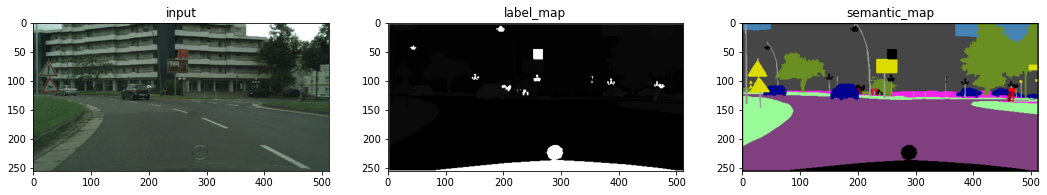

In [8]:
# 데이터 구성 살펴보기 2
# 이미지의 정답을 나타내기 위한 변수

# Train 기준
for x, y in train_dataset:
  input_x = np.array(x.permute(1, 2, 0))
  label_map =  np.array(y)
  semantic_map = make_seg_map(label_map)
  plot_results(output_list=[input_x, label_map, semantic_map]
               , output_name_list=['input', 'label_map', 'semantic_map'], cols=3)
  break

## 2. Unet with Attention 모델  

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Pre-Activation 사용
class convolution_block(nn.Module):
    def __init__(self, input, out):
        super(convolution_block,self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(input),
            nn.Mish(),
            nn.Conv2d(input, out, kernel_size=3,stride=1,padding=1,bias=True),
            
            nn.BatchNorm2d(out),
            nn.Mish(),
            nn.Conv2d(out, out, kernel_size=3,stride=1,padding=1,bias=True),          
        )

    def forward(self,x):
        x = self.conv(x)
        return x

# Convolution Block과 대칭되어야 해서 Post-Activation 사용
class upsampling(nn.Module):
    def __init__(self, input, out):
        super(upsampling, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(input, out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out),
            nn.Mish()
        )
    def forward(self, x):
        x = self.up(x)
        return x



class AttentionBlock(nn.Module):
    def __init__(self, global_channels, local_channels, channels):
        super(AttentionBlock, self).__init__()
        
        # Global Attention에 대한 가중치 행렬 W_g
        self.global_conv = nn.Sequential(
            nn.Conv2d(global_channels, channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(channels)
        )
        
        # Local Attention에 대한 가중치 행렬 W_x
        self.local_conv = nn.Sequential(
            nn.Conv2d(local_channels, channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(channels)
        )

        # 어텐션을 제어하는 파라미터 alpha
        self.alpha = nn.Sequential(
            nn.Conv2d(channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        # ReLU 활성화 함수
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, global_feat_map, local_feat_map):
        # Global Attention과 Local Attention에 대한 각각의 가중치 행렬 계산
        global_out = self.global_conv(global_feat_map)
        local_out = self.local_conv(local_feat_map)
        
        # 두 결과를 더하고 ReLU 함수를 적용하여 어텐션을 제어하는 파라미터 alpha 계산
        alpha = self.relu(global_out + local_out)
        # alpha를 이용하여 Local Attention에 가중치를 적용하여 출력
        alpha = self.alpha(alpha)
        return local_feat_map * alpha



class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv1 = convolution_block(3, 64)
        self.Conv2 = convolution_block(64, 128)
        self.Conv3 = convolution_block(128, 256)
        self.Conv4 = convolution_block(256, 512)
        self.Conv5 = convolution_block(512, 1024)

    def forward(self, x):
        x1 = self.Conv1(x)
        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)
        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        return x5, x4, x3, x2, x1

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.Upsampling1 = upsampling(1024, 512)
        self.Att1 = AttentionBlock(512, 512, 256) 
        self.Conv1 = convolution_block(1024, 512)

        self.Upsampling2 = upsampling(512, 256)
        self.Att2 = AttentionBlock(256, 256, 128)  
        self.Conv2 = convolution_block(512, 256)
        
        self.Upsampling3 = upsampling(256, 128)
        self.Att3 = AttentionBlock(128, 128, 64)  
        self.Conv3 = convolution_block(256, 128)
        
        self.Upsampling4 = upsampling(128, 64)
        self.Att4 = AttentionBlock(64, 64, 32)  
        self.Conv4 = convolution_block(128, 64)

        self.Conv = nn.Conv2d(64, 19, kernel_size=1, stride=1, padding=0)

    def forward(self, x5, x4, x3, x2, x1):
        d5 = self.Upsampling1(x5)
        x4 = self.Att1(d5, x4)
        d5 = torch.cat((x4, d5), dim=1)        
        d5 = self.Conv1(d5)
        
        d4 = self.Upsampling2(d5)
        x3 = self.Att2(d4, x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Conv2(d4)

        d3 = self.Upsampling3(d4)
        x2 = self.Att3(d3, x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Conv3(d3)

        d2 = self.Upsampling4(d3)
        x1 = self.Att4(d2, x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Conv4(d2)

        d1 = self.Conv(d2)

        return d1


class UNet_with_Attention(nn.Module):
    def __init__(self, input=3, classes=19):
        super(UNet_with_Attention, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x5, x4, x3, x2, x1 = self.encoder(x)
        output = self.decoder(x5, x4, x3, x2, x1)
        return output

## 3. 훈련 하기   

In [10]:
LEARNING_RATE = 5e-3 # 자유롭게 설정
model = UNet_with_Attention().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=255)
print(model)

UNet_with_Attention(
  (encoder): Encoder(
    (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv1): convolution_block(
      (conv): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Mish()
        (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Mish()
        (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (Conv2): convolution_block(
      (conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Mish()
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Mish()
        (5): Conv2d(128, 128, kernel_size=(3, 3)

In [58]:
def main(epoch=0):
    log = open(os.path.join(save_path,'log.txt'),'w')
    log.write('Epoch\tLoss\tmIoU\n')
    log.close()

    print("#####################################################################")
    print("Train information")
    print("batch size: {}".format(BATCH_SIZE))
    print("Learning rate: {}".format(LEARNING_RATE))
    print("Total Epochs: {}".format(EPOCHS))
    print("Train dataset number: {}".format(len(train_dataset)))
    print("Test dataset number: {}".format(len(test_dataset)))
    print("#####################################################################")

    best_mean_iou_score = 0.0
    for epoch in range(epoch, EPOCHS):
        print("Current epoch {} start".format(epoch + 1))
        total_loss = 0.0
        iteration = 0.0

        model.train()

        for batch in tqdm(train_loader):

            X, y = batch
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X)

            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iteration += 1

            total_loss += loss.item()

            print('[%s] [%d/%d], CrossEntropyLoss per iter : %f'
                % (datetime.datetime.now().strftime("%m%d_%H:%M"), iteration, len(train_loader),
                   loss.item()))

        print('[%s] [%d/%d], CrossEntropyLoss: %f'
               % (datetime.datetime.now().strftime("%m%d_%H:%M"), epoch + 1, EPOCHS,
                   total_loss / iteration))

        total_mean_iou = 0.0

        model.eval()

        for batch in tqdm(test_loader):
            X, y, img_name = batch
            img_name = img_name[0]

            with torch.no_grad():
                X, y = X.to(DEVICE), y.to(DEVICE)
                pred = model(X)

                pred_mask = F.softmax(pred, dim=1)
                pred_mask = torch.argmax(pred, dim=1) # bs x H x W
                pred_mask = pred_mask.contiguous().view(-1) # 1차원 vector로 flatten
                gt_mask = y.contiguous().view(-1) # 1차원 vector로 flatten

                iou_per_class = []

                for class_id in range(class_num): #loop per pixel class
                    true_class = pred_mask == class_id
                    true_label = gt_mask == class_id

                    if true_label.long().sum().item() == 0: #no exist label in this loop
                        iou_per_class.append(np.nan)

                    else:
                        intersect = torch.logical_and(true_class, true_label).sum().float().item()
                        union = torch.logical_or(true_class, true_label).sum().float().item()

                        iou = (intersect + smooth) / (union +smooth)
                        iou_per_class.append(iou)

            total_mean_iou += np.nanmean(iou_per_class)

        pre_mean_iou = (total_mean_iou / len(test_loader))
        pre_mean_iou_score = pre_mean_iou * 100

        print("miou score: {}".format(pre_mean_iou_score))

        # 가중치 저장 update
        if best_mean_iou_score < pre_mean_iou_score:
            best_mean_iou_score = pre_mean_iou_score

            # 단순히 모델의 가중치만 저장하고 싶은 경우 아래 코드 사용
            torch.save(model.state_dict(), os.path.join(save_path, 'best.pth'))

            # 훈련 재시작을 위해 훈련에 사용된 모든 파라미터를 저장 (checkpoint 라고 부름)
            """
            torch.save({
            'model_state_dict': model.state_dict(), # 모델의 파라미터 정보를 저장
            'optim_state_dict': optimizer.state_dict(), # optimizer의 정보를 저장
            'epoch': epoch, # 에포크 저장
            'loss_values': total_loss / iteration # loss 저장
            }, os.path.join(save_path, 'epoch_{}_checkpoint.pt'.format(epoch + 1))) # 경로 설정
            print("Model weight update!!")
            """

        log = open(os.path.join(save_path,'log.txt'),'a')
        log.write(f'{epoch+1}\t{total_loss / iteration}\t{pre_mean_iou_score}\n')
        log.close()

In [11]:
print(DEVICE)

cuda


In [61]:
EPOCHS = 100
class_num = 19
smooth=1e-10
save_path = './output'
os.makedirs(save_path, exist_ok=True)
main(epoch=0)

#####################################################################
Train information
batch size: 8
Learning rate: 0.005
Total Epochs: 100
Train dataset number: 2975
Test dataset number: 500
#####################################################################
Current epoch 1 start


  0%|          | 1/372 [00:01<07:33,  1.22s/it]

[1126_06:04] [1/372], CrossEntropyLoss per iter : 1.126249


  1%|          | 2/372 [00:02<07:25,  1.20s/it]

[1126_06:04] [2/372], CrossEntropyLoss per iter : 1.411971


  1%|          | 3/372 [00:03<07:22,  1.20s/it]

[1126_06:04] [3/372], CrossEntropyLoss per iter : 1.301532


  1%|          | 4/372 [00:04<07:19,  1.19s/it]

[1126_06:04] [4/372], CrossEntropyLoss per iter : 1.446697


  1%|▏         | 5/372 [00:05<07:17,  1.19s/it]

[1126_06:04] [5/372], CrossEntropyLoss per iter : 1.249134


  2%|▏         | 6/372 [00:07<07:16,  1.19s/it]

[1126_06:04] [6/372], CrossEntropyLoss per iter : 1.367049


  2%|▏         | 7/372 [00:08<07:14,  1.19s/it]

[1126_06:04] [7/372], CrossEntropyLoss per iter : 1.414436


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_06:04] [8/372], CrossEntropyLoss per iter : 1.183451


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_06:04] [9/372], CrossEntropyLoss per iter : 1.242604


  3%|▎         | 10/372 [00:11<07:06,  1.18s/it]

[1126_06:04] [10/372], CrossEntropyLoss per iter : 1.077989


  3%|▎         | 11/372 [00:13<07:04,  1.18s/it]

[1126_06:04] [11/372], CrossEntropyLoss per iter : 1.073981


  3%|▎         | 12/372 [00:14<07:03,  1.18s/it]

[1126_06:04] [12/372], CrossEntropyLoss per iter : 1.259625


  3%|▎         | 13/372 [00:15<07:01,  1.18s/it]

[1126_06:04] [13/372], CrossEntropyLoss per iter : 1.106729


  4%|▍         | 14/372 [00:16<07:01,  1.18s/it]

[1126_06:04] [14/372], CrossEntropyLoss per iter : 1.195975


  4%|▍         | 15/372 [00:17<07:00,  1.18s/it]

[1126_06:04] [15/372], CrossEntropyLoss per iter : 1.143614


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_06:04] [16/372], CrossEntropyLoss per iter : 1.269718


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_06:04] [17/372], CrossEntropyLoss per iter : 1.079901


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_06:04] [18/372], CrossEntropyLoss per iter : 1.175585


  5%|▌         | 19/372 [00:22<06:55,  1.18s/it]

[1126_06:05] [19/372], CrossEntropyLoss per iter : 1.495685


  5%|▌         | 20/372 [00:23<06:54,  1.18s/it]

[1126_06:05] [20/372], CrossEntropyLoss per iter : 1.133290


  6%|▌         | 21/372 [00:24<06:52,  1.18s/it]

[1126_06:05] [21/372], CrossEntropyLoss per iter : 1.157479


  6%|▌         | 22/372 [00:25<06:51,  1.18s/it]

[1126_06:05] [22/372], CrossEntropyLoss per iter : 1.178241


  6%|▌         | 23/372 [00:27<06:50,  1.18s/it]

[1126_06:05] [23/372], CrossEntropyLoss per iter : 1.112031


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_06:05] [24/372], CrossEntropyLoss per iter : 1.251640


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_06:05] [25/372], CrossEntropyLoss per iter : 1.301258


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_06:05] [26/372], CrossEntropyLoss per iter : 1.500655


  7%|▋         | 27/372 [00:31<06:46,  1.18s/it]

[1126_06:05] [27/372], CrossEntropyLoss per iter : 1.487479


  8%|▊         | 28/372 [00:33<06:45,  1.18s/it]

[1126_06:05] [28/372], CrossEntropyLoss per iter : 1.278427


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_06:05] [29/372], CrossEntropyLoss per iter : 1.139149


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_06:05] [30/372], CrossEntropyLoss per iter : 1.212170


  8%|▊         | 31/372 [00:36<06:41,  1.18s/it]

[1126_06:05] [31/372], CrossEntropyLoss per iter : 1.381081


  9%|▊         | 32/372 [00:37<06:39,  1.17s/it]

[1126_06:05] [32/372], CrossEntropyLoss per iter : 1.209030


  9%|▉         | 33/372 [00:38<06:38,  1.17s/it]

[1126_06:05] [33/372], CrossEntropyLoss per iter : 1.187502


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_06:05] [34/372], CrossEntropyLoss per iter : 1.210037


  9%|▉         | 35/372 [00:41<06:36,  1.18s/it]

[1126_06:05] [35/372], CrossEntropyLoss per iter : 1.157042


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_06:05] [36/372], CrossEntropyLoss per iter : 1.410391


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_06:05] [37/372], CrossEntropyLoss per iter : 1.159202


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_06:05] [38/372], CrossEntropyLoss per iter : 1.116462


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_06:05] [39/372], CrossEntropyLoss per iter : 1.096917


 11%|█         | 40/372 [00:47<06:32,  1.18s/it]

[1126_06:05] [40/372], CrossEntropyLoss per iter : 1.273832


 11%|█         | 41/372 [00:48<06:31,  1.18s/it]

[1126_06:05] [41/372], CrossEntropyLoss per iter : 0.984403


 11%|█▏        | 42/372 [00:49<06:29,  1.18s/it]

[1126_06:05] [42/372], CrossEntropyLoss per iter : 1.078646


 12%|█▏        | 43/372 [00:50<06:27,  1.18s/it]

[1126_06:05] [43/372], CrossEntropyLoss per iter : 0.909668


 12%|█▏        | 44/372 [00:51<06:25,  1.18s/it]

[1126_06:05] [44/372], CrossEntropyLoss per iter : 1.043038


 12%|█▏        | 45/372 [00:53<06:24,  1.17s/it]

[1126_06:05] [45/372], CrossEntropyLoss per iter : 1.427224


 12%|█▏        | 46/372 [00:54<06:22,  1.17s/it]

[1126_06:05] [46/372], CrossEntropyLoss per iter : 1.038601


 13%|█▎        | 47/372 [00:55<06:21,  1.17s/it]

[1126_06:05] [47/372], CrossEntropyLoss per iter : 1.227468


 13%|█▎        | 48/372 [00:56<06:20,  1.18s/it]

[1126_06:05] [48/372], CrossEntropyLoss per iter : 1.137709


 13%|█▎        | 49/372 [00:57<06:20,  1.18s/it]

[1126_06:05] [49/372], CrossEntropyLoss per iter : 0.907669


 13%|█▎        | 50/372 [00:58<06:18,  1.18s/it]

[1126_06:05] [50/372], CrossEntropyLoss per iter : 1.079569


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_06:05] [51/372], CrossEntropyLoss per iter : 1.251824


 14%|█▍        | 52/372 [01:01<06:17,  1.18s/it]

[1126_06:05] [52/372], CrossEntropyLoss per iter : 1.066593


 14%|█▍        | 53/372 [01:02<06:15,  1.18s/it]

[1126_06:05] [53/372], CrossEntropyLoss per iter : 1.034652


 15%|█▍        | 54/372 [01:03<06:14,  1.18s/it]

[1126_06:05] [54/372], CrossEntropyLoss per iter : 1.349841


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_06:05] [55/372], CrossEntropyLoss per iter : 1.170322


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_06:05] [56/372], CrossEntropyLoss per iter : 0.961412


 15%|█▌        | 57/372 [01:07<06:11,  1.18s/it]

[1126_06:05] [57/372], CrossEntropyLoss per iter : 1.111120


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_06:05] [58/372], CrossEntropyLoss per iter : 1.253790


 16%|█▌        | 59/372 [01:09<06:09,  1.18s/it]

[1126_06:05] [59/372], CrossEntropyLoss per iter : 1.036322


 16%|█▌        | 60/372 [01:10<06:08,  1.18s/it]

[1126_06:05] [60/372], CrossEntropyLoss per iter : 1.105921


 16%|█▋        | 61/372 [01:11<06:06,  1.18s/it]

[1126_06:05] [61/372], CrossEntropyLoss per iter : 1.175578


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_06:05] [62/372], CrossEntropyLoss per iter : 1.152022


 17%|█▋        | 63/372 [01:14<06:03,  1.18s/it]

[1126_06:05] [63/372], CrossEntropyLoss per iter : 0.995205


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_06:05] [64/372], CrossEntropyLoss per iter : 0.956205


 17%|█▋        | 65/372 [01:16<06:02,  1.18s/it]

[1126_06:05] [65/372], CrossEntropyLoss per iter : 1.014739


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_06:05] [66/372], CrossEntropyLoss per iter : 0.926441


 18%|█▊        | 67/372 [01:19<05:58,  1.18s/it]

[1126_06:05] [67/372], CrossEntropyLoss per iter : 1.026496


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_06:05] [68/372], CrossEntropyLoss per iter : 1.183572


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_06:05] [69/372], CrossEntropyLoss per iter : 1.064642


 19%|█▉        | 70/372 [01:22<05:55,  1.18s/it]

[1126_06:06] [70/372], CrossEntropyLoss per iter : 1.106029


 19%|█▉        | 71/372 [01:23<05:53,  1.17s/it]

[1126_06:06] [71/372], CrossEntropyLoss per iter : 1.039224


 19%|█▉        | 72/372 [01:24<05:53,  1.18s/it]

[1126_06:06] [72/372], CrossEntropyLoss per iter : 1.037624


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_06:06] [73/372], CrossEntropyLoss per iter : 1.273365


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_06:06] [74/372], CrossEntropyLoss per iter : 1.039386


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_06:06] [75/372], CrossEntropyLoss per iter : 0.985361


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_06:06] [76/372], CrossEntropyLoss per iter : 1.045765


 21%|██        | 77/372 [01:30<05:48,  1.18s/it]

[1126_06:06] [77/372], CrossEntropyLoss per iter : 0.940221


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_06:06] [78/372], CrossEntropyLoss per iter : 1.067473


 21%|██        | 79/372 [01:33<05:47,  1.18s/it]

[1126_06:06] [79/372], CrossEntropyLoss per iter : 1.047396


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_06:06] [80/372], CrossEntropyLoss per iter : 1.028264


 22%|██▏       | 81/372 [01:35<05:43,  1.18s/it]

[1126_06:06] [81/372], CrossEntropyLoss per iter : 1.261007


 22%|██▏       | 82/372 [01:36<05:43,  1.18s/it]

[1126_06:06] [82/372], CrossEntropyLoss per iter : 0.981151


 22%|██▏       | 83/372 [01:37<05:41,  1.18s/it]

[1126_06:06] [83/372], CrossEntropyLoss per iter : 0.964522


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_06:06] [84/372], CrossEntropyLoss per iter : 0.979302


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_06:06] [85/372], CrossEntropyLoss per iter : 1.166582


 23%|██▎       | 86/372 [01:41<05:36,  1.18s/it]

[1126_06:06] [86/372], CrossEntropyLoss per iter : 1.036973


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_06:06] [87/372], CrossEntropyLoss per iter : 0.995973


 24%|██▎       | 88/372 [01:43<05:35,  1.18s/it]

[1126_06:06] [88/372], CrossEntropyLoss per iter : 1.100255


 24%|██▍       | 89/372 [01:44<05:33,  1.18s/it]

[1126_06:06] [89/372], CrossEntropyLoss per iter : 0.964033


 24%|██▍       | 90/372 [01:46<05:31,  1.18s/it]

[1126_06:06] [90/372], CrossEntropyLoss per iter : 0.898809


 24%|██▍       | 91/372 [01:47<05:30,  1.18s/it]

[1126_06:06] [91/372], CrossEntropyLoss per iter : 1.241013


 25%|██▍       | 92/372 [01:48<05:29,  1.18s/it]

[1126_06:06] [92/372], CrossEntropyLoss per iter : 1.071773


 25%|██▌       | 93/372 [01:49<05:27,  1.17s/it]

[1126_06:06] [93/372], CrossEntropyLoss per iter : 0.918002


 25%|██▌       | 94/372 [01:50<05:26,  1.17s/it]

[1126_06:06] [94/372], CrossEntropyLoss per iter : 1.067901


 26%|██▌       | 95/372 [01:52<05:25,  1.17s/it]

[1126_06:06] [95/372], CrossEntropyLoss per iter : 1.374812


 26%|██▌       | 96/372 [01:53<05:23,  1.17s/it]

[1126_06:06] [96/372], CrossEntropyLoss per iter : 1.041801


 26%|██▌       | 97/372 [01:54<05:23,  1.18s/it]

[1126_06:06] [97/372], CrossEntropyLoss per iter : 1.127070


 26%|██▋       | 98/372 [01:55<05:24,  1.18s/it]

[1126_06:06] [98/372], CrossEntropyLoss per iter : 0.980599


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_06:06] [99/372], CrossEntropyLoss per iter : 0.854517


 27%|██▋       | 100/372 [01:57<05:20,  1.18s/it]

[1126_06:06] [100/372], CrossEntropyLoss per iter : 1.234914


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_06:06] [101/372], CrossEntropyLoss per iter : 0.974938


 27%|██▋       | 102/372 [02:00<05:17,  1.18s/it]

[1126_06:06] [102/372], CrossEntropyLoss per iter : 1.185797


 28%|██▊       | 103/372 [02:01<05:15,  1.17s/it]

[1126_06:06] [103/372], CrossEntropyLoss per iter : 1.069983


 28%|██▊       | 104/372 [02:02<05:14,  1.17s/it]

[1126_06:06] [104/372], CrossEntropyLoss per iter : 1.149196


 28%|██▊       | 105/372 [02:03<05:12,  1.17s/it]

[1126_06:06] [105/372], CrossEntropyLoss per iter : 0.843293


 28%|██▊       | 106/372 [02:04<05:11,  1.17s/it]

[1126_06:06] [106/372], CrossEntropyLoss per iter : 1.065391


 29%|██▉       | 107/372 [02:06<05:10,  1.17s/it]

[1126_06:06] [107/372], CrossEntropyLoss per iter : 1.000366


 29%|██▉       | 108/372 [02:07<05:09,  1.17s/it]

[1126_06:06] [108/372], CrossEntropyLoss per iter : 1.113158


 29%|██▉       | 109/372 [02:08<05:07,  1.17s/it]

[1126_06:06] [109/372], CrossEntropyLoss per iter : 1.116415


 30%|██▉       | 110/372 [02:09<05:06,  1.17s/it]

[1126_06:06] [110/372], CrossEntropyLoss per iter : 0.930163


 30%|██▉       | 111/372 [02:10<05:07,  1.18s/it]

[1126_06:06] [111/372], CrossEntropyLoss per iter : 1.216086


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_06:06] [112/372], CrossEntropyLoss per iter : 1.208030


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_06:06] [113/372], CrossEntropyLoss per iter : 1.299196


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_06:06] [114/372], CrossEntropyLoss per iter : 0.957017


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_06:06] [115/372], CrossEntropyLoss per iter : 0.797459


 31%|███       | 116/372 [02:16<05:01,  1.18s/it]

[1126_06:06] [116/372], CrossEntropyLoss per iter : 0.941596


 31%|███▏      | 117/372 [02:17<05:01,  1.18s/it]

[1126_06:06] [117/372], CrossEntropyLoss per iter : 1.010721


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_06:06] [118/372], CrossEntropyLoss per iter : 1.332766


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_06:06] [119/372], CrossEntropyLoss per iter : 1.032666


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_06:06] [120/372], CrossEntropyLoss per iter : 0.840953


 33%|███▎      | 121/372 [02:22<04:56,  1.18s/it]

[1126_06:07] [121/372], CrossEntropyLoss per iter : 1.042948


 33%|███▎      | 122/372 [02:23<04:55,  1.18s/it]

[1126_06:07] [122/372], CrossEntropyLoss per iter : 1.110289


 33%|███▎      | 123/372 [02:25<04:54,  1.18s/it]

[1126_06:07] [123/372], CrossEntropyLoss per iter : 0.922567


 33%|███▎      | 124/372 [02:26<04:53,  1.18s/it]

[1126_06:07] [124/372], CrossEntropyLoss per iter : 0.810291


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_06:07] [125/372], CrossEntropyLoss per iter : 0.786455


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_06:07] [126/372], CrossEntropyLoss per iter : 0.928050


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_06:07] [127/372], CrossEntropyLoss per iter : 0.817268


 34%|███▍      | 128/372 [02:30<04:47,  1.18s/it]

[1126_06:07] [128/372], CrossEntropyLoss per iter : 1.020862


 35%|███▍      | 129/372 [02:32<04:45,  1.18s/it]

[1126_06:07] [129/372], CrossEntropyLoss per iter : 1.069418


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_06:07] [130/372], CrossEntropyLoss per iter : 0.893649


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_06:07] [131/372], CrossEntropyLoss per iter : 1.058198


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_06:07] [132/372], CrossEntropyLoss per iter : 0.829526


 36%|███▌      | 133/372 [02:36<04:43,  1.19s/it]

[1126_06:07] [133/372], CrossEntropyLoss per iter : 1.013789


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_06:07] [134/372], CrossEntropyLoss per iter : 0.860724


 36%|███▋      | 135/372 [02:39<04:41,  1.19s/it]

[1126_06:07] [135/372], CrossEntropyLoss per iter : 1.023721


 37%|███▋      | 136/372 [02:40<04:42,  1.19s/it]

[1126_06:07] [136/372], CrossEntropyLoss per iter : 0.775653


 37%|███▋      | 137/372 [02:41<04:40,  1.19s/it]

[1126_06:07] [137/372], CrossEntropyLoss per iter : 0.914504


 37%|███▋      | 138/372 [02:42<04:36,  1.18s/it]

[1126_06:07] [138/372], CrossEntropyLoss per iter : 1.060857


 37%|███▋      | 139/372 [02:43<04:34,  1.18s/it]

[1126_06:07] [139/372], CrossEntropyLoss per iter : 0.919440


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_06:07] [140/372], CrossEntropyLoss per iter : 0.931152


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_06:07] [141/372], CrossEntropyLoss per iter : 0.944703


 38%|███▊      | 142/372 [02:47<04:32,  1.19s/it]

[1126_06:07] [142/372], CrossEntropyLoss per iter : 0.901301


 38%|███▊      | 143/372 [02:48<04:31,  1.19s/it]

[1126_06:07] [143/372], CrossEntropyLoss per iter : 0.765165


 39%|███▊      | 144/372 [02:49<04:30,  1.19s/it]

[1126_06:07] [144/372], CrossEntropyLoss per iter : 0.771254


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_06:07] [145/372], CrossEntropyLoss per iter : 0.862644


 39%|███▉      | 146/372 [02:52<04:25,  1.18s/it]

[1126_06:07] [146/372], CrossEntropyLoss per iter : 0.823385


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_06:07] [147/372], CrossEntropyLoss per iter : 0.757677


 40%|███▉      | 148/372 [02:54<04:23,  1.18s/it]

[1126_06:07] [148/372], CrossEntropyLoss per iter : 0.821087


 40%|████      | 149/372 [02:55<04:22,  1.18s/it]

[1126_06:07] [149/372], CrossEntropyLoss per iter : 1.245049


 40%|████      | 150/372 [02:56<04:21,  1.18s/it]

[1126_06:07] [150/372], CrossEntropyLoss per iter : 0.830231


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_06:07] [151/372], CrossEntropyLoss per iter : 0.911932


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_06:07] [152/372], CrossEntropyLoss per iter : 0.828745


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_06:07] [153/372], CrossEntropyLoss per iter : 1.031682


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_06:07] [154/372], CrossEntropyLoss per iter : 0.866507


 42%|████▏     | 155/372 [03:02<04:16,  1.18s/it]

[1126_06:07] [155/372], CrossEntropyLoss per iter : 0.774843


 42%|████▏     | 156/372 [03:03<04:14,  1.18s/it]

[1126_06:07] [156/372], CrossEntropyLoss per iter : 0.740645


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_06:07] [157/372], CrossEntropyLoss per iter : 0.823811


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_06:07] [158/372], CrossEntropyLoss per iter : 0.847775


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_06:07] [159/372], CrossEntropyLoss per iter : 0.951456


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_06:07] [160/372], CrossEntropyLoss per iter : 0.833666


 43%|████▎     | 161/372 [03:09<04:08,  1.18s/it]

[1126_06:07] [161/372], CrossEntropyLoss per iter : 0.819380


 44%|████▎     | 162/372 [03:11<04:08,  1.18s/it]

[1126_06:07] [162/372], CrossEntropyLoss per iter : 1.110934


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_06:07] [163/372], CrossEntropyLoss per iter : 0.765330


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_06:07] [164/372], CrossEntropyLoss per iter : 0.779491


 44%|████▍     | 165/372 [03:14<04:03,  1.18s/it]

[1126_06:07] [165/372], CrossEntropyLoss per iter : 1.004697


 45%|████▍     | 166/372 [03:15<04:02,  1.18s/it]

[1126_06:07] [166/372], CrossEntropyLoss per iter : 0.950918


 45%|████▍     | 167/372 [03:16<04:01,  1.18s/it]

[1126_06:07] [167/372], CrossEntropyLoss per iter : 0.767682


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_06:07] [168/372], CrossEntropyLoss per iter : 0.881191


 45%|████▌     | 169/372 [03:19<04:00,  1.18s/it]

[1126_06:07] [169/372], CrossEntropyLoss per iter : 1.033757


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_06:07] [170/372], CrossEntropyLoss per iter : 0.805931


 46%|████▌     | 171/372 [03:21<03:57,  1.18s/it]

[1126_06:08] [171/372], CrossEntropyLoss per iter : 0.785361


 46%|████▌     | 172/372 [03:22<03:55,  1.18s/it]

[1126_06:08] [172/372], CrossEntropyLoss per iter : 0.705135


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_06:08] [173/372], CrossEntropyLoss per iter : 0.918577


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_06:08] [174/372], CrossEntropyLoss per iter : 0.807342


 47%|████▋     | 175/372 [03:26<03:51,  1.18s/it]

[1126_06:08] [175/372], CrossEntropyLoss per iter : 0.655427


 47%|████▋     | 176/372 [03:27<03:50,  1.18s/it]

[1126_06:08] [176/372], CrossEntropyLoss per iter : 0.842750


 48%|████▊     | 177/372 [03:28<03:49,  1.18s/it]

[1126_06:08] [177/372], CrossEntropyLoss per iter : 0.906647


 48%|████▊     | 178/372 [03:29<03:48,  1.18s/it]

[1126_06:08] [178/372], CrossEntropyLoss per iter : 0.787247


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_06:08] [179/372], CrossEntropyLoss per iter : 0.967131


 48%|████▊     | 180/372 [03:32<03:47,  1.18s/it]

[1126_06:08] [180/372], CrossEntropyLoss per iter : 0.600734


 49%|████▊     | 181/372 [03:33<03:46,  1.18s/it]

[1126_06:08] [181/372], CrossEntropyLoss per iter : 0.751370


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_06:08] [182/372], CrossEntropyLoss per iter : 0.709040


 49%|████▉     | 183/372 [03:35<03:43,  1.18s/it]

[1126_06:08] [183/372], CrossEntropyLoss per iter : 1.038685


 49%|████▉     | 184/372 [03:37<03:43,  1.19s/it]

[1126_06:08] [184/372], CrossEntropyLoss per iter : 0.887407


 50%|████▉     | 185/372 [03:38<03:41,  1.18s/it]

[1126_06:08] [185/372], CrossEntropyLoss per iter : 0.646247


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_06:08] [186/372], CrossEntropyLoss per iter : 1.023561


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_06:08] [187/372], CrossEntropyLoss per iter : 0.806898


 51%|█████     | 188/372 [03:41<03:36,  1.18s/it]

[1126_06:08] [188/372], CrossEntropyLoss per iter : 0.673196


 51%|█████     | 189/372 [03:42<03:35,  1.18s/it]

[1126_06:08] [189/372], CrossEntropyLoss per iter : 0.687366


 51%|█████     | 190/372 [03:44<03:33,  1.17s/it]

[1126_06:08] [190/372], CrossEntropyLoss per iter : 0.767487


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_06:08] [191/372], CrossEntropyLoss per iter : 0.938041


 52%|█████▏    | 192/372 [03:46<03:33,  1.19s/it]

[1126_06:08] [192/372], CrossEntropyLoss per iter : 0.935493


 52%|█████▏    | 193/372 [03:47<03:32,  1.19s/it]

[1126_06:08] [193/372], CrossEntropyLoss per iter : 0.888491


 52%|█████▏    | 194/372 [03:48<03:30,  1.18s/it]

[1126_06:08] [194/372], CrossEntropyLoss per iter : 1.080601


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_06:08] [195/372], CrossEntropyLoss per iter : 0.859510


 53%|█████▎    | 196/372 [03:51<03:28,  1.18s/it]

[1126_06:08] [196/372], CrossEntropyLoss per iter : 1.030395


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_06:08] [197/372], CrossEntropyLoss per iter : 0.777346


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_06:08] [198/372], CrossEntropyLoss per iter : 0.773039


 53%|█████▎    | 199/372 [03:54<03:24,  1.18s/it]

[1126_06:08] [199/372], CrossEntropyLoss per iter : 0.819157


 54%|█████▍    | 200/372 [03:55<03:22,  1.18s/it]

[1126_06:08] [200/372], CrossEntropyLoss per iter : 0.900750


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_06:08] [201/372], CrossEntropyLoss per iter : 0.733745


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_06:08] [202/372], CrossEntropyLoss per iter : 0.779547


 55%|█████▍    | 203/372 [03:59<03:20,  1.18s/it]

[1126_06:08] [203/372], CrossEntropyLoss per iter : 0.718622


 55%|█████▍    | 204/372 [04:00<03:18,  1.18s/it]

[1126_06:08] [204/372], CrossEntropyLoss per iter : 0.999951


 55%|█████▌    | 205/372 [04:01<03:17,  1.18s/it]

[1126_06:08] [205/372], CrossEntropyLoss per iter : 1.108516


 55%|█████▌    | 206/372 [04:03<03:16,  1.19s/it]

[1126_06:08] [206/372], CrossEntropyLoss per iter : 1.000345


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_06:08] [207/372], CrossEntropyLoss per iter : 0.873849


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_06:08] [208/372], CrossEntropyLoss per iter : 0.757179


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_06:08] [209/372], CrossEntropyLoss per iter : 0.843779


 56%|█████▋    | 210/372 [04:07<03:11,  1.18s/it]

[1126_06:08] [210/372], CrossEntropyLoss per iter : 1.028641


 57%|█████▋    | 211/372 [04:08<03:10,  1.18s/it]

[1126_06:08] [211/372], CrossEntropyLoss per iter : 0.771108


 57%|█████▋    | 212/372 [04:10<03:09,  1.18s/it]

[1126_06:08] [212/372], CrossEntropyLoss per iter : 0.946817


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_06:08] [213/372], CrossEntropyLoss per iter : 0.924099


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_06:08] [214/372], CrossEntropyLoss per iter : 0.672491


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_06:08] [215/372], CrossEntropyLoss per iter : 0.906834


 58%|█████▊    | 216/372 [04:14<03:03,  1.18s/it]

[1126_06:08] [216/372], CrossEntropyLoss per iter : 0.731324


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_06:08] [217/372], CrossEntropyLoss per iter : 1.030028


 59%|█████▊    | 218/372 [04:17<03:01,  1.18s/it]

[1126_06:08] [218/372], CrossEntropyLoss per iter : 0.935832


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_06:08] [219/372], CrossEntropyLoss per iter : 0.926523


 59%|█████▉    | 220/372 [04:19<03:00,  1.19s/it]

[1126_06:08] [220/372], CrossEntropyLoss per iter : 0.828304


 59%|█████▉    | 221/372 [04:20<02:59,  1.19s/it]

[1126_06:08] [221/372], CrossEntropyLoss per iter : 0.824003


 60%|█████▉    | 222/372 [04:21<02:57,  1.18s/it]

[1126_06:09] [222/372], CrossEntropyLoss per iter : 0.833342


 60%|█████▉    | 223/372 [04:23<02:56,  1.19s/it]

[1126_06:09] [223/372], CrossEntropyLoss per iter : 0.812158


 60%|██████    | 224/372 [04:24<02:55,  1.19s/it]

[1126_06:09] [224/372], CrossEntropyLoss per iter : 0.799644


 60%|██████    | 225/372 [04:25<02:54,  1.19s/it]

[1126_06:09] [225/372], CrossEntropyLoss per iter : 0.851497


 61%|██████    | 226/372 [04:26<02:53,  1.19s/it]

[1126_06:09] [226/372], CrossEntropyLoss per iter : 0.635173


 61%|██████    | 227/372 [04:27<02:52,  1.19s/it]

[1126_06:09] [227/372], CrossEntropyLoss per iter : 0.703966


 61%|██████▏   | 228/372 [04:29<02:51,  1.19s/it]

[1126_06:09] [228/372], CrossEntropyLoss per iter : 0.675847


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_06:09] [229/372], CrossEntropyLoss per iter : 1.107692


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_06:09] [230/372], CrossEntropyLoss per iter : 0.899045


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_06:09] [231/372], CrossEntropyLoss per iter : 0.591403


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_06:09] [232/372], CrossEntropyLoss per iter : 1.036983


 63%|██████▎   | 233/372 [04:34<02:44,  1.18s/it]

[1126_06:09] [233/372], CrossEntropyLoss per iter : 0.823316


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_06:09] [234/372], CrossEntropyLoss per iter : 0.676766


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_06:09] [235/372], CrossEntropyLoss per iter : 0.702290


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_06:09] [236/372], CrossEntropyLoss per iter : 1.334118


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_06:09] [237/372], CrossEntropyLoss per iter : 0.838926


 64%|██████▍   | 238/372 [04:40<02:38,  1.18s/it]

[1126_06:09] [238/372], CrossEntropyLoss per iter : 0.870425


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_06:09] [239/372], CrossEntropyLoss per iter : 0.803307


 65%|██████▍   | 240/372 [04:43<02:36,  1.18s/it]

[1126_06:09] [240/372], CrossEntropyLoss per iter : 0.927716


 65%|██████▍   | 241/372 [04:44<02:35,  1.18s/it]

[1126_06:09] [241/372], CrossEntropyLoss per iter : 1.167961


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_06:09] [242/372], CrossEntropyLoss per iter : 0.903209


 65%|██████▌   | 243/372 [04:46<02:32,  1.18s/it]

[1126_06:09] [243/372], CrossEntropyLoss per iter : 0.725714


 66%|██████▌   | 244/372 [04:47<02:31,  1.18s/it]

[1126_06:09] [244/372], CrossEntropyLoss per iter : 0.822913


 66%|██████▌   | 245/372 [04:49<02:30,  1.18s/it]

[1126_06:09] [245/372], CrossEntropyLoss per iter : 1.041591


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_06:09] [246/372], CrossEntropyLoss per iter : 0.779527


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_06:09] [247/372], CrossEntropyLoss per iter : 0.981897


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_06:09] [248/372], CrossEntropyLoss per iter : 0.898334


 67%|██████▋   | 249/372 [04:53<02:25,  1.18s/it]

[1126_06:09] [249/372], CrossEntropyLoss per iter : 0.857574


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:09] [250/372], CrossEntropyLoss per iter : 0.829146


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_06:09] [251/372], CrossEntropyLoss per iter : 0.733040


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_06:09] [252/372], CrossEntropyLoss per iter : 0.856231


 68%|██████▊   | 253/372 [04:58<02:19,  1.18s/it]

[1126_06:09] [253/372], CrossEntropyLoss per iter : 0.892138


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_06:09] [254/372], CrossEntropyLoss per iter : 0.933905


 69%|██████▊   | 255/372 [05:00<02:18,  1.19s/it]

[1126_06:09] [255/372], CrossEntropyLoss per iter : 0.787828


 69%|██████▉   | 256/372 [05:02<02:17,  1.19s/it]

[1126_06:09] [256/372], CrossEntropyLoss per iter : 0.898520


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_06:09] [257/372], CrossEntropyLoss per iter : 0.824735


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_06:09] [258/372], CrossEntropyLoss per iter : 0.754191


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_06:09] [259/372], CrossEntropyLoss per iter : 0.888831


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_06:09] [260/372], CrossEntropyLoss per iter : 0.807273


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_06:09] [261/372], CrossEntropyLoss per iter : 0.642866


 70%|███████   | 262/372 [05:09<02:10,  1.19s/it]

[1126_06:09] [262/372], CrossEntropyLoss per iter : 0.919665


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_06:09] [263/372], CrossEntropyLoss per iter : 0.904565


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_06:09] [264/372], CrossEntropyLoss per iter : 0.676785


 71%|███████   | 265/372 [05:12<02:07,  1.19s/it]

[1126_06:09] [265/372], CrossEntropyLoss per iter : 0.680126


 72%|███████▏  | 266/372 [05:14<02:06,  1.19s/it]

[1126_06:09] [266/372], CrossEntropyLoss per iter : 0.695649


 72%|███████▏  | 267/372 [05:15<02:04,  1.19s/it]

[1126_06:09] [267/372], CrossEntropyLoss per iter : 1.024034


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_06:09] [268/372], CrossEntropyLoss per iter : 0.855758


 72%|███████▏  | 269/372 [05:17<02:02,  1.19s/it]

[1126_06:09] [269/372], CrossEntropyLoss per iter : 0.991563


 73%|███████▎  | 270/372 [05:18<02:00,  1.19s/it]

[1126_06:09] [270/372], CrossEntropyLoss per iter : 0.746485


 73%|███████▎  | 271/372 [05:19<01:59,  1.18s/it]

[1126_06:09] [271/372], CrossEntropyLoss per iter : 0.739163


 73%|███████▎  | 272/372 [05:21<01:58,  1.19s/it]

[1126_06:09] [272/372], CrossEntropyLoss per iter : 0.807762


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_06:10] [273/372], CrossEntropyLoss per iter : 0.793589


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_06:10] [274/372], CrossEntropyLoss per iter : 0.764317


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_06:10] [275/372], CrossEntropyLoss per iter : 0.772038


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_06:10] [276/372], CrossEntropyLoss per iter : 0.825776


 74%|███████▍  | 277/372 [05:26<01:51,  1.18s/it]

[1126_06:10] [277/372], CrossEntropyLoss per iter : 0.754500


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_06:10] [278/372], CrossEntropyLoss per iter : 0.880547


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_06:10] [279/372], CrossEntropyLoss per iter : 0.804594


 75%|███████▌  | 280/372 [05:30<01:48,  1.17s/it]

[1126_06:10] [280/372], CrossEntropyLoss per iter : 0.758026


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_06:10] [281/372], CrossEntropyLoss per iter : 0.679689


 76%|███████▌  | 282/372 [05:32<01:45,  1.18s/it]

[1126_06:10] [282/372], CrossEntropyLoss per iter : 0.963435


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_06:10] [283/372], CrossEntropyLoss per iter : 0.803492


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_06:10] [284/372], CrossEntropyLoss per iter : 0.754343


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_06:10] [285/372], CrossEntropyLoss per iter : 0.723512


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_06:10] [286/372], CrossEntropyLoss per iter : 0.888578


 77%|███████▋  | 287/372 [05:38<01:39,  1.18s/it]

[1126_06:10] [287/372], CrossEntropyLoss per iter : 0.979149


 77%|███████▋  | 288/372 [05:39<01:39,  1.19s/it]

[1126_06:10] [288/372], CrossEntropyLoss per iter : 0.753897


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_06:10] [289/372], CrossEntropyLoss per iter : 0.819259


 78%|███████▊  | 290/372 [05:42<01:37,  1.19s/it]

[1126_06:10] [290/372], CrossEntropyLoss per iter : 0.704865


 78%|███████▊  | 291/372 [05:43<01:36,  1.19s/it]

[1126_06:10] [291/372], CrossEntropyLoss per iter : 0.727994


 78%|███████▊  | 292/372 [05:44<01:34,  1.19s/it]

[1126_06:10] [292/372], CrossEntropyLoss per iter : 0.799028


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_06:10] [293/372], CrossEntropyLoss per iter : 0.910569


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_06:10] [294/372], CrossEntropyLoss per iter : 0.643763


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_06:10] [295/372], CrossEntropyLoss per iter : 0.728320


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_06:10] [296/372], CrossEntropyLoss per iter : 0.733906


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_06:10] [297/372], CrossEntropyLoss per iter : 0.669930


 80%|████████  | 298/372 [05:51<01:27,  1.18s/it]

[1126_06:10] [298/372], CrossEntropyLoss per iter : 0.918072


 80%|████████  | 299/372 [05:52<01:26,  1.18s/it]

[1126_06:10] [299/372], CrossEntropyLoss per iter : 0.739800


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_06:10] [300/372], CrossEntropyLoss per iter : 0.689178


 81%|████████  | 301/372 [05:55<01:24,  1.19s/it]

[1126_06:10] [301/372], CrossEntropyLoss per iter : 0.616203


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_06:10] [302/372], CrossEntropyLoss per iter : 0.708664


 81%|████████▏ | 303/372 [05:57<01:21,  1.19s/it]

[1126_06:10] [303/372], CrossEntropyLoss per iter : 0.718359


 82%|████████▏ | 304/372 [05:58<01:20,  1.18s/it]

[1126_06:10] [304/372], CrossEntropyLoss per iter : 0.850825


 82%|████████▏ | 305/372 [06:00<01:19,  1.18s/it]

[1126_06:10] [305/372], CrossEntropyLoss per iter : 0.657305


 82%|████████▏ | 306/372 [06:01<01:18,  1.18s/it]

[1126_06:10] [306/372], CrossEntropyLoss per iter : 0.930036


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_06:10] [307/372], CrossEntropyLoss per iter : 0.713412


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_06:10] [308/372], CrossEntropyLoss per iter : 0.881924


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_06:10] [309/372], CrossEntropyLoss per iter : 0.673903


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_06:10] [310/372], CrossEntropyLoss per iter : 0.713893


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_06:10] [311/372], CrossEntropyLoss per iter : 0.734261


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_06:10] [312/372], CrossEntropyLoss per iter : 0.718809


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_06:10] [313/372], CrossEntropyLoss per iter : 0.751747


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_06:10] [314/372], CrossEntropyLoss per iter : 0.688683


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_06:10] [315/372], CrossEntropyLoss per iter : 0.656634


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_06:10] [316/372], CrossEntropyLoss per iter : 0.897165


 85%|████████▌ | 317/372 [06:14<01:05,  1.18s/it]

[1126_06:10] [317/372], CrossEntropyLoss per iter : 0.720897


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_06:10] [318/372], CrossEntropyLoss per iter : 0.703719


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_06:10] [319/372], CrossEntropyLoss per iter : 0.896980


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_06:10] [320/372], CrossEntropyLoss per iter : 0.708978


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_06:10] [321/372], CrossEntropyLoss per iter : 1.049586


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_06:10] [322/372], CrossEntropyLoss per iter : 0.797223


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_06:10] [323/372], CrossEntropyLoss per iter : 0.670823


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_06:11] [324/372], CrossEntropyLoss per iter : 0.767771


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_06:11] [325/372], CrossEntropyLoss per iter : 0.843747


 88%|████████▊ | 326/372 [06:24<00:54,  1.19s/it]

[1126_06:11] [326/372], CrossEntropyLoss per iter : 0.822364


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_06:11] [327/372], CrossEntropyLoss per iter : 0.601252


 88%|████████▊ | 328/372 [06:27<00:52,  1.18s/it]

[1126_06:11] [328/372], CrossEntropyLoss per iter : 0.824390


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_06:11] [329/372], CrossEntropyLoss per iter : 0.779687


 89%|████████▊ | 330/372 [06:29<00:49,  1.19s/it]

[1126_06:11] [330/372], CrossEntropyLoss per iter : 0.728427


 89%|████████▉ | 331/372 [06:30<00:48,  1.19s/it]

[1126_06:11] [331/372], CrossEntropyLoss per iter : 0.682890


 89%|████████▉ | 332/372 [06:31<00:47,  1.19s/it]

[1126_06:11] [332/372], CrossEntropyLoss per iter : 0.624003


 90%|████████▉ | 333/372 [06:33<00:46,  1.19s/it]

[1126_06:11] [333/372], CrossEntropyLoss per iter : 0.827191


 90%|████████▉ | 334/372 [06:34<00:45,  1.20s/it]

[1126_06:11] [334/372], CrossEntropyLoss per iter : 0.846098


 90%|█████████ | 335/372 [06:35<00:44,  1.19s/it]

[1126_06:11] [335/372], CrossEntropyLoss per iter : 0.776501


 90%|█████████ | 336/372 [06:36<00:42,  1.19s/it]

[1126_06:11] [336/372], CrossEntropyLoss per iter : 0.650545


 91%|█████████ | 337/372 [06:37<00:41,  1.19s/it]

[1126_06:11] [337/372], CrossEntropyLoss per iter : 0.811524


 91%|█████████ | 338/372 [06:39<00:40,  1.19s/it]

[1126_06:11] [338/372], CrossEntropyLoss per iter : 0.695033


 91%|█████████ | 339/372 [06:40<00:39,  1.18s/it]

[1126_06:11] [339/372], CrossEntropyLoss per iter : 0.729013


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_06:11] [340/372], CrossEntropyLoss per iter : 0.644758


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_06:11] [341/372], CrossEntropyLoss per iter : 0.864024


 92%|█████████▏| 342/372 [06:43<00:35,  1.18s/it]

[1126_06:11] [342/372], CrossEntropyLoss per iter : 0.808990


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_06:11] [343/372], CrossEntropyLoss per iter : 0.864453


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_06:11] [344/372], CrossEntropyLoss per iter : 0.633897


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_06:11] [345/372], CrossEntropyLoss per iter : 0.647045


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_06:11] [346/372], CrossEntropyLoss per iter : 0.539910


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_06:11] [347/372], CrossEntropyLoss per iter : 0.698053


 94%|█████████▎| 348/372 [06:50<00:28,  1.19s/it]

[1126_06:11] [348/372], CrossEntropyLoss per iter : 0.770427


 94%|█████████▍| 349/372 [06:52<00:27,  1.19s/it]

[1126_06:11] [349/372], CrossEntropyLoss per iter : 0.892740


 94%|█████████▍| 350/372 [06:53<00:26,  1.19s/it]

[1126_06:11] [350/372], CrossEntropyLoss per iter : 0.561190


 94%|█████████▍| 351/372 [06:54<00:24,  1.19s/it]

[1126_06:11] [351/372], CrossEntropyLoss per iter : 0.713953


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_06:11] [352/372], CrossEntropyLoss per iter : 0.709738


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_06:11] [353/372], CrossEntropyLoss per iter : 0.833860


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_06:11] [354/372], CrossEntropyLoss per iter : 0.642200


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_06:11] [355/372], CrossEntropyLoss per iter : 0.776850


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_06:11] [356/372], CrossEntropyLoss per iter : 0.693991


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_06:11] [357/372], CrossEntropyLoss per iter : 0.622572


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_06:11] [358/372], CrossEntropyLoss per iter : 0.616496


 97%|█████████▋| 359/372 [07:03<00:15,  1.18s/it]

[1126_06:11] [359/372], CrossEntropyLoss per iter : 0.798244


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_06:11] [360/372], CrossEntropyLoss per iter : 0.597246


 97%|█████████▋| 361/372 [07:06<00:12,  1.18s/it]

[1126_06:11] [361/372], CrossEntropyLoss per iter : 0.760910


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_06:11] [362/372], CrossEntropyLoss per iter : 0.620893


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_06:11] [363/372], CrossEntropyLoss per iter : 0.888782


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_06:11] [364/372], CrossEntropyLoss per iter : 0.687934


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_06:11] [365/372], CrossEntropyLoss per iter : 0.770318


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_06:11] [366/372], CrossEntropyLoss per iter : 0.705361


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_06:11] [367/372], CrossEntropyLoss per iter : 0.714906


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_06:11] [368/372], CrossEntropyLoss per iter : 0.932886


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_06:11] [369/372], CrossEntropyLoss per iter : 0.731038


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_06:11] [370/372], CrossEntropyLoss per iter : 0.726947


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_06:11] [371/372], CrossEntropyLoss per iter : 0.700962


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_06:11] [372/372], CrossEntropyLoss per iter : 0.763565
[1126_06:11] [1/100], CrossEntropyLoss: 0.919190


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 23.02468387019192
Current epoch 2 start


  0%|          | 1/372 [00:01<07:37,  1.23s/it]

[1126_06:12] [1/372], CrossEntropyLoss per iter : 0.499674


  1%|          | 2/372 [00:02<07:22,  1.19s/it]

[1126_06:12] [2/372], CrossEntropyLoss per iter : 0.599600


  1%|          | 3/372 [00:03<07:19,  1.19s/it]

[1126_06:13] [3/372], CrossEntropyLoss per iter : 0.847866


  1%|          | 4/372 [00:04<07:17,  1.19s/it]

[1126_06:13] [4/372], CrossEntropyLoss per iter : 0.732923


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_06:13] [5/372], CrossEntropyLoss per iter : 0.726620


  2%|▏         | 6/372 [00:07<07:11,  1.18s/it]

[1126_06:13] [6/372], CrossEntropyLoss per iter : 0.712468


  2%|▏         | 7/372 [00:08<07:09,  1.18s/it]

[1126_06:13] [7/372], CrossEntropyLoss per iter : 0.842401


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_06:13] [8/372], CrossEntropyLoss per iter : 0.691646


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_06:13] [9/372], CrossEntropyLoss per iter : 0.546141


  3%|▎         | 10/372 [00:11<07:07,  1.18s/it]

[1126_06:13] [10/372], CrossEntropyLoss per iter : 0.597642


  3%|▎         | 11/372 [00:13<07:05,  1.18s/it]

[1126_06:13] [11/372], CrossEntropyLoss per iter : 0.629715


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_06:13] [12/372], CrossEntropyLoss per iter : 0.578852


  3%|▎         | 13/372 [00:15<07:02,  1.18s/it]

[1126_06:13] [13/372], CrossEntropyLoss per iter : 0.675183


  4%|▍         | 14/372 [00:16<07:02,  1.18s/it]

[1126_06:13] [14/372], CrossEntropyLoss per iter : 0.553505


  4%|▍         | 15/372 [00:17<07:00,  1.18s/it]

[1126_06:13] [15/372], CrossEntropyLoss per iter : 0.739160


  4%|▍         | 16/372 [00:18<06:59,  1.18s/it]

[1126_06:13] [16/372], CrossEntropyLoss per iter : 0.627989


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_06:13] [17/372], CrossEntropyLoss per iter : 0.735323


  5%|▍         | 18/372 [00:21<06:56,  1.18s/it]

[1126_06:13] [18/372], CrossEntropyLoss per iter : 0.767204


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_06:13] [19/372], CrossEntropyLoss per iter : 0.682234


  5%|▌         | 20/372 [00:23<06:56,  1.18s/it]

[1126_06:13] [20/372], CrossEntropyLoss per iter : 0.715169


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_06:13] [21/372], CrossEntropyLoss per iter : 0.778740


  6%|▌         | 22/372 [00:25<06:53,  1.18s/it]

[1126_06:13] [22/372], CrossEntropyLoss per iter : 0.573236


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_06:13] [23/372], CrossEntropyLoss per iter : 0.864226


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_06:13] [24/372], CrossEntropyLoss per iter : 0.967955


  7%|▋         | 25/372 [00:29<06:50,  1.18s/it]

[1126_06:13] [25/372], CrossEntropyLoss per iter : 0.607693


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_06:13] [26/372], CrossEntropyLoss per iter : 0.946278


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_06:13] [27/372], CrossEntropyLoss per iter : 0.853140


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_06:13] [28/372], CrossEntropyLoss per iter : 0.928856


  8%|▊         | 29/372 [00:34<06:46,  1.18s/it]

[1126_06:13] [29/372], CrossEntropyLoss per iter : 0.810736


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_06:13] [30/372], CrossEntropyLoss per iter : 0.657903


  8%|▊         | 31/372 [00:36<06:42,  1.18s/it]

[1126_06:13] [31/372], CrossEntropyLoss per iter : 0.690704


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_06:13] [32/372], CrossEntropyLoss per iter : 0.890999


  9%|▉         | 33/372 [00:38<06:39,  1.18s/it]

[1126_06:13] [33/372], CrossEntropyLoss per iter : 0.707348


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_06:13] [34/372], CrossEntropyLoss per iter : 0.918843


  9%|▉         | 35/372 [00:41<06:36,  1.18s/it]

[1126_06:13] [35/372], CrossEntropyLoss per iter : 0.603955


 10%|▉         | 36/372 [00:42<06:35,  1.18s/it]

[1126_06:13] [36/372], CrossEntropyLoss per iter : 0.719238


 10%|▉         | 37/372 [00:43<06:33,  1.18s/it]

[1126_06:13] [37/372], CrossEntropyLoss per iter : 0.940468


 10%|█         | 38/372 [00:44<06:35,  1.18s/it]

[1126_06:13] [38/372], CrossEntropyLoss per iter : 0.779889


 10%|█         | 39/372 [00:46<06:34,  1.18s/it]

[1126_06:13] [39/372], CrossEntropyLoss per iter : 0.668861


 11%|█         | 40/372 [00:47<06:33,  1.18s/it]

[1126_06:13] [40/372], CrossEntropyLoss per iter : 0.523159


 11%|█         | 41/372 [00:48<06:33,  1.19s/it]

[1126_06:13] [41/372], CrossEntropyLoss per iter : 1.153348


 11%|█▏        | 42/372 [00:49<06:31,  1.19s/it]

[1126_06:13] [42/372], CrossEntropyLoss per iter : 0.677645


 12%|█▏        | 43/372 [00:50<06:30,  1.19s/it]

[1126_06:13] [43/372], CrossEntropyLoss per iter : 0.642230


 12%|█▏        | 44/372 [00:51<06:27,  1.18s/it]

[1126_06:13] [44/372], CrossEntropyLoss per iter : 0.737336


 12%|█▏        | 45/372 [00:53<06:27,  1.19s/it]

[1126_06:13] [45/372], CrossEntropyLoss per iter : 0.742962


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_06:13] [46/372], CrossEntropyLoss per iter : 0.708511


 13%|█▎        | 47/372 [00:55<06:25,  1.19s/it]

[1126_06:13] [47/372], CrossEntropyLoss per iter : 0.589784


 13%|█▎        | 48/372 [00:56<06:23,  1.18s/it]

[1126_06:13] [48/372], CrossEntropyLoss per iter : 0.758714


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_06:13] [49/372], CrossEntropyLoss per iter : 0.609929


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_06:13] [50/372], CrossEntropyLoss per iter : 0.579011


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_06:13] [51/372], CrossEntropyLoss per iter : 0.559206


 14%|█▍        | 52/372 [01:01<06:19,  1.19s/it]

[1126_06:13] [52/372], CrossEntropyLoss per iter : 1.130922


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_06:14] [53/372], CrossEntropyLoss per iter : 0.750357


 15%|█▍        | 54/372 [01:03<06:16,  1.18s/it]

[1126_06:14] [54/372], CrossEntropyLoss per iter : 0.731239


 15%|█▍        | 55/372 [01:05<06:15,  1.18s/it]

[1126_06:14] [55/372], CrossEntropyLoss per iter : 1.099075


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_06:14] [56/372], CrossEntropyLoss per iter : 0.733332


 15%|█▌        | 57/372 [01:07<06:12,  1.18s/it]

[1126_06:14] [57/372], CrossEntropyLoss per iter : 0.809712


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_06:14] [58/372], CrossEntropyLoss per iter : 0.681413


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_06:14] [59/372], CrossEntropyLoss per iter : 0.757281


 16%|█▌        | 60/372 [01:10<06:09,  1.18s/it]

[1126_06:14] [60/372], CrossEntropyLoss per iter : 0.782059


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_06:14] [61/372], CrossEntropyLoss per iter : 0.809199


 17%|█▋        | 62/372 [01:13<06:07,  1.18s/it]

[1126_06:14] [62/372], CrossEntropyLoss per iter : 0.691123


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_06:14] [63/372], CrossEntropyLoss per iter : 0.852659


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_06:14] [64/372], CrossEntropyLoss per iter : 0.555455


 17%|█▋        | 65/372 [01:16<06:03,  1.18s/it]

[1126_06:14] [65/372], CrossEntropyLoss per iter : 0.869372


 18%|█▊        | 66/372 [01:18<06:00,  1.18s/it]

[1126_06:14] [66/372], CrossEntropyLoss per iter : 0.538530


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_06:14] [67/372], CrossEntropyLoss per iter : 0.655574


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_06:14] [68/372], CrossEntropyLoss per iter : 0.835683


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_06:14] [69/372], CrossEntropyLoss per iter : 0.907331


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_06:14] [70/372], CrossEntropyLoss per iter : 0.808717


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_06:14] [71/372], CrossEntropyLoss per iter : 0.597432


 19%|█▉        | 72/372 [01:25<05:53,  1.18s/it]

[1126_06:14] [72/372], CrossEntropyLoss per iter : 0.560464


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_06:14] [73/372], CrossEntropyLoss per iter : 0.546713


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_06:14] [74/372], CrossEntropyLoss per iter : 0.679386


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_06:14] [75/372], CrossEntropyLoss per iter : 0.591239


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_06:14] [76/372], CrossEntropyLoss per iter : 0.691116


 21%|██        | 77/372 [01:31<05:48,  1.18s/it]

[1126_06:14] [77/372], CrossEntropyLoss per iter : 0.655614


 21%|██        | 78/372 [01:32<05:48,  1.18s/it]

[1126_06:14] [78/372], CrossEntropyLoss per iter : 0.808317


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_06:14] [79/372], CrossEntropyLoss per iter : 0.718898


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_06:14] [80/372], CrossEntropyLoss per iter : 0.811814


 22%|██▏       | 81/372 [01:35<05:43,  1.18s/it]

[1126_06:14] [81/372], CrossEntropyLoss per iter : 0.771527


 22%|██▏       | 82/372 [01:36<05:42,  1.18s/it]

[1126_06:14] [82/372], CrossEntropyLoss per iter : 0.726418


 22%|██▏       | 83/372 [01:38<05:41,  1.18s/it]

[1126_06:14] [83/372], CrossEntropyLoss per iter : 0.669541


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_06:14] [84/372], CrossEntropyLoss per iter : 0.778085


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_06:14] [85/372], CrossEntropyLoss per iter : 0.724943


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_06:14] [86/372], CrossEntropyLoss per iter : 0.697852


 23%|██▎       | 87/372 [01:42<05:37,  1.19s/it]

[1126_06:14] [87/372], CrossEntropyLoss per iter : 0.757068


 24%|██▎       | 88/372 [01:44<05:37,  1.19s/it]

[1126_06:14] [88/372], CrossEntropyLoss per iter : 0.670256


 24%|██▍       | 89/372 [01:45<05:34,  1.18s/it]

[1126_06:14] [89/372], CrossEntropyLoss per iter : 0.492092


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_06:14] [90/372], CrossEntropyLoss per iter : 0.685008


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_06:14] [91/372], CrossEntropyLoss per iter : 0.787670


 25%|██▍       | 92/372 [01:48<05:32,  1.19s/it]

[1126_06:14] [92/372], CrossEntropyLoss per iter : 0.659569


 25%|██▌       | 93/372 [01:49<05:31,  1.19s/it]

[1126_06:14] [93/372], CrossEntropyLoss per iter : 0.725339


 25%|██▌       | 94/372 [01:51<05:30,  1.19s/it]

[1126_06:14] [94/372], CrossEntropyLoss per iter : 0.796410


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_06:14] [95/372], CrossEntropyLoss per iter : 0.544074


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_06:14] [96/372], CrossEntropyLoss per iter : 0.760611


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_06:14] [97/372], CrossEntropyLoss per iter : 0.785507


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_06:14] [98/372], CrossEntropyLoss per iter : 0.570841


 27%|██▋       | 99/372 [01:57<05:21,  1.18s/it]

[1126_06:14] [99/372], CrossEntropyLoss per iter : 0.509381


 27%|██▋       | 100/372 [01:58<05:20,  1.18s/it]

[1126_06:14] [100/372], CrossEntropyLoss per iter : 0.627567


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_06:14] [101/372], CrossEntropyLoss per iter : 0.763411


 27%|██▋       | 102/372 [02:00<05:17,  1.18s/it]

[1126_06:14] [102/372], CrossEntropyLoss per iter : 0.625853


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_06:14] [103/372], CrossEntropyLoss per iter : 0.660917


 28%|██▊       | 104/372 [02:02<05:16,  1.18s/it]

[1126_06:15] [104/372], CrossEntropyLoss per iter : 0.578431


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_06:15] [105/372], CrossEntropyLoss per iter : 0.652184


 28%|██▊       | 106/372 [02:05<05:12,  1.18s/it]

[1126_06:15] [106/372], CrossEntropyLoss per iter : 0.780234


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_06:15] [107/372], CrossEntropyLoss per iter : 0.818040


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_06:15] [108/372], CrossEntropyLoss per iter : 0.736041


 29%|██▉       | 109/372 [02:08<05:11,  1.19s/it]

[1126_06:15] [109/372], CrossEntropyLoss per iter : 0.777417


 30%|██▉       | 110/372 [02:10<05:10,  1.18s/it]

[1126_06:15] [110/372], CrossEntropyLoss per iter : 0.707984


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_06:15] [111/372], CrossEntropyLoss per iter : 0.568005


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_06:15] [112/372], CrossEntropyLoss per iter : 0.676196


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_06:15] [113/372], CrossEntropyLoss per iter : 0.627370


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_06:15] [114/372], CrossEntropyLoss per iter : 0.677296


 31%|███       | 115/372 [02:15<05:04,  1.18s/it]

[1126_06:15] [115/372], CrossEntropyLoss per iter : 0.702087


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_06:15] [116/372], CrossEntropyLoss per iter : 0.569578


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_06:15] [117/372], CrossEntropyLoss per iter : 0.817701


 32%|███▏      | 118/372 [02:19<05:00,  1.18s/it]

[1126_06:15] [118/372], CrossEntropyLoss per iter : 0.667932


 32%|███▏      | 119/372 [02:20<04:59,  1.18s/it]

[1126_06:15] [119/372], CrossEntropyLoss per iter : 0.933183


 32%|███▏      | 120/372 [02:21<04:58,  1.18s/it]

[1126_06:15] [120/372], CrossEntropyLoss per iter : 0.581913


 33%|███▎      | 121/372 [02:23<04:57,  1.18s/it]

[1126_06:15] [121/372], CrossEntropyLoss per iter : 0.699242


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_06:15] [122/372], CrossEntropyLoss per iter : 0.771449


 33%|███▎      | 123/372 [02:25<04:54,  1.18s/it]

[1126_06:15] [123/372], CrossEntropyLoss per iter : 0.822964


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_06:15] [124/372], CrossEntropyLoss per iter : 1.027700


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_06:15] [125/372], CrossEntropyLoss per iter : 0.760631


 34%|███▍      | 126/372 [02:28<04:51,  1.18s/it]

[1126_06:15] [126/372], CrossEntropyLoss per iter : 0.936287


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_06:15] [127/372], CrossEntropyLoss per iter : 0.620626


 34%|███▍      | 128/372 [02:31<04:49,  1.18s/it]

[1126_06:15] [128/372], CrossEntropyLoss per iter : 0.816172


 35%|███▍      | 129/372 [02:32<04:48,  1.19s/it]

[1126_06:15] [129/372], CrossEntropyLoss per iter : 0.649310


 35%|███▍      | 130/372 [02:33<04:46,  1.19s/it]

[1126_06:15] [130/372], CrossEntropyLoss per iter : 0.606521


 35%|███▌      | 131/372 [02:34<04:45,  1.19s/it]

[1126_06:15] [131/372], CrossEntropyLoss per iter : 0.901039


 35%|███▌      | 132/372 [02:36<04:44,  1.18s/it]

[1126_06:15] [132/372], CrossEntropyLoss per iter : 1.150247


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_06:15] [133/372], CrossEntropyLoss per iter : 0.737526


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_06:15] [134/372], CrossEntropyLoss per iter : 0.810649


 36%|███▋      | 135/372 [02:39<04:40,  1.19s/it]

[1126_06:15] [135/372], CrossEntropyLoss per iter : 0.641235


 37%|███▋      | 136/372 [02:40<04:39,  1.18s/it]

[1126_06:15] [136/372], CrossEntropyLoss per iter : 0.570860


 37%|███▋      | 137/372 [02:41<04:38,  1.18s/it]

[1126_06:15] [137/372], CrossEntropyLoss per iter : 0.781197


 37%|███▋      | 138/372 [02:43<04:38,  1.19s/it]

[1126_06:15] [138/372], CrossEntropyLoss per iter : 0.595258


 37%|███▋      | 139/372 [02:44<04:37,  1.19s/it]

[1126_06:15] [139/372], CrossEntropyLoss per iter : 0.613678


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_06:15] [140/372], CrossEntropyLoss per iter : 0.754809


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_06:15] [141/372], CrossEntropyLoss per iter : 0.865887


 38%|███▊      | 142/372 [02:47<04:33,  1.19s/it]

[1126_06:15] [142/372], CrossEntropyLoss per iter : 0.675299


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_06:15] [143/372], CrossEntropyLoss per iter : 0.747794


 39%|███▊      | 144/372 [02:50<04:28,  1.18s/it]

[1126_06:15] [144/372], CrossEntropyLoss per iter : 0.876424


 39%|███▉      | 145/372 [02:51<04:28,  1.18s/it]

[1126_06:15] [145/372], CrossEntropyLoss per iter : 0.651639


 39%|███▉      | 146/372 [02:52<04:27,  1.18s/it]

[1126_06:15] [146/372], CrossEntropyLoss per iter : 0.672257


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_06:15] [147/372], CrossEntropyLoss per iter : 0.611998


 40%|███▉      | 148/372 [02:55<04:25,  1.18s/it]

[1126_06:15] [148/372], CrossEntropyLoss per iter : 0.925519


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_06:15] [149/372], CrossEntropyLoss per iter : 0.925497


 40%|████      | 150/372 [02:57<04:23,  1.19s/it]

[1126_06:15] [150/372], CrossEntropyLoss per iter : 0.610705


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_06:15] [151/372], CrossEntropyLoss per iter : 0.659006


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_06:15] [152/372], CrossEntropyLoss per iter : 1.123218


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_06:15] [153/372], CrossEntropyLoss per iter : 0.637912


 41%|████▏     | 154/372 [03:02<04:17,  1.18s/it]

[1126_06:15] [154/372], CrossEntropyLoss per iter : 0.732930


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_06:16] [155/372], CrossEntropyLoss per iter : 0.757381


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_06:16] [156/372], CrossEntropyLoss per iter : 0.598299


 42%|████▏     | 157/372 [03:05<04:12,  1.17s/it]

[1126_06:16] [157/372], CrossEntropyLoss per iter : 0.599251


 42%|████▏     | 158/372 [03:06<04:11,  1.17s/it]

[1126_06:16] [158/372], CrossEntropyLoss per iter : 0.706721


 43%|████▎     | 159/372 [03:07<04:10,  1.18s/it]

[1126_06:16] [159/372], CrossEntropyLoss per iter : 0.824501


 43%|████▎     | 160/372 [03:09<04:08,  1.17s/it]

[1126_06:16] [160/372], CrossEntropyLoss per iter : 0.587915


 43%|████▎     | 161/372 [03:10<04:08,  1.18s/it]

[1126_06:16] [161/372], CrossEntropyLoss per iter : 0.773583


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_06:16] [162/372], CrossEntropyLoss per iter : 0.716549


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_06:16] [163/372], CrossEntropyLoss per iter : 0.698872


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_06:16] [164/372], CrossEntropyLoss per iter : 0.702205


 44%|████▍     | 165/372 [03:15<04:03,  1.18s/it]

[1126_06:16] [165/372], CrossEntropyLoss per iter : 0.595286


 45%|████▍     | 166/372 [03:16<04:02,  1.18s/it]

[1126_06:16] [166/372], CrossEntropyLoss per iter : 0.634578


 45%|████▍     | 167/372 [03:17<04:01,  1.18s/it]

[1126_06:16] [167/372], CrossEntropyLoss per iter : 0.720314


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_06:16] [168/372], CrossEntropyLoss per iter : 0.864670


 45%|████▌     | 169/372 [03:19<03:58,  1.18s/it]

[1126_06:16] [169/372], CrossEntropyLoss per iter : 0.585107


 46%|████▌     | 170/372 [03:20<03:57,  1.18s/it]

[1126_06:16] [170/372], CrossEntropyLoss per iter : 0.648422


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_06:16] [171/372], CrossEntropyLoss per iter : 0.799725


 46%|████▌     | 172/372 [03:23<03:55,  1.18s/it]

[1126_06:16] [172/372], CrossEntropyLoss per iter : 0.806067


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_06:16] [173/372], CrossEntropyLoss per iter : 0.548064


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_06:16] [174/372], CrossEntropyLoss per iter : 0.580631


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_06:16] [175/372], CrossEntropyLoss per iter : 0.675276


 47%|████▋     | 176/372 [03:28<03:51,  1.18s/it]

[1126_06:16] [176/372], CrossEntropyLoss per iter : 0.597838


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_06:16] [177/372], CrossEntropyLoss per iter : 0.719518


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_06:16] [178/372], CrossEntropyLoss per iter : 0.613243


 48%|████▊     | 179/372 [03:31<03:46,  1.18s/it]

[1126_06:16] [179/372], CrossEntropyLoss per iter : 0.709063


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_06:16] [180/372], CrossEntropyLoss per iter : 0.566758


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_06:16] [181/372], CrossEntropyLoss per iter : 0.771892


 49%|████▉     | 182/372 [03:35<03:44,  1.18s/it]

[1126_06:16] [182/372], CrossEntropyLoss per iter : 0.632233


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_06:16] [183/372], CrossEntropyLoss per iter : 0.622298


 49%|████▉     | 184/372 [03:37<03:40,  1.17s/it]

[1126_06:16] [184/372], CrossEntropyLoss per iter : 0.601485


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_06:16] [185/372], CrossEntropyLoss per iter : 0.711180


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_06:16] [186/372], CrossEntropyLoss per iter : 0.546980


 50%|█████     | 187/372 [03:40<03:38,  1.18s/it]

[1126_06:16] [187/372], CrossEntropyLoss per iter : 1.033048


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_06:16] [188/372], CrossEntropyLoss per iter : 0.655661


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_06:16] [189/372], CrossEntropyLoss per iter : 0.582472


 51%|█████     | 190/372 [03:44<03:35,  1.18s/it]

[1126_06:16] [190/372], CrossEntropyLoss per iter : 0.604353


 51%|█████▏    | 191/372 [03:45<03:34,  1.18s/it]

[1126_06:16] [191/372], CrossEntropyLoss per iter : 0.635447


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_06:16] [192/372], CrossEntropyLoss per iter : 0.631418


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_06:16] [193/372], CrossEntropyLoss per iter : 0.744081


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_06:16] [194/372], CrossEntropyLoss per iter : 0.804370


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_06:16] [195/372], CrossEntropyLoss per iter : 0.700676


 53%|█████▎    | 196/372 [03:51<03:28,  1.18s/it]

[1126_06:16] [196/372], CrossEntropyLoss per iter : 0.565648


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_06:16] [197/372], CrossEntropyLoss per iter : 0.631049


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_06:16] [198/372], CrossEntropyLoss per iter : 0.708073


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_06:16] [199/372], CrossEntropyLoss per iter : 0.567208


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_06:16] [200/372], CrossEntropyLoss per iter : 0.662596


 54%|█████▍    | 201/372 [03:57<03:22,  1.18s/it]

[1126_06:16] [201/372], CrossEntropyLoss per iter : 0.534225


 54%|█████▍    | 202/372 [03:58<03:21,  1.19s/it]

[1126_06:16] [202/372], CrossEntropyLoss per iter : 0.695360


 55%|█████▍    | 203/372 [03:59<03:19,  1.18s/it]

[1126_06:16] [203/372], CrossEntropyLoss per iter : 0.478015


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_06:16] [204/372], CrossEntropyLoss per iter : 0.589300


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_06:16] [205/372], CrossEntropyLoss per iter : 0.641327


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_06:17] [206/372], CrossEntropyLoss per iter : 0.887547


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_06:17] [207/372], CrossEntropyLoss per iter : 0.606754


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_06:17] [208/372], CrossEntropyLoss per iter : 0.740927


 56%|█████▌    | 209/372 [04:07<03:12,  1.18s/it]

[1126_06:17] [209/372], CrossEntropyLoss per iter : 0.836409


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_06:17] [210/372], CrossEntropyLoss per iter : 0.720609


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_06:17] [211/372], CrossEntropyLoss per iter : 1.105400


 57%|█████▋    | 212/372 [04:10<03:09,  1.18s/it]

[1126_06:17] [212/372], CrossEntropyLoss per iter : 0.891984


 57%|█████▋    | 213/372 [04:11<03:08,  1.19s/it]

[1126_06:17] [213/372], CrossEntropyLoss per iter : 0.739410


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_06:17] [214/372], CrossEntropyLoss per iter : 0.591910


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_06:17] [215/372], CrossEntropyLoss per iter : 0.763246


 58%|█████▊    | 216/372 [04:15<03:04,  1.19s/it]

[1126_06:17] [216/372], CrossEntropyLoss per iter : 0.665265


 58%|█████▊    | 217/372 [04:16<03:03,  1.19s/it]

[1126_06:17] [217/372], CrossEntropyLoss per iter : 0.704509


 59%|█████▊    | 218/372 [04:17<03:02,  1.19s/it]

[1126_06:17] [218/372], CrossEntropyLoss per iter : 1.001206


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_06:17] [219/372], CrossEntropyLoss per iter : 0.641113


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_06:17] [220/372], CrossEntropyLoss per iter : 0.743113


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_06:17] [221/372], CrossEntropyLoss per iter : 0.776694


 60%|█████▉    | 222/372 [04:22<02:56,  1.18s/it]

[1126_06:17] [222/372], CrossEntropyLoss per iter : 0.667472


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_06:17] [223/372], CrossEntropyLoss per iter : 0.643625


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_06:17] [224/372], CrossEntropyLoss per iter : 0.676896


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_06:17] [225/372], CrossEntropyLoss per iter : 0.541670


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_06:17] [226/372], CrossEntropyLoss per iter : 0.713020


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_06:17] [227/372], CrossEntropyLoss per iter : 0.706057


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_06:17] [228/372], CrossEntropyLoss per iter : 0.604859


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_06:17] [229/372], CrossEntropyLoss per iter : 0.841447


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_06:17] [230/372], CrossEntropyLoss per iter : 0.621453


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_06:17] [231/372], CrossEntropyLoss per iter : 0.545895


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_06:17] [232/372], CrossEntropyLoss per iter : 0.651877


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_06:17] [233/372], CrossEntropyLoss per iter : 0.694977


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_06:17] [234/372], CrossEntropyLoss per iter : 0.726805


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_06:17] [235/372], CrossEntropyLoss per iter : 0.568916


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_06:17] [236/372], CrossEntropyLoss per iter : 0.599989


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_06:17] [237/372], CrossEntropyLoss per iter : 0.652624


 64%|██████▍   | 238/372 [04:41<02:37,  1.18s/it]

[1126_06:17] [238/372], CrossEntropyLoss per iter : 0.612280


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_06:17] [239/372], CrossEntropyLoss per iter : 0.648173


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_06:17] [240/372], CrossEntropyLoss per iter : 0.620535


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_06:17] [241/372], CrossEntropyLoss per iter : 0.696592


 65%|██████▌   | 242/372 [04:45<02:32,  1.18s/it]

[1126_06:17] [242/372], CrossEntropyLoss per iter : 0.595464


 65%|██████▌   | 243/372 [04:47<02:31,  1.17s/it]

[1126_06:17] [243/372], CrossEntropyLoss per iter : 0.650132


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_06:17] [244/372], CrossEntropyLoss per iter : 0.664479


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_06:17] [245/372], CrossEntropyLoss per iter : 0.785897


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_06:17] [246/372], CrossEntropyLoss per iter : 0.774283


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_06:17] [247/372], CrossEntropyLoss per iter : 0.525330


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_06:17] [248/372], CrossEntropyLoss per iter : 0.663134


 67%|██████▋   | 249/372 [04:54<02:24,  1.18s/it]

[1126_06:17] [249/372], CrossEntropyLoss per iter : 0.758407


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:17] [250/372], CrossEntropyLoss per iter : 0.660988


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_06:17] [251/372], CrossEntropyLoss per iter : 0.560339


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_06:17] [252/372], CrossEntropyLoss per iter : 0.664970


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_06:17] [253/372], CrossEntropyLoss per iter : 0.663652


 68%|██████▊   | 254/372 [05:00<02:19,  1.19s/it]

[1126_06:17] [254/372], CrossEntropyLoss per iter : 0.632332


 69%|██████▊   | 255/372 [05:01<02:18,  1.19s/it]

[1126_06:17] [255/372], CrossEntropyLoss per iter : 0.480744


 69%|██████▉   | 256/372 [05:02<02:17,  1.19s/it]

[1126_06:17] [256/372], CrossEntropyLoss per iter : 0.866656


 69%|██████▉   | 257/372 [05:03<02:16,  1.18s/it]

[1126_06:18] [257/372], CrossEntropyLoss per iter : 0.464563


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_06:18] [258/372], CrossEntropyLoss per iter : 0.495393


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_06:18] [259/372], CrossEntropyLoss per iter : 0.731679


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_06:18] [260/372], CrossEntropyLoss per iter : 0.502998


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_06:18] [261/372], CrossEntropyLoss per iter : 0.770497


 70%|███████   | 262/372 [05:09<02:10,  1.18s/it]

[1126_06:18] [262/372], CrossEntropyLoss per iter : 0.516374


 71%|███████   | 263/372 [05:10<02:09,  1.18s/it]

[1126_06:18] [263/372], CrossEntropyLoss per iter : 0.591251


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_06:18] [264/372], CrossEntropyLoss per iter : 0.990581


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_06:18] [265/372], CrossEntropyLoss per iter : 0.636946


 72%|███████▏  | 266/372 [05:14<02:06,  1.19s/it]

[1126_06:18] [266/372], CrossEntropyLoss per iter : 0.870996


 72%|███████▏  | 267/372 [05:15<02:05,  1.19s/it]

[1126_06:18] [267/372], CrossEntropyLoss per iter : 0.773447


 72%|███████▏  | 268/372 [05:16<02:04,  1.19s/it]

[1126_06:18] [268/372], CrossEntropyLoss per iter : 0.601871


 72%|███████▏  | 269/372 [05:17<02:02,  1.19s/it]

[1126_06:18] [269/372], CrossEntropyLoss per iter : 0.877584


 73%|███████▎  | 270/372 [05:19<02:01,  1.19s/it]

[1126_06:18] [270/372], CrossEntropyLoss per iter : 0.805672


 73%|███████▎  | 271/372 [05:20<01:59,  1.19s/it]

[1126_06:18] [271/372], CrossEntropyLoss per iter : 0.653071


 73%|███████▎  | 272/372 [05:21<01:58,  1.19s/it]

[1126_06:18] [272/372], CrossEntropyLoss per iter : 0.664679


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_06:18] [273/372], CrossEntropyLoss per iter : 0.736349


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_06:18] [274/372], CrossEntropyLoss per iter : 0.601122


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_06:18] [275/372], CrossEntropyLoss per iter : 0.701816


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_06:18] [276/372], CrossEntropyLoss per iter : 0.612680


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_06:18] [277/372], CrossEntropyLoss per iter : 0.809778


 75%|███████▍  | 278/372 [05:28<01:51,  1.18s/it]

[1126_06:18] [278/372], CrossEntropyLoss per iter : 0.598315


 75%|███████▌  | 279/372 [05:29<01:50,  1.18s/it]

[1126_06:18] [279/372], CrossEntropyLoss per iter : 0.554652


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_06:18] [280/372], CrossEntropyLoss per iter : 0.702093


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_06:18] [281/372], CrossEntropyLoss per iter : 0.593367


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_06:18] [282/372], CrossEntropyLoss per iter : 0.582330


 76%|███████▌  | 283/372 [05:34<01:45,  1.18s/it]

[1126_06:18] [283/372], CrossEntropyLoss per iter : 0.565324


 76%|███████▋  | 284/372 [05:35<01:44,  1.19s/it]

[1126_06:18] [284/372], CrossEntropyLoss per iter : 0.668082


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_06:18] [285/372], CrossEntropyLoss per iter : 0.669650


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_06:18] [286/372], CrossEntropyLoss per iter : 0.642398


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_06:18] [287/372], CrossEntropyLoss per iter : 0.691839


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_06:18] [288/372], CrossEntropyLoss per iter : 0.596527


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_06:18] [289/372], CrossEntropyLoss per iter : 0.639167


 78%|███████▊  | 290/372 [05:42<01:37,  1.18s/it]

[1126_06:18] [290/372], CrossEntropyLoss per iter : 0.667495


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_06:18] [291/372], CrossEntropyLoss per iter : 0.745408


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_06:18] [292/372], CrossEntropyLoss per iter : 0.837525


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_06:18] [293/372], CrossEntropyLoss per iter : 0.628596


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_06:18] [294/372], CrossEntropyLoss per iter : 0.685014


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_06:18] [295/372], CrossEntropyLoss per iter : 0.838651


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_06:18] [296/372], CrossEntropyLoss per iter : 0.574602


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_06:18] [297/372], CrossEntropyLoss per iter : 0.625363


 80%|████████  | 298/372 [05:52<01:27,  1.19s/it]

[1126_06:18] [298/372], CrossEntropyLoss per iter : 0.635808


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_06:18] [299/372], CrossEntropyLoss per iter : 0.436594


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_06:18] [300/372], CrossEntropyLoss per iter : 0.637191


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_06:18] [301/372], CrossEntropyLoss per iter : 0.615610


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_06:18] [302/372], CrossEntropyLoss per iter : 0.783181


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_06:18] [303/372], CrossEntropyLoss per iter : 0.609342


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_06:18] [304/372], CrossEntropyLoss per iter : 0.690986


 82%|████████▏ | 305/372 [06:00<01:18,  1.18s/it]

[1126_06:18] [305/372], CrossEntropyLoss per iter : 0.763302


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_06:18] [306/372], CrossEntropyLoss per iter : 0.662210


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_06:19] [307/372], CrossEntropyLoss per iter : 0.590904


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_06:19] [308/372], CrossEntropyLoss per iter : 0.657990


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_06:19] [309/372], CrossEntropyLoss per iter : 0.716355


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_06:19] [310/372], CrossEntropyLoss per iter : 0.716776


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_06:19] [311/372], CrossEntropyLoss per iter : 0.503689


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_06:19] [312/372], CrossEntropyLoss per iter : 0.691932


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_06:19] [313/372], CrossEntropyLoss per iter : 0.615782


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_06:19] [314/372], CrossEntropyLoss per iter : 0.558674


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_06:19] [315/372], CrossEntropyLoss per iter : 0.627856


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_06:19] [316/372], CrossEntropyLoss per iter : 0.646344


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_06:19] [317/372], CrossEntropyLoss per iter : 0.788886


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_06:19] [318/372], CrossEntropyLoss per iter : 0.621849


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_06:19] [319/372], CrossEntropyLoss per iter : 0.669751


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_06:19] [320/372], CrossEntropyLoss per iter : 0.587534


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_06:19] [321/372], CrossEntropyLoss per iter : 0.706922


 87%|████████▋ | 322/372 [06:20<00:59,  1.18s/it]

[1126_06:19] [322/372], CrossEntropyLoss per iter : 0.542927


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_06:19] [323/372], CrossEntropyLoss per iter : 0.686786


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_06:19] [324/372], CrossEntropyLoss per iter : 0.669732


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_06:19] [325/372], CrossEntropyLoss per iter : 0.707019


 88%|████████▊ | 326/372 [06:25<00:54,  1.19s/it]

[1126_06:19] [326/372], CrossEntropyLoss per iter : 0.678917


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_06:19] [327/372], CrossEntropyLoss per iter : 0.427477


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_06:19] [328/372], CrossEntropyLoss per iter : 0.542044


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_06:19] [329/372], CrossEntropyLoss per iter : 0.678641


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_06:19] [330/372], CrossEntropyLoss per iter : 0.712050


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_06:19] [331/372], CrossEntropyLoss per iter : 0.500262


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_06:19] [332/372], CrossEntropyLoss per iter : 0.366357


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_06:19] [333/372], CrossEntropyLoss per iter : 0.576290


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_06:19] [334/372], CrossEntropyLoss per iter : 0.618433


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_06:19] [335/372], CrossEntropyLoss per iter : 0.593368


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_06:19] [336/372], CrossEntropyLoss per iter : 0.556177


 91%|█████████ | 337/372 [06:38<00:41,  1.19s/it]

[1126_06:19] [337/372], CrossEntropyLoss per iter : 0.872997


 91%|█████████ | 338/372 [06:39<00:40,  1.19s/it]

[1126_06:19] [338/372], CrossEntropyLoss per iter : 0.570545


 91%|█████████ | 339/372 [06:40<00:39,  1.19s/it]

[1126_06:19] [339/372], CrossEntropyLoss per iter : 0.560876


 91%|█████████▏| 340/372 [06:41<00:38,  1.19s/it]

[1126_06:19] [340/372], CrossEntropyLoss per iter : 0.700530


 92%|█████████▏| 341/372 [06:43<00:36,  1.19s/it]

[1126_06:19] [341/372], CrossEntropyLoss per iter : 0.634551


 92%|█████████▏| 342/372 [06:44<00:35,  1.19s/it]

[1126_06:19] [342/372], CrossEntropyLoss per iter : 0.625553


 92%|█████████▏| 343/372 [06:45<00:34,  1.19s/it]

[1126_06:19] [343/372], CrossEntropyLoss per iter : 0.562129


 92%|█████████▏| 344/372 [06:46<00:33,  1.19s/it]

[1126_06:19] [344/372], CrossEntropyLoss per iter : 0.766744


 93%|█████████▎| 345/372 [06:47<00:32,  1.19s/it]

[1126_06:19] [345/372], CrossEntropyLoss per iter : 0.615672


 93%|█████████▎| 346/372 [06:48<00:30,  1.19s/it]

[1126_06:19] [346/372], CrossEntropyLoss per iter : 0.508941


 93%|█████████▎| 347/372 [06:50<00:29,  1.19s/it]

[1126_06:19] [347/372], CrossEntropyLoss per iter : 0.641709


 94%|█████████▎| 348/372 [06:51<00:28,  1.19s/it]

[1126_06:19] [348/372], CrossEntropyLoss per iter : 0.522106


 94%|█████████▍| 349/372 [06:52<00:27,  1.19s/it]

[1126_06:19] [349/372], CrossEntropyLoss per iter : 0.645505


 94%|█████████▍| 350/372 [06:53<00:26,  1.19s/it]

[1126_06:19] [350/372], CrossEntropyLoss per iter : 0.591551


 94%|█████████▍| 351/372 [06:54<00:24,  1.19s/it]

[1126_06:19] [351/372], CrossEntropyLoss per iter : 0.467253


 95%|█████████▍| 352/372 [06:56<00:23,  1.19s/it]

[1126_06:19] [352/372], CrossEntropyLoss per iter : 0.604449


 95%|█████████▍| 353/372 [06:57<00:22,  1.19s/it]

[1126_06:19] [353/372], CrossEntropyLoss per iter : 0.608203


 95%|█████████▌| 354/372 [06:58<00:21,  1.19s/it]

[1126_06:19] [354/372], CrossEntropyLoss per iter : 0.766660


 95%|█████████▌| 355/372 [06:59<00:20,  1.19s/it]

[1126_06:19] [355/372], CrossEntropyLoss per iter : 0.674664


 96%|█████████▌| 356/372 [07:00<00:19,  1.19s/it]

[1126_06:19] [356/372], CrossEntropyLoss per iter : 0.705814


 96%|█████████▌| 357/372 [07:02<00:17,  1.19s/it]

[1126_06:19] [357/372], CrossEntropyLoss per iter : 0.531566


 96%|█████████▌| 358/372 [07:03<00:16,  1.19s/it]

[1126_06:20] [358/372], CrossEntropyLoss per iter : 0.467991


 97%|█████████▋| 359/372 [07:04<00:15,  1.19s/it]

[1126_06:20] [359/372], CrossEntropyLoss per iter : 0.717874


 97%|█████████▋| 360/372 [07:05<00:14,  1.19s/it]

[1126_06:20] [360/372], CrossEntropyLoss per iter : 0.680696


 97%|█████████▋| 361/372 [07:06<00:13,  1.18s/it]

[1126_06:20] [361/372], CrossEntropyLoss per iter : 0.531336


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_06:20] [362/372], CrossEntropyLoss per iter : 0.762708


 98%|█████████▊| 363/372 [07:09<00:10,  1.19s/it]

[1126_06:20] [363/372], CrossEntropyLoss per iter : 0.544266


 98%|█████████▊| 364/372 [07:10<00:09,  1.19s/it]

[1126_06:20] [364/372], CrossEntropyLoss per iter : 0.589786


 98%|█████████▊| 365/372 [07:11<00:08,  1.19s/it]

[1126_06:20] [365/372], CrossEntropyLoss per iter : 0.640356


 98%|█████████▊| 366/372 [07:12<00:07,  1.19s/it]

[1126_06:20] [366/372], CrossEntropyLoss per iter : 0.668076


 99%|█████████▊| 367/372 [07:13<00:05,  1.19s/it]

[1126_06:20] [367/372], CrossEntropyLoss per iter : 0.528855


 99%|█████████▉| 368/372 [07:15<00:04,  1.19s/it]

[1126_06:20] [368/372], CrossEntropyLoss per iter : 0.572119


 99%|█████████▉| 369/372 [07:16<00:03,  1.19s/it]

[1126_06:20] [369/372], CrossEntropyLoss per iter : 0.590833


 99%|█████████▉| 370/372 [07:17<00:02,  1.19s/it]

[1126_06:20] [370/372], CrossEntropyLoss per iter : 0.708558


100%|█████████▉| 371/372 [07:18<00:01,  1.19s/it]

[1126_06:20] [371/372], CrossEntropyLoss per iter : 0.550517


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_06:20] [372/372], CrossEntropyLoss per iter : 0.792710
[1126_06:20] [2/100], CrossEntropyLoss: 0.687656


100%|██████████| 500/500 [01:00<00:00,  8.26it/s]


miou score: 27.264989461681978
Current epoch 3 start


  0%|          | 1/372 [00:01<07:31,  1.22s/it]

[1126_06:21] [1/372], CrossEntropyLoss per iter : 0.541404


  1%|          | 2/372 [00:02<07:23,  1.20s/it]

[1126_06:21] [2/372], CrossEntropyLoss per iter : 0.625181


  1%|          | 3/372 [00:03<07:19,  1.19s/it]

[1126_06:21] [3/372], CrossEntropyLoss per iter : 0.564761


  1%|          | 4/372 [00:04<07:16,  1.19s/it]

[1126_06:21] [4/372], CrossEntropyLoss per iter : 0.758219


  1%|▏         | 5/372 [00:05<07:15,  1.19s/it]

[1126_06:21] [5/372], CrossEntropyLoss per iter : 0.599373


  2%|▏         | 6/372 [00:07<07:14,  1.19s/it]

[1126_06:21] [6/372], CrossEntropyLoss per iter : 0.538699


  2%|▏         | 7/372 [00:08<07:14,  1.19s/it]

[1126_06:21] [7/372], CrossEntropyLoss per iter : 0.686382


  2%|▏         | 8/372 [00:09<07:12,  1.19s/it]

[1126_06:21] [8/372], CrossEntropyLoss per iter : 0.601132


  2%|▏         | 9/372 [00:10<07:11,  1.19s/it]

[1126_06:21] [9/372], CrossEntropyLoss per iter : 0.565694


  3%|▎         | 10/372 [00:11<07:09,  1.19s/it]

[1126_06:21] [10/372], CrossEntropyLoss per iter : 0.780709


  3%|▎         | 11/372 [00:13<07:09,  1.19s/it]

[1126_06:21] [11/372], CrossEntropyLoss per iter : 0.910651


  3%|▎         | 12/372 [00:14<07:06,  1.19s/it]

[1126_06:21] [12/372], CrossEntropyLoss per iter : 0.614370


  3%|▎         | 13/372 [00:15<07:04,  1.18s/it]

[1126_06:21] [13/372], CrossEntropyLoss per iter : 0.707956


  4%|▍         | 14/372 [00:16<07:03,  1.18s/it]

[1126_06:21] [14/372], CrossEntropyLoss per iter : 0.761549


  4%|▍         | 15/372 [00:17<07:03,  1.19s/it]

[1126_06:21] [15/372], CrossEntropyLoss per iter : 0.641933


  4%|▍         | 16/372 [00:18<07:01,  1.18s/it]

[1126_06:21] [16/372], CrossEntropyLoss per iter : 0.733747


  5%|▍         | 17/372 [00:20<07:00,  1.18s/it]

[1126_06:21] [17/372], CrossEntropyLoss per iter : 0.739846


  5%|▍         | 18/372 [00:21<06:59,  1.19s/it]

[1126_06:21] [18/372], CrossEntropyLoss per iter : 0.595402


  5%|▌         | 19/372 [00:22<06:58,  1.18s/it]

[1126_06:21] [19/372], CrossEntropyLoss per iter : 0.644182


  5%|▌         | 20/372 [00:23<06:58,  1.19s/it]

[1126_06:21] [20/372], CrossEntropyLoss per iter : 0.706211


  6%|▌         | 21/372 [00:24<06:56,  1.19s/it]

[1126_06:21] [21/372], CrossEntropyLoss per iter : 0.624961


  6%|▌         | 22/372 [00:26<06:54,  1.18s/it]

[1126_06:21] [22/372], CrossEntropyLoss per iter : 0.750286


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_06:21] [23/372], CrossEntropyLoss per iter : 0.610490


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_06:21] [24/372], CrossEntropyLoss per iter : 0.528435


  7%|▋         | 25/372 [00:29<06:50,  1.18s/it]

[1126_06:21] [25/372], CrossEntropyLoss per iter : 0.713269


  7%|▋         | 26/372 [00:30<06:50,  1.19s/it]

[1126_06:21] [26/372], CrossEntropyLoss per iter : 0.651683


  7%|▋         | 27/372 [00:32<06:48,  1.19s/it]

[1126_06:21] [27/372], CrossEntropyLoss per iter : 0.487367


  8%|▊         | 28/372 [00:33<06:48,  1.19s/it]

[1126_06:21] [28/372], CrossEntropyLoss per iter : 0.817887


  8%|▊         | 29/372 [00:34<06:47,  1.19s/it]

[1126_06:21] [29/372], CrossEntropyLoss per iter : 0.475262


  8%|▊         | 30/372 [00:35<06:45,  1.19s/it]

[1126_06:21] [30/372], CrossEntropyLoss per iter : 0.674816


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_06:21] [31/372], CrossEntropyLoss per iter : 0.755717


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_06:21] [32/372], CrossEntropyLoss per iter : 0.757013


  9%|▉         | 33/372 [00:39<06:39,  1.18s/it]

[1126_06:21] [33/372], CrossEntropyLoss per iter : 0.550203


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_06:21] [34/372], CrossEntropyLoss per iter : 0.729235


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_06:21] [35/372], CrossEntropyLoss per iter : 0.516202


 10%|▉         | 36/372 [00:42<06:35,  1.18s/it]

[1126_06:22] [36/372], CrossEntropyLoss per iter : 0.647118


 10%|▉         | 37/372 [00:43<06:34,  1.18s/it]

[1126_06:22] [37/372], CrossEntropyLoss per iter : 0.646585


 10%|█         | 38/372 [00:44<06:33,  1.18s/it]

[1126_06:22] [38/372], CrossEntropyLoss per iter : 0.611873


 10%|█         | 39/372 [00:46<06:31,  1.18s/it]

[1126_06:22] [39/372], CrossEntropyLoss per iter : 0.516332


 11%|█         | 40/372 [00:47<06:30,  1.18s/it]

[1126_06:22] [40/372], CrossEntropyLoss per iter : 0.761170


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_06:22] [41/372], CrossEntropyLoss per iter : 0.732147


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_06:22] [42/372], CrossEntropyLoss per iter : 0.770766


 12%|█▏        | 43/372 [00:50<06:27,  1.18s/it]

[1126_06:22] [43/372], CrossEntropyLoss per iter : 0.796050


 12%|█▏        | 44/372 [00:52<06:25,  1.18s/it]

[1126_06:22] [44/372], CrossEntropyLoss per iter : 0.543179


 12%|█▏        | 45/372 [00:53<06:24,  1.18s/it]

[1126_06:22] [45/372], CrossEntropyLoss per iter : 0.576914


 12%|█▏        | 46/372 [00:54<06:23,  1.18s/it]

[1126_06:22] [46/372], CrossEntropyLoss per iter : 0.801936


 13%|█▎        | 47/372 [00:55<06:22,  1.18s/it]

[1126_06:22] [47/372], CrossEntropyLoss per iter : 0.553863


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_06:22] [48/372], CrossEntropyLoss per iter : 0.666813


 13%|█▎        | 49/372 [00:57<06:22,  1.18s/it]

[1126_06:22] [49/372], CrossEntropyLoss per iter : 0.650223


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_06:22] [50/372], CrossEntropyLoss per iter : 0.623446


 14%|█▎        | 51/372 [01:00<06:17,  1.18s/it]

[1126_06:22] [51/372], CrossEntropyLoss per iter : 0.545248


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_06:22] [52/372], CrossEntropyLoss per iter : 0.645582


 14%|█▍        | 53/372 [01:02<06:20,  1.19s/it]

[1126_06:22] [53/372], CrossEntropyLoss per iter : 0.549787


 15%|█▍        | 54/372 [01:03<06:19,  1.19s/it]

[1126_06:22] [54/372], CrossEntropyLoss per iter : 0.626640


 15%|█▍        | 55/372 [01:05<06:19,  1.20s/it]

[1126_06:22] [55/372], CrossEntropyLoss per iter : 0.582762


 15%|█▌        | 56/372 [01:06<06:16,  1.19s/it]

[1126_06:22] [56/372], CrossEntropyLoss per iter : 0.601610


 15%|█▌        | 57/372 [01:07<06:13,  1.19s/it]

[1126_06:22] [57/372], CrossEntropyLoss per iter : 0.675805


 16%|█▌        | 58/372 [01:08<06:11,  1.18s/it]

[1126_06:22] [58/372], CrossEntropyLoss per iter : 0.597180


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_06:22] [59/372], CrossEntropyLoss per iter : 0.804299


 16%|█▌        | 60/372 [01:11<06:09,  1.18s/it]

[1126_06:22] [60/372], CrossEntropyLoss per iter : 0.643018


 16%|█▋        | 61/372 [01:12<06:09,  1.19s/it]

[1126_06:22] [61/372], CrossEntropyLoss per iter : 0.517823


 17%|█▋        | 62/372 [01:13<06:07,  1.19s/it]

[1126_06:22] [62/372], CrossEntropyLoss per iter : 0.616205


 17%|█▋        | 63/372 [01:14<06:06,  1.18s/it]

[1126_06:22] [63/372], CrossEntropyLoss per iter : 0.543942


 17%|█▋        | 64/372 [01:15<06:06,  1.19s/it]

[1126_06:22] [64/372], CrossEntropyLoss per iter : 0.621625


 17%|█▋        | 65/372 [01:16<06:04,  1.19s/it]

[1126_06:22] [65/372], CrossEntropyLoss per iter : 0.517766


 18%|█▊        | 66/372 [01:18<06:03,  1.19s/it]

[1126_06:22] [66/372], CrossEntropyLoss per iter : 0.719890


 18%|█▊        | 67/372 [01:19<06:01,  1.18s/it]

[1126_06:22] [67/372], CrossEntropyLoss per iter : 0.591201


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_06:22] [68/372], CrossEntropyLoss per iter : 0.502974


 19%|█▊        | 69/372 [01:21<05:59,  1.19s/it]

[1126_06:22] [69/372], CrossEntropyLoss per iter : 0.899399


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_06:22] [70/372], CrossEntropyLoss per iter : 0.790694


 19%|█▉        | 71/372 [01:24<05:55,  1.18s/it]

[1126_06:22] [71/372], CrossEntropyLoss per iter : 0.582170


 19%|█▉        | 72/372 [01:25<05:53,  1.18s/it]

[1126_06:22] [72/372], CrossEntropyLoss per iter : 0.730087


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_06:22] [73/372], CrossEntropyLoss per iter : 0.808936


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_06:22] [74/372], CrossEntropyLoss per iter : 0.878712


 20%|██        | 75/372 [01:28<05:49,  1.18s/it]

[1126_06:22] [75/372], CrossEntropyLoss per iter : 0.755672


 20%|██        | 76/372 [01:29<05:48,  1.18s/it]

[1126_06:22] [76/372], CrossEntropyLoss per iter : 0.598886


 21%|██        | 77/372 [01:31<05:47,  1.18s/it]

[1126_06:22] [77/372], CrossEntropyLoss per iter : 0.506796


 21%|██        | 78/372 [01:32<05:45,  1.17s/it]

[1126_06:22] [78/372], CrossEntropyLoss per iter : 0.730280


 21%|██        | 79/372 [01:33<05:44,  1.18s/it]

[1126_06:22] [79/372], CrossEntropyLoss per iter : 0.765293


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_06:22] [80/372], CrossEntropyLoss per iter : 0.511433


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_06:22] [81/372], CrossEntropyLoss per iter : 0.567876


 22%|██▏       | 82/372 [01:37<05:42,  1.18s/it]

[1126_06:22] [82/372], CrossEntropyLoss per iter : 0.642522


 22%|██▏       | 83/372 [01:38<05:41,  1.18s/it]

[1126_06:22] [83/372], CrossEntropyLoss per iter : 0.605781


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_06:22] [84/372], CrossEntropyLoss per iter : 0.875205


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_06:22] [85/372], CrossEntropyLoss per iter : 0.879070


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_06:22] [86/372], CrossEntropyLoss per iter : 0.493673


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_06:23] [87/372], CrossEntropyLoss per iter : 0.645402


 24%|██▎       | 88/372 [01:44<05:34,  1.18s/it]

[1126_06:23] [88/372], CrossEntropyLoss per iter : 0.600310


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_06:23] [89/372], CrossEntropyLoss per iter : 0.751686


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_06:23] [90/372], CrossEntropyLoss per iter : 0.733185


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_06:23] [91/372], CrossEntropyLoss per iter : 0.628650


 25%|██▍       | 92/372 [01:48<05:31,  1.18s/it]

[1126_06:23] [92/372], CrossEntropyLoss per iter : 0.701080


 25%|██▌       | 93/372 [01:50<05:29,  1.18s/it]

[1126_06:23] [93/372], CrossEntropyLoss per iter : 0.910103


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_06:23] [94/372], CrossEntropyLoss per iter : 0.675302


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_06:23] [95/372], CrossEntropyLoss per iter : 0.515932


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_06:23] [96/372], CrossEntropyLoss per iter : 0.577142


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_06:23] [97/372], CrossEntropyLoss per iter : 0.669319


 26%|██▋       | 98/372 [01:55<05:22,  1.18s/it]

[1126_06:23] [98/372], CrossEntropyLoss per iter : 0.546502


 27%|██▋       | 99/372 [01:57<05:21,  1.18s/it]

[1126_06:23] [99/372], CrossEntropyLoss per iter : 0.745150


 27%|██▋       | 100/372 [01:58<05:20,  1.18s/it]

[1126_06:23] [100/372], CrossEntropyLoss per iter : 0.734550


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_06:23] [101/372], CrossEntropyLoss per iter : 0.587159


 27%|██▋       | 102/372 [02:00<05:17,  1.18s/it]

[1126_06:23] [102/372], CrossEntropyLoss per iter : 0.504670


 28%|██▊       | 103/372 [02:01<05:16,  1.18s/it]

[1126_06:23] [103/372], CrossEntropyLoss per iter : 0.583834


 28%|██▊       | 104/372 [02:02<05:15,  1.18s/it]

[1126_06:23] [104/372], CrossEntropyLoss per iter : 0.946857


 28%|██▊       | 105/372 [02:04<05:14,  1.18s/it]

[1126_06:23] [105/372], CrossEntropyLoss per iter : 0.592728


 28%|██▊       | 106/372 [02:05<05:13,  1.18s/it]

[1126_06:23] [106/372], CrossEntropyLoss per iter : 0.584662


 29%|██▉       | 107/372 [02:06<05:11,  1.18s/it]

[1126_06:23] [107/372], CrossEntropyLoss per iter : 0.566965


 29%|██▉       | 108/372 [02:07<05:10,  1.18s/it]

[1126_06:23] [108/372], CrossEntropyLoss per iter : 0.596038


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_06:23] [109/372], CrossEntropyLoss per iter : 0.533400


 30%|██▉       | 110/372 [02:10<05:08,  1.18s/it]

[1126_06:23] [110/372], CrossEntropyLoss per iter : 0.454898


 30%|██▉       | 111/372 [02:11<05:07,  1.18s/it]

[1126_06:23] [111/372], CrossEntropyLoss per iter : 0.631432


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_06:23] [112/372], CrossEntropyLoss per iter : 0.587207


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_06:23] [113/372], CrossEntropyLoss per iter : 0.678971


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_06:23] [114/372], CrossEntropyLoss per iter : 0.521244


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_06:23] [115/372], CrossEntropyLoss per iter : 0.527910


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_06:23] [116/372], CrossEntropyLoss per iter : 0.778298


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_06:23] [117/372], CrossEntropyLoss per iter : 0.643788


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_06:23] [118/372], CrossEntropyLoss per iter : 0.681841


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_06:23] [119/372], CrossEntropyLoss per iter : 0.670978


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_06:23] [120/372], CrossEntropyLoss per iter : 0.426185


 33%|███▎      | 121/372 [02:23<04:55,  1.18s/it]

[1126_06:23] [121/372], CrossEntropyLoss per iter : 0.576919


 33%|███▎      | 122/372 [02:24<04:54,  1.18s/it]

[1126_06:23] [122/372], CrossEntropyLoss per iter : 0.704975


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_06:23] [123/372], CrossEntropyLoss per iter : 0.510280


 33%|███▎      | 124/372 [02:26<04:51,  1.18s/it]

[1126_06:23] [124/372], CrossEntropyLoss per iter : 0.618669


 34%|███▎      | 125/372 [02:27<04:50,  1.17s/it]

[1126_06:23] [125/372], CrossEntropyLoss per iter : 0.517276


 34%|███▍      | 126/372 [02:28<04:49,  1.18s/it]

[1126_06:23] [126/372], CrossEntropyLoss per iter : 0.433984


 34%|███▍      | 127/372 [02:30<04:47,  1.18s/it]

[1126_06:23] [127/372], CrossEntropyLoss per iter : 0.475100


 34%|███▍      | 128/372 [02:31<04:46,  1.17s/it]

[1126_06:23] [128/372], CrossEntropyLoss per iter : 0.505576


 35%|███▍      | 129/372 [02:32<04:45,  1.17s/it]

[1126_06:23] [129/372], CrossEntropyLoss per iter : 0.530497


 35%|███▍      | 130/372 [02:33<04:44,  1.17s/it]

[1126_06:23] [130/372], CrossEntropyLoss per iter : 0.471652


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_06:23] [131/372], CrossEntropyLoss per iter : 0.959181


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_06:23] [132/372], CrossEntropyLoss per iter : 0.643810


 36%|███▌      | 133/372 [02:37<04:41,  1.18s/it]

[1126_06:23] [133/372], CrossEntropyLoss per iter : 0.605590


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_06:23] [134/372], CrossEntropyLoss per iter : 0.521119


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_06:23] [135/372], CrossEntropyLoss per iter : 0.414423


 37%|███▋      | 136/372 [02:40<04:37,  1.18s/it]

[1126_06:23] [136/372], CrossEntropyLoss per iter : 0.519790


 37%|███▋      | 137/372 [02:41<04:36,  1.18s/it]

[1126_06:23] [137/372], CrossEntropyLoss per iter : 0.490272


 37%|███▋      | 138/372 [02:43<04:35,  1.18s/it]

[1126_06:24] [138/372], CrossEntropyLoss per iter : 0.554455


 37%|███▋      | 139/372 [02:44<04:33,  1.17s/it]

[1126_06:24] [139/372], CrossEntropyLoss per iter : 0.669886


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_06:24] [140/372], CrossEntropyLoss per iter : 0.665276


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_06:24] [141/372], CrossEntropyLoss per iter : 0.450422


 38%|███▊      | 142/372 [02:47<04:30,  1.18s/it]

[1126_06:24] [142/372], CrossEntropyLoss per iter : 0.468411


 38%|███▊      | 143/372 [02:48<04:29,  1.18s/it]

[1126_06:24] [143/372], CrossEntropyLoss per iter : 0.858690


 39%|███▊      | 144/372 [02:50<04:28,  1.18s/it]

[1126_06:24] [144/372], CrossEntropyLoss per iter : 0.592112


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_06:24] [145/372], CrossEntropyLoss per iter : 0.540258


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_06:24] [146/372], CrossEntropyLoss per iter : 0.538032


 40%|███▉      | 147/372 [02:53<04:24,  1.17s/it]

[1126_06:24] [147/372], CrossEntropyLoss per iter : 0.710675


 40%|███▉      | 148/372 [02:54<04:23,  1.18s/it]

[1126_06:24] [148/372], CrossEntropyLoss per iter : 0.677394


 40%|████      | 149/372 [02:55<04:22,  1.18s/it]

[1126_06:24] [149/372], CrossEntropyLoss per iter : 0.444478


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_06:24] [150/372], CrossEntropyLoss per iter : 0.572307


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_06:24] [151/372], CrossEntropyLoss per iter : 0.503976


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_06:24] [152/372], CrossEntropyLoss per iter : 0.653247


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_06:24] [153/372], CrossEntropyLoss per iter : 0.780441


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_06:24] [154/372], CrossEntropyLoss per iter : 0.650810


 42%|████▏     | 155/372 [03:03<04:16,  1.18s/it]

[1126_06:24] [155/372], CrossEntropyLoss per iter : 0.516223


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_06:24] [156/372], CrossEntropyLoss per iter : 0.521566


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_06:24] [157/372], CrossEntropyLoss per iter : 0.653714


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_06:24] [158/372], CrossEntropyLoss per iter : 0.513276


 43%|████▎     | 159/372 [03:07<04:10,  1.18s/it]

[1126_06:24] [159/372], CrossEntropyLoss per iter : 0.537055


 43%|████▎     | 160/372 [03:08<04:08,  1.17s/it]

[1126_06:24] [160/372], CrossEntropyLoss per iter : 0.570892


 43%|████▎     | 161/372 [03:10<04:07,  1.17s/it]

[1126_06:24] [161/372], CrossEntropyLoss per iter : 0.549234


 44%|████▎     | 162/372 [03:11<04:08,  1.18s/it]

[1126_06:24] [162/372], CrossEntropyLoss per iter : 0.524403


 44%|████▍     | 163/372 [03:12<04:07,  1.18s/it]

[1126_06:24] [163/372], CrossEntropyLoss per iter : 0.539100


 44%|████▍     | 164/372 [03:13<04:06,  1.18s/it]

[1126_06:24] [164/372], CrossEntropyLoss per iter : 0.576394


 44%|████▍     | 165/372 [03:14<04:05,  1.19s/it]

[1126_06:24] [165/372], CrossEntropyLoss per iter : 0.480276


 45%|████▍     | 166/372 [03:16<04:04,  1.19s/it]

[1126_06:24] [166/372], CrossEntropyLoss per iter : 0.650291


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_06:24] [167/372], CrossEntropyLoss per iter : 0.583997


 45%|████▌     | 168/372 [03:18<04:01,  1.18s/it]

[1126_06:24] [168/372], CrossEntropyLoss per iter : 0.882632


 45%|████▌     | 169/372 [03:19<04:00,  1.18s/it]

[1126_06:24] [169/372], CrossEntropyLoss per iter : 0.481485


 46%|████▌     | 170/372 [03:20<03:57,  1.18s/it]

[1126_06:24] [170/372], CrossEntropyLoss per iter : 0.524620


 46%|████▌     | 171/372 [03:21<03:56,  1.18s/it]

[1126_06:24] [171/372], CrossEntropyLoss per iter : 0.476486


 46%|████▌     | 172/372 [03:23<03:55,  1.18s/it]

[1126_06:24] [172/372], CrossEntropyLoss per iter : 0.480228


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_06:24] [173/372], CrossEntropyLoss per iter : 0.560757


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_06:24] [174/372], CrossEntropyLoss per iter : 0.588377


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_06:24] [175/372], CrossEntropyLoss per iter : 0.554150


 47%|████▋     | 176/372 [03:27<03:50,  1.18s/it]

[1126_06:24] [176/372], CrossEntropyLoss per iter : 0.570733


 48%|████▊     | 177/372 [03:29<03:49,  1.18s/it]

[1126_06:24] [177/372], CrossEntropyLoss per iter : 0.445150


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_06:24] [178/372], CrossEntropyLoss per iter : 0.447295


 48%|████▊     | 179/372 [03:31<03:46,  1.17s/it]

[1126_06:24] [179/372], CrossEntropyLoss per iter : 0.559761


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_06:24] [180/372], CrossEntropyLoss per iter : 0.700889


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_06:24] [181/372], CrossEntropyLoss per iter : 0.466965


 49%|████▉     | 182/372 [03:34<03:43,  1.18s/it]

[1126_06:24] [182/372], CrossEntropyLoss per iter : 0.651374


 49%|████▉     | 183/372 [03:36<03:42,  1.18s/it]

[1126_06:24] [183/372], CrossEntropyLoss per iter : 0.525970


 49%|████▉     | 184/372 [03:37<03:40,  1.18s/it]

[1126_06:24] [184/372], CrossEntropyLoss per iter : 0.546628


 50%|████▉     | 185/372 [03:38<03:39,  1.17s/it]

[1126_06:24] [185/372], CrossEntropyLoss per iter : 0.591187


 50%|█████     | 186/372 [03:39<03:38,  1.17s/it]

[1126_06:24] [186/372], CrossEntropyLoss per iter : 0.514513


 50%|█████     | 187/372 [03:40<03:36,  1.17s/it]

[1126_06:24] [187/372], CrossEntropyLoss per iter : 0.434420


 51%|█████     | 188/372 [03:41<03:35,  1.17s/it]

[1126_06:25] [188/372], CrossEntropyLoss per iter : 0.496798


 51%|█████     | 189/372 [03:43<03:35,  1.18s/it]

[1126_06:25] [189/372], CrossEntropyLoss per iter : 0.744636


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_06:25] [190/372], CrossEntropyLoss per iter : 0.620763


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_06:25] [191/372], CrossEntropyLoss per iter : 0.424656


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_06:25] [192/372], CrossEntropyLoss per iter : 0.435348


 52%|█████▏    | 193/372 [03:47<03:30,  1.18s/it]

[1126_06:25] [193/372], CrossEntropyLoss per iter : 0.750619


 52%|█████▏    | 194/372 [03:49<03:29,  1.18s/it]

[1126_06:25] [194/372], CrossEntropyLoss per iter : 0.535936


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_06:25] [195/372], CrossEntropyLoss per iter : 0.628865


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_06:25] [196/372], CrossEntropyLoss per iter : 0.472627


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_06:25] [197/372], CrossEntropyLoss per iter : 0.585193


 53%|█████▎    | 198/372 [03:53<03:24,  1.18s/it]

[1126_06:25] [198/372], CrossEntropyLoss per iter : 0.832509


 53%|█████▎    | 199/372 [03:54<03:23,  1.18s/it]

[1126_06:25] [199/372], CrossEntropyLoss per iter : 0.582927


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_06:25] [200/372], CrossEntropyLoss per iter : 0.752723


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_06:25] [201/372], CrossEntropyLoss per iter : 0.517822


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_06:25] [202/372], CrossEntropyLoss per iter : 0.605048


 55%|█████▍    | 203/372 [03:59<03:19,  1.18s/it]

[1126_06:25] [203/372], CrossEntropyLoss per iter : 0.576210


 55%|█████▍    | 204/372 [04:00<03:18,  1.18s/it]

[1126_06:25] [204/372], CrossEntropyLoss per iter : 0.633055


 55%|█████▌    | 205/372 [04:01<03:17,  1.18s/it]

[1126_06:25] [205/372], CrossEntropyLoss per iter : 0.691298


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_06:25] [206/372], CrossEntropyLoss per iter : 0.574361


 56%|█████▌    | 207/372 [04:04<03:15,  1.19s/it]

[1126_06:25] [207/372], CrossEntropyLoss per iter : 0.743078


 56%|█████▌    | 208/372 [04:05<03:14,  1.18s/it]

[1126_06:25] [208/372], CrossEntropyLoss per iter : 0.551173


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_06:25] [209/372], CrossEntropyLoss per iter : 0.572928


 56%|█████▋    | 210/372 [04:07<03:12,  1.19s/it]

[1126_06:25] [210/372], CrossEntropyLoss per iter : 0.692509


 57%|█████▋    | 211/372 [04:09<03:11,  1.19s/it]

[1126_06:25] [211/372], CrossEntropyLoss per iter : 0.539320


 57%|█████▋    | 212/372 [04:10<03:09,  1.19s/it]

[1126_06:25] [212/372], CrossEntropyLoss per iter : 0.824700


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_06:25] [213/372], CrossEntropyLoss per iter : 0.671056


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_06:25] [214/372], CrossEntropyLoss per iter : 0.560476


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_06:25] [215/372], CrossEntropyLoss per iter : 0.664523


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_06:25] [216/372], CrossEntropyLoss per iter : 0.551827


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_06:25] [217/372], CrossEntropyLoss per iter : 0.520826


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_06:25] [218/372], CrossEntropyLoss per iter : 0.568722


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_06:25] [219/372], CrossEntropyLoss per iter : 0.534398


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_06:25] [220/372], CrossEntropyLoss per iter : 0.518421


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_06:25] [221/372], CrossEntropyLoss per iter : 0.495043


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_06:25] [222/372], CrossEntropyLoss per iter : 0.561136


 60%|█████▉    | 223/372 [04:23<02:56,  1.18s/it]

[1126_06:25] [223/372], CrossEntropyLoss per iter : 0.499600


 60%|██████    | 224/372 [04:24<02:55,  1.18s/it]

[1126_06:25] [224/372], CrossEntropyLoss per iter : 0.609677


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_06:25] [225/372], CrossEntropyLoss per iter : 0.463025


 61%|██████    | 226/372 [04:26<02:52,  1.18s/it]

[1126_06:25] [226/372], CrossEntropyLoss per iter : 0.533556


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_06:25] [227/372], CrossEntropyLoss per iter : 0.639136


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_06:25] [228/372], CrossEntropyLoss per iter : 0.479275


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_06:25] [229/372], CrossEntropyLoss per iter : 0.684693


 62%|██████▏   | 230/372 [04:31<02:48,  1.18s/it]

[1126_06:25] [230/372], CrossEntropyLoss per iter : 0.670385


 62%|██████▏   | 231/372 [04:32<02:47,  1.19s/it]

[1126_06:25] [231/372], CrossEntropyLoss per iter : 0.561096


 62%|██████▏   | 232/372 [04:33<02:45,  1.19s/it]

[1126_06:25] [232/372], CrossEntropyLoss per iter : 0.557093


 63%|██████▎   | 233/372 [04:35<02:44,  1.19s/it]

[1126_06:25] [233/372], CrossEntropyLoss per iter : 0.640879


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_06:25] [234/372], CrossEntropyLoss per iter : 0.981921


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_06:25] [235/372], CrossEntropyLoss per iter : 0.404580


 63%|██████▎   | 236/372 [04:38<02:39,  1.18s/it]

[1126_06:25] [236/372], CrossEntropyLoss per iter : 0.631840


 64%|██████▎   | 237/372 [04:39<02:38,  1.18s/it]

[1126_06:25] [237/372], CrossEntropyLoss per iter : 0.767148


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_06:25] [238/372], CrossEntropyLoss per iter : 0.570521


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_06:26] [239/372], CrossEntropyLoss per iter : 0.547685


 65%|██████▍   | 240/372 [04:43<02:36,  1.19s/it]

[1126_06:26] [240/372], CrossEntropyLoss per iter : 0.441407


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_06:26] [241/372], CrossEntropyLoss per iter : 0.692686


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_06:26] [242/372], CrossEntropyLoss per iter : 0.497503


 65%|██████▌   | 243/372 [04:46<02:32,  1.18s/it]

[1126_06:26] [243/372], CrossEntropyLoss per iter : 0.516764


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_06:26] [244/372], CrossEntropyLoss per iter : 0.533206


 66%|██████▌   | 245/372 [04:49<02:30,  1.18s/it]

[1126_06:26] [245/372], CrossEntropyLoss per iter : 0.460734


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_06:26] [246/372], CrossEntropyLoss per iter : 0.511668


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_06:26] [247/372], CrossEntropyLoss per iter : 0.609887


 67%|██████▋   | 248/372 [04:52<02:26,  1.19s/it]

[1126_06:26] [248/372], CrossEntropyLoss per iter : 0.703792


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_06:26] [249/372], CrossEntropyLoss per iter : 0.646355


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:26] [250/372], CrossEntropyLoss per iter : 0.550368


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_06:26] [251/372], CrossEntropyLoss per iter : 0.447685


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_06:26] [252/372], CrossEntropyLoss per iter : 0.660080


 68%|██████▊   | 253/372 [04:58<02:21,  1.18s/it]

[1126_06:26] [253/372], CrossEntropyLoss per iter : 0.661760


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_06:26] [254/372], CrossEntropyLoss per iter : 0.620091


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_06:26] [255/372], CrossEntropyLoss per iter : 0.451426


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_06:26] [256/372], CrossEntropyLoss per iter : 0.659765


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_06:26] [257/372], CrossEntropyLoss per iter : 0.591910


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_06:26] [258/372], CrossEntropyLoss per iter : 0.460678


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_06:26] [259/372], CrossEntropyLoss per iter : 0.486233


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_06:26] [260/372], CrossEntropyLoss per iter : 0.665599


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_06:26] [261/372], CrossEntropyLoss per iter : 0.465923


 70%|███████   | 262/372 [05:09<02:10,  1.19s/it]

[1126_06:26] [262/372], CrossEntropyLoss per iter : 0.579600


 71%|███████   | 263/372 [05:10<02:09,  1.18s/it]

[1126_06:26] [263/372], CrossEntropyLoss per iter : 0.825137


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_06:26] [264/372], CrossEntropyLoss per iter : 0.616736


 71%|███████   | 265/372 [05:12<02:06,  1.18s/it]

[1126_06:26] [265/372], CrossEntropyLoss per iter : 0.446898


 72%|███████▏  | 266/372 [05:14<02:05,  1.18s/it]

[1126_06:26] [266/372], CrossEntropyLoss per iter : 0.756595


 72%|███████▏  | 267/372 [05:15<02:04,  1.18s/it]

[1126_06:26] [267/372], CrossEntropyLoss per iter : 0.547205


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_06:26] [268/372], CrossEntropyLoss per iter : 0.723285


 72%|███████▏  | 269/372 [05:17<02:02,  1.19s/it]

[1126_06:26] [269/372], CrossEntropyLoss per iter : 0.679285


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_06:26] [270/372], CrossEntropyLoss per iter : 0.545551


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_06:26] [271/372], CrossEntropyLoss per iter : 0.503724


 73%|███████▎  | 272/372 [05:21<01:58,  1.18s/it]

[1126_06:26] [272/372], CrossEntropyLoss per iter : 0.457478


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_06:26] [273/372], CrossEntropyLoss per iter : 0.492754


 74%|███████▎  | 274/372 [05:23<01:56,  1.18s/it]

[1126_06:26] [274/372], CrossEntropyLoss per iter : 0.578194


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_06:26] [275/372], CrossEntropyLoss per iter : 0.513201


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_06:26] [276/372], CrossEntropyLoss per iter : 0.757963


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_06:26] [277/372], CrossEntropyLoss per iter : 0.430097


 75%|███████▍  | 278/372 [05:28<01:51,  1.18s/it]

[1126_06:26] [278/372], CrossEntropyLoss per iter : 0.650788


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_06:26] [279/372], CrossEntropyLoss per iter : 0.638905


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_06:26] [280/372], CrossEntropyLoss per iter : 0.868161


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_06:26] [281/372], CrossEntropyLoss per iter : 0.789850


 76%|███████▌  | 282/372 [05:32<01:45,  1.17s/it]

[1126_06:26] [282/372], CrossEntropyLoss per iter : 0.524145


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_06:26] [283/372], CrossEntropyLoss per iter : 0.788189


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_06:26] [284/372], CrossEntropyLoss per iter : 0.604713


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_06:26] [285/372], CrossEntropyLoss per iter : 0.613094


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_06:26] [286/372], CrossEntropyLoss per iter : 0.617286


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_06:26] [287/372], CrossEntropyLoss per iter : 0.716634


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_06:26] [288/372], CrossEntropyLoss per iter : 0.554435


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_06:26] [289/372], CrossEntropyLoss per iter : 0.577054


 78%|███████▊  | 290/372 [05:42<01:37,  1.18s/it]

[1126_06:27] [290/372], CrossEntropyLoss per iter : 0.556632


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_06:27] [291/372], CrossEntropyLoss per iter : 0.459437


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_06:27] [292/372], CrossEntropyLoss per iter : 0.762744


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_06:27] [293/372], CrossEntropyLoss per iter : 0.505231


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_06:27] [294/372], CrossEntropyLoss per iter : 0.656410


 79%|███████▉  | 295/372 [05:48<01:31,  1.18s/it]

[1126_06:27] [295/372], CrossEntropyLoss per iter : 0.570839


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_06:27] [296/372], CrossEntropyLoss per iter : 0.521970


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_06:27] [297/372], CrossEntropyLoss per iter : 0.652074


 80%|████████  | 298/372 [05:51<01:27,  1.18s/it]

[1126_06:27] [298/372], CrossEntropyLoss per iter : 0.595469


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_06:27] [299/372], CrossEntropyLoss per iter : 0.525540


 81%|████████  | 300/372 [05:54<01:24,  1.17s/it]

[1126_06:27] [300/372], CrossEntropyLoss per iter : 0.536307


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_06:27] [301/372], CrossEntropyLoss per iter : 0.533463


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_06:27] [302/372], CrossEntropyLoss per iter : 0.495975


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_06:27] [303/372], CrossEntropyLoss per iter : 0.583666


 82%|████████▏ | 304/372 [05:58<01:20,  1.18s/it]

[1126_06:27] [304/372], CrossEntropyLoss per iter : 0.668646


 82%|████████▏ | 305/372 [06:00<01:19,  1.18s/it]

[1126_06:27] [305/372], CrossEntropyLoss per iter : 0.611368


 82%|████████▏ | 306/372 [06:01<01:18,  1.19s/it]

[1126_06:27] [306/372], CrossEntropyLoss per iter : 0.779502


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_06:27] [307/372], CrossEntropyLoss per iter : 0.463258


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_06:27] [308/372], CrossEntropyLoss per iter : 0.646751


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_06:27] [309/372], CrossEntropyLoss per iter : 0.473341


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_06:27] [310/372], CrossEntropyLoss per iter : 0.495752


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_06:27] [311/372], CrossEntropyLoss per iter : 0.514951


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_06:27] [312/372], CrossEntropyLoss per iter : 0.476160


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_06:27] [313/372], CrossEntropyLoss per iter : 0.700979


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_06:27] [314/372], CrossEntropyLoss per iter : 0.725945


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_06:27] [315/372], CrossEntropyLoss per iter : 0.390929


 85%|████████▍ | 316/372 [06:13<01:06,  1.19s/it]

[1126_06:27] [316/372], CrossEntropyLoss per iter : 0.624295


 85%|████████▌ | 317/372 [06:14<01:05,  1.18s/it]

[1126_06:27] [317/372], CrossEntropyLoss per iter : 0.619800


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_06:27] [318/372], CrossEntropyLoss per iter : 0.475976


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_06:27] [319/372], CrossEntropyLoss per iter : 0.417719


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_06:27] [320/372], CrossEntropyLoss per iter : 0.696872


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_06:27] [321/372], CrossEntropyLoss per iter : 0.603623


 87%|████████▋ | 322/372 [06:20<00:59,  1.18s/it]

[1126_06:27] [322/372], CrossEntropyLoss per iter : 0.537150


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_06:27] [323/372], CrossEntropyLoss per iter : 0.664239


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_06:27] [324/372], CrossEntropyLoss per iter : 0.682690


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_06:27] [325/372], CrossEntropyLoss per iter : 0.603348


 88%|████████▊ | 326/372 [06:24<00:54,  1.18s/it]

[1126_06:27] [326/372], CrossEntropyLoss per iter : 0.450467


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_06:27] [327/372], CrossEntropyLoss per iter : 0.483202


 88%|████████▊ | 328/372 [06:27<00:51,  1.17s/it]

[1126_06:27] [328/372], CrossEntropyLoss per iter : 0.477202


 88%|████████▊ | 329/372 [06:28<00:50,  1.17s/it]

[1126_06:27] [329/372], CrossEntropyLoss per iter : 0.510606


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_06:27] [330/372], CrossEntropyLoss per iter : 0.703429


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_06:27] [331/372], CrossEntropyLoss per iter : 0.572800


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_06:27] [332/372], CrossEntropyLoss per iter : 0.552929


 90%|████████▉ | 333/372 [06:33<00:45,  1.18s/it]

[1126_06:27] [333/372], CrossEntropyLoss per iter : 0.651437


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_06:27] [334/372], CrossEntropyLoss per iter : 0.487207


 90%|█████████ | 335/372 [06:35<00:43,  1.19s/it]

[1126_06:27] [335/372], CrossEntropyLoss per iter : 0.576369


 90%|█████████ | 336/372 [06:36<00:42,  1.19s/it]

[1126_06:27] [336/372], CrossEntropyLoss per iter : 0.845246


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_06:27] [337/372], CrossEntropyLoss per iter : 0.583666


 91%|█████████ | 338/372 [06:39<00:40,  1.19s/it]

[1126_06:27] [338/372], CrossEntropyLoss per iter : 0.779517


 91%|█████████ | 339/372 [06:40<00:39,  1.18s/it]

[1126_06:27] [339/372], CrossEntropyLoss per iter : 0.533942


 91%|█████████▏| 340/372 [06:41<00:37,  1.19s/it]

[1126_06:27] [340/372], CrossEntropyLoss per iter : 0.744808


 92%|█████████▏| 341/372 [06:42<00:36,  1.19s/it]

[1126_06:28] [341/372], CrossEntropyLoss per iter : 0.611286


 92%|█████████▏| 342/372 [06:43<00:35,  1.19s/it]

[1126_06:28] [342/372], CrossEntropyLoss per iter : 0.698078


 92%|█████████▏| 343/372 [06:45<00:34,  1.19s/it]

[1126_06:28] [343/372], CrossEntropyLoss per iter : 0.628938


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_06:28] [344/372], CrossEntropyLoss per iter : 0.602981


 93%|█████████▎| 345/372 [06:47<00:32,  1.19s/it]

[1126_06:28] [345/372], CrossEntropyLoss per iter : 0.702922


 93%|█████████▎| 346/372 [06:48<00:30,  1.19s/it]

[1126_06:28] [346/372], CrossEntropyLoss per iter : 0.693133


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_06:28] [347/372], CrossEntropyLoss per iter : 0.690779


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_06:28] [348/372], CrossEntropyLoss per iter : 0.631473


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_06:28] [349/372], CrossEntropyLoss per iter : 0.659183


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_06:28] [350/372], CrossEntropyLoss per iter : 0.513212


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_06:28] [351/372], CrossEntropyLoss per iter : 0.704557


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_06:28] [352/372], CrossEntropyLoss per iter : 0.665462


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_06:28] [353/372], CrossEntropyLoss per iter : 0.837957


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_06:28] [354/372], CrossEntropyLoss per iter : 0.662805


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_06:28] [355/372], CrossEntropyLoss per iter : 0.627474


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_06:28] [356/372], CrossEntropyLoss per iter : 0.583190


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_06:28] [357/372], CrossEntropyLoss per iter : 0.559703


 96%|█████████▌| 358/372 [07:02<00:16,  1.19s/it]

[1126_06:28] [358/372], CrossEntropyLoss per iter : 0.541817


 97%|█████████▋| 359/372 [07:04<00:15,  1.19s/it]

[1126_06:28] [359/372], CrossEntropyLoss per iter : 0.844864


 97%|█████████▋| 360/372 [07:05<00:14,  1.19s/it]

[1126_06:28] [360/372], CrossEntropyLoss per iter : 0.638062


 97%|█████████▋| 361/372 [07:06<00:13,  1.19s/it]

[1126_06:28] [361/372], CrossEntropyLoss per iter : 0.691781


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_06:28] [362/372], CrossEntropyLoss per iter : 0.619824


 98%|█████████▊| 363/372 [07:08<00:10,  1.19s/it]

[1126_06:28] [363/372], CrossEntropyLoss per iter : 0.552784


 98%|█████████▊| 364/372 [07:09<00:09,  1.19s/it]

[1126_06:28] [364/372], CrossEntropyLoss per iter : 0.587302


 98%|█████████▊| 365/372 [07:11<00:08,  1.19s/it]

[1126_06:28] [365/372], CrossEntropyLoss per iter : 0.505055


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_06:28] [366/372], CrossEntropyLoss per iter : 0.508126


 99%|█████████▊| 367/372 [07:13<00:05,  1.19s/it]

[1126_06:28] [367/372], CrossEntropyLoss per iter : 0.472355


 99%|█████████▉| 368/372 [07:14<00:04,  1.19s/it]

[1126_06:28] [368/372], CrossEntropyLoss per iter : 0.536375


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_06:28] [369/372], CrossEntropyLoss per iter : 0.510132


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_06:28] [370/372], CrossEntropyLoss per iter : 0.415314


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_06:28] [371/372], CrossEntropyLoss per iter : 0.693558


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_06:28] [372/372], CrossEntropyLoss per iter : 0.496847
[1126_06:28] [3/100], CrossEntropyLoss: 0.608718


100%|██████████| 500/500 [00:59<00:00,  8.38it/s]


miou score: 27.93713354653205
Current epoch 4 start


  0%|          | 1/372 [00:01<07:29,  1.21s/it]

[1126_06:29] [1/372], CrossEntropyLoss per iter : 0.644068


  1%|          | 2/372 [00:02<07:20,  1.19s/it]

[1126_06:29] [2/372], CrossEntropyLoss per iter : 0.531671


  1%|          | 3/372 [00:03<07:17,  1.19s/it]

[1126_06:29] [3/372], CrossEntropyLoss per iter : 0.711080


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_06:29] [4/372], CrossEntropyLoss per iter : 0.517188


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_06:29] [5/372], CrossEntropyLoss per iter : 0.612581


  2%|▏         | 6/372 [00:07<07:13,  1.18s/it]

[1126_06:29] [6/372], CrossEntropyLoss per iter : 0.488702


  2%|▏         | 7/372 [00:08<07:12,  1.19s/it]

[1126_06:29] [7/372], CrossEntropyLoss per iter : 0.524201


  2%|▏         | 8/372 [00:09<07:11,  1.19s/it]

[1126_06:29] [8/372], CrossEntropyLoss per iter : 0.650043


  2%|▏         | 9/372 [00:10<07:12,  1.19s/it]

[1126_06:29] [9/372], CrossEntropyLoss per iter : 0.507995


  3%|▎         | 10/372 [00:11<07:10,  1.19s/it]

[1126_06:29] [10/372], CrossEntropyLoss per iter : 0.495013


  3%|▎         | 11/372 [00:13<07:08,  1.19s/it]

[1126_06:29] [11/372], CrossEntropyLoss per iter : 0.510286


  3%|▎         | 12/372 [00:14<07:05,  1.18s/it]

[1126_06:29] [12/372], CrossEntropyLoss per iter : 0.496738


  3%|▎         | 13/372 [00:15<07:03,  1.18s/it]

[1126_06:29] [13/372], CrossEntropyLoss per iter : 0.460098


  4%|▍         | 14/372 [00:16<07:02,  1.18s/it]

[1126_06:29] [14/372], CrossEntropyLoss per iter : 0.480951


  4%|▍         | 15/372 [00:17<07:01,  1.18s/it]

[1126_06:29] [15/372], CrossEntropyLoss per iter : 0.603569


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_06:29] [16/372], CrossEntropyLoss per iter : 0.622893


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_06:29] [17/372], CrossEntropyLoss per iter : 0.445348


  5%|▍         | 18/372 [00:21<07:01,  1.19s/it]

[1126_06:29] [18/372], CrossEntropyLoss per iter : 0.613983


  5%|▌         | 19/372 [00:22<06:58,  1.18s/it]

[1126_06:30] [19/372], CrossEntropyLoss per iter : 0.467159


  5%|▌         | 20/372 [00:23<06:56,  1.18s/it]

[1126_06:30] [20/372], CrossEntropyLoss per iter : 0.482757


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_06:30] [21/372], CrossEntropyLoss per iter : 0.649611


  6%|▌         | 22/372 [00:26<06:55,  1.19s/it]

[1126_06:30] [22/372], CrossEntropyLoss per iter : 0.605072


  6%|▌         | 23/372 [00:27<06:50,  1.18s/it]

[1126_06:30] [23/372], CrossEntropyLoss per iter : 0.624363


  6%|▋         | 24/372 [00:28<06:49,  1.18s/it]

[1126_06:30] [24/372], CrossEntropyLoss per iter : 0.571126


  7%|▋         | 25/372 [00:29<06:48,  1.18s/it]

[1126_06:30] [25/372], CrossEntropyLoss per iter : 0.459379


  7%|▋         | 26/372 [00:30<06:46,  1.18s/it]

[1126_06:30] [26/372], CrossEntropyLoss per iter : 0.723306


  7%|▋         | 27/372 [00:31<06:45,  1.17s/it]

[1126_06:30] [27/372], CrossEntropyLoss per iter : 0.648373


  8%|▊         | 28/372 [00:33<06:45,  1.18s/it]

[1126_06:30] [28/372], CrossEntropyLoss per iter : 0.628183


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_06:30] [29/372], CrossEntropyLoss per iter : 0.620508


  8%|▊         | 30/372 [00:35<06:45,  1.19s/it]

[1126_06:30] [30/372], CrossEntropyLoss per iter : 0.612155


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_06:30] [31/372], CrossEntropyLoss per iter : 0.548769


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_06:30] [32/372], CrossEntropyLoss per iter : 0.590013


  9%|▉         | 33/372 [00:39<06:40,  1.18s/it]

[1126_06:30] [33/372], CrossEntropyLoss per iter : 0.532843


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_06:30] [34/372], CrossEntropyLoss per iter : 0.513223


  9%|▉         | 35/372 [00:41<06:41,  1.19s/it]

[1126_06:30] [35/372], CrossEntropyLoss per iter : 0.592404


 10%|▉         | 36/372 [00:42<06:39,  1.19s/it]

[1126_06:30] [36/372], CrossEntropyLoss per iter : 0.590882


 10%|▉         | 37/372 [00:43<06:37,  1.19s/it]

[1126_06:30] [37/372], CrossEntropyLoss per iter : 0.516768


 10%|█         | 38/372 [00:44<06:36,  1.19s/it]

[1126_06:30] [38/372], CrossEntropyLoss per iter : 0.870179


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_06:30] [39/372], CrossEntropyLoss per iter : 0.563156


 11%|█         | 40/372 [00:47<06:32,  1.18s/it]

[1126_06:30] [40/372], CrossEntropyLoss per iter : 0.568781


 11%|█         | 41/372 [00:48<06:32,  1.18s/it]

[1126_06:30] [41/372], CrossEntropyLoss per iter : 0.762945


 11%|█▏        | 42/372 [00:49<06:31,  1.19s/it]

[1126_06:30] [42/372], CrossEntropyLoss per iter : 0.693833


 12%|█▏        | 43/372 [00:50<06:30,  1.19s/it]

[1126_06:30] [43/372], CrossEntropyLoss per iter : 0.540954


 12%|█▏        | 44/372 [00:52<06:28,  1.18s/it]

[1126_06:30] [44/372], CrossEntropyLoss per iter : 0.529807


 12%|█▏        | 45/372 [00:53<06:27,  1.18s/it]

[1126_06:30] [45/372], CrossEntropyLoss per iter : 0.510908


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_06:30] [46/372], CrossEntropyLoss per iter : 0.644542


 13%|█▎        | 47/372 [00:55<06:24,  1.18s/it]

[1126_06:30] [47/372], CrossEntropyLoss per iter : 0.655488


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_06:30] [48/372], CrossEntropyLoss per iter : 0.745171


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_06:30] [49/372], CrossEntropyLoss per iter : 0.569934


 13%|█▎        | 50/372 [00:59<06:21,  1.18s/it]

[1126_06:30] [50/372], CrossEntropyLoss per iter : 0.402489


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_06:30] [51/372], CrossEntropyLoss per iter : 0.521208


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_06:30] [52/372], CrossEntropyLoss per iter : 0.535173


 14%|█▍        | 53/372 [01:02<06:17,  1.18s/it]

[1126_06:30] [53/372], CrossEntropyLoss per iter : 0.492781


 15%|█▍        | 54/372 [01:03<06:15,  1.18s/it]

[1126_06:30] [54/372], CrossEntropyLoss per iter : 0.480085


 15%|█▍        | 55/372 [01:05<06:13,  1.18s/it]

[1126_06:30] [55/372], CrossEntropyLoss per iter : 0.605239


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_06:30] [56/372], CrossEntropyLoss per iter : 0.507168


 15%|█▌        | 57/372 [01:07<06:10,  1.18s/it]

[1126_06:30] [57/372], CrossEntropyLoss per iter : 0.569724


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_06:30] [58/372], CrossEntropyLoss per iter : 0.467230


 16%|█▌        | 59/372 [01:09<06:08,  1.18s/it]

[1126_06:30] [59/372], CrossEntropyLoss per iter : 0.550920


 16%|█▌        | 60/372 [01:10<06:07,  1.18s/it]

[1126_06:30] [60/372], CrossEntropyLoss per iter : 0.425690


 16%|█▋        | 61/372 [01:12<06:06,  1.18s/it]

[1126_06:30] [61/372], CrossEntropyLoss per iter : 0.495237


 17%|█▋        | 62/372 [01:13<06:06,  1.18s/it]

[1126_06:30] [62/372], CrossEntropyLoss per iter : 0.510633


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_06:30] [63/372], CrossEntropyLoss per iter : 0.576505


 17%|█▋        | 64/372 [01:15<06:02,  1.18s/it]

[1126_06:30] [64/372], CrossEntropyLoss per iter : 0.624112


 17%|█▋        | 65/372 [01:16<06:00,  1.17s/it]

[1126_06:30] [65/372], CrossEntropyLoss per iter : 0.375627


 18%|█▊        | 66/372 [01:18<05:59,  1.18s/it]

[1126_06:30] [66/372], CrossEntropyLoss per iter : 0.528310


 18%|█▊        | 67/372 [01:19<05:58,  1.18s/it]

[1126_06:30] [67/372], CrossEntropyLoss per iter : 0.657103


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_06:30] [68/372], CrossEntropyLoss per iter : 0.559107


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_06:30] [69/372], CrossEntropyLoss per iter : 0.846228


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_06:31] [70/372], CrossEntropyLoss per iter : 0.498093


 19%|█▉        | 71/372 [01:23<05:54,  1.18s/it]

[1126_06:31] [71/372], CrossEntropyLoss per iter : 0.588749


 19%|█▉        | 72/372 [01:25<05:53,  1.18s/it]

[1126_06:31] [72/372], CrossEntropyLoss per iter : 0.497930


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_06:31] [73/372], CrossEntropyLoss per iter : 0.503657


 20%|█▉        | 74/372 [01:27<05:53,  1.18s/it]

[1126_06:31] [74/372], CrossEntropyLoss per iter : 0.711571


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_06:31] [75/372], CrossEntropyLoss per iter : 0.457677


 20%|██        | 76/372 [01:29<05:50,  1.18s/it]

[1126_06:31] [76/372], CrossEntropyLoss per iter : 0.408641


 21%|██        | 77/372 [01:31<05:48,  1.18s/it]

[1126_06:31] [77/372], CrossEntropyLoss per iter : 0.457451


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_06:31] [78/372], CrossEntropyLoss per iter : 0.555729


 21%|██        | 79/372 [01:33<05:47,  1.19s/it]

[1126_06:31] [79/372], CrossEntropyLoss per iter : 0.583977


 22%|██▏       | 80/372 [01:34<05:46,  1.19s/it]

[1126_06:31] [80/372], CrossEntropyLoss per iter : 0.536504


 22%|██▏       | 81/372 [01:35<05:45,  1.19s/it]

[1126_06:31] [81/372], CrossEntropyLoss per iter : 0.627176


 22%|██▏       | 82/372 [01:36<05:43,  1.18s/it]

[1126_06:31] [82/372], CrossEntropyLoss per iter : 0.419893


 22%|██▏       | 83/372 [01:38<05:42,  1.18s/it]

[1126_06:31] [83/372], CrossEntropyLoss per iter : 0.590158


 23%|██▎       | 84/372 [01:39<05:41,  1.18s/it]

[1126_06:31] [84/372], CrossEntropyLoss per iter : 0.683459


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_06:31] [85/372], CrossEntropyLoss per iter : 0.513796


 23%|██▎       | 86/372 [01:41<05:40,  1.19s/it]

[1126_06:31] [86/372], CrossEntropyLoss per iter : 0.676229


 23%|██▎       | 87/372 [01:42<05:39,  1.19s/it]

[1126_06:31] [87/372], CrossEntropyLoss per iter : 0.877938


 24%|██▎       | 88/372 [01:44<05:37,  1.19s/it]

[1126_06:31] [88/372], CrossEntropyLoss per iter : 0.500029


 24%|██▍       | 89/372 [01:45<05:35,  1.19s/it]

[1126_06:31] [89/372], CrossEntropyLoss per iter : 0.632256


 24%|██▍       | 90/372 [01:46<05:34,  1.19s/it]

[1126_06:31] [90/372], CrossEntropyLoss per iter : 0.519455


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_06:31] [91/372], CrossEntropyLoss per iter : 0.609470


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_06:31] [92/372], CrossEntropyLoss per iter : 0.590955


 25%|██▌       | 93/372 [01:49<05:30,  1.18s/it]

[1126_06:31] [93/372], CrossEntropyLoss per iter : 0.454603


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_06:31] [94/372], CrossEntropyLoss per iter : 0.781691


 26%|██▌       | 95/372 [01:52<05:28,  1.19s/it]

[1126_06:31] [95/372], CrossEntropyLoss per iter : 0.687202


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_06:31] [96/372], CrossEntropyLoss per iter : 0.663977


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_06:31] [97/372], CrossEntropyLoss per iter : 0.616700


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_06:31] [98/372], CrossEntropyLoss per iter : 0.627482


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_06:31] [99/372], CrossEntropyLoss per iter : 0.612391


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_06:31] [100/372], CrossEntropyLoss per iter : 0.600166


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_06:31] [101/372], CrossEntropyLoss per iter : 0.548730


 27%|██▋       | 102/372 [02:00<05:19,  1.19s/it]

[1126_06:31] [102/372], CrossEntropyLoss per iter : 0.557587


 28%|██▊       | 103/372 [02:01<05:19,  1.19s/it]

[1126_06:31] [103/372], CrossEntropyLoss per iter : 0.492976


 28%|██▊       | 104/372 [02:03<05:17,  1.19s/it]

[1126_06:31] [104/372], CrossEntropyLoss per iter : 0.528581


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_06:31] [105/372], CrossEntropyLoss per iter : 0.507722


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_06:31] [106/372], CrossEntropyLoss per iter : 0.563170


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_06:31] [107/372], CrossEntropyLoss per iter : 0.568640


 29%|██▉       | 108/372 [02:07<05:15,  1.19s/it]

[1126_06:31] [108/372], CrossEntropyLoss per iter : 0.806965


 29%|██▉       | 109/372 [02:08<05:12,  1.19s/it]

[1126_06:31] [109/372], CrossEntropyLoss per iter : 0.433017


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_06:31] [110/372], CrossEntropyLoss per iter : 0.380456


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_06:31] [111/372], CrossEntropyLoss per iter : 0.388324


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_06:31] [112/372], CrossEntropyLoss per iter : 0.546508


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_06:31] [113/372], CrossEntropyLoss per iter : 0.553634


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_06:31] [114/372], CrossEntropyLoss per iter : 0.476107


 31%|███       | 115/372 [02:16<05:03,  1.18s/it]

[1126_06:31] [115/372], CrossEntropyLoss per iter : 0.502291


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_06:31] [116/372], CrossEntropyLoss per iter : 0.736627


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_06:31] [117/372], CrossEntropyLoss per iter : 0.505775


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_06:31] [118/372], CrossEntropyLoss per iter : 0.638266


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_06:31] [119/372], CrossEntropyLoss per iter : 0.589364


 32%|███▏      | 120/372 [02:21<05:00,  1.19s/it]

[1126_06:31] [120/372], CrossEntropyLoss per iter : 0.530244


 33%|███▎      | 121/372 [02:23<04:59,  1.19s/it]

[1126_06:32] [121/372], CrossEntropyLoss per iter : 0.433492


 33%|███▎      | 122/372 [02:24<04:57,  1.19s/it]

[1126_06:32] [122/372], CrossEntropyLoss per iter : 0.777171


 33%|███▎      | 123/372 [02:25<04:55,  1.19s/it]

[1126_06:32] [123/372], CrossEntropyLoss per iter : 0.449576


 33%|███▎      | 124/372 [02:26<04:54,  1.19s/it]

[1126_06:32] [124/372], CrossEntropyLoss per iter : 0.514086


 34%|███▎      | 125/372 [02:27<04:52,  1.19s/it]

[1126_06:32] [125/372], CrossEntropyLoss per iter : 0.627615


 34%|███▍      | 126/372 [02:29<04:50,  1.18s/it]

[1126_06:32] [126/372], CrossEntropyLoss per iter : 0.474979


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_06:32] [127/372], CrossEntropyLoss per iter : 0.473963


 34%|███▍      | 128/372 [02:31<04:48,  1.18s/it]

[1126_06:32] [128/372], CrossEntropyLoss per iter : 0.852009


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_06:32] [129/372], CrossEntropyLoss per iter : 0.513235


 35%|███▍      | 130/372 [02:33<04:48,  1.19s/it]

[1126_06:32] [130/372], CrossEntropyLoss per iter : 0.676145


 35%|███▌      | 131/372 [02:35<04:47,  1.19s/it]

[1126_06:32] [131/372], CrossEntropyLoss per iter : 0.535172


 35%|███▌      | 132/372 [02:36<04:44,  1.19s/it]

[1126_06:32] [132/372], CrossEntropyLoss per iter : 0.416578


 36%|███▌      | 133/372 [02:37<04:43,  1.19s/it]

[1126_06:32] [133/372], CrossEntropyLoss per iter : 0.557299


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_06:32] [134/372], CrossEntropyLoss per iter : 0.556355


 36%|███▋      | 135/372 [02:39<04:40,  1.19s/it]

[1126_06:32] [135/372], CrossEntropyLoss per iter : 0.439164


 37%|███▋      | 136/372 [02:40<04:41,  1.19s/it]

[1126_06:32] [136/372], CrossEntropyLoss per iter : 0.677019


 37%|███▋      | 137/372 [02:42<04:39,  1.19s/it]

[1126_06:32] [137/372], CrossEntropyLoss per iter : 0.366148


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_06:32] [138/372], CrossEntropyLoss per iter : 0.467154


 37%|███▋      | 139/372 [02:44<04:36,  1.19s/it]

[1126_06:32] [139/372], CrossEntropyLoss per iter : 0.838864


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_06:32] [140/372], CrossEntropyLoss per iter : 0.534770


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_06:32] [141/372], CrossEntropyLoss per iter : 0.463912


 38%|███▊      | 142/372 [02:48<04:33,  1.19s/it]

[1126_06:32] [142/372], CrossEntropyLoss per iter : 0.739832


 38%|███▊      | 143/372 [02:49<04:31,  1.19s/it]

[1126_06:32] [143/372], CrossEntropyLoss per iter : 0.588974


 39%|███▊      | 144/372 [02:50<04:31,  1.19s/it]

[1126_06:32] [144/372], CrossEntropyLoss per iter : 0.820324


 39%|███▉      | 145/372 [02:51<04:30,  1.19s/it]

[1126_06:32] [145/372], CrossEntropyLoss per iter : 0.593503


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_06:32] [146/372], CrossEntropyLoss per iter : 1.143896


 40%|███▉      | 147/372 [02:53<04:26,  1.18s/it]

[1126_06:32] [147/372], CrossEntropyLoss per iter : 0.515056


 40%|███▉      | 148/372 [02:55<04:24,  1.18s/it]

[1126_06:32] [148/372], CrossEntropyLoss per iter : 0.577701


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_06:32] [149/372], CrossEntropyLoss per iter : 0.544581


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_06:32] [150/372], CrossEntropyLoss per iter : 0.635182


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_06:32] [151/372], CrossEntropyLoss per iter : 0.593139


 41%|████      | 152/372 [02:59<04:20,  1.18s/it]

[1126_06:32] [152/372], CrossEntropyLoss per iter : 0.587688


 41%|████      | 153/372 [03:01<04:18,  1.18s/it]

[1126_06:32] [153/372], CrossEntropyLoss per iter : 0.634774


 41%|████▏     | 154/372 [03:02<04:17,  1.18s/it]

[1126_06:32] [154/372], CrossEntropyLoss per iter : 0.622142


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_06:32] [155/372], CrossEntropyLoss per iter : 0.652184


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_06:32] [156/372], CrossEntropyLoss per iter : 0.621959


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_06:32] [157/372], CrossEntropyLoss per iter : 0.627880


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_06:32] [158/372], CrossEntropyLoss per iter : 0.669891


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_06:32] [159/372], CrossEntropyLoss per iter : 0.475326


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_06:32] [160/372], CrossEntropyLoss per iter : 0.614658


 43%|████▎     | 161/372 [03:10<04:11,  1.19s/it]

[1126_06:32] [161/372], CrossEntropyLoss per iter : 0.459730


 44%|████▎     | 162/372 [03:11<04:10,  1.19s/it]

[1126_06:32] [162/372], CrossEntropyLoss per iter : 0.448423


 44%|████▍     | 163/372 [03:12<04:08,  1.19s/it]

[1126_06:32] [163/372], CrossEntropyLoss per iter : 0.592842


 44%|████▍     | 164/372 [03:14<04:06,  1.19s/it]

[1126_06:32] [164/372], CrossEntropyLoss per iter : 0.493576


 44%|████▍     | 165/372 [03:15<04:04,  1.18s/it]

[1126_06:32] [165/372], CrossEntropyLoss per iter : 0.483684


 45%|████▍     | 166/372 [03:16<04:03,  1.18s/it]

[1126_06:32] [166/372], CrossEntropyLoss per iter : 0.413552


 45%|████▍     | 167/372 [03:17<04:01,  1.18s/it]

[1126_06:32] [167/372], CrossEntropyLoss per iter : 0.473077


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_06:32] [168/372], CrossEntropyLoss per iter : 0.581507


 45%|████▌     | 169/372 [03:20<03:59,  1.18s/it]

[1126_06:32] [169/372], CrossEntropyLoss per iter : 0.618517


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_06:32] [170/372], CrossEntropyLoss per iter : 0.591585


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_06:33] [171/372], CrossEntropyLoss per iter : 0.697055


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_06:33] [172/372], CrossEntropyLoss per iter : 0.482722


 47%|████▋     | 173/372 [03:24<03:55,  1.18s/it]

[1126_06:33] [173/372], CrossEntropyLoss per iter : 0.690065


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_06:33] [174/372], CrossEntropyLoss per iter : 0.473901


 47%|████▋     | 175/372 [03:27<03:53,  1.18s/it]

[1126_06:33] [175/372], CrossEntropyLoss per iter : 0.517603


 47%|████▋     | 176/372 [03:28<03:51,  1.18s/it]

[1126_06:33] [176/372], CrossEntropyLoss per iter : 0.543376


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_06:33] [177/372], CrossEntropyLoss per iter : 0.472299


 48%|████▊     | 178/372 [03:30<03:49,  1.18s/it]

[1126_06:33] [178/372], CrossEntropyLoss per iter : 0.518525


 48%|████▊     | 179/372 [03:31<03:48,  1.19s/it]

[1126_06:33] [179/372], CrossEntropyLoss per iter : 0.646879


 48%|████▊     | 180/372 [03:33<03:47,  1.19s/it]

[1126_06:33] [180/372], CrossEntropyLoss per iter : 0.497197


 49%|████▊     | 181/372 [03:34<03:46,  1.19s/it]

[1126_06:33] [181/372], CrossEntropyLoss per iter : 0.586620


 49%|████▉     | 182/372 [03:35<03:45,  1.19s/it]

[1126_06:33] [182/372], CrossEntropyLoss per iter : 0.591753


 49%|████▉     | 183/372 [03:36<03:44,  1.19s/it]

[1126_06:33] [183/372], CrossEntropyLoss per iter : 0.574200


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_06:33] [184/372], CrossEntropyLoss per iter : 0.529554


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_06:33] [185/372], CrossEntropyLoss per iter : 0.579638


 50%|█████     | 186/372 [03:40<03:39,  1.18s/it]

[1126_06:33] [186/372], CrossEntropyLoss per iter : 0.465178


 50%|█████     | 187/372 [03:41<03:39,  1.19s/it]

[1126_06:33] [187/372], CrossEntropyLoss per iter : 0.520493


 51%|█████     | 188/372 [03:42<03:38,  1.18s/it]

[1126_06:33] [188/372], CrossEntropyLoss per iter : 0.448749


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_06:33] [189/372], CrossEntropyLoss per iter : 0.433951


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_06:33] [190/372], CrossEntropyLoss per iter : 0.522453


 51%|█████▏    | 191/372 [03:46<03:33,  1.18s/it]

[1126_06:33] [191/372], CrossEntropyLoss per iter : 0.688936


 52%|█████▏    | 192/372 [03:47<03:32,  1.18s/it]

[1126_06:33] [192/372], CrossEntropyLoss per iter : 0.460989


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_06:33] [193/372], CrossEntropyLoss per iter : 0.687412


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_06:33] [194/372], CrossEntropyLoss per iter : 0.592600


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_06:33] [195/372], CrossEntropyLoss per iter : 0.346897


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_06:33] [196/372], CrossEntropyLoss per iter : 0.537785


 53%|█████▎    | 197/372 [03:53<03:26,  1.18s/it]

[1126_06:33] [197/372], CrossEntropyLoss per iter : 0.581459


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_06:33] [198/372], CrossEntropyLoss per iter : 0.487615


 53%|█████▎    | 199/372 [03:55<03:23,  1.18s/it]

[1126_06:33] [199/372], CrossEntropyLoss per iter : 0.404593


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_06:33] [200/372], CrossEntropyLoss per iter : 0.457187


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_06:33] [201/372], CrossEntropyLoss per iter : 0.507796


 54%|█████▍    | 202/372 [03:59<03:21,  1.18s/it]

[1126_06:33] [202/372], CrossEntropyLoss per iter : 0.649909


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_06:33] [203/372], CrossEntropyLoss per iter : 0.410557


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_06:33] [204/372], CrossEntropyLoss per iter : 0.593873


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_06:33] [205/372], CrossEntropyLoss per iter : 0.420977


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_06:33] [206/372], CrossEntropyLoss per iter : 0.554437


 56%|█████▌    | 207/372 [04:04<03:15,  1.18s/it]

[1126_06:33] [207/372], CrossEntropyLoss per iter : 0.701047


 56%|█████▌    | 208/372 [04:06<03:13,  1.18s/it]

[1126_06:33] [208/372], CrossEntropyLoss per iter : 0.510360


 56%|█████▌    | 209/372 [04:07<03:12,  1.18s/it]

[1126_06:33] [209/372], CrossEntropyLoss per iter : 0.394772


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_06:33] [210/372], CrossEntropyLoss per iter : 0.713929


 57%|█████▋    | 211/372 [04:09<03:09,  1.18s/it]

[1126_06:33] [211/372], CrossEntropyLoss per iter : 0.515187


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_06:33] [212/372], CrossEntropyLoss per iter : 0.413234


 57%|█████▋    | 213/372 [04:12<03:07,  1.18s/it]

[1126_06:33] [213/372], CrossEntropyLoss per iter : 0.492248


 58%|█████▊    | 214/372 [04:13<03:06,  1.18s/it]

[1126_06:33] [214/372], CrossEntropyLoss per iter : 0.503177


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_06:33] [215/372], CrossEntropyLoss per iter : 0.512033


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_06:33] [216/372], CrossEntropyLoss per iter : 0.511119


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_06:33] [217/372], CrossEntropyLoss per iter : 0.367180


 59%|█████▊    | 218/372 [04:17<03:01,  1.18s/it]

[1126_06:33] [218/372], CrossEntropyLoss per iter : 0.696489


 59%|█████▉    | 219/372 [04:19<03:00,  1.18s/it]

[1126_06:33] [219/372], CrossEntropyLoss per iter : 0.525886


 59%|█████▉    | 220/372 [04:20<02:58,  1.18s/it]

[1126_06:33] [220/372], CrossEntropyLoss per iter : 0.518030


 59%|█████▉    | 221/372 [04:21<02:57,  1.18s/it]

[1126_06:33] [221/372], CrossEntropyLoss per iter : 0.533092


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_06:34] [222/372], CrossEntropyLoss per iter : 0.492444


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_06:34] [223/372], CrossEntropyLoss per iter : 0.593023


 60%|██████    | 224/372 [04:24<02:55,  1.18s/it]

[1126_06:34] [224/372], CrossEntropyLoss per iter : 0.463939


 60%|██████    | 225/372 [04:26<02:54,  1.19s/it]

[1126_06:34] [225/372], CrossEntropyLoss per iter : 0.453619


 61%|██████    | 226/372 [04:27<02:53,  1.19s/it]

[1126_06:34] [226/372], CrossEntropyLoss per iter : 0.479609


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_06:34] [227/372], CrossEntropyLoss per iter : 0.446865


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_06:34] [228/372], CrossEntropyLoss per iter : 0.614731


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_06:34] [229/372], CrossEntropyLoss per iter : 0.606360


 62%|██████▏   | 230/372 [04:32<02:48,  1.19s/it]

[1126_06:34] [230/372], CrossEntropyLoss per iter : 0.565204


 62%|██████▏   | 231/372 [04:33<02:47,  1.19s/it]

[1126_06:34] [231/372], CrossEntropyLoss per iter : 0.801570


 62%|██████▏   | 232/372 [04:34<02:46,  1.19s/it]

[1126_06:34] [232/372], CrossEntropyLoss per iter : 0.400874


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_06:34] [233/372], CrossEntropyLoss per iter : 0.573191


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_06:34] [234/372], CrossEntropyLoss per iter : 0.494383


 63%|██████▎   | 235/372 [04:38<02:41,  1.18s/it]

[1126_06:34] [235/372], CrossEntropyLoss per iter : 0.524330


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_06:34] [236/372], CrossEntropyLoss per iter : 0.603677


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_06:34] [237/372], CrossEntropyLoss per iter : 0.418322


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_06:34] [238/372], CrossEntropyLoss per iter : 0.456054


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_06:34] [239/372], CrossEntropyLoss per iter : 0.589982


 65%|██████▍   | 240/372 [04:43<02:36,  1.19s/it]

[1126_06:34] [240/372], CrossEntropyLoss per iter : 0.689775


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_06:34] [241/372], CrossEntropyLoss per iter : 0.515453


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_06:34] [242/372], CrossEntropyLoss per iter : 0.538008


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_06:34] [243/372], CrossEntropyLoss per iter : 0.917903


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_06:34] [244/372], CrossEntropyLoss per iter : 0.409245


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_06:34] [245/372], CrossEntropyLoss per iter : 0.432164


 66%|██████▌   | 246/372 [04:51<02:28,  1.18s/it]

[1126_06:34] [246/372], CrossEntropyLoss per iter : 0.417545


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_06:34] [247/372], CrossEntropyLoss per iter : 0.467819


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_06:34] [248/372], CrossEntropyLoss per iter : 0.449295


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_06:34] [249/372], CrossEntropyLoss per iter : 0.435167


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:34] [250/372], CrossEntropyLoss per iter : 0.593804


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_06:34] [251/372], CrossEntropyLoss per iter : 0.439317


 68%|██████▊   | 252/372 [04:58<02:21,  1.18s/it]

[1126_06:34] [252/372], CrossEntropyLoss per iter : 0.546933


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_06:34] [253/372], CrossEntropyLoss per iter : 0.438700


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_06:34] [254/372], CrossEntropyLoss per iter : 0.604650


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_06:34] [255/372], CrossEntropyLoss per iter : 0.683095


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_06:34] [256/372], CrossEntropyLoss per iter : 0.537057


 69%|██████▉   | 257/372 [05:04<02:16,  1.18s/it]

[1126_06:34] [257/372], CrossEntropyLoss per iter : 0.641325


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_06:34] [258/372], CrossEntropyLoss per iter : 0.660439


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_06:34] [259/372], CrossEntropyLoss per iter : 0.806285


 70%|██████▉   | 260/372 [05:07<02:11,  1.18s/it]

[1126_06:34] [260/372], CrossEntropyLoss per iter : 0.425444


 70%|███████   | 261/372 [05:08<02:10,  1.18s/it]

[1126_06:34] [261/372], CrossEntropyLoss per iter : 0.549686


 70%|███████   | 262/372 [05:09<02:09,  1.18s/it]

[1126_06:34] [262/372], CrossEntropyLoss per iter : 0.443861


 71%|███████   | 263/372 [05:11<02:08,  1.18s/it]

[1126_06:34] [263/372], CrossEntropyLoss per iter : 0.535206


 71%|███████   | 264/372 [05:12<02:07,  1.18s/it]

[1126_06:34] [264/372], CrossEntropyLoss per iter : 0.442705


 71%|███████   | 265/372 [05:13<02:05,  1.18s/it]

[1126_06:34] [265/372], CrossEntropyLoss per iter : 0.503010


 72%|███████▏  | 266/372 [05:14<02:04,  1.18s/it]

[1126_06:34] [266/372], CrossEntropyLoss per iter : 0.524540


 72%|███████▏  | 267/372 [05:15<02:03,  1.18s/it]

[1126_06:34] [267/372], CrossEntropyLoss per iter : 0.580938


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_06:34] [268/372], CrossEntropyLoss per iter : 0.500251


 72%|███████▏  | 269/372 [05:18<02:01,  1.18s/it]

[1126_06:34] [269/372], CrossEntropyLoss per iter : 0.452131


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_06:34] [270/372], CrossEntropyLoss per iter : 0.462861


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_06:34] [271/372], CrossEntropyLoss per iter : 0.440512


 73%|███████▎  | 272/372 [05:21<01:57,  1.18s/it]

[1126_06:34] [272/372], CrossEntropyLoss per iter : 0.443731


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_06:35] [273/372], CrossEntropyLoss per iter : 0.545745


 74%|███████▎  | 274/372 [05:24<01:55,  1.18s/it]

[1126_06:35] [274/372], CrossEntropyLoss per iter : 0.515443


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_06:35] [275/372], CrossEntropyLoss per iter : 0.651211


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_06:35] [276/372], CrossEntropyLoss per iter : 0.621325


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_06:35] [277/372], CrossEntropyLoss per iter : 0.453888


 75%|███████▍  | 278/372 [05:28<01:51,  1.19s/it]

[1126_06:35] [278/372], CrossEntropyLoss per iter : 0.646127


 75%|███████▌  | 279/372 [05:29<01:50,  1.19s/it]

[1126_06:35] [279/372], CrossEntropyLoss per iter : 0.928707


 75%|███████▌  | 280/372 [05:31<01:48,  1.18s/it]

[1126_06:35] [280/372], CrossEntropyLoss per iter : 0.624114


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_06:35] [281/372], CrossEntropyLoss per iter : 0.554169


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_06:35] [282/372], CrossEntropyLoss per iter : 0.546296


 76%|███████▌  | 283/372 [05:34<01:45,  1.18s/it]

[1126_06:35] [283/372], CrossEntropyLoss per iter : 0.459590


 76%|███████▋  | 284/372 [05:35<01:44,  1.19s/it]

[1126_06:35] [284/372], CrossEntropyLoss per iter : 0.540239


 77%|███████▋  | 285/372 [05:37<01:42,  1.18s/it]

[1126_06:35] [285/372], CrossEntropyLoss per iter : 0.538289


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_06:35] [286/372], CrossEntropyLoss per iter : 0.479831


 77%|███████▋  | 287/372 [05:39<01:40,  1.19s/it]

[1126_06:35] [287/372], CrossEntropyLoss per iter : 0.381804


 77%|███████▋  | 288/372 [05:40<01:39,  1.19s/it]

[1126_06:35] [288/372], CrossEntropyLoss per iter : 0.484144


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_06:35] [289/372], CrossEntropyLoss per iter : 0.540818


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_06:35] [290/372], CrossEntropyLoss per iter : 0.529943


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_06:35] [291/372], CrossEntropyLoss per iter : 0.560469


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_06:35] [292/372], CrossEntropyLoss per iter : 0.374875


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_06:35] [293/372], CrossEntropyLoss per iter : 0.428927


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_06:35] [294/372], CrossEntropyLoss per iter : 0.727282


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_06:35] [295/372], CrossEntropyLoss per iter : 0.466039


 80%|███████▉  | 296/372 [05:50<01:29,  1.18s/it]

[1126_06:35] [296/372], CrossEntropyLoss per iter : 0.544676


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_06:35] [297/372], CrossEntropyLoss per iter : 0.408243


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_06:35] [298/372], CrossEntropyLoss per iter : 0.717028


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_06:35] [299/372], CrossEntropyLoss per iter : 0.439988


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_06:35] [300/372], CrossEntropyLoss per iter : 0.556368


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_06:35] [301/372], CrossEntropyLoss per iter : 0.526855


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_06:35] [302/372], CrossEntropyLoss per iter : 0.380060


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_06:35] [303/372], CrossEntropyLoss per iter : 0.585586


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_06:35] [304/372], CrossEntropyLoss per iter : 0.355081


 82%|████████▏ | 305/372 [06:00<01:18,  1.18s/it]

[1126_06:35] [305/372], CrossEntropyLoss per iter : 0.425613


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_06:35] [306/372], CrossEntropyLoss per iter : 0.390415


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_06:35] [307/372], CrossEntropyLoss per iter : 0.702305


 83%|████████▎ | 308/372 [06:04<01:15,  1.18s/it]

[1126_06:35] [308/372], CrossEntropyLoss per iter : 0.521034


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_06:35] [309/372], CrossEntropyLoss per iter : 0.422697


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_06:35] [310/372], CrossEntropyLoss per iter : 0.445766


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_06:35] [311/372], CrossEntropyLoss per iter : 0.463095


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_06:35] [312/372], CrossEntropyLoss per iter : 0.412224


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_06:35] [313/372], CrossEntropyLoss per iter : 0.537433


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_06:35] [314/372], CrossEntropyLoss per iter : 0.394800


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_06:35] [315/372], CrossEntropyLoss per iter : 0.626749


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_06:35] [316/372], CrossEntropyLoss per iter : 0.452476


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_06:35] [317/372], CrossEntropyLoss per iter : 0.558543


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_06:35] [318/372], CrossEntropyLoss per iter : 0.497766


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_06:35] [319/372], CrossEntropyLoss per iter : 0.541221


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_06:35] [320/372], CrossEntropyLoss per iter : 0.576764


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_06:35] [321/372], CrossEntropyLoss per iter : 0.495456


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_06:35] [322/372], CrossEntropyLoss per iter : 0.549038


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_06:35] [323/372], CrossEntropyLoss per iter : 0.375878


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_06:36] [324/372], CrossEntropyLoss per iter : 0.530375


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_06:36] [325/372], CrossEntropyLoss per iter : 0.574005


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_06:36] [326/372], CrossEntropyLoss per iter : 0.472669


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_06:36] [327/372], CrossEntropyLoss per iter : 0.588628


 88%|████████▊ | 328/372 [06:27<00:52,  1.18s/it]

[1126_06:36] [328/372], CrossEntropyLoss per iter : 0.426325


 88%|████████▊ | 329/372 [06:29<00:51,  1.19s/it]

[1126_06:36] [329/372], CrossEntropyLoss per iter : 0.584483


 89%|████████▊ | 330/372 [06:30<00:49,  1.19s/it]

[1126_06:36] [330/372], CrossEntropyLoss per iter : 0.400870


 89%|████████▉ | 331/372 [06:31<00:48,  1.19s/it]

[1126_06:36] [331/372], CrossEntropyLoss per iter : 0.550772


 89%|████████▉ | 332/372 [06:32<00:47,  1.19s/it]

[1126_06:36] [332/372], CrossEntropyLoss per iter : 0.799465


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_06:36] [333/372], CrossEntropyLoss per iter : 0.448070


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_06:36] [334/372], CrossEntropyLoss per iter : 0.386220


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_06:36] [335/372], CrossEntropyLoss per iter : 0.456892


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_06:36] [336/372], CrossEntropyLoss per iter : 0.555534


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_06:36] [337/372], CrossEntropyLoss per iter : 0.452753


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_06:36] [338/372], CrossEntropyLoss per iter : 0.552464


 91%|█████████ | 339/372 [06:40<00:39,  1.18s/it]

[1126_06:36] [339/372], CrossEntropyLoss per iter : 0.477509


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_06:36] [340/372], CrossEntropyLoss per iter : 0.555464


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_06:36] [341/372], CrossEntropyLoss per iter : 0.573117


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_06:36] [342/372], CrossEntropyLoss per iter : 0.472349


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_06:36] [343/372], CrossEntropyLoss per iter : 0.480507


 92%|█████████▏| 344/372 [06:46<00:33,  1.19s/it]

[1126_06:36] [344/372], CrossEntropyLoss per iter : 0.396825


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_06:36] [345/372], CrossEntropyLoss per iter : 0.679051


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_06:36] [346/372], CrossEntropyLoss per iter : 0.421998


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_06:36] [347/372], CrossEntropyLoss per iter : 0.472234


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_06:36] [348/372], CrossEntropyLoss per iter : 0.445032


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_06:36] [349/372], CrossEntropyLoss per iter : 0.543190


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_06:36] [350/372], CrossEntropyLoss per iter : 0.491296


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_06:36] [351/372], CrossEntropyLoss per iter : 0.606857


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_06:36] [352/372], CrossEntropyLoss per iter : 0.523997


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_06:36] [353/372], CrossEntropyLoss per iter : 0.699227


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_06:36] [354/372], CrossEntropyLoss per iter : 0.524695


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_06:36] [355/372], CrossEntropyLoss per iter : 0.575358


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_06:36] [356/372], CrossEntropyLoss per iter : 0.764190


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_06:36] [357/372], CrossEntropyLoss per iter : 0.672432


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_06:36] [358/372], CrossEntropyLoss per iter : 0.594313


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_06:36] [359/372], CrossEntropyLoss per iter : 0.621478


 97%|█████████▋| 360/372 [07:05<00:14,  1.19s/it]

[1126_06:36] [360/372], CrossEntropyLoss per iter : 0.463451


 97%|█████████▋| 361/372 [07:06<00:13,  1.19s/it]

[1126_06:36] [361/372], CrossEntropyLoss per iter : 0.575793


 97%|█████████▋| 362/372 [07:08<00:11,  1.19s/it]

[1126_06:36] [362/372], CrossEntropyLoss per iter : 0.735347


 98%|█████████▊| 363/372 [07:09<00:10,  1.19s/it]

[1126_06:36] [363/372], CrossEntropyLoss per iter : 0.577050


 98%|█████████▊| 364/372 [07:10<00:09,  1.19s/it]

[1126_06:36] [364/372], CrossEntropyLoss per iter : 0.583156


 98%|█████████▊| 365/372 [07:11<00:08,  1.19s/it]

[1126_06:36] [365/372], CrossEntropyLoss per iter : 0.589743


 98%|█████████▊| 366/372 [07:12<00:07,  1.19s/it]

[1126_06:36] [366/372], CrossEntropyLoss per iter : 0.714459


 99%|█████████▊| 367/372 [07:13<00:05,  1.19s/it]

[1126_06:36] [367/372], CrossEntropyLoss per iter : 0.776117


 99%|█████████▉| 368/372 [07:15<00:04,  1.19s/it]

[1126_06:36] [368/372], CrossEntropyLoss per iter : 0.479111


 99%|█████████▉| 369/372 [07:16<00:03,  1.19s/it]

[1126_06:36] [369/372], CrossEntropyLoss per iter : 0.540656


 99%|█████████▉| 370/372 [07:17<00:02,  1.19s/it]

[1126_06:36] [370/372], CrossEntropyLoss per iter : 0.648569


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_06:36] [371/372], CrossEntropyLoss per iter : 1.010174


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_06:36] [372/372], CrossEntropyLoss per iter : 0.645166
[1126_06:36] [4/100], CrossEntropyLoss: 0.552907


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 22.38176453077668
Current epoch 5 start


  0%|          | 1/372 [00:01<07:23,  1.19s/it]

[1126_06:37] [1/372], CrossEntropyLoss per iter : 0.678218


  1%|          | 2/372 [00:02<07:18,  1.18s/it]

[1126_06:37] [2/372], CrossEntropyLoss per iter : 0.632013


  1%|          | 3/372 [00:03<07:16,  1.18s/it]

[1126_06:38] [3/372], CrossEntropyLoss per iter : 0.521619


  1%|          | 4/372 [00:04<07:16,  1.19s/it]

[1126_06:38] [4/372], CrossEntropyLoss per iter : 0.602671


  1%|▏         | 5/372 [00:05<07:16,  1.19s/it]

[1126_06:38] [5/372], CrossEntropyLoss per iter : 0.562786


  2%|▏         | 6/372 [00:07<07:13,  1.18s/it]

[1126_06:38] [6/372], CrossEntropyLoss per iter : 0.717622


  2%|▏         | 7/372 [00:08<07:13,  1.19s/it]

[1126_06:38] [7/372], CrossEntropyLoss per iter : 0.660140


  2%|▏         | 8/372 [00:09<07:11,  1.19s/it]

[1126_06:38] [8/372], CrossEntropyLoss per iter : 0.545360


  2%|▏         | 9/372 [00:10<07:10,  1.19s/it]

[1126_06:38] [9/372], CrossEntropyLoss per iter : 0.655750


  3%|▎         | 10/372 [00:11<07:08,  1.18s/it]

[1126_06:38] [10/372], CrossEntropyLoss per iter : 0.546421


  3%|▎         | 11/372 [00:13<07:07,  1.19s/it]

[1126_06:38] [11/372], CrossEntropyLoss per iter : 0.523872


  3%|▎         | 12/372 [00:14<07:07,  1.19s/it]

[1126_06:38] [12/372], CrossEntropyLoss per iter : 0.665839


  3%|▎         | 13/372 [00:15<07:05,  1.18s/it]

[1126_06:38] [13/372], CrossEntropyLoss per iter : 0.570573


  4%|▍         | 14/372 [00:16<07:04,  1.18s/it]

[1126_06:38] [14/372], CrossEntropyLoss per iter : 0.774197


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_06:38] [15/372], CrossEntropyLoss per iter : 0.690957


  4%|▍         | 16/372 [00:18<07:02,  1.19s/it]

[1126_06:38] [16/372], CrossEntropyLoss per iter : 0.457554


  5%|▍         | 17/372 [00:20<07:00,  1.18s/it]

[1126_06:38] [17/372], CrossEntropyLoss per iter : 0.770211


  5%|▍         | 18/372 [00:21<07:00,  1.19s/it]

[1126_06:38] [18/372], CrossEntropyLoss per iter : 0.479844


  5%|▌         | 19/372 [00:22<06:59,  1.19s/it]

[1126_06:38] [19/372], CrossEntropyLoss per iter : 0.572054


  5%|▌         | 20/372 [00:23<06:57,  1.19s/it]

[1126_06:38] [20/372], CrossEntropyLoss per iter : 0.561223


  6%|▌         | 21/372 [00:24<06:57,  1.19s/it]

[1126_06:38] [21/372], CrossEntropyLoss per iter : 0.660576


  6%|▌         | 22/372 [00:26<06:54,  1.18s/it]

[1126_06:38] [22/372], CrossEntropyLoss per iter : 0.743120


  6%|▌         | 23/372 [00:27<06:53,  1.18s/it]

[1126_06:38] [23/372], CrossEntropyLoss per iter : 0.598275


  6%|▋         | 24/372 [00:28<06:52,  1.19s/it]

[1126_06:38] [24/372], CrossEntropyLoss per iter : 0.653509


  7%|▋         | 25/372 [00:29<06:52,  1.19s/it]

[1126_06:38] [25/372], CrossEntropyLoss per iter : 0.544571


  7%|▋         | 26/372 [00:30<06:50,  1.19s/it]

[1126_06:38] [26/372], CrossEntropyLoss per iter : 0.618561


  7%|▋         | 27/372 [00:32<06:50,  1.19s/it]

[1126_06:38] [27/372], CrossEntropyLoss per iter : 0.531576


  8%|▊         | 28/372 [00:33<06:48,  1.19s/it]

[1126_06:38] [28/372], CrossEntropyLoss per iter : 0.474692


  8%|▊         | 29/372 [00:34<06:48,  1.19s/it]

[1126_06:38] [29/372], CrossEntropyLoss per iter : 0.629765


  8%|▊         | 30/372 [00:35<06:46,  1.19s/it]

[1126_06:38] [30/372], CrossEntropyLoss per iter : 0.491318


  8%|▊         | 31/372 [00:36<06:45,  1.19s/it]

[1126_06:38] [31/372], CrossEntropyLoss per iter : 0.533374


  9%|▊         | 32/372 [00:37<06:43,  1.19s/it]

[1126_06:38] [32/372], CrossEntropyLoss per iter : 0.566222


  9%|▉         | 33/372 [00:39<06:44,  1.19s/it]

[1126_06:38] [33/372], CrossEntropyLoss per iter : 0.617449


  9%|▉         | 34/372 [00:40<06:42,  1.19s/it]

[1126_06:38] [34/372], CrossEntropyLoss per iter : 0.640629


  9%|▉         | 35/372 [00:41<06:40,  1.19s/it]

[1126_06:38] [35/372], CrossEntropyLoss per iter : 0.593049


 10%|▉         | 36/372 [00:42<06:38,  1.18s/it]

[1126_06:38] [36/372], CrossEntropyLoss per iter : 0.495415


 10%|▉         | 37/372 [00:43<06:37,  1.19s/it]

[1126_06:38] [37/372], CrossEntropyLoss per iter : 0.728307


 10%|█         | 38/372 [00:45<06:36,  1.19s/it]

[1126_06:38] [38/372], CrossEntropyLoss per iter : 0.548858


 10%|█         | 39/372 [00:46<06:36,  1.19s/it]

[1126_06:38] [39/372], CrossEntropyLoss per iter : 0.529841


 11%|█         | 40/372 [00:47<06:34,  1.19s/it]

[1126_06:38] [40/372], CrossEntropyLoss per iter : 0.676492


 11%|█         | 41/372 [00:48<06:33,  1.19s/it]

[1126_06:38] [41/372], CrossEntropyLoss per iter : 0.420262


 11%|█▏        | 42/372 [00:49<06:31,  1.19s/it]

[1126_06:38] [42/372], CrossEntropyLoss per iter : 0.430463


 12%|█▏        | 43/372 [00:51<06:29,  1.18s/it]

[1126_06:38] [43/372], CrossEntropyLoss per iter : 0.428184


 12%|█▏        | 44/372 [00:52<06:29,  1.19s/it]

[1126_06:38] [44/372], CrossEntropyLoss per iter : 0.449356


 12%|█▏        | 45/372 [00:53<06:26,  1.18s/it]

[1126_06:38] [45/372], CrossEntropyLoss per iter : 0.431017


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_06:38] [46/372], CrossEntropyLoss per iter : 0.680698


 13%|█▎        | 47/372 [00:55<06:22,  1.18s/it]

[1126_06:38] [47/372], CrossEntropyLoss per iter : 0.606707


 13%|█▎        | 48/372 [00:56<06:21,  1.18s/it]

[1126_06:38] [48/372], CrossEntropyLoss per iter : 0.381918


 13%|█▎        | 49/372 [00:58<06:20,  1.18s/it]

[1126_06:38] [49/372], CrossEntropyLoss per iter : 0.509135


 13%|█▎        | 50/372 [00:59<06:17,  1.17s/it]

[1126_06:38] [50/372], CrossEntropyLoss per iter : 0.517296


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_06:38] [51/372], CrossEntropyLoss per iter : 0.479815


 14%|█▍        | 52/372 [01:01<06:17,  1.18s/it]

[1126_06:38] [52/372], CrossEntropyLoss per iter : 0.659322


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_06:38] [53/372], CrossEntropyLoss per iter : 0.364433


 15%|█▍        | 54/372 [01:03<06:14,  1.18s/it]

[1126_06:39] [54/372], CrossEntropyLoss per iter : 0.459297


 15%|█▍        | 55/372 [01:05<06:13,  1.18s/it]

[1126_06:39] [55/372], CrossEntropyLoss per iter : 0.498576


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_06:39] [56/372], CrossEntropyLoss per iter : 0.595824


 15%|█▌        | 57/372 [01:07<06:10,  1.18s/it]

[1126_06:39] [57/372], CrossEntropyLoss per iter : 0.534739


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_06:39] [58/372], CrossEntropyLoss per iter : 0.573101


 16%|█▌        | 59/372 [01:09<06:09,  1.18s/it]

[1126_06:39] [59/372], CrossEntropyLoss per iter : 0.546847


 16%|█▌        | 60/372 [01:11<06:08,  1.18s/it]

[1126_06:39] [60/372], CrossEntropyLoss per iter : 0.554508


 16%|█▋        | 61/372 [01:12<06:07,  1.18s/it]

[1126_06:39] [61/372], CrossEntropyLoss per iter : 0.563024


 17%|█▋        | 62/372 [01:13<06:06,  1.18s/it]

[1126_06:39] [62/372], CrossEntropyLoss per iter : 0.470169


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_06:39] [63/372], CrossEntropyLoss per iter : 0.661120


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_06:39] [64/372], CrossEntropyLoss per iter : 0.482328


 17%|█▋        | 65/372 [01:16<06:03,  1.18s/it]

[1126_06:39] [65/372], CrossEntropyLoss per iter : 0.515483


 18%|█▊        | 66/372 [01:18<06:02,  1.19s/it]

[1126_06:39] [66/372], CrossEntropyLoss per iter : 0.644016


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_06:39] [67/372], CrossEntropyLoss per iter : 0.436340


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_06:39] [68/372], CrossEntropyLoss per iter : 0.690513


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_06:39] [69/372], CrossEntropyLoss per iter : 0.545019


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_06:39] [70/372], CrossEntropyLoss per iter : 0.552626


 19%|█▉        | 71/372 [01:24<05:55,  1.18s/it]

[1126_06:39] [71/372], CrossEntropyLoss per iter : 0.434339


 19%|█▉        | 72/372 [01:25<05:54,  1.18s/it]

[1126_06:39] [72/372], CrossEntropyLoss per iter : 0.471736


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_06:39] [73/372], CrossEntropyLoss per iter : 0.470705


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_06:39] [74/372], CrossEntropyLoss per iter : 0.437299


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_06:39] [75/372], CrossEntropyLoss per iter : 0.895303


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_06:39] [76/372], CrossEntropyLoss per iter : 0.579987


 21%|██        | 77/372 [01:31<05:49,  1.18s/it]

[1126_06:39] [77/372], CrossEntropyLoss per iter : 0.563092


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_06:39] [78/372], CrossEntropyLoss per iter : 0.465994


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_06:39] [79/372], CrossEntropyLoss per iter : 0.427641


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_06:39] [80/372], CrossEntropyLoss per iter : 0.406719


 22%|██▏       | 81/372 [01:35<05:44,  1.19s/it]

[1126_06:39] [81/372], CrossEntropyLoss per iter : 0.519334


 22%|██▏       | 82/372 [01:37<05:43,  1.19s/it]

[1126_06:39] [82/372], CrossEntropyLoss per iter : 0.551591


 22%|██▏       | 83/372 [01:38<05:41,  1.18s/it]

[1126_06:39] [83/372], CrossEntropyLoss per iter : 0.461167


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_06:39] [84/372], CrossEntropyLoss per iter : 0.638893


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_06:39] [85/372], CrossEntropyLoss per iter : 0.473358


 23%|██▎       | 86/372 [01:41<05:39,  1.19s/it]

[1126_06:39] [86/372], CrossEntropyLoss per iter : 0.545568


 23%|██▎       | 87/372 [01:43<05:37,  1.18s/it]

[1126_06:39] [87/372], CrossEntropyLoss per iter : 0.437484


 24%|██▎       | 88/372 [01:44<05:35,  1.18s/it]

[1126_06:39] [88/372], CrossEntropyLoss per iter : 0.396697


 24%|██▍       | 89/372 [01:45<05:35,  1.18s/it]

[1126_06:39] [89/372], CrossEntropyLoss per iter : 0.521741


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_06:39] [90/372], CrossEntropyLoss per iter : 0.540535


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_06:39] [91/372], CrossEntropyLoss per iter : 0.437362


 25%|██▍       | 92/372 [01:48<05:32,  1.19s/it]

[1126_06:39] [92/372], CrossEntropyLoss per iter : 0.501556


 25%|██▌       | 93/372 [01:50<05:30,  1.18s/it]

[1126_06:39] [93/372], CrossEntropyLoss per iter : 0.834047


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_06:39] [94/372], CrossEntropyLoss per iter : 0.744245


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_06:39] [95/372], CrossEntropyLoss per iter : 0.540897


 26%|██▌       | 96/372 [01:53<05:24,  1.18s/it]

[1126_06:39] [96/372], CrossEntropyLoss per iter : 0.507092


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_06:39] [97/372], CrossEntropyLoss per iter : 0.664226


 26%|██▋       | 98/372 [01:56<05:24,  1.18s/it]

[1126_06:39] [98/372], CrossEntropyLoss per iter : 0.494882


 27%|██▋       | 99/372 [01:57<05:25,  1.19s/it]

[1126_06:39] [99/372], CrossEntropyLoss per iter : 0.588907


 27%|██▋       | 100/372 [01:58<05:22,  1.19s/it]

[1126_06:39] [100/372], CrossEntropyLoss per iter : 0.594025


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_06:39] [101/372], CrossEntropyLoss per iter : 0.593567


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_06:39] [102/372], CrossEntropyLoss per iter : 0.962442


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_06:39] [103/372], CrossEntropyLoss per iter : 0.582479


 28%|██▊       | 104/372 [02:03<05:16,  1.18s/it]

[1126_06:40] [104/372], CrossEntropyLoss per iter : 0.733059


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_06:40] [105/372], CrossEntropyLoss per iter : 0.520008


 28%|██▊       | 106/372 [02:05<05:13,  1.18s/it]

[1126_06:40] [106/372], CrossEntropyLoss per iter : 0.608301


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_06:40] [107/372], CrossEntropyLoss per iter : 0.570804


 29%|██▉       | 108/372 [02:07<05:13,  1.19s/it]

[1126_06:40] [108/372], CrossEntropyLoss per iter : 0.546051


 29%|██▉       | 109/372 [02:09<05:11,  1.19s/it]

[1126_06:40] [109/372], CrossEntropyLoss per iter : 0.442903


 30%|██▉       | 110/372 [02:10<05:10,  1.19s/it]

[1126_06:40] [110/372], CrossEntropyLoss per iter : 0.497770


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_06:40] [111/372], CrossEntropyLoss per iter : 0.476728


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_06:40] [112/372], CrossEntropyLoss per iter : 0.492696


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_06:40] [113/372], CrossEntropyLoss per iter : 0.592949


 31%|███       | 114/372 [02:14<05:05,  1.19s/it]

[1126_06:40] [114/372], CrossEntropyLoss per iter : 0.746397


 31%|███       | 115/372 [02:16<05:05,  1.19s/it]

[1126_06:40] [115/372], CrossEntropyLoss per iter : 0.578551


 31%|███       | 116/372 [02:17<05:04,  1.19s/it]

[1126_06:40] [116/372], CrossEntropyLoss per iter : 0.408370


 31%|███▏      | 117/372 [02:18<05:02,  1.19s/it]

[1126_06:40] [117/372], CrossEntropyLoss per iter : 0.472334


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_06:40] [118/372], CrossEntropyLoss per iter : 0.584054


 32%|███▏      | 119/372 [02:20<04:57,  1.18s/it]

[1126_06:40] [119/372], CrossEntropyLoss per iter : 0.447158


 32%|███▏      | 120/372 [02:22<04:57,  1.18s/it]

[1126_06:40] [120/372], CrossEntropyLoss per iter : 0.772482


 33%|███▎      | 121/372 [02:23<04:56,  1.18s/it]

[1126_06:40] [121/372], CrossEntropyLoss per iter : 0.603612


 33%|███▎      | 122/372 [02:24<04:58,  1.19s/it]

[1126_06:40] [122/372], CrossEntropyLoss per iter : 0.534824


 33%|███▎      | 123/372 [02:25<04:56,  1.19s/it]

[1126_06:40] [123/372], CrossEntropyLoss per iter : 0.487722


 33%|███▎      | 124/372 [02:26<04:54,  1.19s/it]

[1126_06:40] [124/372], CrossEntropyLoss per iter : 0.610543


 34%|███▎      | 125/372 [02:27<04:52,  1.19s/it]

[1126_06:40] [125/372], CrossEntropyLoss per iter : 0.561264


 34%|███▍      | 126/372 [02:29<04:53,  1.19s/it]

[1126_06:40] [126/372], CrossEntropyLoss per iter : 0.519408


 34%|███▍      | 127/372 [02:30<04:51,  1.19s/it]

[1126_06:40] [127/372], CrossEntropyLoss per iter : 0.533066


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_06:40] [128/372], CrossEntropyLoss per iter : 0.568022


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_06:40] [129/372], CrossEntropyLoss per iter : 0.450775


 35%|███▍      | 130/372 [02:33<04:46,  1.18s/it]

[1126_06:40] [130/372], CrossEntropyLoss per iter : 0.399005


 35%|███▌      | 131/372 [02:35<04:44,  1.18s/it]

[1126_06:40] [131/372], CrossEntropyLoss per iter : 0.525008


 35%|███▌      | 132/372 [02:36<04:44,  1.18s/it]

[1126_06:40] [132/372], CrossEntropyLoss per iter : 0.556744


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_06:40] [133/372], CrossEntropyLoss per iter : 0.542778


 36%|███▌      | 134/372 [02:38<04:42,  1.18s/it]

[1126_06:40] [134/372], CrossEntropyLoss per iter : 0.384917


 36%|███▋      | 135/372 [02:39<04:40,  1.18s/it]

[1126_06:40] [135/372], CrossEntropyLoss per iter : 0.695131


 37%|███▋      | 136/372 [02:41<04:39,  1.18s/it]

[1126_06:40] [136/372], CrossEntropyLoss per iter : 0.386283


 37%|███▋      | 137/372 [02:42<04:38,  1.18s/it]

[1126_06:40] [137/372], CrossEntropyLoss per iter : 0.493712


 37%|███▋      | 138/372 [02:43<04:36,  1.18s/it]

[1126_06:40] [138/372], CrossEntropyLoss per iter : 0.434155


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_06:40] [139/372], CrossEntropyLoss per iter : 0.666332


 38%|███▊      | 140/372 [02:45<04:37,  1.19s/it]

[1126_06:40] [140/372], CrossEntropyLoss per iter : 0.378251


 38%|███▊      | 141/372 [02:46<04:35,  1.19s/it]

[1126_06:40] [141/372], CrossEntropyLoss per iter : 0.445609


 38%|███▊      | 142/372 [02:48<04:34,  1.19s/it]

[1126_06:40] [142/372], CrossEntropyLoss per iter : 0.508534


 38%|███▊      | 143/372 [02:49<04:32,  1.19s/it]

[1126_06:40] [143/372], CrossEntropyLoss per iter : 0.356408


 39%|███▊      | 144/372 [02:50<04:31,  1.19s/it]

[1126_06:40] [144/372], CrossEntropyLoss per iter : 0.841186


 39%|███▉      | 145/372 [02:51<04:30,  1.19s/it]

[1126_06:40] [145/372], CrossEntropyLoss per iter : 0.565830


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_06:40] [146/372], CrossEntropyLoss per iter : 0.560280


 40%|███▉      | 147/372 [02:54<04:28,  1.19s/it]

[1126_06:40] [147/372], CrossEntropyLoss per iter : 0.474509


 40%|███▉      | 148/372 [02:55<04:28,  1.20s/it]

[1126_06:40] [148/372], CrossEntropyLoss per iter : 0.628196


 40%|████      | 149/372 [02:56<04:26,  1.19s/it]

[1126_06:40] [149/372], CrossEntropyLoss per iter : 0.404957


 40%|████      | 150/372 [02:57<04:24,  1.19s/it]

[1126_06:40] [150/372], CrossEntropyLoss per iter : 0.511914


 41%|████      | 151/372 [02:58<04:24,  1.20s/it]

[1126_06:40] [151/372], CrossEntropyLoss per iter : 0.354679


 41%|████      | 152/372 [03:00<04:23,  1.20s/it]

[1126_06:40] [152/372], CrossEntropyLoss per iter : 0.716060


 41%|████      | 153/372 [03:01<04:21,  1.19s/it]

[1126_06:40] [153/372], CrossEntropyLoss per iter : 0.487162


 41%|████▏     | 154/372 [03:02<04:19,  1.19s/it]

[1126_06:40] [154/372], CrossEntropyLoss per iter : 0.512005


 42%|████▏     | 155/372 [03:03<04:18,  1.19s/it]

[1126_06:41] [155/372], CrossEntropyLoss per iter : 0.517639


 42%|████▏     | 156/372 [03:04<04:17,  1.19s/it]

[1126_06:41] [156/372], CrossEntropyLoss per iter : 0.550964


 42%|████▏     | 157/372 [03:06<04:16,  1.19s/it]

[1126_06:41] [157/372], CrossEntropyLoss per iter : 0.516616


 42%|████▏     | 158/372 [03:07<04:15,  1.19s/it]

[1126_06:41] [158/372], CrossEntropyLoss per iter : 0.530397


 43%|████▎     | 159/372 [03:08<04:13,  1.19s/it]

[1126_06:41] [159/372], CrossEntropyLoss per iter : 0.473282


 43%|████▎     | 160/372 [03:09<04:13,  1.20s/it]

[1126_06:41] [160/372], CrossEntropyLoss per iter : 0.486957


 43%|████▎     | 161/372 [03:10<04:11,  1.19s/it]

[1126_06:41] [161/372], CrossEntropyLoss per iter : 0.601460


 44%|████▎     | 162/372 [03:12<04:10,  1.19s/it]

[1126_06:41] [162/372], CrossEntropyLoss per iter : 0.554019


 44%|████▍     | 163/372 [03:13<04:10,  1.20s/it]

[1126_06:41] [163/372], CrossEntropyLoss per iter : 0.542749


 44%|████▍     | 164/372 [03:14<04:07,  1.19s/it]

[1126_06:41] [164/372], CrossEntropyLoss per iter : 0.730772


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_06:41] [165/372], CrossEntropyLoss per iter : 0.695986


 45%|████▍     | 166/372 [03:16<04:04,  1.18s/it]

[1126_06:41] [166/372], CrossEntropyLoss per iter : 0.490475


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_06:41] [167/372], CrossEntropyLoss per iter : 0.579732


 45%|████▌     | 168/372 [03:19<04:01,  1.18s/it]

[1126_06:41] [168/372], CrossEntropyLoss per iter : 0.604781


 45%|████▌     | 169/372 [03:20<04:00,  1.18s/it]

[1126_06:41] [169/372], CrossEntropyLoss per iter : 0.468408


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_06:41] [170/372], CrossEntropyLoss per iter : 0.396685


 46%|████▌     | 171/372 [03:22<03:56,  1.18s/it]

[1126_06:41] [171/372], CrossEntropyLoss per iter : 0.811789


 46%|████▌     | 172/372 [03:23<03:55,  1.18s/it]

[1126_06:41] [172/372], CrossEntropyLoss per iter : 0.395818


 47%|████▋     | 173/372 [03:25<03:54,  1.18s/it]

[1126_06:41] [173/372], CrossEntropyLoss per iter : 0.378527


 47%|████▋     | 174/372 [03:26<03:52,  1.18s/it]

[1126_06:41] [174/372], CrossEntropyLoss per iter : 0.444365


 47%|████▋     | 175/372 [03:27<03:52,  1.18s/it]

[1126_06:41] [175/372], CrossEntropyLoss per iter : 0.532494


 47%|████▋     | 176/372 [03:28<03:50,  1.18s/it]

[1126_06:41] [176/372], CrossEntropyLoss per iter : 0.513664


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_06:41] [177/372], CrossEntropyLoss per iter : 0.396204


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_06:41] [178/372], CrossEntropyLoss per iter : 0.439281


 48%|████▊     | 179/372 [03:32<03:47,  1.18s/it]

[1126_06:41] [179/372], CrossEntropyLoss per iter : 0.466099


 48%|████▊     | 180/372 [03:33<03:46,  1.18s/it]

[1126_06:41] [180/372], CrossEntropyLoss per iter : 0.631465


 49%|████▊     | 181/372 [03:34<03:45,  1.18s/it]

[1126_06:41] [181/372], CrossEntropyLoss per iter : 0.543003


 49%|████▉     | 182/372 [03:35<03:44,  1.18s/it]

[1126_06:41] [182/372], CrossEntropyLoss per iter : 0.629730


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_06:41] [183/372], CrossEntropyLoss per iter : 0.538250


 49%|████▉     | 184/372 [03:38<03:42,  1.18s/it]

[1126_06:41] [184/372], CrossEntropyLoss per iter : 0.471166


 50%|████▉     | 185/372 [03:39<03:41,  1.18s/it]

[1126_06:41] [185/372], CrossEntropyLoss per iter : 0.524574


 50%|█████     | 186/372 [03:40<03:40,  1.19s/it]

[1126_06:41] [186/372], CrossEntropyLoss per iter : 0.451155


 50%|█████     | 187/372 [03:41<03:39,  1.19s/it]

[1126_06:41] [187/372], CrossEntropyLoss per iter : 0.534095


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_06:41] [188/372], CrossEntropyLoss per iter : 0.593009


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_06:41] [189/372], CrossEntropyLoss per iter : 0.479216


 51%|█████     | 190/372 [03:45<03:34,  1.18s/it]

[1126_06:41] [190/372], CrossEntropyLoss per iter : 0.464726


 51%|█████▏    | 191/372 [03:46<03:34,  1.18s/it]

[1126_06:41] [191/372], CrossEntropyLoss per iter : 0.461448


 52%|█████▏    | 192/372 [03:47<03:33,  1.18s/it]

[1126_06:41] [192/372], CrossEntropyLoss per iter : 0.297292


 52%|█████▏    | 193/372 [03:48<03:32,  1.18s/it]

[1126_06:41] [193/372], CrossEntropyLoss per iter : 0.609364


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_06:41] [194/372], CrossEntropyLoss per iter : 0.498490


 52%|█████▏    | 195/372 [03:51<03:30,  1.19s/it]

[1126_06:41] [195/372], CrossEntropyLoss per iter : 0.544221


 53%|█████▎    | 196/372 [03:52<03:28,  1.18s/it]

[1126_06:41] [196/372], CrossEntropyLoss per iter : 0.544526


 53%|█████▎    | 197/372 [03:53<03:27,  1.18s/it]

[1126_06:41] [197/372], CrossEntropyLoss per iter : 0.425223


 53%|█████▎    | 198/372 [03:54<03:26,  1.19s/it]

[1126_06:41] [198/372], CrossEntropyLoss per iter : 0.567745


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_06:41] [199/372], CrossEntropyLoss per iter : 0.533988


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_06:41] [200/372], CrossEntropyLoss per iter : 0.501027


 54%|█████▍    | 201/372 [03:58<03:21,  1.18s/it]

[1126_06:41] [201/372], CrossEntropyLoss per iter : 0.425066


 54%|█████▍    | 202/372 [03:59<03:20,  1.18s/it]

[1126_06:41] [202/372], CrossEntropyLoss per iter : 0.626408


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_06:41] [203/372], CrossEntropyLoss per iter : 0.782539


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_06:41] [204/372], CrossEntropyLoss per iter : 0.458216


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_06:41] [205/372], CrossEntropyLoss per iter : 0.481672


 55%|█████▌    | 206/372 [04:04<03:15,  1.18s/it]

[1126_06:42] [206/372], CrossEntropyLoss per iter : 0.514013


 56%|█████▌    | 207/372 [04:05<03:14,  1.18s/it]

[1126_06:42] [207/372], CrossEntropyLoss per iter : 0.518401


 56%|█████▌    | 208/372 [04:06<03:13,  1.18s/it]

[1126_06:42] [208/372], CrossEntropyLoss per iter : 0.517609


 56%|█████▌    | 209/372 [04:07<03:11,  1.18s/it]

[1126_06:42] [209/372], CrossEntropyLoss per iter : 0.405512


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_06:42] [210/372], CrossEntropyLoss per iter : 0.563680


 57%|█████▋    | 211/372 [04:09<03:11,  1.19s/it]

[1126_06:42] [211/372], CrossEntropyLoss per iter : 0.405142


 57%|█████▋    | 212/372 [04:11<03:10,  1.19s/it]

[1126_06:42] [212/372], CrossEntropyLoss per iter : 0.779052


 57%|█████▋    | 213/372 [04:12<03:08,  1.19s/it]

[1126_06:42] [213/372], CrossEntropyLoss per iter : 0.664145


 58%|█████▊    | 214/372 [04:13<03:07,  1.19s/it]

[1126_06:42] [214/372], CrossEntropyLoss per iter : 0.438139


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_06:42] [215/372], CrossEntropyLoss per iter : 0.433639


 58%|█████▊    | 216/372 [04:15<03:04,  1.19s/it]

[1126_06:42] [216/372], CrossEntropyLoss per iter : 0.592688


 58%|█████▊    | 217/372 [04:17<03:03,  1.18s/it]

[1126_06:42] [217/372], CrossEntropyLoss per iter : 0.538254


 59%|█████▊    | 218/372 [04:18<03:02,  1.18s/it]

[1126_06:42] [218/372], CrossEntropyLoss per iter : 0.513064


 59%|█████▉    | 219/372 [04:19<03:01,  1.19s/it]

[1126_06:42] [219/372], CrossEntropyLoss per iter : 0.350580


 59%|█████▉    | 220/372 [04:20<03:00,  1.19s/it]

[1126_06:42] [220/372], CrossEntropyLoss per iter : 0.689905


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_06:42] [221/372], CrossEntropyLoss per iter : 0.498027


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_06:42] [222/372], CrossEntropyLoss per iter : 0.478680


 60%|█████▉    | 223/372 [04:24<02:56,  1.18s/it]

[1126_06:42] [223/372], CrossEntropyLoss per iter : 0.692309


 60%|██████    | 224/372 [04:25<02:56,  1.19s/it]

[1126_06:42] [224/372], CrossEntropyLoss per iter : 0.493441


 60%|██████    | 225/372 [04:26<02:54,  1.19s/it]

[1126_06:42] [225/372], CrossEntropyLoss per iter : 0.589183


 61%|██████    | 226/372 [04:27<02:53,  1.19s/it]

[1126_06:42] [226/372], CrossEntropyLoss per iter : 0.451256


 61%|██████    | 227/372 [04:28<02:53,  1.20s/it]

[1126_06:42] [227/372], CrossEntropyLoss per iter : 0.395992


 61%|██████▏   | 228/372 [04:30<02:51,  1.19s/it]

[1126_06:42] [228/372], CrossEntropyLoss per iter : 0.451421


 62%|██████▏   | 229/372 [04:31<02:49,  1.19s/it]

[1126_06:42] [229/372], CrossEntropyLoss per iter : 0.693407


 62%|██████▏   | 230/372 [04:32<02:48,  1.19s/it]

[1126_06:42] [230/372], CrossEntropyLoss per iter : 0.387831


 62%|██████▏   | 231/372 [04:33<02:48,  1.19s/it]

[1126_06:42] [231/372], CrossEntropyLoss per iter : 0.552372


 62%|██████▏   | 232/372 [04:34<02:47,  1.20s/it]

[1126_06:42] [232/372], CrossEntropyLoss per iter : 0.548403


 63%|██████▎   | 233/372 [04:36<02:45,  1.19s/it]

[1126_06:42] [233/372], CrossEntropyLoss per iter : 0.441175


 63%|██████▎   | 234/372 [04:37<02:44,  1.19s/it]

[1126_06:42] [234/372], CrossEntropyLoss per iter : 0.449637


 63%|██████▎   | 235/372 [04:38<02:42,  1.19s/it]

[1126_06:42] [235/372], CrossEntropyLoss per iter : 0.502319


 63%|██████▎   | 236/372 [04:39<02:41,  1.19s/it]

[1126_06:42] [236/372], CrossEntropyLoss per iter : 0.438842


 64%|██████▎   | 237/372 [04:40<02:40,  1.19s/it]

[1126_06:42] [237/372], CrossEntropyLoss per iter : 0.565716


 64%|██████▍   | 238/372 [04:42<02:38,  1.18s/it]

[1126_06:42] [238/372], CrossEntropyLoss per iter : 0.538442


 64%|██████▍   | 239/372 [04:43<02:37,  1.19s/it]

[1126_06:42] [239/372], CrossEntropyLoss per iter : 0.359428


 65%|██████▍   | 240/372 [04:44<02:36,  1.19s/it]

[1126_06:42] [240/372], CrossEntropyLoss per iter : 0.493992


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_06:42] [241/372], CrossEntropyLoss per iter : 0.339061


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_06:42] [242/372], CrossEntropyLoss per iter : 0.448224


 65%|██████▌   | 243/372 [04:47<02:32,  1.19s/it]

[1126_06:42] [243/372], CrossEntropyLoss per iter : 0.552409


 66%|██████▌   | 244/372 [04:49<02:31,  1.19s/it]

[1126_06:42] [244/372], CrossEntropyLoss per iter : 0.401538


 66%|██████▌   | 245/372 [04:50<02:30,  1.18s/it]

[1126_06:42] [245/372], CrossEntropyLoss per iter : 0.466588


 66%|██████▌   | 246/372 [04:51<02:29,  1.18s/it]

[1126_06:42] [246/372], CrossEntropyLoss per iter : 0.489736


 66%|██████▋   | 247/372 [04:52<02:28,  1.18s/it]

[1126_06:42] [247/372], CrossEntropyLoss per iter : 0.607317


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_06:42] [248/372], CrossEntropyLoss per iter : 0.428307


 67%|██████▋   | 249/372 [04:55<02:25,  1.19s/it]

[1126_06:42] [249/372], CrossEntropyLoss per iter : 0.437636


 67%|██████▋   | 250/372 [04:56<02:24,  1.18s/it]

[1126_06:42] [250/372], CrossEntropyLoss per iter : 0.406372


 67%|██████▋   | 251/372 [04:57<02:23,  1.18s/it]

[1126_06:42] [251/372], CrossEntropyLoss per iter : 0.407343


 68%|██████▊   | 252/372 [04:58<02:21,  1.18s/it]

[1126_06:42] [252/372], CrossEntropyLoss per iter : 0.317688


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_06:42] [253/372], CrossEntropyLoss per iter : 0.359530


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_06:42] [254/372], CrossEntropyLoss per iter : 0.474120


 69%|██████▊   | 255/372 [05:02<02:18,  1.18s/it]

[1126_06:42] [255/372], CrossEntropyLoss per iter : 0.468625


 69%|██████▉   | 256/372 [05:03<02:17,  1.18s/it]

[1126_06:43] [256/372], CrossEntropyLoss per iter : 0.872811


 69%|██████▉   | 257/372 [05:04<02:16,  1.19s/it]

[1126_06:43] [257/372], CrossEntropyLoss per iter : 0.396423


 69%|██████▉   | 258/372 [05:05<02:15,  1.19s/it]

[1126_06:43] [258/372], CrossEntropyLoss per iter : 0.406241


 70%|██████▉   | 259/372 [05:06<02:14,  1.19s/it]

[1126_06:43] [259/372], CrossEntropyLoss per iter : 0.527213


 70%|██████▉   | 260/372 [05:08<02:12,  1.18s/it]

[1126_06:43] [260/372], CrossEntropyLoss per iter : 0.554241


 70%|███████   | 261/372 [05:09<02:11,  1.19s/it]

[1126_06:43] [261/372], CrossEntropyLoss per iter : 0.479153


 70%|███████   | 262/372 [05:10<02:10,  1.18s/it]

[1126_06:43] [262/372], CrossEntropyLoss per iter : 0.484663


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_06:43] [263/372], CrossEntropyLoss per iter : 0.392261


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_06:43] [264/372], CrossEntropyLoss per iter : 0.340724


 71%|███████   | 265/372 [05:14<02:07,  1.19s/it]

[1126_06:43] [265/372], CrossEntropyLoss per iter : 0.533519


 72%|███████▏  | 266/372 [05:15<02:06,  1.19s/it]

[1126_06:43] [266/372], CrossEntropyLoss per iter : 0.478982


 72%|███████▏  | 267/372 [05:16<02:04,  1.19s/it]

[1126_06:43] [267/372], CrossEntropyLoss per iter : 0.673289


 72%|███████▏  | 268/372 [05:17<02:03,  1.19s/it]

[1126_06:43] [268/372], CrossEntropyLoss per iter : 0.349903


 72%|███████▏  | 269/372 [05:18<02:02,  1.19s/it]

[1126_06:43] [269/372], CrossEntropyLoss per iter : 0.483413


 73%|███████▎  | 270/372 [05:19<02:01,  1.19s/it]

[1126_06:43] [270/372], CrossEntropyLoss per iter : 0.505825


 73%|███████▎  | 271/372 [05:21<01:59,  1.19s/it]

[1126_06:43] [271/372], CrossEntropyLoss per iter : 0.537587


 73%|███████▎  | 272/372 [05:22<01:58,  1.19s/it]

[1126_06:43] [272/372], CrossEntropyLoss per iter : 0.425749


 73%|███████▎  | 273/372 [05:23<01:57,  1.19s/it]

[1126_06:43] [273/372], CrossEntropyLoss per iter : 0.449701


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_06:43] [274/372], CrossEntropyLoss per iter : 0.583847


 74%|███████▍  | 275/372 [05:25<01:54,  1.19s/it]

[1126_06:43] [275/372], CrossEntropyLoss per iter : 0.560748


 74%|███████▍  | 276/372 [05:27<01:53,  1.18s/it]

[1126_06:43] [276/372], CrossEntropyLoss per iter : 0.605413


 74%|███████▍  | 277/372 [05:28<01:52,  1.18s/it]

[1126_06:43] [277/372], CrossEntropyLoss per iter : 0.442615


 75%|███████▍  | 278/372 [05:29<01:51,  1.18s/it]

[1126_06:43] [278/372], CrossEntropyLoss per iter : 0.416084


 75%|███████▌  | 279/372 [05:30<01:49,  1.18s/it]

[1126_06:43] [279/372], CrossEntropyLoss per iter : 0.494921


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_06:43] [280/372], CrossEntropyLoss per iter : 0.428165


 76%|███████▌  | 281/372 [05:32<01:47,  1.19s/it]

[1126_06:43] [281/372], CrossEntropyLoss per iter : 0.568324


 76%|███████▌  | 282/372 [05:34<01:46,  1.18s/it]

[1126_06:43] [282/372], CrossEntropyLoss per iter : 0.448813


 76%|███████▌  | 283/372 [05:35<01:45,  1.18s/it]

[1126_06:43] [283/372], CrossEntropyLoss per iter : 0.543423


 76%|███████▋  | 284/372 [05:36<01:43,  1.18s/it]

[1126_06:43] [284/372], CrossEntropyLoss per iter : 0.380323


 77%|███████▋  | 285/372 [05:37<01:42,  1.18s/it]

[1126_06:43] [285/372], CrossEntropyLoss per iter : 0.336000


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_06:43] [286/372], CrossEntropyLoss per iter : 0.441017


 77%|███████▋  | 287/372 [05:40<01:40,  1.18s/it]

[1126_06:43] [287/372], CrossEntropyLoss per iter : 0.565090


 77%|███████▋  | 288/372 [05:41<01:39,  1.18s/it]

[1126_06:43] [288/372], CrossEntropyLoss per iter : 0.457376


 78%|███████▊  | 289/372 [05:42<01:37,  1.18s/it]

[1126_06:43] [289/372], CrossEntropyLoss per iter : 0.325530


 78%|███████▊  | 290/372 [05:43<01:36,  1.18s/it]

[1126_06:43] [290/372], CrossEntropyLoss per iter : 0.339740


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_06:43] [291/372], CrossEntropyLoss per iter : 0.523162


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_06:43] [292/372], CrossEntropyLoss per iter : 0.360587


 79%|███████▉  | 293/372 [05:47<01:33,  1.18s/it]

[1126_06:43] [293/372], CrossEntropyLoss per iter : 0.487585


 79%|███████▉  | 294/372 [05:48<01:32,  1.19s/it]

[1126_06:43] [294/372], CrossEntropyLoss per iter : 0.513140


 79%|███████▉  | 295/372 [05:49<01:31,  1.19s/it]

[1126_06:43] [295/372], CrossEntropyLoss per iter : 0.658678


 80%|███████▉  | 296/372 [05:50<01:30,  1.19s/it]

[1126_06:43] [296/372], CrossEntropyLoss per iter : 0.451928


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_06:43] [297/372], CrossEntropyLoss per iter : 0.513118


 80%|████████  | 298/372 [05:53<01:27,  1.18s/it]

[1126_06:43] [298/372], CrossEntropyLoss per iter : 0.902921


 80%|████████  | 299/372 [05:54<01:26,  1.18s/it]

[1126_06:43] [299/372], CrossEntropyLoss per iter : 0.636239


 81%|████████  | 300/372 [05:55<01:25,  1.18s/it]

[1126_06:43] [300/372], CrossEntropyLoss per iter : 0.440031


 81%|████████  | 301/372 [05:56<01:23,  1.18s/it]

[1126_06:43] [301/372], CrossEntropyLoss per iter : 0.631045


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_06:43] [302/372], CrossEntropyLoss per iter : 0.362138


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_06:43] [303/372], CrossEntropyLoss per iter : 0.783724


 82%|████████▏ | 304/372 [06:00<01:20,  1.18s/it]

[1126_06:43] [304/372], CrossEntropyLoss per iter : 0.459111


 82%|████████▏ | 305/372 [06:01<01:18,  1.18s/it]

[1126_06:43] [305/372], CrossEntropyLoss per iter : 0.627567


 82%|████████▏ | 306/372 [06:02<01:17,  1.18s/it]

[1126_06:43] [306/372], CrossEntropyLoss per iter : 0.504290


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_06:44] [307/372], CrossEntropyLoss per iter : 0.716513


 83%|████████▎ | 308/372 [06:04<01:15,  1.18s/it]

[1126_06:44] [308/372], CrossEntropyLoss per iter : 0.442717


 83%|████████▎ | 309/372 [06:06<01:14,  1.18s/it]

[1126_06:44] [309/372], CrossEntropyLoss per iter : 0.649735


 83%|████████▎ | 310/372 [06:07<01:13,  1.18s/it]

[1126_06:44] [310/372], CrossEntropyLoss per iter : 0.422918


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_06:44] [311/372], CrossEntropyLoss per iter : 0.483724


 84%|████████▍ | 312/372 [06:09<01:10,  1.18s/it]

[1126_06:44] [312/372], CrossEntropyLoss per iter : 0.458872


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_06:44] [313/372], CrossEntropyLoss per iter : 0.535554


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_06:44] [314/372], CrossEntropyLoss per iter : 0.444232


 85%|████████▍ | 315/372 [06:13<01:07,  1.18s/it]

[1126_06:44] [315/372], CrossEntropyLoss per iter : 0.551635


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_06:44] [316/372], CrossEntropyLoss per iter : 0.511781


 85%|████████▌ | 317/372 [06:15<01:04,  1.18s/it]

[1126_06:44] [317/372], CrossEntropyLoss per iter : 0.412364


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_06:44] [318/372], CrossEntropyLoss per iter : 0.467269


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_06:44] [319/372], CrossEntropyLoss per iter : 0.496520


 86%|████████▌ | 320/372 [06:19<01:01,  1.18s/it]

[1126_06:44] [320/372], CrossEntropyLoss per iter : 0.416998


 86%|████████▋ | 321/372 [06:20<01:00,  1.18s/it]

[1126_06:44] [321/372], CrossEntropyLoss per iter : 0.706782


 87%|████████▋ | 322/372 [06:21<00:59,  1.18s/it]

[1126_06:44] [322/372], CrossEntropyLoss per iter : 0.474856


 87%|████████▋ | 323/372 [06:22<00:57,  1.18s/it]

[1126_06:44] [323/372], CrossEntropyLoss per iter : 0.459237


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_06:44] [324/372], CrossEntropyLoss per iter : 0.365431


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_06:44] [325/372], CrossEntropyLoss per iter : 0.543517


 88%|████████▊ | 326/372 [06:26<00:54,  1.18s/it]

[1126_06:44] [326/372], CrossEntropyLoss per iter : 0.578978


 88%|████████▊ | 327/372 [06:27<00:53,  1.19s/it]

[1126_06:44] [327/372], CrossEntropyLoss per iter : 0.396914


 88%|████████▊ | 328/372 [06:28<00:53,  1.21s/it]

[1126_06:44] [328/372], CrossEntropyLoss per iter : 0.416027


 88%|████████▊ | 329/372 [06:29<00:51,  1.21s/it]

[1126_06:44] [329/372], CrossEntropyLoss per iter : 0.490537


 89%|████████▊ | 330/372 [06:30<00:50,  1.20s/it]

[1126_06:44] [330/372], CrossEntropyLoss per iter : 0.370914


 89%|████████▉ | 331/372 [06:32<00:48,  1.19s/it]

[1126_06:44] [331/372], CrossEntropyLoss per iter : 0.427242


 89%|████████▉ | 332/372 [06:33<00:47,  1.19s/it]

[1126_06:44] [332/372], CrossEntropyLoss per iter : 0.673684


 90%|████████▉ | 333/372 [06:34<00:46,  1.19s/it]

[1126_06:44] [333/372], CrossEntropyLoss per iter : 0.462131


 90%|████████▉ | 334/372 [06:35<00:45,  1.19s/it]

[1126_06:44] [334/372], CrossEntropyLoss per iter : 0.499785


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_06:44] [335/372], CrossEntropyLoss per iter : 0.403350


 90%|█████████ | 336/372 [06:38<00:42,  1.19s/it]

[1126_06:44] [336/372], CrossEntropyLoss per iter : 0.422079


 91%|█████████ | 337/372 [06:39<00:41,  1.18s/it]

[1126_06:44] [337/372], CrossEntropyLoss per iter : 0.587596


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_06:44] [338/372], CrossEntropyLoss per iter : 0.553992


 91%|█████████ | 339/372 [06:41<00:38,  1.18s/it]

[1126_06:44] [339/372], CrossEntropyLoss per iter : 0.424883


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_06:44] [340/372], CrossEntropyLoss per iter : 0.452007


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_06:44] [341/372], CrossEntropyLoss per iter : 0.433978


 92%|█████████▏| 342/372 [06:45<00:35,  1.18s/it]

[1126_06:44] [342/372], CrossEntropyLoss per iter : 0.407000


 92%|█████████▏| 343/372 [06:46<00:34,  1.18s/it]

[1126_06:44] [343/372], CrossEntropyLoss per iter : 0.528950


 92%|█████████▏| 344/372 [06:47<00:33,  1.18s/it]

[1126_06:44] [344/372], CrossEntropyLoss per iter : 0.493343


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_06:44] [345/372], CrossEntropyLoss per iter : 0.431008


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_06:44] [346/372], CrossEntropyLoss per iter : 0.610059


 93%|█████████▎| 347/372 [06:51<00:29,  1.18s/it]

[1126_06:44] [347/372], CrossEntropyLoss per iter : 0.472104


 94%|█████████▎| 348/372 [06:52<00:28,  1.18s/it]

[1126_06:44] [348/372], CrossEntropyLoss per iter : 0.518452


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_06:44] [349/372], CrossEntropyLoss per iter : 0.506697


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_06:44] [350/372], CrossEntropyLoss per iter : 0.471011


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_06:44] [351/372], CrossEntropyLoss per iter : 0.637145


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_06:44] [352/372], CrossEntropyLoss per iter : 0.483119


 95%|█████████▍| 353/372 [06:58<00:22,  1.18s/it]

[1126_06:44] [353/372], CrossEntropyLoss per iter : 0.393919


 95%|█████████▌| 354/372 [06:59<00:21,  1.18s/it]

[1126_06:44] [354/372], CrossEntropyLoss per iter : 0.671620


 95%|█████████▌| 355/372 [07:00<00:20,  1.18s/it]

[1126_06:44] [355/372], CrossEntropyLoss per iter : 0.538825


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_06:44] [356/372], CrossEntropyLoss per iter : 0.625662


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_06:44] [357/372], CrossEntropyLoss per iter : 0.567394


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_06:45] [358/372], CrossEntropyLoss per iter : 0.554427


 97%|█████████▋| 359/372 [07:05<00:15,  1.18s/it]

[1126_06:45] [359/372], CrossEntropyLoss per iter : 0.538276


 97%|█████████▋| 360/372 [07:06<00:14,  1.18s/it]

[1126_06:45] [360/372], CrossEntropyLoss per iter : 0.442358


 97%|█████████▋| 361/372 [07:07<00:12,  1.18s/it]

[1126_06:45] [361/372], CrossEntropyLoss per iter : 0.573028


 97%|█████████▋| 362/372 [07:08<00:11,  1.18s/it]

[1126_06:45] [362/372], CrossEntropyLoss per iter : 0.493484


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_06:45] [363/372], CrossEntropyLoss per iter : 0.482523


 98%|█████████▊| 364/372 [07:11<00:09,  1.18s/it]

[1126_06:45] [364/372], CrossEntropyLoss per iter : 0.565673


 98%|█████████▊| 365/372 [07:12<00:08,  1.18s/it]

[1126_06:45] [365/372], CrossEntropyLoss per iter : 0.428864


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_06:45] [366/372], CrossEntropyLoss per iter : 0.530554


 99%|█████████▊| 367/372 [07:14<00:05,  1.18s/it]

[1126_06:45] [367/372], CrossEntropyLoss per iter : 0.602316


 99%|█████████▉| 368/372 [07:15<00:04,  1.18s/it]

[1126_06:45] [368/372], CrossEntropyLoss per iter : 0.466431


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_06:45] [369/372], CrossEntropyLoss per iter : 0.599774


 99%|█████████▉| 370/372 [07:18<00:02,  1.19s/it]

[1126_06:45] [370/372], CrossEntropyLoss per iter : 0.398519


100%|█████████▉| 371/372 [07:19<00:01,  1.18s/it]

[1126_06:45] [371/372], CrossEntropyLoss per iter : 0.442985


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_06:45] [372/372], CrossEntropyLoss per iter : 0.548051
[1126_06:45] [5/100], CrossEntropyLoss: 0.525190


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 32.77763514421939
Current epoch 6 start


  0%|          | 1/372 [00:01<07:28,  1.21s/it]

[1126_06:46] [1/372], CrossEntropyLoss per iter : 0.590035


  1%|          | 2/372 [00:02<07:21,  1.19s/it]

[1126_06:46] [2/372], CrossEntropyLoss per iter : 0.487382


  1%|          | 3/372 [00:03<07:18,  1.19s/it]

[1126_06:46] [3/372], CrossEntropyLoss per iter : 0.624988


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_06:46] [4/372], CrossEntropyLoss per iter : 0.384468


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_06:46] [5/372], CrossEntropyLoss per iter : 0.506154


  2%|▏         | 6/372 [00:07<07:13,  1.18s/it]

[1126_06:46] [6/372], CrossEntropyLoss per iter : 0.521604


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_06:46] [7/372], CrossEntropyLoss per iter : 0.538719


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_06:46] [8/372], CrossEntropyLoss per iter : 0.404216


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_06:46] [9/372], CrossEntropyLoss per iter : 0.479778


  3%|▎         | 10/372 [00:11<07:09,  1.19s/it]

[1126_06:46] [10/372], CrossEntropyLoss per iter : 0.471839


  3%|▎         | 11/372 [00:13<07:05,  1.18s/it]

[1126_06:46] [11/372], CrossEntropyLoss per iter : 0.413174


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_06:46] [12/372], CrossEntropyLoss per iter : 0.450252


  3%|▎         | 13/372 [00:15<07:00,  1.17s/it]

[1126_06:46] [13/372], CrossEntropyLoss per iter : 0.432623


  4%|▍         | 14/372 [00:16<06:59,  1.17s/it]

[1126_06:46] [14/372], CrossEntropyLoss per iter : 0.364356


  4%|▍         | 15/372 [00:17<06:58,  1.17s/it]

[1126_06:46] [15/372], CrossEntropyLoss per iter : 0.434396


  4%|▍         | 16/372 [00:18<06:57,  1.17s/it]

[1126_06:46] [16/372], CrossEntropyLoss per iter : 0.354440


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_06:46] [17/372], CrossEntropyLoss per iter : 0.710254


  5%|▍         | 18/372 [00:21<07:00,  1.19s/it]

[1126_06:46] [18/372], CrossEntropyLoss per iter : 0.481400


  5%|▌         | 19/372 [00:22<07:00,  1.19s/it]

[1126_06:46] [19/372], CrossEntropyLoss per iter : 0.568724


  5%|▌         | 20/372 [00:23<06:58,  1.19s/it]

[1126_06:46] [20/372], CrossEntropyLoss per iter : 0.379431


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_06:46] [21/372], CrossEntropyLoss per iter : 0.519610


  6%|▌         | 22/372 [00:26<06:53,  1.18s/it]

[1126_06:46] [22/372], CrossEntropyLoss per iter : 0.474331


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_06:46] [23/372], CrossEntropyLoss per iter : 0.468812


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_06:46] [24/372], CrossEntropyLoss per iter : 0.541739


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_06:46] [25/372], CrossEntropyLoss per iter : 0.506847


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_06:46] [26/372], CrossEntropyLoss per iter : 0.600727


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_06:46] [27/372], CrossEntropyLoss per iter : 0.370958


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_06:46] [28/372], CrossEntropyLoss per iter : 0.518066


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_06:46] [29/372], CrossEntropyLoss per iter : 0.391610


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_06:46] [30/372], CrossEntropyLoss per iter : 0.554727


  8%|▊         | 31/372 [00:36<06:40,  1.18s/it]

[1126_06:46] [31/372], CrossEntropyLoss per iter : 0.321383


  9%|▊         | 32/372 [00:37<06:40,  1.18s/it]

[1126_06:46] [32/372], CrossEntropyLoss per iter : 0.464828


  9%|▉         | 33/372 [00:38<06:39,  1.18s/it]

[1126_06:46] [33/372], CrossEntropyLoss per iter : 0.470588


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_06:46] [34/372], CrossEntropyLoss per iter : 0.556559


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_06:46] [35/372], CrossEntropyLoss per iter : 0.584758


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_06:47] [36/372], CrossEntropyLoss per iter : 0.367542


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_06:47] [37/372], CrossEntropyLoss per iter : 0.502040


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_06:47] [38/372], CrossEntropyLoss per iter : 0.411018


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_06:47] [39/372], CrossEntropyLoss per iter : 0.375977


 11%|█         | 40/372 [00:47<06:31,  1.18s/it]

[1126_06:47] [40/372], CrossEntropyLoss per iter : 0.511375


 11%|█         | 41/372 [00:48<06:33,  1.19s/it]

[1126_06:47] [41/372], CrossEntropyLoss per iter : 0.401140


 11%|█▏        | 42/372 [00:49<06:32,  1.19s/it]

[1126_06:47] [42/372], CrossEntropyLoss per iter : 0.431793


 12%|█▏        | 43/372 [00:50<06:30,  1.19s/it]

[1126_06:47] [43/372], CrossEntropyLoss per iter : 0.349666


 12%|█▏        | 44/372 [00:51<06:28,  1.18s/it]

[1126_06:47] [44/372], CrossEntropyLoss per iter : 0.858366


 12%|█▏        | 45/372 [00:53<06:26,  1.18s/it]

[1126_06:47] [45/372], CrossEntropyLoss per iter : 0.397011


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_06:47] [46/372], CrossEntropyLoss per iter : 0.479214


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_06:47] [47/372], CrossEntropyLoss per iter : 0.357853


 13%|█▎        | 48/372 [00:56<06:21,  1.18s/it]

[1126_06:47] [48/372], CrossEntropyLoss per iter : 0.542462


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_06:47] [49/372], CrossEntropyLoss per iter : 0.554199


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_06:47] [50/372], CrossEntropyLoss per iter : 0.601786


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_06:47] [51/372], CrossEntropyLoss per iter : 0.398402


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_06:47] [52/372], CrossEntropyLoss per iter : 0.418422


 14%|█▍        | 53/372 [01:02<06:17,  1.18s/it]

[1126_06:47] [53/372], CrossEntropyLoss per iter : 0.397729


 15%|█▍        | 54/372 [01:03<06:17,  1.19s/it]

[1126_06:47] [54/372], CrossEntropyLoss per iter : 0.449717


 15%|█▍        | 55/372 [01:04<06:15,  1.19s/it]

[1126_06:47] [55/372], CrossEntropyLoss per iter : 0.541127


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_06:47] [56/372], CrossEntropyLoss per iter : 0.462723


 15%|█▌        | 57/372 [01:07<06:12,  1.18s/it]

[1126_06:47] [57/372], CrossEntropyLoss per iter : 0.438834


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_06:47] [58/372], CrossEntropyLoss per iter : 0.457332


 16%|█▌        | 59/372 [01:09<06:08,  1.18s/it]

[1126_06:47] [59/372], CrossEntropyLoss per iter : 0.470369


 16%|█▌        | 60/372 [01:10<06:09,  1.18s/it]

[1126_06:47] [60/372], CrossEntropyLoss per iter : 0.530799


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_06:47] [61/372], CrossEntropyLoss per iter : 0.472066


 17%|█▋        | 62/372 [01:13<06:07,  1.19s/it]

[1126_06:47] [62/372], CrossEntropyLoss per iter : 0.477407


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_06:47] [63/372], CrossEntropyLoss per iter : 0.531330


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_06:47] [64/372], CrossEntropyLoss per iter : 0.602008


 17%|█▋        | 65/372 [01:16<06:03,  1.18s/it]

[1126_06:47] [65/372], CrossEntropyLoss per iter : 0.427443


 18%|█▊        | 66/372 [01:17<06:01,  1.18s/it]

[1126_06:47] [66/372], CrossEntropyLoss per iter : 0.531307


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_06:47] [67/372], CrossEntropyLoss per iter : 0.507742


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_06:47] [68/372], CrossEntropyLoss per iter : 0.354980


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_06:47] [69/372], CrossEntropyLoss per iter : 0.410771


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_06:47] [70/372], CrossEntropyLoss per iter : 0.438089


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_06:47] [71/372], CrossEntropyLoss per iter : 0.469193


 19%|█▉        | 72/372 [01:25<05:53,  1.18s/it]

[1126_06:47] [72/372], CrossEntropyLoss per iter : 0.403403


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_06:47] [73/372], CrossEntropyLoss per iter : 0.523376


 20%|█▉        | 74/372 [01:27<05:52,  1.18s/it]

[1126_06:47] [74/372], CrossEntropyLoss per iter : 0.397076


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_06:47] [75/372], CrossEntropyLoss per iter : 0.502961


 20%|██        | 76/372 [01:29<05:48,  1.18s/it]

[1126_06:47] [76/372], CrossEntropyLoss per iter : 0.409557


 21%|██        | 77/372 [01:30<05:48,  1.18s/it]

[1126_06:47] [77/372], CrossEntropyLoss per iter : 0.418591


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_06:47] [78/372], CrossEntropyLoss per iter : 0.399894


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_06:47] [79/372], CrossEntropyLoss per iter : 0.353922


 22%|██▏       | 80/372 [01:34<05:43,  1.18s/it]

[1126_06:47] [80/372], CrossEntropyLoss per iter : 0.403262


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_06:47] [81/372], CrossEntropyLoss per iter : 0.493075


 22%|██▏       | 82/372 [01:36<05:44,  1.19s/it]

[1126_06:47] [82/372], CrossEntropyLoss per iter : 0.424131


 22%|██▏       | 83/372 [01:38<05:42,  1.18s/it]

[1126_06:47] [83/372], CrossEntropyLoss per iter : 0.640632


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_06:47] [84/372], CrossEntropyLoss per iter : 0.459768


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_06:47] [85/372], CrossEntropyLoss per iter : 0.346362


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_06:47] [86/372], CrossEntropyLoss per iter : 0.562334


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_06:48] [87/372], CrossEntropyLoss per iter : 0.738091


 24%|██▎       | 88/372 [01:43<05:35,  1.18s/it]

[1126_06:48] [88/372], CrossEntropyLoss per iter : 0.570684


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_06:48] [89/372], CrossEntropyLoss per iter : 0.441069


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_06:48] [90/372], CrossEntropyLoss per iter : 0.377134


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_06:48] [91/372], CrossEntropyLoss per iter : 0.584202


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_06:48] [92/372], CrossEntropyLoss per iter : 0.438267


 25%|██▌       | 93/372 [01:49<05:28,  1.18s/it]

[1126_06:48] [93/372], CrossEntropyLoss per iter : 0.399571


 25%|██▌       | 94/372 [01:51<05:26,  1.18s/it]

[1126_06:48] [94/372], CrossEntropyLoss per iter : 0.554096


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_06:48] [95/372], CrossEntropyLoss per iter : 0.689066


 26%|██▌       | 96/372 [01:53<05:24,  1.18s/it]

[1126_06:48] [96/372], CrossEntropyLoss per iter : 0.415655


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_06:48] [97/372], CrossEntropyLoss per iter : 0.531701


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_06:48] [98/372], CrossEntropyLoss per iter : 0.437169


 27%|██▋       | 99/372 [01:56<05:21,  1.18s/it]

[1126_06:48] [99/372], CrossEntropyLoss per iter : 0.428078


 27%|██▋       | 100/372 [01:58<05:20,  1.18s/it]

[1126_06:48] [100/372], CrossEntropyLoss per iter : 0.431811


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_06:48] [101/372], CrossEntropyLoss per iter : 0.477494


 27%|██▋       | 102/372 [02:00<05:18,  1.18s/it]

[1126_06:48] [102/372], CrossEntropyLoss per iter : 0.483869


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_06:48] [103/372], CrossEntropyLoss per iter : 0.510844


 28%|██▊       | 104/372 [02:02<05:17,  1.18s/it]

[1126_06:48] [104/372], CrossEntropyLoss per iter : 0.426543


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_06:48] [105/372], CrossEntropyLoss per iter : 0.436190


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_06:48] [106/372], CrossEntropyLoss per iter : 0.375886


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_06:48] [107/372], CrossEntropyLoss per iter : 0.584628


 29%|██▉       | 108/372 [02:07<05:12,  1.18s/it]

[1126_06:48] [108/372], CrossEntropyLoss per iter : 0.471732


 29%|██▉       | 109/372 [02:08<05:09,  1.18s/it]

[1126_06:48] [109/372], CrossEntropyLoss per iter : 0.434389


 30%|██▉       | 110/372 [02:09<05:09,  1.18s/it]

[1126_06:48] [110/372], CrossEntropyLoss per iter : 0.404325


 30%|██▉       | 111/372 [02:11<05:07,  1.18s/it]

[1126_06:48] [111/372], CrossEntropyLoss per iter : 0.629284


 30%|███       | 112/372 [02:12<05:09,  1.19s/it]

[1126_06:48] [112/372], CrossEntropyLoss per iter : 0.721829


 30%|███       | 113/372 [02:13<05:07,  1.19s/it]

[1126_06:48] [113/372], CrossEntropyLoss per iter : 0.491342


 31%|███       | 114/372 [02:14<05:06,  1.19s/it]

[1126_06:48] [114/372], CrossEntropyLoss per iter : 0.423301


 31%|███       | 115/372 [02:15<05:04,  1.18s/it]

[1126_06:48] [115/372], CrossEntropyLoss per iter : 0.457811


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_06:48] [116/372], CrossEntropyLoss per iter : 0.443193


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_06:48] [117/372], CrossEntropyLoss per iter : 0.468589


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_06:48] [118/372], CrossEntropyLoss per iter : 0.435404


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_06:48] [119/372], CrossEntropyLoss per iter : 0.769804


 32%|███▏      | 120/372 [02:21<04:56,  1.18s/it]

[1126_06:48] [120/372], CrossEntropyLoss per iter : 0.410140


 33%|███▎      | 121/372 [02:22<04:55,  1.18s/it]

[1126_06:48] [121/372], CrossEntropyLoss per iter : 0.394327


 33%|███▎      | 122/372 [02:24<04:54,  1.18s/it]

[1126_06:48] [122/372], CrossEntropyLoss per iter : 0.563184


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_06:48] [123/372], CrossEntropyLoss per iter : 0.464716


 33%|███▎      | 124/372 [02:26<04:51,  1.18s/it]

[1126_06:48] [124/372], CrossEntropyLoss per iter : 0.588704


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_06:48] [125/372], CrossEntropyLoss per iter : 0.533276


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_06:48] [126/372], CrossEntropyLoss per iter : 0.354012


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_06:48] [127/372], CrossEntropyLoss per iter : 0.392667


 34%|███▍      | 128/372 [02:31<04:47,  1.18s/it]

[1126_06:48] [128/372], CrossEntropyLoss per iter : 0.369257


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_06:48] [129/372], CrossEntropyLoss per iter : 0.570522


 35%|███▍      | 130/372 [02:33<04:47,  1.19s/it]

[1126_06:48] [130/372], CrossEntropyLoss per iter : 0.464649


 35%|███▌      | 131/372 [02:34<04:46,  1.19s/it]

[1126_06:48] [131/372], CrossEntropyLoss per iter : 0.585853


 35%|███▌      | 132/372 [02:35<04:46,  1.19s/it]

[1126_06:48] [132/372], CrossEntropyLoss per iter : 0.442283


 36%|███▌      | 133/372 [02:37<04:44,  1.19s/it]

[1126_06:48] [133/372], CrossEntropyLoss per iter : 0.399431


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_06:48] [134/372], CrossEntropyLoss per iter : 0.484965


 36%|███▋      | 135/372 [02:39<04:41,  1.19s/it]

[1126_06:48] [135/372], CrossEntropyLoss per iter : 0.471368


 37%|███▋      | 136/372 [02:40<04:40,  1.19s/it]

[1126_06:48] [136/372], CrossEntropyLoss per iter : 0.447285


 37%|███▋      | 137/372 [02:41<04:40,  1.19s/it]

[1126_06:48] [137/372], CrossEntropyLoss per iter : 0.520957


 37%|███▋      | 138/372 [02:43<04:38,  1.19s/it]

[1126_06:49] [138/372], CrossEntropyLoss per iter : 0.496366


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_06:49] [139/372], CrossEntropyLoss per iter : 0.661578


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_06:49] [140/372], CrossEntropyLoss per iter : 0.458072


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_06:49] [141/372], CrossEntropyLoss per iter : 0.471412


 38%|███▊      | 142/372 [02:47<04:32,  1.19s/it]

[1126_06:49] [142/372], CrossEntropyLoss per iter : 0.638868


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_06:49] [143/372], CrossEntropyLoss per iter : 0.485422


 39%|███▊      | 144/372 [02:50<04:29,  1.18s/it]

[1126_06:49] [144/372], CrossEntropyLoss per iter : 0.389779


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_06:49] [145/372], CrossEntropyLoss per iter : 0.557246


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_06:49] [146/372], CrossEntropyLoss per iter : 0.469395


 40%|███▉      | 147/372 [02:53<04:28,  1.19s/it]

[1126_06:49] [147/372], CrossEntropyLoss per iter : 0.417720


 40%|███▉      | 148/372 [02:54<04:27,  1.19s/it]

[1126_06:49] [148/372], CrossEntropyLoss per iter : 0.417716


 40%|████      | 149/372 [02:56<04:25,  1.19s/it]

[1126_06:49] [149/372], CrossEntropyLoss per iter : 0.525133


 40%|████      | 150/372 [02:57<04:24,  1.19s/it]

[1126_06:49] [150/372], CrossEntropyLoss per iter : 0.341128


 41%|████      | 151/372 [02:58<04:22,  1.19s/it]

[1126_06:49] [151/372], CrossEntropyLoss per iter : 0.428122


 41%|████      | 152/372 [02:59<04:20,  1.19s/it]

[1126_06:49] [152/372], CrossEntropyLoss per iter : 0.605066


 41%|████      | 153/372 [03:00<04:19,  1.18s/it]

[1126_06:49] [153/372], CrossEntropyLoss per iter : 0.471680


 41%|████▏     | 154/372 [03:02<04:18,  1.19s/it]

[1126_06:49] [154/372], CrossEntropyLoss per iter : 0.534480


 42%|████▏     | 155/372 [03:03<04:17,  1.19s/it]

[1126_06:49] [155/372], CrossEntropyLoss per iter : 0.406543


 42%|████▏     | 156/372 [03:04<04:16,  1.19s/it]

[1126_06:49] [156/372], CrossEntropyLoss per iter : 0.478784


 42%|████▏     | 157/372 [03:05<04:15,  1.19s/it]

[1126_06:49] [157/372], CrossEntropyLoss per iter : 0.429296


 42%|████▏     | 158/372 [03:06<04:13,  1.19s/it]

[1126_06:49] [158/372], CrossEntropyLoss per iter : 0.440251


 43%|████▎     | 159/372 [03:08<04:12,  1.19s/it]

[1126_06:49] [159/372], CrossEntropyLoss per iter : 0.506012


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_06:49] [160/372], CrossEntropyLoss per iter : 0.362755


 43%|████▎     | 161/372 [03:10<04:10,  1.19s/it]

[1126_06:49] [161/372], CrossEntropyLoss per iter : 0.592333


 44%|████▎     | 162/372 [03:11<04:09,  1.19s/it]

[1126_06:49] [162/372], CrossEntropyLoss per iter : 0.587559


 44%|████▍     | 163/372 [03:12<04:07,  1.19s/it]

[1126_06:49] [163/372], CrossEntropyLoss per iter : 0.393430


 44%|████▍     | 164/372 [03:13<04:06,  1.19s/it]

[1126_06:49] [164/372], CrossEntropyLoss per iter : 0.427809


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_06:49] [165/372], CrossEntropyLoss per iter : 0.417815


 45%|████▍     | 166/372 [03:16<04:04,  1.18s/it]

[1126_06:49] [166/372], CrossEntropyLoss per iter : 0.407805


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_06:49] [167/372], CrossEntropyLoss per iter : 0.555006


 45%|████▌     | 168/372 [03:18<04:01,  1.18s/it]

[1126_06:49] [168/372], CrossEntropyLoss per iter : 0.493013


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_06:49] [169/372], CrossEntropyLoss per iter : 0.486232


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_06:49] [170/372], CrossEntropyLoss per iter : 0.548373


 46%|████▌     | 171/372 [03:22<03:59,  1.19s/it]

[1126_06:49] [171/372], CrossEntropyLoss per iter : 0.413549


 46%|████▌     | 172/372 [03:23<03:59,  1.20s/it]

[1126_06:49] [172/372], CrossEntropyLoss per iter : 0.365140


 47%|████▋     | 173/372 [03:24<03:58,  1.20s/it]

[1126_06:49] [173/372], CrossEntropyLoss per iter : 0.462691


 47%|████▋     | 174/372 [03:25<03:56,  1.19s/it]

[1126_06:49] [174/372], CrossEntropyLoss per iter : 0.418883


 47%|████▋     | 175/372 [03:27<03:54,  1.19s/it]

[1126_06:49] [175/372], CrossEntropyLoss per iter : 0.780938


 47%|████▋     | 176/372 [03:28<03:52,  1.19s/it]

[1126_06:49] [176/372], CrossEntropyLoss per iter : 0.418473


 48%|████▊     | 177/372 [03:29<03:51,  1.19s/it]

[1126_06:49] [177/372], CrossEntropyLoss per iter : 0.442632


 48%|████▊     | 178/372 [03:30<03:50,  1.19s/it]

[1126_06:49] [178/372], CrossEntropyLoss per iter : 0.544350


 48%|████▊     | 179/372 [03:31<03:49,  1.19s/it]

[1126_06:49] [179/372], CrossEntropyLoss per iter : 0.604698


 48%|████▊     | 180/372 [03:32<03:47,  1.18s/it]

[1126_06:49] [180/372], CrossEntropyLoss per iter : 0.388932


 49%|████▊     | 181/372 [03:34<03:46,  1.19s/it]

[1126_06:49] [181/372], CrossEntropyLoss per iter : 0.438910


 49%|████▉     | 182/372 [03:35<03:46,  1.19s/it]

[1126_06:49] [182/372], CrossEntropyLoss per iter : 0.461417


 49%|████▉     | 183/372 [03:36<03:48,  1.21s/it]

[1126_06:49] [183/372], CrossEntropyLoss per iter : 0.374433


 49%|████▉     | 184/372 [03:37<03:45,  1.20s/it]

[1126_06:49] [184/372], CrossEntropyLoss per iter : 0.500812


 50%|████▉     | 185/372 [03:38<03:43,  1.20s/it]

[1126_06:49] [185/372], CrossEntropyLoss per iter : 0.609384


 50%|█████     | 186/372 [03:40<03:41,  1.19s/it]

[1126_06:49] [186/372], CrossEntropyLoss per iter : 0.532403


 50%|█████     | 187/372 [03:41<03:39,  1.19s/it]

[1126_06:49] [187/372], CrossEntropyLoss per iter : 0.529121


 51%|█████     | 188/372 [03:42<03:39,  1.19s/it]

[1126_06:50] [188/372], CrossEntropyLoss per iter : 0.421411


 51%|█████     | 189/372 [03:43<03:37,  1.19s/it]

[1126_06:50] [189/372], CrossEntropyLoss per iter : 0.577660


 51%|█████     | 190/372 [03:44<03:37,  1.20s/it]

[1126_06:50] [190/372], CrossEntropyLoss per iter : 0.335236


 51%|█████▏    | 191/372 [03:46<03:35,  1.19s/it]

[1126_06:50] [191/372], CrossEntropyLoss per iter : 0.507478


 52%|█████▏    | 192/372 [03:47<03:33,  1.19s/it]

[1126_06:50] [192/372], CrossEntropyLoss per iter : 0.366044


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_06:50] [193/372], CrossEntropyLoss per iter : 0.394723


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_06:50] [194/372], CrossEntropyLoss per iter : 0.386781


 52%|█████▏    | 195/372 [03:50<03:30,  1.19s/it]

[1126_06:50] [195/372], CrossEntropyLoss per iter : 0.425508


 53%|█████▎    | 196/372 [03:52<03:29,  1.19s/it]

[1126_06:50] [196/372], CrossEntropyLoss per iter : 0.472382


 53%|█████▎    | 197/372 [03:53<03:28,  1.19s/it]

[1126_06:50] [197/372], CrossEntropyLoss per iter : 0.467948


 53%|█████▎    | 198/372 [03:54<03:26,  1.19s/it]

[1126_06:50] [198/372], CrossEntropyLoss per iter : 0.588898


 53%|█████▎    | 199/372 [03:55<03:25,  1.19s/it]

[1126_06:50] [199/372], CrossEntropyLoss per iter : 0.408823


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_06:50] [200/372], CrossEntropyLoss per iter : 0.386607


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_06:50] [201/372], CrossEntropyLoss per iter : 0.484411


 54%|█████▍    | 202/372 [03:59<03:21,  1.18s/it]

[1126_06:50] [202/372], CrossEntropyLoss per iter : 0.444196


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_06:50] [203/372], CrossEntropyLoss per iter : 0.437426


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_06:50] [204/372], CrossEntropyLoss per iter : 0.447514


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_06:50] [205/372], CrossEntropyLoss per iter : 0.376281


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_06:50] [206/372], CrossEntropyLoss per iter : 0.488331


 56%|█████▌    | 207/372 [04:05<03:15,  1.18s/it]

[1126_06:50] [207/372], CrossEntropyLoss per iter : 0.469375


 56%|█████▌    | 208/372 [04:06<03:14,  1.19s/it]

[1126_06:50] [208/372], CrossEntropyLoss per iter : 0.663332


 56%|█████▌    | 209/372 [04:07<03:12,  1.18s/it]

[1126_06:50] [209/372], CrossEntropyLoss per iter : 0.362490


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_06:50] [210/372], CrossEntropyLoss per iter : 0.386892


 57%|█████▋    | 211/372 [04:09<03:11,  1.19s/it]

[1126_06:50] [211/372], CrossEntropyLoss per iter : 0.498283


 57%|█████▋    | 212/372 [04:10<03:09,  1.19s/it]

[1126_06:50] [212/372], CrossEntropyLoss per iter : 0.424765


 57%|█████▋    | 213/372 [04:12<03:08,  1.18s/it]

[1126_06:50] [213/372], CrossEntropyLoss per iter : 0.550339


 58%|█████▊    | 214/372 [04:13<03:07,  1.19s/it]

[1126_06:50] [214/372], CrossEntropyLoss per iter : 0.636050


 58%|█████▊    | 215/372 [04:14<03:06,  1.19s/it]

[1126_06:50] [215/372], CrossEntropyLoss per iter : 0.554967


 58%|█████▊    | 216/372 [04:15<03:07,  1.20s/it]

[1126_06:50] [216/372], CrossEntropyLoss per iter : 0.738306


 58%|█████▊    | 217/372 [04:16<03:04,  1.19s/it]

[1126_06:50] [217/372], CrossEntropyLoss per iter : 0.494829


 59%|█████▊    | 218/372 [04:18<03:02,  1.19s/it]

[1126_06:50] [218/372], CrossEntropyLoss per iter : 0.414898


 59%|█████▉    | 219/372 [04:19<03:03,  1.20s/it]

[1126_06:50] [219/372], CrossEntropyLoss per iter : 0.492012


 59%|█████▉    | 220/372 [04:20<03:00,  1.19s/it]

[1126_06:50] [220/372], CrossEntropyLoss per iter : 0.558747


 59%|█████▉    | 221/372 [04:21<02:59,  1.19s/it]

[1126_06:50] [221/372], CrossEntropyLoss per iter : 0.514309


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_06:50] [222/372], CrossEntropyLoss per iter : 0.465007


 60%|█████▉    | 223/372 [04:24<02:55,  1.18s/it]

[1126_06:50] [223/372], CrossEntropyLoss per iter : 0.720176


 60%|██████    | 224/372 [04:25<02:54,  1.18s/it]

[1126_06:50] [224/372], CrossEntropyLoss per iter : 0.444541


 60%|██████    | 225/372 [04:26<02:53,  1.18s/it]

[1126_06:50] [225/372], CrossEntropyLoss per iter : 0.381367


 61%|██████    | 226/372 [04:27<02:53,  1.19s/it]

[1126_06:50] [226/372], CrossEntropyLoss per iter : 0.429693


 61%|██████    | 227/372 [04:28<02:52,  1.19s/it]

[1126_06:50] [227/372], CrossEntropyLoss per iter : 0.461466


 61%|██████▏   | 228/372 [04:29<02:50,  1.19s/it]

[1126_06:50] [228/372], CrossEntropyLoss per iter : 0.516755


 62%|██████▏   | 229/372 [04:31<02:49,  1.19s/it]

[1126_06:50] [229/372], CrossEntropyLoss per iter : 0.498438


 62%|██████▏   | 230/372 [04:32<02:48,  1.19s/it]

[1126_06:50] [230/372], CrossEntropyLoss per iter : 0.568978


 62%|██████▏   | 231/372 [04:33<02:46,  1.18s/it]

[1126_06:50] [231/372], CrossEntropyLoss per iter : 0.571475


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_06:50] [232/372], CrossEntropyLoss per iter : 0.388800


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_06:50] [233/372], CrossEntropyLoss per iter : 0.377233


 63%|██████▎   | 234/372 [04:37<02:42,  1.18s/it]

[1126_06:50] [234/372], CrossEntropyLoss per iter : 0.395296


 63%|██████▎   | 235/372 [04:38<02:41,  1.18s/it]

[1126_06:50] [235/372], CrossEntropyLoss per iter : 0.475179


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_06:50] [236/372], CrossEntropyLoss per iter : 0.453463


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_06:50] [237/372], CrossEntropyLoss per iter : 0.474670


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_06:50] [238/372], CrossEntropyLoss per iter : 0.466827


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_06:51] [239/372], CrossEntropyLoss per iter : 0.490493


 65%|██████▍   | 240/372 [04:44<02:35,  1.18s/it]

[1126_06:51] [240/372], CrossEntropyLoss per iter : 0.409102


 65%|██████▍   | 241/372 [04:45<02:35,  1.18s/it]

[1126_06:51] [241/372], CrossEntropyLoss per iter : 0.372025


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_06:51] [242/372], CrossEntropyLoss per iter : 0.381375


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_06:51] [243/372], CrossEntropyLoss per iter : 0.367195


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_06:51] [244/372], CrossEntropyLoss per iter : 0.378039


 66%|██████▌   | 245/372 [04:50<02:30,  1.18s/it]

[1126_06:51] [245/372], CrossEntropyLoss per iter : 0.503690


 66%|██████▌   | 246/372 [04:51<02:28,  1.18s/it]

[1126_06:51] [246/372], CrossEntropyLoss per iter : 0.354225


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_06:51] [247/372], CrossEntropyLoss per iter : 0.455820


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_06:51] [248/372], CrossEntropyLoss per iter : 0.488354


 67%|██████▋   | 249/372 [04:54<02:24,  1.18s/it]

[1126_06:51] [249/372], CrossEntropyLoss per iter : 0.470516


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:51] [250/372], CrossEntropyLoss per iter : 0.399677


 67%|██████▋   | 251/372 [04:57<02:22,  1.18s/it]

[1126_06:51] [251/372], CrossEntropyLoss per iter : 0.381010


 68%|██████▊   | 252/372 [04:58<02:22,  1.19s/it]

[1126_06:51] [252/372], CrossEntropyLoss per iter : 0.398694


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_06:51] [253/372], CrossEntropyLoss per iter : 0.418728


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_06:51] [254/372], CrossEntropyLoss per iter : 0.426512


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_06:51] [255/372], CrossEntropyLoss per iter : 0.516407


 69%|██████▉   | 256/372 [05:03<02:17,  1.18s/it]

[1126_06:51] [256/372], CrossEntropyLoss per iter : 0.454385


 69%|██████▉   | 257/372 [05:04<02:15,  1.18s/it]

[1126_06:51] [257/372], CrossEntropyLoss per iter : 0.419212


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_06:51] [258/372], CrossEntropyLoss per iter : 0.580441


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_06:51] [259/372], CrossEntropyLoss per iter : 0.496684


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_06:51] [260/372], CrossEntropyLoss per iter : 0.651389


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_06:51] [261/372], CrossEntropyLoss per iter : 0.534220


 70%|███████   | 262/372 [05:10<02:09,  1.18s/it]

[1126_06:51] [262/372], CrossEntropyLoss per iter : 0.404022


 71%|███████   | 263/372 [05:11<02:08,  1.18s/it]

[1126_06:51] [263/372], CrossEntropyLoss per iter : 0.566607


 71%|███████   | 264/372 [05:12<02:07,  1.18s/it]

[1126_06:51] [264/372], CrossEntropyLoss per iter : 0.431477


 71%|███████   | 265/372 [05:13<02:06,  1.18s/it]

[1126_06:51] [265/372], CrossEntropyLoss per iter : 0.320573


 72%|███████▏  | 266/372 [05:14<02:05,  1.18s/it]

[1126_06:51] [266/372], CrossEntropyLoss per iter : 0.416124


 72%|███████▏  | 267/372 [05:16<02:04,  1.18s/it]

[1126_06:51] [267/372], CrossEntropyLoss per iter : 0.682589


 72%|███████▏  | 268/372 [05:17<02:02,  1.18s/it]

[1126_06:51] [268/372], CrossEntropyLoss per iter : 0.507969


 72%|███████▏  | 269/372 [05:18<02:02,  1.19s/it]

[1126_06:51] [269/372], CrossEntropyLoss per iter : 0.410640


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_06:51] [270/372], CrossEntropyLoss per iter : 0.456188


 73%|███████▎  | 271/372 [05:20<01:59,  1.19s/it]

[1126_06:51] [271/372], CrossEntropyLoss per iter : 0.536839


 73%|███████▎  | 272/372 [05:21<01:58,  1.19s/it]

[1126_06:51] [272/372], CrossEntropyLoss per iter : 0.352554


 73%|███████▎  | 273/372 [05:23<01:57,  1.19s/it]

[1126_06:51] [273/372], CrossEntropyLoss per iter : 0.408833


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_06:51] [274/372], CrossEntropyLoss per iter : 0.553156


 74%|███████▍  | 275/372 [05:25<01:54,  1.19s/it]

[1126_06:51] [275/372], CrossEntropyLoss per iter : 0.457040


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_06:51] [276/372], CrossEntropyLoss per iter : 0.352176


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_06:51] [277/372], CrossEntropyLoss per iter : 0.426196


 75%|███████▍  | 278/372 [05:29<01:51,  1.18s/it]

[1126_06:51] [278/372], CrossEntropyLoss per iter : 0.605118


 75%|███████▌  | 279/372 [05:30<01:49,  1.18s/it]

[1126_06:51] [279/372], CrossEntropyLoss per iter : 0.437695


 75%|███████▌  | 280/372 [05:31<01:48,  1.18s/it]

[1126_06:51] [280/372], CrossEntropyLoss per iter : 0.367309


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_06:51] [281/372], CrossEntropyLoss per iter : 0.464037


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_06:51] [282/372], CrossEntropyLoss per iter : 0.431303


 76%|███████▌  | 283/372 [05:34<01:45,  1.18s/it]

[1126_06:51] [283/372], CrossEntropyLoss per iter : 0.527856


 76%|███████▋  | 284/372 [05:36<01:43,  1.18s/it]

[1126_06:51] [284/372], CrossEntropyLoss per iter : 0.324604


 77%|███████▋  | 285/372 [05:37<01:42,  1.18s/it]

[1126_06:51] [285/372], CrossEntropyLoss per iter : 0.685318


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_06:51] [286/372], CrossEntropyLoss per iter : 0.483137


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_06:51] [287/372], CrossEntropyLoss per iter : 0.482919


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_06:51] [288/372], CrossEntropyLoss per iter : 0.595263


 78%|███████▊  | 289/372 [05:42<01:37,  1.18s/it]

[1126_06:51] [289/372], CrossEntropyLoss per iter : 0.547233


 78%|███████▊  | 290/372 [05:43<01:37,  1.18s/it]

[1126_06:52] [290/372], CrossEntropyLoss per iter : 0.416814


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_06:52] [291/372], CrossEntropyLoss per iter : 0.378235


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_06:52] [292/372], CrossEntropyLoss per iter : 0.424947


 79%|███████▉  | 293/372 [05:46<01:33,  1.19s/it]

[1126_06:52] [293/372], CrossEntropyLoss per iter : 0.509808


 79%|███████▉  | 294/372 [05:48<01:32,  1.19s/it]

[1126_06:52] [294/372], CrossEntropyLoss per iter : 0.365936


 79%|███████▉  | 295/372 [05:49<01:31,  1.19s/it]

[1126_06:52] [295/372], CrossEntropyLoss per iter : 0.613157


 80%|███████▉  | 296/372 [05:50<01:30,  1.19s/it]

[1126_06:52] [296/372], CrossEntropyLoss per iter : 0.431084


 80%|███████▉  | 297/372 [05:51<01:29,  1.19s/it]

[1126_06:52] [297/372], CrossEntropyLoss per iter : 0.343327


 80%|████████  | 298/372 [05:52<01:27,  1.19s/it]

[1126_06:52] [298/372], CrossEntropyLoss per iter : 0.458902


 80%|████████  | 299/372 [05:53<01:26,  1.19s/it]

[1126_06:52] [299/372], CrossEntropyLoss per iter : 0.629702


 81%|████████  | 300/372 [05:55<01:25,  1.19s/it]

[1126_06:52] [300/372], CrossEntropyLoss per iter : 0.436687


 81%|████████  | 301/372 [05:56<01:24,  1.19s/it]

[1126_06:52] [301/372], CrossEntropyLoss per iter : 0.562316


 81%|████████  | 302/372 [05:57<01:23,  1.19s/it]

[1126_06:52] [302/372], CrossEntropyLoss per iter : 0.418544


 81%|████████▏ | 303/372 [05:58<01:22,  1.19s/it]

[1126_06:52] [303/372], CrossEntropyLoss per iter : 0.487156


 82%|████████▏ | 304/372 [05:59<01:21,  1.20s/it]

[1126_06:52] [304/372], CrossEntropyLoss per iter : 0.485915


 82%|████████▏ | 305/372 [06:01<01:19,  1.19s/it]

[1126_06:52] [305/372], CrossEntropyLoss per iter : 0.589783


 82%|████████▏ | 306/372 [06:02<01:18,  1.19s/it]

[1126_06:52] [306/372], CrossEntropyLoss per iter : 0.493213


 83%|████████▎ | 307/372 [06:03<01:17,  1.19s/it]

[1126_06:52] [307/372], CrossEntropyLoss per iter : 0.365356


 83%|████████▎ | 308/372 [06:04<01:15,  1.19s/it]

[1126_06:52] [308/372], CrossEntropyLoss per iter : 0.417709


 83%|████████▎ | 309/372 [06:05<01:14,  1.19s/it]

[1126_06:52] [309/372], CrossEntropyLoss per iter : 0.350419


 83%|████████▎ | 310/372 [06:07<01:13,  1.18s/it]

[1126_06:52] [310/372], CrossEntropyLoss per iter : 0.340819


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_06:52] [311/372], CrossEntropyLoss per iter : 0.364836


 84%|████████▍ | 312/372 [06:09<01:10,  1.18s/it]

[1126_06:52] [312/372], CrossEntropyLoss per iter : 0.467146


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_06:52] [313/372], CrossEntropyLoss per iter : 0.483228


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_06:52] [314/372], CrossEntropyLoss per iter : 0.458969


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_06:52] [315/372], CrossEntropyLoss per iter : 0.497792


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_06:52] [316/372], CrossEntropyLoss per iter : 0.464376


 85%|████████▌ | 317/372 [06:15<01:05,  1.18s/it]

[1126_06:52] [317/372], CrossEntropyLoss per iter : 0.435645


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_06:52] [318/372], CrossEntropyLoss per iter : 0.578714


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_06:52] [319/372], CrossEntropyLoss per iter : 0.561157


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_06:52] [320/372], CrossEntropyLoss per iter : 0.420006


 86%|████████▋ | 321/372 [06:20<01:00,  1.18s/it]

[1126_06:52] [321/372], CrossEntropyLoss per iter : 0.330348


 87%|████████▋ | 322/372 [06:21<00:59,  1.18s/it]

[1126_06:52] [322/372], CrossEntropyLoss per iter : 0.363936


 87%|████████▋ | 323/372 [06:22<00:58,  1.18s/it]

[1126_06:52] [323/372], CrossEntropyLoss per iter : 0.485707


 87%|████████▋ | 324/372 [06:23<00:56,  1.19s/it]

[1126_06:52] [324/372], CrossEntropyLoss per iter : 0.469089


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_06:52] [325/372], CrossEntropyLoss per iter : 0.371147


 88%|████████▊ | 326/372 [06:25<00:54,  1.19s/it]

[1126_06:52] [326/372], CrossEntropyLoss per iter : 0.632375


 88%|████████▊ | 327/372 [06:27<00:53,  1.20s/it]

[1126_06:52] [327/372], CrossEntropyLoss per iter : 0.478297


 88%|████████▊ | 328/372 [06:28<00:52,  1.20s/it]

[1126_06:52] [328/372], CrossEntropyLoss per iter : 0.362019


 88%|████████▊ | 329/372 [06:29<00:51,  1.20s/it]

[1126_06:52] [329/372], CrossEntropyLoss per iter : 0.350648


 89%|████████▊ | 330/372 [06:30<00:50,  1.19s/it]

[1126_06:52] [330/372], CrossEntropyLoss per iter : 0.380290


 89%|████████▉ | 331/372 [06:31<00:48,  1.19s/it]

[1126_06:52] [331/372], CrossEntropyLoss per iter : 0.332427


 89%|████████▉ | 332/372 [06:33<00:47,  1.19s/it]

[1126_06:52] [332/372], CrossEntropyLoss per iter : 0.439475


 90%|████████▉ | 333/372 [06:34<00:46,  1.19s/it]

[1126_06:52] [333/372], CrossEntropyLoss per iter : 0.387980


 90%|████████▉ | 334/372 [06:35<00:45,  1.19s/it]

[1126_06:52] [334/372], CrossEntropyLoss per iter : 0.342645


 90%|█████████ | 335/372 [06:36<00:43,  1.19s/it]

[1126_06:52] [335/372], CrossEntropyLoss per iter : 0.522736


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_06:52] [336/372], CrossEntropyLoss per iter : 0.493685


 91%|█████████ | 337/372 [06:39<00:41,  1.18s/it]

[1126_06:52] [337/372], CrossEntropyLoss per iter : 0.425190


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_06:52] [338/372], CrossEntropyLoss per iter : 0.408087


 91%|█████████ | 339/372 [06:41<00:39,  1.19s/it]

[1126_06:52] [339/372], CrossEntropyLoss per iter : 0.506470


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_06:53] [340/372], CrossEntropyLoss per iter : 0.460763


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_06:53] [341/372], CrossEntropyLoss per iter : 0.686557


 92%|█████████▏| 342/372 [06:44<00:35,  1.19s/it]

[1126_06:53] [342/372], CrossEntropyLoss per iter : 0.404079


 92%|█████████▏| 343/372 [06:46<00:34,  1.19s/it]

[1126_06:53] [343/372], CrossEntropyLoss per iter : 0.371202


 92%|█████████▏| 344/372 [06:47<00:33,  1.19s/it]

[1126_06:53] [344/372], CrossEntropyLoss per iter : 0.440465


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_06:53] [345/372], CrossEntropyLoss per iter : 0.316953


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_06:53] [346/372], CrossEntropyLoss per iter : 0.439317


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_06:53] [347/372], CrossEntropyLoss per iter : 0.395543


 94%|█████████▎| 348/372 [06:52<00:28,  1.18s/it]

[1126_06:53] [348/372], CrossEntropyLoss per iter : 0.391980


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_06:53] [349/372], CrossEntropyLoss per iter : 0.515149


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_06:53] [350/372], CrossEntropyLoss per iter : 0.335032


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_06:53] [351/372], CrossEntropyLoss per iter : 0.377376


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_06:53] [352/372], CrossEntropyLoss per iter : 0.550630


 95%|█████████▍| 353/372 [06:58<00:22,  1.19s/it]

[1126_06:53] [353/372], CrossEntropyLoss per iter : 0.549222


 95%|█████████▌| 354/372 [06:59<00:21,  1.19s/it]

[1126_06:53] [354/372], CrossEntropyLoss per iter : 0.668132


 95%|█████████▌| 355/372 [07:00<00:20,  1.19s/it]

[1126_06:53] [355/372], CrossEntropyLoss per iter : 0.601573


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_06:53] [356/372], CrossEntropyLoss per iter : 0.467725


 96%|█████████▌| 357/372 [07:02<00:17,  1.19s/it]

[1126_06:53] [357/372], CrossEntropyLoss per iter : 0.423627


 96%|█████████▌| 358/372 [07:03<00:16,  1.19s/it]

[1126_06:53] [358/372], CrossEntropyLoss per iter : 0.291968


 97%|█████████▋| 359/372 [07:05<00:15,  1.19s/it]

[1126_06:53] [359/372], CrossEntropyLoss per iter : 0.393509


 97%|█████████▋| 360/372 [07:06<00:14,  1.18s/it]

[1126_06:53] [360/372], CrossEntropyLoss per iter : 0.351121


 97%|█████████▋| 361/372 [07:07<00:13,  1.18s/it]

[1126_06:53] [361/372], CrossEntropyLoss per iter : 0.497003


 97%|█████████▋| 362/372 [07:08<00:11,  1.18s/it]

[1126_06:53] [362/372], CrossEntropyLoss per iter : 0.396535


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_06:53] [363/372], CrossEntropyLoss per iter : 0.522678


 98%|█████████▊| 364/372 [07:11<00:09,  1.18s/it]

[1126_06:53] [364/372], CrossEntropyLoss per iter : 0.426864


 98%|█████████▊| 365/372 [07:12<00:08,  1.18s/it]

[1126_06:53] [365/372], CrossEntropyLoss per iter : 0.374953


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_06:53] [366/372], CrossEntropyLoss per iter : 0.396316


 99%|█████████▊| 367/372 [07:14<00:05,  1.19s/it]

[1126_06:53] [367/372], CrossEntropyLoss per iter : 0.375920


 99%|█████████▉| 368/372 [07:15<00:04,  1.19s/it]

[1126_06:53] [368/372], CrossEntropyLoss per iter : 0.669959


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_06:53] [369/372], CrossEntropyLoss per iter : 0.414521


 99%|█████████▉| 370/372 [07:18<00:02,  1.18s/it]

[1126_06:53] [370/372], CrossEntropyLoss per iter : 0.419262


100%|█████████▉| 371/372 [07:19<00:01,  1.18s/it]

[1126_06:53] [371/372], CrossEntropyLoss per iter : 0.551818


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_06:53] [372/372], CrossEntropyLoss per iter : 0.641408
[1126_06:53] [6/100], CrossEntropyLoss: 0.470548


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


miou score: 32.72523240397492
Current epoch 7 start


  0%|          | 1/372 [00:01<07:27,  1.21s/it]

[1126_06:54] [1/372], CrossEntropyLoss per iter : 0.425503


  1%|          | 2/372 [00:02<07:24,  1.20s/it]

[1126_06:54] [2/372], CrossEntropyLoss per iter : 0.457760


  1%|          | 3/372 [00:03<07:21,  1.20s/it]

[1126_06:54] [3/372], CrossEntropyLoss per iter : 0.424440


  1%|          | 4/372 [00:04<07:18,  1.19s/it]

[1126_06:54] [4/372], CrossEntropyLoss per iter : 0.338556


  1%|▏         | 5/372 [00:05<07:16,  1.19s/it]

[1126_06:54] [5/372], CrossEntropyLoss per iter : 0.308223


  2%|▏         | 6/372 [00:07<07:15,  1.19s/it]

[1126_06:54] [6/372], CrossEntropyLoss per iter : 0.425006


  2%|▏         | 7/372 [00:08<07:13,  1.19s/it]

[1126_06:54] [7/372], CrossEntropyLoss per iter : 0.332764


  2%|▏         | 8/372 [00:09<07:12,  1.19s/it]

[1126_06:54] [8/372], CrossEntropyLoss per iter : 0.378836


  2%|▏         | 9/372 [00:10<07:10,  1.19s/it]

[1126_06:54] [9/372], CrossEntropyLoss per iter : 0.525237


  3%|▎         | 10/372 [00:11<07:10,  1.19s/it]

[1126_06:54] [10/372], CrossEntropyLoss per iter : 0.414558


  3%|▎         | 11/372 [00:13<07:09,  1.19s/it]

[1126_06:54] [11/372], CrossEntropyLoss per iter : 0.294983


  3%|▎         | 12/372 [00:14<07:08,  1.19s/it]

[1126_06:54] [12/372], CrossEntropyLoss per iter : 0.485819


  3%|▎         | 13/372 [00:15<07:08,  1.19s/it]

[1126_06:54] [13/372], CrossEntropyLoss per iter : 0.440793


  4%|▍         | 14/372 [00:16<07:07,  1.19s/it]

[1126_06:54] [14/372], CrossEntropyLoss per iter : 0.307665


  4%|▍         | 15/372 [00:17<07:05,  1.19s/it]

[1126_06:54] [15/372], CrossEntropyLoss per iter : 0.570349


  4%|▍         | 16/372 [00:19<07:04,  1.19s/it]

[1126_06:54] [16/372], CrossEntropyLoss per iter : 0.462177


  5%|▍         | 17/372 [00:20<07:01,  1.19s/it]

[1126_06:54] [17/372], CrossEntropyLoss per iter : 0.752051


  5%|▍         | 18/372 [00:21<07:00,  1.19s/it]

[1126_06:54] [18/372], CrossEntropyLoss per iter : 0.349256


  5%|▌         | 19/372 [00:22<06:59,  1.19s/it]

[1126_06:55] [19/372], CrossEntropyLoss per iter : 0.537706


  5%|▌         | 20/372 [00:23<06:58,  1.19s/it]

[1126_06:55] [20/372], CrossEntropyLoss per iter : 0.382600


  6%|▌         | 21/372 [00:24<06:56,  1.19s/it]

[1126_06:55] [21/372], CrossEntropyLoss per iter : 0.361229


  6%|▌         | 22/372 [00:26<06:54,  1.18s/it]

[1126_06:55] [22/372], CrossEntropyLoss per iter : 0.346275


  6%|▌         | 23/372 [00:27<06:54,  1.19s/it]

[1126_06:55] [23/372], CrossEntropyLoss per iter : 0.626051


  6%|▋         | 24/372 [00:28<06:53,  1.19s/it]

[1126_06:55] [24/372], CrossEntropyLoss per iter : 0.555018


  7%|▋         | 25/372 [00:29<06:51,  1.19s/it]

[1126_06:55] [25/372], CrossEntropyLoss per iter : 0.378565


  7%|▋         | 26/372 [00:30<06:50,  1.19s/it]

[1126_06:55] [26/372], CrossEntropyLoss per iter : 0.452215


  7%|▋         | 27/372 [00:32<06:48,  1.18s/it]

[1126_06:55] [27/372], CrossEntropyLoss per iter : 0.351857


  8%|▊         | 28/372 [00:33<06:47,  1.19s/it]

[1126_06:55] [28/372], CrossEntropyLoss per iter : 0.420836


  8%|▊         | 29/372 [00:34<06:47,  1.19s/it]

[1126_06:55] [29/372], CrossEntropyLoss per iter : 0.667999


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_06:55] [30/372], CrossEntropyLoss per iter : 0.431084


  8%|▊         | 31/372 [00:36<06:41,  1.18s/it]

[1126_06:55] [31/372], CrossEntropyLoss per iter : 0.306570


  9%|▊         | 32/372 [00:38<06:42,  1.18s/it]

[1126_06:55] [32/372], CrossEntropyLoss per iter : 0.513803


  9%|▉         | 33/372 [00:39<06:40,  1.18s/it]

[1126_06:55] [33/372], CrossEntropyLoss per iter : 0.368904


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_06:55] [34/372], CrossEntropyLoss per iter : 0.318565


  9%|▉         | 35/372 [00:41<06:38,  1.18s/it]

[1126_06:55] [35/372], CrossEntropyLoss per iter : 0.548677


 10%|▉         | 36/372 [00:42<06:37,  1.18s/it]

[1126_06:55] [36/372], CrossEntropyLoss per iter : 0.498449


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_06:55] [37/372], CrossEntropyLoss per iter : 0.456091


 10%|█         | 38/372 [00:45<06:35,  1.18s/it]

[1126_06:55] [38/372], CrossEntropyLoss per iter : 0.405300


 10%|█         | 39/372 [00:46<06:35,  1.19s/it]

[1126_06:55] [39/372], CrossEntropyLoss per iter : 0.586484


 11%|█         | 40/372 [00:47<06:35,  1.19s/it]

[1126_06:55] [40/372], CrossEntropyLoss per iter : 0.380468


 11%|█         | 41/372 [00:48<06:34,  1.19s/it]

[1126_06:55] [41/372], CrossEntropyLoss per iter : 0.564815


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_06:55] [42/372], CrossEntropyLoss per iter : 0.535785


 12%|█▏        | 43/372 [00:51<06:29,  1.18s/it]

[1126_06:55] [43/372], CrossEntropyLoss per iter : 0.399044


 12%|█▏        | 44/372 [00:52<06:27,  1.18s/it]

[1126_06:55] [44/372], CrossEntropyLoss per iter : 0.346483


 12%|█▏        | 45/372 [00:53<06:26,  1.18s/it]

[1126_06:55] [45/372], CrossEntropyLoss per iter : 0.395758


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_06:55] [46/372], CrossEntropyLoss per iter : 0.364251


 13%|█▎        | 47/372 [00:55<06:25,  1.19s/it]

[1126_06:55] [47/372], CrossEntropyLoss per iter : 0.327240


 13%|█▎        | 48/372 [00:56<06:23,  1.18s/it]

[1126_06:55] [48/372], CrossEntropyLoss per iter : 0.546702


 13%|█▎        | 49/372 [00:58<06:21,  1.18s/it]

[1126_06:55] [49/372], CrossEntropyLoss per iter : 0.569908


 13%|█▎        | 50/372 [00:59<06:19,  1.18s/it]

[1126_06:55] [50/372], CrossEntropyLoss per iter : 0.659447


 14%|█▎        | 51/372 [01:00<06:20,  1.18s/it]

[1126_06:55] [51/372], CrossEntropyLoss per iter : 0.374002


 14%|█▍        | 52/372 [01:01<06:19,  1.19s/it]

[1126_06:55] [52/372], CrossEntropyLoss per iter : 0.583349


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_06:55] [53/372], CrossEntropyLoss per iter : 0.417306


 15%|█▍        | 54/372 [01:04<06:21,  1.20s/it]

[1126_06:55] [54/372], CrossEntropyLoss per iter : 0.583346


 15%|█▍        | 55/372 [01:05<06:18,  1.19s/it]

[1126_06:55] [55/372], CrossEntropyLoss per iter : 0.380851


 15%|█▌        | 56/372 [01:06<06:17,  1.19s/it]

[1126_06:55] [56/372], CrossEntropyLoss per iter : 0.443719


 15%|█▌        | 57/372 [01:07<06:16,  1.20s/it]

[1126_06:55] [57/372], CrossEntropyLoss per iter : 0.511786


 16%|█▌        | 58/372 [01:08<06:14,  1.19s/it]

[1126_06:55] [58/372], CrossEntropyLoss per iter : 0.496106


 16%|█▌        | 59/372 [01:10<06:11,  1.19s/it]

[1126_06:55] [59/372], CrossEntropyLoss per iter : 0.295066


 16%|█▌        | 60/372 [01:11<06:10,  1.19s/it]

[1126_06:55] [60/372], CrossEntropyLoss per iter : 0.365542


 16%|█▋        | 61/372 [01:12<06:08,  1.19s/it]

[1126_06:55] [61/372], CrossEntropyLoss per iter : 0.472569


 17%|█▋        | 62/372 [01:13<06:07,  1.18s/it]

[1126_06:55] [62/372], CrossEntropyLoss per iter : 0.313568


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_06:55] [63/372], CrossEntropyLoss per iter : 0.341180


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_06:55] [64/372], CrossEntropyLoss per iter : 0.365069


 17%|█▋        | 65/372 [01:17<06:01,  1.18s/it]

[1126_06:55] [65/372], CrossEntropyLoss per iter : 0.434833


 18%|█▊        | 66/372 [01:18<06:00,  1.18s/it]

[1126_06:55] [66/372], CrossEntropyLoss per iter : 0.369394


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_06:55] [67/372], CrossEntropyLoss per iter : 0.395192


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_06:55] [68/372], CrossEntropyLoss per iter : 0.508932


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_06:55] [69/372], CrossEntropyLoss per iter : 0.396434


 19%|█▉        | 70/372 [01:23<05:56,  1.18s/it]

[1126_06:56] [70/372], CrossEntropyLoss per iter : 0.429823


 19%|█▉        | 71/372 [01:24<05:58,  1.19s/it]

[1126_06:56] [71/372], CrossEntropyLoss per iter : 0.419746


 19%|█▉        | 72/372 [01:25<05:56,  1.19s/it]

[1126_06:56] [72/372], CrossEntropyLoss per iter : 0.321810


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_06:56] [73/372], CrossEntropyLoss per iter : 0.298141


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_06:56] [74/372], CrossEntropyLoss per iter : 0.368997


 20%|██        | 75/372 [01:28<05:49,  1.18s/it]

[1126_06:56] [75/372], CrossEntropyLoss per iter : 0.376561


 20%|██        | 76/372 [01:30<05:49,  1.18s/it]

[1126_06:56] [76/372], CrossEntropyLoss per iter : 0.502947


 21%|██        | 77/372 [01:31<05:49,  1.19s/it]

[1126_06:56] [77/372], CrossEntropyLoss per iter : 0.310745


 21%|██        | 78/372 [01:32<05:50,  1.19s/it]

[1126_06:56] [78/372], CrossEntropyLoss per iter : 0.563558


 21%|██        | 79/372 [01:33<05:48,  1.19s/it]

[1126_06:56] [79/372], CrossEntropyLoss per iter : 0.430154


 22%|██▏       | 80/372 [01:34<05:46,  1.19s/it]

[1126_06:56] [80/372], CrossEntropyLoss per iter : 0.482232


 22%|██▏       | 81/372 [01:36<05:45,  1.19s/it]

[1126_06:56] [81/372], CrossEntropyLoss per iter : 0.406209


 22%|██▏       | 82/372 [01:37<05:44,  1.19s/it]

[1126_06:56] [82/372], CrossEntropyLoss per iter : 0.480780


 22%|██▏       | 83/372 [01:38<05:42,  1.19s/it]

[1126_06:56] [83/372], CrossEntropyLoss per iter : 0.490011


 23%|██▎       | 84/372 [01:39<05:41,  1.19s/it]

[1126_06:56] [84/372], CrossEntropyLoss per iter : 0.737881


 23%|██▎       | 85/372 [01:40<05:40,  1.19s/it]

[1126_06:56] [85/372], CrossEntropyLoss per iter : 0.452080


 23%|██▎       | 86/372 [01:42<05:38,  1.18s/it]

[1126_06:56] [86/372], CrossEntropyLoss per iter : 0.409047


 23%|██▎       | 87/372 [01:43<05:37,  1.18s/it]

[1126_06:56] [87/372], CrossEntropyLoss per iter : 0.413124


 24%|██▎       | 88/372 [01:44<05:35,  1.18s/it]

[1126_06:56] [88/372], CrossEntropyLoss per iter : 0.340468


 24%|██▍       | 89/372 [01:45<05:35,  1.19s/it]

[1126_06:56] [89/372], CrossEntropyLoss per iter : 0.522642


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_06:56] [90/372], CrossEntropyLoss per iter : 0.335108


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_06:56] [91/372], CrossEntropyLoss per iter : 0.306738


 25%|██▍       | 92/372 [01:49<05:30,  1.18s/it]

[1126_06:56] [92/372], CrossEntropyLoss per iter : 0.470643


 25%|██▌       | 93/372 [01:50<05:30,  1.18s/it]

[1126_06:56] [93/372], CrossEntropyLoss per iter : 0.345490


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_06:56] [94/372], CrossEntropyLoss per iter : 0.490864


 26%|██▌       | 95/372 [01:52<05:28,  1.19s/it]

[1126_06:56] [95/372], CrossEntropyLoss per iter : 0.375522


 26%|██▌       | 96/372 [01:53<05:27,  1.19s/it]

[1126_06:56] [96/372], CrossEntropyLoss per iter : 0.374366


 26%|██▌       | 97/372 [01:55<05:25,  1.18s/it]

[1126_06:56] [97/372], CrossEntropyLoss per iter : 0.464289


 26%|██▋       | 98/372 [01:56<05:25,  1.19s/it]

[1126_06:56] [98/372], CrossEntropyLoss per iter : 0.452695


 27%|██▋       | 99/372 [01:57<05:24,  1.19s/it]

[1126_06:56] [99/372], CrossEntropyLoss per iter : 0.394668


 27%|██▋       | 100/372 [01:58<05:22,  1.19s/it]

[1126_06:56] [100/372], CrossEntropyLoss per iter : 0.595197


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_06:56] [101/372], CrossEntropyLoss per iter : 0.457019


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_06:56] [102/372], CrossEntropyLoss per iter : 0.500200


 28%|██▊       | 103/372 [02:02<05:18,  1.18s/it]

[1126_06:56] [103/372], CrossEntropyLoss per iter : 0.635868


 28%|██▊       | 104/372 [02:03<05:17,  1.19s/it]

[1126_06:56] [104/372], CrossEntropyLoss per iter : 0.481381


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_06:56] [105/372], CrossEntropyLoss per iter : 0.446636


 28%|██▊       | 106/372 [02:05<05:15,  1.18s/it]

[1126_06:56] [106/372], CrossEntropyLoss per iter : 0.732714


 29%|██▉       | 107/372 [02:06<05:14,  1.19s/it]

[1126_06:56] [107/372], CrossEntropyLoss per iter : 0.666634


 29%|██▉       | 108/372 [02:08<05:11,  1.18s/it]

[1126_06:56] [108/372], CrossEntropyLoss per iter : 0.377255


 29%|██▉       | 109/372 [02:09<05:10,  1.18s/it]

[1126_06:56] [109/372], CrossEntropyLoss per iter : 0.473522


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_06:56] [110/372], CrossEntropyLoss per iter : 0.426080


 30%|██▉       | 111/372 [02:11<05:06,  1.18s/it]

[1126_06:56] [111/372], CrossEntropyLoss per iter : 0.498774


 30%|███       | 112/372 [02:12<05:05,  1.17s/it]

[1126_06:56] [112/372], CrossEntropyLoss per iter : 0.449881


 30%|███       | 113/372 [02:13<05:04,  1.18s/it]

[1126_06:56] [113/372], CrossEntropyLoss per iter : 0.697528


 31%|███       | 114/372 [02:15<05:04,  1.18s/it]

[1126_06:56] [114/372], CrossEntropyLoss per iter : 0.548358


 31%|███       | 115/372 [02:16<05:03,  1.18s/it]

[1126_06:56] [115/372], CrossEntropyLoss per iter : 0.395743


 31%|███       | 116/372 [02:17<05:01,  1.18s/it]

[1126_06:56] [116/372], CrossEntropyLoss per iter : 0.445540


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_06:56] [117/372], CrossEntropyLoss per iter : 0.371598


 32%|███▏      | 118/372 [02:19<05:00,  1.18s/it]

[1126_06:56] [118/372], CrossEntropyLoss per iter : 0.566922


 32%|███▏      | 119/372 [02:21<04:58,  1.18s/it]

[1126_06:56] [119/372], CrossEntropyLoss per iter : 0.447615


 32%|███▏      | 120/372 [02:22<04:57,  1.18s/it]

[1126_06:56] [120/372], CrossEntropyLoss per iter : 0.533143


 33%|███▎      | 121/372 [02:23<04:56,  1.18s/it]

[1126_06:57] [121/372], CrossEntropyLoss per iter : 0.377433


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_06:57] [122/372], CrossEntropyLoss per iter : 0.477053


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_06:57] [123/372], CrossEntropyLoss per iter : 0.415913


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_06:57] [124/372], CrossEntropyLoss per iter : 0.483346


 34%|███▎      | 125/372 [02:28<04:51,  1.18s/it]

[1126_06:57] [125/372], CrossEntropyLoss per iter : 0.388889


 34%|███▍      | 126/372 [02:29<04:50,  1.18s/it]

[1126_06:57] [126/372], CrossEntropyLoss per iter : 0.515374


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_06:57] [127/372], CrossEntropyLoss per iter : 0.538794


 34%|███▍      | 128/372 [02:31<04:48,  1.18s/it]

[1126_06:57] [128/372], CrossEntropyLoss per iter : 0.595603


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_06:57] [129/372], CrossEntropyLoss per iter : 0.488671


 35%|███▍      | 130/372 [02:34<04:46,  1.18s/it]

[1126_06:57] [130/372], CrossEntropyLoss per iter : 0.815676


 35%|███▌      | 131/372 [02:35<04:44,  1.18s/it]

[1126_06:57] [131/372], CrossEntropyLoss per iter : 0.422527


 35%|███▌      | 132/372 [02:36<04:43,  1.18s/it]

[1126_06:57] [132/372], CrossEntropyLoss per iter : 0.389025


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_06:57] [133/372], CrossEntropyLoss per iter : 0.652782


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_06:57] [134/372], CrossEntropyLoss per iter : 0.392459


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_06:57] [135/372], CrossEntropyLoss per iter : 0.567877


 37%|███▋      | 136/372 [02:41<04:39,  1.18s/it]

[1126_06:57] [136/372], CrossEntropyLoss per iter : 0.405901


 37%|███▋      | 137/372 [02:42<04:38,  1.18s/it]

[1126_06:57] [137/372], CrossEntropyLoss per iter : 0.624283


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_06:57] [138/372], CrossEntropyLoss per iter : 0.593107


 37%|███▋      | 139/372 [02:44<04:36,  1.19s/it]

[1126_06:57] [139/372], CrossEntropyLoss per iter : 0.413522


 38%|███▊      | 140/372 [02:45<04:34,  1.19s/it]

[1126_06:57] [140/372], CrossEntropyLoss per iter : 0.503376


 38%|███▊      | 141/372 [02:47<04:35,  1.19s/it]

[1126_06:57] [141/372], CrossEntropyLoss per iter : 0.577600


 38%|███▊      | 142/372 [02:48<04:33,  1.19s/it]

[1126_06:57] [142/372], CrossEntropyLoss per iter : 0.349586


 38%|███▊      | 143/372 [02:49<04:32,  1.19s/it]

[1126_06:57] [143/372], CrossEntropyLoss per iter : 0.525773


 39%|███▊      | 144/372 [02:50<04:30,  1.19s/it]

[1126_06:57] [144/372], CrossEntropyLoss per iter : 0.357616


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_06:57] [145/372], CrossEntropyLoss per iter : 0.438033


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_06:57] [146/372], CrossEntropyLoss per iter : 0.480370


 40%|███▉      | 147/372 [02:54<04:26,  1.19s/it]

[1126_06:57] [147/372], CrossEntropyLoss per iter : 0.391090


 40%|███▉      | 148/372 [02:55<04:26,  1.19s/it]

[1126_06:57] [148/372], CrossEntropyLoss per iter : 0.347899


 40%|████      | 149/372 [02:56<04:25,  1.19s/it]

[1126_06:57] [149/372], CrossEntropyLoss per iter : 0.456858


 40%|████      | 150/372 [02:57<04:24,  1.19s/it]

[1126_06:57] [150/372], CrossEntropyLoss per iter : 0.437885


 41%|████      | 151/372 [02:58<04:23,  1.19s/it]

[1126_06:57] [151/372], CrossEntropyLoss per iter : 0.511859


 41%|████      | 152/372 [03:00<04:21,  1.19s/it]

[1126_06:57] [152/372], CrossEntropyLoss per iter : 0.331167


 41%|████      | 153/372 [03:01<04:19,  1.18s/it]

[1126_06:57] [153/372], CrossEntropyLoss per iter : 0.290732


 41%|████▏     | 154/372 [03:02<04:19,  1.19s/it]

[1126_06:57] [154/372], CrossEntropyLoss per iter : 0.584977


 42%|████▏     | 155/372 [03:03<04:17,  1.19s/it]

[1126_06:57] [155/372], CrossEntropyLoss per iter : 0.414686


 42%|████▏     | 156/372 [03:04<04:17,  1.19s/it]

[1126_06:57] [156/372], CrossEntropyLoss per iter : 0.393138


 42%|████▏     | 157/372 [03:06<04:16,  1.19s/it]

[1126_06:57] [157/372], CrossEntropyLoss per iter : 0.520288


 42%|████▏     | 158/372 [03:07<04:14,  1.19s/it]

[1126_06:57] [158/372], CrossEntropyLoss per iter : 0.400960


 43%|████▎     | 159/372 [03:08<04:13,  1.19s/it]

[1126_06:57] [159/372], CrossEntropyLoss per iter : 0.353318


 43%|████▎     | 160/372 [03:09<04:12,  1.19s/it]

[1126_06:57] [160/372], CrossEntropyLoss per iter : 0.565591


 43%|████▎     | 161/372 [03:10<04:10,  1.19s/it]

[1126_06:57] [161/372], CrossEntropyLoss per iter : 0.676568


 44%|████▎     | 162/372 [03:12<04:09,  1.19s/it]

[1126_06:57] [162/372], CrossEntropyLoss per iter : 0.355953


 44%|████▍     | 163/372 [03:13<04:07,  1.18s/it]

[1126_06:57] [163/372], CrossEntropyLoss per iter : 0.450821


 44%|████▍     | 164/372 [03:14<04:06,  1.18s/it]

[1126_06:57] [164/372], CrossEntropyLoss per iter : 0.443588


 44%|████▍     | 165/372 [03:15<04:04,  1.18s/it]

[1126_06:57] [165/372], CrossEntropyLoss per iter : 0.368648


 45%|████▍     | 166/372 [03:16<04:02,  1.18s/it]

[1126_06:57] [166/372], CrossEntropyLoss per iter : 0.349546


 45%|████▍     | 167/372 [03:17<04:01,  1.18s/it]

[1126_06:57] [167/372], CrossEntropyLoss per iter : 0.412696


 45%|████▌     | 168/372 [03:19<04:00,  1.18s/it]

[1126_06:57] [168/372], CrossEntropyLoss per iter : 0.430212


 45%|████▌     | 169/372 [03:20<03:59,  1.18s/it]

[1126_06:57] [169/372], CrossEntropyLoss per iter : 0.380705


 46%|████▌     | 170/372 [03:21<03:59,  1.18s/it]

[1126_06:57] [170/372], CrossEntropyLoss per iter : 0.456272


 46%|████▌     | 171/372 [03:22<03:58,  1.18s/it]

[1126_06:58] [171/372], CrossEntropyLoss per iter : 0.386787


 46%|████▌     | 172/372 [03:23<03:57,  1.19s/it]

[1126_06:58] [172/372], CrossEntropyLoss per iter : 0.477896


 47%|████▋     | 173/372 [03:24<03:55,  1.18s/it]

[1126_06:58] [173/372], CrossEntropyLoss per iter : 0.393597


 47%|████▋     | 174/372 [03:26<03:54,  1.18s/it]

[1126_06:58] [174/372], CrossEntropyLoss per iter : 0.450598


 47%|████▋     | 175/372 [03:27<03:51,  1.18s/it]

[1126_06:58] [175/372], CrossEntropyLoss per iter : 0.359207


 47%|████▋     | 176/372 [03:28<03:50,  1.18s/it]

[1126_06:58] [176/372], CrossEntropyLoss per iter : 0.419022


 48%|████▊     | 177/372 [03:29<03:49,  1.18s/it]

[1126_06:58] [177/372], CrossEntropyLoss per iter : 0.341313


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_06:58] [178/372], CrossEntropyLoss per iter : 0.456670


 48%|████▊     | 179/372 [03:32<03:47,  1.18s/it]

[1126_06:58] [179/372], CrossEntropyLoss per iter : 0.366746


 48%|████▊     | 180/372 [03:33<03:45,  1.18s/it]

[1126_06:58] [180/372], CrossEntropyLoss per iter : 0.642826


 49%|████▊     | 181/372 [03:34<03:44,  1.17s/it]

[1126_06:58] [181/372], CrossEntropyLoss per iter : 0.426541


 49%|████▉     | 182/372 [03:35<03:43,  1.18s/it]

[1126_06:58] [182/372], CrossEntropyLoss per iter : 0.307526


 49%|████▉     | 183/372 [03:36<03:42,  1.18s/it]

[1126_06:58] [183/372], CrossEntropyLoss per iter : 0.382502


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_06:58] [184/372], CrossEntropyLoss per iter : 0.436799


 50%|████▉     | 185/372 [03:39<03:41,  1.18s/it]

[1126_06:58] [185/372], CrossEntropyLoss per iter : 0.522698


 50%|█████     | 186/372 [03:40<03:40,  1.18s/it]

[1126_06:58] [186/372], CrossEntropyLoss per iter : 0.374762


 50%|█████     | 187/372 [03:41<03:38,  1.18s/it]

[1126_06:58] [187/372], CrossEntropyLoss per iter : 0.582799


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_06:58] [188/372], CrossEntropyLoss per iter : 0.434373


 51%|█████     | 189/372 [03:43<03:36,  1.19s/it]

[1126_06:58] [189/372], CrossEntropyLoss per iter : 0.258010


 51%|█████     | 190/372 [03:45<03:34,  1.18s/it]

[1126_06:58] [190/372], CrossEntropyLoss per iter : 0.547586


 51%|█████▏    | 191/372 [03:46<03:32,  1.18s/it]

[1126_06:58] [191/372], CrossEntropyLoss per iter : 0.447802


 52%|█████▏    | 192/372 [03:47<03:32,  1.18s/it]

[1126_06:58] [192/372], CrossEntropyLoss per iter : 0.298212


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_06:58] [193/372], CrossEntropyLoss per iter : 0.473453


 52%|█████▏    | 194/372 [03:49<03:30,  1.18s/it]

[1126_06:58] [194/372], CrossEntropyLoss per iter : 0.438597


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_06:58] [195/372], CrossEntropyLoss per iter : 0.524454


 53%|█████▎    | 196/372 [03:52<03:27,  1.18s/it]

[1126_06:58] [196/372], CrossEntropyLoss per iter : 0.572698


 53%|█████▎    | 197/372 [03:53<03:26,  1.18s/it]

[1126_06:58] [197/372], CrossEntropyLoss per iter : 0.462517


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_06:58] [198/372], CrossEntropyLoss per iter : 0.539081


 53%|█████▎    | 199/372 [03:55<03:23,  1.18s/it]

[1126_06:58] [199/372], CrossEntropyLoss per iter : 0.377636


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_06:58] [200/372], CrossEntropyLoss per iter : 0.434486


 54%|█████▍    | 201/372 [03:58<03:21,  1.18s/it]

[1126_06:58] [201/372], CrossEntropyLoss per iter : 0.306626


 54%|█████▍    | 202/372 [03:59<03:20,  1.18s/it]

[1126_06:58] [202/372], CrossEntropyLoss per iter : 0.422344


 55%|█████▍    | 203/372 [04:00<03:20,  1.19s/it]

[1126_06:58] [203/372], CrossEntropyLoss per iter : 0.713013


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_06:58] [204/372], CrossEntropyLoss per iter : 0.368136


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_06:58] [205/372], CrossEntropyLoss per iter : 0.465651


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_06:58] [206/372], CrossEntropyLoss per iter : 0.322705


 56%|█████▌    | 207/372 [04:05<03:15,  1.19s/it]

[1126_06:58] [207/372], CrossEntropyLoss per iter : 0.399935


 56%|█████▌    | 208/372 [04:06<03:14,  1.19s/it]

[1126_06:58] [208/372], CrossEntropyLoss per iter : 0.403011


 56%|█████▌    | 209/372 [04:07<03:13,  1.19s/it]

[1126_06:58] [209/372], CrossEntropyLoss per iter : 0.431371


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_06:58] [210/372], CrossEntropyLoss per iter : 0.389044


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_06:58] [211/372], CrossEntropyLoss per iter : 0.409289


 57%|█████▋    | 212/372 [04:11<03:09,  1.18s/it]

[1126_06:58] [212/372], CrossEntropyLoss per iter : 0.384822


 57%|█████▋    | 213/372 [04:12<03:08,  1.18s/it]

[1126_06:58] [213/372], CrossEntropyLoss per iter : 0.398774


 58%|█████▊    | 214/372 [04:13<03:07,  1.18s/it]

[1126_06:58] [214/372], CrossEntropyLoss per iter : 0.480766


 58%|█████▊    | 215/372 [04:14<03:06,  1.19s/it]

[1126_06:58] [215/372], CrossEntropyLoss per iter : 0.435684


 58%|█████▊    | 216/372 [04:15<03:05,  1.19s/it]

[1126_06:58] [216/372], CrossEntropyLoss per iter : 0.564640


 58%|█████▊    | 217/372 [04:16<03:04,  1.19s/it]

[1126_06:58] [217/372], CrossEntropyLoss per iter : 0.469534


 59%|█████▊    | 218/372 [04:18<03:02,  1.19s/it]

[1126_06:58] [218/372], CrossEntropyLoss per iter : 0.400817


 59%|█████▉    | 219/372 [04:19<03:01,  1.18s/it]

[1126_06:58] [219/372], CrossEntropyLoss per iter : 0.368285


 59%|█████▉    | 220/372 [04:20<03:00,  1.19s/it]

[1126_06:58] [220/372], CrossEntropyLoss per iter : 0.416135


 59%|█████▉    | 221/372 [04:21<02:59,  1.19s/it]

[1126_06:58] [221/372], CrossEntropyLoss per iter : 0.488966


 60%|█████▉    | 222/372 [04:22<02:57,  1.19s/it]

[1126_06:59] [222/372], CrossEntropyLoss per iter : 0.341231


 60%|█████▉    | 223/372 [04:24<02:56,  1.19s/it]

[1126_06:59] [223/372], CrossEntropyLoss per iter : 0.510177


 60%|██████    | 224/372 [04:25<02:55,  1.18s/it]

[1126_06:59] [224/372], CrossEntropyLoss per iter : 0.447666


 60%|██████    | 225/372 [04:26<02:54,  1.18s/it]

[1126_06:59] [225/372], CrossEntropyLoss per iter : 0.360524


 61%|██████    | 226/372 [04:27<02:53,  1.19s/it]

[1126_06:59] [226/372], CrossEntropyLoss per iter : 0.619648


 61%|██████    | 227/372 [04:28<02:50,  1.18s/it]

[1126_06:59] [227/372], CrossEntropyLoss per iter : 0.501752


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_06:59] [228/372], CrossEntropyLoss per iter : 0.412724


 62%|██████▏   | 229/372 [04:31<02:48,  1.18s/it]

[1126_06:59] [229/372], CrossEntropyLoss per iter : 0.375550


 62%|██████▏   | 230/372 [04:32<02:48,  1.18s/it]

[1126_06:59] [230/372], CrossEntropyLoss per iter : 0.441575


 62%|██████▏   | 231/372 [04:33<02:47,  1.19s/it]

[1126_06:59] [231/372], CrossEntropyLoss per iter : 0.561525


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_06:59] [232/372], CrossEntropyLoss per iter : 0.503401


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_06:59] [233/372], CrossEntropyLoss per iter : 0.479213


 63%|██████▎   | 234/372 [04:37<02:42,  1.18s/it]

[1126_06:59] [234/372], CrossEntropyLoss per iter : 0.341224


 63%|██████▎   | 235/372 [04:38<02:41,  1.18s/it]

[1126_06:59] [235/372], CrossEntropyLoss per iter : 0.417281


 63%|██████▎   | 236/372 [04:39<02:41,  1.18s/it]

[1126_06:59] [236/372], CrossEntropyLoss per iter : 0.390801


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_06:59] [237/372], CrossEntropyLoss per iter : 0.435598


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_06:59] [238/372], CrossEntropyLoss per iter : 0.385391


 64%|██████▍   | 239/372 [04:43<02:37,  1.18s/it]

[1126_06:59] [239/372], CrossEntropyLoss per iter : 0.500777


 65%|██████▍   | 240/372 [04:44<02:35,  1.18s/it]

[1126_06:59] [240/372], CrossEntropyLoss per iter : 0.364451


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_06:59] [241/372], CrossEntropyLoss per iter : 0.372266


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_06:59] [242/372], CrossEntropyLoss per iter : 0.327113


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_06:59] [243/372], CrossEntropyLoss per iter : 0.454291


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_06:59] [244/372], CrossEntropyLoss per iter : 0.604964


 66%|██████▌   | 245/372 [04:50<02:29,  1.18s/it]

[1126_06:59] [245/372], CrossEntropyLoss per iter : 0.486128


 66%|██████▌   | 246/372 [04:51<02:28,  1.18s/it]

[1126_06:59] [246/372], CrossEntropyLoss per iter : 0.448979


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_06:59] [247/372], CrossEntropyLoss per iter : 0.436904


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_06:59] [248/372], CrossEntropyLoss per iter : 0.496620


 67%|██████▋   | 249/372 [04:54<02:24,  1.18s/it]

[1126_06:59] [249/372], CrossEntropyLoss per iter : 0.379280


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_06:59] [250/372], CrossEntropyLoss per iter : 0.414671


 67%|██████▋   | 251/372 [04:57<02:22,  1.17s/it]

[1126_06:59] [251/372], CrossEntropyLoss per iter : 0.491441


 68%|██████▊   | 252/372 [04:58<02:20,  1.17s/it]

[1126_06:59] [252/372], CrossEntropyLoss per iter : 0.364219


 68%|██████▊   | 253/372 [04:59<02:19,  1.17s/it]

[1126_06:59] [253/372], CrossEntropyLoss per iter : 0.386190


 68%|██████▊   | 254/372 [05:00<02:18,  1.18s/it]

[1126_06:59] [254/372], CrossEntropyLoss per iter : 0.316491


 69%|██████▊   | 255/372 [05:01<02:17,  1.18s/it]

[1126_06:59] [255/372], CrossEntropyLoss per iter : 0.566587


 69%|██████▉   | 256/372 [05:03<02:16,  1.18s/it]

[1126_06:59] [256/372], CrossEntropyLoss per iter : 0.499486


 69%|██████▉   | 257/372 [05:04<02:16,  1.19s/it]

[1126_06:59] [257/372], CrossEntropyLoss per iter : 0.377702


 69%|██████▉   | 258/372 [05:05<02:15,  1.18s/it]

[1126_06:59] [258/372], CrossEntropyLoss per iter : 0.348444


 70%|██████▉   | 259/372 [05:06<02:14,  1.19s/it]

[1126_06:59] [259/372], CrossEntropyLoss per iter : 0.474015


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_06:59] [260/372], CrossEntropyLoss per iter : 0.466839


 70%|███████   | 261/372 [05:08<02:10,  1.18s/it]

[1126_06:59] [261/372], CrossEntropyLoss per iter : 0.389832


 70%|███████   | 262/372 [05:10<02:10,  1.18s/it]

[1126_06:59] [262/372], CrossEntropyLoss per iter : 0.364507


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_06:59] [263/372], CrossEntropyLoss per iter : 0.440521


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_06:59] [264/372], CrossEntropyLoss per iter : 0.368453


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_06:59] [265/372], CrossEntropyLoss per iter : 0.321391


 72%|███████▏  | 266/372 [05:14<02:06,  1.19s/it]

[1126_06:59] [266/372], CrossEntropyLoss per iter : 0.360750


 72%|███████▏  | 267/372 [05:16<02:04,  1.19s/it]

[1126_06:59] [267/372], CrossEntropyLoss per iter : 0.390842


 72%|███████▏  | 268/372 [05:17<02:02,  1.18s/it]

[1126_06:59] [268/372], CrossEntropyLoss per iter : 0.376952


 72%|███████▏  | 269/372 [05:18<02:01,  1.18s/it]

[1126_06:59] [269/372], CrossEntropyLoss per iter : 0.424451


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_06:59] [270/372], CrossEntropyLoss per iter : 0.450195


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_06:59] [271/372], CrossEntropyLoss per iter : 0.305879


 73%|███████▎  | 272/372 [05:21<01:57,  1.18s/it]

[1126_06:59] [272/372], CrossEntropyLoss per iter : 0.460093


 73%|███████▎  | 273/372 [05:23<01:56,  1.18s/it]

[1126_07:00] [273/372], CrossEntropyLoss per iter : 0.463565


 74%|███████▎  | 274/372 [05:24<01:55,  1.18s/it]

[1126_07:00] [274/372], CrossEntropyLoss per iter : 0.437688


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_07:00] [275/372], CrossEntropyLoss per iter : 0.498067


 74%|███████▍  | 276/372 [05:26<01:53,  1.19s/it]

[1126_07:00] [276/372], CrossEntropyLoss per iter : 0.566344


 74%|███████▍  | 277/372 [05:27<01:52,  1.19s/it]

[1126_07:00] [277/372], CrossEntropyLoss per iter : 0.589706


 75%|███████▍  | 278/372 [05:29<01:51,  1.19s/it]

[1126_07:00] [278/372], CrossEntropyLoss per iter : 0.302713


 75%|███████▌  | 279/372 [05:30<01:50,  1.19s/it]

[1126_07:00] [279/372], CrossEntropyLoss per iter : 0.548433


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_07:00] [280/372], CrossEntropyLoss per iter : 0.461540


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_07:00] [281/372], CrossEntropyLoss per iter : 0.394862


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_07:00] [282/372], CrossEntropyLoss per iter : 0.409185


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_07:00] [283/372], CrossEntropyLoss per iter : 0.269508


 76%|███████▋  | 284/372 [05:36<01:43,  1.18s/it]

[1126_07:00] [284/372], CrossEntropyLoss per iter : 0.475743


 77%|███████▋  | 285/372 [05:37<01:43,  1.19s/it]

[1126_07:00] [285/372], CrossEntropyLoss per iter : 0.672466


 77%|███████▋  | 286/372 [05:38<01:42,  1.19s/it]

[1126_07:00] [286/372], CrossEntropyLoss per iter : 0.431270


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_07:00] [287/372], CrossEntropyLoss per iter : 0.395876


 77%|███████▋  | 288/372 [05:40<01:39,  1.19s/it]

[1126_07:00] [288/372], CrossEntropyLoss per iter : 0.385792


 78%|███████▊  | 289/372 [05:42<01:38,  1.18s/it]

[1126_07:00] [289/372], CrossEntropyLoss per iter : 0.393423


 78%|███████▊  | 290/372 [05:43<01:37,  1.18s/it]

[1126_07:00] [290/372], CrossEntropyLoss per iter : 0.414776


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_07:00] [291/372], CrossEntropyLoss per iter : 0.376590


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_07:00] [292/372], CrossEntropyLoss per iter : 0.413999


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_07:00] [293/372], CrossEntropyLoss per iter : 0.329655


 79%|███████▉  | 294/372 [05:48<01:32,  1.18s/it]

[1126_07:00] [294/372], CrossEntropyLoss per iter : 0.531900


 79%|███████▉  | 295/372 [05:49<01:31,  1.18s/it]

[1126_07:00] [295/372], CrossEntropyLoss per iter : 0.486250


 80%|███████▉  | 296/372 [05:50<01:30,  1.19s/it]

[1126_07:00] [296/372], CrossEntropyLoss per iter : 0.485125


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_07:00] [297/372], CrossEntropyLoss per iter : 0.416918


 80%|████████  | 298/372 [05:52<01:27,  1.19s/it]

[1126_07:00] [298/372], CrossEntropyLoss per iter : 0.350945


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_07:00] [299/372], CrossEntropyLoss per iter : 0.538260


 81%|████████  | 300/372 [05:55<01:25,  1.19s/it]

[1126_07:00] [300/372], CrossEntropyLoss per iter : 0.402825


 81%|████████  | 301/372 [05:56<01:24,  1.18s/it]

[1126_07:00] [301/372], CrossEntropyLoss per iter : 0.451164


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_07:00] [302/372], CrossEntropyLoss per iter : 0.637684


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_07:00] [303/372], CrossEntropyLoss per iter : 0.423187


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_07:00] [304/372], CrossEntropyLoss per iter : 0.370966


 82%|████████▏ | 305/372 [06:01<01:19,  1.18s/it]

[1126_07:00] [305/372], CrossEntropyLoss per iter : 0.434733


 82%|████████▏ | 306/372 [06:02<01:18,  1.18s/it]

[1126_07:00] [306/372], CrossEntropyLoss per iter : 0.441988


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_07:00] [307/372], CrossEntropyLoss per iter : 0.480581


 83%|████████▎ | 308/372 [06:04<01:15,  1.18s/it]

[1126_07:00] [308/372], CrossEntropyLoss per iter : 0.500539


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_07:00] [309/372], CrossEntropyLoss per iter : 0.703713


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_07:00] [310/372], CrossEntropyLoss per iter : 0.656377


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_07:00] [311/372], CrossEntropyLoss per iter : 0.430014


 84%|████████▍ | 312/372 [06:09<01:11,  1.18s/it]

[1126_07:00] [312/372], CrossEntropyLoss per iter : 0.440227


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_07:00] [313/372], CrossEntropyLoss per iter : 0.448023


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_07:00] [314/372], CrossEntropyLoss per iter : 0.468999


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_07:00] [315/372], CrossEntropyLoss per iter : 0.390090


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_07:00] [316/372], CrossEntropyLoss per iter : 0.562192


 85%|████████▌ | 317/372 [06:15<01:05,  1.19s/it]

[1126_07:00] [317/372], CrossEntropyLoss per iter : 0.519886


 85%|████████▌ | 318/372 [06:16<01:04,  1.19s/it]

[1126_07:00] [318/372], CrossEntropyLoss per iter : 0.503268


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_07:00] [319/372], CrossEntropyLoss per iter : 0.422326


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_07:00] [320/372], CrossEntropyLoss per iter : 0.471506


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_07:00] [321/372], CrossEntropyLoss per iter : 0.413859


 87%|████████▋ | 322/372 [06:21<00:59,  1.18s/it]

[1126_07:00] [322/372], CrossEntropyLoss per iter : 0.481595


 87%|████████▋ | 323/372 [06:22<00:57,  1.18s/it]

[1126_07:01] [323/372], CrossEntropyLoss per iter : 0.438543


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_07:01] [324/372], CrossEntropyLoss per iter : 0.382912


 87%|████████▋ | 325/372 [06:24<00:55,  1.19s/it]

[1126_07:01] [325/372], CrossEntropyLoss per iter : 0.473135


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_07:01] [326/372], CrossEntropyLoss per iter : 0.301293


 88%|████████▊ | 327/372 [06:27<00:53,  1.18s/it]

[1126_07:01] [327/372], CrossEntropyLoss per iter : 0.505532


 88%|████████▊ | 328/372 [06:28<00:52,  1.18s/it]

[1126_07:01] [328/372], CrossEntropyLoss per iter : 0.650407


 88%|████████▊ | 329/372 [06:29<00:50,  1.18s/it]

[1126_07:01] [329/372], CrossEntropyLoss per iter : 0.457112


 89%|████████▊ | 330/372 [06:30<00:49,  1.18s/it]

[1126_07:01] [330/372], CrossEntropyLoss per iter : 0.593064


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_07:01] [331/372], CrossEntropyLoss per iter : 0.412872


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_07:01] [332/372], CrossEntropyLoss per iter : 0.383494


 90%|████████▉ | 333/372 [06:34<00:46,  1.18s/it]

[1126_07:01] [333/372], CrossEntropyLoss per iter : 0.427823


 90%|████████▉ | 334/372 [06:35<00:44,  1.18s/it]

[1126_07:01] [334/372], CrossEntropyLoss per iter : 0.496321


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_07:01] [335/372], CrossEntropyLoss per iter : 0.406472


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_07:01] [336/372], CrossEntropyLoss per iter : 0.347433


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_07:01] [337/372], CrossEntropyLoss per iter : 0.427697


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_07:01] [338/372], CrossEntropyLoss per iter : 0.553411


 91%|█████████ | 339/372 [06:41<00:38,  1.18s/it]

[1126_07:01] [339/372], CrossEntropyLoss per iter : 0.372397


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_07:01] [340/372], CrossEntropyLoss per iter : 0.325602


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_07:01] [341/372], CrossEntropyLoss per iter : 0.541800


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_07:01] [342/372], CrossEntropyLoss per iter : 0.306739


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_07:01] [343/372], CrossEntropyLoss per iter : 0.536562


 92%|█████████▏| 344/372 [06:47<00:33,  1.18s/it]

[1126_07:01] [344/372], CrossEntropyLoss per iter : 0.366789


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_07:01] [345/372], CrossEntropyLoss per iter : 0.493506


 93%|█████████▎| 346/372 [06:49<00:30,  1.19s/it]

[1126_07:01] [346/372], CrossEntropyLoss per iter : 0.413897


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_07:01] [347/372], CrossEntropyLoss per iter : 0.442969


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_07:01] [348/372], CrossEntropyLoss per iter : 0.448476


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_07:01] [349/372], CrossEntropyLoss per iter : 0.505612


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_07:01] [350/372], CrossEntropyLoss per iter : 0.428299


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_07:01] [351/372], CrossEntropyLoss per iter : 0.482838


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_07:01] [352/372], CrossEntropyLoss per iter : 0.308056


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_07:01] [353/372], CrossEntropyLoss per iter : 0.385928


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_07:01] [354/372], CrossEntropyLoss per iter : 0.371497


 95%|█████████▌| 355/372 [07:00<00:20,  1.18s/it]

[1126_07:01] [355/372], CrossEntropyLoss per iter : 0.412098


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_07:01] [356/372], CrossEntropyLoss per iter : 0.335308


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_07:01] [357/372], CrossEntropyLoss per iter : 0.556548


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_07:01] [358/372], CrossEntropyLoss per iter : 0.439340


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_07:01] [359/372], CrossEntropyLoss per iter : 0.344136


 97%|█████████▋| 360/372 [07:06<00:14,  1.18s/it]

[1126_07:01] [360/372], CrossEntropyLoss per iter : 0.436220


 97%|█████████▋| 361/372 [07:07<00:12,  1.18s/it]

[1126_07:01] [361/372], CrossEntropyLoss per iter : 0.319428


 97%|█████████▋| 362/372 [07:08<00:11,  1.18s/it]

[1126_07:01] [362/372], CrossEntropyLoss per iter : 0.488865


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_07:01] [363/372], CrossEntropyLoss per iter : 0.565346


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_07:01] [364/372], CrossEntropyLoss per iter : 0.461299


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_07:01] [365/372], CrossEntropyLoss per iter : 0.397546


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_07:01] [366/372], CrossEntropyLoss per iter : 0.483182


 99%|█████████▊| 367/372 [07:14<00:05,  1.18s/it]

[1126_07:01] [367/372], CrossEntropyLoss per iter : 0.491557


 99%|█████████▉| 368/372 [07:15<00:04,  1.18s/it]

[1126_07:01] [368/372], CrossEntropyLoss per iter : 0.374595


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_07:01] [369/372], CrossEntropyLoss per iter : 0.446055


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_07:01] [370/372], CrossEntropyLoss per iter : 0.290721


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_07:01] [371/372], CrossEntropyLoss per iter : 0.506569


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_07:01] [372/372], CrossEntropyLoss per iter : 0.480768
[1126_07:01] [7/100], CrossEntropyLoss: 0.445768


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 35.25354374734411
Current epoch 8 start


  0%|          | 1/372 [00:01<07:23,  1.19s/it]

[1126_07:02] [1/372], CrossEntropyLoss per iter : 0.529174


  1%|          | 2/372 [00:02<07:17,  1.18s/it]

[1126_07:03] [2/372], CrossEntropyLoss per iter : 0.608733


  1%|          | 3/372 [00:03<07:18,  1.19s/it]

[1126_07:03] [3/372], CrossEntropyLoss per iter : 0.340606


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_07:03] [4/372], CrossEntropyLoss per iter : 0.428669


  1%|▏         | 5/372 [00:05<07:15,  1.19s/it]

[1126_07:03] [5/372], CrossEntropyLoss per iter : 0.472538


  2%|▏         | 6/372 [00:07<07:13,  1.19s/it]

[1126_07:03] [6/372], CrossEntropyLoss per iter : 0.429448


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_07:03] [7/372], CrossEntropyLoss per iter : 0.413743


  2%|▏         | 8/372 [00:09<07:11,  1.18s/it]

[1126_07:03] [8/372], CrossEntropyLoss per iter : 0.444424


  2%|▏         | 9/372 [00:10<07:09,  1.18s/it]

[1126_07:03] [9/372], CrossEntropyLoss per iter : 0.379332


  3%|▎         | 10/372 [00:11<07:08,  1.18s/it]

[1126_07:03] [10/372], CrossEntropyLoss per iter : 0.431994


  3%|▎         | 11/372 [00:13<07:06,  1.18s/it]

[1126_07:03] [11/372], CrossEntropyLoss per iter : 0.361310


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_07:03] [12/372], CrossEntropyLoss per iter : 0.402506


  3%|▎         | 13/372 [00:15<07:03,  1.18s/it]

[1126_07:03] [13/372], CrossEntropyLoss per iter : 0.478556


  4%|▍         | 14/372 [00:16<07:06,  1.19s/it]

[1126_07:03] [14/372], CrossEntropyLoss per iter : 0.467057


  4%|▍         | 15/372 [00:17<07:04,  1.19s/it]

[1126_07:03] [15/372], CrossEntropyLoss per iter : 0.504461


  4%|▍         | 16/372 [00:18<07:01,  1.18s/it]

[1126_07:03] [16/372], CrossEntropyLoss per iter : 0.358898


  5%|▍         | 17/372 [00:20<07:00,  1.18s/it]

[1126_07:03] [17/372], CrossEntropyLoss per iter : 0.571930


  5%|▍         | 18/372 [00:21<06:59,  1.18s/it]

[1126_07:03] [18/372], CrossEntropyLoss per iter : 0.324166


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_07:03] [19/372], CrossEntropyLoss per iter : 0.419543


  5%|▌         | 20/372 [00:23<06:55,  1.18s/it]

[1126_07:03] [20/372], CrossEntropyLoss per iter : 0.552766


  6%|▌         | 21/372 [00:24<06:53,  1.18s/it]

[1126_07:03] [21/372], CrossEntropyLoss per iter : 0.302159


  6%|▌         | 22/372 [00:26<06:52,  1.18s/it]

[1126_07:03] [22/372], CrossEntropyLoss per iter : 0.323412


  6%|▌         | 23/372 [00:27<06:53,  1.19s/it]

[1126_07:03] [23/372], CrossEntropyLoss per iter : 0.343295


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_07:03] [24/372], CrossEntropyLoss per iter : 0.493671


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_07:03] [25/372], CrossEntropyLoss per iter : 0.390148


  7%|▋         | 26/372 [00:30<06:46,  1.18s/it]

[1126_07:03] [26/372], CrossEntropyLoss per iter : 0.370197


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_07:03] [27/372], CrossEntropyLoss per iter : 0.500605


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_07:03] [28/372], CrossEntropyLoss per iter : 0.502283


  8%|▊         | 29/372 [00:34<06:46,  1.18s/it]

[1126_07:03] [29/372], CrossEntropyLoss per iter : 0.397251


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:03] [30/372], CrossEntropyLoss per iter : 0.451423


  8%|▊         | 31/372 [00:36<06:44,  1.18s/it]

[1126_07:03] [31/372], CrossEntropyLoss per iter : 0.343550


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_07:03] [32/372], CrossEntropyLoss per iter : 0.427437


  9%|▉         | 33/372 [00:39<06:41,  1.18s/it]

[1126_07:03] [33/372], CrossEntropyLoss per iter : 0.540441


  9%|▉         | 34/372 [00:40<06:39,  1.18s/it]

[1126_07:03] [34/372], CrossEntropyLoss per iter : 0.442616


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_07:03] [35/372], CrossEntropyLoss per iter : 0.358885


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_07:03] [36/372], CrossEntropyLoss per iter : 0.441974


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_07:03] [37/372], CrossEntropyLoss per iter : 0.313408


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_07:03] [38/372], CrossEntropyLoss per iter : 0.369853


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_07:03] [39/372], CrossEntropyLoss per iter : 0.447678


 11%|█         | 40/372 [00:47<06:32,  1.18s/it]

[1126_07:03] [40/372], CrossEntropyLoss per iter : 0.484304


 11%|█         | 41/372 [00:48<06:31,  1.18s/it]

[1126_07:03] [41/372], CrossEntropyLoss per iter : 0.348373


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_07:03] [42/372], CrossEntropyLoss per iter : 0.597097


 12%|█▏        | 43/372 [00:50<06:28,  1.18s/it]

[1126_07:03] [43/372], CrossEntropyLoss per iter : 0.442128


 12%|█▏        | 44/372 [00:52<06:25,  1.18s/it]

[1126_07:03] [44/372], CrossEntropyLoss per iter : 0.427630


 12%|█▏        | 45/372 [00:53<06:24,  1.18s/it]

[1126_07:03] [45/372], CrossEntropyLoss per iter : 0.408395


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_07:03] [46/372], CrossEntropyLoss per iter : 0.357715


 13%|█▎        | 47/372 [00:55<06:22,  1.18s/it]

[1126_07:03] [47/372], CrossEntropyLoss per iter : 0.406890


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_07:03] [48/372], CrossEntropyLoss per iter : 0.457462


 13%|█▎        | 49/372 [00:57<06:22,  1.18s/it]

[1126_07:03] [49/372], CrossEntropyLoss per iter : 0.318879


 13%|█▎        | 50/372 [00:59<06:19,  1.18s/it]

[1126_07:03] [50/372], CrossEntropyLoss per iter : 0.476200


 14%|█▎        | 51/372 [01:00<06:17,  1.18s/it]

[1126_07:03] [51/372], CrossEntropyLoss per iter : 0.438772


 14%|█▍        | 52/372 [01:01<06:15,  1.17s/it]

[1126_07:03] [52/372], CrossEntropyLoss per iter : 0.309846


 14%|█▍        | 53/372 [01:02<06:14,  1.17s/it]

[1126_07:04] [53/372], CrossEntropyLoss per iter : 0.385663


 15%|█▍        | 54/372 [01:03<06:15,  1.18s/it]

[1126_07:04] [54/372], CrossEntropyLoss per iter : 0.617143


 15%|█▍        | 55/372 [01:04<06:13,  1.18s/it]

[1126_07:04] [55/372], CrossEntropyLoss per iter : 0.347719


 15%|█▌        | 56/372 [01:06<06:15,  1.19s/it]

[1126_07:04] [56/372], CrossEntropyLoss per iter : 0.565890


 15%|█▌        | 57/372 [01:07<06:14,  1.19s/it]

[1126_07:04] [57/372], CrossEntropyLoss per iter : 0.307856


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_07:04] [58/372], CrossEntropyLoss per iter : 0.432614


 16%|█▌        | 59/372 [01:09<06:11,  1.19s/it]

[1126_07:04] [59/372], CrossEntropyLoss per iter : 0.427771


 16%|█▌        | 60/372 [01:10<06:10,  1.19s/it]

[1126_07:04] [60/372], CrossEntropyLoss per iter : 0.538903


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_07:04] [61/372], CrossEntropyLoss per iter : 0.458175


 17%|█▋        | 62/372 [01:13<06:07,  1.18s/it]

[1126_07:04] [62/372], CrossEntropyLoss per iter : 0.463892


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_07:04] [63/372], CrossEntropyLoss per iter : 0.311047


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_07:04] [64/372], CrossEntropyLoss per iter : 0.348963


 17%|█▋        | 65/372 [01:16<06:02,  1.18s/it]

[1126_07:04] [65/372], CrossEntropyLoss per iter : 0.404976


 18%|█▊        | 66/372 [01:18<06:05,  1.19s/it]

[1126_07:04] [66/372], CrossEntropyLoss per iter : 0.507285


 18%|█▊        | 67/372 [01:19<06:02,  1.19s/it]

[1126_07:04] [67/372], CrossEntropyLoss per iter : 0.378388


 18%|█▊        | 68/372 [01:20<06:01,  1.19s/it]

[1126_07:04] [68/372], CrossEntropyLoss per iter : 0.499390


 19%|█▊        | 69/372 [01:21<06:00,  1.19s/it]

[1126_07:04] [69/372], CrossEntropyLoss per iter : 0.353326


 19%|█▉        | 70/372 [01:22<05:59,  1.19s/it]

[1126_07:04] [70/372], CrossEntropyLoss per iter : 0.396269


 19%|█▉        | 71/372 [01:23<05:56,  1.19s/it]

[1126_07:04] [71/372], CrossEntropyLoss per iter : 0.649343


 19%|█▉        | 72/372 [01:25<05:55,  1.18s/it]

[1126_07:04] [72/372], CrossEntropyLoss per iter : 0.357002


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_07:04] [73/372], CrossEntropyLoss per iter : 0.367241


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_07:04] [74/372], CrossEntropyLoss per iter : 0.353556


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_07:04] [75/372], CrossEntropyLoss per iter : 0.365315


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_07:04] [76/372], CrossEntropyLoss per iter : 0.426350


 21%|██        | 77/372 [01:31<05:47,  1.18s/it]

[1126_07:04] [77/372], CrossEntropyLoss per iter : 0.696845


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_07:04] [78/372], CrossEntropyLoss per iter : 0.379640


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_07:04] [79/372], CrossEntropyLoss per iter : 0.443108


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_07:04] [80/372], CrossEntropyLoss per iter : 0.406287


 22%|██▏       | 81/372 [01:35<05:43,  1.18s/it]

[1126_07:04] [81/372], CrossEntropyLoss per iter : 0.570219


 22%|██▏       | 82/372 [01:36<05:42,  1.18s/it]

[1126_07:04] [82/372], CrossEntropyLoss per iter : 0.461504


 22%|██▏       | 83/372 [01:38<05:40,  1.18s/it]

[1126_07:04] [83/372], CrossEntropyLoss per iter : 0.329511


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_07:04] [84/372], CrossEntropyLoss per iter : 0.332192


 23%|██▎       | 85/372 [01:40<05:37,  1.18s/it]

[1126_07:04] [85/372], CrossEntropyLoss per iter : 0.436418


 23%|██▎       | 86/372 [01:41<05:35,  1.17s/it]

[1126_07:04] [86/372], CrossEntropyLoss per iter : 0.354607


 23%|██▎       | 87/372 [01:42<05:34,  1.17s/it]

[1126_07:04] [87/372], CrossEntropyLoss per iter : 0.501428


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_07:04] [88/372], CrossEntropyLoss per iter : 0.477954


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_07:04] [89/372], CrossEntropyLoss per iter : 0.354083


 24%|██▍       | 90/372 [01:46<05:31,  1.18s/it]

[1126_07:04] [90/372], CrossEntropyLoss per iter : 0.425193


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_07:04] [91/372], CrossEntropyLoss per iter : 0.413707


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_07:04] [92/372], CrossEntropyLoss per iter : 0.548732


 25%|██▌       | 93/372 [01:49<05:30,  1.18s/it]

[1126_07:04] [93/372], CrossEntropyLoss per iter : 0.486837


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_07:04] [94/372], CrossEntropyLoss per iter : 0.414117


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_07:04] [95/372], CrossEntropyLoss per iter : 0.474755


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_07:04] [96/372], CrossEntropyLoss per iter : 0.390477


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_07:04] [97/372], CrossEntropyLoss per iter : 0.325324


 26%|██▋       | 98/372 [01:55<05:22,  1.18s/it]

[1126_07:04] [98/372], CrossEntropyLoss per iter : 0.236087


 27%|██▋       | 99/372 [01:56<05:21,  1.18s/it]

[1126_07:04] [99/372], CrossEntropyLoss per iter : 0.362433


 27%|██▋       | 100/372 [01:58<05:20,  1.18s/it]

[1126_07:04] [100/372], CrossEntropyLoss per iter : 0.392450


 27%|██▋       | 101/372 [01:59<05:21,  1.19s/it]

[1126_07:04] [101/372], CrossEntropyLoss per iter : 0.413999


 27%|██▋       | 102/372 [02:00<05:21,  1.19s/it]

[1126_07:04] [102/372], CrossEntropyLoss per iter : 0.427537


 28%|██▊       | 103/372 [02:01<05:19,  1.19s/it]

[1126_07:04] [103/372], CrossEntropyLoss per iter : 0.268525


 28%|██▊       | 104/372 [02:02<05:17,  1.18s/it]

[1126_07:05] [104/372], CrossEntropyLoss per iter : 0.404371


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_07:05] [105/372], CrossEntropyLoss per iter : 0.326902


 28%|██▊       | 106/372 [02:05<05:17,  1.19s/it]

[1126_07:05] [106/372], CrossEntropyLoss per iter : 0.329954


 29%|██▉       | 107/372 [02:06<05:15,  1.19s/it]

[1126_07:05] [107/372], CrossEntropyLoss per iter : 0.568870


 29%|██▉       | 108/372 [02:07<05:14,  1.19s/it]

[1126_07:05] [108/372], CrossEntropyLoss per iter : 0.336412


 29%|██▉       | 109/372 [02:08<05:12,  1.19s/it]

[1126_07:05] [109/372], CrossEntropyLoss per iter : 0.437845


 30%|██▉       | 110/372 [02:10<05:11,  1.19s/it]

[1126_07:05] [110/372], CrossEntropyLoss per iter : 0.490195


 30%|██▉       | 111/372 [02:11<05:09,  1.19s/it]

[1126_07:05] [111/372], CrossEntropyLoss per iter : 0.346686


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_07:05] [112/372], CrossEntropyLoss per iter : 0.536370


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_07:05] [113/372], CrossEntropyLoss per iter : 0.312662


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_07:05] [114/372], CrossEntropyLoss per iter : 0.356672


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_07:05] [115/372], CrossEntropyLoss per iter : 0.385284


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_07:05] [116/372], CrossEntropyLoss per iter : 0.462618


 31%|███▏      | 117/372 [02:18<05:02,  1.19s/it]

[1126_07:05] [117/372], CrossEntropyLoss per iter : 0.327311


 32%|███▏      | 118/372 [02:19<05:01,  1.19s/it]

[1126_07:05] [118/372], CrossEntropyLoss per iter : 0.494425


 32%|███▏      | 119/372 [02:20<04:59,  1.18s/it]

[1126_07:05] [119/372], CrossEntropyLoss per iter : 0.408543


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_07:05] [120/372], CrossEntropyLoss per iter : 0.304043


 33%|███▎      | 121/372 [02:23<04:55,  1.18s/it]

[1126_07:05] [121/372], CrossEntropyLoss per iter : 0.521031


 33%|███▎      | 122/372 [02:24<04:53,  1.18s/it]

[1126_07:05] [122/372], CrossEntropyLoss per iter : 0.437853


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_07:05] [123/372], CrossEntropyLoss per iter : 0.424147


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_07:05] [124/372], CrossEntropyLoss per iter : 0.461609


 34%|███▎      | 125/372 [02:27<04:51,  1.18s/it]

[1126_07:05] [125/372], CrossEntropyLoss per iter : 0.453322


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_07:05] [126/372], CrossEntropyLoss per iter : 0.450078


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_07:05] [127/372], CrossEntropyLoss per iter : 0.588313


 34%|███▍      | 128/372 [02:31<04:48,  1.18s/it]

[1126_07:05] [128/372], CrossEntropyLoss per iter : 0.438641


 35%|███▍      | 129/372 [02:32<04:47,  1.19s/it]

[1126_07:05] [129/372], CrossEntropyLoss per iter : 0.383105


 35%|███▍      | 130/372 [02:33<04:46,  1.18s/it]

[1126_07:05] [130/372], CrossEntropyLoss per iter : 0.402857


 35%|███▌      | 131/372 [02:34<04:45,  1.18s/it]

[1126_07:05] [131/372], CrossEntropyLoss per iter : 0.348504


 35%|███▌      | 132/372 [02:36<04:43,  1.18s/it]

[1126_07:05] [132/372], CrossEntropyLoss per iter : 0.337622


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_07:05] [133/372], CrossEntropyLoss per iter : 0.432619


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_07:05] [134/372], CrossEntropyLoss per iter : 0.469263


 36%|███▋      | 135/372 [02:39<04:40,  1.18s/it]

[1126_07:05] [135/372], CrossEntropyLoss per iter : 0.348310


 37%|███▋      | 136/372 [02:40<04:39,  1.19s/it]

[1126_07:05] [136/372], CrossEntropyLoss per iter : 0.392603


 37%|███▋      | 137/372 [02:41<04:39,  1.19s/it]

[1126_07:05] [137/372], CrossEntropyLoss per iter : 0.427411


 37%|███▋      | 138/372 [02:43<04:38,  1.19s/it]

[1126_07:05] [138/372], CrossEntropyLoss per iter : 0.573620


 37%|███▋      | 139/372 [02:44<04:36,  1.19s/it]

[1126_07:05] [139/372], CrossEntropyLoss per iter : 0.465534


 38%|███▊      | 140/372 [02:45<04:34,  1.19s/it]

[1126_07:05] [140/372], CrossEntropyLoss per iter : 0.401499


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_07:05] [141/372], CrossEntropyLoss per iter : 0.432214


 38%|███▊      | 142/372 [02:47<04:32,  1.18s/it]

[1126_07:05] [142/372], CrossEntropyLoss per iter : 0.406345


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_07:05] [143/372], CrossEntropyLoss per iter : 0.461931


 39%|███▊      | 144/372 [02:50<04:29,  1.18s/it]

[1126_07:05] [144/372], CrossEntropyLoss per iter : 0.380088


 39%|███▉      | 145/372 [02:51<04:28,  1.18s/it]

[1126_07:05] [145/372], CrossEntropyLoss per iter : 0.461095


 39%|███▉      | 146/372 [02:52<04:27,  1.18s/it]

[1126_07:05] [146/372], CrossEntropyLoss per iter : 0.469316


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_07:05] [147/372], CrossEntropyLoss per iter : 0.504206


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_07:05] [148/372], CrossEntropyLoss per iter : 0.590404


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_07:05] [149/372], CrossEntropyLoss per iter : 0.472233


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_07:05] [150/372], CrossEntropyLoss per iter : 0.742209


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_07:05] [151/372], CrossEntropyLoss per iter : 0.428770


 41%|████      | 152/372 [02:59<04:21,  1.19s/it]

[1126_07:05] [152/372], CrossEntropyLoss per iter : 0.538490


 41%|████      | 153/372 [03:00<04:20,  1.19s/it]

[1126_07:05] [153/372], CrossEntropyLoss per iter : 0.454047


 41%|████▏     | 154/372 [03:02<04:20,  1.19s/it]

[1126_07:05] [154/372], CrossEntropyLoss per iter : 0.332573


 42%|████▏     | 155/372 [03:03<04:18,  1.19s/it]

[1126_07:06] [155/372], CrossEntropyLoss per iter : 0.435269


 42%|████▏     | 156/372 [03:04<04:17,  1.19s/it]

[1126_07:06] [156/372], CrossEntropyLoss per iter : 0.442925


 42%|████▏     | 157/372 [03:05<04:15,  1.19s/it]

[1126_07:06] [157/372], CrossEntropyLoss per iter : 0.535714


 42%|████▏     | 158/372 [03:06<04:13,  1.19s/it]

[1126_07:06] [158/372], CrossEntropyLoss per iter : 0.353485


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_07:06] [159/372], CrossEntropyLoss per iter : 0.478734


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_07:06] [160/372], CrossEntropyLoss per iter : 0.372732


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_07:06] [161/372], CrossEntropyLoss per iter : 0.542338


 44%|████▎     | 162/372 [03:11<04:09,  1.19s/it]

[1126_07:06] [162/372], CrossEntropyLoss per iter : 0.492152


 44%|████▍     | 163/372 [03:12<04:08,  1.19s/it]

[1126_07:06] [163/372], CrossEntropyLoss per iter : 0.301357


 44%|████▍     | 164/372 [03:13<04:06,  1.18s/it]

[1126_07:06] [164/372], CrossEntropyLoss per iter : 0.420770


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_07:06] [165/372], CrossEntropyLoss per iter : 0.400563


 45%|████▍     | 166/372 [03:16<04:04,  1.19s/it]

[1126_07:06] [166/372], CrossEntropyLoss per iter : 0.459368


 45%|████▍     | 167/372 [03:17<04:03,  1.19s/it]

[1126_07:06] [167/372], CrossEntropyLoss per iter : 0.366142


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_07:06] [168/372], CrossEntropyLoss per iter : 0.346504


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_07:06] [169/372], CrossEntropyLoss per iter : 0.353544


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_07:06] [170/372], CrossEntropyLoss per iter : 0.296335


 46%|████▌     | 171/372 [03:22<03:58,  1.18s/it]

[1126_07:06] [171/372], CrossEntropyLoss per iter : 0.593235


 46%|████▌     | 172/372 [03:23<03:57,  1.19s/it]

[1126_07:06] [172/372], CrossEntropyLoss per iter : 0.470741


 47%|████▋     | 173/372 [03:24<03:55,  1.19s/it]

[1126_07:06] [173/372], CrossEntropyLoss per iter : 0.284179


 47%|████▋     | 174/372 [03:25<03:54,  1.18s/it]

[1126_07:06] [174/372], CrossEntropyLoss per iter : 0.498120


 47%|████▋     | 175/372 [03:26<03:53,  1.18s/it]

[1126_07:06] [175/372], CrossEntropyLoss per iter : 0.320019


 47%|████▋     | 176/372 [03:28<03:53,  1.19s/it]

[1126_07:06] [176/372], CrossEntropyLoss per iter : 0.408358


 48%|████▊     | 177/372 [03:29<03:51,  1.19s/it]

[1126_07:06] [177/372], CrossEntropyLoss per iter : 0.313276


 48%|████▊     | 178/372 [03:30<03:50,  1.19s/it]

[1126_07:06] [178/372], CrossEntropyLoss per iter : 0.386500


 48%|████▊     | 179/372 [03:31<03:48,  1.19s/it]

[1126_07:06] [179/372], CrossEntropyLoss per iter : 0.360736


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_07:06] [180/372], CrossEntropyLoss per iter : 0.480956


 49%|████▊     | 181/372 [03:34<03:45,  1.18s/it]

[1126_07:06] [181/372], CrossEntropyLoss per iter : 0.447325


 49%|████▉     | 182/372 [03:35<03:43,  1.18s/it]

[1126_07:06] [182/372], CrossEntropyLoss per iter : 0.535408


 49%|████▉     | 183/372 [03:36<03:42,  1.18s/it]

[1126_07:06] [183/372], CrossEntropyLoss per iter : 0.330725


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_07:06] [184/372], CrossEntropyLoss per iter : 0.343255


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_07:06] [185/372], CrossEntropyLoss per iter : 0.285331


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_07:06] [186/372], CrossEntropyLoss per iter : 0.371717


 50%|█████     | 187/372 [03:41<03:38,  1.18s/it]

[1126_07:06] [187/372], CrossEntropyLoss per iter : 0.328637


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_07:06] [188/372], CrossEntropyLoss per iter : 0.424315


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_07:06] [189/372], CrossEntropyLoss per iter : 0.761816


 51%|█████     | 190/372 [03:44<03:35,  1.18s/it]

[1126_07:06] [190/372], CrossEntropyLoss per iter : 0.473494


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_07:06] [191/372], CrossEntropyLoss per iter : 0.447329


 52%|█████▏    | 192/372 [03:47<03:32,  1.18s/it]

[1126_07:06] [192/372], CrossEntropyLoss per iter : 0.292240


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_07:06] [193/372], CrossEntropyLoss per iter : 0.395228


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_07:06] [194/372], CrossEntropyLoss per iter : 0.348098


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_07:06] [195/372], CrossEntropyLoss per iter : 0.360810


 53%|█████▎    | 196/372 [03:51<03:28,  1.18s/it]

[1126_07:06] [196/372], CrossEntropyLoss per iter : 0.396225


 53%|█████▎    | 197/372 [03:53<03:27,  1.19s/it]

[1126_07:06] [197/372], CrossEntropyLoss per iter : 0.460295


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_07:06] [198/372], CrossEntropyLoss per iter : 0.408751


 53%|█████▎    | 199/372 [03:55<03:25,  1.19s/it]

[1126_07:06] [199/372], CrossEntropyLoss per iter : 0.423995


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_07:06] [200/372], CrossEntropyLoss per iter : 0.413016


 54%|█████▍    | 201/372 [03:57<03:22,  1.18s/it]

[1126_07:06] [201/372], CrossEntropyLoss per iter : 0.356586


 54%|█████▍    | 202/372 [03:58<03:21,  1.18s/it]

[1126_07:06] [202/372], CrossEntropyLoss per iter : 0.452880


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_07:06] [203/372], CrossEntropyLoss per iter : 0.366901


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_07:06] [204/372], CrossEntropyLoss per iter : 0.358300


 55%|█████▌    | 205/372 [04:02<03:16,  1.18s/it]

[1126_07:07] [205/372], CrossEntropyLoss per iter : 0.349418


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_07:07] [206/372], CrossEntropyLoss per iter : 0.438560


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_07:07] [207/372], CrossEntropyLoss per iter : 0.316136


 56%|█████▌    | 208/372 [04:06<03:13,  1.18s/it]

[1126_07:07] [208/372], CrossEntropyLoss per iter : 0.393158


 56%|█████▌    | 209/372 [04:07<03:11,  1.18s/it]

[1126_07:07] [209/372], CrossEntropyLoss per iter : 0.334099


 56%|█████▋    | 210/372 [04:08<03:10,  1.17s/it]

[1126_07:07] [210/372], CrossEntropyLoss per iter : 0.538290


 57%|█████▋    | 211/372 [04:09<03:09,  1.18s/it]

[1126_07:07] [211/372], CrossEntropyLoss per iter : 0.418589


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_07:07] [212/372], CrossEntropyLoss per iter : 0.471812


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_07:07] [213/372], CrossEntropyLoss per iter : 0.298447


 58%|█████▊    | 214/372 [04:13<03:07,  1.19s/it]

[1126_07:07] [214/372], CrossEntropyLoss per iter : 0.415901


 58%|█████▊    | 215/372 [04:14<03:06,  1.19s/it]

[1126_07:07] [215/372], CrossEntropyLoss per iter : 0.401382


 58%|█████▊    | 216/372 [04:15<03:05,  1.19s/it]

[1126_07:07] [216/372], CrossEntropyLoss per iter : 0.655487


 58%|█████▊    | 217/372 [04:16<03:03,  1.19s/it]

[1126_07:07] [217/372], CrossEntropyLoss per iter : 0.736814


 59%|█████▊    | 218/372 [04:17<03:02,  1.19s/it]

[1126_07:07] [218/372], CrossEntropyLoss per iter : 0.433837


 59%|█████▉    | 219/372 [04:19<03:00,  1.18s/it]

[1126_07:07] [219/372], CrossEntropyLoss per iter : 0.388682


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_07:07] [220/372], CrossEntropyLoss per iter : 0.468823


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_07:07] [221/372], CrossEntropyLoss per iter : 0.488022


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_07:07] [222/372], CrossEntropyLoss per iter : 0.446638


 60%|█████▉    | 223/372 [04:23<02:56,  1.18s/it]

[1126_07:07] [223/372], CrossEntropyLoss per iter : 0.443875


 60%|██████    | 224/372 [04:24<02:55,  1.18s/it]

[1126_07:07] [224/372], CrossEntropyLoss per iter : 0.478341


 60%|██████    | 225/372 [04:26<02:53,  1.18s/it]

[1126_07:07] [225/372], CrossEntropyLoss per iter : 0.532340


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_07:07] [226/372], CrossEntropyLoss per iter : 0.312310


 61%|██████    | 227/372 [04:28<02:50,  1.18s/it]

[1126_07:07] [227/372], CrossEntropyLoss per iter : 0.467435


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_07:07] [228/372], CrossEntropyLoss per iter : 0.462699


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_07:07] [229/372], CrossEntropyLoss per iter : 0.317504


 62%|██████▏   | 230/372 [04:32<02:47,  1.18s/it]

[1126_07:07] [230/372], CrossEntropyLoss per iter : 0.398933


 62%|██████▏   | 231/372 [04:33<02:46,  1.18s/it]

[1126_07:07] [231/372], CrossEntropyLoss per iter : 0.477077


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_07:07] [232/372], CrossEntropyLoss per iter : 0.532170


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_07:07] [233/372], CrossEntropyLoss per iter : 0.467259


 63%|██████▎   | 234/372 [04:36<02:43,  1.18s/it]

[1126_07:07] [234/372], CrossEntropyLoss per iter : 0.452437


 63%|██████▎   | 235/372 [04:37<02:42,  1.18s/it]

[1126_07:07] [235/372], CrossEntropyLoss per iter : 0.330589


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_07:07] [236/372], CrossEntropyLoss per iter : 0.370566


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_07:07] [237/372], CrossEntropyLoss per iter : 0.396092


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_07:07] [238/372], CrossEntropyLoss per iter : 0.733641


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_07:07] [239/372], CrossEntropyLoss per iter : 0.283443


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_07:07] [240/372], CrossEntropyLoss per iter : 0.387259


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_07:07] [241/372], CrossEntropyLoss per iter : 0.505312


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_07:07] [242/372], CrossEntropyLoss per iter : 0.440951


 65%|██████▌   | 243/372 [04:47<02:33,  1.19s/it]

[1126_07:07] [243/372], CrossEntropyLoss per iter : 0.540717


 66%|██████▌   | 244/372 [04:48<02:32,  1.19s/it]

[1126_07:07] [244/372], CrossEntropyLoss per iter : 0.309257


 66%|██████▌   | 245/372 [04:49<02:30,  1.19s/it]

[1126_07:07] [245/372], CrossEntropyLoss per iter : 0.556302


 66%|██████▌   | 246/372 [04:50<02:29,  1.19s/it]

[1126_07:07] [246/372], CrossEntropyLoss per iter : 0.398981


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_07:07] [247/372], CrossEntropyLoss per iter : 0.371690


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_07:07] [248/372], CrossEntropyLoss per iter : 0.288996


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_07:07] [249/372], CrossEntropyLoss per iter : 0.240842


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_07:07] [250/372], CrossEntropyLoss per iter : 0.411137


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_07:07] [251/372], CrossEntropyLoss per iter : 0.439399


 68%|██████▊   | 252/372 [04:58<02:21,  1.18s/it]

[1126_07:07] [252/372], CrossEntropyLoss per iter : 0.366753


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_07:07] [253/372], CrossEntropyLoss per iter : 0.446286


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_07:07] [254/372], CrossEntropyLoss per iter : 0.677425


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_07:07] [255/372], CrossEntropyLoss per iter : 0.459712


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_07:08] [256/372], CrossEntropyLoss per iter : 0.431987


 69%|██████▉   | 257/372 [05:03<02:16,  1.18s/it]

[1126_07:08] [257/372], CrossEntropyLoss per iter : 0.371976


 69%|██████▉   | 258/372 [05:05<02:15,  1.19s/it]

[1126_07:08] [258/372], CrossEntropyLoss per iter : 0.336762


 70%|██████▉   | 259/372 [05:06<02:13,  1.19s/it]

[1126_07:08] [259/372], CrossEntropyLoss per iter : 0.444329


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_07:08] [260/372], CrossEntropyLoss per iter : 0.476126


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_07:08] [261/372], CrossEntropyLoss per iter : 0.449129


 70%|███████   | 262/372 [05:09<02:10,  1.19s/it]

[1126_07:08] [262/372], CrossEntropyLoss per iter : 0.461918


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_07:08] [263/372], CrossEntropyLoss per iter : 0.476343


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_07:08] [264/372], CrossEntropyLoss per iter : 0.549024


 71%|███████   | 265/372 [05:13<02:06,  1.18s/it]

[1126_07:08] [265/372], CrossEntropyLoss per iter : 0.378606


 72%|███████▏  | 266/372 [05:14<02:05,  1.19s/it]

[1126_07:08] [266/372], CrossEntropyLoss per iter : 0.387795


 72%|███████▏  | 267/372 [05:15<02:04,  1.19s/it]

[1126_07:08] [267/372], CrossEntropyLoss per iter : 0.435373


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_07:08] [268/372], CrossEntropyLoss per iter : 0.419647


 72%|███████▏  | 269/372 [05:18<02:03,  1.19s/it]

[1126_07:08] [269/372], CrossEntropyLoss per iter : 0.470946


 73%|███████▎  | 270/372 [05:19<02:01,  1.19s/it]

[1126_07:08] [270/372], CrossEntropyLoss per iter : 0.532159


 73%|███████▎  | 271/372 [05:20<01:59,  1.19s/it]

[1126_07:08] [271/372], CrossEntropyLoss per iter : 0.349721


 73%|███████▎  | 272/372 [05:21<01:58,  1.19s/it]

[1126_07:08] [272/372], CrossEntropyLoss per iter : 0.368680


 73%|███████▎  | 273/372 [05:22<01:57,  1.19s/it]

[1126_07:08] [273/372], CrossEntropyLoss per iter : 0.565521


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_07:08] [274/372], CrossEntropyLoss per iter : 0.470954


 74%|███████▍  | 275/372 [05:25<01:55,  1.19s/it]

[1126_07:08] [275/372], CrossEntropyLoss per iter : 0.433713


 74%|███████▍  | 276/372 [05:26<01:54,  1.20s/it]

[1126_07:08] [276/372], CrossEntropyLoss per iter : 0.352624


 74%|███████▍  | 277/372 [05:27<01:53,  1.19s/it]

[1126_07:08] [277/372], CrossEntropyLoss per iter : 0.441754


 75%|███████▍  | 278/372 [05:28<01:52,  1.19s/it]

[1126_07:08] [278/372], CrossEntropyLoss per iter : 0.363707


 75%|███████▌  | 279/372 [05:30<01:50,  1.19s/it]

[1126_07:08] [279/372], CrossEntropyLoss per iter : 0.517639


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_07:08] [280/372], CrossEntropyLoss per iter : 0.408243


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_07:08] [281/372], CrossEntropyLoss per iter : 0.431287


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_07:08] [282/372], CrossEntropyLoss per iter : 0.408591


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_07:08] [283/372], CrossEntropyLoss per iter : 0.397392


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_07:08] [284/372], CrossEntropyLoss per iter : 0.444618


 77%|███████▋  | 285/372 [05:37<01:43,  1.19s/it]

[1126_07:08] [285/372], CrossEntropyLoss per iter : 0.361308


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_07:08] [286/372], CrossEntropyLoss per iter : 0.522355


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_07:08] [287/372], CrossEntropyLoss per iter : 0.456511


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_07:08] [288/372], CrossEntropyLoss per iter : 0.458483


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_07:08] [289/372], CrossEntropyLoss per iter : 0.441831


 78%|███████▊  | 290/372 [05:43<01:36,  1.18s/it]

[1126_07:08] [290/372], CrossEntropyLoss per iter : 0.658270


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_07:08] [291/372], CrossEntropyLoss per iter : 0.415271


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_07:08] [292/372], CrossEntropyLoss per iter : 0.331804


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_07:08] [293/372], CrossEntropyLoss per iter : 0.466593


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_07:08] [294/372], CrossEntropyLoss per iter : 0.425207


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_07:08] [295/372], CrossEntropyLoss per iter : 0.340035


 80%|███████▉  | 296/372 [05:50<01:29,  1.18s/it]

[1126_07:08] [296/372], CrossEntropyLoss per iter : 0.430766


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_07:08] [297/372], CrossEntropyLoss per iter : 0.326614


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_07:08] [298/372], CrossEntropyLoss per iter : 0.502616


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_07:08] [299/372], CrossEntropyLoss per iter : 0.459477


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_07:08] [300/372], CrossEntropyLoss per iter : 0.357456


 81%|████████  | 301/372 [05:56<01:23,  1.18s/it]

[1126_07:08] [301/372], CrossEntropyLoss per iter : 0.495956


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_07:08] [302/372], CrossEntropyLoss per iter : 0.483841


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_07:08] [303/372], CrossEntropyLoss per iter : 0.381395


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_07:08] [304/372], CrossEntropyLoss per iter : 0.397268


 82%|████████▏ | 305/372 [06:00<01:19,  1.18s/it]

[1126_07:08] [305/372], CrossEntropyLoss per iter : 0.335981


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_07:08] [306/372], CrossEntropyLoss per iter : 0.308673


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_07:09] [307/372], CrossEntropyLoss per iter : 0.330398


 83%|████████▎ | 308/372 [06:04<01:16,  1.20s/it]

[1126_07:09] [308/372], CrossEntropyLoss per iter : 0.422264


 83%|████████▎ | 309/372 [06:05<01:15,  1.20s/it]

[1126_07:09] [309/372], CrossEntropyLoss per iter : 0.362620


 83%|████████▎ | 310/372 [06:06<01:13,  1.19s/it]

[1126_07:09] [310/372], CrossEntropyLoss per iter : 0.419448


 84%|████████▎ | 311/372 [06:07<01:12,  1.19s/it]

[1126_07:09] [311/372], CrossEntropyLoss per iter : 0.559978


 84%|████████▍ | 312/372 [06:09<01:11,  1.18s/it]

[1126_07:09] [312/372], CrossEntropyLoss per iter : 0.350822


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_07:09] [313/372], CrossEntropyLoss per iter : 0.283293


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_07:09] [314/372], CrossEntropyLoss per iter : 0.362874


 85%|████████▍ | 315/372 [06:12<01:07,  1.19s/it]

[1126_07:09] [315/372], CrossEntropyLoss per iter : 0.443401


 85%|████████▍ | 316/372 [06:13<01:06,  1.19s/it]

[1126_07:09] [316/372], CrossEntropyLoss per iter : 0.295584


 85%|████████▌ | 317/372 [06:15<01:05,  1.18s/it]

[1126_07:09] [317/372], CrossEntropyLoss per iter : 0.366241


 85%|████████▌ | 318/372 [06:16<01:04,  1.19s/it]

[1126_07:09] [318/372], CrossEntropyLoss per iter : 0.343114


 86%|████████▌ | 319/372 [06:17<01:02,  1.19s/it]

[1126_07:09] [319/372], CrossEntropyLoss per iter : 0.333192


 86%|████████▌ | 320/372 [06:18<01:01,  1.19s/it]

[1126_07:09] [320/372], CrossEntropyLoss per iter : 0.438628


 86%|████████▋ | 321/372 [06:19<01:00,  1.19s/it]

[1126_07:09] [321/372], CrossEntropyLoss per iter : 0.367002


 87%|████████▋ | 322/372 [06:20<00:59,  1.18s/it]

[1126_07:09] [322/372], CrossEntropyLoss per iter : 0.450513


 87%|████████▋ | 323/372 [06:22<00:57,  1.18s/it]

[1126_07:09] [323/372], CrossEntropyLoss per iter : 0.416573


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_07:09] [324/372], CrossEntropyLoss per iter : 0.313394


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_07:09] [325/372], CrossEntropyLoss per iter : 0.386193


 88%|████████▊ | 326/372 [06:25<00:54,  1.19s/it]

[1126_07:09] [326/372], CrossEntropyLoss per iter : 0.410165


 88%|████████▊ | 327/372 [06:26<00:53,  1.19s/it]

[1126_07:09] [327/372], CrossEntropyLoss per iter : 0.335442


 88%|████████▊ | 328/372 [06:28<00:52,  1.19s/it]

[1126_07:09] [328/372], CrossEntropyLoss per iter : 0.305801


 88%|████████▊ | 329/372 [06:29<00:50,  1.18s/it]

[1126_07:09] [329/372], CrossEntropyLoss per iter : 0.438340


 89%|████████▊ | 330/372 [06:30<00:49,  1.18s/it]

[1126_07:09] [330/372], CrossEntropyLoss per iter : 0.368938


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_07:09] [331/372], CrossEntropyLoss per iter : 0.438861


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_07:09] [332/372], CrossEntropyLoss per iter : 0.658460


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_07:09] [333/372], CrossEntropyLoss per iter : 0.256966


 90%|████████▉ | 334/372 [06:35<00:44,  1.18s/it]

[1126_07:09] [334/372], CrossEntropyLoss per iter : 0.442131


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_07:09] [335/372], CrossEntropyLoss per iter : 0.376439


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_07:09] [336/372], CrossEntropyLoss per iter : 0.481579


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_07:09] [337/372], CrossEntropyLoss per iter : 0.366417


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_07:09] [338/372], CrossEntropyLoss per iter : 0.341036


 91%|█████████ | 339/372 [06:41<00:39,  1.18s/it]

[1126_07:09] [339/372], CrossEntropyLoss per iter : 0.320690


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_07:09] [340/372], CrossEntropyLoss per iter : 0.302345


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_07:09] [341/372], CrossEntropyLoss per iter : 0.312119


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_07:09] [342/372], CrossEntropyLoss per iter : 0.266199


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_07:09] [343/372], CrossEntropyLoss per iter : 0.287078


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_07:09] [344/372], CrossEntropyLoss per iter : 0.429953


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_07:09] [345/372], CrossEntropyLoss per iter : 0.346823


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_07:09] [346/372], CrossEntropyLoss per iter : 0.281943


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_07:09] [347/372], CrossEntropyLoss per iter : 0.331872


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_07:09] [348/372], CrossEntropyLoss per iter : 0.393786


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_07:09] [349/372], CrossEntropyLoss per iter : 0.423895


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_07:09] [350/372], CrossEntropyLoss per iter : 0.355414


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_07:09] [351/372], CrossEntropyLoss per iter : 0.375490


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_07:09] [352/372], CrossEntropyLoss per iter : 0.433499


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_07:09] [353/372], CrossEntropyLoss per iter : 0.465374


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_07:09] [354/372], CrossEntropyLoss per iter : 0.645043


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_07:09] [355/372], CrossEntropyLoss per iter : 0.386537


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_07:09] [356/372], CrossEntropyLoss per iter : 0.385086


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_07:10] [357/372], CrossEntropyLoss per iter : 0.404383


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_07:10] [358/372], CrossEntropyLoss per iter : 0.290633


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_07:10] [359/372], CrossEntropyLoss per iter : 0.511619


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_07:10] [360/372], CrossEntropyLoss per iter : 0.460349


 97%|█████████▋| 361/372 [07:07<00:13,  1.18s/it]

[1126_07:10] [361/372], CrossEntropyLoss per iter : 0.530655


 97%|█████████▋| 362/372 [07:08<00:11,  1.18s/it]

[1126_07:10] [362/372], CrossEntropyLoss per iter : 0.488358


 98%|█████████▊| 363/372 [07:09<00:10,  1.19s/it]

[1126_07:10] [363/372], CrossEntropyLoss per iter : 0.337549


 98%|█████████▊| 364/372 [07:10<00:09,  1.19s/it]

[1126_07:10] [364/372], CrossEntropyLoss per iter : 0.353713


 98%|█████████▊| 365/372 [07:11<00:08,  1.19s/it]

[1126_07:10] [365/372], CrossEntropyLoss per iter : 0.361332


 98%|█████████▊| 366/372 [07:13<00:07,  1.19s/it]

[1126_07:10] [366/372], CrossEntropyLoss per iter : 0.343345


 99%|█████████▊| 367/372 [07:14<00:05,  1.18s/it]

[1126_07:10] [367/372], CrossEntropyLoss per iter : 0.298660


 99%|█████████▉| 368/372 [07:15<00:04,  1.18s/it]

[1126_07:10] [368/372], CrossEntropyLoss per iter : 0.451606


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_07:10] [369/372], CrossEntropyLoss per iter : 0.329171


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_07:10] [370/372], CrossEntropyLoss per iter : 0.370647


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_07:10] [371/372], CrossEntropyLoss per iter : 0.407095


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_07:10] [372/372], CrossEntropyLoss per iter : 0.374341
[1126_07:10] [8/100], CrossEntropyLoss: 0.420023


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 36.63861143564264
Current epoch 9 start


  0%|          | 1/372 [00:01<07:31,  1.22s/it]

[1126_07:11] [1/372], CrossEntropyLoss per iter : 0.408953


  1%|          | 2/372 [00:02<07:22,  1.20s/it]

[1126_07:11] [2/372], CrossEntropyLoss per iter : 0.505323


  1%|          | 3/372 [00:03<07:17,  1.19s/it]

[1126_07:11] [3/372], CrossEntropyLoss per iter : 0.387060


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_07:11] [4/372], CrossEntropyLoss per iter : 0.471724


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_07:11] [5/372], CrossEntropyLoss per iter : 0.499939


  2%|▏         | 6/372 [00:07<07:14,  1.19s/it]

[1126_07:11] [6/372], CrossEntropyLoss per iter : 0.422232


  2%|▏         | 7/372 [00:08<07:13,  1.19s/it]

[1126_07:11] [7/372], CrossEntropyLoss per iter : 0.429775


  2%|▏         | 8/372 [00:09<07:11,  1.18s/it]

[1126_07:11] [8/372], CrossEntropyLoss per iter : 0.376395


  2%|▏         | 9/372 [00:10<07:10,  1.18s/it]

[1126_07:11] [9/372], CrossEntropyLoss per iter : 0.471718


  3%|▎         | 10/372 [00:11<07:08,  1.18s/it]

[1126_07:11] [10/372], CrossEntropyLoss per iter : 0.386289


  3%|▎         | 11/372 [00:13<07:05,  1.18s/it]

[1126_07:11] [11/372], CrossEntropyLoss per iter : 0.371083


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_07:11] [12/372], CrossEntropyLoss per iter : 0.344088


  3%|▎         | 13/372 [00:15<07:07,  1.19s/it]

[1126_07:11] [13/372], CrossEntropyLoss per iter : 0.570551


  4%|▍         | 14/372 [00:16<07:04,  1.19s/it]

[1126_07:11] [14/372], CrossEntropyLoss per iter : 0.327778


  4%|▍         | 15/372 [00:17<07:03,  1.19s/it]

[1126_07:11] [15/372], CrossEntropyLoss per iter : 0.461158


  4%|▍         | 16/372 [00:18<07:03,  1.19s/it]

[1126_07:11] [16/372], CrossEntropyLoss per iter : 0.428735


  5%|▍         | 17/372 [00:20<07:01,  1.19s/it]

[1126_07:11] [17/372], CrossEntropyLoss per iter : 0.475910


  5%|▍         | 18/372 [00:21<06:58,  1.18s/it]

[1126_07:11] [18/372], CrossEntropyLoss per iter : 0.366866


  5%|▌         | 19/372 [00:22<06:57,  1.18s/it]

[1126_07:11] [19/372], CrossEntropyLoss per iter : 0.380992


  5%|▌         | 20/372 [00:23<06:57,  1.19s/it]

[1126_07:11] [20/372], CrossEntropyLoss per iter : 0.333123


  6%|▌         | 21/372 [00:24<06:54,  1.18s/it]

[1126_07:11] [21/372], CrossEntropyLoss per iter : 0.412471


  6%|▌         | 22/372 [00:26<06:53,  1.18s/it]

[1126_07:11] [22/372], CrossEntropyLoss per iter : 0.449186


  6%|▌         | 23/372 [00:27<06:51,  1.18s/it]

[1126_07:11] [23/372], CrossEntropyLoss per iter : 0.586873


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_07:11] [24/372], CrossEntropyLoss per iter : 0.474359


  7%|▋         | 25/372 [00:29<06:48,  1.18s/it]

[1126_07:11] [25/372], CrossEntropyLoss per iter : 0.318261


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_07:11] [26/372], CrossEntropyLoss per iter : 0.327341


  7%|▋         | 27/372 [00:31<06:48,  1.18s/it]

[1126_07:11] [27/372], CrossEntropyLoss per iter : 0.270975


  8%|▊         | 28/372 [00:33<06:47,  1.19s/it]

[1126_07:11] [28/372], CrossEntropyLoss per iter : 0.368090


  8%|▊         | 29/372 [00:34<06:47,  1.19s/it]

[1126_07:11] [29/372], CrossEntropyLoss per iter : 0.433007


  8%|▊         | 30/372 [00:35<06:45,  1.19s/it]

[1126_07:11] [30/372], CrossEntropyLoss per iter : 0.393166


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_07:11] [31/372], CrossEntropyLoss per iter : 0.323851


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_07:11] [32/372], CrossEntropyLoss per iter : 0.353745


  9%|▉         | 33/372 [00:39<06:41,  1.18s/it]

[1126_07:11] [33/372], CrossEntropyLoss per iter : 0.391212


  9%|▉         | 34/372 [00:40<06:39,  1.18s/it]

[1126_07:11] [34/372], CrossEntropyLoss per iter : 0.421290


  9%|▉         | 35/372 [00:41<06:38,  1.18s/it]

[1126_07:11] [35/372], CrossEntropyLoss per iter : 0.431041


 10%|▉         | 36/372 [00:42<06:38,  1.19s/it]

[1126_07:12] [36/372], CrossEntropyLoss per iter : 0.354870


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_07:12] [37/372], CrossEntropyLoss per iter : 0.421155


 10%|█         | 38/372 [00:44<06:35,  1.18s/it]

[1126_07:12] [38/372], CrossEntropyLoss per iter : 0.506116


 10%|█         | 39/372 [00:46<06:34,  1.18s/it]

[1126_07:12] [39/372], CrossEntropyLoss per iter : 0.389391


 11%|█         | 40/372 [00:47<06:39,  1.20s/it]

[1126_07:12] [40/372], CrossEntropyLoss per iter : 0.458553


 11%|█         | 41/372 [00:48<06:35,  1.20s/it]

[1126_07:12] [41/372], CrossEntropyLoss per iter : 0.350309


 11%|█▏        | 42/372 [00:49<06:33,  1.19s/it]

[1126_07:12] [42/372], CrossEntropyLoss per iter : 0.372460


 12%|█▏        | 43/372 [00:50<06:30,  1.19s/it]

[1126_07:12] [43/372], CrossEntropyLoss per iter : 0.328137


 12%|█▏        | 44/372 [00:52<06:29,  1.19s/it]

[1126_07:12] [44/372], CrossEntropyLoss per iter : 0.388846


 12%|█▏        | 45/372 [00:53<06:28,  1.19s/it]

[1126_07:12] [45/372], CrossEntropyLoss per iter : 0.485826


 12%|█▏        | 46/372 [00:54<06:26,  1.19s/it]

[1126_07:12] [46/372], CrossEntropyLoss per iter : 0.392111


 13%|█▎        | 47/372 [00:55<06:25,  1.19s/it]

[1126_07:12] [47/372], CrossEntropyLoss per iter : 0.374162


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_07:12] [48/372], CrossEntropyLoss per iter : 0.439442


 13%|█▎        | 49/372 [00:58<06:21,  1.18s/it]

[1126_07:12] [49/372], CrossEntropyLoss per iter : 0.352955


 13%|█▎        | 50/372 [00:59<06:21,  1.18s/it]

[1126_07:12] [50/372], CrossEntropyLoss per iter : 0.403398


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_07:12] [51/372], CrossEntropyLoss per iter : 0.396773


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_07:12] [52/372], CrossEntropyLoss per iter : 0.479645


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_07:12] [53/372], CrossEntropyLoss per iter : 0.373367


 15%|█▍        | 54/372 [01:04<06:17,  1.19s/it]

[1126_07:12] [54/372], CrossEntropyLoss per iter : 0.367021


 15%|█▍        | 55/372 [01:05<06:15,  1.18s/it]

[1126_07:12] [55/372], CrossEntropyLoss per iter : 0.434308


 15%|█▌        | 56/372 [01:06<06:14,  1.18s/it]

[1126_07:12] [56/372], CrossEntropyLoss per iter : 0.354877


 15%|█▌        | 57/372 [01:07<06:14,  1.19s/it]

[1126_07:12] [57/372], CrossEntropyLoss per iter : 0.490037


 16%|█▌        | 58/372 [01:08<06:13,  1.19s/it]

[1126_07:12] [58/372], CrossEntropyLoss per iter : 0.342995


 16%|█▌        | 59/372 [01:09<06:12,  1.19s/it]

[1126_07:12] [59/372], CrossEntropyLoss per iter : 0.411028


 16%|█▌        | 60/372 [01:11<06:11,  1.19s/it]

[1126_07:12] [60/372], CrossEntropyLoss per iter : 0.441803


 16%|█▋        | 61/372 [01:12<06:10,  1.19s/it]

[1126_07:12] [61/372], CrossEntropyLoss per iter : 0.424491


 17%|█▋        | 62/372 [01:13<06:07,  1.19s/it]

[1126_07:12] [62/372], CrossEntropyLoss per iter : 0.827777


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_07:12] [63/372], CrossEntropyLoss per iter : 0.538963


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_07:12] [64/372], CrossEntropyLoss per iter : 0.510289


 17%|█▋        | 65/372 [01:17<06:03,  1.18s/it]

[1126_07:12] [65/372], CrossEntropyLoss per iter : 0.433953


 18%|█▊        | 66/372 [01:18<06:01,  1.18s/it]

[1126_07:12] [66/372], CrossEntropyLoss per iter : 0.386055


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_07:12] [67/372], CrossEntropyLoss per iter : 0.417961


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_07:12] [68/372], CrossEntropyLoss per iter : 0.370046


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_07:12] [69/372], CrossEntropyLoss per iter : 0.335167


 19%|█▉        | 70/372 [01:22<05:58,  1.19s/it]

[1126_07:12] [70/372], CrossEntropyLoss per iter : 0.350485


 19%|█▉        | 71/372 [01:24<05:56,  1.18s/it]

[1126_07:12] [71/372], CrossEntropyLoss per iter : 0.441970


 19%|█▉        | 72/372 [01:25<06:03,  1.21s/it]

[1126_07:12] [72/372], CrossEntropyLoss per iter : 0.402756


 20%|█▉        | 73/372 [01:26<05:59,  1.20s/it]

[1126_07:12] [73/372], CrossEntropyLoss per iter : 0.292328


 20%|█▉        | 74/372 [01:27<05:56,  1.20s/it]

[1126_07:12] [74/372], CrossEntropyLoss per iter : 0.518262


 20%|██        | 75/372 [01:28<05:54,  1.19s/it]

[1126_07:12] [75/372], CrossEntropyLoss per iter : 0.384191


 20%|██        | 76/372 [01:30<05:51,  1.19s/it]

[1126_07:12] [76/372], CrossEntropyLoss per iter : 0.301975


 21%|██        | 77/372 [01:31<05:50,  1.19s/it]

[1126_07:12] [77/372], CrossEntropyLoss per iter : 0.295901


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_07:12] [78/372], CrossEntropyLoss per iter : 0.368418


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_07:12] [79/372], CrossEntropyLoss per iter : 0.318621


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_07:12] [80/372], CrossEntropyLoss per iter : 0.379878


 22%|██▏       | 81/372 [01:36<05:44,  1.18s/it]

[1126_07:12] [81/372], CrossEntropyLoss per iter : 0.408212


 22%|██▏       | 82/372 [01:37<05:42,  1.18s/it]

[1126_07:12] [82/372], CrossEntropyLoss per iter : 0.592801


 22%|██▏       | 83/372 [01:38<05:41,  1.18s/it]

[1126_07:12] [83/372], CrossEntropyLoss per iter : 0.336860


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_07:12] [84/372], CrossEntropyLoss per iter : 0.375141


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_07:12] [85/372], CrossEntropyLoss per iter : 0.384789


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_07:12] [86/372], CrossEntropyLoss per iter : 0.421258


 23%|██▎       | 87/372 [01:43<05:35,  1.18s/it]

[1126_07:13] [87/372], CrossEntropyLoss per iter : 0.291844


 24%|██▎       | 88/372 [01:44<05:34,  1.18s/it]

[1126_07:13] [88/372], CrossEntropyLoss per iter : 0.409317


 24%|██▍       | 89/372 [01:45<05:32,  1.17s/it]

[1126_07:13] [89/372], CrossEntropyLoss per iter : 0.333926


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_07:13] [90/372], CrossEntropyLoss per iter : 0.426982


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_07:13] [91/372], CrossEntropyLoss per iter : 0.425371


 25%|██▍       | 92/372 [01:49<05:30,  1.18s/it]

[1126_07:13] [92/372], CrossEntropyLoss per iter : 0.316953


 25%|██▌       | 93/372 [01:50<05:29,  1.18s/it]

[1126_07:13] [93/372], CrossEntropyLoss per iter : 0.379667


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_07:13] [94/372], CrossEntropyLoss per iter : 0.461118


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_07:13] [95/372], CrossEntropyLoss per iter : 0.233939


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_07:13] [96/372], CrossEntropyLoss per iter : 0.367283


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_07:13] [97/372], CrossEntropyLoss per iter : 0.327688


 26%|██▋       | 98/372 [01:56<05:24,  1.18s/it]

[1126_07:13] [98/372], CrossEntropyLoss per iter : 0.279717


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_07:13] [99/372], CrossEntropyLoss per iter : 0.714479


 27%|██▋       | 100/372 [01:58<05:22,  1.18s/it]

[1126_07:13] [100/372], CrossEntropyLoss per iter : 0.363823


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_07:13] [101/372], CrossEntropyLoss per iter : 0.461462


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_07:13] [102/372], CrossEntropyLoss per iter : 0.354976


 28%|██▊       | 103/372 [02:02<05:17,  1.18s/it]

[1126_07:13] [103/372], CrossEntropyLoss per iter : 0.569157


 28%|██▊       | 104/372 [02:03<05:17,  1.18s/it]

[1126_07:13] [104/372], CrossEntropyLoss per iter : 0.318266


 28%|██▊       | 105/372 [02:04<05:17,  1.19s/it]

[1126_07:13] [105/372], CrossEntropyLoss per iter : 0.379733


 28%|██▊       | 106/372 [02:05<05:20,  1.20s/it]

[1126_07:13] [106/372], CrossEntropyLoss per iter : 0.373728


 29%|██▉       | 107/372 [02:06<05:17,  1.20s/it]

[1126_07:13] [107/372], CrossEntropyLoss per iter : 0.368532


 29%|██▉       | 108/372 [02:08<05:16,  1.20s/it]

[1126_07:13] [108/372], CrossEntropyLoss per iter : 0.342697


 29%|██▉       | 109/372 [02:09<05:14,  1.20s/it]

[1126_07:13] [109/372], CrossEntropyLoss per iter : 0.395237


 30%|██▉       | 110/372 [02:10<05:12,  1.19s/it]

[1126_07:13] [110/372], CrossEntropyLoss per iter : 0.514637


 30%|██▉       | 111/372 [02:11<05:10,  1.19s/it]

[1126_07:13] [111/372], CrossEntropyLoss per iter : 0.482553


 30%|███       | 112/372 [02:12<05:09,  1.19s/it]

[1126_07:13] [112/372], CrossEntropyLoss per iter : 0.345565


 30%|███       | 113/372 [02:13<05:07,  1.19s/it]

[1126_07:13] [113/372], CrossEntropyLoss per iter : 0.340067


 31%|███       | 114/372 [02:15<05:06,  1.19s/it]

[1126_07:13] [114/372], CrossEntropyLoss per iter : 0.466033


 31%|███       | 115/372 [02:16<05:04,  1.18s/it]

[1126_07:13] [115/372], CrossEntropyLoss per iter : 0.296222


 31%|███       | 116/372 [02:17<05:03,  1.18s/it]

[1126_07:13] [116/372], CrossEntropyLoss per iter : 0.509015


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_07:13] [117/372], CrossEntropyLoss per iter : 0.306752


 32%|███▏      | 118/372 [02:19<05:00,  1.18s/it]

[1126_07:13] [118/372], CrossEntropyLoss per iter : 0.468072


 32%|███▏      | 119/372 [02:21<04:59,  1.18s/it]

[1126_07:13] [119/372], CrossEntropyLoss per iter : 0.452127


 32%|███▏      | 120/372 [02:22<04:57,  1.18s/it]

[1126_07:13] [120/372], CrossEntropyLoss per iter : 0.464564


 33%|███▎      | 121/372 [02:23<04:55,  1.18s/it]

[1126_07:13] [121/372], CrossEntropyLoss per iter : 0.336534


 33%|███▎      | 122/372 [02:24<04:54,  1.18s/it]

[1126_07:13] [122/372], CrossEntropyLoss per iter : 0.418336


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_07:13] [123/372], CrossEntropyLoss per iter : 0.405725


 33%|███▎      | 124/372 [02:26<04:53,  1.18s/it]

[1126_07:13] [124/372], CrossEntropyLoss per iter : 0.454758


 34%|███▎      | 125/372 [02:28<04:52,  1.18s/it]

[1126_07:13] [125/372], CrossEntropyLoss per iter : 0.511176


 34%|███▍      | 126/372 [02:29<04:51,  1.18s/it]

[1126_07:13] [126/372], CrossEntropyLoss per iter : 0.358046


 34%|███▍      | 127/372 [02:30<04:51,  1.19s/it]

[1126_07:13] [127/372], CrossEntropyLoss per iter : 0.379651


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_07:13] [128/372], CrossEntropyLoss per iter : 0.542532


 35%|███▍      | 129/372 [02:32<04:48,  1.19s/it]

[1126_07:13] [129/372], CrossEntropyLoss per iter : 0.368326


 35%|███▍      | 130/372 [02:34<04:46,  1.18s/it]

[1126_07:13] [130/372], CrossEntropyLoss per iter : 0.324957


 35%|███▌      | 131/372 [02:35<04:44,  1.18s/it]

[1126_07:13] [131/372], CrossEntropyLoss per iter : 0.338301


 35%|███▌      | 132/372 [02:36<04:44,  1.19s/it]

[1126_07:13] [132/372], CrossEntropyLoss per iter : 0.262967


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_07:13] [133/372], CrossEntropyLoss per iter : 0.398629


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_07:13] [134/372], CrossEntropyLoss per iter : 0.386255


 36%|███▋      | 135/372 [02:40<04:40,  1.19s/it]

[1126_07:13] [135/372], CrossEntropyLoss per iter : 0.320830


 37%|███▋      | 136/372 [02:41<04:40,  1.19s/it]

[1126_07:13] [136/372], CrossEntropyLoss per iter : 0.322246


 37%|███▋      | 137/372 [02:42<04:39,  1.19s/it]

[1126_07:14] [137/372], CrossEntropyLoss per iter : 0.242864


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_07:14] [138/372], CrossEntropyLoss per iter : 0.421541


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_07:14] [139/372], CrossEntropyLoss per iter : 0.464639


 38%|███▊      | 140/372 [02:45<04:34,  1.18s/it]

[1126_07:14] [140/372], CrossEntropyLoss per iter : 0.406387


 38%|███▊      | 141/372 [02:47<04:33,  1.18s/it]

[1126_07:14] [141/372], CrossEntropyLoss per iter : 0.394562


 38%|███▊      | 142/372 [02:48<04:32,  1.18s/it]

[1126_07:14] [142/372], CrossEntropyLoss per iter : 0.304898


 38%|███▊      | 143/372 [02:49<04:31,  1.18s/it]

[1126_07:14] [143/372], CrossEntropyLoss per iter : 0.346117


 39%|███▊      | 144/372 [02:50<04:29,  1.18s/it]

[1126_07:14] [144/372], CrossEntropyLoss per iter : 0.394468


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_07:14] [145/372], CrossEntropyLoss per iter : 0.348008


 39%|███▉      | 146/372 [02:53<04:28,  1.19s/it]

[1126_07:14] [146/372], CrossEntropyLoss per iter : 0.457676


 40%|███▉      | 147/372 [02:54<04:26,  1.18s/it]

[1126_07:14] [147/372], CrossEntropyLoss per iter : 0.383781


 40%|███▉      | 148/372 [02:55<04:25,  1.19s/it]

[1126_07:14] [148/372], CrossEntropyLoss per iter : 0.400901


 40%|████      | 149/372 [02:56<04:24,  1.19s/it]

[1126_07:14] [149/372], CrossEntropyLoss per iter : 0.483573


 40%|████      | 150/372 [02:57<04:23,  1.19s/it]

[1126_07:14] [150/372], CrossEntropyLoss per iter : 0.477356


 41%|████      | 151/372 [02:58<04:21,  1.19s/it]

[1126_07:14] [151/372], CrossEntropyLoss per iter : 0.564543


 41%|████      | 152/372 [03:00<04:20,  1.18s/it]

[1126_07:14] [152/372], CrossEntropyLoss per iter : 0.473326


 41%|████      | 153/372 [03:01<04:19,  1.18s/it]

[1126_07:14] [153/372], CrossEntropyLoss per iter : 0.307617


 41%|████▏     | 154/372 [03:02<04:17,  1.18s/it]

[1126_07:14] [154/372], CrossEntropyLoss per iter : 0.524890


 42%|████▏     | 155/372 [03:03<04:17,  1.19s/it]

[1126_07:14] [155/372], CrossEntropyLoss per iter : 0.419315


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_07:14] [156/372], CrossEntropyLoss per iter : 0.406426


 42%|████▏     | 157/372 [03:06<04:14,  1.19s/it]

[1126_07:14] [157/372], CrossEntropyLoss per iter : 0.405739


 42%|████▏     | 158/372 [03:07<04:12,  1.18s/it]

[1126_07:14] [158/372], CrossEntropyLoss per iter : 0.311334


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_07:14] [159/372], CrossEntropyLoss per iter : 0.473208


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_07:14] [160/372], CrossEntropyLoss per iter : 0.348770


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_07:14] [161/372], CrossEntropyLoss per iter : 0.435724


 44%|████▎     | 162/372 [03:11<04:08,  1.18s/it]

[1126_07:14] [162/372], CrossEntropyLoss per iter : 0.261092


 44%|████▍     | 163/372 [03:13<04:07,  1.18s/it]

[1126_07:14] [163/372], CrossEntropyLoss per iter : 0.404925


 44%|████▍     | 164/372 [03:14<04:04,  1.18s/it]

[1126_07:14] [164/372], CrossEntropyLoss per iter : 0.449969


 44%|████▍     | 165/372 [03:15<04:04,  1.18s/it]

[1126_07:14] [165/372], CrossEntropyLoss per iter : 0.439552


 45%|████▍     | 166/372 [03:16<04:03,  1.18s/it]

[1126_07:14] [166/372], CrossEntropyLoss per iter : 0.524559


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_07:14] [167/372], CrossEntropyLoss per iter : 0.325269


 45%|████▌     | 168/372 [03:19<04:01,  1.18s/it]

[1126_07:14] [168/372], CrossEntropyLoss per iter : 0.430890


 45%|████▌     | 169/372 [03:20<03:59,  1.18s/it]

[1126_07:14] [169/372], CrossEntropyLoss per iter : 0.375577


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_07:14] [170/372], CrossEntropyLoss per iter : 0.411180


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_07:14] [171/372], CrossEntropyLoss per iter : 0.363211


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_07:14] [172/372], CrossEntropyLoss per iter : 0.356928


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_07:14] [173/372], CrossEntropyLoss per iter : 0.328949


 47%|████▋     | 174/372 [03:26<03:54,  1.18s/it]

[1126_07:14] [174/372], CrossEntropyLoss per iter : 0.498790


 47%|████▋     | 175/372 [03:27<03:52,  1.18s/it]

[1126_07:14] [175/372], CrossEntropyLoss per iter : 0.580866


 47%|████▋     | 176/372 [03:28<03:51,  1.18s/it]

[1126_07:14] [176/372], CrossEntropyLoss per iter : 0.468446


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_07:14] [177/372], CrossEntropyLoss per iter : 0.422962


 48%|████▊     | 178/372 [03:30<03:49,  1.18s/it]

[1126_07:14] [178/372], CrossEntropyLoss per iter : 0.312527


 48%|████▊     | 179/372 [03:32<03:48,  1.18s/it]

[1126_07:14] [179/372], CrossEntropyLoss per iter : 0.326087


 48%|████▊     | 180/372 [03:33<03:47,  1.19s/it]

[1126_07:14] [180/372], CrossEntropyLoss per iter : 0.335732


 49%|████▊     | 181/372 [03:34<03:45,  1.18s/it]

[1126_07:14] [181/372], CrossEntropyLoss per iter : 0.471666


 49%|████▉     | 182/372 [03:35<03:45,  1.18s/it]

[1126_07:14] [182/372], CrossEntropyLoss per iter : 0.350640


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_07:14] [183/372], CrossEntropyLoss per iter : 0.381915


 49%|████▉     | 184/372 [03:38<03:42,  1.18s/it]

[1126_07:14] [184/372], CrossEntropyLoss per iter : 0.335838


 50%|████▉     | 185/372 [03:39<03:41,  1.18s/it]

[1126_07:14] [185/372], CrossEntropyLoss per iter : 0.297603


 50%|█████     | 186/372 [03:40<03:40,  1.18s/it]

[1126_07:14] [186/372], CrossEntropyLoss per iter : 0.409525


 50%|█████     | 187/372 [03:41<03:39,  1.18s/it]

[1126_07:14] [187/372], CrossEntropyLoss per iter : 0.328719


 51%|█████     | 188/372 [03:42<03:38,  1.19s/it]

[1126_07:15] [188/372], CrossEntropyLoss per iter : 0.464580


 51%|█████     | 189/372 [03:43<03:36,  1.19s/it]

[1126_07:15] [189/372], CrossEntropyLoss per iter : 0.539938


 51%|█████     | 190/372 [03:45<03:35,  1.19s/it]

[1126_07:15] [190/372], CrossEntropyLoss per iter : 0.371585


 51%|█████▏    | 191/372 [03:46<03:34,  1.18s/it]

[1126_07:15] [191/372], CrossEntropyLoss per iter : 0.267145


 52%|█████▏    | 192/372 [03:47<03:32,  1.18s/it]

[1126_07:15] [192/372], CrossEntropyLoss per iter : 0.486618


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_07:15] [193/372], CrossEntropyLoss per iter : 0.335512


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_07:15] [194/372], CrossEntropyLoss per iter : 0.473052


 52%|█████▏    | 195/372 [03:51<03:29,  1.18s/it]

[1126_07:15] [195/372], CrossEntropyLoss per iter : 0.543215


 53%|█████▎    | 196/372 [03:52<03:29,  1.19s/it]

[1126_07:15] [196/372], CrossEntropyLoss per iter : 0.430790


 53%|█████▎    | 197/372 [03:53<03:28,  1.19s/it]

[1126_07:15] [197/372], CrossEntropyLoss per iter : 0.294419


 53%|█████▎    | 198/372 [03:54<03:27,  1.19s/it]

[1126_07:15] [198/372], CrossEntropyLoss per iter : 0.386941


 53%|█████▎    | 199/372 [03:55<03:25,  1.19s/it]

[1126_07:15] [199/372], CrossEntropyLoss per iter : 0.413263


 54%|█████▍    | 200/372 [03:56<03:24,  1.19s/it]

[1126_07:15] [200/372], CrossEntropyLoss per iter : 0.339841


 54%|█████▍    | 201/372 [03:58<03:22,  1.19s/it]

[1126_07:15] [201/372], CrossEntropyLoss per iter : 0.319787


 54%|█████▍    | 202/372 [03:59<03:21,  1.18s/it]

[1126_07:15] [202/372], CrossEntropyLoss per iter : 0.421272


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_07:15] [203/372], CrossEntropyLoss per iter : 0.430592


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_07:15] [204/372], CrossEntropyLoss per iter : 0.320353


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_07:15] [205/372], CrossEntropyLoss per iter : 0.312991


 55%|█████▌    | 206/372 [04:04<03:16,  1.18s/it]

[1126_07:15] [206/372], CrossEntropyLoss per iter : 0.375250


 56%|█████▌    | 207/372 [04:05<03:15,  1.18s/it]

[1126_07:15] [207/372], CrossEntropyLoss per iter : 0.354517


 56%|█████▌    | 208/372 [04:06<03:14,  1.18s/it]

[1126_07:15] [208/372], CrossEntropyLoss per iter : 0.403573


 56%|█████▌    | 209/372 [04:07<03:12,  1.18s/it]

[1126_07:15] [209/372], CrossEntropyLoss per iter : 0.380489


 56%|█████▋    | 210/372 [04:08<03:10,  1.18s/it]

[1126_07:15] [210/372], CrossEntropyLoss per iter : 0.349525


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_07:15] [211/372], CrossEntropyLoss per iter : 0.387944


 57%|█████▋    | 212/372 [04:11<03:10,  1.19s/it]

[1126_07:15] [212/372], CrossEntropyLoss per iter : 0.480590


 57%|█████▋    | 213/372 [04:12<03:10,  1.20s/it]

[1126_07:15] [213/372], CrossEntropyLoss per iter : 0.364769


 58%|█████▊    | 214/372 [04:13<03:09,  1.20s/it]

[1126_07:15] [214/372], CrossEntropyLoss per iter : 0.404040


 58%|█████▊    | 215/372 [04:14<03:08,  1.20s/it]

[1126_07:15] [215/372], CrossEntropyLoss per iter : 0.363289


 58%|█████▊    | 216/372 [04:15<03:05,  1.19s/it]

[1126_07:15] [216/372], CrossEntropyLoss per iter : 0.311714


 58%|█████▊    | 217/372 [04:17<03:03,  1.19s/it]

[1126_07:15] [217/372], CrossEntropyLoss per iter : 0.444887


 59%|█████▊    | 218/372 [04:18<03:02,  1.18s/it]

[1126_07:15] [218/372], CrossEntropyLoss per iter : 0.441075


 59%|█████▉    | 219/372 [04:19<03:01,  1.19s/it]

[1126_07:15] [219/372], CrossEntropyLoss per iter : 0.415300


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_07:15] [220/372], CrossEntropyLoss per iter : 0.384448


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_07:15] [221/372], CrossEntropyLoss per iter : 0.375926


 60%|█████▉    | 222/372 [04:23<02:57,  1.18s/it]

[1126_07:15] [222/372], CrossEntropyLoss per iter : 0.631348


 60%|█████▉    | 223/372 [04:24<02:57,  1.19s/it]

[1126_07:15] [223/372], CrossEntropyLoss per iter : 0.407975


 60%|██████    | 224/372 [04:25<02:55,  1.19s/it]

[1126_07:15] [224/372], CrossEntropyLoss per iter : 0.407350


 60%|██████    | 225/372 [04:26<02:54,  1.19s/it]

[1126_07:15] [225/372], CrossEntropyLoss per iter : 0.400116


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_07:15] [226/372], CrossEntropyLoss per iter : 0.324770


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_07:15] [227/372], CrossEntropyLoss per iter : 0.385559


 61%|██████▏   | 228/372 [04:30<02:50,  1.18s/it]

[1126_07:15] [228/372], CrossEntropyLoss per iter : 0.380934


 62%|██████▏   | 229/372 [04:31<02:48,  1.18s/it]

[1126_07:15] [229/372], CrossEntropyLoss per iter : 0.444949


 62%|██████▏   | 230/372 [04:32<02:47,  1.18s/it]

[1126_07:15] [230/372], CrossEntropyLoss per iter : 0.638990


 62%|██████▏   | 231/372 [04:33<02:46,  1.18s/it]

[1126_07:15] [231/372], CrossEntropyLoss per iter : 0.282918


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_07:15] [232/372], CrossEntropyLoss per iter : 0.409251


 63%|██████▎   | 233/372 [04:36<02:44,  1.18s/it]

[1126_07:15] [233/372], CrossEntropyLoss per iter : 0.493060


 63%|██████▎   | 234/372 [04:37<02:43,  1.18s/it]

[1126_07:15] [234/372], CrossEntropyLoss per iter : 0.374802


 63%|██████▎   | 235/372 [04:38<02:41,  1.18s/it]

[1126_07:15] [235/372], CrossEntropyLoss per iter : 0.383701


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_07:15] [236/372], CrossEntropyLoss per iter : 0.356714


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_07:15] [237/372], CrossEntropyLoss per iter : 0.418910


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_07:15] [238/372], CrossEntropyLoss per iter : 0.313786


 64%|██████▍   | 239/372 [04:43<02:36,  1.18s/it]

[1126_07:16] [239/372], CrossEntropyLoss per iter : 0.493086


 65%|██████▍   | 240/372 [04:44<02:35,  1.18s/it]

[1126_07:16] [240/372], CrossEntropyLoss per iter : 0.563419


 65%|██████▍   | 241/372 [04:45<02:35,  1.19s/it]

[1126_07:16] [241/372], CrossEntropyLoss per iter : 0.423271


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_07:16] [242/372], CrossEntropyLoss per iter : 0.292512


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_07:16] [243/372], CrossEntropyLoss per iter : 0.382654


 66%|██████▌   | 244/372 [04:49<02:31,  1.19s/it]

[1126_07:16] [244/372], CrossEntropyLoss per iter : 0.525165


 66%|██████▌   | 245/372 [04:50<02:30,  1.18s/it]

[1126_07:16] [245/372], CrossEntropyLoss per iter : 0.432030


 66%|██████▌   | 246/372 [04:51<02:29,  1.18s/it]

[1126_07:16] [246/372], CrossEntropyLoss per iter : 0.388764


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_07:16] [247/372], CrossEntropyLoss per iter : 0.515948


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_07:16] [248/372], CrossEntropyLoss per iter : 0.282583


 67%|██████▋   | 249/372 [04:55<02:25,  1.18s/it]

[1126_07:16] [249/372], CrossEntropyLoss per iter : 0.354674


 67%|██████▋   | 250/372 [04:56<02:24,  1.19s/it]

[1126_07:16] [250/372], CrossEntropyLoss per iter : 0.341344


 67%|██████▋   | 251/372 [04:57<02:23,  1.18s/it]

[1126_07:16] [251/372], CrossEntropyLoss per iter : 0.370292


 68%|██████▊   | 252/372 [04:58<02:22,  1.19s/it]

[1126_07:16] [252/372], CrossEntropyLoss per iter : 0.341549


 68%|██████▊   | 253/372 [04:59<02:21,  1.19s/it]

[1126_07:16] [253/372], CrossEntropyLoss per iter : 0.349044


 68%|██████▊   | 254/372 [05:00<02:19,  1.19s/it]

[1126_07:16] [254/372], CrossEntropyLoss per iter : 0.346644


 69%|██████▊   | 255/372 [05:02<02:18,  1.19s/it]

[1126_07:16] [255/372], CrossEntropyLoss per iter : 0.395915


 69%|██████▉   | 256/372 [05:03<02:17,  1.19s/it]

[1126_07:16] [256/372], CrossEntropyLoss per iter : 0.538391


 69%|██████▉   | 257/372 [05:04<02:16,  1.18s/it]

[1126_07:16] [257/372], CrossEntropyLoss per iter : 0.314307


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_07:16] [258/372], CrossEntropyLoss per iter : 0.330458


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_07:16] [259/372], CrossEntropyLoss per iter : 0.309292


 70%|██████▉   | 260/372 [05:08<02:12,  1.18s/it]

[1126_07:16] [260/372], CrossEntropyLoss per iter : 0.426410


 70%|███████   | 261/372 [05:09<02:11,  1.18s/it]

[1126_07:16] [261/372], CrossEntropyLoss per iter : 0.407535


 70%|███████   | 262/372 [05:10<02:10,  1.18s/it]

[1126_07:16] [262/372], CrossEntropyLoss per iter : 0.550022


 71%|███████   | 263/372 [05:11<02:08,  1.18s/it]

[1126_07:16] [263/372], CrossEntropyLoss per iter : 0.439874


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_07:16] [264/372], CrossEntropyLoss per iter : 0.512919


 71%|███████   | 265/372 [05:13<02:06,  1.19s/it]

[1126_07:16] [265/372], CrossEntropyLoss per iter : 0.424120


 72%|███████▏  | 266/372 [05:15<02:05,  1.18s/it]

[1126_07:16] [266/372], CrossEntropyLoss per iter : 0.464483


 72%|███████▏  | 267/372 [05:16<02:04,  1.18s/it]

[1126_07:16] [267/372], CrossEntropyLoss per iter : 0.396025


 72%|███████▏  | 268/372 [05:17<02:02,  1.18s/it]

[1126_07:16] [268/372], CrossEntropyLoss per iter : 0.385369


 72%|███████▏  | 269/372 [05:18<02:01,  1.18s/it]

[1126_07:16] [269/372], CrossEntropyLoss per iter : 0.415664


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_07:16] [270/372], CrossEntropyLoss per iter : 0.346881


 73%|███████▎  | 271/372 [05:21<01:59,  1.19s/it]

[1126_07:16] [271/372], CrossEntropyLoss per iter : 0.315917


 73%|███████▎  | 272/372 [05:22<01:59,  1.19s/it]

[1126_07:16] [272/372], CrossEntropyLoss per iter : 0.264552


 73%|███████▎  | 273/372 [05:23<01:58,  1.20s/it]

[1126_07:16] [273/372], CrossEntropyLoss per iter : 0.283767


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_07:16] [274/372], CrossEntropyLoss per iter : 0.387491


 74%|███████▍  | 275/372 [05:25<01:56,  1.20s/it]

[1126_07:16] [275/372], CrossEntropyLoss per iter : 0.445298


 74%|███████▍  | 276/372 [05:27<01:54,  1.20s/it]

[1126_07:16] [276/372], CrossEntropyLoss per iter : 0.406838


 74%|███████▍  | 277/372 [05:28<01:53,  1.19s/it]

[1126_07:16] [277/372], CrossEntropyLoss per iter : 0.560497


 75%|███████▍  | 278/372 [05:29<01:51,  1.18s/it]

[1126_07:16] [278/372], CrossEntropyLoss per iter : 0.479566


 75%|███████▌  | 279/372 [05:30<01:50,  1.19s/it]

[1126_07:16] [279/372], CrossEntropyLoss per iter : 0.516207


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_07:16] [280/372], CrossEntropyLoss per iter : 0.376611


 76%|███████▌  | 281/372 [05:33<01:49,  1.20s/it]

[1126_07:16] [281/372], CrossEntropyLoss per iter : 0.468103


 76%|███████▌  | 282/372 [05:34<01:47,  1.20s/it]

[1126_07:16] [282/372], CrossEntropyLoss per iter : 0.366761


 76%|███████▌  | 283/372 [05:35<01:46,  1.20s/it]

[1126_07:16] [283/372], CrossEntropyLoss per iter : 0.503856


 76%|███████▋  | 284/372 [05:36<01:44,  1.19s/it]

[1126_07:16] [284/372], CrossEntropyLoss per iter : 0.361238


 77%|███████▋  | 285/372 [05:37<01:43,  1.19s/it]

[1126_07:16] [285/372], CrossEntropyLoss per iter : 0.437975


 77%|███████▋  | 286/372 [05:38<01:43,  1.20s/it]

[1126_07:16] [286/372], CrossEntropyLoss per iter : 0.495890


 77%|███████▋  | 287/372 [05:40<01:41,  1.20s/it]

[1126_07:16] [287/372], CrossEntropyLoss per iter : 0.384903


 77%|███████▋  | 288/372 [05:41<01:40,  1.20s/it]

[1126_07:16] [288/372], CrossEntropyLoss per iter : 0.386108


 78%|███████▊  | 289/372 [05:42<01:39,  1.20s/it]

[1126_07:17] [289/372], CrossEntropyLoss per iter : 0.392283


 78%|███████▊  | 290/372 [05:43<01:37,  1.19s/it]

[1126_07:17] [290/372], CrossEntropyLoss per iter : 0.327165


 78%|███████▊  | 291/372 [05:44<01:36,  1.19s/it]

[1126_07:17] [291/372], CrossEntropyLoss per iter : 0.276958


 78%|███████▊  | 292/372 [05:46<01:35,  1.19s/it]

[1126_07:17] [292/372], CrossEntropyLoss per iter : 0.401564


 79%|███████▉  | 293/372 [05:47<01:35,  1.21s/it]

[1126_07:17] [293/372], CrossEntropyLoss per iter : 0.401050


 79%|███████▉  | 294/372 [05:48<01:34,  1.22s/it]

[1126_07:17] [294/372], CrossEntropyLoss per iter : 0.393195


 79%|███████▉  | 295/372 [05:49<01:32,  1.20s/it]

[1126_07:17] [295/372], CrossEntropyLoss per iter : 0.287831


 80%|███████▉  | 296/372 [05:50<01:30,  1.20s/it]

[1126_07:17] [296/372], CrossEntropyLoss per iter : 0.480686


 80%|███████▉  | 297/372 [05:52<01:29,  1.19s/it]

[1126_07:17] [297/372], CrossEntropyLoss per iter : 0.729518


 80%|████████  | 298/372 [05:53<01:28,  1.19s/it]

[1126_07:17] [298/372], CrossEntropyLoss per iter : 0.352891


 80%|████████  | 299/372 [05:54<01:26,  1.19s/it]

[1126_07:17] [299/372], CrossEntropyLoss per iter : 0.296265


 81%|████████  | 300/372 [05:55<01:25,  1.19s/it]

[1126_07:17] [300/372], CrossEntropyLoss per iter : 0.363578


 81%|████████  | 301/372 [05:56<01:24,  1.19s/it]

[1126_07:17] [301/372], CrossEntropyLoss per iter : 0.481241


 81%|████████  | 302/372 [05:58<01:23,  1.19s/it]

[1126_07:17] [302/372], CrossEntropyLoss per iter : 0.367942


 81%|████████▏ | 303/372 [05:59<01:21,  1.18s/it]

[1126_07:17] [303/372], CrossEntropyLoss per iter : 0.430878


 82%|████████▏ | 304/372 [06:00<01:20,  1.18s/it]

[1126_07:17] [304/372], CrossEntropyLoss per iter : 0.516981


 82%|████████▏ | 305/372 [06:01<01:19,  1.18s/it]

[1126_07:17] [305/372], CrossEntropyLoss per iter : 0.338112


 82%|████████▏ | 306/372 [06:02<01:17,  1.18s/it]

[1126_07:17] [306/372], CrossEntropyLoss per iter : 0.295000


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_07:17] [307/372], CrossEntropyLoss per iter : 0.415415


 83%|████████▎ | 308/372 [06:05<01:15,  1.18s/it]

[1126_07:17] [308/372], CrossEntropyLoss per iter : 0.361402


 83%|████████▎ | 309/372 [06:06<01:14,  1.19s/it]

[1126_07:17] [309/372], CrossEntropyLoss per iter : 0.297266


 83%|████████▎ | 310/372 [06:07<01:13,  1.18s/it]

[1126_07:17] [310/372], CrossEntropyLoss per iter : 0.274059


 84%|████████▎ | 311/372 [06:08<01:12,  1.19s/it]

[1126_07:17] [311/372], CrossEntropyLoss per iter : 0.455712


 84%|████████▍ | 312/372 [06:09<01:11,  1.19s/it]

[1126_07:17] [312/372], CrossEntropyLoss per iter : 0.326383


 84%|████████▍ | 313/372 [06:11<01:09,  1.19s/it]

[1126_07:17] [313/372], CrossEntropyLoss per iter : 0.464191


 84%|████████▍ | 314/372 [06:12<01:08,  1.19s/it]

[1126_07:17] [314/372], CrossEntropyLoss per iter : 0.532209


 85%|████████▍ | 315/372 [06:13<01:07,  1.18s/it]

[1126_07:17] [315/372], CrossEntropyLoss per iter : 0.415429


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_07:17] [316/372], CrossEntropyLoss per iter : 0.446162


 85%|████████▌ | 317/372 [06:15<01:05,  1.19s/it]

[1126_07:17] [317/372], CrossEntropyLoss per iter : 0.640996


 85%|████████▌ | 318/372 [06:17<01:04,  1.19s/it]

[1126_07:17] [318/372], CrossEntropyLoss per iter : 0.313627


 86%|████████▌ | 319/372 [06:18<01:02,  1.18s/it]

[1126_07:17] [319/372], CrossEntropyLoss per iter : 0.497093


 86%|████████▌ | 320/372 [06:19<01:01,  1.19s/it]

[1126_07:17] [320/372], CrossEntropyLoss per iter : 0.367563


 86%|████████▋ | 321/372 [06:20<01:00,  1.18s/it]

[1126_07:17] [321/372], CrossEntropyLoss per iter : 0.427877


 87%|████████▋ | 322/372 [06:21<00:59,  1.19s/it]

[1126_07:17] [322/372], CrossEntropyLoss per iter : 0.402806


 87%|████████▋ | 323/372 [06:22<00:58,  1.19s/it]

[1126_07:17] [323/372], CrossEntropyLoss per iter : 0.607813


 87%|████████▋ | 324/372 [06:24<00:57,  1.19s/it]

[1126_07:17] [324/372], CrossEntropyLoss per iter : 0.435877


 87%|████████▋ | 325/372 [06:25<00:55,  1.19s/it]

[1126_07:17] [325/372], CrossEntropyLoss per iter : 0.438676


 88%|████████▊ | 326/372 [06:26<00:54,  1.19s/it]

[1126_07:17] [326/372], CrossEntropyLoss per iter : 0.362869


 88%|████████▊ | 327/372 [06:27<00:53,  1.19s/it]

[1126_07:17] [327/372], CrossEntropyLoss per iter : 0.345465


 88%|████████▊ | 328/372 [06:28<00:52,  1.19s/it]

[1126_07:17] [328/372], CrossEntropyLoss per iter : 0.366412


 88%|████████▊ | 329/372 [06:30<00:51,  1.19s/it]

[1126_07:17] [329/372], CrossEntropyLoss per iter : 0.422568


 89%|████████▊ | 330/372 [06:31<00:49,  1.18s/it]

[1126_07:17] [330/372], CrossEntropyLoss per iter : 0.306601


 89%|████████▉ | 331/372 [06:32<00:48,  1.19s/it]

[1126_07:17] [331/372], CrossEntropyLoss per iter : 0.372975


 89%|████████▉ | 332/372 [06:33<00:47,  1.19s/it]

[1126_07:17] [332/372], CrossEntropyLoss per iter : 0.362465


 90%|████████▉ | 333/372 [06:34<00:46,  1.18s/it]

[1126_07:17] [333/372], CrossEntropyLoss per iter : 0.347880


 90%|████████▉ | 334/372 [06:36<00:44,  1.18s/it]

[1126_07:17] [334/372], CrossEntropyLoss per iter : 0.386208


 90%|█████████ | 335/372 [06:37<00:43,  1.18s/it]

[1126_07:17] [335/372], CrossEntropyLoss per iter : 0.539359


 90%|█████████ | 336/372 [06:38<00:42,  1.18s/it]

[1126_07:17] [336/372], CrossEntropyLoss per iter : 0.388043


 91%|█████████ | 337/372 [06:39<00:41,  1.19s/it]

[1126_07:17] [337/372], CrossEntropyLoss per iter : 0.285546


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_07:17] [338/372], CrossEntropyLoss per iter : 0.373792


 91%|█████████ | 339/372 [06:41<00:38,  1.18s/it]

[1126_07:17] [339/372], CrossEntropyLoss per iter : 0.376503


 91%|█████████▏| 340/372 [06:43<00:37,  1.18s/it]

[1126_07:18] [340/372], CrossEntropyLoss per iter : 0.457011


 92%|█████████▏| 341/372 [06:44<00:36,  1.18s/it]

[1126_07:18] [341/372], CrossEntropyLoss per iter : 0.294194


 92%|█████████▏| 342/372 [06:45<00:35,  1.18s/it]

[1126_07:18] [342/372], CrossEntropyLoss per iter : 0.575879


 92%|█████████▏| 343/372 [06:46<00:34,  1.18s/it]

[1126_07:18] [343/372], CrossEntropyLoss per iter : 0.346965


 92%|█████████▏| 344/372 [06:47<00:33,  1.18s/it]

[1126_07:18] [344/372], CrossEntropyLoss per iter : 0.428102


 93%|█████████▎| 345/372 [06:49<00:31,  1.18s/it]

[1126_07:18] [345/372], CrossEntropyLoss per iter : 0.320556


 93%|█████████▎| 346/372 [06:50<00:30,  1.18s/it]

[1126_07:18] [346/372], CrossEntropyLoss per iter : 0.373216


 93%|█████████▎| 347/372 [06:51<00:29,  1.18s/it]

[1126_07:18] [347/372], CrossEntropyLoss per iter : 0.393532


 94%|█████████▎| 348/372 [06:52<00:28,  1.19s/it]

[1126_07:18] [348/372], CrossEntropyLoss per iter : 0.397170


 94%|█████████▍| 349/372 [06:53<00:27,  1.19s/it]

[1126_07:18] [349/372], CrossEntropyLoss per iter : 0.301069


 94%|█████████▍| 350/372 [06:54<00:26,  1.19s/it]

[1126_07:18] [350/372], CrossEntropyLoss per iter : 0.388471


 94%|█████████▍| 351/372 [06:56<00:24,  1.19s/it]

[1126_07:18] [351/372], CrossEntropyLoss per iter : 0.397028


 95%|█████████▍| 352/372 [06:57<00:23,  1.19s/it]

[1126_07:18] [352/372], CrossEntropyLoss per iter : 0.382679


 95%|█████████▍| 353/372 [06:58<00:22,  1.18s/it]

[1126_07:18] [353/372], CrossEntropyLoss per iter : 0.248988


 95%|█████████▌| 354/372 [06:59<00:21,  1.18s/it]

[1126_07:18] [354/372], CrossEntropyLoss per iter : 0.351826


 95%|█████████▌| 355/372 [07:00<00:20,  1.18s/it]

[1126_07:18] [355/372], CrossEntropyLoss per iter : 0.261030


 96%|█████████▌| 356/372 [07:02<00:18,  1.19s/it]

[1126_07:18] [356/372], CrossEntropyLoss per iter : 0.659245


 96%|█████████▌| 357/372 [07:03<00:17,  1.19s/it]

[1126_07:18] [357/372], CrossEntropyLoss per iter : 0.405996


 96%|█████████▌| 358/372 [07:04<00:16,  1.19s/it]

[1126_07:18] [358/372], CrossEntropyLoss per iter : 0.418053


 97%|█████████▋| 359/372 [07:05<00:15,  1.19s/it]

[1126_07:18] [359/372], CrossEntropyLoss per iter : 0.405936


 97%|█████████▋| 360/372 [07:06<00:14,  1.19s/it]

[1126_07:18] [360/372], CrossEntropyLoss per iter : 0.583995


 97%|█████████▋| 361/372 [07:08<00:13,  1.19s/it]

[1126_07:18] [361/372], CrossEntropyLoss per iter : 0.382535


 97%|█████████▋| 362/372 [07:09<00:11,  1.19s/it]

[1126_07:18] [362/372], CrossEntropyLoss per iter : 0.463639


 98%|█████████▊| 363/372 [07:10<00:10,  1.18s/it]

[1126_07:18] [363/372], CrossEntropyLoss per iter : 0.292583


 98%|█████████▊| 364/372 [07:11<00:09,  1.18s/it]

[1126_07:18] [364/372], CrossEntropyLoss per iter : 0.423659


 98%|█████████▊| 365/372 [07:12<00:08,  1.18s/it]

[1126_07:18] [365/372], CrossEntropyLoss per iter : 0.367866


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_07:18] [366/372], CrossEntropyLoss per iter : 0.340638


 99%|█████████▊| 367/372 [07:15<00:05,  1.19s/it]

[1126_07:18] [367/372], CrossEntropyLoss per iter : 0.599117


 99%|█████████▉| 368/372 [07:16<00:04,  1.18s/it]

[1126_07:18] [368/372], CrossEntropyLoss per iter : 0.351268


 99%|█████████▉| 369/372 [07:17<00:03,  1.19s/it]

[1126_07:18] [369/372], CrossEntropyLoss per iter : 0.473773


 99%|█████████▉| 370/372 [07:18<00:02,  1.18s/it]

[1126_07:18] [370/372], CrossEntropyLoss per iter : 0.441102


100%|█████████▉| 371/372 [07:19<00:01,  1.18s/it]

[1126_07:18] [371/372], CrossEntropyLoss per iter : 0.302955


100%|██████████| 372/372 [07:20<00:00,  1.19s/it]


[1126_07:18] [372/372], CrossEntropyLoss per iter : 0.368784
[1126_07:18] [9/100], CrossEntropyLoss: 0.403227


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


miou score: 35.79435261267171
Current epoch 10 start


  0%|          | 1/372 [00:01<07:25,  1.20s/it]

[1126_07:19] [1/372], CrossEntropyLoss per iter : 0.377206


  1%|          | 2/372 [00:02<07:30,  1.22s/it]

[1126_07:19] [2/372], CrossEntropyLoss per iter : 0.472507


  1%|          | 3/372 [00:03<07:30,  1.22s/it]

[1126_07:19] [3/372], CrossEntropyLoss per iter : 0.351225


  1%|          | 4/372 [00:04<07:23,  1.20s/it]

[1126_07:19] [4/372], CrossEntropyLoss per iter : 0.248966


  1%|▏         | 5/372 [00:06<07:18,  1.19s/it]

[1126_07:19] [5/372], CrossEntropyLoss per iter : 0.441141


  2%|▏         | 6/372 [00:07<07:16,  1.19s/it]

[1126_07:19] [6/372], CrossEntropyLoss per iter : 0.431070


  2%|▏         | 7/372 [00:08<07:13,  1.19s/it]

[1126_07:19] [7/372], CrossEntropyLoss per iter : 0.502256


  2%|▏         | 8/372 [00:09<07:13,  1.19s/it]

[1126_07:19] [8/372], CrossEntropyLoss per iter : 0.399979


  2%|▏         | 9/372 [00:10<07:13,  1.19s/it]

[1126_07:19] [9/372], CrossEntropyLoss per iter : 0.396159


  3%|▎         | 10/372 [00:11<07:14,  1.20s/it]

[1126_07:19] [10/372], CrossEntropyLoss per iter : 0.324417


  3%|▎         | 11/372 [00:13<07:12,  1.20s/it]

[1126_07:19] [11/372], CrossEntropyLoss per iter : 0.371075


  3%|▎         | 12/372 [00:14<07:11,  1.20s/it]

[1126_07:19] [12/372], CrossEntropyLoss per iter : 0.335944


  3%|▎         | 13/372 [00:15<07:10,  1.20s/it]

[1126_07:19] [13/372], CrossEntropyLoss per iter : 0.532184


  4%|▍         | 14/372 [00:16<07:07,  1.20s/it]

[1126_07:19] [14/372], CrossEntropyLoss per iter : 0.407011


  4%|▍         | 15/372 [00:17<07:06,  1.20s/it]

[1126_07:19] [15/372], CrossEntropyLoss per iter : 0.320697


  4%|▍         | 16/372 [00:19<07:05,  1.19s/it]

[1126_07:19] [16/372], CrossEntropyLoss per iter : 0.316537


  5%|▍         | 17/372 [00:20<07:03,  1.19s/it]

[1126_07:19] [17/372], CrossEntropyLoss per iter : 0.360719


  5%|▍         | 18/372 [00:21<07:03,  1.20s/it]

[1126_07:19] [18/372], CrossEntropyLoss per iter : 0.324198


  5%|▌         | 19/372 [00:22<06:59,  1.19s/it]

[1126_07:20] [19/372], CrossEntropyLoss per iter : 0.331810


  5%|▌         | 20/372 [00:23<07:00,  1.19s/it]

[1126_07:20] [20/372], CrossEntropyLoss per iter : 0.307716


  6%|▌         | 21/372 [00:25<06:57,  1.19s/it]

[1126_07:20] [21/372], CrossEntropyLoss per iter : 0.277630


  6%|▌         | 22/372 [00:26<06:55,  1.19s/it]

[1126_07:20] [22/372], CrossEntropyLoss per iter : 0.438972


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_07:20] [23/372], CrossEntropyLoss per iter : 0.406470


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_07:20] [24/372], CrossEntropyLoss per iter : 0.250354


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_07:20] [25/372], CrossEntropyLoss per iter : 0.281912


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_07:20] [26/372], CrossEntropyLoss per iter : 0.409527


  7%|▋         | 27/372 [00:32<06:49,  1.19s/it]

[1126_07:20] [27/372], CrossEntropyLoss per iter : 0.390114


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_07:20] [28/372], CrossEntropyLoss per iter : 0.395885


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_07:20] [29/372], CrossEntropyLoss per iter : 0.310822


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:20] [30/372], CrossEntropyLoss per iter : 0.308563


  8%|▊         | 31/372 [00:36<06:44,  1.19s/it]

[1126_07:20] [31/372], CrossEntropyLoss per iter : 0.235841


  9%|▊         | 32/372 [00:38<06:42,  1.18s/it]

[1126_07:20] [32/372], CrossEntropyLoss per iter : 0.485406


  9%|▉         | 33/372 [00:39<06:40,  1.18s/it]

[1126_07:20] [33/372], CrossEntropyLoss per iter : 0.328308


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_07:20] [34/372], CrossEntropyLoss per iter : 0.361344


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_07:20] [35/372], CrossEntropyLoss per iter : 0.542558


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_07:20] [36/372], CrossEntropyLoss per iter : 0.561127


 10%|▉         | 37/372 [00:44<06:36,  1.18s/it]

[1126_07:20] [37/372], CrossEntropyLoss per iter : 0.386749


 10%|█         | 38/372 [00:45<06:35,  1.19s/it]

[1126_07:20] [38/372], CrossEntropyLoss per iter : 0.359075


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_07:20] [39/372], CrossEntropyLoss per iter : 0.265076


 11%|█         | 40/372 [00:47<06:35,  1.19s/it]

[1126_07:20] [40/372], CrossEntropyLoss per iter : 0.438058


 11%|█         | 41/372 [00:48<06:32,  1.18s/it]

[1126_07:20] [41/372], CrossEntropyLoss per iter : 0.454954


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_07:20] [42/372], CrossEntropyLoss per iter : 0.440577


 12%|█▏        | 43/372 [00:51<06:29,  1.19s/it]

[1126_07:20] [43/372], CrossEntropyLoss per iter : 0.410005


 12%|█▏        | 44/372 [00:52<06:28,  1.18s/it]

[1126_07:20] [44/372], CrossEntropyLoss per iter : 0.493148


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_07:20] [45/372], CrossEntropyLoss per iter : 0.460299


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_07:20] [46/372], CrossEntropyLoss per iter : 0.406364


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_07:20] [47/372], CrossEntropyLoss per iter : 0.455717


 13%|█▎        | 48/372 [00:57<06:22,  1.18s/it]

[1126_07:20] [48/372], CrossEntropyLoss per iter : 0.405685


 13%|█▎        | 49/372 [00:58<06:21,  1.18s/it]

[1126_07:20] [49/372], CrossEntropyLoss per iter : 0.322887


 13%|█▎        | 50/372 [00:59<06:19,  1.18s/it]

[1126_07:20] [50/372], CrossEntropyLoss per iter : 0.341449


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_07:20] [51/372], CrossEntropyLoss per iter : 0.362227


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_07:20] [52/372], CrossEntropyLoss per iter : 0.363269


 14%|█▍        | 53/372 [01:02<06:17,  1.18s/it]

[1126_07:20] [53/372], CrossEntropyLoss per iter : 0.458540


 15%|█▍        | 54/372 [01:04<06:17,  1.19s/it]

[1126_07:20] [54/372], CrossEntropyLoss per iter : 0.430242


 15%|█▍        | 55/372 [01:05<06:16,  1.19s/it]

[1126_07:20] [55/372], CrossEntropyLoss per iter : 0.435864


 15%|█▌        | 56/372 [01:06<06:14,  1.18s/it]

[1126_07:20] [56/372], CrossEntropyLoss per iter : 0.301582


 15%|█▌        | 57/372 [01:07<06:13,  1.19s/it]

[1126_07:20] [57/372], CrossEntropyLoss per iter : 0.324707


 16%|█▌        | 58/372 [01:08<06:13,  1.19s/it]

[1126_07:20] [58/372], CrossEntropyLoss per iter : 0.403914


 16%|█▌        | 59/372 [01:10<06:12,  1.19s/it]

[1126_07:20] [59/372], CrossEntropyLoss per iter : 0.392077


 16%|█▌        | 60/372 [01:11<06:09,  1.19s/it]

[1126_07:20] [60/372], CrossEntropyLoss per iter : 0.350133


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_07:20] [61/372], CrossEntropyLoss per iter : 0.353600


 17%|█▋        | 62/372 [01:13<06:08,  1.19s/it]

[1126_07:20] [62/372], CrossEntropyLoss per iter : 0.436021


 17%|█▋        | 63/372 [01:14<06:07,  1.19s/it]

[1126_07:20] [63/372], CrossEntropyLoss per iter : 0.336564


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_07:20] [64/372], CrossEntropyLoss per iter : 0.373729


 17%|█▋        | 65/372 [01:17<06:03,  1.18s/it]

[1126_07:20] [65/372], CrossEntropyLoss per iter : 0.377911


 18%|█▊        | 66/372 [01:18<06:02,  1.19s/it]

[1126_07:20] [66/372], CrossEntropyLoss per iter : 0.447064


 18%|█▊        | 67/372 [01:19<06:01,  1.18s/it]

[1126_07:20] [67/372], CrossEntropyLoss per iter : 0.432972


 18%|█▊        | 68/372 [01:20<06:00,  1.19s/it]

[1126_07:20] [68/372], CrossEntropyLoss per iter : 0.477237


 19%|█▊        | 69/372 [01:21<06:00,  1.19s/it]

[1126_07:21] [69/372], CrossEntropyLoss per iter : 0.304723


 19%|█▉        | 70/372 [01:23<05:58,  1.19s/it]

[1126_07:21] [70/372], CrossEntropyLoss per iter : 0.362108


 19%|█▉        | 71/372 [01:24<05:56,  1.19s/it]

[1126_07:21] [71/372], CrossEntropyLoss per iter : 0.561338


 19%|█▉        | 72/372 [01:25<05:55,  1.18s/it]

[1126_07:21] [72/372], CrossEntropyLoss per iter : 0.298966


 20%|█▉        | 73/372 [01:26<05:54,  1.18s/it]

[1126_07:21] [73/372], CrossEntropyLoss per iter : 0.274981


 20%|█▉        | 74/372 [01:27<05:52,  1.18s/it]

[1126_07:21] [74/372], CrossEntropyLoss per iter : 0.363330


 20%|██        | 75/372 [01:29<05:52,  1.19s/it]

[1126_07:21] [75/372], CrossEntropyLoss per iter : 0.465617


 20%|██        | 76/372 [01:30<05:51,  1.19s/it]

[1126_07:21] [76/372], CrossEntropyLoss per iter : 0.592112


 21%|██        | 77/372 [01:31<05:49,  1.19s/it]

[1126_07:21] [77/372], CrossEntropyLoss per iter : 0.279574


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_07:21] [78/372], CrossEntropyLoss per iter : 0.347079


 21%|██        | 79/372 [01:33<05:47,  1.19s/it]

[1126_07:21] [79/372], CrossEntropyLoss per iter : 0.517487


 22%|██▏       | 80/372 [01:34<05:47,  1.19s/it]

[1126_07:21] [80/372], CrossEntropyLoss per iter : 0.352729


 22%|██▏       | 81/372 [01:36<05:44,  1.19s/it]

[1126_07:21] [81/372], CrossEntropyLoss per iter : 0.551490


 22%|██▏       | 82/372 [01:37<05:43,  1.18s/it]

[1126_07:21] [82/372], CrossEntropyLoss per iter : 0.577850


 22%|██▏       | 83/372 [01:38<05:40,  1.18s/it]

[1126_07:21] [83/372], CrossEntropyLoss per iter : 0.351379


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_07:21] [84/372], CrossEntropyLoss per iter : 0.362996


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_07:21] [85/372], CrossEntropyLoss per iter : 0.361848


 23%|██▎       | 86/372 [01:42<05:39,  1.19s/it]

[1126_07:21] [86/372], CrossEntropyLoss per iter : 0.345445


 23%|██▎       | 87/372 [01:43<05:38,  1.19s/it]

[1126_07:21] [87/372], CrossEntropyLoss per iter : 0.531404


 24%|██▎       | 88/372 [01:44<05:36,  1.18s/it]

[1126_07:21] [88/372], CrossEntropyLoss per iter : 0.405449


 24%|██▍       | 89/372 [01:45<05:35,  1.19s/it]

[1126_07:21] [89/372], CrossEntropyLoss per iter : 0.379563


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_07:21] [90/372], CrossEntropyLoss per iter : 0.306168


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_07:21] [91/372], CrossEntropyLoss per iter : 0.362334


 25%|██▍       | 92/372 [01:49<05:30,  1.18s/it]

[1126_07:21] [92/372], CrossEntropyLoss per iter : 0.359570


 25%|██▌       | 93/372 [01:50<05:30,  1.18s/it]

[1126_07:21] [93/372], CrossEntropyLoss per iter : 0.408843


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_07:21] [94/372], CrossEntropyLoss per iter : 0.323793


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_07:21] [95/372], CrossEntropyLoss per iter : 0.369859


 26%|██▌       | 96/372 [01:53<05:24,  1.18s/it]

[1126_07:21] [96/372], CrossEntropyLoss per iter : 0.284820


 26%|██▌       | 97/372 [01:55<05:23,  1.18s/it]

[1126_07:21] [97/372], CrossEntropyLoss per iter : 0.357180


 26%|██▋       | 98/372 [01:56<05:23,  1.18s/it]

[1126_07:21] [98/372], CrossEntropyLoss per iter : 0.378211


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_07:21] [99/372], CrossEntropyLoss per iter : 0.341032


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_07:21] [100/372], CrossEntropyLoss per iter : 0.287534


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_07:21] [101/372], CrossEntropyLoss per iter : 0.332297


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_07:21] [102/372], CrossEntropyLoss per iter : 0.314991


 28%|██▊       | 103/372 [02:02<05:18,  1.18s/it]

[1126_07:21] [103/372], CrossEntropyLoss per iter : 0.478361


 28%|██▊       | 104/372 [02:03<05:16,  1.18s/it]

[1126_07:21] [104/372], CrossEntropyLoss per iter : 0.366207


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_07:21] [105/372], CrossEntropyLoss per iter : 0.408053


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_07:21] [106/372], CrossEntropyLoss per iter : 0.581289


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_07:21] [107/372], CrossEntropyLoss per iter : 0.338913


 29%|██▉       | 108/372 [02:08<05:11,  1.18s/it]

[1126_07:21] [108/372], CrossEntropyLoss per iter : 0.344617


 29%|██▉       | 109/372 [02:09<05:09,  1.18s/it]

[1126_07:21] [109/372], CrossEntropyLoss per iter : 0.382212


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_07:21] [110/372], CrossEntropyLoss per iter : 0.324147


 30%|██▉       | 111/372 [02:11<05:09,  1.19s/it]

[1126_07:21] [111/372], CrossEntropyLoss per iter : 0.402646


 30%|███       | 112/372 [02:12<05:09,  1.19s/it]

[1126_07:21] [112/372], CrossEntropyLoss per iter : 0.589334


 30%|███       | 113/372 [02:14<05:08,  1.19s/it]

[1126_07:21] [113/372], CrossEntropyLoss per iter : 0.331666


 31%|███       | 114/372 [02:15<05:09,  1.20s/it]

[1126_07:21] [114/372], CrossEntropyLoss per iter : 0.365547


 31%|███       | 115/372 [02:16<05:07,  1.20s/it]

[1126_07:21] [115/372], CrossEntropyLoss per iter : 0.280683


 31%|███       | 116/372 [02:17<05:05,  1.19s/it]

[1126_07:21] [116/372], CrossEntropyLoss per iter : 0.404826


 31%|███▏      | 117/372 [02:18<05:03,  1.19s/it]

[1126_07:21] [117/372], CrossEntropyLoss per iter : 0.375174


 32%|███▏      | 118/372 [02:19<05:01,  1.19s/it]

[1126_07:21] [118/372], CrossEntropyLoss per iter : 0.441027


 32%|███▏      | 119/372 [02:21<05:00,  1.19s/it]

[1126_07:21] [119/372], CrossEntropyLoss per iter : 0.311611


 32%|███▏      | 120/372 [02:22<04:58,  1.18s/it]

[1126_07:22] [120/372], CrossEntropyLoss per iter : 0.290998


 33%|███▎      | 121/372 [02:23<04:57,  1.19s/it]

[1126_07:22] [121/372], CrossEntropyLoss per iter : 0.427077


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_07:22] [122/372], CrossEntropyLoss per iter : 0.314059


 33%|███▎      | 123/372 [02:25<04:55,  1.19s/it]

[1126_07:22] [123/372], CrossEntropyLoss per iter : 0.549608


 33%|███▎      | 124/372 [02:27<04:53,  1.18s/it]

[1126_07:22] [124/372], CrossEntropyLoss per iter : 0.453099


 34%|███▎      | 125/372 [02:28<04:52,  1.19s/it]

[1126_07:22] [125/372], CrossEntropyLoss per iter : 0.492787


 34%|███▍      | 126/372 [02:29<04:51,  1.18s/it]

[1126_07:22] [126/372], CrossEntropyLoss per iter : 0.270134


 34%|███▍      | 127/372 [02:30<04:50,  1.18s/it]

[1126_07:22] [127/372], CrossEntropyLoss per iter : 0.331974


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_07:22] [128/372], CrossEntropyLoss per iter : 0.358238


 35%|███▍      | 129/372 [02:32<04:47,  1.19s/it]

[1126_07:22] [129/372], CrossEntropyLoss per iter : 0.306844


 35%|███▍      | 130/372 [02:34<04:46,  1.18s/it]

[1126_07:22] [130/372], CrossEntropyLoss per iter : 0.367842


 35%|███▌      | 131/372 [02:35<04:45,  1.19s/it]

[1126_07:22] [131/372], CrossEntropyLoss per iter : 0.323055


 35%|███▌      | 132/372 [02:36<04:44,  1.19s/it]

[1126_07:22] [132/372], CrossEntropyLoss per iter : 0.375133


 36%|███▌      | 133/372 [02:37<04:44,  1.19s/it]

[1126_07:22] [133/372], CrossEntropyLoss per iter : 0.426521


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_07:22] [134/372], CrossEntropyLoss per iter : 0.368764


 36%|███▋      | 135/372 [02:40<04:41,  1.19s/it]

[1126_07:22] [135/372], CrossEntropyLoss per iter : 0.419195


 37%|███▋      | 136/372 [02:41<04:40,  1.19s/it]

[1126_07:22] [136/372], CrossEntropyLoss per iter : 0.390217


 37%|███▋      | 137/372 [02:42<04:39,  1.19s/it]

[1126_07:22] [137/372], CrossEntropyLoss per iter : 0.433508


 37%|███▋      | 138/372 [02:43<04:38,  1.19s/it]

[1126_07:22] [138/372], CrossEntropyLoss per iter : 0.360744


 37%|███▋      | 139/372 [02:44<04:37,  1.19s/it]

[1126_07:22] [139/372], CrossEntropyLoss per iter : 0.454951


 38%|███▊      | 140/372 [02:46<04:34,  1.19s/it]

[1126_07:22] [140/372], CrossEntropyLoss per iter : 0.395882


 38%|███▊      | 141/372 [02:47<04:33,  1.18s/it]

[1126_07:22] [141/372], CrossEntropyLoss per iter : 0.301992


 38%|███▊      | 142/372 [02:48<04:32,  1.19s/it]

[1126_07:22] [142/372], CrossEntropyLoss per iter : 0.370098


 38%|███▊      | 143/372 [02:49<04:31,  1.19s/it]

[1126_07:22] [143/372], CrossEntropyLoss per iter : 0.296860


 39%|███▊      | 144/372 [02:50<04:31,  1.19s/it]

[1126_07:22] [144/372], CrossEntropyLoss per iter : 0.451000


 39%|███▉      | 145/372 [02:52<04:30,  1.19s/it]

[1126_07:22] [145/372], CrossEntropyLoss per iter : 0.342156


 39%|███▉      | 146/372 [02:53<04:28,  1.19s/it]

[1126_07:22] [146/372], CrossEntropyLoss per iter : 0.340168


 40%|███▉      | 147/372 [02:54<04:26,  1.18s/it]

[1126_07:22] [147/372], CrossEntropyLoss per iter : 0.337854


 40%|███▉      | 148/372 [02:55<04:25,  1.18s/it]

[1126_07:22] [148/372], CrossEntropyLoss per iter : 0.403277


 40%|████      | 149/372 [02:56<04:25,  1.19s/it]

[1126_07:22] [149/372], CrossEntropyLoss per iter : 0.350380


 40%|████      | 150/372 [02:57<04:23,  1.19s/it]

[1126_07:22] [150/372], CrossEntropyLoss per iter : 0.489327


 41%|████      | 151/372 [02:59<04:22,  1.19s/it]

[1126_07:22] [151/372], CrossEntropyLoss per iter : 0.323042


 41%|████      | 152/372 [03:00<04:20,  1.19s/it]

[1126_07:22] [152/372], CrossEntropyLoss per iter : 0.437653


 41%|████      | 153/372 [03:01<04:19,  1.19s/it]

[1126_07:22] [153/372], CrossEntropyLoss per iter : 0.289785


 41%|████▏     | 154/372 [03:02<04:18,  1.18s/it]

[1126_07:22] [154/372], CrossEntropyLoss per iter : 0.403259


 42%|████▏     | 155/372 [03:03<04:17,  1.18s/it]

[1126_07:22] [155/372], CrossEntropyLoss per iter : 0.395440


 42%|████▏     | 156/372 [03:05<04:15,  1.18s/it]

[1126_07:22] [156/372], CrossEntropyLoss per iter : 0.397194


 42%|████▏     | 157/372 [03:06<04:18,  1.20s/it]

[1126_07:22] [157/372], CrossEntropyLoss per iter : 0.379245


 42%|████▏     | 158/372 [03:07<04:17,  1.20s/it]

[1126_07:22] [158/372], CrossEntropyLoss per iter : 0.283614


 43%|████▎     | 159/372 [03:08<04:16,  1.21s/it]

[1126_07:22] [159/372], CrossEntropyLoss per iter : 0.371597


 43%|████▎     | 160/372 [03:09<04:15,  1.20s/it]

[1126_07:22] [160/372], CrossEntropyLoss per iter : 0.404177


 43%|████▎     | 161/372 [03:11<04:13,  1.20s/it]

[1126_07:22] [161/372], CrossEntropyLoss per iter : 0.450773


 44%|████▎     | 162/372 [03:12<04:10,  1.20s/it]

[1126_07:22] [162/372], CrossEntropyLoss per iter : 0.567019


 44%|████▍     | 163/372 [03:13<04:08,  1.19s/it]

[1126_07:22] [163/372], CrossEntropyLoss per iter : 0.441003


 44%|████▍     | 164/372 [03:14<04:07,  1.19s/it]

[1126_07:22] [164/372], CrossEntropyLoss per iter : 0.327770


 44%|████▍     | 165/372 [03:15<04:07,  1.20s/it]

[1126_07:22] [165/372], CrossEntropyLoss per iter : 0.466357


 45%|████▍     | 166/372 [03:17<04:05,  1.19s/it]

[1126_07:22] [166/372], CrossEntropyLoss per iter : 0.252333


 45%|████▍     | 167/372 [03:18<04:04,  1.19s/it]

[1126_07:22] [167/372], CrossEntropyLoss per iter : 0.434293


 45%|████▌     | 168/372 [03:19<04:02,  1.19s/it]

[1126_07:22] [168/372], CrossEntropyLoss per iter : 0.397446


 45%|████▌     | 169/372 [03:20<04:01,  1.19s/it]

[1126_07:22] [169/372], CrossEntropyLoss per iter : 0.424249


 46%|████▌     | 170/372 [03:21<03:59,  1.19s/it]

[1126_07:23] [170/372], CrossEntropyLoss per iter : 0.292043


 46%|████▌     | 171/372 [03:22<03:58,  1.18s/it]

[1126_07:23] [171/372], CrossEntropyLoss per iter : 0.418593


 46%|████▌     | 172/372 [03:24<03:57,  1.19s/it]

[1126_07:23] [172/372], CrossEntropyLoss per iter : 0.414427


 47%|████▋     | 173/372 [03:25<03:57,  1.19s/it]

[1126_07:23] [173/372], CrossEntropyLoss per iter : 0.327117


 47%|████▋     | 174/372 [03:26<03:55,  1.19s/it]

[1126_07:23] [174/372], CrossEntropyLoss per iter : 0.413992


 47%|████▋     | 175/372 [03:27<03:53,  1.19s/it]

[1126_07:23] [175/372], CrossEntropyLoss per iter : 0.452299


 47%|████▋     | 176/372 [03:28<03:52,  1.19s/it]

[1126_07:23] [176/372], CrossEntropyLoss per iter : 0.422529


 48%|████▊     | 177/372 [03:30<03:50,  1.18s/it]

[1126_07:23] [177/372], CrossEntropyLoss per iter : 0.349408


 48%|████▊     | 178/372 [03:31<03:49,  1.18s/it]

[1126_07:23] [178/372], CrossEntropyLoss per iter : 0.374769


 48%|████▊     | 179/372 [03:32<03:48,  1.19s/it]

[1126_07:23] [179/372], CrossEntropyLoss per iter : 0.405356


 48%|████▊     | 180/372 [03:33<03:48,  1.19s/it]

[1126_07:23] [180/372], CrossEntropyLoss per iter : 0.388501


 49%|████▊     | 181/372 [03:34<03:49,  1.20s/it]

[1126_07:23] [181/372], CrossEntropyLoss per iter : 0.397418


 49%|████▉     | 182/372 [03:36<03:48,  1.20s/it]

[1126_07:23] [182/372], CrossEntropyLoss per iter : 0.315543


 49%|████▉     | 183/372 [03:37<03:46,  1.20s/it]

[1126_07:23] [183/372], CrossEntropyLoss per iter : 0.406966


 49%|████▉     | 184/372 [03:38<03:44,  1.20s/it]

[1126_07:23] [184/372], CrossEntropyLoss per iter : 0.367515


 50%|████▉     | 185/372 [03:39<03:42,  1.19s/it]

[1126_07:23] [185/372], CrossEntropyLoss per iter : 0.288261


 50%|█████     | 186/372 [03:40<03:40,  1.19s/it]

[1126_07:23] [186/372], CrossEntropyLoss per iter : 0.253713


 50%|█████     | 187/372 [03:42<03:39,  1.19s/it]

[1126_07:23] [187/372], CrossEntropyLoss per iter : 0.396328


 51%|█████     | 188/372 [03:43<03:38,  1.19s/it]

[1126_07:23] [188/372], CrossEntropyLoss per iter : 0.345868


 51%|█████     | 189/372 [03:44<03:37,  1.19s/it]

[1126_07:23] [189/372], CrossEntropyLoss per iter : 0.367415


 51%|█████     | 190/372 [03:45<03:36,  1.19s/it]

[1126_07:23] [190/372], CrossEntropyLoss per iter : 0.406937


 51%|█████▏    | 191/372 [03:46<03:35,  1.19s/it]

[1126_07:23] [191/372], CrossEntropyLoss per iter : 0.501773


 52%|█████▏    | 192/372 [03:47<03:34,  1.19s/it]

[1126_07:23] [192/372], CrossEntropyLoss per iter : 0.371615


 52%|█████▏    | 193/372 [03:49<03:33,  1.19s/it]

[1126_07:23] [193/372], CrossEntropyLoss per iter : 0.322225


 52%|█████▏    | 194/372 [03:50<03:32,  1.19s/it]

[1126_07:23] [194/372], CrossEntropyLoss per iter : 0.397321


 52%|█████▏    | 195/372 [03:51<03:30,  1.19s/it]

[1126_07:23] [195/372], CrossEntropyLoss per iter : 0.350262


 53%|█████▎    | 196/372 [03:52<03:28,  1.19s/it]

[1126_07:23] [196/372], CrossEntropyLoss per iter : 0.522861


 53%|█████▎    | 197/372 [03:53<03:29,  1.20s/it]

[1126_07:23] [197/372], CrossEntropyLoss per iter : 0.359074


 53%|█████▎    | 198/372 [03:55<03:27,  1.19s/it]

[1126_07:23] [198/372], CrossEntropyLoss per iter : 0.312226


 53%|█████▎    | 199/372 [03:56<03:25,  1.19s/it]

[1126_07:23] [199/372], CrossEntropyLoss per iter : 0.321391


 54%|█████▍    | 200/372 [03:57<03:23,  1.19s/it]

[1126_07:23] [200/372], CrossEntropyLoss per iter : 0.388771


 54%|█████▍    | 201/372 [03:58<03:22,  1.19s/it]

[1126_07:23] [201/372], CrossEntropyLoss per iter : 0.299085


 54%|█████▍    | 202/372 [03:59<03:21,  1.19s/it]

[1126_07:23] [202/372], CrossEntropyLoss per iter : 0.480758


 55%|█████▍    | 203/372 [04:01<03:20,  1.19s/it]

[1126_07:23] [203/372], CrossEntropyLoss per iter : 0.373174


 55%|█████▍    | 204/372 [04:02<03:18,  1.18s/it]

[1126_07:23] [204/372], CrossEntropyLoss per iter : 0.319652


 55%|█████▌    | 205/372 [04:03<03:17,  1.18s/it]

[1126_07:23] [205/372], CrossEntropyLoss per iter : 0.318901


 55%|█████▌    | 206/372 [04:04<03:17,  1.19s/it]

[1126_07:23] [206/372], CrossEntropyLoss per iter : 0.333855


 56%|█████▌    | 207/372 [04:05<03:16,  1.19s/it]

[1126_07:23] [207/372], CrossEntropyLoss per iter : 0.356620


 56%|█████▌    | 208/372 [04:06<03:14,  1.19s/it]

[1126_07:23] [208/372], CrossEntropyLoss per iter : 0.311676


 56%|█████▌    | 209/372 [04:08<03:12,  1.18s/it]

[1126_07:23] [209/372], CrossEntropyLoss per iter : 0.451376


 56%|█████▋    | 210/372 [04:09<03:11,  1.18s/it]

[1126_07:23] [210/372], CrossEntropyLoss per iter : 0.439462


 57%|█████▋    | 211/372 [04:10<03:10,  1.19s/it]

[1126_07:23] [211/372], CrossEntropyLoss per iter : 0.297307


 57%|█████▋    | 212/372 [04:11<03:10,  1.19s/it]

[1126_07:23] [212/372], CrossEntropyLoss per iter : 0.521401


 57%|█████▋    | 213/372 [04:12<03:08,  1.19s/it]

[1126_07:23] [213/372], CrossEntropyLoss per iter : 0.344749


 58%|█████▊    | 214/372 [04:14<03:07,  1.18s/it]

[1126_07:23] [214/372], CrossEntropyLoss per iter : 0.287713


 58%|█████▊    | 215/372 [04:15<03:05,  1.18s/it]

[1126_07:23] [215/372], CrossEntropyLoss per iter : 0.298595


 58%|█████▊    | 216/372 [04:16<03:05,  1.19s/it]

[1126_07:23] [216/372], CrossEntropyLoss per iter : 0.282373


 58%|█████▊    | 217/372 [04:17<03:04,  1.19s/it]

[1126_07:23] [217/372], CrossEntropyLoss per iter : 0.399455


 59%|█████▊    | 218/372 [04:18<03:03,  1.19s/it]

[1126_07:23] [218/372], CrossEntropyLoss per iter : 0.374371


 59%|█████▉    | 219/372 [04:20<03:01,  1.19s/it]

[1126_07:23] [219/372], CrossEntropyLoss per iter : 0.367326


 59%|█████▉    | 220/372 [04:21<03:00,  1.19s/it]

[1126_07:23] [220/372], CrossEntropyLoss per iter : 0.437581


 59%|█████▉    | 221/372 [04:22<02:59,  1.19s/it]

[1126_07:24] [221/372], CrossEntropyLoss per iter : 0.368433


 60%|█████▉    | 222/372 [04:23<02:57,  1.18s/it]

[1126_07:24] [222/372], CrossEntropyLoss per iter : 0.404714


 60%|█████▉    | 223/372 [04:24<02:56,  1.18s/it]

[1126_07:24] [223/372], CrossEntropyLoss per iter : 0.287608


 60%|██████    | 224/372 [04:25<02:54,  1.18s/it]

[1126_07:24] [224/372], CrossEntropyLoss per iter : 0.310287


 60%|██████    | 225/372 [04:27<02:53,  1.18s/it]

[1126_07:24] [225/372], CrossEntropyLoss per iter : 0.357360


 61%|██████    | 226/372 [04:28<02:52,  1.18s/it]

[1126_07:24] [226/372], CrossEntropyLoss per iter : 0.427562


 61%|██████    | 227/372 [04:29<02:51,  1.18s/it]

[1126_07:24] [227/372], CrossEntropyLoss per iter : 0.320165


 61%|██████▏   | 228/372 [04:30<02:50,  1.18s/it]

[1126_07:24] [228/372], CrossEntropyLoss per iter : 0.321173


 62%|██████▏   | 229/372 [04:31<02:49,  1.19s/it]

[1126_07:24] [229/372], CrossEntropyLoss per iter : 0.405978


 62%|██████▏   | 230/372 [04:33<02:48,  1.18s/it]

[1126_07:24] [230/372], CrossEntropyLoss per iter : 0.291153


 62%|██████▏   | 231/372 [04:34<02:46,  1.18s/it]

[1126_07:24] [231/372], CrossEntropyLoss per iter : 0.303916


 62%|██████▏   | 232/372 [04:35<02:46,  1.19s/it]

[1126_07:24] [232/372], CrossEntropyLoss per iter : 0.277864


 63%|██████▎   | 233/372 [04:36<02:45,  1.19s/it]

[1126_07:24] [233/372], CrossEntropyLoss per iter : 0.287328


 63%|██████▎   | 234/372 [04:37<02:43,  1.19s/it]

[1126_07:24] [234/372], CrossEntropyLoss per iter : 0.375303


 63%|██████▎   | 235/372 [04:38<02:42,  1.19s/it]

[1126_07:24] [235/372], CrossEntropyLoss per iter : 0.297258


 63%|██████▎   | 236/372 [04:40<02:41,  1.19s/it]

[1126_07:24] [236/372], CrossEntropyLoss per iter : 0.371921


 64%|██████▎   | 237/372 [04:41<02:40,  1.19s/it]

[1126_07:24] [237/372], CrossEntropyLoss per iter : 0.263028


 64%|██████▍   | 238/372 [04:42<02:39,  1.19s/it]

[1126_07:24] [238/372], CrossEntropyLoss per iter : 0.478992


 64%|██████▍   | 239/372 [04:43<02:38,  1.19s/it]

[1126_07:24] [239/372], CrossEntropyLoss per iter : 0.301174


 65%|██████▍   | 240/372 [04:44<02:37,  1.20s/it]

[1126_07:24] [240/372], CrossEntropyLoss per iter : 0.258771


 65%|██████▍   | 241/372 [04:46<02:36,  1.19s/it]

[1126_07:24] [241/372], CrossEntropyLoss per iter : 0.285845


 65%|██████▌   | 242/372 [04:47<02:34,  1.19s/it]

[1126_07:24] [242/372], CrossEntropyLoss per iter : 0.497178


 65%|██████▌   | 243/372 [04:48<02:33,  1.19s/it]

[1126_07:24] [243/372], CrossEntropyLoss per iter : 0.443284


 66%|██████▌   | 244/372 [04:49<02:32,  1.19s/it]

[1126_07:24] [244/372], CrossEntropyLoss per iter : 0.401957


 66%|██████▌   | 245/372 [04:50<02:31,  1.19s/it]

[1126_07:24] [245/372], CrossEntropyLoss per iter : 0.323132


 66%|██████▌   | 246/372 [04:52<02:30,  1.19s/it]

[1126_07:24] [246/372], CrossEntropyLoss per iter : 0.335263


 66%|██████▋   | 247/372 [04:53<02:29,  1.19s/it]

[1126_07:24] [247/372], CrossEntropyLoss per iter : 0.290101


 67%|██████▋   | 248/372 [04:54<02:27,  1.19s/it]

[1126_07:24] [248/372], CrossEntropyLoss per iter : 0.292638


 67%|██████▋   | 249/372 [04:55<02:26,  1.19s/it]

[1126_07:24] [249/372], CrossEntropyLoss per iter : 0.367663


 67%|██████▋   | 250/372 [04:56<02:25,  1.19s/it]

[1126_07:24] [250/372], CrossEntropyLoss per iter : 0.287598


 67%|██████▋   | 251/372 [04:58<02:23,  1.19s/it]

[1126_07:24] [251/372], CrossEntropyLoss per iter : 0.296302


 68%|██████▊   | 252/372 [04:59<02:22,  1.19s/it]

[1126_07:24] [252/372], CrossEntropyLoss per iter : 0.319439


 68%|██████▊   | 253/372 [05:00<02:21,  1.19s/it]

[1126_07:24] [253/372], CrossEntropyLoss per iter : 0.575064


 68%|██████▊   | 254/372 [05:01<02:20,  1.19s/it]

[1126_07:24] [254/372], CrossEntropyLoss per iter : 0.309080


 69%|██████▊   | 255/372 [05:02<02:19,  1.19s/it]

[1126_07:24] [255/372], CrossEntropyLoss per iter : 0.356638


 69%|██████▉   | 256/372 [05:03<02:17,  1.19s/it]

[1126_07:24] [256/372], CrossEntropyLoss per iter : 0.304052


 69%|██████▉   | 257/372 [05:05<02:16,  1.19s/it]

[1126_07:24] [257/372], CrossEntropyLoss per iter : 0.326255


 69%|██████▉   | 258/372 [05:06<02:15,  1.19s/it]

[1126_07:24] [258/372], CrossEntropyLoss per iter : 0.607879


 70%|██████▉   | 259/372 [05:07<02:14,  1.19s/it]

[1126_07:24] [259/372], CrossEntropyLoss per iter : 0.463084


 70%|██████▉   | 260/372 [05:08<02:13,  1.19s/it]

[1126_07:24] [260/372], CrossEntropyLoss per iter : 0.302039


 70%|███████   | 261/372 [05:09<02:11,  1.19s/it]

[1126_07:24] [261/372], CrossEntropyLoss per iter : 0.477971


 70%|███████   | 262/372 [05:11<02:11,  1.19s/it]

[1126_07:24] [262/372], CrossEntropyLoss per iter : 0.463034


 71%|███████   | 263/372 [05:12<02:10,  1.20s/it]

[1126_07:24] [263/372], CrossEntropyLoss per iter : 0.407061


 71%|███████   | 264/372 [05:13<02:08,  1.19s/it]

[1126_07:24] [264/372], CrossEntropyLoss per iter : 0.340025


 71%|███████   | 265/372 [05:14<02:07,  1.19s/it]

[1126_07:24] [265/372], CrossEntropyLoss per iter : 0.317408


 72%|███████▏  | 266/372 [05:15<02:06,  1.19s/it]

[1126_07:24] [266/372], CrossEntropyLoss per iter : 0.314380


 72%|███████▏  | 267/372 [05:17<02:04,  1.19s/it]

[1126_07:24] [267/372], CrossEntropyLoss per iter : 0.343722


 72%|███████▏  | 268/372 [05:18<02:03,  1.19s/it]

[1126_07:24] [268/372], CrossEntropyLoss per iter : 0.575608


 72%|███████▏  | 269/372 [05:19<02:02,  1.19s/it]

[1126_07:24] [269/372], CrossEntropyLoss per iter : 0.404591


 73%|███████▎  | 270/372 [05:20<02:01,  1.19s/it]

[1126_07:24] [270/372], CrossEntropyLoss per iter : 0.278529


 73%|███████▎  | 271/372 [05:21<01:59,  1.19s/it]

[1126_07:25] [271/372], CrossEntropyLoss per iter : 0.441646


 73%|███████▎  | 272/372 [05:22<01:58,  1.19s/it]

[1126_07:25] [272/372], CrossEntropyLoss per iter : 0.317607


 73%|███████▎  | 273/372 [05:24<01:57,  1.19s/it]

[1126_07:25] [273/372], CrossEntropyLoss per iter : 0.273158


 74%|███████▎  | 274/372 [05:25<01:56,  1.19s/it]

[1126_07:25] [274/372], CrossEntropyLoss per iter : 0.343062


 74%|███████▍  | 275/372 [05:26<01:55,  1.19s/it]

[1126_07:25] [275/372], CrossEntropyLoss per iter : 0.471846


 74%|███████▍  | 276/372 [05:27<01:54,  1.20s/it]

[1126_07:25] [276/372], CrossEntropyLoss per iter : 0.395821


 74%|███████▍  | 277/372 [05:28<01:53,  1.19s/it]

[1126_07:25] [277/372], CrossEntropyLoss per iter : 0.382335


 75%|███████▍  | 278/372 [05:30<01:52,  1.19s/it]

[1126_07:25] [278/372], CrossEntropyLoss per iter : 0.339330


 75%|███████▌  | 279/372 [05:31<01:51,  1.19s/it]

[1126_07:25] [279/372], CrossEntropyLoss per iter : 0.342027


 75%|███████▌  | 280/372 [05:32<01:49,  1.19s/it]

[1126_07:25] [280/372], CrossEntropyLoss per iter : 0.277503


 76%|███████▌  | 281/372 [05:33<01:48,  1.19s/it]

[1126_07:25] [281/372], CrossEntropyLoss per iter : 0.432063


 76%|███████▌  | 282/372 [05:34<01:47,  1.19s/it]

[1126_07:25] [282/372], CrossEntropyLoss per iter : 0.343381


 76%|███████▌  | 283/372 [05:36<01:45,  1.19s/it]

[1126_07:25] [283/372], CrossEntropyLoss per iter : 0.444926


 76%|███████▋  | 284/372 [05:37<01:44,  1.19s/it]

[1126_07:25] [284/372], CrossEntropyLoss per iter : 0.270587


 77%|███████▋  | 285/372 [05:38<01:43,  1.19s/it]

[1126_07:25] [285/372], CrossEntropyLoss per iter : 0.623461


 77%|███████▋  | 286/372 [05:39<01:41,  1.18s/it]

[1126_07:25] [286/372], CrossEntropyLoss per iter : 0.256886


 77%|███████▋  | 287/372 [05:40<01:40,  1.18s/it]

[1126_07:25] [287/372], CrossEntropyLoss per iter : 0.407959


 77%|███████▋  | 288/372 [05:42<01:39,  1.18s/it]

[1126_07:25] [288/372], CrossEntropyLoss per iter : 0.341155


 78%|███████▊  | 289/372 [05:43<01:38,  1.18s/it]

[1126_07:25] [289/372], CrossEntropyLoss per iter : 0.315524


 78%|███████▊  | 290/372 [05:44<01:37,  1.18s/it]

[1126_07:25] [290/372], CrossEntropyLoss per iter : 0.275218


 78%|███████▊  | 291/372 [05:45<01:35,  1.18s/it]

[1126_07:25] [291/372], CrossEntropyLoss per iter : 0.346502


 78%|███████▊  | 292/372 [05:46<01:34,  1.19s/it]

[1126_07:25] [292/372], CrossEntropyLoss per iter : 0.460650


 79%|███████▉  | 293/372 [05:47<01:33,  1.19s/it]

[1126_07:25] [293/372], CrossEntropyLoss per iter : 0.294257


 79%|███████▉  | 294/372 [05:49<01:32,  1.18s/it]

[1126_07:25] [294/372], CrossEntropyLoss per iter : 0.472847


 79%|███████▉  | 295/372 [05:50<01:31,  1.18s/it]

[1126_07:25] [295/372], CrossEntropyLoss per iter : 0.443043


 80%|███████▉  | 296/372 [05:51<01:30,  1.19s/it]

[1126_07:25] [296/372], CrossEntropyLoss per iter : 0.390456


 80%|███████▉  | 297/372 [05:52<01:28,  1.19s/it]

[1126_07:25] [297/372], CrossEntropyLoss per iter : 0.298253


 80%|████████  | 298/372 [05:53<01:27,  1.18s/it]

[1126_07:25] [298/372], CrossEntropyLoss per iter : 0.330182


 80%|████████  | 299/372 [05:55<01:26,  1.18s/it]

[1126_07:25] [299/372], CrossEntropyLoss per iter : 0.295577


 81%|████████  | 300/372 [05:56<01:25,  1.18s/it]

[1126_07:25] [300/372], CrossEntropyLoss per iter : 0.380820


 81%|████████  | 301/372 [05:57<01:24,  1.19s/it]

[1126_07:25] [301/372], CrossEntropyLoss per iter : 0.272301


 81%|████████  | 302/372 [05:58<01:22,  1.18s/it]

[1126_07:25] [302/372], CrossEntropyLoss per iter : 0.267460


 81%|████████▏ | 303/372 [05:59<01:21,  1.18s/it]

[1126_07:25] [303/372], CrossEntropyLoss per iter : 0.285396


 82%|████████▏ | 304/372 [06:00<01:20,  1.19s/it]

[1126_07:25] [304/372], CrossEntropyLoss per iter : 0.352779


 82%|████████▏ | 305/372 [06:02<01:19,  1.18s/it]

[1126_07:25] [305/372], CrossEntropyLoss per iter : 0.306440


 82%|████████▏ | 306/372 [06:03<01:17,  1.18s/it]

[1126_07:25] [306/372], CrossEntropyLoss per iter : 0.421105


 83%|████████▎ | 307/372 [06:04<01:16,  1.18s/it]

[1126_07:25] [307/372], CrossEntropyLoss per iter : 0.356069


 83%|████████▎ | 308/372 [06:05<01:15,  1.18s/it]

[1126_07:25] [308/372], CrossEntropyLoss per iter : 0.259714


 83%|████████▎ | 309/372 [06:06<01:14,  1.18s/it]

[1126_07:25] [309/372], CrossEntropyLoss per iter : 0.419905


 83%|████████▎ | 310/372 [06:08<01:13,  1.18s/it]

[1126_07:25] [310/372], CrossEntropyLoss per iter : 0.375430


 84%|████████▎ | 311/372 [06:09<01:12,  1.18s/it]

[1126_07:25] [311/372], CrossEntropyLoss per iter : 0.466111


 84%|████████▍ | 312/372 [06:10<01:11,  1.19s/it]

[1126_07:25] [312/372], CrossEntropyLoss per iter : 0.409550


 84%|████████▍ | 313/372 [06:11<01:10,  1.19s/it]

[1126_07:25] [313/372], CrossEntropyLoss per iter : 0.244134


 84%|████████▍ | 314/372 [06:12<01:08,  1.19s/it]

[1126_07:25] [314/372], CrossEntropyLoss per iter : 0.403424


 85%|████████▍ | 315/372 [06:13<01:07,  1.18s/it]

[1126_07:25] [315/372], CrossEntropyLoss per iter : 0.433487


 85%|████████▍ | 316/372 [06:15<01:06,  1.19s/it]

[1126_07:25] [316/372], CrossEntropyLoss per iter : 0.393548


 85%|████████▌ | 317/372 [06:16<01:05,  1.19s/it]

[1126_07:25] [317/372], CrossEntropyLoss per iter : 0.544725


 85%|████████▌ | 318/372 [06:17<01:04,  1.19s/it]

[1126_07:25] [318/372], CrossEntropyLoss per iter : 0.391857


 86%|████████▌ | 319/372 [06:18<01:02,  1.19s/it]

[1126_07:25] [319/372], CrossEntropyLoss per iter : 0.478917


 86%|████████▌ | 320/372 [06:19<01:01,  1.18s/it]

[1126_07:25] [320/372], CrossEntropyLoss per iter : 0.437207


 86%|████████▋ | 321/372 [06:21<01:00,  1.19s/it]

[1126_07:25] [321/372], CrossEntropyLoss per iter : 0.310954


 87%|████████▋ | 322/372 [06:22<00:59,  1.19s/it]

[1126_07:26] [322/372], CrossEntropyLoss per iter : 0.523362


 87%|████████▋ | 323/372 [06:23<00:58,  1.19s/it]

[1126_07:26] [323/372], CrossEntropyLoss per iter : 0.410913


 87%|████████▋ | 324/372 [06:24<00:56,  1.19s/it]

[1126_07:26] [324/372], CrossEntropyLoss per iter : 0.343454


 87%|████████▋ | 325/372 [06:25<00:55,  1.18s/it]

[1126_07:26] [325/372], CrossEntropyLoss per iter : 0.341042


 88%|████████▊ | 326/372 [06:27<00:54,  1.18s/it]

[1126_07:26] [326/372], CrossEntropyLoss per iter : 0.324387


 88%|████████▊ | 327/372 [06:28<00:53,  1.18s/it]

[1126_07:26] [327/372], CrossEntropyLoss per iter : 0.277049


 88%|████████▊ | 328/372 [06:29<00:51,  1.18s/it]

[1126_07:26] [328/372], CrossEntropyLoss per iter : 0.308863


 88%|████████▊ | 329/372 [06:30<00:50,  1.18s/it]

[1126_07:26] [329/372], CrossEntropyLoss per iter : 0.324525


 89%|████████▊ | 330/372 [06:31<00:49,  1.18s/it]

[1126_07:26] [330/372], CrossEntropyLoss per iter : 0.298460


 89%|████████▉ | 331/372 [06:32<00:48,  1.18s/it]

[1126_07:26] [331/372], CrossEntropyLoss per iter : 0.339505


 89%|████████▉ | 332/372 [06:34<00:47,  1.18s/it]

[1126_07:26] [332/372], CrossEntropyLoss per iter : 0.464757


 90%|████████▉ | 333/372 [06:35<00:45,  1.18s/it]

[1126_07:26] [333/372], CrossEntropyLoss per iter : 0.394870


 90%|████████▉ | 334/372 [06:36<00:44,  1.18s/it]

[1126_07:26] [334/372], CrossEntropyLoss per iter : 0.315024


 90%|█████████ | 335/372 [06:37<00:43,  1.18s/it]

[1126_07:26] [335/372], CrossEntropyLoss per iter : 0.564393


 90%|█████████ | 336/372 [06:38<00:42,  1.18s/it]

[1126_07:26] [336/372], CrossEntropyLoss per iter : 0.295901


 91%|█████████ | 337/372 [06:39<00:41,  1.18s/it]

[1126_07:26] [337/372], CrossEntropyLoss per iter : 0.517119


 91%|█████████ | 338/372 [06:41<00:40,  1.18s/it]

[1126_07:26] [338/372], CrossEntropyLoss per iter : 0.382569


 91%|█████████ | 339/372 [06:42<00:39,  1.18s/it]

[1126_07:26] [339/372], CrossEntropyLoss per iter : 0.396922


 91%|█████████▏| 340/372 [06:43<00:37,  1.18s/it]

[1126_07:26] [340/372], CrossEntropyLoss per iter : 0.449421


 92%|█████████▏| 341/372 [06:44<00:36,  1.18s/it]

[1126_07:26] [341/372], CrossEntropyLoss per iter : 0.332408


 92%|█████████▏| 342/372 [06:45<00:35,  1.18s/it]

[1126_07:26] [342/372], CrossEntropyLoss per iter : 0.402191


 92%|█████████▏| 343/372 [06:47<00:34,  1.18s/it]

[1126_07:26] [343/372], CrossEntropyLoss per iter : 0.274144


 92%|█████████▏| 344/372 [06:48<00:33,  1.18s/it]

[1126_07:26] [344/372], CrossEntropyLoss per iter : 0.338376


 93%|█████████▎| 345/372 [06:49<00:31,  1.18s/it]

[1126_07:26] [345/372], CrossEntropyLoss per iter : 0.441847


 93%|█████████▎| 346/372 [06:50<00:30,  1.18s/it]

[1126_07:26] [346/372], CrossEntropyLoss per iter : 0.375377


 93%|█████████▎| 347/372 [06:51<00:29,  1.18s/it]

[1126_07:26] [347/372], CrossEntropyLoss per iter : 0.321381


 94%|█████████▎| 348/372 [06:53<00:28,  1.18s/it]

[1126_07:26] [348/372], CrossEntropyLoss per iter : 0.345989


 94%|█████████▍| 349/372 [06:54<00:27,  1.18s/it]

[1126_07:26] [349/372], CrossEntropyLoss per iter : 0.307423


 94%|█████████▍| 350/372 [06:55<00:25,  1.18s/it]

[1126_07:26] [350/372], CrossEntropyLoss per iter : 0.460649


 94%|█████████▍| 351/372 [06:56<00:24,  1.18s/it]

[1126_07:26] [351/372], CrossEntropyLoss per iter : 0.296031


 95%|█████████▍| 352/372 [06:57<00:23,  1.18s/it]

[1126_07:26] [352/372], CrossEntropyLoss per iter : 0.332955


 95%|█████████▍| 353/372 [06:58<00:22,  1.18s/it]

[1126_07:26] [353/372], CrossEntropyLoss per iter : 0.412676


 95%|█████████▌| 354/372 [07:00<00:21,  1.18s/it]

[1126_07:26] [354/372], CrossEntropyLoss per iter : 0.376246


 95%|█████████▌| 355/372 [07:01<00:20,  1.18s/it]

[1126_07:26] [355/372], CrossEntropyLoss per iter : 0.295970


 96%|█████████▌| 356/372 [07:02<00:18,  1.18s/it]

[1126_07:26] [356/372], CrossEntropyLoss per iter : 0.573844


 96%|█████████▌| 357/372 [07:03<00:17,  1.18s/it]

[1126_07:26] [357/372], CrossEntropyLoss per iter : 0.504860


 96%|█████████▌| 358/372 [07:04<00:16,  1.18s/it]

[1126_07:26] [358/372], CrossEntropyLoss per iter : 0.498030


 97%|█████████▋| 359/372 [07:06<00:15,  1.19s/it]

[1126_07:26] [359/372], CrossEntropyLoss per iter : 0.261312


 97%|█████████▋| 360/372 [07:07<00:14,  1.19s/it]

[1126_07:26] [360/372], CrossEntropyLoss per iter : 0.319821


 97%|█████████▋| 361/372 [07:08<00:13,  1.18s/it]

[1126_07:26] [361/372], CrossEntropyLoss per iter : 0.309430


 97%|█████████▋| 362/372 [07:09<00:11,  1.18s/it]

[1126_07:26] [362/372], CrossEntropyLoss per iter : 0.458223


 98%|█████████▊| 363/372 [07:10<00:10,  1.19s/it]

[1126_07:26] [363/372], CrossEntropyLoss per iter : 0.369880


 98%|█████████▊| 364/372 [07:11<00:09,  1.18s/it]

[1126_07:26] [364/372], CrossEntropyLoss per iter : 0.312772


 98%|█████████▊| 365/372 [07:13<00:08,  1.18s/it]

[1126_07:26] [365/372], CrossEntropyLoss per iter : 0.369623


 98%|█████████▊| 366/372 [07:14<00:07,  1.18s/it]

[1126_07:26] [366/372], CrossEntropyLoss per iter : 0.334357


 99%|█████████▊| 367/372 [07:15<00:05,  1.18s/it]

[1126_07:26] [367/372], CrossEntropyLoss per iter : 0.322927


 99%|█████████▉| 368/372 [07:16<00:04,  1.18s/it]

[1126_07:26] [368/372], CrossEntropyLoss per iter : 0.306235


 99%|█████████▉| 369/372 [07:17<00:03,  1.19s/it]

[1126_07:26] [369/372], CrossEntropyLoss per iter : 0.367149


 99%|█████████▉| 370/372 [07:19<00:02,  1.19s/it]

[1126_07:26] [370/372], CrossEntropyLoss per iter : 0.448749


100%|█████████▉| 371/372 [07:20<00:01,  1.18s/it]

[1126_07:26] [371/372], CrossEntropyLoss per iter : 0.311722


100%|██████████| 372/372 [07:21<00:00,  1.19s/it]


[1126_07:26] [372/372], CrossEntropyLoss per iter : 0.576228
[1126_07:26] [10/100], CrossEntropyLoss: 0.377017


100%|██████████| 500/500 [00:59<00:00,  8.38it/s]


miou score: 36.32529281326144
Current epoch 11 start


  0%|          | 1/372 [00:01<07:28,  1.21s/it]

[1126_07:28] [1/372], CrossEntropyLoss per iter : 0.342725


  1%|          | 2/372 [00:02<07:23,  1.20s/it]

[1126_07:28] [2/372], CrossEntropyLoss per iter : 0.300749


  1%|          | 3/372 [00:03<07:19,  1.19s/it]

[1126_07:28] [3/372], CrossEntropyLoss per iter : 0.299051


  1%|          | 4/372 [00:04<07:17,  1.19s/it]

[1126_07:28] [4/372], CrossEntropyLoss per iter : 0.403084


  1%|▏         | 5/372 [00:05<07:16,  1.19s/it]

[1126_07:28] [5/372], CrossEntropyLoss per iter : 0.375182


  2%|▏         | 6/372 [00:07<07:14,  1.19s/it]

[1126_07:28] [6/372], CrossEntropyLoss per iter : 0.444321


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_07:28] [7/372], CrossEntropyLoss per iter : 0.280786


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_07:28] [8/372], CrossEntropyLoss per iter : 0.366194


  2%|▏         | 9/372 [00:10<07:10,  1.19s/it]

[1126_07:28] [9/372], CrossEntropyLoss per iter : 0.323589


  3%|▎         | 10/372 [00:11<07:07,  1.18s/it]

[1126_07:28] [10/372], CrossEntropyLoss per iter : 0.545637


  3%|▎         | 11/372 [00:13<07:06,  1.18s/it]

[1126_07:28] [11/372], CrossEntropyLoss per iter : 0.288323


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_07:28] [12/372], CrossEntropyLoss per iter : 0.486346


  3%|▎         | 13/372 [00:15<07:03,  1.18s/it]

[1126_07:28] [13/372], CrossEntropyLoss per iter : 0.302948


  4%|▍         | 14/372 [00:16<07:01,  1.18s/it]

[1126_07:28] [14/372], CrossEntropyLoss per iter : 0.332288


  4%|▍         | 15/372 [00:17<07:01,  1.18s/it]

[1126_07:28] [15/372], CrossEntropyLoss per iter : 0.300703


  4%|▍         | 16/372 [00:18<07:00,  1.18s/it]

[1126_07:28] [16/372], CrossEntropyLoss per iter : 0.266013


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_07:28] [17/372], CrossEntropyLoss per iter : 0.548873


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_07:28] [18/372], CrossEntropyLoss per iter : 0.375937


  5%|▌         | 19/372 [00:22<06:57,  1.18s/it]

[1126_07:28] [19/372], CrossEntropyLoss per iter : 0.326810


  5%|▌         | 20/372 [00:23<06:55,  1.18s/it]

[1126_07:28] [20/372], CrossEntropyLoss per iter : 0.301427


  6%|▌         | 21/372 [00:24<06:54,  1.18s/it]

[1126_07:28] [21/372], CrossEntropyLoss per iter : 0.459988


  6%|▌         | 22/372 [00:26<06:54,  1.19s/it]

[1126_07:28] [22/372], CrossEntropyLoss per iter : 0.404373


  6%|▌         | 23/372 [00:27<06:51,  1.18s/it]

[1126_07:28] [23/372], CrossEntropyLoss per iter : 0.368310


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_07:28] [24/372], CrossEntropyLoss per iter : 0.400287


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_07:28] [25/372], CrossEntropyLoss per iter : 0.393710


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_07:28] [26/372], CrossEntropyLoss per iter : 0.321543


  7%|▋         | 27/372 [00:31<06:46,  1.18s/it]

[1126_07:28] [27/372], CrossEntropyLoss per iter : 0.331047


  8%|▊         | 28/372 [00:33<06:47,  1.18s/it]

[1126_07:28] [28/372], CrossEntropyLoss per iter : 0.358327


  8%|▊         | 29/372 [00:34<06:46,  1.18s/it]

[1126_07:28] [29/372], CrossEntropyLoss per iter : 0.461734


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:28] [30/372], CrossEntropyLoss per iter : 0.268678


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_07:28] [31/372], CrossEntropyLoss per iter : 0.340575


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_07:28] [32/372], CrossEntropyLoss per iter : 0.373490


  9%|▉         | 33/372 [00:39<06:41,  1.18s/it]

[1126_07:28] [33/372], CrossEntropyLoss per iter : 0.346035


  9%|▉         | 34/372 [00:40<06:42,  1.19s/it]

[1126_07:28] [34/372], CrossEntropyLoss per iter : 0.321410


  9%|▉         | 35/372 [00:41<06:40,  1.19s/it]

[1126_07:28] [35/372], CrossEntropyLoss per iter : 0.306894


 10%|▉         | 36/372 [00:42<06:38,  1.19s/it]

[1126_07:28] [36/372], CrossEntropyLoss per iter : 0.359923


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_07:28] [37/372], CrossEntropyLoss per iter : 0.390456


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_07:28] [38/372], CrossEntropyLoss per iter : 0.440564


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_07:28] [39/372], CrossEntropyLoss per iter : 0.426953


 11%|█         | 40/372 [00:47<06:32,  1.18s/it]

[1126_07:28] [40/372], CrossEntropyLoss per iter : 0.367175


 11%|█         | 41/372 [00:48<06:31,  1.18s/it]

[1126_07:28] [41/372], CrossEntropyLoss per iter : 0.525825


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_07:28] [42/372], CrossEntropyLoss per iter : 0.363967


 12%|█▏        | 43/372 [00:50<06:28,  1.18s/it]

[1126_07:28] [43/372], CrossEntropyLoss per iter : 0.312870


 12%|█▏        | 44/372 [00:52<06:26,  1.18s/it]

[1126_07:28] [44/372], CrossEntropyLoss per iter : 0.258002


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_07:28] [45/372], CrossEntropyLoss per iter : 0.413271


 12%|█▏        | 46/372 [00:54<06:23,  1.18s/it]

[1126_07:28] [46/372], CrossEntropyLoss per iter : 0.349160


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_07:28] [47/372], CrossEntropyLoss per iter : 0.273685


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_07:28] [48/372], CrossEntropyLoss per iter : 0.248844


 13%|█▎        | 49/372 [00:57<06:24,  1.19s/it]

[1126_07:28] [49/372], CrossEntropyLoss per iter : 0.429066


 13%|█▎        | 50/372 [00:59<06:22,  1.19s/it]

[1126_07:28] [50/372], CrossEntropyLoss per iter : 0.444434


 14%|█▎        | 51/372 [01:00<06:20,  1.18s/it]

[1126_07:28] [51/372], CrossEntropyLoss per iter : 0.451872


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_07:29] [52/372], CrossEntropyLoss per iter : 0.320266


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_07:29] [53/372], CrossEntropyLoss per iter : 0.511448


 15%|█▍        | 54/372 [01:03<06:17,  1.19s/it]

[1126_07:29] [54/372], CrossEntropyLoss per iter : 0.418883


 15%|█▍        | 55/372 [01:05<06:16,  1.19s/it]

[1126_07:29] [55/372], CrossEntropyLoss per iter : 0.373714


 15%|█▌        | 56/372 [01:06<06:15,  1.19s/it]

[1126_07:29] [56/372], CrossEntropyLoss per iter : 0.563970


 15%|█▌        | 57/372 [01:07<06:13,  1.19s/it]

[1126_07:29] [57/372], CrossEntropyLoss per iter : 0.325240


 16%|█▌        | 58/372 [01:08<06:11,  1.18s/it]

[1126_07:29] [58/372], CrossEntropyLoss per iter : 0.594938


 16%|█▌        | 59/372 [01:09<06:11,  1.19s/it]

[1126_07:29] [59/372], CrossEntropyLoss per iter : 0.403955


 16%|█▌        | 60/372 [01:11<06:09,  1.19s/it]

[1126_07:29] [60/372], CrossEntropyLoss per iter : 0.317082


 16%|█▋        | 61/372 [01:12<06:09,  1.19s/it]

[1126_07:29] [61/372], CrossEntropyLoss per iter : 0.457190


 17%|█▋        | 62/372 [01:13<06:08,  1.19s/it]

[1126_07:29] [62/372], CrossEntropyLoss per iter : 0.440019


 17%|█▋        | 63/372 [01:14<06:06,  1.19s/it]

[1126_07:29] [63/372], CrossEntropyLoss per iter : 0.535035


 17%|█▋        | 64/372 [01:15<06:04,  1.18s/it]

[1126_07:29] [64/372], CrossEntropyLoss per iter : 0.317456


 17%|█▋        | 65/372 [01:16<06:03,  1.18s/it]

[1126_07:29] [65/372], CrossEntropyLoss per iter : 0.343509


 18%|█▊        | 66/372 [01:18<06:01,  1.18s/it]

[1126_07:29] [66/372], CrossEntropyLoss per iter : 0.391582


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_07:29] [67/372], CrossEntropyLoss per iter : 0.376424


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_07:29] [68/372], CrossEntropyLoss per iter : 0.282256


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_07:29] [69/372], CrossEntropyLoss per iter : 0.395715


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_07:29] [70/372], CrossEntropyLoss per iter : 0.342578


 19%|█▉        | 71/372 [01:24<05:55,  1.18s/it]

[1126_07:29] [71/372], CrossEntropyLoss per iter : 0.436644


 19%|█▉        | 72/372 [01:25<05:54,  1.18s/it]

[1126_07:29] [72/372], CrossEntropyLoss per iter : 0.290890


 20%|█▉        | 73/372 [01:26<05:54,  1.18s/it]

[1126_07:29] [73/372], CrossEntropyLoss per iter : 0.442943


 20%|█▉        | 74/372 [01:27<05:53,  1.19s/it]

[1126_07:29] [74/372], CrossEntropyLoss per iter : 0.338407


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_07:29] [75/372], CrossEntropyLoss per iter : 0.411325


 20%|██        | 76/372 [01:29<05:51,  1.19s/it]

[1126_07:29] [76/372], CrossEntropyLoss per iter : 0.341695


 21%|██        | 77/372 [01:31<05:50,  1.19s/it]

[1126_07:29] [77/372], CrossEntropyLoss per iter : 0.318918


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_07:29] [78/372], CrossEntropyLoss per iter : 0.424773


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_07:29] [79/372], CrossEntropyLoss per iter : 0.431036


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_07:29] [80/372], CrossEntropyLoss per iter : 0.272839


 22%|██▏       | 81/372 [01:35<05:44,  1.18s/it]

[1126_07:29] [81/372], CrossEntropyLoss per iter : 0.435909


 22%|██▏       | 82/372 [01:37<05:42,  1.18s/it]

[1126_07:29] [82/372], CrossEntropyLoss per iter : 0.412755


 22%|██▏       | 83/372 [01:38<05:42,  1.19s/it]

[1126_07:29] [83/372], CrossEntropyLoss per iter : 0.379906


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_07:29] [84/372], CrossEntropyLoss per iter : 0.428349


 23%|██▎       | 85/372 [01:40<05:40,  1.19s/it]

[1126_07:29] [85/372], CrossEntropyLoss per iter : 0.396547


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_07:29] [86/372], CrossEntropyLoss per iter : 0.301085


 23%|██▎       | 87/372 [01:42<05:39,  1.19s/it]

[1126_07:29] [87/372], CrossEntropyLoss per iter : 0.331652


 24%|██▎       | 88/372 [01:44<05:36,  1.18s/it]

[1126_07:29] [88/372], CrossEntropyLoss per iter : 0.306899


 24%|██▍       | 89/372 [01:45<05:34,  1.18s/it]

[1126_07:29] [89/372], CrossEntropyLoss per iter : 0.370400


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_07:29] [90/372], CrossEntropyLoss per iter : 0.429969


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_07:29] [91/372], CrossEntropyLoss per iter : 0.316252


 25%|██▍       | 92/372 [01:48<05:31,  1.18s/it]

[1126_07:29] [92/372], CrossEntropyLoss per iter : 0.340863


 25%|██▌       | 93/372 [01:50<05:29,  1.18s/it]

[1126_07:29] [93/372], CrossEntropyLoss per iter : 0.306014


 25%|██▌       | 94/372 [01:51<05:27,  1.18s/it]

[1126_07:29] [94/372], CrossEntropyLoss per iter : 0.427811


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_07:29] [95/372], CrossEntropyLoss per iter : 0.297028


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_07:29] [96/372], CrossEntropyLoss per iter : 0.277559


 26%|██▌       | 97/372 [01:54<05:23,  1.18s/it]

[1126_07:29] [97/372], CrossEntropyLoss per iter : 0.353831


 26%|██▋       | 98/372 [01:55<05:22,  1.18s/it]

[1126_07:29] [98/372], CrossEntropyLoss per iter : 0.234514


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_07:29] [99/372], CrossEntropyLoss per iter : 0.306275


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_07:29] [100/372], CrossEntropyLoss per iter : 0.313483


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_07:29] [101/372], CrossEntropyLoss per iter : 0.424447


 27%|██▋       | 102/372 [02:00<05:18,  1.18s/it]

[1126_07:29] [102/372], CrossEntropyLoss per iter : 0.312776


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_07:30] [103/372], CrossEntropyLoss per iter : 0.328150


 28%|██▊       | 104/372 [02:03<05:17,  1.18s/it]

[1126_07:30] [104/372], CrossEntropyLoss per iter : 0.230761


 28%|██▊       | 105/372 [02:04<05:16,  1.18s/it]

[1126_07:30] [105/372], CrossEntropyLoss per iter : 0.360750


 28%|██▊       | 106/372 [02:05<05:15,  1.18s/it]

[1126_07:30] [106/372], CrossEntropyLoss per iter : 0.242488


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_07:30] [107/372], CrossEntropyLoss per iter : 0.403952


 29%|██▉       | 108/372 [02:07<05:12,  1.18s/it]

[1126_07:30] [108/372], CrossEntropyLoss per iter : 0.302345


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_07:30] [109/372], CrossEntropyLoss per iter : 0.317243


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_07:30] [110/372], CrossEntropyLoss per iter : 0.355975


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_07:30] [111/372], CrossEntropyLoss per iter : 0.331113


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_07:30] [112/372], CrossEntropyLoss per iter : 0.384400


 30%|███       | 113/372 [02:13<05:06,  1.18s/it]

[1126_07:30] [113/372], CrossEntropyLoss per iter : 0.329230


 31%|███       | 114/372 [02:14<05:05,  1.18s/it]

[1126_07:30] [114/372], CrossEntropyLoss per iter : 0.305765


 31%|███       | 115/372 [02:16<05:04,  1.18s/it]

[1126_07:30] [115/372], CrossEntropyLoss per iter : 0.537832


 31%|███       | 116/372 [02:17<05:02,  1.18s/it]

[1126_07:30] [116/372], CrossEntropyLoss per iter : 0.323128


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_07:30] [117/372], CrossEntropyLoss per iter : 0.329306


 32%|███▏      | 118/372 [02:19<05:00,  1.18s/it]

[1126_07:30] [118/372], CrossEntropyLoss per iter : 0.402867


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_07:30] [119/372], CrossEntropyLoss per iter : 0.377683


 32%|███▏      | 120/372 [02:21<04:56,  1.18s/it]

[1126_07:30] [120/372], CrossEntropyLoss per iter : 0.406420


 33%|███▎      | 121/372 [02:23<04:56,  1.18s/it]

[1126_07:30] [121/372], CrossEntropyLoss per iter : 0.327551


 33%|███▎      | 122/372 [02:24<04:56,  1.18s/it]

[1126_07:30] [122/372], CrossEntropyLoss per iter : 0.424468


 33%|███▎      | 123/372 [02:25<04:54,  1.18s/it]

[1126_07:30] [123/372], CrossEntropyLoss per iter : 0.310017


 33%|███▎      | 124/372 [02:26<04:54,  1.19s/it]

[1126_07:30] [124/372], CrossEntropyLoss per iter : 0.321663


 34%|███▎      | 125/372 [02:27<04:52,  1.19s/it]

[1126_07:30] [125/372], CrossEntropyLoss per iter : 0.324538


 34%|███▍      | 126/372 [02:29<04:50,  1.18s/it]

[1126_07:30] [126/372], CrossEntropyLoss per iter : 0.276792


 34%|███▍      | 127/372 [02:30<04:50,  1.19s/it]

[1126_07:30] [127/372], CrossEntropyLoss per iter : 0.403610


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_07:30] [128/372], CrossEntropyLoss per iter : 0.310535


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_07:30] [129/372], CrossEntropyLoss per iter : 0.417567


 35%|███▍      | 130/372 [02:33<04:47,  1.19s/it]

[1126_07:30] [130/372], CrossEntropyLoss per iter : 0.359974


 35%|███▌      | 131/372 [02:35<04:45,  1.19s/it]

[1126_07:30] [131/372], CrossEntropyLoss per iter : 0.314576


 35%|███▌      | 132/372 [02:36<04:45,  1.19s/it]

[1126_07:30] [132/372], CrossEntropyLoss per iter : 0.580592


 36%|███▌      | 133/372 [02:37<04:44,  1.19s/it]

[1126_07:30] [133/372], CrossEntropyLoss per iter : 0.386843


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_07:30] [134/372], CrossEntropyLoss per iter : 0.348629


 36%|███▋      | 135/372 [02:39<04:41,  1.19s/it]

[1126_07:30] [135/372], CrossEntropyLoss per iter : 0.546377


 37%|███▋      | 136/372 [02:40<04:39,  1.18s/it]

[1126_07:30] [136/372], CrossEntropyLoss per iter : 0.354024


 37%|███▋      | 137/372 [02:42<04:38,  1.18s/it]

[1126_07:30] [137/372], CrossEntropyLoss per iter : 0.403828


 37%|███▋      | 138/372 [02:43<04:36,  1.18s/it]

[1126_07:30] [138/372], CrossEntropyLoss per iter : 0.274251


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_07:30] [139/372], CrossEntropyLoss per iter : 0.510142


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_07:30] [140/372], CrossEntropyLoss per iter : 0.372172


 38%|███▊      | 141/372 [02:46<04:33,  1.18s/it]

[1126_07:30] [141/372], CrossEntropyLoss per iter : 0.630210


 38%|███▊      | 142/372 [02:48<04:33,  1.19s/it]

[1126_07:30] [142/372], CrossEntropyLoss per iter : 0.372925


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_07:30] [143/372], CrossEntropyLoss per iter : 0.323096


 39%|███▊      | 144/372 [02:50<04:29,  1.18s/it]

[1126_07:30] [144/372], CrossEntropyLoss per iter : 0.266351


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_07:30] [145/372], CrossEntropyLoss per iter : 0.396743


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_07:30] [146/372], CrossEntropyLoss per iter : 0.285820


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_07:30] [147/372], CrossEntropyLoss per iter : 0.271731


 40%|███▉      | 148/372 [02:55<04:25,  1.18s/it]

[1126_07:30] [148/372], CrossEntropyLoss per iter : 0.318922


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_07:30] [149/372], CrossEntropyLoss per iter : 0.414345


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_07:30] [150/372], CrossEntropyLoss per iter : 0.480214


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_07:30] [151/372], CrossEntropyLoss per iter : 0.435315


 41%|████      | 152/372 [02:59<04:20,  1.19s/it]

[1126_07:30] [152/372], CrossEntropyLoss per iter : 0.312188


 41%|████      | 153/372 [03:01<04:20,  1.19s/it]

[1126_07:31] [153/372], CrossEntropyLoss per iter : 0.371373


 41%|████▏     | 154/372 [03:02<04:18,  1.18s/it]

[1126_07:31] [154/372], CrossEntropyLoss per iter : 0.354058


 42%|████▏     | 155/372 [03:03<04:17,  1.19s/it]

[1126_07:31] [155/372], CrossEntropyLoss per iter : 0.453751


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_07:31] [156/372], CrossEntropyLoss per iter : 0.301835


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_07:31] [157/372], CrossEntropyLoss per iter : 0.512726


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_07:31] [158/372], CrossEntropyLoss per iter : 0.304107


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_07:31] [159/372], CrossEntropyLoss per iter : 0.287391


 43%|████▎     | 160/372 [03:09<04:09,  1.18s/it]

[1126_07:31] [160/372], CrossEntropyLoss per iter : 0.542920


 43%|████▎     | 161/372 [03:10<04:08,  1.18s/it]

[1126_07:31] [161/372], CrossEntropyLoss per iter : 0.272004


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_07:31] [162/372], CrossEntropyLoss per iter : 0.385683


 44%|████▍     | 163/372 [03:12<04:05,  1.18s/it]

[1126_07:31] [163/372], CrossEntropyLoss per iter : 0.348874


 44%|████▍     | 164/372 [03:14<04:05,  1.18s/it]

[1126_07:31] [164/372], CrossEntropyLoss per iter : 0.465532


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_07:31] [165/372], CrossEntropyLoss per iter : 0.346754


 45%|████▍     | 166/372 [03:16<04:03,  1.18s/it]

[1126_07:31] [166/372], CrossEntropyLoss per iter : 0.440144


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_07:31] [167/372], CrossEntropyLoss per iter : 0.313575


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_07:31] [168/372], CrossEntropyLoss per iter : 0.343870


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_07:31] [169/372], CrossEntropyLoss per iter : 0.378896


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_07:31] [170/372], CrossEntropyLoss per iter : 0.310302


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_07:31] [171/372], CrossEntropyLoss per iter : 0.312418


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_07:31] [172/372], CrossEntropyLoss per iter : 0.517658


 47%|████▋     | 173/372 [03:24<03:55,  1.18s/it]

[1126_07:31] [173/372], CrossEntropyLoss per iter : 0.309495


 47%|████▋     | 174/372 [03:25<03:54,  1.18s/it]

[1126_07:31] [174/372], CrossEntropyLoss per iter : 0.331369


 47%|████▋     | 175/372 [03:27<03:52,  1.18s/it]

[1126_07:31] [175/372], CrossEntropyLoss per iter : 0.319363


 47%|████▋     | 176/372 [03:28<03:51,  1.18s/it]

[1126_07:31] [176/372], CrossEntropyLoss per iter : 0.332731


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_07:31] [177/372], CrossEntropyLoss per iter : 0.275797


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_07:31] [178/372], CrossEntropyLoss per iter : 0.329367


 48%|████▊     | 179/372 [03:31<03:48,  1.18s/it]

[1126_07:31] [179/372], CrossEntropyLoss per iter : 0.455740


 48%|████▊     | 180/372 [03:32<03:47,  1.18s/it]

[1126_07:31] [180/372], CrossEntropyLoss per iter : 0.460815


 49%|████▊     | 181/372 [03:34<03:46,  1.19s/it]

[1126_07:31] [181/372], CrossEntropyLoss per iter : 0.290165


 49%|████▉     | 182/372 [03:35<03:45,  1.18s/it]

[1126_07:31] [182/372], CrossEntropyLoss per iter : 0.350425


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_07:31] [183/372], CrossEntropyLoss per iter : 0.293275


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_07:31] [184/372], CrossEntropyLoss per iter : 0.337527


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_07:31] [185/372], CrossEntropyLoss per iter : 0.311341


 50%|█████     | 186/372 [03:40<03:39,  1.18s/it]

[1126_07:31] [186/372], CrossEntropyLoss per iter : 0.772319


 50%|█████     | 187/372 [03:41<03:38,  1.18s/it]

[1126_07:31] [187/372], CrossEntropyLoss per iter : 0.357861


 51%|█████     | 188/372 [03:42<03:36,  1.18s/it]

[1126_07:31] [188/372], CrossEntropyLoss per iter : 0.311487


 51%|█████     | 189/372 [03:43<03:38,  1.19s/it]

[1126_07:31] [189/372], CrossEntropyLoss per iter : 0.276436


 51%|█████     | 190/372 [03:44<03:36,  1.19s/it]

[1126_07:31] [190/372], CrossEntropyLoss per iter : 0.329677


 51%|█████▏    | 191/372 [03:46<03:37,  1.20s/it]

[1126_07:31] [191/372], CrossEntropyLoss per iter : 0.390187


 52%|█████▏    | 192/372 [03:47<03:35,  1.20s/it]

[1126_07:31] [192/372], CrossEntropyLoss per iter : 0.332476


 52%|█████▏    | 193/372 [03:48<03:33,  1.19s/it]

[1126_07:31] [193/372], CrossEntropyLoss per iter : 0.285015


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_07:31] [194/372], CrossEntropyLoss per iter : 0.507298


 52%|█████▏    | 195/372 [03:50<03:30,  1.19s/it]

[1126_07:31] [195/372], CrossEntropyLoss per iter : 0.390778


 53%|█████▎    | 196/372 [03:51<03:29,  1.19s/it]

[1126_07:31] [196/372], CrossEntropyLoss per iter : 0.385599


 53%|█████▎    | 197/372 [03:53<03:27,  1.19s/it]

[1126_07:31] [197/372], CrossEntropyLoss per iter : 0.345360


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_07:31] [198/372], CrossEntropyLoss per iter : 0.507832


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_07:31] [199/372], CrossEntropyLoss per iter : 0.379398


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_07:31] [200/372], CrossEntropyLoss per iter : 0.321170


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_07:31] [201/372], CrossEntropyLoss per iter : 0.427412


 54%|█████▍    | 202/372 [03:59<03:20,  1.18s/it]

[1126_07:31] [202/372], CrossEntropyLoss per iter : 0.330547


 55%|█████▍    | 203/372 [04:00<03:19,  1.18s/it]

[1126_07:31] [203/372], CrossEntropyLoss per iter : 0.299755


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_07:32] [204/372], CrossEntropyLoss per iter : 0.289162


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_07:32] [205/372], CrossEntropyLoss per iter : 0.309938


 55%|█████▌    | 206/372 [04:03<03:17,  1.19s/it]

[1126_07:32] [206/372], CrossEntropyLoss per iter : 0.248750


 56%|█████▌    | 207/372 [04:04<03:15,  1.19s/it]

[1126_07:32] [207/372], CrossEntropyLoss per iter : 0.266737


 56%|█████▌    | 208/372 [04:06<03:14,  1.19s/it]

[1126_07:32] [208/372], CrossEntropyLoss per iter : 0.359708


 56%|█████▌    | 209/372 [04:07<03:13,  1.18s/it]

[1126_07:32] [209/372], CrossEntropyLoss per iter : 0.451512


 56%|█████▋    | 210/372 [04:08<03:11,  1.19s/it]

[1126_07:32] [210/372], CrossEntropyLoss per iter : 0.388578


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_07:32] [211/372], CrossEntropyLoss per iter : 0.294116


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_07:32] [212/372], CrossEntropyLoss per iter : 0.382875


 57%|█████▋    | 213/372 [04:12<03:07,  1.18s/it]

[1126_07:32] [213/372], CrossEntropyLoss per iter : 0.233552


 58%|█████▊    | 214/372 [04:13<03:05,  1.18s/it]

[1126_07:32] [214/372], CrossEntropyLoss per iter : 0.298194


 58%|█████▊    | 215/372 [04:14<03:04,  1.18s/it]

[1126_07:32] [215/372], CrossEntropyLoss per iter : 0.414988


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_07:32] [216/372], CrossEntropyLoss per iter : 0.391194


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_07:32] [217/372], CrossEntropyLoss per iter : 0.292636


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_07:32] [218/372], CrossEntropyLoss per iter : 0.433549


 59%|█████▉    | 219/372 [04:19<03:01,  1.18s/it]

[1126_07:32] [219/372], CrossEntropyLoss per iter : 0.466140


 59%|█████▉    | 220/372 [04:20<03:00,  1.19s/it]

[1126_07:32] [220/372], CrossEntropyLoss per iter : 0.329622


 59%|█████▉    | 221/372 [04:21<02:59,  1.19s/it]

[1126_07:32] [221/372], CrossEntropyLoss per iter : 0.284899


 60%|█████▉    | 222/372 [04:22<02:59,  1.19s/it]

[1126_07:32] [222/372], CrossEntropyLoss per iter : 0.311214


 60%|█████▉    | 223/372 [04:23<02:57,  1.19s/it]

[1126_07:32] [223/372], CrossEntropyLoss per iter : 0.406062


 60%|██████    | 224/372 [04:25<02:55,  1.19s/it]

[1126_07:32] [224/372], CrossEntropyLoss per iter : 0.426950


 60%|██████    | 225/372 [04:26<02:54,  1.19s/it]

[1126_07:32] [225/372], CrossEntropyLoss per iter : 0.315622


 61%|██████    | 226/372 [04:27<02:54,  1.19s/it]

[1126_07:32] [226/372], CrossEntropyLoss per iter : 0.405303


 61%|██████    | 227/372 [04:28<02:53,  1.20s/it]

[1126_07:32] [227/372], CrossEntropyLoss per iter : 0.324062


 61%|██████▏   | 228/372 [04:29<02:51,  1.19s/it]

[1126_07:32] [228/372], CrossEntropyLoss per iter : 0.278505


 62%|██████▏   | 229/372 [04:31<02:49,  1.19s/it]

[1126_07:32] [229/372], CrossEntropyLoss per iter : 0.265115


 62%|██████▏   | 230/372 [04:32<02:48,  1.19s/it]

[1126_07:32] [230/372], CrossEntropyLoss per iter : 0.324169


 62%|██████▏   | 231/372 [04:33<02:47,  1.18s/it]

[1126_07:32] [231/372], CrossEntropyLoss per iter : 0.479841


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_07:32] [232/372], CrossEntropyLoss per iter : 0.259431


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_07:32] [233/372], CrossEntropyLoss per iter : 0.320745


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_07:32] [234/372], CrossEntropyLoss per iter : 0.291598


 63%|██████▎   | 235/372 [04:38<02:42,  1.18s/it]

[1126_07:32] [235/372], CrossEntropyLoss per iter : 0.257083


 63%|██████▎   | 236/372 [04:39<02:41,  1.19s/it]

[1126_07:32] [236/372], CrossEntropyLoss per iter : 0.344466


 64%|██████▎   | 237/372 [04:40<02:40,  1.19s/it]

[1126_07:32] [237/372], CrossEntropyLoss per iter : 0.401594


 64%|██████▍   | 238/372 [04:41<02:39,  1.19s/it]

[1126_07:32] [238/372], CrossEntropyLoss per iter : 0.294342


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_07:32] [239/372], CrossEntropyLoss per iter : 0.315704


 65%|██████▍   | 240/372 [04:44<02:36,  1.18s/it]

[1126_07:32] [240/372], CrossEntropyLoss per iter : 0.335377


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_07:32] [241/372], CrossEntropyLoss per iter : 0.366198


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_07:32] [242/372], CrossEntropyLoss per iter : 0.328462


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_07:32] [243/372], CrossEntropyLoss per iter : 0.513108


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_07:32] [244/372], CrossEntropyLoss per iter : 0.324938


 66%|██████▌   | 245/372 [04:50<02:30,  1.19s/it]

[1126_07:32] [245/372], CrossEntropyLoss per iter : 0.293786


 66%|██████▌   | 246/372 [04:51<02:29,  1.18s/it]

[1126_07:32] [246/372], CrossEntropyLoss per iter : 0.398303


 66%|██████▋   | 247/372 [04:52<02:27,  1.18s/it]

[1126_07:32] [247/372], CrossEntropyLoss per iter : 0.292990


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_07:32] [248/372], CrossEntropyLoss per iter : 0.319963


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_07:32] [249/372], CrossEntropyLoss per iter : 0.293199


 67%|██████▋   | 250/372 [04:55<02:24,  1.18s/it]

[1126_07:32] [250/372], CrossEntropyLoss per iter : 0.473352


 67%|██████▋   | 251/372 [04:57<02:22,  1.18s/it]

[1126_07:32] [251/372], CrossEntropyLoss per iter : 0.528621


 68%|██████▊   | 252/372 [04:58<02:21,  1.18s/it]

[1126_07:32] [252/372], CrossEntropyLoss per iter : 0.356877


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_07:32] [253/372], CrossEntropyLoss per iter : 0.591542


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_07:32] [254/372], CrossEntropyLoss per iter : 0.254653


 69%|██████▊   | 255/372 [05:01<02:18,  1.19s/it]

[1126_07:33] [255/372], CrossEntropyLoss per iter : 0.403995


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_07:33] [256/372], CrossEntropyLoss per iter : 0.454605


 69%|██████▉   | 257/372 [05:04<02:15,  1.18s/it]

[1126_07:33] [257/372], CrossEntropyLoss per iter : 0.317428


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_07:33] [258/372], CrossEntropyLoss per iter : 0.558804


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_07:33] [259/372], CrossEntropyLoss per iter : 0.438333


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_07:33] [260/372], CrossEntropyLoss per iter : 0.413606


 70%|███████   | 261/372 [05:08<02:11,  1.19s/it]

[1126_07:33] [261/372], CrossEntropyLoss per iter : 0.302263


 70%|███████   | 262/372 [05:10<02:10,  1.19s/it]

[1126_07:33] [262/372], CrossEntropyLoss per iter : 0.522621


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_07:33] [263/372], CrossEntropyLoss per iter : 0.322031


 71%|███████   | 264/372 [05:12<02:07,  1.18s/it]

[1126_07:33] [264/372], CrossEntropyLoss per iter : 0.337931


 71%|███████   | 265/372 [05:13<02:06,  1.19s/it]

[1126_07:33] [265/372], CrossEntropyLoss per iter : 0.324219


 72%|███████▏  | 266/372 [05:14<02:05,  1.19s/it]

[1126_07:33] [266/372], CrossEntropyLoss per iter : 0.340388


 72%|███████▏  | 267/372 [05:16<02:04,  1.19s/it]

[1126_07:33] [267/372], CrossEntropyLoss per iter : 0.376093


 72%|███████▏  | 268/372 [05:17<02:03,  1.19s/it]

[1126_07:33] [268/372], CrossEntropyLoss per iter : 0.298614


 72%|███████▏  | 269/372 [05:18<02:02,  1.19s/it]

[1126_07:33] [269/372], CrossEntropyLoss per iter : 0.433098


 73%|███████▎  | 270/372 [05:19<02:01,  1.19s/it]

[1126_07:33] [270/372], CrossEntropyLoss per iter : 0.396408


 73%|███████▎  | 271/372 [05:20<02:00,  1.19s/it]

[1126_07:33] [271/372], CrossEntropyLoss per iter : 0.516168


 73%|███████▎  | 272/372 [05:22<01:58,  1.19s/it]

[1126_07:33] [272/372], CrossEntropyLoss per iter : 0.263983


 73%|███████▎  | 273/372 [05:23<01:57,  1.19s/it]

[1126_07:33] [273/372], CrossEntropyLoss per iter : 0.362976


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_07:33] [274/372], CrossEntropyLoss per iter : 0.275624


 74%|███████▍  | 275/372 [05:25<01:55,  1.19s/it]

[1126_07:33] [275/372], CrossEntropyLoss per iter : 0.323612


 74%|███████▍  | 276/372 [05:26<01:54,  1.19s/it]

[1126_07:33] [276/372], CrossEntropyLoss per iter : 0.419835


 74%|███████▍  | 277/372 [05:27<01:52,  1.19s/it]

[1126_07:33] [277/372], CrossEntropyLoss per iter : 0.344904


 75%|███████▍  | 278/372 [05:29<01:51,  1.19s/it]

[1126_07:33] [278/372], CrossEntropyLoss per iter : 0.430916


 75%|███████▌  | 279/372 [05:30<01:50,  1.19s/it]

[1126_07:33] [279/372], CrossEntropyLoss per iter : 0.493371


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_07:33] [280/372], CrossEntropyLoss per iter : 0.254468


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_07:33] [281/372], CrossEntropyLoss per iter : 0.329899


 76%|███████▌  | 282/372 [05:33<01:46,  1.19s/it]

[1126_07:33] [282/372], CrossEntropyLoss per iter : 0.425006


 76%|███████▌  | 283/372 [05:35<01:45,  1.18s/it]

[1126_07:33] [283/372], CrossEntropyLoss per iter : 0.376235


 76%|███████▋  | 284/372 [05:36<01:43,  1.18s/it]

[1126_07:33] [284/372], CrossEntropyLoss per iter : 0.260562


 77%|███████▋  | 285/372 [05:37<01:42,  1.18s/it]

[1126_07:33] [285/372], CrossEntropyLoss per iter : 0.314295


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_07:33] [286/372], CrossEntropyLoss per iter : 0.567413


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_07:33] [287/372], CrossEntropyLoss per iter : 0.329382


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_07:33] [288/372], CrossEntropyLoss per iter : 0.404200


 78%|███████▊  | 289/372 [05:42<01:38,  1.18s/it]

[1126_07:33] [289/372], CrossEntropyLoss per iter : 0.356518


 78%|███████▊  | 290/372 [05:43<01:36,  1.18s/it]

[1126_07:33] [290/372], CrossEntropyLoss per iter : 0.284627


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_07:33] [291/372], CrossEntropyLoss per iter : 0.439114


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_07:33] [292/372], CrossEntropyLoss per iter : 0.356761


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_07:33] [293/372], CrossEntropyLoss per iter : 0.476325


 79%|███████▉  | 294/372 [05:48<01:31,  1.18s/it]

[1126_07:33] [294/372], CrossEntropyLoss per iter : 0.315579


 79%|███████▉  | 295/372 [05:49<01:30,  1.18s/it]

[1126_07:33] [295/372], CrossEntropyLoss per iter : 0.283252


 80%|███████▉  | 296/372 [05:50<01:30,  1.18s/it]

[1126_07:33] [296/372], CrossEntropyLoss per iter : 0.318233


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_07:33] [297/372], CrossEntropyLoss per iter : 0.437587


 80%|████████  | 298/372 [05:52<01:27,  1.19s/it]

[1126_07:33] [298/372], CrossEntropyLoss per iter : 0.349018


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_07:33] [299/372], CrossEntropyLoss per iter : 0.345001


 81%|████████  | 300/372 [05:55<01:25,  1.19s/it]

[1126_07:33] [300/372], CrossEntropyLoss per iter : 0.513552


 81%|████████  | 301/372 [05:56<01:24,  1.18s/it]

[1126_07:33] [301/372], CrossEntropyLoss per iter : 0.318508


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_07:33] [302/372], CrossEntropyLoss per iter : 0.306978


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_07:33] [303/372], CrossEntropyLoss per iter : 0.323386


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_07:33] [304/372], CrossEntropyLoss per iter : 0.320503


 82%|████████▏ | 305/372 [06:01<01:19,  1.18s/it]

[1126_07:34] [305/372], CrossEntropyLoss per iter : 0.307014


 82%|████████▏ | 306/372 [06:02<01:18,  1.18s/it]

[1126_07:34] [306/372], CrossEntropyLoss per iter : 0.329463


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_07:34] [307/372], CrossEntropyLoss per iter : 0.351324


 83%|████████▎ | 308/372 [06:04<01:15,  1.19s/it]

[1126_07:34] [308/372], CrossEntropyLoss per iter : 0.367946


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_07:34] [309/372], CrossEntropyLoss per iter : 0.269083


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_07:34] [310/372], CrossEntropyLoss per iter : 0.328443


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_07:34] [311/372], CrossEntropyLoss per iter : 0.355618


 84%|████████▍ | 312/372 [06:09<01:10,  1.18s/it]

[1126_07:34] [312/372], CrossEntropyLoss per iter : 0.377396


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_07:34] [313/372], CrossEntropyLoss per iter : 0.419198


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_07:34] [314/372], CrossEntropyLoss per iter : 0.439886


 85%|████████▍ | 315/372 [06:12<01:07,  1.19s/it]

[1126_07:34] [315/372], CrossEntropyLoss per iter : 0.305335


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_07:34] [316/372], CrossEntropyLoss per iter : 0.362870


 85%|████████▌ | 317/372 [06:15<01:04,  1.18s/it]

[1126_07:34] [317/372], CrossEntropyLoss per iter : 0.226385


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_07:34] [318/372], CrossEntropyLoss per iter : 0.308180


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_07:34] [319/372], CrossEntropyLoss per iter : 0.238127


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_07:34] [320/372], CrossEntropyLoss per iter : 0.324611


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_07:34] [321/372], CrossEntropyLoss per iter : 0.283533


 87%|████████▋ | 322/372 [06:21<00:58,  1.18s/it]

[1126_07:34] [322/372], CrossEntropyLoss per iter : 0.365890


 87%|████████▋ | 323/372 [06:22<00:57,  1.18s/it]

[1126_07:34] [323/372], CrossEntropyLoss per iter : 0.333687


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_07:34] [324/372], CrossEntropyLoss per iter : 0.340428


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_07:34] [325/372], CrossEntropyLoss per iter : 0.425728


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_07:34] [326/372], CrossEntropyLoss per iter : 0.491615


 88%|████████▊ | 327/372 [06:27<00:53,  1.18s/it]

[1126_07:34] [327/372], CrossEntropyLoss per iter : 0.314397


 88%|████████▊ | 328/372 [06:28<00:52,  1.19s/it]

[1126_07:34] [328/372], CrossEntropyLoss per iter : 0.260165


 88%|████████▊ | 329/372 [06:29<00:51,  1.19s/it]

[1126_07:34] [329/372], CrossEntropyLoss per iter : 0.289078


 89%|████████▊ | 330/372 [06:30<00:49,  1.19s/it]

[1126_07:34] [330/372], CrossEntropyLoss per iter : 0.330506


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_07:34] [331/372], CrossEntropyLoss per iter : 0.255345


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_07:34] [332/372], CrossEntropyLoss per iter : 0.280230


 90%|████████▉ | 333/372 [06:34<00:46,  1.18s/it]

[1126_07:34] [333/372], CrossEntropyLoss per iter : 0.422802


 90%|████████▉ | 334/372 [06:35<00:44,  1.18s/it]

[1126_07:34] [334/372], CrossEntropyLoss per iter : 0.414407


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_07:34] [335/372], CrossEntropyLoss per iter : 0.268886


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_07:34] [336/372], CrossEntropyLoss per iter : 0.527073


 91%|█████████ | 337/372 [06:38<00:41,  1.19s/it]

[1126_07:34] [337/372], CrossEntropyLoss per iter : 0.282387


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_07:34] [338/372], CrossEntropyLoss per iter : 0.285028


 91%|█████████ | 339/372 [06:41<00:39,  1.18s/it]

[1126_07:34] [339/372], CrossEntropyLoss per iter : 0.311568


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_07:34] [340/372], CrossEntropyLoss per iter : 0.246079


 92%|█████████▏| 341/372 [06:43<00:36,  1.19s/it]

[1126_07:34] [341/372], CrossEntropyLoss per iter : 0.394848


 92%|█████████▏| 342/372 [06:44<00:35,  1.19s/it]

[1126_07:34] [342/372], CrossEntropyLoss per iter : 0.393451


 92%|█████████▏| 343/372 [06:45<00:34,  1.19s/it]

[1126_07:34] [343/372], CrossEntropyLoss per iter : 0.395660


 92%|█████████▏| 344/372 [06:47<00:33,  1.19s/it]

[1126_07:34] [344/372], CrossEntropyLoss per iter : 0.514500


 93%|█████████▎| 345/372 [06:48<00:31,  1.19s/it]

[1126_07:34] [345/372], CrossEntropyLoss per iter : 0.267357


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_07:34] [346/372], CrossEntropyLoss per iter : 0.410656


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_07:34] [347/372], CrossEntropyLoss per iter : 0.249200


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_07:34] [348/372], CrossEntropyLoss per iter : 0.334880


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_07:34] [349/372], CrossEntropyLoss per iter : 0.326167


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_07:34] [350/372], CrossEntropyLoss per iter : 0.332970


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_07:34] [351/372], CrossEntropyLoss per iter : 0.327032


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_07:34] [352/372], CrossEntropyLoss per iter : 0.413890


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_07:34] [353/372], CrossEntropyLoss per iter : 0.413486


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_07:34] [354/372], CrossEntropyLoss per iter : 0.347266


 95%|█████████▌| 355/372 [07:00<00:20,  1.18s/it]

[1126_07:34] [355/372], CrossEntropyLoss per iter : 0.296664


 96%|█████████▌| 356/372 [07:01<00:18,  1.19s/it]

[1126_07:35] [356/372], CrossEntropyLoss per iter : 0.288837


 96%|█████████▌| 357/372 [07:02<00:17,  1.19s/it]

[1126_07:35] [357/372], CrossEntropyLoss per iter : 0.444284


 96%|█████████▌| 358/372 [07:03<00:16,  1.19s/it]

[1126_07:35] [358/372], CrossEntropyLoss per iter : 0.349539


 97%|█████████▋| 359/372 [07:04<00:15,  1.19s/it]

[1126_07:35] [359/372], CrossEntropyLoss per iter : 0.396440


 97%|█████████▋| 360/372 [07:06<00:14,  1.19s/it]

[1126_07:35] [360/372], CrossEntropyLoss per iter : 0.342894


 97%|█████████▋| 361/372 [07:07<00:13,  1.19s/it]

[1126_07:35] [361/372], CrossEntropyLoss per iter : 0.409847


 97%|█████████▋| 362/372 [07:08<00:11,  1.19s/it]

[1126_07:35] [362/372], CrossEntropyLoss per iter : 0.255930


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_07:35] [363/372], CrossEntropyLoss per iter : 0.295789


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_07:35] [364/372], CrossEntropyLoss per iter : 0.357991


 98%|█████████▊| 365/372 [07:12<00:08,  1.19s/it]

[1126_07:35] [365/372], CrossEntropyLoss per iter : 0.295267


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_07:35] [366/372], CrossEntropyLoss per iter : 0.352601


 99%|█████████▊| 367/372 [07:14<00:05,  1.18s/it]

[1126_07:35] [367/372], CrossEntropyLoss per iter : 0.485179


 99%|█████████▉| 368/372 [07:15<00:04,  1.18s/it]

[1126_07:35] [368/372], CrossEntropyLoss per iter : 0.264365


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_07:35] [369/372], CrossEntropyLoss per iter : 0.313997


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_07:35] [370/372], CrossEntropyLoss per iter : 0.481476


100%|█████████▉| 371/372 [07:19<00:01,  1.18s/it]

[1126_07:35] [371/372], CrossEntropyLoss per iter : 0.485966


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_07:35] [372/372], CrossEntropyLoss per iter : 0.343683
[1126_07:35] [11/100], CrossEntropyLoss: 0.363535


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 35.34372464359166
Current epoch 12 start


  0%|          | 1/372 [00:01<07:26,  1.20s/it]

[1126_07:36] [1/372], CrossEntropyLoss per iter : 0.357539


  1%|          | 2/372 [00:02<07:21,  1.19s/it]

[1126_07:36] [2/372], CrossEntropyLoss per iter : 0.391181


  1%|          | 3/372 [00:03<07:18,  1.19s/it]

[1126_07:36] [3/372], CrossEntropyLoss per iter : 0.346853


  1%|          | 4/372 [00:04<07:21,  1.20s/it]

[1126_07:36] [4/372], CrossEntropyLoss per iter : 0.301464


  1%|▏         | 5/372 [00:05<07:18,  1.19s/it]

[1126_07:36] [5/372], CrossEntropyLoss per iter : 0.230099


  2%|▏         | 6/372 [00:07<07:13,  1.18s/it]

[1126_07:36] [6/372], CrossEntropyLoss per iter : 0.299896


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_07:36] [7/372], CrossEntropyLoss per iter : 0.253070


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_07:36] [8/372], CrossEntropyLoss per iter : 0.305327


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_07:36] [9/372], CrossEntropyLoss per iter : 0.369279


  3%|▎         | 10/372 [00:11<07:10,  1.19s/it]

[1126_07:36] [10/372], CrossEntropyLoss per iter : 0.310822


  3%|▎         | 11/372 [00:13<07:08,  1.19s/it]

[1126_07:36] [11/372], CrossEntropyLoss per iter : 0.315850


  3%|▎         | 12/372 [00:14<07:07,  1.19s/it]

[1126_07:36] [12/372], CrossEntropyLoss per iter : 0.433454


  3%|▎         | 13/372 [00:15<07:06,  1.19s/it]

[1126_07:36] [13/372], CrossEntropyLoss per iter : 0.326038


  4%|▍         | 14/372 [00:16<07:04,  1.19s/it]

[1126_07:36] [14/372], CrossEntropyLoss per iter : 0.252748


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_07:36] [15/372], CrossEntropyLoss per iter : 0.276176


  4%|▍         | 16/372 [00:18<07:02,  1.19s/it]

[1126_07:36] [16/372], CrossEntropyLoss per iter : 0.385118


  5%|▍         | 17/372 [00:20<07:01,  1.19s/it]

[1126_07:36] [17/372], CrossEntropyLoss per iter : 0.449961


  5%|▍         | 18/372 [00:21<07:01,  1.19s/it]

[1126_07:36] [18/372], CrossEntropyLoss per iter : 0.571770


  5%|▌         | 19/372 [00:22<06:59,  1.19s/it]

[1126_07:36] [19/372], CrossEntropyLoss per iter : 0.335200


  5%|▌         | 20/372 [00:23<06:59,  1.19s/it]

[1126_07:36] [20/372], CrossEntropyLoss per iter : 0.369179


  6%|▌         | 21/372 [00:24<06:57,  1.19s/it]

[1126_07:36] [21/372], CrossEntropyLoss per iter : 0.279491


  6%|▌         | 22/372 [00:26<06:56,  1.19s/it]

[1126_07:36] [22/372], CrossEntropyLoss per iter : 0.425440


  6%|▌         | 23/372 [00:27<06:54,  1.19s/it]

[1126_07:36] [23/372], CrossEntropyLoss per iter : 0.336954


  6%|▋         | 24/372 [00:28<06:53,  1.19s/it]

[1126_07:36] [24/372], CrossEntropyLoss per iter : 0.387582


  7%|▋         | 25/372 [00:29<06:51,  1.19s/it]

[1126_07:36] [25/372], CrossEntropyLoss per iter : 0.446355


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_07:36] [26/372], CrossEntropyLoss per iter : 0.302805


  7%|▋         | 27/372 [00:32<06:48,  1.18s/it]

[1126_07:36] [27/372], CrossEntropyLoss per iter : 0.318024


  8%|▊         | 28/372 [00:33<06:47,  1.18s/it]

[1126_07:36] [28/372], CrossEntropyLoss per iter : 0.427101


  8%|▊         | 29/372 [00:34<06:46,  1.19s/it]

[1126_07:36] [29/372], CrossEntropyLoss per iter : 0.269234


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:36] [30/372], CrossEntropyLoss per iter : 0.289769


  8%|▊         | 31/372 [00:36<06:42,  1.18s/it]

[1126_07:36] [31/372], CrossEntropyLoss per iter : 0.590328


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_07:36] [32/372], CrossEntropyLoss per iter : 0.322561


  9%|▉         | 33/372 [00:39<06:42,  1.19s/it]

[1126_07:36] [33/372], CrossEntropyLoss per iter : 0.313426


  9%|▉         | 34/372 [00:40<06:41,  1.19s/it]

[1126_07:36] [34/372], CrossEntropyLoss per iter : 0.320631


  9%|▉         | 35/372 [00:41<06:39,  1.19s/it]

[1126_07:37] [35/372], CrossEntropyLoss per iter : 0.293328


 10%|▉         | 36/372 [00:42<06:38,  1.18s/it]

[1126_07:37] [36/372], CrossEntropyLoss per iter : 0.374815


 10%|▉         | 37/372 [00:43<06:38,  1.19s/it]

[1126_07:37] [37/372], CrossEntropyLoss per iter : 0.415906


 10%|█         | 38/372 [00:45<06:40,  1.20s/it]

[1126_07:37] [38/372], CrossEntropyLoss per iter : 0.354973


 10%|█         | 39/372 [00:46<06:40,  1.20s/it]

[1126_07:37] [39/372], CrossEntropyLoss per iter : 0.366673


 11%|█         | 40/372 [00:47<06:37,  1.20s/it]

[1126_07:37] [40/372], CrossEntropyLoss per iter : 0.337719


 11%|█         | 41/372 [00:48<06:35,  1.20s/it]

[1126_07:37] [41/372], CrossEntropyLoss per iter : 0.364414


 11%|█▏        | 42/372 [00:49<06:32,  1.19s/it]

[1126_07:37] [42/372], CrossEntropyLoss per iter : 0.329516


 12%|█▏        | 43/372 [00:51<06:30,  1.19s/it]

[1126_07:37] [43/372], CrossEntropyLoss per iter : 0.318624


 12%|█▏        | 44/372 [00:52<06:31,  1.19s/it]

[1126_07:37] [44/372], CrossEntropyLoss per iter : 0.255194


 12%|█▏        | 45/372 [00:53<06:31,  1.20s/it]

[1126_07:37] [45/372], CrossEntropyLoss per iter : 0.345623


 12%|█▏        | 46/372 [00:54<06:28,  1.19s/it]

[1126_07:37] [46/372], CrossEntropyLoss per iter : 0.306658


 13%|█▎        | 47/372 [00:55<06:26,  1.19s/it]

[1126_07:37] [47/372], CrossEntropyLoss per iter : 0.349783


 13%|█▎        | 48/372 [00:57<06:24,  1.19s/it]

[1126_07:37] [48/372], CrossEntropyLoss per iter : 0.440474


 13%|█▎        | 49/372 [00:58<06:22,  1.18s/it]

[1126_07:37] [49/372], CrossEntropyLoss per iter : 0.364260


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_07:37] [50/372], CrossEntropyLoss per iter : 0.297661


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_07:37] [51/372], CrossEntropyLoss per iter : 0.390671


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_07:37] [52/372], CrossEntropyLoss per iter : 0.309058


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_07:37] [53/372], CrossEntropyLoss per iter : 0.357051


 15%|█▍        | 54/372 [01:04<06:14,  1.18s/it]

[1126_07:37] [54/372], CrossEntropyLoss per iter : 0.565956


 15%|█▍        | 55/372 [01:05<06:15,  1.18s/it]

[1126_07:37] [55/372], CrossEntropyLoss per iter : 0.331735


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_07:37] [56/372], CrossEntropyLoss per iter : 0.301529


 15%|█▌        | 57/372 [01:07<06:12,  1.18s/it]

[1126_07:37] [57/372], CrossEntropyLoss per iter : 0.321651


 16%|█▌        | 58/372 [01:08<06:11,  1.18s/it]

[1126_07:37] [58/372], CrossEntropyLoss per iter : 0.432866


 16%|█▌        | 59/372 [01:10<06:09,  1.18s/it]

[1126_07:37] [59/372], CrossEntropyLoss per iter : 0.283215


 16%|█▌        | 60/372 [01:11<06:08,  1.18s/it]

[1126_07:37] [60/372], CrossEntropyLoss per iter : 0.353034


 16%|█▋        | 61/372 [01:12<06:06,  1.18s/it]

[1126_07:37] [61/372], CrossEntropyLoss per iter : 0.375400


 17%|█▋        | 62/372 [01:13<06:06,  1.18s/it]

[1126_07:37] [62/372], CrossEntropyLoss per iter : 0.342681


 17%|█▋        | 63/372 [01:14<06:06,  1.19s/it]

[1126_07:37] [63/372], CrossEntropyLoss per iter : 0.344946


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_07:37] [64/372], CrossEntropyLoss per iter : 0.545757


 17%|█▋        | 65/372 [01:17<06:04,  1.19s/it]

[1126_07:37] [65/372], CrossEntropyLoss per iter : 0.455174


 18%|█▊        | 66/372 [01:18<06:02,  1.19s/it]

[1126_07:37] [66/372], CrossEntropyLoss per iter : 0.324157


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_07:37] [67/372], CrossEntropyLoss per iter : 0.365819


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_07:37] [68/372], CrossEntropyLoss per iter : 0.314834


 19%|█▊        | 69/372 [01:21<05:57,  1.18s/it]

[1126_07:37] [69/372], CrossEntropyLoss per iter : 0.426060


 19%|█▉        | 70/372 [01:23<05:57,  1.18s/it]

[1126_07:37] [70/372], CrossEntropyLoss per iter : 0.251507


 19%|█▉        | 71/372 [01:24<05:56,  1.18s/it]

[1126_07:37] [71/372], CrossEntropyLoss per iter : 0.433300


 19%|█▉        | 72/372 [01:25<05:55,  1.18s/it]

[1126_07:37] [72/372], CrossEntropyLoss per iter : 0.332146


 20%|█▉        | 73/372 [01:26<05:56,  1.19s/it]

[1126_07:37] [73/372], CrossEntropyLoss per iter : 0.326520


 20%|█▉        | 74/372 [01:27<05:55,  1.19s/it]

[1126_07:37] [74/372], CrossEntropyLoss per iter : 0.456919


 20%|██        | 75/372 [01:29<05:54,  1.19s/it]

[1126_07:37] [75/372], CrossEntropyLoss per iter : 0.381859


 20%|██        | 76/372 [01:30<05:53,  1.20s/it]

[1126_07:37] [76/372], CrossEntropyLoss per iter : 0.415181


 21%|██        | 77/372 [01:31<05:50,  1.19s/it]

[1126_07:37] [77/372], CrossEntropyLoss per iter : 0.477195


 21%|██        | 78/372 [01:32<05:49,  1.19s/it]

[1126_07:37] [78/372], CrossEntropyLoss per iter : 0.395828


 21%|██        | 79/372 [01:33<05:48,  1.19s/it]

[1126_07:37] [79/372], CrossEntropyLoss per iter : 0.411217


 22%|██▏       | 80/372 [01:34<05:46,  1.19s/it]

[1126_07:37] [80/372], CrossEntropyLoss per iter : 0.413491


 22%|██▏       | 81/372 [01:36<05:48,  1.20s/it]

[1126_07:37] [81/372], CrossEntropyLoss per iter : 0.264537


 22%|██▏       | 82/372 [01:37<05:45,  1.19s/it]

[1126_07:37] [82/372], CrossEntropyLoss per iter : 0.246369


 22%|██▏       | 83/372 [01:38<05:42,  1.19s/it]

[1126_07:37] [83/372], CrossEntropyLoss per iter : 0.302374


 23%|██▎       | 84/372 [01:39<05:42,  1.19s/it]

[1126_07:37] [84/372], CrossEntropyLoss per iter : 0.442737


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_07:37] [85/372], CrossEntropyLoss per iter : 0.300301


 23%|██▎       | 86/372 [01:42<05:37,  1.18s/it]

[1126_07:38] [86/372], CrossEntropyLoss per iter : 0.454955


 23%|██▎       | 87/372 [01:43<05:36,  1.18s/it]

[1126_07:38] [87/372], CrossEntropyLoss per iter : 0.293503


 24%|██▎       | 88/372 [01:44<05:36,  1.18s/it]

[1126_07:38] [88/372], CrossEntropyLoss per iter : 0.343273


 24%|██▍       | 89/372 [01:45<05:34,  1.18s/it]

[1126_07:38] [89/372], CrossEntropyLoss per iter : 0.418526


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_07:38] [90/372], CrossEntropyLoss per iter : 0.350734


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_07:38] [91/372], CrossEntropyLoss per iter : 0.367820


 25%|██▍       | 92/372 [01:49<05:31,  1.18s/it]

[1126_07:38] [92/372], CrossEntropyLoss per iter : 0.330339


 25%|██▌       | 93/372 [01:50<05:29,  1.18s/it]

[1126_07:38] [93/372], CrossEntropyLoss per iter : 0.397158


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_07:38] [94/372], CrossEntropyLoss per iter : 0.338355


 26%|██▌       | 95/372 [01:52<05:25,  1.17s/it]

[1126_07:38] [95/372], CrossEntropyLoss per iter : 0.342847


 26%|██▌       | 96/372 [01:53<05:24,  1.17s/it]

[1126_07:38] [96/372], CrossEntropyLoss per iter : 0.310071


 26%|██▌       | 97/372 [01:55<05:23,  1.18s/it]

[1126_07:38] [97/372], CrossEntropyLoss per iter : 0.304701


 26%|██▋       | 98/372 [01:56<05:23,  1.18s/it]

[1126_07:38] [98/372], CrossEntropyLoss per iter : 0.345543


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_07:38] [99/372], CrossEntropyLoss per iter : 0.245051


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_07:38] [100/372], CrossEntropyLoss per iter : 0.371273


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_07:38] [101/372], CrossEntropyLoss per iter : 0.387660


 27%|██▋       | 102/372 [02:00<05:20,  1.19s/it]

[1126_07:38] [102/372], CrossEntropyLoss per iter : 0.361944


 28%|██▊       | 103/372 [02:02<05:19,  1.19s/it]

[1126_07:38] [103/372], CrossEntropyLoss per iter : 0.333686


 28%|██▊       | 104/372 [02:03<05:18,  1.19s/it]

[1126_07:38] [104/372], CrossEntropyLoss per iter : 0.387042


 28%|██▊       | 105/372 [02:04<05:16,  1.19s/it]

[1126_07:38] [105/372], CrossEntropyLoss per iter : 0.336527


 28%|██▊       | 106/372 [02:05<05:16,  1.19s/it]

[1126_07:38] [106/372], CrossEntropyLoss per iter : 0.336739


 29%|██▉       | 107/372 [02:06<05:14,  1.19s/it]

[1126_07:38] [107/372], CrossEntropyLoss per iter : 0.358844


 29%|██▉       | 108/372 [02:08<05:11,  1.18s/it]

[1126_07:38] [108/372], CrossEntropyLoss per iter : 0.366921


 29%|██▉       | 109/372 [02:09<05:10,  1.18s/it]

[1126_07:38] [109/372], CrossEntropyLoss per iter : 0.325554


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_07:38] [110/372], CrossEntropyLoss per iter : 0.323203


 30%|██▉       | 111/372 [02:11<05:09,  1.18s/it]

[1126_07:38] [111/372], CrossEntropyLoss per iter : 0.410128


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_07:38] [112/372], CrossEntropyLoss per iter : 0.294303


 30%|███       | 113/372 [02:14<05:07,  1.19s/it]

[1126_07:38] [113/372], CrossEntropyLoss per iter : 0.286411


 31%|███       | 114/372 [02:15<05:06,  1.19s/it]

[1126_07:38] [114/372], CrossEntropyLoss per iter : 0.327277


 31%|███       | 115/372 [02:16<05:06,  1.19s/it]

[1126_07:38] [115/372], CrossEntropyLoss per iter : 0.327166


 31%|███       | 116/372 [02:17<05:04,  1.19s/it]

[1126_07:38] [116/372], CrossEntropyLoss per iter : 0.257435


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_07:38] [117/372], CrossEntropyLoss per iter : 0.281313


 32%|███▏      | 118/372 [02:19<05:00,  1.18s/it]

[1126_07:38] [118/372], CrossEntropyLoss per iter : 0.321230


 32%|███▏      | 119/372 [02:21<04:59,  1.18s/it]

[1126_07:38] [119/372], CrossEntropyLoss per iter : 0.464202


 32%|███▏      | 120/372 [02:22<04:58,  1.18s/it]

[1126_07:38] [120/372], CrossEntropyLoss per iter : 0.289043


 33%|███▎      | 121/372 [02:23<04:57,  1.19s/it]

[1126_07:38] [121/372], CrossEntropyLoss per iter : 0.325800


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_07:38] [122/372], CrossEntropyLoss per iter : 0.339310


 33%|███▎      | 123/372 [02:25<04:55,  1.19s/it]

[1126_07:38] [123/372], CrossEntropyLoss per iter : 0.287772


 33%|███▎      | 124/372 [02:27<04:53,  1.19s/it]

[1126_07:38] [124/372], CrossEntropyLoss per iter : 0.324215


 34%|███▎      | 125/372 [02:28<04:52,  1.18s/it]

[1126_07:38] [125/372], CrossEntropyLoss per iter : 0.271890


 34%|███▍      | 126/372 [02:29<04:53,  1.19s/it]

[1126_07:38] [126/372], CrossEntropyLoss per iter : 0.257912


 34%|███▍      | 127/372 [02:30<04:54,  1.20s/it]

[1126_07:38] [127/372], CrossEntropyLoss per iter : 0.392667


 34%|███▍      | 128/372 [02:31<04:52,  1.20s/it]

[1126_07:38] [128/372], CrossEntropyLoss per iter : 0.298987


 35%|███▍      | 129/372 [02:33<04:49,  1.19s/it]

[1126_07:38] [129/372], CrossEntropyLoss per iter : 0.236076


 35%|███▍      | 130/372 [02:34<04:47,  1.19s/it]

[1126_07:38] [130/372], CrossEntropyLoss per iter : 0.285781


 35%|███▌      | 131/372 [02:35<04:45,  1.18s/it]

[1126_07:38] [131/372], CrossEntropyLoss per iter : 0.259852


 35%|███▌      | 132/372 [02:36<04:44,  1.19s/it]

[1126_07:38] [132/372], CrossEntropyLoss per iter : 0.256820


 36%|███▌      | 133/372 [02:37<04:43,  1.18s/it]

[1126_07:38] [133/372], CrossEntropyLoss per iter : 0.259653


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_07:38] [134/372], CrossEntropyLoss per iter : 0.307639


 36%|███▋      | 135/372 [02:40<04:40,  1.18s/it]

[1126_07:38] [135/372], CrossEntropyLoss per iter : 0.497721


 37%|███▋      | 136/372 [02:41<04:39,  1.19s/it]

[1126_07:39] [136/372], CrossEntropyLoss per iter : 0.416689


 37%|███▋      | 137/372 [02:42<04:38,  1.18s/it]

[1126_07:39] [137/372], CrossEntropyLoss per iter : 0.326933


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_07:39] [138/372], CrossEntropyLoss per iter : 0.406377


 37%|███▋      | 139/372 [02:44<04:36,  1.18s/it]

[1126_07:39] [139/372], CrossEntropyLoss per iter : 0.334854


 38%|███▊      | 140/372 [02:46<04:35,  1.19s/it]

[1126_07:39] [140/372], CrossEntropyLoss per iter : 0.371767


 38%|███▊      | 141/372 [02:47<04:33,  1.18s/it]

[1126_07:39] [141/372], CrossEntropyLoss per iter : 0.267100


 38%|███▊      | 142/372 [02:48<04:31,  1.18s/it]

[1126_07:39] [142/372], CrossEntropyLoss per iter : 0.300434


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_07:39] [143/372], CrossEntropyLoss per iter : 0.358837


 39%|███▊      | 144/372 [02:50<04:30,  1.18s/it]

[1126_07:39] [144/372], CrossEntropyLoss per iter : 0.496153


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_07:39] [145/372], CrossEntropyLoss per iter : 0.375753


 39%|███▉      | 146/372 [02:53<04:28,  1.19s/it]

[1126_07:39] [146/372], CrossEntropyLoss per iter : 0.242264


 40%|███▉      | 147/372 [02:54<04:27,  1.19s/it]

[1126_07:39] [147/372], CrossEntropyLoss per iter : 0.260999


 40%|███▉      | 148/372 [02:55<04:26,  1.19s/it]

[1126_07:39] [148/372], CrossEntropyLoss per iter : 0.240789


 40%|████      | 149/372 [02:56<04:25,  1.19s/it]

[1126_07:39] [149/372], CrossEntropyLoss per iter : 0.358212


 40%|████      | 150/372 [02:57<04:24,  1.19s/it]

[1126_07:39] [150/372], CrossEntropyLoss per iter : 0.265080


 41%|████      | 151/372 [02:59<04:22,  1.19s/it]

[1126_07:39] [151/372], CrossEntropyLoss per iter : 0.355506


 41%|████      | 152/372 [03:00<04:20,  1.18s/it]

[1126_07:39] [152/372], CrossEntropyLoss per iter : 0.248457


 41%|████      | 153/372 [03:01<04:18,  1.18s/it]

[1126_07:39] [153/372], CrossEntropyLoss per iter : 0.380852


 41%|████▏     | 154/372 [03:02<04:17,  1.18s/it]

[1126_07:39] [154/372], CrossEntropyLoss per iter : 0.281381


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_07:39] [155/372], CrossEntropyLoss per iter : 0.349080


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_07:39] [156/372], CrossEntropyLoss per iter : 0.509296


 42%|████▏     | 157/372 [03:06<04:14,  1.18s/it]

[1126_07:39] [157/372], CrossEntropyLoss per iter : 0.328070


 42%|████▏     | 158/372 [03:07<04:13,  1.18s/it]

[1126_07:39] [158/372], CrossEntropyLoss per iter : 0.469659


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_07:39] [159/372], CrossEntropyLoss per iter : 0.456540


 43%|████▎     | 160/372 [03:09<04:11,  1.18s/it]

[1126_07:39] [160/372], CrossEntropyLoss per iter : 0.421074


 43%|████▎     | 161/372 [03:10<04:10,  1.19s/it]

[1126_07:39] [161/372], CrossEntropyLoss per iter : 0.415979


 44%|████▎     | 162/372 [03:12<04:09,  1.19s/it]

[1126_07:39] [162/372], CrossEntropyLoss per iter : 0.316799


 44%|████▍     | 163/372 [03:13<04:08,  1.19s/it]

[1126_07:39] [163/372], CrossEntropyLoss per iter : 0.346252


 44%|████▍     | 164/372 [03:14<04:06,  1.18s/it]

[1126_07:39] [164/372], CrossEntropyLoss per iter : 0.318693


 44%|████▍     | 165/372 [03:15<04:04,  1.18s/it]

[1126_07:39] [165/372], CrossEntropyLoss per iter : 0.270904


 45%|████▍     | 166/372 [03:16<04:03,  1.18s/it]

[1126_07:39] [166/372], CrossEntropyLoss per iter : 0.359760


 45%|████▍     | 167/372 [03:18<04:02,  1.18s/it]

[1126_07:39] [167/372], CrossEntropyLoss per iter : 0.441758


 45%|████▌     | 168/372 [03:19<04:01,  1.18s/it]

[1126_07:39] [168/372], CrossEntropyLoss per iter : 0.249016


 45%|████▌     | 169/372 [03:20<04:00,  1.19s/it]

[1126_07:39] [169/372], CrossEntropyLoss per iter : 0.303533


 46%|████▌     | 170/372 [03:21<04:00,  1.19s/it]

[1126_07:39] [170/372], CrossEntropyLoss per iter : 0.509506


 46%|████▌     | 171/372 [03:22<03:59,  1.19s/it]

[1126_07:39] [171/372], CrossEntropyLoss per iter : 0.298410


 46%|████▌     | 172/372 [03:23<03:57,  1.19s/it]

[1126_07:39] [172/372], CrossEntropyLoss per iter : 0.308864


 47%|████▋     | 173/372 [03:25<03:56,  1.19s/it]

[1126_07:39] [173/372], CrossEntropyLoss per iter : 0.357105


 47%|████▋     | 174/372 [03:26<03:54,  1.18s/it]

[1126_07:39] [174/372], CrossEntropyLoss per iter : 0.388815


 47%|████▋     | 175/372 [03:27<03:53,  1.18s/it]

[1126_07:39] [175/372], CrossEntropyLoss per iter : 0.328736


 47%|████▋     | 176/372 [03:28<03:51,  1.18s/it]

[1126_07:39] [176/372], CrossEntropyLoss per iter : 0.607595


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_07:39] [177/372], CrossEntropyLoss per iter : 0.330685


 48%|████▊     | 178/372 [03:31<03:48,  1.18s/it]

[1126_07:39] [178/372], CrossEntropyLoss per iter : 0.333355


 48%|████▊     | 179/372 [03:32<03:47,  1.18s/it]

[1126_07:39] [179/372], CrossEntropyLoss per iter : 0.357404


 48%|████▊     | 180/372 [03:33<03:46,  1.18s/it]

[1126_07:39] [180/372], CrossEntropyLoss per iter : 0.327232


 49%|████▊     | 181/372 [03:34<03:46,  1.18s/it]

[1126_07:39] [181/372], CrossEntropyLoss per iter : 0.298028


 49%|████▉     | 182/372 [03:35<03:44,  1.18s/it]

[1126_07:39] [182/372], CrossEntropyLoss per iter : 0.368693


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_07:39] [183/372], CrossEntropyLoss per iter : 0.550081


 49%|████▉     | 184/372 [03:38<03:42,  1.18s/it]

[1126_07:39] [184/372], CrossEntropyLoss per iter : 0.296576


 50%|████▉     | 185/372 [03:39<03:41,  1.18s/it]

[1126_07:39] [185/372], CrossEntropyLoss per iter : 0.390735


 50%|█████     | 186/372 [03:40<03:40,  1.18s/it]

[1126_07:39] [186/372], CrossEntropyLoss per iter : 0.303008


 50%|█████     | 187/372 [03:41<03:38,  1.18s/it]

[1126_07:40] [187/372], CrossEntropyLoss per iter : 0.378361


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_07:40] [188/372], CrossEntropyLoss per iter : 0.348442


 51%|█████     | 189/372 [03:44<03:36,  1.18s/it]

[1126_07:40] [189/372], CrossEntropyLoss per iter : 0.449244


 51%|█████     | 190/372 [03:45<03:35,  1.18s/it]

[1126_07:40] [190/372], CrossEntropyLoss per iter : 0.431322


 51%|█████▏    | 191/372 [03:46<03:34,  1.19s/it]

[1126_07:40] [191/372], CrossEntropyLoss per iter : 0.429033


 52%|█████▏    | 192/372 [03:47<03:33,  1.18s/it]

[1126_07:40] [192/372], CrossEntropyLoss per iter : 0.440649


 52%|█████▏    | 193/372 [03:48<03:30,  1.18s/it]

[1126_07:40] [193/372], CrossEntropyLoss per iter : 0.300274


 52%|█████▏    | 194/372 [03:49<03:29,  1.18s/it]

[1126_07:40] [194/372], CrossEntropyLoss per iter : 0.296759


 52%|█████▏    | 195/372 [03:51<03:28,  1.18s/it]

[1126_07:40] [195/372], CrossEntropyLoss per iter : 0.296952


 53%|█████▎    | 196/372 [03:52<03:27,  1.18s/it]

[1126_07:40] [196/372], CrossEntropyLoss per iter : 0.287125


 53%|█████▎    | 197/372 [03:53<03:26,  1.18s/it]

[1126_07:40] [197/372], CrossEntropyLoss per iter : 0.389956


 53%|█████▎    | 198/372 [03:54<03:26,  1.19s/it]

[1126_07:40] [198/372], CrossEntropyLoss per iter : 0.378935


 53%|█████▎    | 199/372 [03:55<03:25,  1.19s/it]

[1126_07:40] [199/372], CrossEntropyLoss per iter : 0.293023


 54%|█████▍    | 200/372 [03:57<03:24,  1.19s/it]

[1126_07:40] [200/372], CrossEntropyLoss per iter : 0.569698


 54%|█████▍    | 201/372 [03:58<03:23,  1.19s/it]

[1126_07:40] [201/372], CrossEntropyLoss per iter : 0.356347


 54%|█████▍    | 202/372 [03:59<03:21,  1.19s/it]

[1126_07:40] [202/372], CrossEntropyLoss per iter : 0.267915


 55%|█████▍    | 203/372 [04:00<03:20,  1.19s/it]

[1126_07:40] [203/372], CrossEntropyLoss per iter : 0.364504


 55%|█████▍    | 204/372 [04:01<03:19,  1.19s/it]

[1126_07:40] [204/372], CrossEntropyLoss per iter : 0.351612


 55%|█████▌    | 205/372 [04:03<03:17,  1.18s/it]

[1126_07:40] [205/372], CrossEntropyLoss per iter : 0.577947


 55%|█████▌    | 206/372 [04:04<03:16,  1.18s/it]

[1126_07:40] [206/372], CrossEntropyLoss per iter : 0.471870


 56%|█████▌    | 207/372 [04:05<03:15,  1.18s/it]

[1126_07:40] [207/372], CrossEntropyLoss per iter : 0.435656


 56%|█████▌    | 208/372 [04:06<03:14,  1.19s/it]

[1126_07:40] [208/372], CrossEntropyLoss per iter : 0.453953


 56%|█████▌    | 209/372 [04:07<03:13,  1.18s/it]

[1126_07:40] [209/372], CrossEntropyLoss per iter : 0.376263


 56%|█████▋    | 210/372 [04:08<03:12,  1.19s/it]

[1126_07:40] [210/372], CrossEntropyLoss per iter : 0.398271


 57%|█████▋    | 211/372 [04:10<03:10,  1.19s/it]

[1126_07:40] [211/372], CrossEntropyLoss per iter : 0.236093


 57%|█████▋    | 212/372 [04:11<03:09,  1.18s/it]

[1126_07:40] [212/372], CrossEntropyLoss per iter : 0.398613


 57%|█████▋    | 213/372 [04:12<03:07,  1.18s/it]

[1126_07:40] [213/372], CrossEntropyLoss per iter : 0.342384


 58%|█████▊    | 214/372 [04:13<03:06,  1.18s/it]

[1126_07:40] [214/372], CrossEntropyLoss per iter : 0.332175


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_07:40] [215/372], CrossEntropyLoss per iter : 0.312903


 58%|█████▊    | 216/372 [04:16<03:04,  1.18s/it]

[1126_07:40] [216/372], CrossEntropyLoss per iter : 0.327429


 58%|█████▊    | 217/372 [04:17<03:02,  1.18s/it]

[1126_07:40] [217/372], CrossEntropyLoss per iter : 0.249677


 59%|█████▊    | 218/372 [04:18<03:02,  1.19s/it]

[1126_07:40] [218/372], CrossEntropyLoss per iter : 0.353173


 59%|█████▉    | 219/372 [04:19<03:00,  1.18s/it]

[1126_07:40] [219/372], CrossEntropyLoss per iter : 0.440795


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_07:40] [220/372], CrossEntropyLoss per iter : 0.321960


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_07:40] [221/372], CrossEntropyLoss per iter : 0.304141


 60%|█████▉    | 222/372 [04:23<02:57,  1.18s/it]

[1126_07:40] [222/372], CrossEntropyLoss per iter : 0.275476


 60%|█████▉    | 223/372 [04:24<02:56,  1.18s/it]

[1126_07:40] [223/372], CrossEntropyLoss per iter : 0.342833


 60%|██████    | 224/372 [04:25<02:55,  1.19s/it]

[1126_07:40] [224/372], CrossEntropyLoss per iter : 0.279735


 60%|██████    | 225/372 [04:26<02:53,  1.18s/it]

[1126_07:40] [225/372], CrossEntropyLoss per iter : 0.261238


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_07:40] [226/372], CrossEntropyLoss per iter : 0.386455


 61%|██████    | 227/372 [04:29<02:51,  1.18s/it]

[1126_07:40] [227/372], CrossEntropyLoss per iter : 0.352055


 61%|██████▏   | 228/372 [04:30<02:49,  1.18s/it]

[1126_07:40] [228/372], CrossEntropyLoss per iter : 0.354922


 62%|██████▏   | 229/372 [04:31<02:48,  1.18s/it]

[1126_07:40] [229/372], CrossEntropyLoss per iter : 0.526634


 62%|██████▏   | 230/372 [04:32<02:47,  1.18s/it]

[1126_07:40] [230/372], CrossEntropyLoss per iter : 0.273743


 62%|██████▏   | 231/372 [04:33<02:45,  1.17s/it]

[1126_07:40] [231/372], CrossEntropyLoss per iter : 0.314257


 62%|██████▏   | 232/372 [04:34<02:44,  1.18s/it]

[1126_07:40] [232/372], CrossEntropyLoss per iter : 0.261699


 63%|██████▎   | 233/372 [04:36<02:43,  1.18s/it]

[1126_07:40] [233/372], CrossEntropyLoss per iter : 0.419855


 63%|██████▎   | 234/372 [04:37<02:43,  1.18s/it]

[1126_07:40] [234/372], CrossEntropyLoss per iter : 0.695823


 63%|██████▎   | 235/372 [04:38<02:41,  1.18s/it]

[1126_07:40] [235/372], CrossEntropyLoss per iter : 0.324835


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_07:40] [236/372], CrossEntropyLoss per iter : 0.291557


 64%|██████▎   | 237/372 [04:40<02:40,  1.19s/it]

[1126_07:40] [237/372], CrossEntropyLoss per iter : 0.392464


 64%|██████▍   | 238/372 [04:42<02:38,  1.18s/it]

[1126_07:41] [238/372], CrossEntropyLoss per iter : 0.406285


 64%|██████▍   | 239/372 [04:43<02:37,  1.19s/it]

[1126_07:41] [239/372], CrossEntropyLoss per iter : 0.357249


 65%|██████▍   | 240/372 [04:44<02:36,  1.19s/it]

[1126_07:41] [240/372], CrossEntropyLoss per iter : 0.368250


 65%|██████▍   | 241/372 [04:45<02:35,  1.19s/it]

[1126_07:41] [241/372], CrossEntropyLoss per iter : 0.561439


 65%|██████▌   | 242/372 [04:46<02:34,  1.19s/it]

[1126_07:41] [242/372], CrossEntropyLoss per iter : 0.344758


 65%|██████▌   | 243/372 [04:47<02:33,  1.19s/it]

[1126_07:41] [243/372], CrossEntropyLoss per iter : 0.264601


 66%|██████▌   | 244/372 [04:49<02:32,  1.19s/it]

[1126_07:41] [244/372], CrossEntropyLoss per iter : 0.338782


 66%|██████▌   | 245/372 [04:50<02:30,  1.19s/it]

[1126_07:41] [245/372], CrossEntropyLoss per iter : 0.352360


 66%|██████▌   | 246/372 [04:51<02:30,  1.19s/it]

[1126_07:41] [246/372], CrossEntropyLoss per iter : 0.301140


 66%|██████▋   | 247/372 [04:52<02:29,  1.19s/it]

[1126_07:41] [247/372], CrossEntropyLoss per iter : 0.351911


 67%|██████▋   | 248/372 [04:53<02:28,  1.20s/it]

[1126_07:41] [248/372], CrossEntropyLoss per iter : 0.331031


 67%|██████▋   | 249/372 [04:55<02:26,  1.19s/it]

[1126_07:41] [249/372], CrossEntropyLoss per iter : 0.385219


 67%|██████▋   | 250/372 [04:56<02:25,  1.19s/it]

[1126_07:41] [250/372], CrossEntropyLoss per iter : 0.345554


 67%|██████▋   | 251/372 [04:57<02:24,  1.19s/it]

[1126_07:41] [251/372], CrossEntropyLoss per iter : 0.383398


 68%|██████▊   | 252/372 [04:58<02:23,  1.19s/it]

[1126_07:41] [252/372], CrossEntropyLoss per iter : 0.274590


 68%|██████▊   | 253/372 [04:59<02:21,  1.19s/it]

[1126_07:41] [253/372], CrossEntropyLoss per iter : 0.404721


 68%|██████▊   | 254/372 [05:01<02:20,  1.19s/it]

[1126_07:41] [254/372], CrossEntropyLoss per iter : 0.282336


 69%|██████▊   | 255/372 [05:02<02:18,  1.18s/it]

[1126_07:41] [255/372], CrossEntropyLoss per iter : 0.366060


 69%|██████▉   | 256/372 [05:03<02:17,  1.19s/it]

[1126_07:41] [256/372], CrossEntropyLoss per iter : 0.281695


 69%|██████▉   | 257/372 [05:04<02:16,  1.19s/it]

[1126_07:41] [257/372], CrossEntropyLoss per iter : 0.293167


 69%|██████▉   | 258/372 [05:05<02:15,  1.19s/it]

[1126_07:41] [258/372], CrossEntropyLoss per iter : 0.388284


 70%|██████▉   | 259/372 [05:07<02:14,  1.19s/it]

[1126_07:41] [259/372], CrossEntropyLoss per iter : 0.279606


 70%|██████▉   | 260/372 [05:08<02:13,  1.19s/it]

[1126_07:41] [260/372], CrossEntropyLoss per iter : 0.361085


 70%|███████   | 261/372 [05:09<02:11,  1.19s/it]

[1126_07:41] [261/372], CrossEntropyLoss per iter : 0.381585


 70%|███████   | 262/372 [05:10<02:10,  1.18s/it]

[1126_07:41] [262/372], CrossEntropyLoss per iter : 0.301171


 71%|███████   | 263/372 [05:11<02:08,  1.18s/it]

[1126_07:41] [263/372], CrossEntropyLoss per iter : 0.262840


 71%|███████   | 264/372 [05:12<02:07,  1.18s/it]

[1126_07:41] [264/372], CrossEntropyLoss per iter : 0.258323


 71%|███████   | 265/372 [05:14<02:06,  1.18s/it]

[1126_07:41] [265/372], CrossEntropyLoss per iter : 0.365377


 72%|███████▏  | 266/372 [05:15<02:05,  1.18s/it]

[1126_07:41] [266/372], CrossEntropyLoss per iter : 0.379408


 72%|███████▏  | 267/372 [05:16<02:03,  1.17s/it]

[1126_07:41] [267/372], CrossEntropyLoss per iter : 0.321497


 72%|███████▏  | 268/372 [05:17<02:02,  1.18s/it]

[1126_07:41] [268/372], CrossEntropyLoss per iter : 0.357473


 72%|███████▏  | 269/372 [05:18<02:01,  1.18s/it]

[1126_07:41] [269/372], CrossEntropyLoss per iter : 0.285961


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_07:41] [270/372], CrossEntropyLoss per iter : 0.329280


 73%|███████▎  | 271/372 [05:21<01:59,  1.18s/it]

[1126_07:41] [271/372], CrossEntropyLoss per iter : 0.246517


 73%|███████▎  | 272/372 [05:22<01:57,  1.18s/it]

[1126_07:41] [272/372], CrossEntropyLoss per iter : 0.310695


 73%|███████▎  | 273/372 [05:23<01:57,  1.18s/it]

[1126_07:41] [273/372], CrossEntropyLoss per iter : 0.287739


 74%|███████▎  | 274/372 [05:24<01:55,  1.18s/it]

[1126_07:41] [274/372], CrossEntropyLoss per iter : 0.396208


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_07:41] [275/372], CrossEntropyLoss per iter : 0.241526


 74%|███████▍  | 276/372 [05:27<01:53,  1.18s/it]

[1126_07:41] [276/372], CrossEntropyLoss per iter : 0.272410


 74%|███████▍  | 277/372 [05:28<01:52,  1.18s/it]

[1126_07:41] [277/372], CrossEntropyLoss per iter : 0.328800


 75%|███████▍  | 278/372 [05:29<01:51,  1.18s/it]

[1126_07:41] [278/372], CrossEntropyLoss per iter : 0.413853


 75%|███████▌  | 279/372 [05:30<01:49,  1.18s/it]

[1126_07:41] [279/372], CrossEntropyLoss per iter : 0.260129


 75%|███████▌  | 280/372 [05:31<01:48,  1.18s/it]

[1126_07:41] [280/372], CrossEntropyLoss per iter : 0.270905


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_07:41] [281/372], CrossEntropyLoss per iter : 0.246444


 76%|███████▌  | 282/372 [05:34<01:45,  1.18s/it]

[1126_07:41] [282/372], CrossEntropyLoss per iter : 0.259148


 76%|███████▌  | 283/372 [05:35<01:44,  1.18s/it]

[1126_07:41] [283/372], CrossEntropyLoss per iter : 0.260367


 76%|███████▋  | 284/372 [05:36<01:43,  1.18s/it]

[1126_07:41] [284/372], CrossEntropyLoss per iter : 0.309683


 77%|███████▋  | 285/372 [05:37<01:42,  1.18s/it]

[1126_07:41] [285/372], CrossEntropyLoss per iter : 0.351062


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_07:41] [286/372], CrossEntropyLoss per iter : 0.246422


 77%|███████▋  | 287/372 [05:40<01:40,  1.18s/it]

[1126_07:41] [287/372], CrossEntropyLoss per iter : 0.385469


 77%|███████▋  | 288/372 [05:41<01:39,  1.18s/it]

[1126_07:42] [288/372], CrossEntropyLoss per iter : 0.493673


 78%|███████▊  | 289/372 [05:42<01:38,  1.18s/it]

[1126_07:42] [289/372], CrossEntropyLoss per iter : 0.355011


 78%|███████▊  | 290/372 [05:43<01:36,  1.18s/it]

[1126_07:42] [290/372], CrossEntropyLoss per iter : 0.329156


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_07:42] [291/372], CrossEntropyLoss per iter : 0.253154


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_07:42] [292/372], CrossEntropyLoss per iter : 0.312219


 79%|███████▉  | 293/372 [05:47<01:33,  1.18s/it]

[1126_07:42] [293/372], CrossEntropyLoss per iter : 0.389620


 79%|███████▉  | 294/372 [05:48<01:32,  1.18s/it]

[1126_07:42] [294/372], CrossEntropyLoss per iter : 0.340828


 79%|███████▉  | 295/372 [05:49<01:31,  1.18s/it]

[1126_07:42] [295/372], CrossEntropyLoss per iter : 0.302362


 80%|███████▉  | 296/372 [05:50<01:29,  1.18s/it]

[1126_07:42] [296/372], CrossEntropyLoss per iter : 0.379501


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_07:42] [297/372], CrossEntropyLoss per iter : 0.438088


 80%|████████  | 298/372 [05:53<01:27,  1.18s/it]

[1126_07:42] [298/372], CrossEntropyLoss per iter : 0.308300


 80%|████████  | 299/372 [05:54<01:26,  1.18s/it]

[1126_07:42] [299/372], CrossEntropyLoss per iter : 0.364830


 81%|████████  | 300/372 [05:55<01:24,  1.18s/it]

[1126_07:42] [300/372], CrossEntropyLoss per iter : 0.370098


 81%|████████  | 301/372 [05:56<01:23,  1.18s/it]

[1126_07:42] [301/372], CrossEntropyLoss per iter : 0.379654


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_07:42] [302/372], CrossEntropyLoss per iter : 0.340558


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_07:42] [303/372], CrossEntropyLoss per iter : 0.308114


 82%|████████▏ | 304/372 [06:00<01:20,  1.18s/it]

[1126_07:42] [304/372], CrossEntropyLoss per iter : 0.379991


 82%|████████▏ | 305/372 [06:01<01:19,  1.18s/it]

[1126_07:42] [305/372], CrossEntropyLoss per iter : 0.347899


 82%|████████▏ | 306/372 [06:02<01:17,  1.18s/it]

[1126_07:42] [306/372], CrossEntropyLoss per iter : 0.389644


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_07:42] [307/372], CrossEntropyLoss per iter : 0.313492


 83%|████████▎ | 308/372 [06:04<01:15,  1.18s/it]

[1126_07:42] [308/372], CrossEntropyLoss per iter : 0.280699


 83%|████████▎ | 309/372 [06:06<01:14,  1.18s/it]

[1126_07:42] [309/372], CrossEntropyLoss per iter : 0.415358


 83%|████████▎ | 310/372 [06:07<01:13,  1.18s/it]

[1126_07:42] [310/372], CrossEntropyLoss per iter : 0.356859


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_07:42] [311/372], CrossEntropyLoss per iter : 0.300916


 84%|████████▍ | 312/372 [06:09<01:10,  1.18s/it]

[1126_07:42] [312/372], CrossEntropyLoss per iter : 0.444690


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_07:42] [313/372], CrossEntropyLoss per iter : 0.587073


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_07:42] [314/372], CrossEntropyLoss per iter : 0.397828


 85%|████████▍ | 315/372 [06:13<01:07,  1.18s/it]

[1126_07:42] [315/372], CrossEntropyLoss per iter : 0.377796


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_07:42] [316/372], CrossEntropyLoss per iter : 0.472721


 85%|████████▌ | 317/372 [06:15<01:05,  1.18s/it]

[1126_07:42] [317/372], CrossEntropyLoss per iter : 0.303378


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_07:42] [318/372], CrossEntropyLoss per iter : 0.250964


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_07:42] [319/372], CrossEntropyLoss per iter : 0.412779


 86%|████████▌ | 320/372 [06:19<01:01,  1.19s/it]

[1126_07:42] [320/372], CrossEntropyLoss per iter : 0.278733


 86%|████████▋ | 321/372 [06:20<01:00,  1.19s/it]

[1126_07:42] [321/372], CrossEntropyLoss per iter : 0.319491


 87%|████████▋ | 322/372 [06:21<00:59,  1.18s/it]

[1126_07:42] [322/372], CrossEntropyLoss per iter : 0.385487


 87%|████████▋ | 323/372 [06:22<00:57,  1.18s/it]

[1126_07:42] [323/372], CrossEntropyLoss per iter : 0.518057


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_07:42] [324/372], CrossEntropyLoss per iter : 0.244903


 87%|████████▋ | 325/372 [06:24<00:55,  1.17s/it]

[1126_07:42] [325/372], CrossEntropyLoss per iter : 0.229837


 88%|████████▊ | 326/372 [06:26<00:54,  1.18s/it]

[1126_07:42] [326/372], CrossEntropyLoss per iter : 0.554583


 88%|████████▊ | 327/372 [06:27<00:53,  1.18s/it]

[1126_07:42] [327/372], CrossEntropyLoss per iter : 0.242913


 88%|████████▊ | 328/372 [06:28<00:51,  1.18s/it]

[1126_07:42] [328/372], CrossEntropyLoss per iter : 0.338198


 88%|████████▊ | 329/372 [06:29<00:50,  1.18s/it]

[1126_07:42] [329/372], CrossEntropyLoss per iter : 0.316854


 89%|████████▊ | 330/372 [06:30<00:49,  1.18s/it]

[1126_07:42] [330/372], CrossEntropyLoss per iter : 0.288676


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_07:42] [331/372], CrossEntropyLoss per iter : 0.254046


 89%|████████▉ | 332/372 [06:33<00:47,  1.18s/it]

[1126_07:42] [332/372], CrossEntropyLoss per iter : 0.358159


 90%|████████▉ | 333/372 [06:34<00:46,  1.18s/it]

[1126_07:42] [333/372], CrossEntropyLoss per iter : 0.340037


 90%|████████▉ | 334/372 [06:35<00:44,  1.18s/it]

[1126_07:42] [334/372], CrossEntropyLoss per iter : 0.513014


 90%|█████████ | 335/372 [06:36<00:43,  1.18s/it]

[1126_07:42] [335/372], CrossEntropyLoss per iter : 0.454582


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_07:42] [336/372], CrossEntropyLoss per iter : 0.293750


 91%|█████████ | 337/372 [06:39<00:41,  1.18s/it]

[1126_07:42] [337/372], CrossEntropyLoss per iter : 0.395241


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_07:42] [338/372], CrossEntropyLoss per iter : 0.286416


 91%|█████████ | 339/372 [06:41<00:38,  1.18s/it]

[1126_07:43] [339/372], CrossEntropyLoss per iter : 0.358457


 91%|█████████▏| 340/372 [06:42<00:37,  1.17s/it]

[1126_07:43] [340/372], CrossEntropyLoss per iter : 0.276918


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_07:43] [341/372], CrossEntropyLoss per iter : 0.324155


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_07:43] [342/372], CrossEntropyLoss per iter : 0.404043


 92%|█████████▏| 343/372 [06:46<00:34,  1.18s/it]

[1126_07:43] [343/372], CrossEntropyLoss per iter : 0.401793


 92%|█████████▏| 344/372 [06:47<00:33,  1.18s/it]

[1126_07:43] [344/372], CrossEntropyLoss per iter : 0.292374


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_07:43] [345/372], CrossEntropyLoss per iter : 0.271870


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_07:43] [346/372], CrossEntropyLoss per iter : 0.313829


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_07:43] [347/372], CrossEntropyLoss per iter : 0.297893


 94%|█████████▎| 348/372 [06:52<00:28,  1.18s/it]

[1126_07:43] [348/372], CrossEntropyLoss per iter : 0.376475


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_07:43] [349/372], CrossEntropyLoss per iter : 0.291842


 94%|█████████▍| 350/372 [06:54<00:25,  1.18s/it]

[1126_07:43] [350/372], CrossEntropyLoss per iter : 0.302805


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_07:43] [351/372], CrossEntropyLoss per iter : 0.334167


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_07:43] [352/372], CrossEntropyLoss per iter : 0.303454


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_07:43] [353/372], CrossEntropyLoss per iter : 0.316726


 95%|█████████▌| 354/372 [06:59<00:21,  1.18s/it]

[1126_07:43] [354/372], CrossEntropyLoss per iter : 0.256106


 95%|█████████▌| 355/372 [07:00<00:19,  1.18s/it]

[1126_07:43] [355/372], CrossEntropyLoss per iter : 0.282818


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_07:43] [356/372], CrossEntropyLoss per iter : 0.492653


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_07:43] [357/372], CrossEntropyLoss per iter : 0.494215


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_07:43] [358/372], CrossEntropyLoss per iter : 0.320774


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_07:43] [359/372], CrossEntropyLoss per iter : 0.293457


 97%|█████████▋| 360/372 [07:06<00:14,  1.18s/it]

[1126_07:43] [360/372], CrossEntropyLoss per iter : 0.292636


 97%|█████████▋| 361/372 [07:07<00:13,  1.18s/it]

[1126_07:43] [361/372], CrossEntropyLoss per iter : 0.419078


 97%|█████████▋| 362/372 [07:08<00:11,  1.18s/it]

[1126_07:43] [362/372], CrossEntropyLoss per iter : 0.249761


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_07:43] [363/372], CrossEntropyLoss per iter : 0.443533


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_07:43] [364/372], CrossEntropyLoss per iter : 0.265334


 98%|█████████▊| 365/372 [07:12<00:08,  1.18s/it]

[1126_07:43] [365/372], CrossEntropyLoss per iter : 0.273690


 98%|█████████▊| 366/372 [07:13<00:07,  1.18s/it]

[1126_07:43] [366/372], CrossEntropyLoss per iter : 0.295433


 99%|█████████▊| 367/372 [07:14<00:05,  1.18s/it]

[1126_07:43] [367/372], CrossEntropyLoss per iter : 0.314858


 99%|█████████▉| 368/372 [07:15<00:04,  1.18s/it]

[1126_07:43] [368/372], CrossEntropyLoss per iter : 0.343809


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_07:43] [369/372], CrossEntropyLoss per iter : 0.360984


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_07:43] [370/372], CrossEntropyLoss per iter : 0.369505


100%|█████████▉| 371/372 [07:19<00:01,  1.18s/it]

[1126_07:43] [371/372], CrossEntropyLoss per iter : 0.584007


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_07:43] [372/372], CrossEntropyLoss per iter : 0.634111
[1126_07:43] [12/100], CrossEntropyLoss: 0.350663


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 38.020982566224355
Current epoch 13 start


  0%|          | 1/372 [00:01<07:37,  1.23s/it]

[1126_07:44] [1/372], CrossEntropyLoss per iter : 0.489883


  1%|          | 2/372 [00:02<07:22,  1.20s/it]

[1126_07:44] [2/372], CrossEntropyLoss per iter : 0.430876


  1%|          | 3/372 [00:03<07:18,  1.19s/it]

[1126_07:44] [3/372], CrossEntropyLoss per iter : 0.398640


  1%|          | 4/372 [00:04<07:15,  1.18s/it]

[1126_07:44] [4/372], CrossEntropyLoss per iter : 0.327500


  1%|▏         | 5/372 [00:05<07:14,  1.19s/it]

[1126_07:44] [5/372], CrossEntropyLoss per iter : 0.408112


  2%|▏         | 6/372 [00:07<07:11,  1.18s/it]

[1126_07:44] [6/372], CrossEntropyLoss per iter : 0.317242


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_07:44] [7/372], CrossEntropyLoss per iter : 0.315260


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_07:44] [8/372], CrossEntropyLoss per iter : 0.428434


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_07:44] [9/372], CrossEntropyLoss per iter : 0.528400


  3%|▎         | 10/372 [00:11<07:07,  1.18s/it]

[1126_07:44] [10/372], CrossEntropyLoss per iter : 0.431539


  3%|▎         | 11/372 [00:13<07:06,  1.18s/it]

[1126_07:44] [11/372], CrossEntropyLoss per iter : 0.296696


  3%|▎         | 12/372 [00:14<07:05,  1.18s/it]

[1126_07:44] [12/372], CrossEntropyLoss per iter : 0.343884


  3%|▎         | 13/372 [00:15<07:05,  1.19s/it]

[1126_07:44] [13/372], CrossEntropyLoss per iter : 0.393050


  4%|▍         | 14/372 [00:16<07:04,  1.18s/it]

[1126_07:44] [14/372], CrossEntropyLoss per iter : 0.435333


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_07:44] [15/372], CrossEntropyLoss per iter : 0.316116


  4%|▍         | 16/372 [00:18<07:02,  1.19s/it]

[1126_07:44] [16/372], CrossEntropyLoss per iter : 0.416751


  5%|▍         | 17/372 [00:20<07:00,  1.18s/it]

[1126_07:44] [17/372], CrossEntropyLoss per iter : 0.383981


  5%|▍         | 18/372 [00:21<06:58,  1.18s/it]

[1126_07:45] [18/372], CrossEntropyLoss per iter : 0.316127


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_07:45] [19/372], CrossEntropyLoss per iter : 0.380546


  5%|▌         | 20/372 [00:23<06:56,  1.18s/it]

[1126_07:45] [20/372], CrossEntropyLoss per iter : 0.375198


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_07:45] [21/372], CrossEntropyLoss per iter : 0.426367


  6%|▌         | 22/372 [00:26<06:53,  1.18s/it]

[1126_07:45] [22/372], CrossEntropyLoss per iter : 0.293543


  6%|▌         | 23/372 [00:27<06:51,  1.18s/it]

[1126_07:45] [23/372], CrossEntropyLoss per iter : 0.317642


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_07:45] [24/372], CrossEntropyLoss per iter : 0.268809


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_07:45] [25/372], CrossEntropyLoss per iter : 0.301632


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_07:45] [26/372], CrossEntropyLoss per iter : 0.284897


  7%|▋         | 27/372 [00:31<06:48,  1.18s/it]

[1126_07:45] [27/372], CrossEntropyLoss per iter : 0.344221


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_07:45] [28/372], CrossEntropyLoss per iter : 0.407717


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_07:45] [29/372], CrossEntropyLoss per iter : 0.333695


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:45] [30/372], CrossEntropyLoss per iter : 0.280003


  8%|▊         | 31/372 [00:36<06:42,  1.18s/it]

[1126_07:45] [31/372], CrossEntropyLoss per iter : 0.368632


  9%|▊         | 32/372 [00:37<06:40,  1.18s/it]

[1126_07:45] [32/372], CrossEntropyLoss per iter : 0.715525


  9%|▉         | 33/372 [00:39<06:39,  1.18s/it]

[1126_07:45] [33/372], CrossEntropyLoss per iter : 0.268484


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_07:45] [34/372], CrossEntropyLoss per iter : 0.291615


  9%|▉         | 35/372 [00:41<06:36,  1.18s/it]

[1126_07:45] [35/372], CrossEntropyLoss per iter : 0.341823


 10%|▉         | 36/372 [00:42<06:35,  1.18s/it]

[1126_07:45] [36/372], CrossEntropyLoss per iter : 0.337818


 10%|▉         | 37/372 [00:43<06:34,  1.18s/it]

[1126_07:45] [37/372], CrossEntropyLoss per iter : 0.311660


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_07:45] [38/372], CrossEntropyLoss per iter : 0.324220


 10%|█         | 39/372 [00:46<06:32,  1.18s/it]

[1126_07:45] [39/372], CrossEntropyLoss per iter : 0.340036


 11%|█         | 40/372 [00:47<06:31,  1.18s/it]

[1126_07:45] [40/372], CrossEntropyLoss per iter : 0.359874


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_07:45] [41/372], CrossEntropyLoss per iter : 0.350176


 11%|█▏        | 42/372 [00:49<06:27,  1.18s/it]

[1126_07:45] [42/372], CrossEntropyLoss per iter : 0.298328


 12%|█▏        | 43/372 [00:50<06:26,  1.18s/it]

[1126_07:45] [43/372], CrossEntropyLoss per iter : 0.351382


 12%|█▏        | 44/372 [00:51<06:25,  1.18s/it]

[1126_07:45] [44/372], CrossEntropyLoss per iter : 0.578669


 12%|█▏        | 45/372 [00:53<06:24,  1.18s/it]

[1126_07:45] [45/372], CrossEntropyLoss per iter : 0.418598


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_07:45] [46/372], CrossEntropyLoss per iter : 0.540886


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_07:45] [47/372], CrossEntropyLoss per iter : 0.287504


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_07:45] [48/372], CrossEntropyLoss per iter : 0.369378


 13%|█▎        | 49/372 [00:57<06:20,  1.18s/it]

[1126_07:45] [49/372], CrossEntropyLoss per iter : 0.483380


 13%|█▎        | 50/372 [00:59<06:19,  1.18s/it]

[1126_07:45] [50/372], CrossEntropyLoss per iter : 0.308616


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_07:45] [51/372], CrossEntropyLoss per iter : 0.310708


 14%|█▍        | 52/372 [01:01<06:17,  1.18s/it]

[1126_07:45] [52/372], CrossEntropyLoss per iter : 0.362949


 14%|█▍        | 53/372 [01:02<06:17,  1.18s/it]

[1126_07:45] [53/372], CrossEntropyLoss per iter : 0.409383


 15%|█▍        | 54/372 [01:03<06:16,  1.18s/it]

[1126_07:45] [54/372], CrossEntropyLoss per iter : 0.318498


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_07:45] [55/372], CrossEntropyLoss per iter : 0.361808


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_07:45] [56/372], CrossEntropyLoss per iter : 0.335744


 15%|█▌        | 57/372 [01:07<06:11,  1.18s/it]

[1126_07:45] [57/372], CrossEntropyLoss per iter : 0.328358


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_07:45] [58/372], CrossEntropyLoss per iter : 0.290537


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_07:45] [59/372], CrossEntropyLoss per iter : 0.360754


 16%|█▌        | 60/372 [01:10<06:07,  1.18s/it]

[1126_07:45] [60/372], CrossEntropyLoss per iter : 0.248446


 16%|█▋        | 61/372 [01:12<06:06,  1.18s/it]

[1126_07:45] [61/372], CrossEntropyLoss per iter : 0.464837


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_07:45] [62/372], CrossEntropyLoss per iter : 0.270630


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_07:45] [63/372], CrossEntropyLoss per iter : 0.324560


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_07:45] [64/372], CrossEntropyLoss per iter : 0.298716


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_07:45] [65/372], CrossEntropyLoss per iter : 0.307403


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_07:45] [66/372], CrossEntropyLoss per iter : 0.304169


 18%|█▊        | 67/372 [01:19<05:58,  1.18s/it]

[1126_07:45] [67/372], CrossEntropyLoss per iter : 0.285765


 18%|█▊        | 68/372 [01:20<05:57,  1.18s/it]

[1126_07:45] [68/372], CrossEntropyLoss per iter : 0.246778


 19%|█▊        | 69/372 [01:21<05:56,  1.18s/it]

[1126_07:46] [69/372], CrossEntropyLoss per iter : 0.367161


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_07:46] [70/372], CrossEntropyLoss per iter : 0.335813


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_07:46] [71/372], CrossEntropyLoss per iter : 0.341193


 19%|█▉        | 72/372 [01:24<05:53,  1.18s/it]

[1126_07:46] [72/372], CrossEntropyLoss per iter : 0.264312


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_07:46] [73/372], CrossEntropyLoss per iter : 0.326112


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_07:46] [74/372], CrossEntropyLoss per iter : 0.298149


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_07:46] [75/372], CrossEntropyLoss per iter : 0.326522


 20%|██        | 76/372 [01:29<05:48,  1.18s/it]

[1126_07:46] [76/372], CrossEntropyLoss per iter : 0.310953


 21%|██        | 77/372 [01:30<05:47,  1.18s/it]

[1126_07:46] [77/372], CrossEntropyLoss per iter : 0.289248


 21%|██        | 78/372 [01:32<05:46,  1.18s/it]

[1126_07:46] [78/372], CrossEntropyLoss per iter : 0.317498


 21%|██        | 79/372 [01:33<05:43,  1.17s/it]

[1126_07:46] [79/372], CrossEntropyLoss per iter : 0.400800


 22%|██▏       | 80/372 [01:34<05:42,  1.17s/it]

[1126_07:46] [80/372], CrossEntropyLoss per iter : 0.412819


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_07:46] [81/372], CrossEntropyLoss per iter : 0.254416


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_07:46] [82/372], CrossEntropyLoss per iter : 0.298191


 22%|██▏       | 83/372 [01:37<05:41,  1.18s/it]

[1126_07:46] [83/372], CrossEntropyLoss per iter : 0.328639


 23%|██▎       | 84/372 [01:39<05:41,  1.18s/it]

[1126_07:46] [84/372], CrossEntropyLoss per iter : 0.249391


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_07:46] [85/372], CrossEntropyLoss per iter : 0.271064


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_07:46] [86/372], CrossEntropyLoss per iter : 0.299420


 23%|██▎       | 87/372 [01:42<05:37,  1.18s/it]

[1126_07:46] [87/372], CrossEntropyLoss per iter : 0.411097


 24%|██▎       | 88/372 [01:43<05:36,  1.18s/it]

[1126_07:46] [88/372], CrossEntropyLoss per iter : 0.316554


 24%|██▍       | 89/372 [01:45<05:34,  1.18s/it]

[1126_07:46] [89/372], CrossEntropyLoss per iter : 0.489660


 24%|██▍       | 90/372 [01:46<05:31,  1.18s/it]

[1126_07:46] [90/372], CrossEntropyLoss per iter : 0.383241


 24%|██▍       | 91/372 [01:47<05:30,  1.18s/it]

[1126_07:46] [91/372], CrossEntropyLoss per iter : 0.306272


 25%|██▍       | 92/372 [01:48<05:28,  1.17s/it]

[1126_07:46] [92/372], CrossEntropyLoss per iter : 0.241751


 25%|██▌       | 93/372 [01:49<05:27,  1.17s/it]

[1126_07:46] [93/372], CrossEntropyLoss per iter : 0.361574


 25%|██▌       | 94/372 [01:50<05:26,  1.17s/it]

[1126_07:46] [94/372], CrossEntropyLoss per iter : 0.313827


 26%|██▌       | 95/372 [01:52<05:25,  1.18s/it]

[1126_07:46] [95/372], CrossEntropyLoss per iter : 0.407601


 26%|██▌       | 96/372 [01:53<05:23,  1.17s/it]

[1126_07:46] [96/372], CrossEntropyLoss per iter : 0.267164


 26%|██▌       | 97/372 [01:54<05:23,  1.18s/it]

[1126_07:46] [97/372], CrossEntropyLoss per iter : 0.383757


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_07:46] [98/372], CrossEntropyLoss per iter : 0.311418


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_07:46] [99/372], CrossEntropyLoss per iter : 0.455745


 27%|██▋       | 100/372 [01:57<05:21,  1.18s/it]

[1126_07:46] [100/372], CrossEntropyLoss per iter : 0.328655


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_07:46] [101/372], CrossEntropyLoss per iter : 0.375740


 27%|██▋       | 102/372 [02:00<05:18,  1.18s/it]

[1126_07:46] [102/372], CrossEntropyLoss per iter : 0.302508


 28%|██▊       | 103/372 [02:01<05:16,  1.18s/it]

[1126_07:46] [103/372], CrossEntropyLoss per iter : 0.364260


 28%|██▊       | 104/372 [02:02<05:15,  1.18s/it]

[1126_07:46] [104/372], CrossEntropyLoss per iter : 0.232584


 28%|██▊       | 105/372 [02:03<05:13,  1.18s/it]

[1126_07:46] [105/372], CrossEntropyLoss per iter : 0.315300


 28%|██▊       | 106/372 [02:05<05:13,  1.18s/it]

[1126_07:46] [106/372], CrossEntropyLoss per iter : 0.386533


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_07:46] [107/372], CrossEntropyLoss per iter : 0.219485


 29%|██▉       | 108/372 [02:07<05:10,  1.17s/it]

[1126_07:46] [108/372], CrossEntropyLoss per iter : 0.259218


 29%|██▉       | 109/372 [02:08<05:08,  1.17s/it]

[1126_07:46] [109/372], CrossEntropyLoss per iter : 0.244237


 30%|██▉       | 110/372 [02:09<05:08,  1.18s/it]

[1126_07:46] [110/372], CrossEntropyLoss per iter : 0.335151


 30%|██▉       | 111/372 [02:10<05:07,  1.18s/it]

[1126_07:46] [111/372], CrossEntropyLoss per iter : 0.340219


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_07:46] [112/372], CrossEntropyLoss per iter : 0.320626


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_07:46] [113/372], CrossEntropyLoss per iter : 0.318945


 31%|███       | 114/372 [02:14<05:03,  1.18s/it]

[1126_07:46] [114/372], CrossEntropyLoss per iter : 0.425535


 31%|███       | 115/372 [02:15<05:02,  1.18s/it]

[1126_07:46] [115/372], CrossEntropyLoss per iter : 0.231745


 31%|███       | 116/372 [02:16<05:00,  1.18s/it]

[1126_07:46] [116/372], CrossEntropyLoss per iter : 0.220656


 31%|███▏      | 117/372 [02:17<04:59,  1.18s/it]

[1126_07:46] [117/372], CrossEntropyLoss per iter : 0.203567


 32%|███▏      | 118/372 [02:19<04:58,  1.17s/it]

[1126_07:46] [118/372], CrossEntropyLoss per iter : 0.366803


 32%|███▏      | 119/372 [02:20<04:57,  1.18s/it]

[1126_07:46] [119/372], CrossEntropyLoss per iter : 0.277932


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_07:47] [120/372], CrossEntropyLoss per iter : 0.326338


 33%|███▎      | 121/372 [02:22<04:55,  1.18s/it]

[1126_07:47] [121/372], CrossEntropyLoss per iter : 0.358938


 33%|███▎      | 122/372 [02:23<04:54,  1.18s/it]

[1126_07:47] [122/372], CrossEntropyLoss per iter : 0.266829


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_07:47] [123/372], CrossEntropyLoss per iter : 0.305820


 33%|███▎      | 124/372 [02:26<04:51,  1.18s/it]

[1126_07:47] [124/372], CrossEntropyLoss per iter : 0.388228


 34%|███▎      | 125/372 [02:27<04:50,  1.17s/it]

[1126_07:47] [125/372], CrossEntropyLoss per iter : 0.359648


 34%|███▍      | 126/372 [02:28<04:49,  1.18s/it]

[1126_07:47] [126/372], CrossEntropyLoss per iter : 0.329629


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_07:47] [127/372], CrossEntropyLoss per iter : 0.396490


 34%|███▍      | 128/372 [02:30<04:47,  1.18s/it]

[1126_07:47] [128/372], CrossEntropyLoss per iter : 0.392236


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_07:47] [129/372], CrossEntropyLoss per iter : 0.289543


 35%|███▍      | 130/372 [02:33<04:46,  1.18s/it]

[1126_07:47] [130/372], CrossEntropyLoss per iter : 0.304337


 35%|███▌      | 131/372 [02:34<04:45,  1.18s/it]

[1126_07:47] [131/372], CrossEntropyLoss per iter : 0.293816


 35%|███▌      | 132/372 [02:35<04:44,  1.18s/it]

[1126_07:47] [132/372], CrossEntropyLoss per iter : 0.386643


 36%|███▌      | 133/372 [02:36<04:42,  1.18s/it]

[1126_07:47] [133/372], CrossEntropyLoss per iter : 0.267095


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_07:47] [134/372], CrossEntropyLoss per iter : 0.338603


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_07:47] [135/372], CrossEntropyLoss per iter : 0.298153


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_07:47] [136/372], CrossEntropyLoss per iter : 0.378540


 37%|███▋      | 137/372 [02:41<04:37,  1.18s/it]

[1126_07:47] [137/372], CrossEntropyLoss per iter : 0.398415


 37%|███▋      | 138/372 [02:42<04:36,  1.18s/it]

[1126_07:47] [138/372], CrossEntropyLoss per iter : 0.265165


 37%|███▋      | 139/372 [02:43<04:34,  1.18s/it]

[1126_07:47] [139/372], CrossEntropyLoss per iter : 0.307376


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_07:47] [140/372], CrossEntropyLoss per iter : 0.257646


 38%|███▊      | 141/372 [02:46<04:33,  1.18s/it]

[1126_07:47] [141/372], CrossEntropyLoss per iter : 0.420657


 38%|███▊      | 142/372 [02:47<04:32,  1.19s/it]

[1126_07:47] [142/372], CrossEntropyLoss per iter : 0.379175


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_07:47] [143/372], CrossEntropyLoss per iter : 0.385945


 39%|███▊      | 144/372 [02:49<04:27,  1.17s/it]

[1126_07:47] [144/372], CrossEntropyLoss per iter : 0.268113


 39%|███▉      | 145/372 [02:51<04:26,  1.18s/it]

[1126_07:47] [145/372], CrossEntropyLoss per iter : 0.268551


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_07:47] [146/372], CrossEntropyLoss per iter : 0.276403


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_07:47] [147/372], CrossEntropyLoss per iter : 0.303444


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_07:47] [148/372], CrossEntropyLoss per iter : 0.271177


 40%|████      | 149/372 [02:55<04:23,  1.18s/it]

[1126_07:47] [149/372], CrossEntropyLoss per iter : 0.340131


 40%|████      | 150/372 [02:56<04:22,  1.18s/it]

[1126_07:47] [150/372], CrossEntropyLoss per iter : 0.316611


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_07:47] [151/372], CrossEntropyLoss per iter : 0.397406


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_07:47] [152/372], CrossEntropyLoss per iter : 0.262867


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_07:47] [153/372], CrossEntropyLoss per iter : 0.406204


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_07:47] [154/372], CrossEntropyLoss per iter : 0.246970


 42%|████▏     | 155/372 [03:02<04:15,  1.18s/it]

[1126_07:47] [155/372], CrossEntropyLoss per iter : 0.225319


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_07:47] [156/372], CrossEntropyLoss per iter : 0.330821


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_07:47] [157/372], CrossEntropyLoss per iter : 0.450558


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_07:47] [158/372], CrossEntropyLoss per iter : 0.354989


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_07:47] [159/372], CrossEntropyLoss per iter : 0.368939


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_07:47] [160/372], CrossEntropyLoss per iter : 0.291852


 43%|████▎     | 161/372 [03:09<04:08,  1.18s/it]

[1126_07:47] [161/372], CrossEntropyLoss per iter : 0.291490


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_07:47] [162/372], CrossEntropyLoss per iter : 0.295872


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_07:47] [163/372], CrossEntropyLoss per iter : 0.290831


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_07:47] [164/372], CrossEntropyLoss per iter : 0.243217


 44%|████▍     | 165/372 [03:14<04:04,  1.18s/it]

[1126_07:47] [165/372], CrossEntropyLoss per iter : 0.254164


 45%|████▍     | 166/372 [03:15<04:02,  1.18s/it]

[1126_07:47] [166/372], CrossEntropyLoss per iter : 0.341239


 45%|████▍     | 167/372 [03:16<04:01,  1.18s/it]

[1126_07:47] [167/372], CrossEntropyLoss per iter : 0.262185


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_07:47] [168/372], CrossEntropyLoss per iter : 0.281006


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_07:47] [169/372], CrossEntropyLoss per iter : 0.274199


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_07:47] [170/372], CrossEntropyLoss per iter : 0.220927


 46%|████▌     | 171/372 [03:21<03:57,  1.18s/it]

[1126_07:48] [171/372], CrossEntropyLoss per iter : 0.321577


 46%|████▌     | 172/372 [03:22<03:56,  1.18s/it]

[1126_07:48] [172/372], CrossEntropyLoss per iter : 0.280897


 47%|████▋     | 173/372 [03:24<03:55,  1.18s/it]

[1126_07:48] [173/372], CrossEntropyLoss per iter : 0.454061


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_07:48] [174/372], CrossEntropyLoss per iter : 0.356310


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_07:48] [175/372], CrossEntropyLoss per iter : 0.301283


 47%|████▋     | 176/372 [03:27<03:52,  1.19s/it]

[1126_07:48] [176/372], CrossEntropyLoss per iter : 0.263300


 48%|████▊     | 177/372 [03:28<03:51,  1.18s/it]

[1126_07:48] [177/372], CrossEntropyLoss per iter : 0.509852


 48%|████▊     | 178/372 [03:29<03:49,  1.18s/it]

[1126_07:48] [178/372], CrossEntropyLoss per iter : 0.281002


 48%|████▊     | 179/372 [03:31<03:48,  1.18s/it]

[1126_07:48] [179/372], CrossEntropyLoss per iter : 0.381041


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_07:48] [180/372], CrossEntropyLoss per iter : 0.323407


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_07:48] [181/372], CrossEntropyLoss per iter : 0.260312


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_07:48] [182/372], CrossEntropyLoss per iter : 0.327430


 49%|████▉     | 183/372 [03:35<03:43,  1.18s/it]

[1126_07:48] [183/372], CrossEntropyLoss per iter : 0.292931


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_07:48] [184/372], CrossEntropyLoss per iter : 0.390600


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_07:48] [185/372], CrossEntropyLoss per iter : 0.312007


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_07:48] [186/372], CrossEntropyLoss per iter : 0.345901


 50%|█████     | 187/372 [03:40<03:38,  1.18s/it]

[1126_07:48] [187/372], CrossEntropyLoss per iter : 0.378773


 51%|█████     | 188/372 [03:41<03:36,  1.18s/it]

[1126_07:48] [188/372], CrossEntropyLoss per iter : 0.284929


 51%|█████     | 189/372 [03:42<03:35,  1.18s/it]

[1126_07:48] [189/372], CrossEntropyLoss per iter : 0.296623


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_07:48] [190/372], CrossEntropyLoss per iter : 0.295646


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_07:48] [191/372], CrossEntropyLoss per iter : 0.244295


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_07:48] [192/372], CrossEntropyLoss per iter : 0.280139


 52%|█████▏    | 193/372 [03:47<03:31,  1.18s/it]

[1126_07:48] [193/372], CrossEntropyLoss per iter : 0.314690


 52%|█████▏    | 194/372 [03:48<03:29,  1.18s/it]

[1126_07:48] [194/372], CrossEntropyLoss per iter : 0.245358


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_07:48] [195/372], CrossEntropyLoss per iter : 0.305227


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_07:48] [196/372], CrossEntropyLoss per iter : 0.285711


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_07:48] [197/372], CrossEntropyLoss per iter : 0.319682


 53%|█████▎    | 198/372 [03:53<03:24,  1.18s/it]

[1126_07:48] [198/372], CrossEntropyLoss per iter : 0.322565


 53%|█████▎    | 199/372 [03:54<03:23,  1.18s/it]

[1126_07:48] [199/372], CrossEntropyLoss per iter : 0.395601


 54%|█████▍    | 200/372 [03:55<03:23,  1.18s/it]

[1126_07:48] [200/372], CrossEntropyLoss per iter : 0.423991


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_07:48] [201/372], CrossEntropyLoss per iter : 0.271047


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_07:48] [202/372], CrossEntropyLoss per iter : 0.325240


 55%|█████▍    | 203/372 [03:59<03:19,  1.18s/it]

[1126_07:48] [203/372], CrossEntropyLoss per iter : 0.251718


 55%|█████▍    | 204/372 [04:00<03:17,  1.18s/it]

[1126_07:48] [204/372], CrossEntropyLoss per iter : 0.210266


 55%|█████▌    | 205/372 [04:01<03:16,  1.18s/it]

[1126_07:48] [205/372], CrossEntropyLoss per iter : 0.473008


 55%|█████▌    | 206/372 [04:02<03:16,  1.18s/it]

[1126_07:48] [206/372], CrossEntropyLoss per iter : 0.297022


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_07:48] [207/372], CrossEntropyLoss per iter : 0.336096


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_07:48] [208/372], CrossEntropyLoss per iter : 0.377199


 56%|█████▌    | 209/372 [04:06<03:13,  1.19s/it]

[1126_07:48] [209/372], CrossEntropyLoss per iter : 0.292510


 56%|█████▋    | 210/372 [04:07<03:11,  1.19s/it]

[1126_07:48] [210/372], CrossEntropyLoss per iter : 0.297007


 57%|█████▋    | 211/372 [04:08<03:11,  1.19s/it]

[1126_07:48] [211/372], CrossEntropyLoss per iter : 0.398530


 57%|█████▋    | 212/372 [04:10<03:09,  1.19s/it]

[1126_07:48] [212/372], CrossEntropyLoss per iter : 0.265658


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_07:48] [213/372], CrossEntropyLoss per iter : 0.324279


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_07:48] [214/372], CrossEntropyLoss per iter : 0.199204


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_07:48] [215/372], CrossEntropyLoss per iter : 0.327985


 58%|█████▊    | 216/372 [04:14<03:04,  1.18s/it]

[1126_07:48] [216/372], CrossEntropyLoss per iter : 0.427796


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_07:48] [217/372], CrossEntropyLoss per iter : 0.392787


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_07:48] [218/372], CrossEntropyLoss per iter : 0.243848


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_07:48] [219/372], CrossEntropyLoss per iter : 0.227707


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_07:48] [220/372], CrossEntropyLoss per iter : 0.333520


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_07:49] [221/372], CrossEntropyLoss per iter : 0.293271


 60%|█████▉    | 222/372 [04:21<02:57,  1.18s/it]

[1126_07:49] [222/372], CrossEntropyLoss per iter : 0.409428


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_07:49] [223/372], CrossEntropyLoss per iter : 0.332208


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_07:49] [224/372], CrossEntropyLoss per iter : 0.318630


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_07:49] [225/372], CrossEntropyLoss per iter : 0.372791


 61%|██████    | 226/372 [04:26<02:51,  1.18s/it]

[1126_07:49] [226/372], CrossEntropyLoss per iter : 0.282406


 61%|██████    | 227/372 [04:27<02:50,  1.18s/it]

[1126_07:49] [227/372], CrossEntropyLoss per iter : 0.338363


 61%|██████▏   | 228/372 [04:28<02:49,  1.18s/it]

[1126_07:49] [228/372], CrossEntropyLoss per iter : 0.363069


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_07:49] [229/372], CrossEntropyLoss per iter : 0.329154


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_07:49] [230/372], CrossEntropyLoss per iter : 0.320179


 62%|██████▏   | 231/372 [04:32<02:47,  1.19s/it]

[1126_07:49] [231/372], CrossEntropyLoss per iter : 0.411105


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_07:49] [232/372], CrossEntropyLoss per iter : 0.325182


 63%|██████▎   | 233/372 [04:34<02:44,  1.18s/it]

[1126_07:49] [233/372], CrossEntropyLoss per iter : 0.355396


 63%|██████▎   | 234/372 [04:36<02:43,  1.18s/it]

[1126_07:49] [234/372], CrossEntropyLoss per iter : 0.285132


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_07:49] [235/372], CrossEntropyLoss per iter : 0.323117


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_07:49] [236/372], CrossEntropyLoss per iter : 0.247575


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_07:49] [237/372], CrossEntropyLoss per iter : 0.273135


 64%|██████▍   | 238/372 [04:40<02:38,  1.18s/it]

[1126_07:49] [238/372], CrossEntropyLoss per iter : 0.321585


 64%|██████▍   | 239/372 [04:41<02:36,  1.18s/it]

[1126_07:49] [239/372], CrossEntropyLoss per iter : 0.302239


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_07:49] [240/372], CrossEntropyLoss per iter : 0.309597


 65%|██████▍   | 241/372 [04:44<02:35,  1.18s/it]

[1126_07:49] [241/372], CrossEntropyLoss per iter : 0.344447


 65%|██████▌   | 242/372 [04:45<02:32,  1.18s/it]

[1126_07:49] [242/372], CrossEntropyLoss per iter : 0.409126


 65%|██████▌   | 243/372 [04:46<02:31,  1.18s/it]

[1126_07:49] [243/372], CrossEntropyLoss per iter : 0.344511


 66%|██████▌   | 244/372 [04:47<02:31,  1.18s/it]

[1126_07:49] [244/372], CrossEntropyLoss per iter : 0.355076


 66%|██████▌   | 245/372 [04:49<02:30,  1.18s/it]

[1126_07:49] [245/372], CrossEntropyLoss per iter : 0.206206


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_07:49] [246/372], CrossEntropyLoss per iter : 0.343804


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_07:49] [247/372], CrossEntropyLoss per iter : 0.424979


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_07:49] [248/372], CrossEntropyLoss per iter : 0.316834


 67%|██████▋   | 249/372 [04:53<02:25,  1.18s/it]

[1126_07:49] [249/372], CrossEntropyLoss per iter : 0.387969


 67%|██████▋   | 250/372 [04:54<02:24,  1.18s/it]

[1126_07:49] [250/372], CrossEntropyLoss per iter : 0.487624


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_07:49] [251/372], CrossEntropyLoss per iter : 0.253368


 68%|██████▊   | 252/372 [04:57<02:22,  1.18s/it]

[1126_07:49] [252/372], CrossEntropyLoss per iter : 0.378551


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_07:49] [253/372], CrossEntropyLoss per iter : 0.265068


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_07:49] [254/372], CrossEntropyLoss per iter : 0.235988


 69%|██████▊   | 255/372 [05:00<02:18,  1.18s/it]

[1126_07:49] [255/372], CrossEntropyLoss per iter : 0.341573


 69%|██████▉   | 256/372 [05:02<02:16,  1.18s/it]

[1126_07:49] [256/372], CrossEntropyLoss per iter : 0.340492


 69%|██████▉   | 257/372 [05:03<02:16,  1.19s/it]

[1126_07:49] [257/372], CrossEntropyLoss per iter : 0.285913


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_07:49] [258/372], CrossEntropyLoss per iter : 0.303815


 70%|██████▉   | 259/372 [05:05<02:14,  1.19s/it]

[1126_07:49] [259/372], CrossEntropyLoss per iter : 0.300068


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_07:49] [260/372], CrossEntropyLoss per iter : 0.315276


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_07:49] [261/372], CrossEntropyLoss per iter : 0.288712


 70%|███████   | 262/372 [05:09<02:09,  1.18s/it]

[1126_07:49] [262/372], CrossEntropyLoss per iter : 0.324904


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_07:49] [263/372], CrossEntropyLoss per iter : 0.459955


 71%|███████   | 264/372 [05:11<02:06,  1.18s/it]

[1126_07:49] [264/372], CrossEntropyLoss per iter : 0.349978


 71%|███████   | 265/372 [05:12<02:05,  1.18s/it]

[1126_07:49] [265/372], CrossEntropyLoss per iter : 0.344267


 72%|███████▏  | 266/372 [05:13<02:04,  1.18s/it]

[1126_07:49] [266/372], CrossEntropyLoss per iter : 0.340772


 72%|███████▏  | 267/372 [05:15<02:03,  1.18s/it]

[1126_07:49] [267/372], CrossEntropyLoss per iter : 0.318073


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_07:49] [268/372], CrossEntropyLoss per iter : 0.338377


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_07:49] [269/372], CrossEntropyLoss per iter : 0.401757


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_07:49] [270/372], CrossEntropyLoss per iter : 0.373902


 73%|███████▎  | 271/372 [05:19<01:59,  1.18s/it]

[1126_07:49] [271/372], CrossEntropyLoss per iter : 0.311311


 73%|███████▎  | 272/372 [05:20<01:58,  1.18s/it]

[1126_07:50] [272/372], CrossEntropyLoss per iter : 0.318208


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_07:50] [273/372], CrossEntropyLoss per iter : 0.342503


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_07:50] [274/372], CrossEntropyLoss per iter : 0.469373


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_07:50] [275/372], CrossEntropyLoss per iter : 0.360069


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_07:50] [276/372], CrossEntropyLoss per iter : 0.201102


 74%|███████▍  | 277/372 [05:26<01:52,  1.18s/it]

[1126_07:50] [277/372], CrossEntropyLoss per iter : 0.382231


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_07:50] [278/372], CrossEntropyLoss per iter : 0.309322


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_07:50] [279/372], CrossEntropyLoss per iter : 0.328776


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_07:50] [280/372], CrossEntropyLoss per iter : 0.313651


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_07:50] [281/372], CrossEntropyLoss per iter : 0.329840


 76%|███████▌  | 282/372 [05:32<01:46,  1.18s/it]

[1126_07:50] [282/372], CrossEntropyLoss per iter : 0.380353


 76%|███████▌  | 283/372 [05:33<01:45,  1.18s/it]

[1126_07:50] [283/372], CrossEntropyLoss per iter : 0.322271


 76%|███████▋  | 284/372 [05:35<01:44,  1.18s/it]

[1126_07:50] [284/372], CrossEntropyLoss per iter : 0.406799


 77%|███████▋  | 285/372 [05:36<01:43,  1.19s/it]

[1126_07:50] [285/372], CrossEntropyLoss per iter : 0.421213


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_07:50] [286/372], CrossEntropyLoss per iter : 0.280316


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_07:50] [287/372], CrossEntropyLoss per iter : 0.311701


 77%|███████▋  | 288/372 [05:39<01:39,  1.18s/it]

[1126_07:50] [288/372], CrossEntropyLoss per iter : 0.419277


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_07:50] [289/372], CrossEntropyLoss per iter : 0.243920


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_07:50] [290/372], CrossEntropyLoss per iter : 0.304285


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_07:50] [291/372], CrossEntropyLoss per iter : 0.358050


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_07:50] [292/372], CrossEntropyLoss per iter : 0.300509


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_07:50] [293/372], CrossEntropyLoss per iter : 0.392702


 79%|███████▉  | 294/372 [05:46<01:31,  1.18s/it]

[1126_07:50] [294/372], CrossEntropyLoss per iter : 0.302566


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_07:50] [295/372], CrossEntropyLoss per iter : 0.245784


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_07:50] [296/372], CrossEntropyLoss per iter : 0.210550


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_07:50] [297/372], CrossEntropyLoss per iter : 0.269318


 80%|████████  | 298/372 [05:51<01:27,  1.18s/it]

[1126_07:50] [298/372], CrossEntropyLoss per iter : 0.355493


 80%|████████  | 299/372 [05:52<01:26,  1.18s/it]

[1126_07:50] [299/372], CrossEntropyLoss per iter : 0.311938


 81%|████████  | 300/372 [05:54<01:24,  1.18s/it]

[1126_07:50] [300/372], CrossEntropyLoss per iter : 0.409673


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_07:50] [301/372], CrossEntropyLoss per iter : 0.446558


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_07:50] [302/372], CrossEntropyLoss per iter : 0.235104


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_07:50] [303/372], CrossEntropyLoss per iter : 0.367452


 82%|████████▏ | 304/372 [05:58<01:20,  1.18s/it]

[1126_07:50] [304/372], CrossEntropyLoss per iter : 0.236748


 82%|████████▏ | 305/372 [05:59<01:19,  1.18s/it]

[1126_07:50] [305/372], CrossEntropyLoss per iter : 0.360311


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_07:50] [306/372], CrossEntropyLoss per iter : 0.437270


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_07:50] [307/372], CrossEntropyLoss per iter : 0.284015


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_07:50] [308/372], CrossEntropyLoss per iter : 0.338676


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_07:50] [309/372], CrossEntropyLoss per iter : 0.342710


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_07:50] [310/372], CrossEntropyLoss per iter : 0.315338


 84%|████████▎ | 311/372 [06:07<01:12,  1.18s/it]

[1126_07:50] [311/372], CrossEntropyLoss per iter : 0.396877


 84%|████████▍ | 312/372 [06:08<01:11,  1.19s/it]

[1126_07:50] [312/372], CrossEntropyLoss per iter : 0.360287


 84%|████████▍ | 313/372 [06:09<01:09,  1.19s/it]

[1126_07:50] [313/372], CrossEntropyLoss per iter : 0.295038


 84%|████████▍ | 314/372 [06:10<01:08,  1.19s/it]

[1126_07:50] [314/372], CrossEntropyLoss per iter : 0.346054


 85%|████████▍ | 315/372 [06:11<01:07,  1.19s/it]

[1126_07:50] [315/372], CrossEntropyLoss per iter : 0.222946


 85%|████████▍ | 316/372 [06:12<01:06,  1.19s/it]

[1126_07:50] [316/372], CrossEntropyLoss per iter : 0.292338


 85%|████████▌ | 317/372 [06:14<01:05,  1.18s/it]

[1126_07:50] [317/372], CrossEntropyLoss per iter : 0.221433


 85%|████████▌ | 318/372 [06:15<01:04,  1.19s/it]

[1126_07:50] [318/372], CrossEntropyLoss per iter : 0.375309


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_07:50] [319/372], CrossEntropyLoss per iter : 0.418245


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_07:50] [320/372], CrossEntropyLoss per iter : 0.336517


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_07:50] [321/372], CrossEntropyLoss per iter : 0.323935


 87%|████████▋ | 322/372 [06:20<00:59,  1.18s/it]

[1126_07:50] [322/372], CrossEntropyLoss per iter : 0.340341


 87%|████████▋ | 323/372 [06:21<00:58,  1.19s/it]

[1126_07:51] [323/372], CrossEntropyLoss per iter : 0.319523


 87%|████████▋ | 324/372 [06:22<00:57,  1.19s/it]

[1126_07:51] [324/372], CrossEntropyLoss per iter : 0.336295


 87%|████████▋ | 325/372 [06:23<00:55,  1.19s/it]

[1126_07:51] [325/372], CrossEntropyLoss per iter : 0.290460


 88%|████████▊ | 326/372 [06:24<00:54,  1.19s/it]

[1126_07:51] [326/372], CrossEntropyLoss per iter : 0.277029


 88%|████████▊ | 327/372 [06:25<00:53,  1.18s/it]

[1126_07:51] [327/372], CrossEntropyLoss per iter : 0.293598


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_07:51] [328/372], CrossEntropyLoss per iter : 0.302894


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_07:51] [329/372], CrossEntropyLoss per iter : 0.260905


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_07:51] [330/372], CrossEntropyLoss per iter : 0.274003


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_07:51] [331/372], CrossEntropyLoss per iter : 0.297904


 89%|████████▉ | 332/372 [06:31<00:47,  1.18s/it]

[1126_07:51] [332/372], CrossEntropyLoss per iter : 0.319552


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_07:51] [333/372], CrossEntropyLoss per iter : 0.320874


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_07:51] [334/372], CrossEntropyLoss per iter : 0.308598


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_07:51] [335/372], CrossEntropyLoss per iter : 0.245284


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_07:51] [336/372], CrossEntropyLoss per iter : 0.351381


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_07:51] [337/372], CrossEntropyLoss per iter : 0.338607


 91%|█████████ | 338/372 [06:38<00:40,  1.18s/it]

[1126_07:51] [338/372], CrossEntropyLoss per iter : 0.335005


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_07:51] [339/372], CrossEntropyLoss per iter : 0.353220


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_07:51] [340/372], CrossEntropyLoss per iter : 0.352925


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_07:51] [341/372], CrossEntropyLoss per iter : 0.282933


 92%|█████████▏| 342/372 [06:43<00:35,  1.19s/it]

[1126_07:51] [342/372], CrossEntropyLoss per iter : 0.334663


 92%|█████████▏| 343/372 [06:44<00:34,  1.18s/it]

[1126_07:51] [343/372], CrossEntropyLoss per iter : 0.229182


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_07:51] [344/372], CrossEntropyLoss per iter : 0.226682


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_07:51] [345/372], CrossEntropyLoss per iter : 0.270174


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_07:51] [346/372], CrossEntropyLoss per iter : 0.242185


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_07:51] [347/372], CrossEntropyLoss per iter : 0.494773


 94%|█████████▎| 348/372 [06:50<00:28,  1.18s/it]

[1126_07:51] [348/372], CrossEntropyLoss per iter : 0.236020


 94%|█████████▍| 349/372 [06:51<00:27,  1.18s/it]

[1126_07:51] [349/372], CrossEntropyLoss per iter : 0.323450


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_07:51] [350/372], CrossEntropyLoss per iter : 0.280024


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_07:51] [351/372], CrossEntropyLoss per iter : 0.304269


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_07:51] [352/372], CrossEntropyLoss per iter : 0.271551


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_07:51] [353/372], CrossEntropyLoss per iter : 0.321402


 95%|█████████▌| 354/372 [06:57<00:21,  1.18s/it]

[1126_07:51] [354/372], CrossEntropyLoss per iter : 0.271906


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_07:51] [355/372], CrossEntropyLoss per iter : 0.226927


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_07:51] [356/372], CrossEntropyLoss per iter : 0.303600


 96%|█████████▌| 357/372 [07:01<00:17,  1.19s/it]

[1126_07:51] [357/372], CrossEntropyLoss per iter : 0.333371


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_07:51] [358/372], CrossEntropyLoss per iter : 0.335571


 97%|█████████▋| 359/372 [07:03<00:15,  1.18s/it]

[1126_07:51] [359/372], CrossEntropyLoss per iter : 0.263482


 97%|█████████▋| 360/372 [07:04<00:14,  1.18s/it]

[1126_07:51] [360/372], CrossEntropyLoss per iter : 0.251400


 97%|█████████▋| 361/372 [07:06<00:13,  1.18s/it]

[1126_07:51] [361/372], CrossEntropyLoss per iter : 0.311867


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_07:51] [362/372], CrossEntropyLoss per iter : 0.306555


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_07:51] [363/372], CrossEntropyLoss per iter : 0.299939


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_07:51] [364/372], CrossEntropyLoss per iter : 0.210724


 98%|█████████▊| 365/372 [07:10<00:08,  1.18s/it]

[1126_07:51] [365/372], CrossEntropyLoss per iter : 0.214830


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_07:51] [366/372], CrossEntropyLoss per iter : 0.242105


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_07:51] [367/372], CrossEntropyLoss per iter : 0.301358


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_07:51] [368/372], CrossEntropyLoss per iter : 0.350608


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_07:51] [369/372], CrossEntropyLoss per iter : 0.337072


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_07:51] [370/372], CrossEntropyLoss per iter : 0.287771


100%|█████████▉| 371/372 [07:17<00:01,  1.18s/it]

[1126_07:51] [371/372], CrossEntropyLoss per iter : 0.264045


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_07:51] [372/372], CrossEntropyLoss per iter : 0.440649
[1126_07:51] [13/100], CrossEntropyLoss: 0.328034


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 41.29242102773246
Current epoch 14 start


  0%|          | 1/372 [00:01<07:25,  1.20s/it]

[1126_07:52] [1/372], CrossEntropyLoss per iter : 0.273700


  1%|          | 2/372 [00:02<07:21,  1.19s/it]

[1126_07:53] [2/372], CrossEntropyLoss per iter : 0.385877


  1%|          | 3/372 [00:03<07:19,  1.19s/it]

[1126_07:53] [3/372], CrossEntropyLoss per iter : 0.368458


  1%|          | 4/372 [00:04<07:17,  1.19s/it]

[1126_07:53] [4/372], CrossEntropyLoss per iter : 0.314685


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_07:53] [5/372], CrossEntropyLoss per iter : 0.212746


  2%|▏         | 6/372 [00:07<07:13,  1.18s/it]

[1126_07:53] [6/372], CrossEntropyLoss per iter : 0.237481


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_07:53] [7/372], CrossEntropyLoss per iter : 0.242174


  2%|▏         | 8/372 [00:09<07:08,  1.18s/it]

[1126_07:53] [8/372], CrossEntropyLoss per iter : 0.319555


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_07:53] [9/372], CrossEntropyLoss per iter : 0.413145


  3%|▎         | 10/372 [00:11<07:07,  1.18s/it]

[1126_07:53] [10/372], CrossEntropyLoss per iter : 0.307415


  3%|▎         | 11/372 [00:13<07:06,  1.18s/it]

[1126_07:53] [11/372], CrossEntropyLoss per iter : 0.310484


  3%|▎         | 12/372 [00:14<07:06,  1.18s/it]

[1126_07:53] [12/372], CrossEntropyLoss per iter : 0.313011


  3%|▎         | 13/372 [00:15<07:05,  1.18s/it]

[1126_07:53] [13/372], CrossEntropyLoss per iter : 0.231153


  4%|▍         | 14/372 [00:16<07:03,  1.18s/it]

[1126_07:53] [14/372], CrossEntropyLoss per iter : 0.297015


  4%|▍         | 15/372 [00:17<07:00,  1.18s/it]

[1126_07:53] [15/372], CrossEntropyLoss per iter : 0.268704


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_07:53] [16/372], CrossEntropyLoss per iter : 0.161115


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_07:53] [17/372], CrossEntropyLoss per iter : 0.293973


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_07:53] [18/372], CrossEntropyLoss per iter : 0.338690


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_07:53] [19/372], CrossEntropyLoss per iter : 0.409691


  5%|▌         | 20/372 [00:23<06:54,  1.18s/it]

[1126_07:53] [20/372], CrossEntropyLoss per iter : 0.229057


  6%|▌         | 21/372 [00:24<06:53,  1.18s/it]

[1126_07:53] [21/372], CrossEntropyLoss per iter : 0.330687


  6%|▌         | 22/372 [00:25<06:53,  1.18s/it]

[1126_07:53] [22/372], CrossEntropyLoss per iter : 0.368117


  6%|▌         | 23/372 [00:27<06:53,  1.18s/it]

[1126_07:53] [23/372], CrossEntropyLoss per iter : 0.296972


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_07:53] [24/372], CrossEntropyLoss per iter : 0.331144


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_07:53] [25/372], CrossEntropyLoss per iter : 0.248664


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_07:53] [26/372], CrossEntropyLoss per iter : 0.422356


  7%|▋         | 27/372 [00:31<06:46,  1.18s/it]

[1126_07:53] [27/372], CrossEntropyLoss per iter : 0.263947


  8%|▊         | 28/372 [00:33<06:45,  1.18s/it]

[1126_07:53] [28/372], CrossEntropyLoss per iter : 0.322725


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_07:53] [29/372], CrossEntropyLoss per iter : 0.260800


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_07:53] [30/372], CrossEntropyLoss per iter : 0.274544


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_07:53] [31/372], CrossEntropyLoss per iter : 0.369793


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_07:53] [32/372], CrossEntropyLoss per iter : 0.319590


  9%|▉         | 33/372 [00:39<06:41,  1.19s/it]

[1126_07:53] [33/372], CrossEntropyLoss per iter : 0.226084


  9%|▉         | 34/372 [00:40<06:40,  1.19s/it]

[1126_07:53] [34/372], CrossEntropyLoss per iter : 0.346000


  9%|▉         | 35/372 [00:41<06:38,  1.18s/it]

[1126_07:53] [35/372], CrossEntropyLoss per iter : 0.268465


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_07:53] [36/372], CrossEntropyLoss per iter : 0.224343


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_07:53] [37/372], CrossEntropyLoss per iter : 0.337026


 10%|█         | 38/372 [00:44<06:32,  1.18s/it]

[1126_07:53] [38/372], CrossEntropyLoss per iter : 0.316948


 10%|█         | 39/372 [00:46<06:32,  1.18s/it]

[1126_07:53] [39/372], CrossEntropyLoss per iter : 0.318356


 11%|█         | 40/372 [00:47<06:30,  1.18s/it]

[1126_07:53] [40/372], CrossEntropyLoss per iter : 0.253598


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_07:53] [41/372], CrossEntropyLoss per iter : 0.558715


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_07:53] [42/372], CrossEntropyLoss per iter : 0.537321


 12%|█▏        | 43/372 [00:50<06:26,  1.17s/it]

[1126_07:53] [43/372], CrossEntropyLoss per iter : 0.269788


 12%|█▏        | 44/372 [00:51<06:25,  1.17s/it]

[1126_07:53] [44/372], CrossEntropyLoss per iter : 0.452874


 12%|█▏        | 45/372 [00:53<06:24,  1.18s/it]

[1126_07:53] [45/372], CrossEntropyLoss per iter : 0.425055


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_07:53] [46/372], CrossEntropyLoss per iter : 0.351015


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_07:53] [47/372], CrossEntropyLoss per iter : 0.395876


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_07:53] [48/372], CrossEntropyLoss per iter : 0.366278


 13%|█▎        | 49/372 [00:57<06:20,  1.18s/it]

[1126_07:53] [49/372], CrossEntropyLoss per iter : 0.288221


 13%|█▎        | 50/372 [00:59<06:18,  1.18s/it]

[1126_07:53] [50/372], CrossEntropyLoss per iter : 0.241726


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_07:53] [51/372], CrossEntropyLoss per iter : 0.328213


 14%|█▍        | 52/372 [01:01<06:16,  1.18s/it]

[1126_07:53] [52/372], CrossEntropyLoss per iter : 0.276887


 14%|█▍        | 53/372 [01:02<06:15,  1.18s/it]

[1126_07:54] [53/372], CrossEntropyLoss per iter : 0.307358


 15%|█▍        | 54/372 [01:03<06:15,  1.18s/it]

[1126_07:54] [54/372], CrossEntropyLoss per iter : 0.291047


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_07:54] [55/372], CrossEntropyLoss per iter : 0.225652


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_07:54] [56/372], CrossEntropyLoss per iter : 0.343369


 15%|█▌        | 57/372 [01:07<06:13,  1.19s/it]

[1126_07:54] [57/372], CrossEntropyLoss per iter : 0.354933


 16%|█▌        | 58/372 [01:08<06:12,  1.19s/it]

[1126_07:54] [58/372], CrossEntropyLoss per iter : 0.365839


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_07:54] [59/372], CrossEntropyLoss per iter : 0.338222


 16%|█▌        | 60/372 [01:10<06:09,  1.18s/it]

[1126_07:54] [60/372], CrossEntropyLoss per iter : 0.368161


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_07:54] [61/372], CrossEntropyLoss per iter : 0.346347


 17%|█▋        | 62/372 [01:13<06:07,  1.19s/it]

[1126_07:54] [62/372], CrossEntropyLoss per iter : 0.407503


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_07:54] [63/372], CrossEntropyLoss per iter : 0.290878


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_07:54] [64/372], CrossEntropyLoss per iter : 0.337982


 17%|█▋        | 65/372 [01:16<06:02,  1.18s/it]

[1126_07:54] [65/372], CrossEntropyLoss per iter : 0.429030


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_07:54] [66/372], CrossEntropyLoss per iter : 0.379448


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_07:54] [67/372], CrossEntropyLoss per iter : 0.240902


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_07:54] [68/372], CrossEntropyLoss per iter : 0.259022


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_07:54] [69/372], CrossEntropyLoss per iter : 0.369947


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_07:54] [70/372], CrossEntropyLoss per iter : 0.368404


 19%|█▉        | 71/372 [01:23<05:57,  1.19s/it]

[1126_07:54] [71/372], CrossEntropyLoss per iter : 0.333138


 19%|█▉        | 72/372 [01:25<05:54,  1.18s/it]

[1126_07:54] [72/372], CrossEntropyLoss per iter : 0.354587


 20%|█▉        | 73/372 [01:26<05:54,  1.19s/it]

[1126_07:54] [73/372], CrossEntropyLoss per iter : 0.316645


 20%|█▉        | 74/372 [01:27<05:53,  1.19s/it]

[1126_07:54] [74/372], CrossEntropyLoss per iter : 0.269891


 20%|██        | 75/372 [01:28<05:52,  1.19s/it]

[1126_07:54] [75/372], CrossEntropyLoss per iter : 0.310761


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_07:54] [76/372], CrossEntropyLoss per iter : 0.329164


 21%|██        | 77/372 [01:30<05:49,  1.18s/it]

[1126_07:54] [77/372], CrossEntropyLoss per iter : 0.422570


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_07:54] [78/372], CrossEntropyLoss per iter : 0.284615


 21%|██        | 79/372 [01:33<05:47,  1.19s/it]

[1126_07:54] [79/372], CrossEntropyLoss per iter : 0.330552


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_07:54] [80/372], CrossEntropyLoss per iter : 0.294908


 22%|██▏       | 81/372 [01:35<05:43,  1.18s/it]

[1126_07:54] [81/372], CrossEntropyLoss per iter : 0.347892


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_07:54] [82/372], CrossEntropyLoss per iter : 0.438566


 22%|██▏       | 83/372 [01:38<05:40,  1.18s/it]

[1126_07:54] [83/372], CrossEntropyLoss per iter : 0.256310


 23%|██▎       | 84/372 [01:39<05:38,  1.17s/it]

[1126_07:54] [84/372], CrossEntropyLoss per iter : 0.327914


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_07:54] [85/372], CrossEntropyLoss per iter : 0.342209


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_07:54] [86/372], CrossEntropyLoss per iter : 0.250529


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_07:54] [87/372], CrossEntropyLoss per iter : 0.323357


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_07:54] [88/372], CrossEntropyLoss per iter : 0.375928


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_07:54] [89/372], CrossEntropyLoss per iter : 0.320480


 24%|██▍       | 90/372 [01:46<05:31,  1.18s/it]

[1126_07:54] [90/372], CrossEntropyLoss per iter : 0.266465


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_07:54] [91/372], CrossEntropyLoss per iter : 0.262540


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_07:54] [92/372], CrossEntropyLoss per iter : 0.315574


 25%|██▌       | 93/372 [01:49<05:30,  1.18s/it]

[1126_07:54] [93/372], CrossEntropyLoss per iter : 0.394506


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_07:54] [94/372], CrossEntropyLoss per iter : 0.212854


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_07:54] [95/372], CrossEntropyLoss per iter : 0.245965


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_07:54] [96/372], CrossEntropyLoss per iter : 0.366100


 26%|██▌       | 97/372 [01:54<05:26,  1.19s/it]

[1126_07:54] [97/372], CrossEntropyLoss per iter : 0.230121


 26%|██▋       | 98/372 [01:55<05:24,  1.19s/it]

[1126_07:54] [98/372], CrossEntropyLoss per iter : 0.341485


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_07:54] [99/372], CrossEntropyLoss per iter : 0.254254


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_07:54] [100/372], CrossEntropyLoss per iter : 0.359362


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_07:54] [101/372], CrossEntropyLoss per iter : 0.258687


 27%|██▋       | 102/372 [02:00<05:17,  1.18s/it]

[1126_07:54] [102/372], CrossEntropyLoss per iter : 0.300241


 28%|██▊       | 103/372 [02:01<05:16,  1.18s/it]

[1126_07:55] [103/372], CrossEntropyLoss per iter : 0.308356


 28%|██▊       | 104/372 [02:02<05:15,  1.18s/it]

[1126_07:55] [104/372], CrossEntropyLoss per iter : 0.391010


 28%|██▊       | 105/372 [02:04<05:14,  1.18s/it]

[1126_07:55] [105/372], CrossEntropyLoss per iter : 0.361914


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_07:55] [106/372], CrossEntropyLoss per iter : 0.258406


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_07:55] [107/372], CrossEntropyLoss per iter : 0.250586


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_07:55] [108/372], CrossEntropyLoss per iter : 0.413174


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_07:55] [109/372], CrossEntropyLoss per iter : 0.347169


 30%|██▉       | 110/372 [02:09<05:08,  1.18s/it]

[1126_07:55] [110/372], CrossEntropyLoss per iter : 0.299930


 30%|██▉       | 111/372 [02:11<05:07,  1.18s/it]

[1126_07:55] [111/372], CrossEntropyLoss per iter : 0.317083


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_07:55] [112/372], CrossEntropyLoss per iter : 0.320486


 30%|███       | 113/372 [02:13<05:06,  1.18s/it]

[1126_07:55] [113/372], CrossEntropyLoss per iter : 0.272762


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_07:55] [114/372], CrossEntropyLoss per iter : 0.273591


 31%|███       | 115/372 [02:15<05:02,  1.18s/it]

[1126_07:55] [115/372], CrossEntropyLoss per iter : 0.304444


 31%|███       | 116/372 [02:16<05:01,  1.18s/it]

[1126_07:55] [116/372], CrossEntropyLoss per iter : 0.323423


 31%|███▏      | 117/372 [02:18<05:00,  1.18s/it]

[1126_07:55] [117/372], CrossEntropyLoss per iter : 0.370682


 32%|███▏      | 118/372 [02:19<04:58,  1.18s/it]

[1126_07:55] [118/372], CrossEntropyLoss per iter : 0.408860


 32%|███▏      | 119/372 [02:20<04:57,  1.18s/it]

[1126_07:55] [119/372], CrossEntropyLoss per iter : 0.301477


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_07:55] [120/372], CrossEntropyLoss per iter : 0.318100


 33%|███▎      | 121/372 [02:22<04:56,  1.18s/it]

[1126_07:55] [121/372], CrossEntropyLoss per iter : 0.360702


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_07:55] [122/372], CrossEntropyLoss per iter : 0.534504


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_07:55] [123/372], CrossEntropyLoss per iter : 0.259245


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_07:55] [124/372], CrossEntropyLoss per iter : 0.284703


 34%|███▎      | 125/372 [02:27<04:50,  1.18s/it]

[1126_07:55] [125/372], CrossEntropyLoss per iter : 0.483917


 34%|███▍      | 126/372 [02:28<04:49,  1.18s/it]

[1126_07:55] [126/372], CrossEntropyLoss per iter : 0.285175


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_07:55] [127/372], CrossEntropyLoss per iter : 0.243797


 34%|███▍      | 128/372 [02:31<04:47,  1.18s/it]

[1126_07:55] [128/372], CrossEntropyLoss per iter : 0.290569


 35%|███▍      | 129/372 [02:32<04:46,  1.18s/it]

[1126_07:55] [129/372], CrossEntropyLoss per iter : 0.316661


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_07:55] [130/372], CrossEntropyLoss per iter : 0.333778


 35%|███▌      | 131/372 [02:34<04:44,  1.18s/it]

[1126_07:55] [131/372], CrossEntropyLoss per iter : 0.555367


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_07:55] [132/372], CrossEntropyLoss per iter : 0.284617


 36%|███▌      | 133/372 [02:37<04:41,  1.18s/it]

[1126_07:55] [133/372], CrossEntropyLoss per iter : 0.272748


 36%|███▌      | 134/372 [02:38<04:39,  1.18s/it]

[1126_07:55] [134/372], CrossEntropyLoss per iter : 0.306077


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_07:55] [135/372], CrossEntropyLoss per iter : 0.333920


 37%|███▋      | 136/372 [02:40<04:37,  1.18s/it]

[1126_07:55] [136/372], CrossEntropyLoss per iter : 0.455781


 37%|███▋      | 137/372 [02:41<04:36,  1.18s/it]

[1126_07:55] [137/372], CrossEntropyLoss per iter : 0.402793


 37%|███▋      | 138/372 [02:42<04:35,  1.18s/it]

[1126_07:55] [138/372], CrossEntropyLoss per iter : 0.326622


 37%|███▋      | 139/372 [02:44<04:34,  1.18s/it]

[1126_07:55] [139/372], CrossEntropyLoss per iter : 0.321420


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_07:55] [140/372], CrossEntropyLoss per iter : 0.357963


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_07:55] [141/372], CrossEntropyLoss per iter : 0.320226


 38%|███▊      | 142/372 [02:47<04:31,  1.18s/it]

[1126_07:55] [142/372], CrossEntropyLoss per iter : 0.368849


 38%|███▊      | 143/372 [02:48<04:29,  1.18s/it]

[1126_07:55] [143/372], CrossEntropyLoss per iter : 0.276771


 39%|███▊      | 144/372 [02:49<04:29,  1.18s/it]

[1126_07:55] [144/372], CrossEntropyLoss per iter : 0.344200


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_07:55] [145/372], CrossEntropyLoss per iter : 0.350371


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_07:55] [146/372], CrossEntropyLoss per iter : 0.305705


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_07:55] [147/372], CrossEntropyLoss per iter : 0.233942


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_07:55] [148/372], CrossEntropyLoss per iter : 0.369111


 40%|████      | 149/372 [02:55<04:23,  1.18s/it]

[1126_07:55] [149/372], CrossEntropyLoss per iter : 0.256662


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_07:55] [150/372], CrossEntropyLoss per iter : 0.327889


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_07:55] [151/372], CrossEntropyLoss per iter : 0.370355


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_07:55] [152/372], CrossEntropyLoss per iter : 0.443712


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_07:55] [153/372], CrossEntropyLoss per iter : 0.431140


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_07:56] [154/372], CrossEntropyLoss per iter : 0.278177


 42%|████▏     | 155/372 [03:02<04:16,  1.18s/it]

[1126_07:56] [155/372], CrossEntropyLoss per iter : 0.430514


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_07:56] [156/372], CrossEntropyLoss per iter : 0.346542


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_07:56] [157/372], CrossEntropyLoss per iter : 0.310340


 42%|████▏     | 158/372 [03:06<04:11,  1.18s/it]

[1126_07:56] [158/372], CrossEntropyLoss per iter : 0.275464


 43%|████▎     | 159/372 [03:07<04:10,  1.18s/it]

[1126_07:56] [159/372], CrossEntropyLoss per iter : 0.393298


 43%|████▎     | 160/372 [03:08<04:09,  1.18s/it]

[1126_07:56] [160/372], CrossEntropyLoss per iter : 0.289400


 43%|████▎     | 161/372 [03:10<04:08,  1.18s/it]

[1126_07:56] [161/372], CrossEntropyLoss per iter : 0.280869


 44%|████▎     | 162/372 [03:11<04:06,  1.18s/it]

[1126_07:56] [162/372], CrossEntropyLoss per iter : 0.319518


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_07:56] [163/372], CrossEntropyLoss per iter : 0.389833


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_07:56] [164/372], CrossEntropyLoss per iter : 0.275424


 44%|████▍     | 165/372 [03:14<04:03,  1.18s/it]

[1126_07:56] [165/372], CrossEntropyLoss per iter : 0.384470


 45%|████▍     | 166/372 [03:15<04:02,  1.18s/it]

[1126_07:56] [166/372], CrossEntropyLoss per iter : 0.276478


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_07:56] [167/372], CrossEntropyLoss per iter : 0.416279


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_07:56] [168/372], CrossEntropyLoss per iter : 0.267398


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_07:56] [169/372], CrossEntropyLoss per iter : 0.282862


 46%|████▌     | 170/372 [03:20<03:59,  1.18s/it]

[1126_07:56] [170/372], CrossEntropyLoss per iter : 0.291349


 46%|████▌     | 171/372 [03:21<03:57,  1.18s/it]

[1126_07:56] [171/372], CrossEntropyLoss per iter : 0.468880


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_07:56] [172/372], CrossEntropyLoss per iter : 0.328495


 47%|████▋     | 173/372 [03:24<03:56,  1.19s/it]

[1126_07:56] [173/372], CrossEntropyLoss per iter : 0.289439


 47%|████▋     | 174/372 [03:25<03:54,  1.19s/it]

[1126_07:56] [174/372], CrossEntropyLoss per iter : 0.389296


 47%|████▋     | 175/372 [03:26<03:53,  1.18s/it]

[1126_07:56] [175/372], CrossEntropyLoss per iter : 0.405422


 47%|████▋     | 176/372 [03:27<03:52,  1.18s/it]

[1126_07:56] [176/372], CrossEntropyLoss per iter : 0.450234


 48%|████▊     | 177/372 [03:28<03:49,  1.18s/it]

[1126_07:56] [177/372], CrossEntropyLoss per iter : 0.213864


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_07:56] [178/372], CrossEntropyLoss per iter : 0.298481


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_07:56] [179/372], CrossEntropyLoss per iter : 0.282808


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_07:56] [180/372], CrossEntropyLoss per iter : 0.387632


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_07:56] [181/372], CrossEntropyLoss per iter : 0.441552


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_07:56] [182/372], CrossEntropyLoss per iter : 0.393785


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_07:56] [183/372], CrossEntropyLoss per iter : 0.330998


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_07:56] [184/372], CrossEntropyLoss per iter : 0.337369


 50%|████▉     | 185/372 [03:38<03:41,  1.18s/it]

[1126_07:56] [185/372], CrossEntropyLoss per iter : 0.314155


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_07:56] [186/372], CrossEntropyLoss per iter : 0.294176


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_07:56] [187/372], CrossEntropyLoss per iter : 0.271751


 51%|█████     | 188/372 [03:41<03:37,  1.18s/it]

[1126_07:56] [188/372], CrossEntropyLoss per iter : 0.192739


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_07:56] [189/372], CrossEntropyLoss per iter : 0.345289


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_07:56] [190/372], CrossEntropyLoss per iter : 0.375857


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_07:56] [191/372], CrossEntropyLoss per iter : 0.208228


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_07:56] [192/372], CrossEntropyLoss per iter : 0.308079


 52%|█████▏    | 193/372 [03:47<03:31,  1.18s/it]

[1126_07:56] [193/372], CrossEntropyLoss per iter : 0.318561


 52%|█████▏    | 194/372 [03:49<03:30,  1.18s/it]

[1126_07:56] [194/372], CrossEntropyLoss per iter : 0.254789


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_07:56] [195/372], CrossEntropyLoss per iter : 0.272846


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_07:56] [196/372], CrossEntropyLoss per iter : 0.617377


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_07:56] [197/372], CrossEntropyLoss per iter : 0.361875


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_07:56] [198/372], CrossEntropyLoss per iter : 0.313188


 53%|█████▎    | 199/372 [03:54<03:24,  1.18s/it]

[1126_07:56] [199/372], CrossEntropyLoss per iter : 0.422512


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_07:56] [200/372], CrossEntropyLoss per iter : 0.354276


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_07:56] [201/372], CrossEntropyLoss per iter : 0.323610


 54%|█████▍    | 202/372 [03:58<03:19,  1.18s/it]

[1126_07:56] [202/372], CrossEntropyLoss per iter : 0.384157


 55%|█████▍    | 203/372 [03:59<03:18,  1.18s/it]

[1126_07:56] [203/372], CrossEntropyLoss per iter : 0.333082


 55%|█████▍    | 204/372 [04:00<03:17,  1.18s/it]

[1126_07:56] [204/372], CrossEntropyLoss per iter : 0.351383


 55%|█████▌    | 205/372 [04:01<03:16,  1.18s/it]

[1126_07:57] [205/372], CrossEntropyLoss per iter : 0.351927


 55%|█████▌    | 206/372 [04:03<03:15,  1.18s/it]

[1126_07:57] [206/372], CrossEntropyLoss per iter : 0.367125


 56%|█████▌    | 207/372 [04:04<03:15,  1.19s/it]

[1126_07:57] [207/372], CrossEntropyLoss per iter : 0.430457


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_07:57] [208/372], CrossEntropyLoss per iter : 0.317801


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_07:57] [209/372], CrossEntropyLoss per iter : 0.353639


 56%|█████▋    | 210/372 [04:07<03:11,  1.18s/it]

[1126_07:57] [210/372], CrossEntropyLoss per iter : 0.426614


 57%|█████▋    | 211/372 [04:09<03:09,  1.18s/it]

[1126_07:57] [211/372], CrossEntropyLoss per iter : 0.358982


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_07:57] [212/372], CrossEntropyLoss per iter : 0.282070


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_07:57] [213/372], CrossEntropyLoss per iter : 0.314049


 58%|█████▊    | 214/372 [04:12<03:05,  1.18s/it]

[1126_07:57] [214/372], CrossEntropyLoss per iter : 0.350649


 58%|█████▊    | 215/372 [04:13<03:04,  1.17s/it]

[1126_07:57] [215/372], CrossEntropyLoss per iter : 0.373170


 58%|█████▊    | 216/372 [04:14<03:03,  1.17s/it]

[1126_07:57] [216/372], CrossEntropyLoss per iter : 0.320507


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_07:57] [217/372], CrossEntropyLoss per iter : 0.396078


 59%|█████▊    | 218/372 [04:17<03:01,  1.18s/it]

[1126_07:57] [218/372], CrossEntropyLoss per iter : 0.245107


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_07:57] [219/372], CrossEntropyLoss per iter : 0.511530


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_07:57] [220/372], CrossEntropyLoss per iter : 0.419077


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_07:57] [221/372], CrossEntropyLoss per iter : 0.401449


 60%|█████▉    | 222/372 [04:22<02:56,  1.18s/it]

[1126_07:57] [222/372], CrossEntropyLoss per iter : 0.460642


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_07:57] [223/372], CrossEntropyLoss per iter : 0.377941


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_07:57] [224/372], CrossEntropyLoss per iter : 0.526661


 60%|██████    | 225/372 [04:25<02:52,  1.18s/it]

[1126_07:57] [225/372], CrossEntropyLoss per iter : 0.451280


 61%|██████    | 226/372 [04:26<02:51,  1.18s/it]

[1126_07:57] [226/372], CrossEntropyLoss per iter : 0.322142


 61%|██████    | 227/372 [04:27<02:50,  1.17s/it]

[1126_07:57] [227/372], CrossEntropyLoss per iter : 0.446960


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_07:57] [228/372], CrossEntropyLoss per iter : 0.382067


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_07:57] [229/372], CrossEntropyLoss per iter : 0.374036


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_07:57] [230/372], CrossEntropyLoss per iter : 0.451576


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_07:57] [231/372], CrossEntropyLoss per iter : 0.378585


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_07:57] [232/372], CrossEntropyLoss per iter : 0.266828


 63%|██████▎   | 233/372 [04:34<02:43,  1.18s/it]

[1126_07:57] [233/372], CrossEntropyLoss per iter : 0.413320


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_07:57] [234/372], CrossEntropyLoss per iter : 0.445077


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_07:57] [235/372], CrossEntropyLoss per iter : 0.284789


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_07:57] [236/372], CrossEntropyLoss per iter : 0.452710


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_07:57] [237/372], CrossEntropyLoss per iter : 0.418619


 64%|██████▍   | 238/372 [04:40<02:38,  1.18s/it]

[1126_07:57] [238/372], CrossEntropyLoss per iter : 0.333281


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_07:57] [239/372], CrossEntropyLoss per iter : 0.309027


 65%|██████▍   | 240/372 [04:43<02:36,  1.18s/it]

[1126_07:57] [240/372], CrossEntropyLoss per iter : 0.298498


 65%|██████▍   | 241/372 [04:44<02:35,  1.18s/it]

[1126_07:57] [241/372], CrossEntropyLoss per iter : 0.430292


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_07:57] [242/372], CrossEntropyLoss per iter : 0.321515


 65%|██████▌   | 243/372 [04:46<02:32,  1.18s/it]

[1126_07:57] [243/372], CrossEntropyLoss per iter : 0.328759


 66%|██████▌   | 244/372 [04:47<02:31,  1.18s/it]

[1126_07:57] [244/372], CrossEntropyLoss per iter : 0.295239


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_07:57] [245/372], CrossEntropyLoss per iter : 0.311146


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_07:57] [246/372], CrossEntropyLoss per iter : 0.305436


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_07:57] [247/372], CrossEntropyLoss per iter : 0.374086


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_07:57] [248/372], CrossEntropyLoss per iter : 0.336802


 67%|██████▋   | 249/372 [04:53<02:24,  1.17s/it]

[1126_07:57] [249/372], CrossEntropyLoss per iter : 0.449799


 67%|██████▋   | 250/372 [04:55<02:23,  1.17s/it]

[1126_07:57] [250/372], CrossEntropyLoss per iter : 0.299063


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_07:57] [251/372], CrossEntropyLoss per iter : 0.320678


 68%|██████▊   | 252/372 [04:57<02:22,  1.19s/it]

[1126_07:57] [252/372], CrossEntropyLoss per iter : 0.413446


 68%|██████▊   | 253/372 [04:58<02:21,  1.19s/it]

[1126_07:57] [253/372], CrossEntropyLoss per iter : 0.302478


 68%|██████▊   | 254/372 [04:59<02:19,  1.19s/it]

[1126_07:57] [254/372], CrossEntropyLoss per iter : 0.380436


 69%|██████▊   | 255/372 [05:00<02:18,  1.18s/it]

[1126_07:57] [255/372], CrossEntropyLoss per iter : 0.254869


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_07:58] [256/372], CrossEntropyLoss per iter : 0.336427


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_07:58] [257/372], CrossEntropyLoss per iter : 0.318240


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_07:58] [258/372], CrossEntropyLoss per iter : 0.221307


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_07:58] [259/372], CrossEntropyLoss per iter : 0.336812


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_07:58] [260/372], CrossEntropyLoss per iter : 0.267829


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_07:58] [261/372], CrossEntropyLoss per iter : 0.395476


 70%|███████   | 262/372 [05:09<02:09,  1.18s/it]

[1126_07:58] [262/372], CrossEntropyLoss per iter : 0.323224


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_07:58] [263/372], CrossEntropyLoss per iter : 0.341708


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_07:58] [264/372], CrossEntropyLoss per iter : 0.430982


 71%|███████   | 265/372 [05:12<02:06,  1.18s/it]

[1126_07:58] [265/372], CrossEntropyLoss per iter : 0.268379


 72%|███████▏  | 266/372 [05:13<02:04,  1.18s/it]

[1126_07:58] [266/372], CrossEntropyLoss per iter : 0.316882


 72%|███████▏  | 267/372 [05:15<02:03,  1.18s/it]

[1126_07:58] [267/372], CrossEntropyLoss per iter : 0.433417


 72%|███████▏  | 268/372 [05:16<02:03,  1.18s/it]

[1126_07:58] [268/372], CrossEntropyLoss per iter : 0.296951


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_07:58] [269/372], CrossEntropyLoss per iter : 0.268856


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_07:58] [270/372], CrossEntropyLoss per iter : 0.297132


 73%|███████▎  | 271/372 [05:19<01:59,  1.18s/it]

[1126_07:58] [271/372], CrossEntropyLoss per iter : 0.201263


 73%|███████▎  | 272/372 [05:21<01:57,  1.18s/it]

[1126_07:58] [272/372], CrossEntropyLoss per iter : 0.330102


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_07:58] [273/372], CrossEntropyLoss per iter : 0.343634


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_07:58] [274/372], CrossEntropyLoss per iter : 0.377460


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_07:58] [275/372], CrossEntropyLoss per iter : 0.277014


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_07:58] [276/372], CrossEntropyLoss per iter : 0.291905


 74%|███████▍  | 277/372 [05:26<01:52,  1.18s/it]

[1126_07:58] [277/372], CrossEntropyLoss per iter : 0.294072


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_07:58] [278/372], CrossEntropyLoss per iter : 0.271173


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_07:58] [279/372], CrossEntropyLoss per iter : 0.240885


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_07:58] [280/372], CrossEntropyLoss per iter : 0.386749


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_07:58] [281/372], CrossEntropyLoss per iter : 0.335258


 76%|███████▌  | 282/372 [05:32<01:46,  1.18s/it]

[1126_07:58] [282/372], CrossEntropyLoss per iter : 0.365848


 76%|███████▌  | 283/372 [05:33<01:44,  1.18s/it]

[1126_07:58] [283/372], CrossEntropyLoss per iter : 0.285153


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_07:58] [284/372], CrossEntropyLoss per iter : 0.389409


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_07:58] [285/372], CrossEntropyLoss per iter : 0.356456


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_07:58] [286/372], CrossEntropyLoss per iter : 0.306818


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_07:58] [287/372], CrossEntropyLoss per iter : 0.302069


 77%|███████▋  | 288/372 [05:39<01:39,  1.18s/it]

[1126_07:58] [288/372], CrossEntropyLoss per iter : 0.375318


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_07:58] [289/372], CrossEntropyLoss per iter : 0.266435


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_07:58] [290/372], CrossEntropyLoss per iter : 0.306222


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_07:58] [291/372], CrossEntropyLoss per iter : 0.319752


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_07:58] [292/372], CrossEntropyLoss per iter : 0.298034


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_07:58] [293/372], CrossEntropyLoss per iter : 0.233441


 79%|███████▉  | 294/372 [05:46<01:32,  1.18s/it]

[1126_07:58] [294/372], CrossEntropyLoss per iter : 0.382520


 79%|███████▉  | 295/372 [05:48<01:31,  1.18s/it]

[1126_07:58] [295/372], CrossEntropyLoss per iter : 0.288704


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_07:58] [296/372], CrossEntropyLoss per iter : 0.394690


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_07:58] [297/372], CrossEntropyLoss per iter : 0.258928


 80%|████████  | 298/372 [05:51<01:26,  1.17s/it]

[1126_07:58] [298/372], CrossEntropyLoss per iter : 0.291325


 80%|████████  | 299/372 [05:52<01:25,  1.17s/it]

[1126_07:58] [299/372], CrossEntropyLoss per iter : 0.281295


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_07:58] [300/372], CrossEntropyLoss per iter : 0.405499


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_07:58] [301/372], CrossEntropyLoss per iter : 0.374984


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_07:58] [302/372], CrossEntropyLoss per iter : 0.366060


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_07:58] [303/372], CrossEntropyLoss per iter : 0.380885


 82%|████████▏ | 304/372 [05:58<01:19,  1.18s/it]

[1126_07:58] [304/372], CrossEntropyLoss per iter : 0.382030


 82%|████████▏ | 305/372 [05:59<01:18,  1.18s/it]

[1126_07:58] [305/372], CrossEntropyLoss per iter : 0.343522


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_07:58] [306/372], CrossEntropyLoss per iter : 0.382786


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_07:59] [307/372], CrossEntropyLoss per iter : 0.346780


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_07:59] [308/372], CrossEntropyLoss per iter : 0.321766


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_07:59] [309/372], CrossEntropyLoss per iter : 0.300072


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_07:59] [310/372], CrossEntropyLoss per iter : 0.277697


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_07:59] [311/372], CrossEntropyLoss per iter : 0.271363


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_07:59] [312/372], CrossEntropyLoss per iter : 0.385562


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_07:59] [313/372], CrossEntropyLoss per iter : 0.325888


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_07:59] [314/372], CrossEntropyLoss per iter : 0.310271


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_07:59] [315/372], CrossEntropyLoss per iter : 0.381038


 85%|████████▍ | 316/372 [06:12<01:05,  1.18s/it]

[1126_07:59] [316/372], CrossEntropyLoss per iter : 0.319901


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_07:59] [317/372], CrossEntropyLoss per iter : 0.288960


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_07:59] [318/372], CrossEntropyLoss per iter : 0.321448


 86%|████████▌ | 319/372 [06:16<01:02,  1.17s/it]

[1126_07:59] [319/372], CrossEntropyLoss per iter : 0.326900


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_07:59] [320/372], CrossEntropyLoss per iter : 0.406993


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_07:59] [321/372], CrossEntropyLoss per iter : 0.295203


 87%|████████▋ | 322/372 [06:19<00:58,  1.18s/it]

[1126_07:59] [322/372], CrossEntropyLoss per iter : 0.283848


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_07:59] [323/372], CrossEntropyLoss per iter : 0.287594


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_07:59] [324/372], CrossEntropyLoss per iter : 0.276493


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_07:59] [325/372], CrossEntropyLoss per iter : 0.222057


 88%|████████▊ | 326/372 [06:24<00:54,  1.18s/it]

[1126_07:59] [326/372], CrossEntropyLoss per iter : 0.261516


 88%|████████▊ | 327/372 [06:25<00:53,  1.18s/it]

[1126_07:59] [327/372], CrossEntropyLoss per iter : 0.415234


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_07:59] [328/372], CrossEntropyLoss per iter : 0.319882


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_07:59] [329/372], CrossEntropyLoss per iter : 0.383611


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_07:59] [330/372], CrossEntropyLoss per iter : 0.293594


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_07:59] [331/372], CrossEntropyLoss per iter : 0.272294


 89%|████████▉ | 332/372 [06:31<00:47,  1.18s/it]

[1126_07:59] [332/372], CrossEntropyLoss per iter : 0.295011


 90%|████████▉ | 333/372 [06:32<00:46,  1.18s/it]

[1126_07:59] [333/372], CrossEntropyLoss per iter : 0.291217


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_07:59] [334/372], CrossEntropyLoss per iter : 0.306471


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_07:59] [335/372], CrossEntropyLoss per iter : 0.312261


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_07:59] [336/372], CrossEntropyLoss per iter : 0.251083


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_07:59] [337/372], CrossEntropyLoss per iter : 0.261386


 91%|█████████ | 338/372 [06:38<00:40,  1.18s/it]

[1126_07:59] [338/372], CrossEntropyLoss per iter : 0.329119


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_07:59] [339/372], CrossEntropyLoss per iter : 0.346667


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_07:59] [340/372], CrossEntropyLoss per iter : 0.267596


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_07:59] [341/372], CrossEntropyLoss per iter : 0.446179


 92%|█████████▏| 342/372 [06:43<00:35,  1.18s/it]

[1126_07:59] [342/372], CrossEntropyLoss per iter : 0.612021


 92%|█████████▏| 343/372 [06:44<00:34,  1.18s/it]

[1126_07:59] [343/372], CrossEntropyLoss per iter : 0.306465


 92%|█████████▏| 344/372 [06:45<00:33,  1.18s/it]

[1126_07:59] [344/372], CrossEntropyLoss per iter : 0.268191


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_07:59] [345/372], CrossEntropyLoss per iter : 0.226326


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_07:59] [346/372], CrossEntropyLoss per iter : 0.362121


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_07:59] [347/372], CrossEntropyLoss per iter : 0.272454


 94%|█████████▎| 348/372 [06:50<00:28,  1.18s/it]

[1126_07:59] [348/372], CrossEntropyLoss per iter : 0.309276


 94%|█████████▍| 349/372 [06:51<00:27,  1.18s/it]

[1126_07:59] [349/372], CrossEntropyLoss per iter : 0.401784


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_07:59] [350/372], CrossEntropyLoss per iter : 0.236634


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_07:59] [351/372], CrossEntropyLoss per iter : 0.240720


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_07:59] [352/372], CrossEntropyLoss per iter : 0.294720


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_07:59] [353/372], CrossEntropyLoss per iter : 0.374325


 95%|█████████▌| 354/372 [06:57<00:21,  1.18s/it]

[1126_07:59] [354/372], CrossEntropyLoss per iter : 0.295615


 95%|█████████▌| 355/372 [06:58<00:20,  1.18s/it]

[1126_07:59] [355/372], CrossEntropyLoss per iter : 0.281796


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_07:59] [356/372], CrossEntropyLoss per iter : 0.319753


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_07:59] [357/372], CrossEntropyLoss per iter : 0.335770


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_08:00] [358/372], CrossEntropyLoss per iter : 0.259870


 97%|█████████▋| 359/372 [07:03<00:15,  1.18s/it]

[1126_08:00] [359/372], CrossEntropyLoss per iter : 0.321485


 97%|█████████▋| 360/372 [07:04<00:14,  1.18s/it]

[1126_08:00] [360/372], CrossEntropyLoss per iter : 0.273773


 97%|█████████▋| 361/372 [07:05<00:12,  1.18s/it]

[1126_08:00] [361/372], CrossEntropyLoss per iter : 0.228795


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:00] [362/372], CrossEntropyLoss per iter : 0.267638


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_08:00] [363/372], CrossEntropyLoss per iter : 0.305114


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_08:00] [364/372], CrossEntropyLoss per iter : 0.178539


 98%|█████████▊| 365/372 [07:10<00:08,  1.19s/it]

[1126_08:00] [365/372], CrossEntropyLoss per iter : 0.318021


 98%|█████████▊| 366/372 [07:11<00:07,  1.19s/it]

[1126_08:00] [366/372], CrossEntropyLoss per iter : 0.351455


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:00] [367/372], CrossEntropyLoss per iter : 0.289588


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:00] [368/372], CrossEntropyLoss per iter : 0.366492


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_08:00] [369/372], CrossEntropyLoss per iter : 0.345201


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_08:00] [370/372], CrossEntropyLoss per iter : 0.299356


100%|█████████▉| 371/372 [07:17<00:01,  1.18s/it]

[1126_08:00] [371/372], CrossEntropyLoss per iter : 0.284402


100%|██████████| 372/372 [07:18<00:00,  1.18s/it]


[1126_08:00] [372/372], CrossEntropyLoss per iter : 0.335594
[1126_08:00] [14/100], CrossEntropyLoss: 0.330171


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 38.06242995789999
Current epoch 15 start


  0%|          | 1/372 [00:01<07:19,  1.19s/it]

[1126_08:01] [1/372], CrossEntropyLoss per iter : 0.268075


  1%|          | 2/372 [00:02<07:18,  1.18s/it]

[1126_08:01] [2/372], CrossEntropyLoss per iter : 0.303559


  1%|          | 3/372 [00:03<07:16,  1.18s/it]

[1126_08:01] [3/372], CrossEntropyLoss per iter : 0.273106


  1%|          | 4/372 [00:04<07:15,  1.18s/it]

[1126_08:01] [4/372], CrossEntropyLoss per iter : 0.268925


  1%|▏         | 5/372 [00:05<07:14,  1.18s/it]

[1126_08:01] [5/372], CrossEntropyLoss per iter : 0.279123


  2%|▏         | 6/372 [00:07<07:11,  1.18s/it]

[1126_08:01] [6/372], CrossEntropyLoss per iter : 0.431580


  2%|▏         | 7/372 [00:08<07:09,  1.18s/it]

[1126_08:01] [7/372], CrossEntropyLoss per iter : 0.278796


  2%|▏         | 8/372 [00:09<07:07,  1.18s/it]

[1126_08:01] [8/372], CrossEntropyLoss per iter : 0.302701


  2%|▏         | 9/372 [00:10<07:06,  1.17s/it]

[1126_08:01] [9/372], CrossEntropyLoss per iter : 0.334652


  3%|▎         | 10/372 [00:11<07:05,  1.17s/it]

[1126_08:01] [10/372], CrossEntropyLoss per iter : 0.364930


  3%|▎         | 11/372 [00:12<07:04,  1.18s/it]

[1126_08:01] [11/372], CrossEntropyLoss per iter : 0.261254


  3%|▎         | 12/372 [00:14<07:02,  1.17s/it]

[1126_08:01] [12/372], CrossEntropyLoss per iter : 0.359183


  3%|▎         | 13/372 [00:15<07:02,  1.18s/it]

[1126_08:01] [13/372], CrossEntropyLoss per iter : 0.421335


  4%|▍         | 14/372 [00:16<07:04,  1.18s/it]

[1126_08:01] [14/372], CrossEntropyLoss per iter : 0.297334


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_08:01] [15/372], CrossEntropyLoss per iter : 0.302565


  4%|▍         | 16/372 [00:18<07:01,  1.18s/it]

[1126_08:01] [16/372], CrossEntropyLoss per iter : 0.269426


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_08:01] [17/372], CrossEntropyLoss per iter : 0.244977


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_08:01] [18/372], CrossEntropyLoss per iter : 0.301964


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_08:01] [19/372], CrossEntropyLoss per iter : 0.221756


  5%|▌         | 20/372 [00:23<06:54,  1.18s/it]

[1126_08:01] [20/372], CrossEntropyLoss per iter : 0.377352


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_08:01] [21/372], CrossEntropyLoss per iter : 0.326487


  6%|▌         | 22/372 [00:25<06:54,  1.18s/it]

[1126_08:01] [22/372], CrossEntropyLoss per iter : 0.339992


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_08:01] [23/372], CrossEntropyLoss per iter : 0.316579


  6%|▋         | 24/372 [00:28<06:49,  1.18s/it]

[1126_08:01] [24/372], CrossEntropyLoss per iter : 0.390925


  7%|▋         | 25/372 [00:29<06:51,  1.19s/it]

[1126_08:01] [25/372], CrossEntropyLoss per iter : 0.369969


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_08:01] [26/372], CrossEntropyLoss per iter : 0.371929


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_08:01] [27/372], CrossEntropyLoss per iter : 0.269874


  8%|▊         | 28/372 [00:33<06:45,  1.18s/it]

[1126_08:01] [28/372], CrossEntropyLoss per iter : 0.248753


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_08:01] [29/372], CrossEntropyLoss per iter : 0.426670


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_08:01] [30/372], CrossEntropyLoss per iter : 0.304155


  8%|▊         | 31/372 [00:36<06:42,  1.18s/it]

[1126_08:01] [31/372], CrossEntropyLoss per iter : 0.324914


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_08:01] [32/372], CrossEntropyLoss per iter : 0.410070


  9%|▉         | 33/372 [00:38<06:40,  1.18s/it]

[1126_08:01] [33/372], CrossEntropyLoss per iter : 0.413946


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_08:01] [34/372], CrossEntropyLoss per iter : 0.238332


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_08:01] [35/372], CrossEntropyLoss per iter : 0.283963


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_08:01] [36/372], CrossEntropyLoss per iter : 0.447919


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_08:02] [37/372], CrossEntropyLoss per iter : 0.318867


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_08:02] [38/372], CrossEntropyLoss per iter : 0.546118


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_08:02] [39/372], CrossEntropyLoss per iter : 0.266993


 11%|█         | 40/372 [00:47<06:31,  1.18s/it]

[1126_08:02] [40/372], CrossEntropyLoss per iter : 0.283270


 11%|█         | 41/372 [00:48<06:30,  1.18s/it]

[1126_08:02] [41/372], CrossEntropyLoss per iter : 0.300931


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_08:02] [42/372], CrossEntropyLoss per iter : 0.375828


 12%|█▏        | 43/372 [00:50<06:28,  1.18s/it]

[1126_08:02] [43/372], CrossEntropyLoss per iter : 0.377535


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_08:02] [44/372], CrossEntropyLoss per iter : 0.415971


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_08:02] [45/372], CrossEntropyLoss per iter : 0.205249


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_08:02] [46/372], CrossEntropyLoss per iter : 0.310137


 13%|█▎        | 47/372 [00:55<06:24,  1.18s/it]

[1126_08:02] [47/372], CrossEntropyLoss per iter : 0.345758


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_08:02] [48/372], CrossEntropyLoss per iter : 0.317560


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_08:02] [49/372], CrossEntropyLoss per iter : 0.318390


 13%|█▎        | 50/372 [00:59<06:19,  1.18s/it]

[1126_08:02] [50/372], CrossEntropyLoss per iter : 0.343652


 14%|█▎        | 51/372 [01:00<06:17,  1.18s/it]

[1126_08:02] [51/372], CrossEntropyLoss per iter : 0.312949


 14%|█▍        | 52/372 [01:01<06:17,  1.18s/it]

[1126_08:02] [52/372], CrossEntropyLoss per iter : 0.292571


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_08:02] [53/372], CrossEntropyLoss per iter : 0.284405


 15%|█▍        | 54/372 [01:03<06:14,  1.18s/it]

[1126_08:02] [54/372], CrossEntropyLoss per iter : 0.256660


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_08:02] [55/372], CrossEntropyLoss per iter : 0.446816


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_08:02] [56/372], CrossEntropyLoss per iter : 0.398977


 15%|█▌        | 57/372 [01:07<06:12,  1.18s/it]

[1126_08:02] [57/372], CrossEntropyLoss per iter : 0.280143


 16%|█▌        | 58/372 [01:08<06:12,  1.19s/it]

[1126_08:02] [58/372], CrossEntropyLoss per iter : 0.323167


 16%|█▌        | 59/372 [01:09<06:10,  1.19s/it]

[1126_08:02] [59/372], CrossEntropyLoss per iter : 0.552338


 16%|█▌        | 60/372 [01:10<06:08,  1.18s/it]

[1126_08:02] [60/372], CrossEntropyLoss per iter : 0.373229


 16%|█▋        | 61/372 [01:11<06:06,  1.18s/it]

[1126_08:02] [61/372], CrossEntropyLoss per iter : 0.314768


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_08:02] [62/372], CrossEntropyLoss per iter : 0.226412


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_08:02] [63/372], CrossEntropyLoss per iter : 0.237364


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_08:02] [64/372], CrossEntropyLoss per iter : 0.253350


 17%|█▋        | 65/372 [01:16<06:02,  1.18s/it]

[1126_08:02] [65/372], CrossEntropyLoss per iter : 0.415651


 18%|█▊        | 66/372 [01:17<06:01,  1.18s/it]

[1126_08:02] [66/372], CrossEntropyLoss per iter : 0.406500


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_08:02] [67/372], CrossEntropyLoss per iter : 0.336486


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_08:02] [68/372], CrossEntropyLoss per iter : 0.280484


 19%|█▊        | 69/372 [01:21<05:59,  1.19s/it]

[1126_08:02] [69/372], CrossEntropyLoss per iter : 0.340637


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_08:02] [70/372], CrossEntropyLoss per iter : 0.315398


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_08:02] [71/372], CrossEntropyLoss per iter : 0.281650


 19%|█▉        | 72/372 [01:24<05:54,  1.18s/it]

[1126_08:02] [72/372], CrossEntropyLoss per iter : 0.277829


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_08:02] [73/372], CrossEntropyLoss per iter : 0.293721


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_08:02] [74/372], CrossEntropyLoss per iter : 0.257350


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_08:02] [75/372], CrossEntropyLoss per iter : 0.350555


 20%|██        | 76/372 [01:29<05:48,  1.18s/it]

[1126_08:02] [76/372], CrossEntropyLoss per iter : 0.221719


 21%|██        | 77/372 [01:30<05:47,  1.18s/it]

[1126_08:02] [77/372], CrossEntropyLoss per iter : 0.246637


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_08:02] [78/372], CrossEntropyLoss per iter : 0.322364


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_08:02] [79/372], CrossEntropyLoss per iter : 0.294765


 22%|██▏       | 80/372 [01:34<05:46,  1.19s/it]

[1126_08:02] [80/372], CrossEntropyLoss per iter : 0.342669


 22%|██▏       | 81/372 [01:35<05:44,  1.18s/it]

[1126_08:02] [81/372], CrossEntropyLoss per iter : 0.356171


 22%|██▏       | 82/372 [01:36<05:42,  1.18s/it]

[1126_08:02] [82/372], CrossEntropyLoss per iter : 0.408595


 22%|██▏       | 83/372 [01:37<05:41,  1.18s/it]

[1126_08:02] [83/372], CrossEntropyLoss per iter : 0.286418


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_08:02] [84/372], CrossEntropyLoss per iter : 0.258900


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_08:02] [85/372], CrossEntropyLoss per iter : 0.356591


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_08:02] [86/372], CrossEntropyLoss per iter : 0.367418


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_08:02] [87/372], CrossEntropyLoss per iter : 0.237681


 24%|██▎       | 88/372 [01:43<05:35,  1.18s/it]

[1126_08:03] [88/372], CrossEntropyLoss per iter : 0.304464


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_08:03] [89/372], CrossEntropyLoss per iter : 0.315978


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_08:03] [90/372], CrossEntropyLoss per iter : 0.266170


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_08:03] [91/372], CrossEntropyLoss per iter : 0.481830


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:03] [92/372], CrossEntropyLoss per iter : 0.372151


 25%|██▌       | 93/372 [01:49<05:30,  1.18s/it]

[1126_08:03] [93/372], CrossEntropyLoss per iter : 0.290371


 25%|██▌       | 94/372 [01:50<05:29,  1.18s/it]

[1126_08:03] [94/372], CrossEntropyLoss per iter : 0.272041


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_08:03] [95/372], CrossEntropyLoss per iter : 0.312170


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_08:03] [96/372], CrossEntropyLoss per iter : 0.335476


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_08:03] [97/372], CrossEntropyLoss per iter : 0.315970


 26%|██▋       | 98/372 [01:55<05:24,  1.18s/it]

[1126_08:03] [98/372], CrossEntropyLoss per iter : 0.267585


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_08:03] [99/372], CrossEntropyLoss per iter : 0.227766


 27%|██▋       | 100/372 [01:58<05:22,  1.18s/it]

[1126_08:03] [100/372], CrossEntropyLoss per iter : 0.240396


 27%|██▋       | 101/372 [01:59<05:21,  1.19s/it]

[1126_08:03] [101/372], CrossEntropyLoss per iter : 0.374823


 27%|██▋       | 102/372 [02:00<05:20,  1.19s/it]

[1126_08:03] [102/372], CrossEntropyLoss per iter : 0.324081


 28%|██▊       | 103/372 [02:01<05:18,  1.18s/it]

[1126_08:03] [103/372], CrossEntropyLoss per iter : 0.304934


 28%|██▊       | 104/372 [02:02<05:18,  1.19s/it]

[1126_08:03] [104/372], CrossEntropyLoss per iter : 0.288347


 28%|██▊       | 105/372 [02:04<05:16,  1.19s/it]

[1126_08:03] [105/372], CrossEntropyLoss per iter : 0.261727


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_08:03] [106/372], CrossEntropyLoss per iter : 0.279357


 29%|██▉       | 107/372 [02:06<05:12,  1.18s/it]

[1126_08:03] [107/372], CrossEntropyLoss per iter : 0.453358


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_08:03] [108/372], CrossEntropyLoss per iter : 0.278669


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_08:03] [109/372], CrossEntropyLoss per iter : 0.297074


 30%|██▉       | 110/372 [02:09<05:09,  1.18s/it]

[1126_08:03] [110/372], CrossEntropyLoss per iter : 0.371537


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_08:03] [111/372], CrossEntropyLoss per iter : 0.449167


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_08:03] [112/372], CrossEntropyLoss per iter : 0.320575


 30%|███       | 113/372 [02:13<05:04,  1.18s/it]

[1126_08:03] [113/372], CrossEntropyLoss per iter : 0.259544


 31%|███       | 114/372 [02:14<05:03,  1.18s/it]

[1126_08:03] [114/372], CrossEntropyLoss per iter : 0.308683


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_08:03] [115/372], CrossEntropyLoss per iter : 0.230080


 31%|███       | 116/372 [02:16<05:02,  1.18s/it]

[1126_08:03] [116/372], CrossEntropyLoss per iter : 0.336462


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_08:03] [117/372], CrossEntropyLoss per iter : 0.268744


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_08:03] [118/372], CrossEntropyLoss per iter : 0.315360


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_08:03] [119/372], CrossEntropyLoss per iter : 0.391174


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_08:03] [120/372], CrossEntropyLoss per iter : 0.359968


 33%|███▎      | 121/372 [02:22<04:56,  1.18s/it]

[1126_08:03] [121/372], CrossEntropyLoss per iter : 0.239489


 33%|███▎      | 122/372 [02:24<04:54,  1.18s/it]

[1126_08:03] [122/372], CrossEntropyLoss per iter : 0.395540


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_08:03] [123/372], CrossEntropyLoss per iter : 0.279184


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:03] [124/372], CrossEntropyLoss per iter : 0.326470


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_08:03] [125/372], CrossEntropyLoss per iter : 0.260154


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_08:03] [126/372], CrossEntropyLoss per iter : 0.277116


 34%|███▍      | 127/372 [02:29<04:49,  1.18s/it]

[1126_08:03] [127/372], CrossEntropyLoss per iter : 0.308788


 34%|███▍      | 128/372 [02:31<04:48,  1.18s/it]

[1126_08:03] [128/372], CrossEntropyLoss per iter : 0.293233


 35%|███▍      | 129/372 [02:32<04:46,  1.18s/it]

[1126_08:03] [129/372], CrossEntropyLoss per iter : 0.213041


 35%|███▍      | 130/372 [02:33<04:45,  1.18s/it]

[1126_08:03] [130/372], CrossEntropyLoss per iter : 0.310777


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_08:03] [131/372], CrossEntropyLoss per iter : 0.297585


 35%|███▌      | 132/372 [02:35<04:43,  1.18s/it]

[1126_08:03] [132/372], CrossEntropyLoss per iter : 0.339377


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_08:03] [133/372], CrossEntropyLoss per iter : 0.318765


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_08:03] [134/372], CrossEntropyLoss per iter : 0.333272


 36%|███▋      | 135/372 [02:39<04:40,  1.18s/it]

[1126_08:03] [135/372], CrossEntropyLoss per iter : 0.239538


 37%|███▋      | 136/372 [02:40<04:39,  1.18s/it]

[1126_08:03] [136/372], CrossEntropyLoss per iter : 0.442937


 37%|███▋      | 137/372 [02:41<04:38,  1.18s/it]

[1126_08:03] [137/372], CrossEntropyLoss per iter : 0.309481


 37%|███▋      | 138/372 [02:42<04:37,  1.18s/it]

[1126_08:03] [138/372], CrossEntropyLoss per iter : 0.242370


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_08:04] [139/372], CrossEntropyLoss per iter : 0.358212


 38%|███▊      | 140/372 [02:45<04:34,  1.18s/it]

[1126_08:04] [140/372], CrossEntropyLoss per iter : 0.566281


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_08:04] [141/372], CrossEntropyLoss per iter : 0.375488


 38%|███▊      | 142/372 [02:47<04:32,  1.19s/it]

[1126_08:04] [142/372], CrossEntropyLoss per iter : 0.349129


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:04] [143/372], CrossEntropyLoss per iter : 0.281816


 39%|███▊      | 144/372 [02:50<04:30,  1.18s/it]

[1126_08:04] [144/372], CrossEntropyLoss per iter : 0.303216


 39%|███▉      | 145/372 [02:51<04:28,  1.18s/it]

[1126_08:04] [145/372], CrossEntropyLoss per iter : 0.308254


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_08:04] [146/372], CrossEntropyLoss per iter : 0.400364


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_08:04] [147/372], CrossEntropyLoss per iter : 0.310901


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_08:04] [148/372], CrossEntropyLoss per iter : 0.453151


 40%|████      | 149/372 [02:55<04:22,  1.18s/it]

[1126_08:04] [149/372], CrossEntropyLoss per iter : 0.261669


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_08:04] [150/372], CrossEntropyLoss per iter : 0.309231


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_08:04] [151/372], CrossEntropyLoss per iter : 0.288141


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:04] [152/372], CrossEntropyLoss per iter : 0.302391


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_08:04] [153/372], CrossEntropyLoss per iter : 0.289972


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_08:04] [154/372], CrossEntropyLoss per iter : 0.284539


 42%|████▏     | 155/372 [03:03<04:16,  1.18s/it]

[1126_08:04] [155/372], CrossEntropyLoss per iter : 0.299330


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_08:04] [156/372], CrossEntropyLoss per iter : 0.299739


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_08:04] [157/372], CrossEntropyLoss per iter : 0.279443


 42%|████▏     | 158/372 [03:06<04:13,  1.18s/it]

[1126_08:04] [158/372], CrossEntropyLoss per iter : 0.471364


 43%|████▎     | 159/372 [03:07<04:12,  1.18s/it]

[1126_08:04] [159/372], CrossEntropyLoss per iter : 0.259837


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_08:04] [160/372], CrossEntropyLoss per iter : 0.306138


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_08:04] [161/372], CrossEntropyLoss per iter : 0.205217


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_08:04] [162/372], CrossEntropyLoss per iter : 0.330622


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_08:04] [163/372], CrossEntropyLoss per iter : 0.251279


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_08:04] [164/372], CrossEntropyLoss per iter : 0.398031


 44%|████▍     | 165/372 [03:14<04:05,  1.18s/it]

[1126_08:04] [165/372], CrossEntropyLoss per iter : 0.302513


 45%|████▍     | 166/372 [03:16<04:03,  1.18s/it]

[1126_08:04] [166/372], CrossEntropyLoss per iter : 0.271745


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_08:04] [167/372], CrossEntropyLoss per iter : 0.300509


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_08:04] [168/372], CrossEntropyLoss per iter : 0.266223


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_08:04] [169/372], CrossEntropyLoss per iter : 0.355332


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_08:04] [170/372], CrossEntropyLoss per iter : 0.296934


 46%|████▌     | 171/372 [03:21<03:56,  1.18s/it]

[1126_08:04] [171/372], CrossEntropyLoss per iter : 0.421397


 46%|████▌     | 172/372 [03:23<03:55,  1.18s/it]

[1126_08:04] [172/372], CrossEntropyLoss per iter : 0.300147


 47%|████▋     | 173/372 [03:24<03:55,  1.18s/it]

[1126_08:04] [173/372], CrossEntropyLoss per iter : 0.319727


 47%|████▋     | 174/372 [03:25<03:54,  1.18s/it]

[1126_08:04] [174/372], CrossEntropyLoss per iter : 0.343619


 47%|████▋     | 175/372 [03:26<03:53,  1.18s/it]

[1126_08:04] [175/372], CrossEntropyLoss per iter : 0.321185


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_08:04] [176/372], CrossEntropyLoss per iter : 0.296421


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_08:04] [177/372], CrossEntropyLoss per iter : 0.376887


 48%|████▊     | 178/372 [03:30<03:49,  1.18s/it]

[1126_08:04] [178/372], CrossEntropyLoss per iter : 0.335172


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_08:04] [179/372], CrossEntropyLoss per iter : 0.203807


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_08:04] [180/372], CrossEntropyLoss per iter : 0.310827


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_08:04] [181/372], CrossEntropyLoss per iter : 0.299020


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_08:04] [182/372], CrossEntropyLoss per iter : 0.346891


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_08:04] [183/372], CrossEntropyLoss per iter : 0.218888


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_08:04] [184/372], CrossEntropyLoss per iter : 0.333532


 50%|████▉     | 185/372 [03:38<03:39,  1.17s/it]

[1126_08:04] [185/372], CrossEntropyLoss per iter : 0.317235


 50%|█████     | 186/372 [03:39<03:38,  1.18s/it]

[1126_08:04] [186/372], CrossEntropyLoss per iter : 0.315038


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_08:04] [187/372], CrossEntropyLoss per iter : 0.245561


 51%|█████     | 188/372 [03:42<03:36,  1.18s/it]

[1126_08:04] [188/372], CrossEntropyLoss per iter : 0.271322


 51%|█████     | 189/372 [03:43<03:35,  1.18s/it]

[1126_08:05] [189/372], CrossEntropyLoss per iter : 0.382647


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_08:05] [190/372], CrossEntropyLoss per iter : 0.251673


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_08:05] [191/372], CrossEntropyLoss per iter : 0.334252


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_08:05] [192/372], CrossEntropyLoss per iter : 0.236778


 52%|█████▏    | 193/372 [03:47<03:31,  1.18s/it]

[1126_08:05] [193/372], CrossEntropyLoss per iter : 0.332754


 52%|█████▏    | 194/372 [03:49<03:30,  1.18s/it]

[1126_08:05] [194/372], CrossEntropyLoss per iter : 0.365783


 52%|█████▏    | 195/372 [03:50<03:29,  1.18s/it]

[1126_08:05] [195/372], CrossEntropyLoss per iter : 0.417185


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_08:05] [196/372], CrossEntropyLoss per iter : 0.292526


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_08:05] [197/372], CrossEntropyLoss per iter : 0.295882


 53%|█████▎    | 198/372 [03:53<03:24,  1.18s/it]

[1126_08:05] [198/372], CrossEntropyLoss per iter : 0.290643


 53%|█████▎    | 199/372 [03:54<03:23,  1.18s/it]

[1126_08:05] [199/372], CrossEntropyLoss per iter : 0.336802


 54%|█████▍    | 200/372 [03:56<03:21,  1.17s/it]

[1126_08:05] [200/372], CrossEntropyLoss per iter : 0.221682


 54%|█████▍    | 201/372 [03:57<03:20,  1.17s/it]

[1126_08:05] [201/372], CrossEntropyLoss per iter : 0.319106


 54%|█████▍    | 202/372 [03:58<03:19,  1.18s/it]

[1126_08:05] [202/372], CrossEntropyLoss per iter : 0.189601


 55%|█████▍    | 203/372 [03:59<03:18,  1.17s/it]

[1126_08:05] [203/372], CrossEntropyLoss per iter : 0.271272


 55%|█████▍    | 204/372 [04:00<03:17,  1.18s/it]

[1126_08:05] [204/372], CrossEntropyLoss per iter : 0.376468


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_08:05] [205/372], CrossEntropyLoss per iter : 0.278983


 55%|█████▌    | 206/372 [04:03<03:15,  1.18s/it]

[1126_08:05] [206/372], CrossEntropyLoss per iter : 0.604626


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:05] [207/372], CrossEntropyLoss per iter : 0.263749


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_08:05] [208/372], CrossEntropyLoss per iter : 0.288000


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_08:05] [209/372], CrossEntropyLoss per iter : 0.392513


 56%|█████▋    | 210/372 [04:07<03:12,  1.19s/it]

[1126_08:05] [210/372], CrossEntropyLoss per iter : 0.352133


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_08:05] [211/372], CrossEntropyLoss per iter : 0.233952


 57%|█████▋    | 212/372 [04:10<03:09,  1.19s/it]

[1126_08:05] [212/372], CrossEntropyLoss per iter : 0.299862


 57%|█████▋    | 213/372 [04:11<03:08,  1.19s/it]

[1126_08:05] [213/372], CrossEntropyLoss per iter : 0.330167


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_08:05] [214/372], CrossEntropyLoss per iter : 0.242317


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_08:05] [215/372], CrossEntropyLoss per iter : 0.333797


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_08:05] [216/372], CrossEntropyLoss per iter : 0.377069


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_08:05] [217/372], CrossEntropyLoss per iter : 0.324349


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_08:05] [218/372], CrossEntropyLoss per iter : 0.316787


 59%|█████▉    | 219/372 [04:18<03:01,  1.18s/it]

[1126_08:05] [219/372], CrossEntropyLoss per iter : 0.239692


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_08:05] [220/372], CrossEntropyLoss per iter : 0.283130


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_08:05] [221/372], CrossEntropyLoss per iter : 0.348372


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_08:05] [222/372], CrossEntropyLoss per iter : 0.188092


 60%|█████▉    | 223/372 [04:23<02:56,  1.18s/it]

[1126_08:05] [223/372], CrossEntropyLoss per iter : 0.255761


 60%|██████    | 224/372 [04:24<02:55,  1.18s/it]

[1126_08:05] [224/372], CrossEntropyLoss per iter : 0.305215


 60%|██████    | 225/372 [04:25<02:54,  1.18s/it]

[1126_08:05] [225/372], CrossEntropyLoss per iter : 0.226051


 61%|██████    | 226/372 [04:26<02:52,  1.18s/it]

[1126_08:05] [226/372], CrossEntropyLoss per iter : 0.271471


 61%|██████    | 227/372 [04:28<02:50,  1.18s/it]

[1126_08:05] [227/372], CrossEntropyLoss per iter : 0.196560


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_08:05] [228/372], CrossEntropyLoss per iter : 0.307886


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_08:05] [229/372], CrossEntropyLoss per iter : 0.300057


 62%|██████▏   | 230/372 [04:31<02:48,  1.18s/it]

[1126_08:05] [230/372], CrossEntropyLoss per iter : 0.288563


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_08:05] [231/372], CrossEntropyLoss per iter : 0.232847


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_08:05] [232/372], CrossEntropyLoss per iter : 0.227575


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_08:05] [233/372], CrossEntropyLoss per iter : 0.293687


 63%|██████▎   | 234/372 [04:36<02:43,  1.19s/it]

[1126_08:05] [234/372], CrossEntropyLoss per iter : 0.303961


 63%|██████▎   | 235/372 [04:37<02:42,  1.18s/it]

[1126_08:05] [235/372], CrossEntropyLoss per iter : 0.215800


 63%|██████▎   | 236/372 [04:38<02:41,  1.18s/it]

[1126_08:05] [236/372], CrossEntropyLoss per iter : 0.246082


 64%|██████▎   | 237/372 [04:39<02:40,  1.19s/it]

[1126_08:05] [237/372], CrossEntropyLoss per iter : 0.344386


 64%|██████▍   | 238/372 [04:41<02:39,  1.19s/it]

[1126_08:05] [238/372], CrossEntropyLoss per iter : 0.214376


 64%|██████▍   | 239/372 [04:42<02:37,  1.19s/it]

[1126_08:05] [239/372], CrossEntropyLoss per iter : 0.258583


 65%|██████▍   | 240/372 [04:43<02:36,  1.19s/it]

[1126_08:06] [240/372], CrossEntropyLoss per iter : 0.210180


 65%|██████▍   | 241/372 [04:44<02:35,  1.19s/it]

[1126_08:06] [241/372], CrossEntropyLoss per iter : 0.282264


 65%|██████▌   | 242/372 [04:45<02:34,  1.19s/it]

[1126_08:06] [242/372], CrossEntropyLoss per iter : 0.223427


 65%|██████▌   | 243/372 [04:47<02:33,  1.19s/it]

[1126_08:06] [243/372], CrossEntropyLoss per iter : 0.350032


 66%|██████▌   | 244/372 [04:48<02:32,  1.19s/it]

[1126_08:06] [244/372], CrossEntropyLoss per iter : 0.378072


 66%|██████▌   | 245/372 [04:49<02:30,  1.19s/it]

[1126_08:06] [245/372], CrossEntropyLoss per iter : 0.274899


 66%|██████▌   | 246/372 [04:50<02:29,  1.19s/it]

[1126_08:06] [246/372], CrossEntropyLoss per iter : 0.170902


 66%|██████▋   | 247/372 [04:51<02:28,  1.19s/it]

[1126_08:06] [247/372], CrossEntropyLoss per iter : 0.255267


 67%|██████▋   | 248/372 [04:52<02:27,  1.19s/it]

[1126_08:06] [248/372], CrossEntropyLoss per iter : 0.356429


 67%|██████▋   | 249/372 [04:54<02:26,  1.19s/it]

[1126_08:06] [249/372], CrossEntropyLoss per iter : 0.219920


 67%|██████▋   | 250/372 [04:55<02:24,  1.19s/it]

[1126_08:06] [250/372], CrossEntropyLoss per iter : 0.248812


 67%|██████▋   | 251/372 [04:56<02:24,  1.19s/it]

[1126_08:06] [251/372], CrossEntropyLoss per iter : 0.253168


 68%|██████▊   | 252/372 [04:57<02:22,  1.19s/it]

[1126_08:06] [252/372], CrossEntropyLoss per iter : 0.248969


 68%|██████▊   | 253/372 [04:58<02:21,  1.19s/it]

[1126_08:06] [253/372], CrossEntropyLoss per iter : 0.243975


 68%|██████▊   | 254/372 [05:00<02:20,  1.19s/it]

[1126_08:06] [254/372], CrossEntropyLoss per iter : 0.309664


 69%|██████▊   | 255/372 [05:01<02:18,  1.19s/it]

[1126_08:06] [255/372], CrossEntropyLoss per iter : 0.266097


 69%|██████▉   | 256/372 [05:02<02:17,  1.19s/it]

[1126_08:06] [256/372], CrossEntropyLoss per iter : 0.301707


 69%|██████▉   | 257/372 [05:03<02:17,  1.20s/it]

[1126_08:06] [257/372], CrossEntropyLoss per iter : 0.313995


 69%|██████▉   | 258/372 [05:04<02:16,  1.20s/it]

[1126_08:06] [258/372], CrossEntropyLoss per iter : 0.300981


 70%|██████▉   | 259/372 [05:06<02:15,  1.20s/it]

[1126_08:06] [259/372], CrossEntropyLoss per iter : 0.235793


 70%|██████▉   | 260/372 [05:07<02:14,  1.20s/it]

[1126_08:06] [260/372], CrossEntropyLoss per iter : 0.219353


 70%|███████   | 261/372 [05:08<02:12,  1.19s/it]

[1126_08:06] [261/372], CrossEntropyLoss per iter : 0.369640


 70%|███████   | 262/372 [05:09<02:11,  1.19s/it]

[1126_08:06] [262/372], CrossEntropyLoss per iter : 0.312458


 71%|███████   | 263/372 [05:10<02:09,  1.19s/it]

[1126_08:06] [263/372], CrossEntropyLoss per iter : 0.273805


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_08:06] [264/372], CrossEntropyLoss per iter : 0.291855


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_08:06] [265/372], CrossEntropyLoss per iter : 0.334341


 72%|███████▏  | 266/372 [05:14<02:06,  1.19s/it]

[1126_08:06] [266/372], CrossEntropyLoss per iter : 0.353321


 72%|███████▏  | 267/372 [05:15<02:04,  1.19s/it]

[1126_08:06] [267/372], CrossEntropyLoss per iter : 0.433714


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_08:06] [268/372], CrossEntropyLoss per iter : 0.401010


 72%|███████▏  | 269/372 [05:17<02:02,  1.19s/it]

[1126_08:06] [269/372], CrossEntropyLoss per iter : 0.399096


 73%|███████▎  | 270/372 [05:19<02:00,  1.19s/it]

[1126_08:06] [270/372], CrossEntropyLoss per iter : 0.191590


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_08:06] [271/372], CrossEntropyLoss per iter : 0.274837


 73%|███████▎  | 272/372 [05:21<01:58,  1.18s/it]

[1126_08:06] [272/372], CrossEntropyLoss per iter : 0.238336


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_08:06] [273/372], CrossEntropyLoss per iter : 0.300428


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_08:06] [274/372], CrossEntropyLoss per iter : 0.387828


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_08:06] [275/372], CrossEntropyLoss per iter : 0.349196


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_08:06] [276/372], CrossEntropyLoss per iter : 0.326163


 74%|███████▍  | 277/372 [05:27<01:52,  1.19s/it]

[1126_08:06] [277/372], CrossEntropyLoss per iter : 0.353148


 75%|███████▍  | 278/372 [05:28<01:51,  1.19s/it]

[1126_08:06] [278/372], CrossEntropyLoss per iter : 0.286667


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_08:06] [279/372], CrossEntropyLoss per iter : 0.289925


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_08:06] [280/372], CrossEntropyLoss per iter : 0.318979


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_08:06] [281/372], CrossEntropyLoss per iter : 0.265894


 76%|███████▌  | 282/372 [05:33<01:45,  1.17s/it]

[1126_08:06] [282/372], CrossEntropyLoss per iter : 0.208055


 76%|███████▌  | 283/372 [05:34<01:44,  1.17s/it]

[1126_08:06] [283/372], CrossEntropyLoss per iter : 0.335878


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_08:06] [284/372], CrossEntropyLoss per iter : 0.274017


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:06] [285/372], CrossEntropyLoss per iter : 0.196103


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_08:06] [286/372], CrossEntropyLoss per iter : 0.610382


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_08:06] [287/372], CrossEntropyLoss per iter : 0.347438


 77%|███████▋  | 288/372 [05:40<01:38,  1.18s/it]

[1126_08:06] [288/372], CrossEntropyLoss per iter : 0.220190


 78%|███████▊  | 289/372 [05:41<01:38,  1.18s/it]

[1126_08:06] [289/372], CrossEntropyLoss per iter : 0.271489


 78%|███████▊  | 290/372 [05:42<01:37,  1.18s/it]

[1126_08:06] [290/372], CrossEntropyLoss per iter : 0.319838


 78%|███████▊  | 291/372 [05:43<01:35,  1.19s/it]

[1126_08:07] [291/372], CrossEntropyLoss per iter : 0.258095


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_08:07] [292/372], CrossEntropyLoss per iter : 0.369071


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_08:07] [293/372], CrossEntropyLoss per iter : 0.232254


 79%|███████▉  | 294/372 [05:47<01:31,  1.18s/it]

[1126_08:07] [294/372], CrossEntropyLoss per iter : 0.282618


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_08:07] [295/372], CrossEntropyLoss per iter : 0.277887


 80%|███████▉  | 296/372 [05:49<01:29,  1.17s/it]

[1126_08:07] [296/372], CrossEntropyLoss per iter : 0.281815


 80%|███████▉  | 297/372 [05:50<01:28,  1.17s/it]

[1126_08:07] [297/372], CrossEntropyLoss per iter : 0.314973


 80%|████████  | 298/372 [05:52<01:26,  1.18s/it]

[1126_08:07] [298/372], CrossEntropyLoss per iter : 0.205119


 80%|████████  | 299/372 [05:53<01:25,  1.18s/it]

[1126_08:07] [299/372], CrossEntropyLoss per iter : 0.278258


 81%|████████  | 300/372 [05:54<01:24,  1.18s/it]

[1126_08:07] [300/372], CrossEntropyLoss per iter : 0.370647


 81%|████████  | 301/372 [05:55<01:23,  1.17s/it]

[1126_08:07] [301/372], CrossEntropyLoss per iter : 0.358597


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_08:07] [302/372], CrossEntropyLoss per iter : 0.367475


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_08:07] [303/372], CrossEntropyLoss per iter : 0.254458


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_08:07] [304/372], CrossEntropyLoss per iter : 0.246540


 82%|████████▏ | 305/372 [06:00<01:18,  1.18s/it]

[1126_08:07] [305/372], CrossEntropyLoss per iter : 0.339627


 82%|████████▏ | 306/372 [06:01<01:17,  1.17s/it]

[1126_08:07] [306/372], CrossEntropyLoss per iter : 0.279850


 83%|████████▎ | 307/372 [06:02<01:16,  1.17s/it]

[1126_08:07] [307/372], CrossEntropyLoss per iter : 0.258915


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_08:07] [308/372], CrossEntropyLoss per iter : 0.308074


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_08:07] [309/372], CrossEntropyLoss per iter : 0.349782


 83%|████████▎ | 310/372 [06:06<01:12,  1.18s/it]

[1126_08:07] [310/372], CrossEntropyLoss per iter : 0.279220


 84%|████████▎ | 311/372 [06:07<01:12,  1.19s/it]

[1126_08:07] [311/372], CrossEntropyLoss per iter : 0.253873


 84%|████████▍ | 312/372 [06:08<01:11,  1.19s/it]

[1126_08:07] [312/372], CrossEntropyLoss per iter : 0.342856


 84%|████████▍ | 313/372 [06:09<01:10,  1.19s/it]

[1126_08:07] [313/372], CrossEntropyLoss per iter : 0.380949


 84%|████████▍ | 314/372 [06:11<01:08,  1.19s/it]

[1126_08:07] [314/372], CrossEntropyLoss per iter : 0.308336


 85%|████████▍ | 315/372 [06:12<01:07,  1.19s/it]

[1126_08:07] [315/372], CrossEntropyLoss per iter : 0.242127


 85%|████████▍ | 316/372 [06:13<01:06,  1.19s/it]

[1126_08:07] [316/372], CrossEntropyLoss per iter : 0.347954


 85%|████████▌ | 317/372 [06:14<01:05,  1.19s/it]

[1126_08:07] [317/372], CrossEntropyLoss per iter : 0.386646


 85%|████████▌ | 318/372 [06:15<01:03,  1.19s/it]

[1126_08:07] [318/372], CrossEntropyLoss per iter : 0.261281


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:07] [319/372], CrossEntropyLoss per iter : 0.359735


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_08:07] [320/372], CrossEntropyLoss per iter : 0.325466


 86%|████████▋ | 321/372 [06:19<01:00,  1.19s/it]

[1126_08:07] [321/372], CrossEntropyLoss per iter : 0.282773


 87%|████████▋ | 322/372 [06:20<00:59,  1.19s/it]

[1126_08:07] [322/372], CrossEntropyLoss per iter : 0.320809


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:07] [323/372], CrossEntropyLoss per iter : 0.299644


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:07] [324/372], CrossEntropyLoss per iter : 0.311473


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_08:07] [325/372], CrossEntropyLoss per iter : 0.319530


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_08:07] [326/372], CrossEntropyLoss per iter : 0.279059


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:07] [327/372], CrossEntropyLoss per iter : 0.236481


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_08:07] [328/372], CrossEntropyLoss per iter : 0.196119


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:07] [329/372], CrossEntropyLoss per iter : 0.326324


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:07] [330/372], CrossEntropyLoss per iter : 0.199114


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_08:07] [331/372], CrossEntropyLoss per iter : 0.294005


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_08:07] [332/372], CrossEntropyLoss per iter : 0.226835


 90%|████████▉ | 333/372 [06:33<00:46,  1.19s/it]

[1126_08:07] [333/372], CrossEntropyLoss per iter : 0.230971


 90%|████████▉ | 334/372 [06:34<00:45,  1.19s/it]

[1126_08:07] [334/372], CrossEntropyLoss per iter : 0.248029


 90%|█████████ | 335/372 [06:35<00:43,  1.19s/it]

[1126_08:07] [335/372], CrossEntropyLoss per iter : 0.271123


 90%|█████████ | 336/372 [06:37<00:42,  1.19s/it]

[1126_08:07] [336/372], CrossEntropyLoss per iter : 0.330262


 91%|█████████ | 337/372 [06:38<00:41,  1.19s/it]

[1126_08:07] [337/372], CrossEntropyLoss per iter : 0.284234


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_08:07] [338/372], CrossEntropyLoss per iter : 0.250212


 91%|█████████ | 339/372 [06:40<00:39,  1.18s/it]

[1126_08:07] [339/372], CrossEntropyLoss per iter : 0.366246


 91%|█████████▏| 340/372 [06:41<00:37,  1.19s/it]

[1126_08:07] [340/372], CrossEntropyLoss per iter : 0.416913


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_08:07] [341/372], CrossEntropyLoss per iter : 0.326390


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_08:08] [342/372], CrossEntropyLoss per iter : 0.258068


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_08:08] [343/372], CrossEntropyLoss per iter : 0.242150


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:08] [344/372], CrossEntropyLoss per iter : 0.345921


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:08] [345/372], CrossEntropyLoss per iter : 0.259913


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:08] [346/372], CrossEntropyLoss per iter : 0.291516


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_08:08] [347/372], CrossEntropyLoss per iter : 0.262659


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_08:08] [348/372], CrossEntropyLoss per iter : 0.296188


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_08:08] [349/372], CrossEntropyLoss per iter : 0.335221


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_08:08] [350/372], CrossEntropyLoss per iter : 0.305330


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:08] [351/372], CrossEntropyLoss per iter : 0.430114


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:08] [352/372], CrossEntropyLoss per iter : 0.346456


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_08:08] [353/372], CrossEntropyLoss per iter : 0.227340


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_08:08] [354/372], CrossEntropyLoss per iter : 0.224073


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:08] [355/372], CrossEntropyLoss per iter : 0.210959


 96%|█████████▌| 356/372 [07:00<00:18,  1.19s/it]

[1126_08:08] [356/372], CrossEntropyLoss per iter : 0.407764


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_08:08] [357/372], CrossEntropyLoss per iter : 0.333952


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_08:08] [358/372], CrossEntropyLoss per iter : 0.266353


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_08:08] [359/372], CrossEntropyLoss per iter : 0.364377


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_08:08] [360/372], CrossEntropyLoss per iter : 0.306978


 97%|█████████▋| 361/372 [07:06<00:12,  1.18s/it]

[1126_08:08] [361/372], CrossEntropyLoss per iter : 0.410084


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:08] [362/372], CrossEntropyLoss per iter : 0.337389


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_08:08] [363/372], CrossEntropyLoss per iter : 0.266048


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_08:08] [364/372], CrossEntropyLoss per iter : 0.329737


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_08:08] [365/372], CrossEntropyLoss per iter : 0.370178


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:08] [366/372], CrossEntropyLoss per iter : 0.328309


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:08] [367/372], CrossEntropyLoss per iter : 0.231332


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:08] [368/372], CrossEntropyLoss per iter : 0.389106


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_08:08] [369/372], CrossEntropyLoss per iter : 0.302557


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_08:08] [370/372], CrossEntropyLoss per iter : 0.487099


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:08] [371/372], CrossEntropyLoss per iter : 0.286592


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:08] [372/372], CrossEntropyLoss per iter : 0.320568
[1126_08:08] [15/100], CrossEntropyLoss: 0.309715


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 41.26833191486228
Current epoch 16 start


  0%|          | 1/372 [00:01<07:25,  1.20s/it]

[1126_08:09] [1/372], CrossEntropyLoss per iter : 0.302698


  1%|          | 2/372 [00:02<07:21,  1.19s/it]

[1126_08:09] [2/372], CrossEntropyLoss per iter : 0.273544


  1%|          | 3/372 [00:03<07:16,  1.18s/it]

[1126_08:09] [3/372], CrossEntropyLoss per iter : 0.282860


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_08:09] [4/372], CrossEntropyLoss per iter : 0.333655


  1%|▏         | 5/372 [00:05<07:12,  1.18s/it]

[1126_08:09] [5/372], CrossEntropyLoss per iter : 0.222112


  2%|▏         | 6/372 [00:07<07:10,  1.18s/it]

[1126_08:09] [6/372], CrossEntropyLoss per iter : 0.258400


  2%|▏         | 7/372 [00:08<07:09,  1.18s/it]

[1126_08:09] [7/372], CrossEntropyLoss per iter : 0.397781


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_08:09] [8/372], CrossEntropyLoss per iter : 0.327099


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_08:09] [9/372], CrossEntropyLoss per iter : 0.284759


  3%|▎         | 10/372 [00:11<07:07,  1.18s/it]

[1126_08:09] [10/372], CrossEntropyLoss per iter : 0.397332


  3%|▎         | 11/372 [00:12<07:05,  1.18s/it]

[1126_08:09] [11/372], CrossEntropyLoss per iter : 0.206458


  3%|▎         | 12/372 [00:14<07:03,  1.18s/it]

[1126_08:09] [12/372], CrossEntropyLoss per iter : 0.283788


  3%|▎         | 13/372 [00:15<07:02,  1.18s/it]

[1126_08:09] [13/372], CrossEntropyLoss per iter : 0.239501


  4%|▍         | 14/372 [00:16<07:00,  1.17s/it]

[1126_08:09] [14/372], CrossEntropyLoss per iter : 0.317035


  4%|▍         | 15/372 [00:17<06:59,  1.18s/it]

[1126_08:09] [15/372], CrossEntropyLoss per iter : 0.239784


  4%|▍         | 16/372 [00:18<06:59,  1.18s/it]

[1126_08:09] [16/372], CrossEntropyLoss per iter : 0.406242


  5%|▍         | 17/372 [00:20<06:59,  1.18s/it]

[1126_08:09] [17/372], CrossEntropyLoss per iter : 0.241287


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_08:09] [18/372], CrossEntropyLoss per iter : 0.270344


  5%|▌         | 19/372 [00:22<06:55,  1.18s/it]

[1126_08:09] [19/372], CrossEntropyLoss per iter : 0.320161


  5%|▌         | 20/372 [00:23<06:53,  1.18s/it]

[1126_08:09] [20/372], CrossEntropyLoss per iter : 0.269866


  6%|▌         | 21/372 [00:24<06:52,  1.18s/it]

[1126_08:10] [21/372], CrossEntropyLoss per iter : 0.398584


  6%|▌         | 22/372 [00:25<06:51,  1.18s/it]

[1126_08:10] [22/372], CrossEntropyLoss per iter : 0.252860


  6%|▌         | 23/372 [00:27<06:50,  1.18s/it]

[1126_08:10] [23/372], CrossEntropyLoss per iter : 0.383116


  6%|▋         | 24/372 [00:28<06:49,  1.18s/it]

[1126_08:10] [24/372], CrossEntropyLoss per iter : 0.277996


  7%|▋         | 25/372 [00:29<06:48,  1.18s/it]

[1126_08:10] [25/372], CrossEntropyLoss per iter : 0.247711


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_08:10] [26/372], CrossEntropyLoss per iter : 0.306515


  7%|▋         | 27/372 [00:31<06:45,  1.18s/it]

[1126_08:10] [27/372], CrossEntropyLoss per iter : 0.329614


  8%|▊         | 28/372 [00:32<06:45,  1.18s/it]

[1126_08:10] [28/372], CrossEntropyLoss per iter : 0.207890


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_08:10] [29/372], CrossEntropyLoss per iter : 0.308729


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_08:10] [30/372], CrossEntropyLoss per iter : 0.246375


  8%|▊         | 31/372 [00:36<06:41,  1.18s/it]

[1126_08:10] [31/372], CrossEntropyLoss per iter : 0.239489


  9%|▊         | 32/372 [00:37<06:39,  1.18s/it]

[1126_08:10] [32/372], CrossEntropyLoss per iter : 0.315883


  9%|▉         | 33/372 [00:38<06:38,  1.18s/it]

[1126_08:10] [33/372], CrossEntropyLoss per iter : 0.347816


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_08:10] [34/372], CrossEntropyLoss per iter : 0.252737


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_08:10] [35/372], CrossEntropyLoss per iter : 0.368037


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_08:10] [36/372], CrossEntropyLoss per iter : 0.262711


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_08:10] [37/372], CrossEntropyLoss per iter : 0.269175


 10%|█         | 38/372 [00:44<06:35,  1.18s/it]

[1126_08:10] [38/372], CrossEntropyLoss per iter : 0.300725


 10%|█         | 39/372 [00:45<06:34,  1.18s/it]

[1126_08:10] [39/372], CrossEntropyLoss per iter : 0.237096


 11%|█         | 40/372 [00:47<06:32,  1.18s/it]

[1126_08:10] [40/372], CrossEntropyLoss per iter : 0.294267


 11%|█         | 41/372 [00:48<06:31,  1.18s/it]

[1126_08:10] [41/372], CrossEntropyLoss per iter : 0.268301


 11%|█▏        | 42/372 [00:49<06:29,  1.18s/it]

[1126_08:10] [42/372], CrossEntropyLoss per iter : 0.341783


 12%|█▏        | 43/372 [00:50<06:29,  1.18s/it]

[1126_08:10] [43/372], CrossEntropyLoss per iter : 0.491822


 12%|█▏        | 44/372 [00:51<06:28,  1.18s/it]

[1126_08:10] [44/372], CrossEntropyLoss per iter : 0.290249


 12%|█▏        | 45/372 [00:53<06:26,  1.18s/it]

[1126_08:10] [45/372], CrossEntropyLoss per iter : 0.320856


 12%|█▏        | 46/372 [00:54<06:26,  1.18s/it]

[1126_08:10] [46/372], CrossEntropyLoss per iter : 0.249123


 13%|█▎        | 47/372 [00:55<06:25,  1.19s/it]

[1126_08:10] [47/372], CrossEntropyLoss per iter : 0.277520


 13%|█▎        | 48/372 [00:56<06:23,  1.18s/it]

[1126_08:10] [48/372], CrossEntropyLoss per iter : 0.235887


 13%|█▎        | 49/372 [00:57<06:22,  1.18s/it]

[1126_08:10] [49/372], CrossEntropyLoss per iter : 0.328007


 13%|█▎        | 50/372 [00:58<06:20,  1.18s/it]

[1126_08:10] [50/372], CrossEntropyLoss per iter : 0.288944


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_08:10] [51/372], CrossEntropyLoss per iter : 0.231796


 14%|█▍        | 52/372 [01:01<06:16,  1.18s/it]

[1126_08:10] [52/372], CrossEntropyLoss per iter : 0.310809


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_08:10] [53/372], CrossEntropyLoss per iter : 0.275090


 15%|█▍        | 54/372 [01:03<06:15,  1.18s/it]

[1126_08:10] [54/372], CrossEntropyLoss per iter : 0.332494


 15%|█▍        | 55/372 [01:04<06:15,  1.18s/it]

[1126_08:10] [55/372], CrossEntropyLoss per iter : 0.272780


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_08:10] [56/372], CrossEntropyLoss per iter : 0.198167


 15%|█▌        | 57/372 [01:07<06:12,  1.18s/it]

[1126_08:10] [57/372], CrossEntropyLoss per iter : 0.251095


 16%|█▌        | 58/372 [01:08<06:11,  1.18s/it]

[1126_08:10] [58/372], CrossEntropyLoss per iter : 0.293721


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_08:10] [59/372], CrossEntropyLoss per iter : 0.287700


 16%|█▌        | 60/372 [01:10<06:07,  1.18s/it]

[1126_08:10] [60/372], CrossEntropyLoss per iter : 0.275016


 16%|█▋        | 61/372 [01:11<06:07,  1.18s/it]

[1126_08:10] [61/372], CrossEntropyLoss per iter : 0.295125


 17%|█▋        | 62/372 [01:13<06:07,  1.18s/it]

[1126_08:10] [62/372], CrossEntropyLoss per iter : 0.252906


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_08:10] [63/372], CrossEntropyLoss per iter : 0.290612


 17%|█▋        | 64/372 [01:15<06:02,  1.18s/it]

[1126_08:10] [64/372], CrossEntropyLoss per iter : 0.390979


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_08:10] [65/372], CrossEntropyLoss per iter : 0.264205


 18%|█▊        | 66/372 [01:17<06:03,  1.19s/it]

[1126_08:10] [66/372], CrossEntropyLoss per iter : 0.295605


 18%|█▊        | 67/372 [01:19<06:02,  1.19s/it]

[1126_08:10] [67/372], CrossEntropyLoss per iter : 0.229833


 18%|█▊        | 68/372 [01:20<06:00,  1.18s/it]

[1126_08:10] [68/372], CrossEntropyLoss per iter : 0.232394


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_08:10] [69/372], CrossEntropyLoss per iter : 0.226772


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_08:10] [70/372], CrossEntropyLoss per iter : 0.321801


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_08:10] [71/372], CrossEntropyLoss per iter : 0.312845


 19%|█▉        | 72/372 [01:24<05:54,  1.18s/it]

[1126_08:11] [72/372], CrossEntropyLoss per iter : 0.307717


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_08:11] [73/372], CrossEntropyLoss per iter : 0.253710


 20%|█▉        | 74/372 [01:27<05:50,  1.18s/it]

[1126_08:11] [74/372], CrossEntropyLoss per iter : 0.273802


 20%|██        | 75/372 [01:28<05:49,  1.18s/it]

[1126_08:11] [75/372], CrossEntropyLoss per iter : 0.358203


 20%|██        | 76/372 [01:29<05:47,  1.17s/it]

[1126_08:11] [76/372], CrossEntropyLoss per iter : 0.409508


 21%|██        | 77/372 [01:30<05:47,  1.18s/it]

[1126_08:11] [77/372], CrossEntropyLoss per iter : 0.303744


 21%|██        | 78/372 [01:32<05:45,  1.18s/it]

[1126_08:11] [78/372], CrossEntropyLoss per iter : 0.217189


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_08:11] [79/372], CrossEntropyLoss per iter : 0.255619


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_08:11] [80/372], CrossEntropyLoss per iter : 0.403627


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_08:11] [81/372], CrossEntropyLoss per iter : 0.364475


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_08:11] [82/372], CrossEntropyLoss per iter : 0.279255


 22%|██▏       | 83/372 [01:37<05:40,  1.18s/it]

[1126_08:11] [83/372], CrossEntropyLoss per iter : 0.263237


 23%|██▎       | 84/372 [01:39<05:38,  1.18s/it]

[1126_08:11] [84/372], CrossEntropyLoss per iter : 0.315282


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_08:11] [85/372], CrossEntropyLoss per iter : 0.268589


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_08:11] [86/372], CrossEntropyLoss per iter : 0.366296


 23%|██▎       | 87/372 [01:42<05:36,  1.18s/it]

[1126_08:11] [87/372], CrossEntropyLoss per iter : 0.241908


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_08:11] [88/372], CrossEntropyLoss per iter : 0.238929


 24%|██▍       | 89/372 [01:45<05:32,  1.18s/it]

[1126_08:11] [89/372], CrossEntropyLoss per iter : 0.216900


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_08:11] [90/372], CrossEntropyLoss per iter : 0.268929


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_08:11] [91/372], CrossEntropyLoss per iter : 0.233423


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:11] [92/372], CrossEntropyLoss per iter : 0.338931


 25%|██▌       | 93/372 [01:49<05:30,  1.18s/it]

[1126_08:11] [93/372], CrossEntropyLoss per iter : 0.335327


 25%|██▌       | 94/372 [01:50<05:28,  1.18s/it]

[1126_08:11] [94/372], CrossEntropyLoss per iter : 0.267764


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_08:11] [95/372], CrossEntropyLoss per iter : 0.260273


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_08:11] [96/372], CrossEntropyLoss per iter : 0.319382


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_08:11] [97/372], CrossEntropyLoss per iter : 0.274167


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_08:11] [98/372], CrossEntropyLoss per iter : 0.299133


 27%|██▋       | 99/372 [01:56<05:21,  1.18s/it]

[1126_08:11] [99/372], CrossEntropyLoss per iter : 0.253604


 27%|██▋       | 100/372 [01:57<05:20,  1.18s/it]

[1126_08:11] [100/372], CrossEntropyLoss per iter : 0.254630


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_08:11] [101/372], CrossEntropyLoss per iter : 0.327119


 27%|██▋       | 102/372 [02:00<05:18,  1.18s/it]

[1126_08:11] [102/372], CrossEntropyLoss per iter : 0.264544


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_08:11] [103/372], CrossEntropyLoss per iter : 0.263972


 28%|██▊       | 104/372 [02:02<05:16,  1.18s/it]

[1126_08:11] [104/372], CrossEntropyLoss per iter : 0.280017


 28%|██▊       | 105/372 [02:03<05:17,  1.19s/it]

[1126_08:11] [105/372], CrossEntropyLoss per iter : 0.305488


 28%|██▊       | 106/372 [02:05<05:15,  1.19s/it]

[1126_08:11] [106/372], CrossEntropyLoss per iter : 0.236901


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_08:11] [107/372], CrossEntropyLoss per iter : 0.195389


 29%|██▉       | 108/372 [02:07<05:12,  1.18s/it]

[1126_08:11] [108/372], CrossEntropyLoss per iter : 0.290485


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_08:11] [109/372], CrossEntropyLoss per iter : 0.345748


 30%|██▉       | 110/372 [02:09<05:09,  1.18s/it]

[1126_08:11] [110/372], CrossEntropyLoss per iter : 0.328511


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_08:11] [111/372], CrossEntropyLoss per iter : 0.247974


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_08:11] [112/372], CrossEntropyLoss per iter : 0.244386


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_08:11] [113/372], CrossEntropyLoss per iter : 0.280837


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_08:11] [114/372], CrossEntropyLoss per iter : 0.313206


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_08:11] [115/372], CrossEntropyLoss per iter : 0.383764


 31%|███       | 116/372 [02:16<05:01,  1.18s/it]

[1126_08:11] [116/372], CrossEntropyLoss per iter : 0.304541


 31%|███▏      | 117/372 [02:18<05:00,  1.18s/it]

[1126_08:11] [117/372], CrossEntropyLoss per iter : 0.230350


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_08:11] [118/372], CrossEntropyLoss per iter : 0.287223


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_08:11] [119/372], CrossEntropyLoss per iter : 0.213251


 32%|███▏      | 120/372 [02:21<04:56,  1.18s/it]

[1126_08:11] [120/372], CrossEntropyLoss per iter : 0.233134


 33%|███▎      | 121/372 [02:22<04:55,  1.18s/it]

[1126_08:11] [121/372], CrossEntropyLoss per iter : 0.336610


 33%|███▎      | 122/372 [02:23<04:54,  1.18s/it]

[1126_08:11] [122/372], CrossEntropyLoss per iter : 0.275855


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_08:12] [123/372], CrossEntropyLoss per iter : 0.318530


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:12] [124/372], CrossEntropyLoss per iter : 0.225973


 34%|███▎      | 125/372 [02:27<04:50,  1.18s/it]

[1126_08:12] [125/372], CrossEntropyLoss per iter : 0.247240


 34%|███▍      | 126/372 [02:28<04:48,  1.17s/it]

[1126_08:12] [126/372], CrossEntropyLoss per iter : 0.210495


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_08:12] [127/372], CrossEntropyLoss per iter : 0.337167


 34%|███▍      | 128/372 [02:31<04:46,  1.17s/it]

[1126_08:12] [128/372], CrossEntropyLoss per iter : 0.288447


 35%|███▍      | 129/372 [02:32<04:46,  1.18s/it]

[1126_08:12] [129/372], CrossEntropyLoss per iter : 0.309944


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_08:12] [130/372], CrossEntropyLoss per iter : 0.267116


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_08:12] [131/372], CrossEntropyLoss per iter : 0.222948


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_08:12] [132/372], CrossEntropyLoss per iter : 0.250786


 36%|███▌      | 133/372 [02:36<04:41,  1.18s/it]

[1126_08:12] [133/372], CrossEntropyLoss per iter : 0.190010


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_08:12] [134/372], CrossEntropyLoss per iter : 0.271990


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_08:12] [135/372], CrossEntropyLoss per iter : 0.223595


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_08:12] [136/372], CrossEntropyLoss per iter : 0.343453


 37%|███▋      | 137/372 [02:41<04:37,  1.18s/it]

[1126_08:12] [137/372], CrossEntropyLoss per iter : 0.272321


 37%|███▋      | 138/372 [02:42<04:36,  1.18s/it]

[1126_08:12] [138/372], CrossEntropyLoss per iter : 0.294914


 37%|███▋      | 139/372 [02:44<04:35,  1.18s/it]

[1126_08:12] [139/372], CrossEntropyLoss per iter : 0.235285


 38%|███▊      | 140/372 [02:45<04:34,  1.18s/it]

[1126_08:12] [140/372], CrossEntropyLoss per iter : 0.295073


 38%|███▊      | 141/372 [02:46<04:33,  1.18s/it]

[1126_08:12] [141/372], CrossEntropyLoss per iter : 0.291735


 38%|███▊      | 142/372 [02:47<04:32,  1.18s/it]

[1126_08:12] [142/372], CrossEntropyLoss per iter : 0.461847


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:12] [143/372], CrossEntropyLoss per iter : 0.341709


 39%|███▊      | 144/372 [02:49<04:29,  1.18s/it]

[1126_08:12] [144/372], CrossEntropyLoss per iter : 0.255002


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_08:12] [145/372], CrossEntropyLoss per iter : 0.391581


 39%|███▉      | 146/372 [02:52<04:27,  1.18s/it]

[1126_08:12] [146/372], CrossEntropyLoss per iter : 0.310653


 40%|███▉      | 147/372 [02:53<04:26,  1.18s/it]

[1126_08:12] [147/372], CrossEntropyLoss per iter : 0.364396


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_08:12] [148/372], CrossEntropyLoss per iter : 0.245490


 40%|████      | 149/372 [02:55<04:23,  1.18s/it]

[1126_08:12] [149/372], CrossEntropyLoss per iter : 0.308112


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_08:12] [150/372], CrossEntropyLoss per iter : 0.397428


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_08:12] [151/372], CrossEntropyLoss per iter : 0.221548


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:12] [152/372], CrossEntropyLoss per iter : 0.274434


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_08:12] [153/372], CrossEntropyLoss per iter : 0.255518


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_08:12] [154/372], CrossEntropyLoss per iter : 0.240966


 42%|████▏     | 155/372 [03:02<04:16,  1.18s/it]

[1126_08:12] [155/372], CrossEntropyLoss per iter : 0.267420


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_08:12] [156/372], CrossEntropyLoss per iter : 0.278953


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_08:12] [157/372], CrossEntropyLoss per iter : 0.241983


 42%|████▏     | 158/372 [03:06<04:13,  1.18s/it]

[1126_08:12] [158/372], CrossEntropyLoss per iter : 0.344256


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_08:12] [159/372], CrossEntropyLoss per iter : 0.381833


 43%|████▎     | 160/372 [03:08<04:11,  1.18s/it]

[1126_08:12] [160/372], CrossEntropyLoss per iter : 0.351167


 43%|████▎     | 161/372 [03:10<04:10,  1.19s/it]

[1126_08:12] [161/372], CrossEntropyLoss per iter : 0.230938


 44%|████▎     | 162/372 [03:11<04:09,  1.19s/it]

[1126_08:12] [162/372], CrossEntropyLoss per iter : 0.234298


 44%|████▍     | 163/372 [03:12<04:07,  1.19s/it]

[1126_08:12] [163/372], CrossEntropyLoss per iter : 0.285872


 44%|████▍     | 164/372 [03:13<04:06,  1.18s/it]

[1126_08:12] [164/372], CrossEntropyLoss per iter : 0.252473


 44%|████▍     | 165/372 [03:14<04:04,  1.18s/it]

[1126_08:12] [165/372], CrossEntropyLoss per iter : 0.383290


 45%|████▍     | 166/372 [03:15<04:03,  1.18s/it]

[1126_08:12] [166/372], CrossEntropyLoss per iter : 0.349929


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_08:12] [167/372], CrossEntropyLoss per iter : 0.235833


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_08:12] [168/372], CrossEntropyLoss per iter : 0.441202


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_08:12] [169/372], CrossEntropyLoss per iter : 0.300881


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_08:12] [170/372], CrossEntropyLoss per iter : 0.399737


 46%|████▌     | 171/372 [03:21<03:57,  1.18s/it]

[1126_08:12] [171/372], CrossEntropyLoss per iter : 0.296554


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_08:12] [172/372], CrossEntropyLoss per iter : 0.309276


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_08:13] [173/372], CrossEntropyLoss per iter : 0.349393


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_08:13] [174/372], CrossEntropyLoss per iter : 0.266688


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_08:13] [175/372], CrossEntropyLoss per iter : 0.269873


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_08:13] [176/372], CrossEntropyLoss per iter : 0.315701


 48%|████▊     | 177/372 [03:28<03:49,  1.18s/it]

[1126_08:13] [177/372], CrossEntropyLoss per iter : 0.256314


 48%|████▊     | 178/372 [03:30<03:49,  1.18s/it]

[1126_08:13] [178/372], CrossEntropyLoss per iter : 0.333954


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_08:13] [179/372], CrossEntropyLoss per iter : 0.272010


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_08:13] [180/372], CrossEntropyLoss per iter : 0.289913


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_08:13] [181/372], CrossEntropyLoss per iter : 0.412170


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_08:13] [182/372], CrossEntropyLoss per iter : 0.405967


 49%|████▉     | 183/372 [03:36<03:42,  1.18s/it]

[1126_08:13] [183/372], CrossEntropyLoss per iter : 0.371181


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_08:13] [184/372], CrossEntropyLoss per iter : 0.294610


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_08:13] [185/372], CrossEntropyLoss per iter : 0.337057


 50%|█████     | 186/372 [03:39<03:38,  1.18s/it]

[1126_08:13] [186/372], CrossEntropyLoss per iter : 0.406238


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_08:13] [187/372], CrossEntropyLoss per iter : 0.476699


 51%|█████     | 188/372 [03:41<03:36,  1.18s/it]

[1126_08:13] [188/372], CrossEntropyLoss per iter : 0.341374


 51%|█████     | 189/372 [03:43<03:35,  1.17s/it]

[1126_08:13] [189/372], CrossEntropyLoss per iter : 0.267027


 51%|█████     | 190/372 [03:44<03:33,  1.17s/it]

[1126_08:13] [190/372], CrossEntropyLoss per iter : 0.285929


 51%|█████▏    | 191/372 [03:45<03:32,  1.18s/it]

[1126_08:13] [191/372], CrossEntropyLoss per iter : 0.291151


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_08:13] [192/372], CrossEntropyLoss per iter : 0.292960


 52%|█████▏    | 193/372 [03:47<03:31,  1.18s/it]

[1126_08:13] [193/372], CrossEntropyLoss per iter : 0.316693


 52%|█████▏    | 194/372 [03:48<03:29,  1.18s/it]

[1126_08:13] [194/372], CrossEntropyLoss per iter : 0.357864


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_08:13] [195/372], CrossEntropyLoss per iter : 0.342260


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_08:13] [196/372], CrossEntropyLoss per iter : 0.367215


 53%|█████▎    | 197/372 [03:52<03:27,  1.18s/it]

[1126_08:13] [197/372], CrossEntropyLoss per iter : 0.262519


 53%|█████▎    | 198/372 [03:53<03:26,  1.18s/it]

[1126_08:13] [198/372], CrossEntropyLoss per iter : 0.231111


 53%|█████▎    | 199/372 [03:54<03:24,  1.18s/it]

[1126_08:13] [199/372], CrossEntropyLoss per iter : 0.318145


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_08:13] [200/372], CrossEntropyLoss per iter : 0.259436


 54%|█████▍    | 201/372 [03:57<03:22,  1.19s/it]

[1126_08:13] [201/372], CrossEntropyLoss per iter : 0.275177


 54%|█████▍    | 202/372 [03:58<03:21,  1.18s/it]

[1126_08:13] [202/372], CrossEntropyLoss per iter : 0.259403


 55%|█████▍    | 203/372 [03:59<03:20,  1.18s/it]

[1126_08:13] [203/372], CrossEntropyLoss per iter : 0.255808


 55%|█████▍    | 204/372 [04:00<03:19,  1.19s/it]

[1126_08:13] [204/372], CrossEntropyLoss per iter : 0.339863


 55%|█████▌    | 205/372 [04:01<03:17,  1.18s/it]

[1126_08:13] [205/372], CrossEntropyLoss per iter : 0.197432


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_08:13] [206/372], CrossEntropyLoss per iter : 0.302857


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:13] [207/372], CrossEntropyLoss per iter : 0.253103


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_08:13] [208/372], CrossEntropyLoss per iter : 0.246320


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_08:13] [209/372], CrossEntropyLoss per iter : 0.225931


 56%|█████▋    | 210/372 [04:07<03:11,  1.18s/it]

[1126_08:13] [210/372], CrossEntropyLoss per iter : 0.229811


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_08:13] [211/372], CrossEntropyLoss per iter : 0.252158


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_08:13] [212/372], CrossEntropyLoss per iter : 0.297623


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_08:13] [213/372], CrossEntropyLoss per iter : 0.259316


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_08:13] [214/372], CrossEntropyLoss per iter : 0.319323


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_08:13] [215/372], CrossEntropyLoss per iter : 0.299688


 58%|█████▊    | 216/372 [04:14<03:04,  1.18s/it]

[1126_08:13] [216/372], CrossEntropyLoss per iter : 0.227798


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_08:13] [217/372], CrossEntropyLoss per iter : 0.323067


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_08:13] [218/372], CrossEntropyLoss per iter : 0.343231


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_08:13] [219/372], CrossEntropyLoss per iter : 0.337890


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_08:13] [220/372], CrossEntropyLoss per iter : 0.276459


 59%|█████▉    | 221/372 [04:20<02:59,  1.19s/it]

[1126_08:13] [221/372], CrossEntropyLoss per iter : 0.313175


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_08:13] [222/372], CrossEntropyLoss per iter : 0.321630


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_08:13] [223/372], CrossEntropyLoss per iter : 0.292778


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_08:14] [224/372], CrossEntropyLoss per iter : 0.203970


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_08:14] [225/372], CrossEntropyLoss per iter : 0.277486


 61%|██████    | 226/372 [04:26<02:52,  1.18s/it]

[1126_08:14] [226/372], CrossEntropyLoss per iter : 0.336779


 61%|██████    | 227/372 [04:27<02:51,  1.18s/it]

[1126_08:14] [227/372], CrossEntropyLoss per iter : 0.220723


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_08:14] [228/372], CrossEntropyLoss per iter : 0.310189


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_08:14] [229/372], CrossEntropyLoss per iter : 0.301218


 62%|██████▏   | 230/372 [04:31<02:48,  1.18s/it]

[1126_08:14] [230/372], CrossEntropyLoss per iter : 0.250232


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_08:14] [231/372], CrossEntropyLoss per iter : 0.260465


 62%|██████▏   | 232/372 [04:33<02:46,  1.19s/it]

[1126_08:14] [232/372], CrossEntropyLoss per iter : 0.265705


 63%|██████▎   | 233/372 [04:35<02:45,  1.19s/it]

[1126_08:14] [233/372], CrossEntropyLoss per iter : 0.302015


 63%|██████▎   | 234/372 [04:36<02:44,  1.19s/it]

[1126_08:14] [234/372], CrossEntropyLoss per iter : 0.316526


 63%|██████▎   | 235/372 [04:37<02:42,  1.18s/it]

[1126_08:14] [235/372], CrossEntropyLoss per iter : 0.281703


 63%|██████▎   | 236/372 [04:38<02:41,  1.19s/it]

[1126_08:14] [236/372], CrossEntropyLoss per iter : 0.267640


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_08:14] [237/372], CrossEntropyLoss per iter : 0.258264


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_08:14] [238/372], CrossEntropyLoss per iter : 0.264233


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_08:14] [239/372], CrossEntropyLoss per iter : 0.281615


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_08:14] [240/372], CrossEntropyLoss per iter : 0.257617


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_08:14] [241/372], CrossEntropyLoss per iter : 0.195085


 65%|██████▌   | 242/372 [04:45<02:32,  1.17s/it]

[1126_08:14] [242/372], CrossEntropyLoss per iter : 0.188614


 65%|██████▌   | 243/372 [04:46<02:31,  1.18s/it]

[1126_08:14] [243/372], CrossEntropyLoss per iter : 0.350868


 66%|██████▌   | 244/372 [04:48<02:30,  1.18s/it]

[1126_08:14] [244/372], CrossEntropyLoss per iter : 0.294395


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_08:14] [245/372], CrossEntropyLoss per iter : 0.345498


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_08:14] [246/372], CrossEntropyLoss per iter : 0.335951


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_08:14] [247/372], CrossEntropyLoss per iter : 0.257231


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_08:14] [248/372], CrossEntropyLoss per iter : 0.335905


 67%|██████▋   | 249/372 [04:53<02:25,  1.18s/it]

[1126_08:14] [249/372], CrossEntropyLoss per iter : 0.277008


 67%|██████▋   | 250/372 [04:55<02:24,  1.18s/it]

[1126_08:14] [250/372], CrossEntropyLoss per iter : 0.213641


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_08:14] [251/372], CrossEntropyLoss per iter : 0.250238


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_08:14] [252/372], CrossEntropyLoss per iter : 0.238547


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_08:14] [253/372], CrossEntropyLoss per iter : 0.409953


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_08:14] [254/372], CrossEntropyLoss per iter : 0.450923


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_08:14] [255/372], CrossEntropyLoss per iter : 0.224882


 69%|██████▉   | 256/372 [05:02<02:16,  1.18s/it]

[1126_08:14] [256/372], CrossEntropyLoss per iter : 0.285955


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_08:14] [257/372], CrossEntropyLoss per iter : 0.234362


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_08:14] [258/372], CrossEntropyLoss per iter : 0.378379


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_08:14] [259/372], CrossEntropyLoss per iter : 0.242575


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_08:14] [260/372], CrossEntropyLoss per iter : 0.279678


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_08:14] [261/372], CrossEntropyLoss per iter : 0.289324


 70%|███████   | 262/372 [05:09<02:10,  1.18s/it]

[1126_08:14] [262/372], CrossEntropyLoss per iter : 0.198001


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_08:14] [263/372], CrossEntropyLoss per iter : 0.255554


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_08:14] [264/372], CrossEntropyLoss per iter : 0.261551


 71%|███████   | 265/372 [05:12<02:06,  1.18s/it]

[1126_08:14] [265/372], CrossEntropyLoss per iter : 0.361693


 72%|███████▏  | 266/372 [05:14<02:04,  1.18s/it]

[1126_08:14] [266/372], CrossEntropyLoss per iter : 0.311591


 72%|███████▏  | 267/372 [05:15<02:03,  1.18s/it]

[1126_08:14] [267/372], CrossEntropyLoss per iter : 0.193867


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_08:14] [268/372], CrossEntropyLoss per iter : 0.282537


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_08:14] [269/372], CrossEntropyLoss per iter : 0.279647


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_08:14] [270/372], CrossEntropyLoss per iter : 0.337234


 73%|███████▎  | 271/372 [05:19<01:59,  1.18s/it]

[1126_08:14] [271/372], CrossEntropyLoss per iter : 0.243249


 73%|███████▎  | 272/372 [05:21<01:58,  1.18s/it]

[1126_08:14] [272/372], CrossEntropyLoss per iter : 0.581523


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_08:14] [273/372], CrossEntropyLoss per iter : 0.371382


 74%|███████▎  | 274/372 [05:23<01:55,  1.17s/it]

[1126_08:14] [274/372], CrossEntropyLoss per iter : 0.256126


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_08:15] [275/372], CrossEntropyLoss per iter : 0.347232


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_08:15] [276/372], CrossEntropyLoss per iter : 0.310446


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_08:15] [277/372], CrossEntropyLoss per iter : 0.225600


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_08:15] [278/372], CrossEntropyLoss per iter : 0.304866


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_08:15] [279/372], CrossEntropyLoss per iter : 0.227225


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_08:15] [280/372], CrossEntropyLoss per iter : 0.278074


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_08:15] [281/372], CrossEntropyLoss per iter : 0.289103


 76%|███████▌  | 282/372 [05:32<01:46,  1.18s/it]

[1126_08:15] [282/372], CrossEntropyLoss per iter : 0.253151


 76%|███████▌  | 283/372 [05:34<01:45,  1.18s/it]

[1126_08:15] [283/372], CrossEntropyLoss per iter : 0.217748


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_08:15] [284/372], CrossEntropyLoss per iter : 0.286382


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:15] [285/372], CrossEntropyLoss per iter : 0.387313


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_08:15] [286/372], CrossEntropyLoss per iter : 0.234183


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_08:15] [287/372], CrossEntropyLoss per iter : 0.311261


 77%|███████▋  | 288/372 [05:39<01:39,  1.18s/it]

[1126_08:15] [288/372], CrossEntropyLoss per iter : 0.318110


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_08:15] [289/372], CrossEntropyLoss per iter : 0.466368


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_08:15] [290/372], CrossEntropyLoss per iter : 0.269448


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_08:15] [291/372], CrossEntropyLoss per iter : 0.314046


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_08:15] [292/372], CrossEntropyLoss per iter : 0.261280


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_08:15] [293/372], CrossEntropyLoss per iter : 0.388167


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_08:15] [294/372], CrossEntropyLoss per iter : 0.274724


 79%|███████▉  | 295/372 [05:48<01:31,  1.18s/it]

[1126_08:15] [295/372], CrossEntropyLoss per iter : 0.252291


 80%|███████▉  | 296/372 [05:49<01:30,  1.18s/it]

[1126_08:15] [296/372], CrossEntropyLoss per iter : 0.231491


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_08:15] [297/372], CrossEntropyLoss per iter : 0.332172


 80%|████████  | 298/372 [05:51<01:27,  1.18s/it]

[1126_08:15] [298/372], CrossEntropyLoss per iter : 0.289772


 80%|████████  | 299/372 [05:52<01:26,  1.18s/it]

[1126_08:15] [299/372], CrossEntropyLoss per iter : 0.360952


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_08:15] [300/372], CrossEntropyLoss per iter : 0.315159


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_08:15] [301/372], CrossEntropyLoss per iter : 0.305322


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_08:15] [302/372], CrossEntropyLoss per iter : 0.182200


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_08:15] [303/372], CrossEntropyLoss per iter : 0.260583


 82%|████████▏ | 304/372 [05:58<01:19,  1.18s/it]

[1126_08:15] [304/372], CrossEntropyLoss per iter : 0.278429


 82%|████████▏ | 305/372 [06:00<01:19,  1.18s/it]

[1126_08:15] [305/372], CrossEntropyLoss per iter : 0.339502


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_08:15] [306/372], CrossEntropyLoss per iter : 0.391245


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_08:15] [307/372], CrossEntropyLoss per iter : 0.257973


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_08:15] [308/372], CrossEntropyLoss per iter : 0.298713


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_08:15] [309/372], CrossEntropyLoss per iter : 0.248492


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_08:15] [310/372], CrossEntropyLoss per iter : 0.233327


 84%|████████▎ | 311/372 [06:07<01:12,  1.18s/it]

[1126_08:15] [311/372], CrossEntropyLoss per iter : 0.347901


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_08:15] [312/372], CrossEntropyLoss per iter : 0.272358


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_08:15] [313/372], CrossEntropyLoss per iter : 0.343087


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_08:15] [314/372], CrossEntropyLoss per iter : 0.303619


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_08:15] [315/372], CrossEntropyLoss per iter : 0.349870


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_08:15] [316/372], CrossEntropyLoss per iter : 0.409414


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_08:15] [317/372], CrossEntropyLoss per iter : 0.247840


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:15] [318/372], CrossEntropyLoss per iter : 0.266407


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:15] [319/372], CrossEntropyLoss per iter : 0.302947


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_08:15] [320/372], CrossEntropyLoss per iter : 0.761812


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_08:15] [321/372], CrossEntropyLoss per iter : 0.286426


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:15] [322/372], CrossEntropyLoss per iter : 0.359606


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:15] [323/372], CrossEntropyLoss per iter : 0.367853


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:15] [324/372], CrossEntropyLoss per iter : 0.364032


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_08:15] [325/372], CrossEntropyLoss per iter : 0.433453


 88%|████████▊ | 326/372 [06:24<00:54,  1.18s/it]

[1126_08:16] [326/372], CrossEntropyLoss per iter : 0.207146


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:16] [327/372], CrossEntropyLoss per iter : 0.295774


 88%|████████▊ | 328/372 [06:27<00:52,  1.18s/it]

[1126_08:16] [328/372], CrossEntropyLoss per iter : 0.454656


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:16] [329/372], CrossEntropyLoss per iter : 0.283361


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:16] [330/372], CrossEntropyLoss per iter : 0.217135


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_08:16] [331/372], CrossEntropyLoss per iter : 0.232979


 89%|████████▉ | 332/372 [06:31<00:47,  1.18s/it]

[1126_08:16] [332/372], CrossEntropyLoss per iter : 0.352274


 90%|████████▉ | 333/372 [06:33<00:45,  1.17s/it]

[1126_08:16] [333/372], CrossEntropyLoss per iter : 0.234968


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:16] [334/372], CrossEntropyLoss per iter : 0.329238


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:16] [335/372], CrossEntropyLoss per iter : 0.224907


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_08:16] [336/372], CrossEntropyLoss per iter : 0.322717


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_08:16] [337/372], CrossEntropyLoss per iter : 0.321169


 91%|█████████ | 338/372 [06:38<00:39,  1.18s/it]

[1126_08:16] [338/372], CrossEntropyLoss per iter : 0.229743


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:16] [339/372], CrossEntropyLoss per iter : 0.333437


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:16] [340/372], CrossEntropyLoss per iter : 0.211052


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_08:16] [341/372], CrossEntropyLoss per iter : 0.336368


 92%|█████████▏| 342/372 [06:43<00:35,  1.17s/it]

[1126_08:16] [342/372], CrossEntropyLoss per iter : 0.192889


 92%|█████████▏| 343/372 [06:44<00:34,  1.18s/it]

[1126_08:16] [343/372], CrossEntropyLoss per iter : 0.329469


 92%|█████████▏| 344/372 [06:46<00:33,  1.19s/it]

[1126_08:16] [344/372], CrossEntropyLoss per iter : 0.302706


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:16] [345/372], CrossEntropyLoss per iter : 0.247943


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:16] [346/372], CrossEntropyLoss per iter : 0.190111


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_08:16] [347/372], CrossEntropyLoss per iter : 0.333103


 94%|█████████▎| 348/372 [06:50<00:28,  1.18s/it]

[1126_08:16] [348/372], CrossEntropyLoss per iter : 0.320847


 94%|█████████▍| 349/372 [06:51<00:27,  1.18s/it]

[1126_08:16] [349/372], CrossEntropyLoss per iter : 0.311178


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_08:16] [350/372], CrossEntropyLoss per iter : 0.240358


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:16] [351/372], CrossEntropyLoss per iter : 0.285522


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:16] [352/372], CrossEntropyLoss per iter : 0.250390


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_08:16] [353/372], CrossEntropyLoss per iter : 0.323472


 95%|█████████▌| 354/372 [06:57<00:21,  1.18s/it]

[1126_08:16] [354/372], CrossEntropyLoss per iter : 0.315524


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:16] [355/372], CrossEntropyLoss per iter : 0.242502


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:16] [356/372], CrossEntropyLoss per iter : 0.268050


 96%|█████████▌| 357/372 [07:01<00:17,  1.19s/it]

[1126_08:16] [357/372], CrossEntropyLoss per iter : 0.370107


 96%|█████████▌| 358/372 [07:02<00:16,  1.19s/it]

[1126_08:16] [358/372], CrossEntropyLoss per iter : 0.341591


 97%|█████████▋| 359/372 [07:03<00:15,  1.19s/it]

[1126_08:16] [359/372], CrossEntropyLoss per iter : 0.258187


 97%|█████████▋| 360/372 [07:05<00:14,  1.19s/it]

[1126_08:16] [360/372], CrossEntropyLoss per iter : 0.277416


 97%|█████████▋| 361/372 [07:06<00:13,  1.19s/it]

[1126_08:16] [361/372], CrossEntropyLoss per iter : 0.246799


 97%|█████████▋| 362/372 [07:07<00:11,  1.19s/it]

[1126_08:16] [362/372], CrossEntropyLoss per iter : 0.312226


 98%|█████████▊| 363/372 [07:08<00:10,  1.19s/it]

[1126_08:16] [363/372], CrossEntropyLoss per iter : 0.220056


 98%|█████████▊| 364/372 [07:09<00:09,  1.19s/it]

[1126_08:16] [364/372], CrossEntropyLoss per iter : 0.233825


 98%|█████████▊| 365/372 [07:10<00:08,  1.19s/it]

[1126_08:16] [365/372], CrossEntropyLoss per iter : 0.286326


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:16] [366/372], CrossEntropyLoss per iter : 0.249041


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:16] [367/372], CrossEntropyLoss per iter : 0.299182


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:16] [368/372], CrossEntropyLoss per iter : 0.354889


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_08:16] [369/372], CrossEntropyLoss per iter : 0.372480


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_08:16] [370/372], CrossEntropyLoss per iter : 0.325932


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:16] [371/372], CrossEntropyLoss per iter : 0.208052


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:16] [372/372], CrossEntropyLoss per iter : 0.291741
[1126_08:16] [16/100], CrossEntropyLoss: 0.294353


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


miou score: 39.72483579780936
Current epoch 17 start


  0%|          | 1/372 [00:01<07:22,  1.19s/it]

[1126_08:17] [1/372], CrossEntropyLoss per iter : 0.396285


  1%|          | 2/372 [00:02<07:19,  1.19s/it]

[1126_08:17] [2/372], CrossEntropyLoss per iter : 0.350744


  1%|          | 3/372 [00:03<07:17,  1.18s/it]

[1126_08:17] [3/372], CrossEntropyLoss per iter : 0.277635


  1%|          | 4/372 [00:04<07:15,  1.18s/it]

[1126_08:17] [4/372], CrossEntropyLoss per iter : 0.293003


  1%|▏         | 5/372 [00:05<07:12,  1.18s/it]

[1126_08:18] [5/372], CrossEntropyLoss per iter : 0.341063


  2%|▏         | 6/372 [00:07<07:11,  1.18s/it]

[1126_08:18] [6/372], CrossEntropyLoss per iter : 0.319680


  2%|▏         | 7/372 [00:08<07:10,  1.18s/it]

[1126_08:18] [7/372], CrossEntropyLoss per iter : 0.282665


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_08:18] [8/372], CrossEntropyLoss per iter : 0.284331


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_08:18] [9/372], CrossEntropyLoss per iter : 0.320270


  3%|▎         | 10/372 [00:11<07:06,  1.18s/it]

[1126_08:18] [10/372], CrossEntropyLoss per iter : 0.269190


  3%|▎         | 11/372 [00:12<07:05,  1.18s/it]

[1126_08:18] [11/372], CrossEntropyLoss per iter : 0.400213


  3%|▎         | 12/372 [00:14<07:05,  1.18s/it]

[1126_08:18] [12/372], CrossEntropyLoss per iter : 0.239078


  3%|▎         | 13/372 [00:15<07:03,  1.18s/it]

[1126_08:18] [13/372], CrossEntropyLoss per iter : 0.339510


  4%|▍         | 14/372 [00:16<07:02,  1.18s/it]

[1126_08:18] [14/372], CrossEntropyLoss per iter : 0.268763


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_08:18] [15/372], CrossEntropyLoss per iter : 0.274798


  4%|▍         | 16/372 [00:18<07:00,  1.18s/it]

[1126_08:18] [16/372], CrossEntropyLoss per iter : 0.239301


  5%|▍         | 17/372 [00:20<06:59,  1.18s/it]

[1126_08:18] [17/372], CrossEntropyLoss per iter : 0.298322


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_08:18] [18/372], CrossEntropyLoss per iter : 0.248667


  5%|▌         | 19/372 [00:22<06:55,  1.18s/it]

[1126_08:18] [19/372], CrossEntropyLoss per iter : 0.263080


  5%|▌         | 20/372 [00:23<06:55,  1.18s/it]

[1126_08:18] [20/372], CrossEntropyLoss per iter : 0.266630


  6%|▌         | 21/372 [00:24<06:54,  1.18s/it]

[1126_08:18] [21/372], CrossEntropyLoss per iter : 0.273400


  6%|▌         | 22/372 [00:25<06:54,  1.18s/it]

[1126_08:18] [22/372], CrossEntropyLoss per iter : 0.331533


  6%|▌         | 23/372 [00:27<06:53,  1.18s/it]

[1126_08:18] [23/372], CrossEntropyLoss per iter : 0.271761


  6%|▋         | 24/372 [00:28<06:52,  1.18s/it]

[1126_08:18] [24/372], CrossEntropyLoss per iter : 0.249225


  7%|▋         | 25/372 [00:29<06:50,  1.18s/it]

[1126_08:18] [25/372], CrossEntropyLoss per iter : 0.273670


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_08:18] [26/372], CrossEntropyLoss per iter : 0.262439


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_08:18] [27/372], CrossEntropyLoss per iter : 0.294295


  8%|▊         | 28/372 [00:33<06:45,  1.18s/it]

[1126_08:18] [28/372], CrossEntropyLoss per iter : 0.230749


  8%|▊         | 29/372 [00:34<06:43,  1.18s/it]

[1126_08:18] [29/372], CrossEntropyLoss per iter : 0.304883


  8%|▊         | 30/372 [00:35<06:42,  1.18s/it]

[1126_08:18] [30/372], CrossEntropyLoss per iter : 0.250263


  8%|▊         | 31/372 [00:36<06:41,  1.18s/it]

[1126_08:18] [31/372], CrossEntropyLoss per iter : 0.202251


  9%|▊         | 32/372 [00:37<06:41,  1.18s/it]

[1126_08:18] [32/372], CrossEntropyLoss per iter : 0.372266


  9%|▉         | 33/372 [00:38<06:38,  1.18s/it]

[1126_08:18] [33/372], CrossEntropyLoss per iter : 0.281807


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_08:18] [34/372], CrossEntropyLoss per iter : 0.210754


  9%|▉         | 35/372 [00:41<06:36,  1.18s/it]

[1126_08:18] [35/372], CrossEntropyLoss per iter : 0.236781


 10%|▉         | 36/372 [00:42<06:37,  1.18s/it]

[1126_08:18] [36/372], CrossEntropyLoss per iter : 0.333739


 10%|▉         | 37/372 [00:43<06:35,  1.18s/it]

[1126_08:18] [37/372], CrossEntropyLoss per iter : 0.216164


 10%|█         | 38/372 [00:44<06:33,  1.18s/it]

[1126_08:18] [38/372], CrossEntropyLoss per iter : 0.234901


 10%|█         | 39/372 [00:46<06:32,  1.18s/it]

[1126_08:18] [39/372], CrossEntropyLoss per iter : 0.273827


 11%|█         | 40/372 [00:47<06:31,  1.18s/it]

[1126_08:18] [40/372], CrossEntropyLoss per iter : 0.343843


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_08:18] [41/372], CrossEntropyLoss per iter : 0.273092


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_08:18] [42/372], CrossEntropyLoss per iter : 0.269777


 12%|█▏        | 43/372 [00:50<06:27,  1.18s/it]

[1126_08:18] [43/372], CrossEntropyLoss per iter : 0.240789


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_08:18] [44/372], CrossEntropyLoss per iter : 0.272815


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_08:18] [45/372], CrossEntropyLoss per iter : 0.271454


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_08:18] [46/372], CrossEntropyLoss per iter : 0.234836


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_08:18] [47/372], CrossEntropyLoss per iter : 0.305216


 13%|█▎        | 48/372 [00:56<06:20,  1.17s/it]

[1126_08:18] [48/372], CrossEntropyLoss per iter : 0.210206


 13%|█▎        | 49/372 [00:57<06:20,  1.18s/it]

[1126_08:18] [49/372], CrossEntropyLoss per iter : 0.295787


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_08:18] [50/372], CrossEntropyLoss per iter : 0.354242


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_08:18] [51/372], CrossEntropyLoss per iter : 0.281924


 14%|█▍        | 52/372 [01:01<06:16,  1.18s/it]

[1126_08:18] [52/372], CrossEntropyLoss per iter : 0.253965


 14%|█▍        | 53/372 [01:02<06:14,  1.18s/it]

[1126_08:18] [53/372], CrossEntropyLoss per iter : 0.192235


 15%|█▍        | 54/372 [01:03<06:13,  1.18s/it]

[1126_08:18] [54/372], CrossEntropyLoss per iter : 0.221233


 15%|█▍        | 55/372 [01:04<06:13,  1.18s/it]

[1126_08:18] [55/372], CrossEntropyLoss per iter : 0.247825


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_08:19] [56/372], CrossEntropyLoss per iter : 0.290964


 15%|█▌        | 57/372 [01:07<06:11,  1.18s/it]

[1126_08:19] [57/372], CrossEntropyLoss per iter : 0.257668


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_08:19] [58/372], CrossEntropyLoss per iter : 0.278194


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_08:19] [59/372], CrossEntropyLoss per iter : 0.194390


 16%|█▌        | 60/372 [01:10<06:10,  1.19s/it]

[1126_08:19] [60/372], CrossEntropyLoss per iter : 0.174861


 16%|█▋        | 61/372 [01:11<06:08,  1.19s/it]

[1126_08:19] [61/372], CrossEntropyLoss per iter : 0.241078


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_08:19] [62/372], CrossEntropyLoss per iter : 0.303327


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_08:19] [63/372], CrossEntropyLoss per iter : 0.253909


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_08:19] [64/372], CrossEntropyLoss per iter : 0.249680


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_08:19] [65/372], CrossEntropyLoss per iter : 0.330887


 18%|█▊        | 66/372 [01:17<05:59,  1.18s/it]

[1126_08:19] [66/372], CrossEntropyLoss per iter : 0.280326


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_08:19] [67/372], CrossEntropyLoss per iter : 0.247902


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_08:19] [68/372], CrossEntropyLoss per iter : 0.213230


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_08:19] [69/372], CrossEntropyLoss per iter : 0.213887


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_08:19] [70/372], CrossEntropyLoss per iter : 0.275514


 19%|█▉        | 71/372 [01:23<05:54,  1.18s/it]

[1126_08:19] [71/372], CrossEntropyLoss per iter : 0.247133


 19%|█▉        | 72/372 [01:24<05:53,  1.18s/it]

[1126_08:19] [72/372], CrossEntropyLoss per iter : 0.274262


 20%|█▉        | 73/372 [01:26<05:54,  1.19s/it]

[1126_08:19] [73/372], CrossEntropyLoss per iter : 0.304463


 20%|█▉        | 74/372 [01:27<05:53,  1.18s/it]

[1126_08:19] [74/372], CrossEntropyLoss per iter : 0.230376


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_08:19] [75/372], CrossEntropyLoss per iter : 0.281260


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_08:19] [76/372], CrossEntropyLoss per iter : 0.283982


 21%|██        | 77/372 [01:30<05:47,  1.18s/it]

[1126_08:19] [77/372], CrossEntropyLoss per iter : 0.330994


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_08:19] [78/372], CrossEntropyLoss per iter : 0.225726


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_08:19] [79/372], CrossEntropyLoss per iter : 0.180569


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_08:19] [80/372], CrossEntropyLoss per iter : 0.289324


 22%|██▏       | 81/372 [01:35<05:44,  1.18s/it]

[1126_08:19] [81/372], CrossEntropyLoss per iter : 0.412360


 22%|██▏       | 82/372 [01:36<05:43,  1.18s/it]

[1126_08:19] [82/372], CrossEntropyLoss per iter : 0.282467


 22%|██▏       | 83/372 [01:37<05:41,  1.18s/it]

[1126_08:19] [83/372], CrossEntropyLoss per iter : 0.211213


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_08:19] [84/372], CrossEntropyLoss per iter : 0.314813


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_08:19] [85/372], CrossEntropyLoss per iter : 0.242527


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_08:19] [86/372], CrossEntropyLoss per iter : 0.234942


 23%|██▎       | 87/372 [01:42<05:37,  1.18s/it]

[1126_08:19] [87/372], CrossEntropyLoss per iter : 0.263000


 24%|██▎       | 88/372 [01:43<05:35,  1.18s/it]

[1126_08:19] [88/372], CrossEntropyLoss per iter : 0.211695


 24%|██▍       | 89/372 [01:45<05:34,  1.18s/it]

[1126_08:19] [89/372], CrossEntropyLoss per iter : 0.296676


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_08:19] [90/372], CrossEntropyLoss per iter : 0.282233


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_08:19] [91/372], CrossEntropyLoss per iter : 0.282567


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:19] [92/372], CrossEntropyLoss per iter : 0.230919


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_08:19] [93/372], CrossEntropyLoss per iter : 0.256043


 25%|██▌       | 94/372 [01:50<05:28,  1.18s/it]

[1126_08:19] [94/372], CrossEntropyLoss per iter : 0.286532


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_08:19] [95/372], CrossEntropyLoss per iter : 0.323894


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_08:19] [96/372], CrossEntropyLoss per iter : 0.219156


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_08:19] [97/372], CrossEntropyLoss per iter : 0.259967


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_08:19] [98/372], CrossEntropyLoss per iter : 0.224298


 27%|██▋       | 99/372 [01:56<05:21,  1.18s/it]

[1126_08:19] [99/372], CrossEntropyLoss per iter : 0.259756


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_08:19] [100/372], CrossEntropyLoss per iter : 0.288879


 27%|██▋       | 101/372 [01:59<05:21,  1.18s/it]

[1126_08:19] [101/372], CrossEntropyLoss per iter : 0.329517


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_08:19] [102/372], CrossEntropyLoss per iter : 0.294265


 28%|██▊       | 103/372 [02:01<05:18,  1.18s/it]

[1126_08:19] [103/372], CrossEntropyLoss per iter : 0.189100


 28%|██▊       | 104/372 [02:02<05:17,  1.18s/it]

[1126_08:19] [104/372], CrossEntropyLoss per iter : 0.328578


 28%|██▊       | 105/372 [02:03<05:17,  1.19s/it]

[1126_08:19] [105/372], CrossEntropyLoss per iter : 0.208485


 28%|██▊       | 106/372 [02:05<05:16,  1.19s/it]

[1126_08:19] [106/372], CrossEntropyLoss per iter : 0.304182


 29%|██▉       | 107/372 [02:06<05:15,  1.19s/it]

[1126_08:20] [107/372], CrossEntropyLoss per iter : 0.271387


 29%|██▉       | 108/372 [02:07<05:13,  1.19s/it]

[1126_08:20] [108/372], CrossEntropyLoss per iter : 0.257568


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_08:20] [109/372], CrossEntropyLoss per iter : 0.331056


 30%|██▉       | 110/372 [02:09<05:10,  1.18s/it]

[1126_08:20] [110/372], CrossEntropyLoss per iter : 0.288477


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_08:20] [111/372], CrossEntropyLoss per iter : 0.253699


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_08:20] [112/372], CrossEntropyLoss per iter : 0.231397


 30%|███       | 113/372 [02:13<05:06,  1.18s/it]

[1126_08:20] [113/372], CrossEntropyLoss per iter : 0.286356


 31%|███       | 114/372 [02:14<05:05,  1.18s/it]

[1126_08:20] [114/372], CrossEntropyLoss per iter : 0.356637


 31%|███       | 115/372 [02:15<05:04,  1.18s/it]

[1126_08:20] [115/372], CrossEntropyLoss per iter : 0.243967


 31%|███       | 116/372 [02:17<05:03,  1.19s/it]

[1126_08:20] [116/372], CrossEntropyLoss per iter : 0.348080


 31%|███▏      | 117/372 [02:18<05:02,  1.19s/it]

[1126_08:20] [117/372], CrossEntropyLoss per iter : 0.223219


 32%|███▏      | 118/372 [02:19<05:01,  1.19s/it]

[1126_08:20] [118/372], CrossEntropyLoss per iter : 0.320727


 32%|███▏      | 119/372 [02:20<04:59,  1.19s/it]

[1126_08:20] [119/372], CrossEntropyLoss per iter : 0.213639


 32%|███▏      | 120/372 [02:21<04:58,  1.19s/it]

[1126_08:20] [120/372], CrossEntropyLoss per iter : 0.238208


 33%|███▎      | 121/372 [02:22<04:57,  1.19s/it]

[1126_08:20] [121/372], CrossEntropyLoss per iter : 0.283373


 33%|███▎      | 122/372 [02:24<04:56,  1.19s/it]

[1126_08:20] [122/372], CrossEntropyLoss per iter : 0.319177


 33%|███▎      | 123/372 [02:25<04:55,  1.19s/it]

[1126_08:20] [123/372], CrossEntropyLoss per iter : 0.203341


 33%|███▎      | 124/372 [02:26<04:53,  1.18s/it]

[1126_08:20] [124/372], CrossEntropyLoss per iter : 0.212184


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_08:20] [125/372], CrossEntropyLoss per iter : 0.215712


 34%|███▍      | 126/372 [02:28<04:51,  1.18s/it]

[1126_08:20] [126/372], CrossEntropyLoss per iter : 0.240989


 34%|███▍      | 127/372 [02:30<04:51,  1.19s/it]

[1126_08:20] [127/372], CrossEntropyLoss per iter : 0.333243


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_08:20] [128/372], CrossEntropyLoss per iter : 0.250742


 35%|███▍      | 129/372 [02:32<04:48,  1.19s/it]

[1126_08:20] [129/372], CrossEntropyLoss per iter : 0.193693


 35%|███▍      | 130/372 [02:33<04:47,  1.19s/it]

[1126_08:20] [130/372], CrossEntropyLoss per iter : 0.388369


 35%|███▌      | 131/372 [02:34<04:44,  1.18s/it]

[1126_08:20] [131/372], CrossEntropyLoss per iter : 0.239088


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_08:20] [132/372], CrossEntropyLoss per iter : 0.202632


 36%|███▌      | 133/372 [02:37<04:41,  1.18s/it]

[1126_08:20] [133/372], CrossEntropyLoss per iter : 0.338618


 36%|███▌      | 134/372 [02:38<04:41,  1.18s/it]

[1126_08:20] [134/372], CrossEntropyLoss per iter : 0.186583


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_08:20] [135/372], CrossEntropyLoss per iter : 0.256679


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_08:20] [136/372], CrossEntropyLoss per iter : 0.202328


 37%|███▋      | 137/372 [02:41<04:37,  1.18s/it]

[1126_08:20] [137/372], CrossEntropyLoss per iter : 0.220994


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_08:20] [138/372], CrossEntropyLoss per iter : 0.273496


 37%|███▋      | 139/372 [02:44<04:34,  1.18s/it]

[1126_08:20] [139/372], CrossEntropyLoss per iter : 0.239912


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_08:20] [140/372], CrossEntropyLoss per iter : 0.284243


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_08:20] [141/372], CrossEntropyLoss per iter : 0.256005


 38%|███▊      | 142/372 [02:47<04:30,  1.18s/it]

[1126_08:20] [142/372], CrossEntropyLoss per iter : 0.195530


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:20] [143/372], CrossEntropyLoss per iter : 0.213408


 39%|███▊      | 144/372 [02:50<04:29,  1.18s/it]

[1126_08:20] [144/372], CrossEntropyLoss per iter : 0.280957


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_08:20] [145/372], CrossEntropyLoss per iter : 0.233878


 39%|███▉      | 146/372 [02:52<04:25,  1.18s/it]

[1126_08:20] [146/372], CrossEntropyLoss per iter : 0.189701


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_08:20] [147/372], CrossEntropyLoss per iter : 0.233959


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_08:20] [148/372], CrossEntropyLoss per iter : 0.262934


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_08:20] [149/372], CrossEntropyLoss per iter : 0.242536


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_08:20] [150/372], CrossEntropyLoss per iter : 0.256353


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_08:20] [151/372], CrossEntropyLoss per iter : 0.300483


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:20] [152/372], CrossEntropyLoss per iter : 0.253573


 41%|████      | 153/372 [03:00<04:17,  1.18s/it]

[1126_08:20] [153/372], CrossEntropyLoss per iter : 0.266498


 41%|████▏     | 154/372 [03:01<04:16,  1.18s/it]

[1126_08:20] [154/372], CrossEntropyLoss per iter : 0.227905


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_08:20] [155/372], CrossEntropyLoss per iter : 0.208804


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_08:20] [156/372], CrossEntropyLoss per iter : 0.216075


 42%|████▏     | 157/372 [03:05<04:12,  1.18s/it]

[1126_08:21] [157/372], CrossEntropyLoss per iter : 0.231347


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_08:21] [158/372], CrossEntropyLoss per iter : 0.333646


 43%|████▎     | 159/372 [03:07<04:10,  1.18s/it]

[1126_08:21] [159/372], CrossEntropyLoss per iter : 0.259345


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_08:21] [160/372], CrossEntropyLoss per iter : 0.450242


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_08:21] [161/372], CrossEntropyLoss per iter : 0.340108


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_08:21] [162/372], CrossEntropyLoss per iter : 0.305468


 44%|████▍     | 163/372 [03:12<04:05,  1.18s/it]

[1126_08:21] [163/372], CrossEntropyLoss per iter : 0.242401


 44%|████▍     | 164/372 [03:13<04:04,  1.18s/it]

[1126_08:21] [164/372], CrossEntropyLoss per iter : 0.231585


 44%|████▍     | 165/372 [03:14<04:04,  1.18s/it]

[1126_08:21] [165/372], CrossEntropyLoss per iter : 0.244409


 45%|████▍     | 166/372 [03:16<04:02,  1.18s/it]

[1126_08:21] [166/372], CrossEntropyLoss per iter : 0.433599


 45%|████▍     | 167/372 [03:17<04:01,  1.18s/it]

[1126_08:21] [167/372], CrossEntropyLoss per iter : 0.308319


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_08:21] [168/372], CrossEntropyLoss per iter : 0.192468


 45%|████▌     | 169/372 [03:19<03:59,  1.18s/it]

[1126_08:21] [169/372], CrossEntropyLoss per iter : 0.334084


 46%|████▌     | 170/372 [03:20<03:57,  1.17s/it]

[1126_08:21] [170/372], CrossEntropyLoss per iter : 0.266324


 46%|████▌     | 171/372 [03:21<03:56,  1.17s/it]

[1126_08:21] [171/372], CrossEntropyLoss per iter : 0.291957


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_08:21] [172/372], CrossEntropyLoss per iter : 0.245195


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_08:21] [173/372], CrossEntropyLoss per iter : 0.308343


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_08:21] [174/372], CrossEntropyLoss per iter : 0.286626


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_08:21] [175/372], CrossEntropyLoss per iter : 0.307611


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_08:21] [176/372], CrossEntropyLoss per iter : 0.244304


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_08:21] [177/372], CrossEntropyLoss per iter : 0.216920


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_08:21] [178/372], CrossEntropyLoss per iter : 0.254299


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_08:21] [179/372], CrossEntropyLoss per iter : 0.212894


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_08:21] [180/372], CrossEntropyLoss per iter : 0.400697


 49%|████▊     | 181/372 [03:33<03:44,  1.18s/it]

[1126_08:21] [181/372], CrossEntropyLoss per iter : 0.272082


 49%|████▉     | 182/372 [03:34<03:43,  1.18s/it]

[1126_08:21] [182/372], CrossEntropyLoss per iter : 0.259245


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_08:21] [183/372], CrossEntropyLoss per iter : 0.302499


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_08:21] [184/372], CrossEntropyLoss per iter : 0.271564


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_08:21] [185/372], CrossEntropyLoss per iter : 0.222309


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_08:21] [186/372], CrossEntropyLoss per iter : 0.197045


 50%|█████     | 187/372 [03:40<03:38,  1.18s/it]

[1126_08:21] [187/372], CrossEntropyLoss per iter : 0.283077


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_08:21] [188/372], CrossEntropyLoss per iter : 0.230754


 51%|█████     | 189/372 [03:43<03:35,  1.18s/it]

[1126_08:21] [189/372], CrossEntropyLoss per iter : 0.325026


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_08:21] [190/372], CrossEntropyLoss per iter : 0.183738


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_08:21] [191/372], CrossEntropyLoss per iter : 0.357724


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_08:21] [192/372], CrossEntropyLoss per iter : 0.197079


 52%|█████▏    | 193/372 [03:47<03:31,  1.18s/it]

[1126_08:21] [193/372], CrossEntropyLoss per iter : 0.291016


 52%|█████▏    | 194/372 [03:49<03:30,  1.18s/it]

[1126_08:21] [194/372], CrossEntropyLoss per iter : 0.244696


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_08:21] [195/372], CrossEntropyLoss per iter : 0.340166


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_08:21] [196/372], CrossEntropyLoss per iter : 0.220810


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_08:21] [197/372], CrossEntropyLoss per iter : 0.183507


 53%|█████▎    | 198/372 [03:53<03:24,  1.18s/it]

[1126_08:21] [198/372], CrossEntropyLoss per iter : 0.301378


 53%|█████▎    | 199/372 [03:54<03:24,  1.18s/it]

[1126_08:21] [199/372], CrossEntropyLoss per iter : 0.265040


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_08:21] [200/372], CrossEntropyLoss per iter : 0.248022


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_08:21] [201/372], CrossEntropyLoss per iter : 0.247748


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_08:21] [202/372], CrossEntropyLoss per iter : 0.243486


 55%|█████▍    | 203/372 [03:59<03:19,  1.18s/it]

[1126_08:21] [203/372], CrossEntropyLoss per iter : 0.481137


 55%|█████▍    | 204/372 [04:00<03:18,  1.18s/it]

[1126_08:21] [204/372], CrossEntropyLoss per iter : 0.190849


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_08:21] [205/372], CrossEntropyLoss per iter : 0.248123


 55%|█████▌    | 206/372 [04:03<03:15,  1.18s/it]

[1126_08:21] [206/372], CrossEntropyLoss per iter : 0.245495


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:21] [207/372], CrossEntropyLoss per iter : 0.205095


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_08:22] [208/372], CrossEntropyLoss per iter : 0.174600


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_08:22] [209/372], CrossEntropyLoss per iter : 0.303446


 56%|█████▋    | 210/372 [04:07<03:10,  1.18s/it]

[1126_08:22] [210/372], CrossEntropyLoss per iter : 0.254792


 57%|█████▋    | 211/372 [04:09<03:09,  1.18s/it]

[1126_08:22] [211/372], CrossEntropyLoss per iter : 0.252058


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_08:22] [212/372], CrossEntropyLoss per iter : 0.358638


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_08:22] [213/372], CrossEntropyLoss per iter : 0.237678


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_08:22] [214/372], CrossEntropyLoss per iter : 0.338534


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_08:22] [215/372], CrossEntropyLoss per iter : 0.274102


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_08:22] [216/372], CrossEntropyLoss per iter : 0.339029


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_08:22] [217/372], CrossEntropyLoss per iter : 0.245131


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_08:22] [218/372], CrossEntropyLoss per iter : 0.139931


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_08:22] [219/372], CrossEntropyLoss per iter : 0.283210


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_08:22] [220/372], CrossEntropyLoss per iter : 0.240865


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_08:22] [221/372], CrossEntropyLoss per iter : 0.305469


 60%|█████▉    | 222/372 [04:22<02:56,  1.18s/it]

[1126_08:22] [222/372], CrossEntropyLoss per iter : 0.269647


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_08:22] [223/372], CrossEntropyLoss per iter : 0.243325


 60%|██████    | 224/372 [04:24<02:53,  1.17s/it]

[1126_08:22] [224/372], CrossEntropyLoss per iter : 0.247096


 60%|██████    | 225/372 [04:25<02:52,  1.17s/it]

[1126_08:22] [225/372], CrossEntropyLoss per iter : 0.318713


 61%|██████    | 226/372 [04:26<02:51,  1.17s/it]

[1126_08:22] [226/372], CrossEntropyLoss per iter : 0.252096


 61%|██████    | 227/372 [04:27<02:50,  1.17s/it]

[1126_08:22] [227/372], CrossEntropyLoss per iter : 0.282915


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_08:22] [228/372], CrossEntropyLoss per iter : 0.390938


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_08:22] [229/372], CrossEntropyLoss per iter : 0.374940


 62%|██████▏   | 230/372 [04:31<02:46,  1.18s/it]

[1126_08:22] [230/372], CrossEntropyLoss per iter : 0.287485


 62%|██████▏   | 231/372 [04:32<02:45,  1.18s/it]

[1126_08:22] [231/372], CrossEntropyLoss per iter : 0.226607


 62%|██████▏   | 232/372 [04:33<02:44,  1.18s/it]

[1126_08:22] [232/372], CrossEntropyLoss per iter : 0.220125


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_08:22] [233/372], CrossEntropyLoss per iter : 0.231939


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_08:22] [234/372], CrossEntropyLoss per iter : 0.212642


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_08:22] [235/372], CrossEntropyLoss per iter : 0.251269


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_08:22] [236/372], CrossEntropyLoss per iter : 0.190965


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_08:22] [237/372], CrossEntropyLoss per iter : 0.338156


 64%|██████▍   | 238/372 [04:40<02:38,  1.18s/it]

[1126_08:22] [238/372], CrossEntropyLoss per iter : 0.224869


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_08:22] [239/372], CrossEntropyLoss per iter : 0.193245


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_08:22] [240/372], CrossEntropyLoss per iter : 0.248192


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_08:22] [241/372], CrossEntropyLoss per iter : 0.308856


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_08:22] [242/372], CrossEntropyLoss per iter : 0.343883


 65%|██████▌   | 243/372 [04:46<02:32,  1.18s/it]

[1126_08:22] [243/372], CrossEntropyLoss per iter : 0.338361


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_08:22] [244/372], CrossEntropyLoss per iter : 0.329125


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_08:22] [245/372], CrossEntropyLoss per iter : 0.231046


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_08:22] [246/372], CrossEntropyLoss per iter : 0.247177


 66%|██████▋   | 247/372 [04:51<02:26,  1.18s/it]

[1126_08:22] [247/372], CrossEntropyLoss per iter : 0.309119


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_08:22] [248/372], CrossEntropyLoss per iter : 0.230675


 67%|██████▋   | 249/372 [04:53<02:24,  1.18s/it]

[1126_08:22] [249/372], CrossEntropyLoss per iter : 0.293691


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_08:22] [250/372], CrossEntropyLoss per iter : 0.464042


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_08:22] [251/372], CrossEntropyLoss per iter : 0.270772


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_08:22] [252/372], CrossEntropyLoss per iter : 0.357480


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_08:22] [253/372], CrossEntropyLoss per iter : 0.233435


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_08:22] [254/372], CrossEntropyLoss per iter : 0.301694


 69%|██████▊   | 255/372 [05:00<02:18,  1.18s/it]

[1126_08:22] [255/372], CrossEntropyLoss per iter : 0.245928


 69%|██████▉   | 256/372 [05:02<02:16,  1.18s/it]

[1126_08:22] [256/372], CrossEntropyLoss per iter : 0.282955


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_08:22] [257/372], CrossEntropyLoss per iter : 0.270505


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_08:22] [258/372], CrossEntropyLoss per iter : 0.350712


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_08:23] [259/372], CrossEntropyLoss per iter : 0.217772


 70%|██████▉   | 260/372 [05:06<02:11,  1.18s/it]

[1126_08:23] [260/372], CrossEntropyLoss per iter : 0.232126


 70%|███████   | 261/372 [05:08<02:10,  1.18s/it]

[1126_08:23] [261/372], CrossEntropyLoss per iter : 0.321721


 70%|███████   | 262/372 [05:09<02:09,  1.18s/it]

[1126_08:23] [262/372], CrossEntropyLoss per iter : 0.267810


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_08:23] [263/372], CrossEntropyLoss per iter : 0.212257


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_08:23] [264/372], CrossEntropyLoss per iter : 0.246520


 71%|███████   | 265/372 [05:12<02:06,  1.18s/it]

[1126_08:23] [265/372], CrossEntropyLoss per iter : 0.294177


 72%|███████▏  | 266/372 [05:13<02:05,  1.18s/it]

[1126_08:23] [266/372], CrossEntropyLoss per iter : 0.279692


 72%|███████▏  | 267/372 [05:15<02:04,  1.18s/it]

[1126_08:23] [267/372], CrossEntropyLoss per iter : 0.249005


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_08:23] [268/372], CrossEntropyLoss per iter : 0.286743


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_08:23] [269/372], CrossEntropyLoss per iter : 0.202267


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_08:23] [270/372], CrossEntropyLoss per iter : 0.247716


 73%|███████▎  | 271/372 [05:19<01:58,  1.18s/it]

[1126_08:23] [271/372], CrossEntropyLoss per iter : 0.270610


 73%|███████▎  | 272/372 [05:21<01:57,  1.18s/it]

[1126_08:23] [272/372], CrossEntropyLoss per iter : 0.240192


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_08:23] [273/372], CrossEntropyLoss per iter : 0.212760


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_08:23] [274/372], CrossEntropyLoss per iter : 0.227855


 74%|███████▍  | 275/372 [05:24<01:54,  1.18s/it]

[1126_08:23] [275/372], CrossEntropyLoss per iter : 0.386302


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_08:23] [276/372], CrossEntropyLoss per iter : 0.214974


 74%|███████▍  | 277/372 [05:26<01:52,  1.18s/it]

[1126_08:23] [277/372], CrossEntropyLoss per iter : 0.230698


 75%|███████▍  | 278/372 [05:28<01:51,  1.18s/it]

[1126_08:23] [278/372], CrossEntropyLoss per iter : 0.189947


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_08:23] [279/372], CrossEntropyLoss per iter : 0.270307


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_08:23] [280/372], CrossEntropyLoss per iter : 0.383629


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_08:23] [281/372], CrossEntropyLoss per iter : 0.226921


 76%|███████▌  | 282/372 [05:32<01:46,  1.18s/it]

[1126_08:23] [282/372], CrossEntropyLoss per iter : 0.270342


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_08:23] [283/372], CrossEntropyLoss per iter : 0.224447


 76%|███████▋  | 284/372 [05:35<01:43,  1.17s/it]

[1126_08:23] [284/372], CrossEntropyLoss per iter : 0.212922


 77%|███████▋  | 285/372 [05:36<01:42,  1.17s/it]

[1126_08:23] [285/372], CrossEntropyLoss per iter : 0.296236


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_08:23] [286/372], CrossEntropyLoss per iter : 0.237678


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_08:23] [287/372], CrossEntropyLoss per iter : 0.267293


 77%|███████▋  | 288/372 [05:39<01:38,  1.18s/it]

[1126_08:23] [288/372], CrossEntropyLoss per iter : 0.209703


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_08:23] [289/372], CrossEntropyLoss per iter : 0.211856


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_08:23] [290/372], CrossEntropyLoss per iter : 0.205886


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_08:23] [291/372], CrossEntropyLoss per iter : 0.309501


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_08:23] [292/372], CrossEntropyLoss per iter : 0.256963


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_08:23] [293/372], CrossEntropyLoss per iter : 0.266167


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_08:23] [294/372], CrossEntropyLoss per iter : 0.250352


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_08:23] [295/372], CrossEntropyLoss per iter : 0.302469


 80%|███████▉  | 296/372 [05:49<01:30,  1.18s/it]

[1126_08:23] [296/372], CrossEntropyLoss per iter : 0.448399


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_08:23] [297/372], CrossEntropyLoss per iter : 0.348099


 80%|████████  | 298/372 [05:51<01:27,  1.18s/it]

[1126_08:23] [298/372], CrossEntropyLoss per iter : 0.381362


 80%|████████  | 299/372 [05:52<01:26,  1.18s/it]

[1126_08:23] [299/372], CrossEntropyLoss per iter : 0.280816


 81%|████████  | 300/372 [05:54<01:24,  1.18s/it]

[1126_08:23] [300/372], CrossEntropyLoss per iter : 0.251407


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_08:23] [301/372], CrossEntropyLoss per iter : 0.335959


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_08:23] [302/372], CrossEntropyLoss per iter : 0.265320


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_08:23] [303/372], CrossEntropyLoss per iter : 0.231237


 82%|████████▏ | 304/372 [05:58<01:20,  1.18s/it]

[1126_08:23] [304/372], CrossEntropyLoss per iter : 0.330115


 82%|████████▏ | 305/372 [05:59<01:19,  1.18s/it]

[1126_08:23] [305/372], CrossEntropyLoss per iter : 0.286716


 82%|████████▏ | 306/372 [06:01<01:18,  1.18s/it]

[1126_08:23] [306/372], CrossEntropyLoss per iter : 0.306016


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_08:23] [307/372], CrossEntropyLoss per iter : 0.335879


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_08:23] [308/372], CrossEntropyLoss per iter : 0.257133


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_08:23] [309/372], CrossEntropyLoss per iter : 0.288229


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_08:24] [310/372], CrossEntropyLoss per iter : 0.292051


 84%|████████▎ | 311/372 [06:07<01:12,  1.19s/it]

[1126_08:24] [311/372], CrossEntropyLoss per iter : 0.323748


 84%|████████▍ | 312/372 [06:08<01:11,  1.19s/it]

[1126_08:24] [312/372], CrossEntropyLoss per iter : 0.236080


 84%|████████▍ | 313/372 [06:09<01:10,  1.19s/it]

[1126_08:24] [313/372], CrossEntropyLoss per iter : 0.284058


 84%|████████▍ | 314/372 [06:10<01:08,  1.19s/it]

[1126_08:24] [314/372], CrossEntropyLoss per iter : 0.269834


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_08:24] [315/372], CrossEntropyLoss per iter : 0.264544


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_08:24] [316/372], CrossEntropyLoss per iter : 0.253011


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_08:24] [317/372], CrossEntropyLoss per iter : 0.279257


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:24] [318/372], CrossEntropyLoss per iter : 0.267148


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:24] [319/372], CrossEntropyLoss per iter : 0.255004


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_08:24] [320/372], CrossEntropyLoss per iter : 0.325893


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_08:24] [321/372], CrossEntropyLoss per iter : 0.174858


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:24] [322/372], CrossEntropyLoss per iter : 0.218223


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:24] [323/372], CrossEntropyLoss per iter : 0.265662


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:24] [324/372], CrossEntropyLoss per iter : 0.201204


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_08:24] [325/372], CrossEntropyLoss per iter : 0.388188


 88%|████████▊ | 326/372 [06:24<00:54,  1.19s/it]

[1126_08:24] [326/372], CrossEntropyLoss per iter : 0.293420


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:24] [327/372], CrossEntropyLoss per iter : 0.220278


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_08:24] [328/372], CrossEntropyLoss per iter : 0.256177


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:24] [329/372], CrossEntropyLoss per iter : 0.215895


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:24] [330/372], CrossEntropyLoss per iter : 0.249911


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_08:24] [331/372], CrossEntropyLoss per iter : 0.241190


 89%|████████▉ | 332/372 [06:31<00:47,  1.18s/it]

[1126_08:24] [332/372], CrossEntropyLoss per iter : 0.300580


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_08:24] [333/372], CrossEntropyLoss per iter : 0.273795


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:24] [334/372], CrossEntropyLoss per iter : 0.249418


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:24] [335/372], CrossEntropyLoss per iter : 0.219266


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_08:24] [336/372], CrossEntropyLoss per iter : 0.319688


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_08:24] [337/372], CrossEntropyLoss per iter : 0.295562


 91%|█████████ | 338/372 [06:38<00:40,  1.18s/it]

[1126_08:24] [338/372], CrossEntropyLoss per iter : 0.297727


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:24] [339/372], CrossEntropyLoss per iter : 0.304706


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:24] [340/372], CrossEntropyLoss per iter : 0.291484


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_08:24] [341/372], CrossEntropyLoss per iter : 0.235921


 92%|█████████▏| 342/372 [06:43<00:35,  1.18s/it]

[1126_08:24] [342/372], CrossEntropyLoss per iter : 0.250373


 92%|█████████▏| 343/372 [06:44<00:34,  1.18s/it]

[1126_08:24] [343/372], CrossEntropyLoss per iter : 0.323183


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:24] [344/372], CrossEntropyLoss per iter : 0.368916


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:24] [345/372], CrossEntropyLoss per iter : 0.299554


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:24] [346/372], CrossEntropyLoss per iter : 0.351243


 93%|█████████▎| 347/372 [06:49<00:29,  1.19s/it]

[1126_08:24] [347/372], CrossEntropyLoss per iter : 0.212560


 94%|█████████▎| 348/372 [06:50<00:28,  1.18s/it]

[1126_08:24] [348/372], CrossEntropyLoss per iter : 0.390277


 94%|█████████▍| 349/372 [06:51<00:27,  1.18s/it]

[1126_08:24] [349/372], CrossEntropyLoss per iter : 0.356795


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_08:24] [350/372], CrossEntropyLoss per iter : 0.374529


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:24] [351/372], CrossEntropyLoss per iter : 0.395406


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:24] [352/372], CrossEntropyLoss per iter : 0.216103


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_08:24] [353/372], CrossEntropyLoss per iter : 0.341637


 95%|█████████▌| 354/372 [06:57<00:21,  1.18s/it]

[1126_08:24] [354/372], CrossEntropyLoss per iter : 0.255451


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:24] [355/372], CrossEntropyLoss per iter : 0.278050


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:24] [356/372], CrossEntropyLoss per iter : 0.257393


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_08:24] [357/372], CrossEntropyLoss per iter : 0.204793


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_08:24] [358/372], CrossEntropyLoss per iter : 0.317920


 97%|█████████▋| 359/372 [07:03<00:15,  1.18s/it]

[1126_08:24] [359/372], CrossEntropyLoss per iter : 0.201263


 97%|█████████▋| 360/372 [07:04<00:14,  1.18s/it]

[1126_08:24] [360/372], CrossEntropyLoss per iter : 0.307042


 97%|█████████▋| 361/372 [07:06<00:12,  1.18s/it]

[1126_08:25] [361/372], CrossEntropyLoss per iter : 0.443895


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:25] [362/372], CrossEntropyLoss per iter : 0.360523


 98%|█████████▊| 363/372 [07:08<00:10,  1.19s/it]

[1126_08:25] [363/372], CrossEntropyLoss per iter : 0.332983


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_08:25] [364/372], CrossEntropyLoss per iter : 0.273676


 98%|█████████▊| 365/372 [07:10<00:08,  1.18s/it]

[1126_08:25] [365/372], CrossEntropyLoss per iter : 0.318882


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:25] [366/372], CrossEntropyLoss per iter : 0.273741


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:25] [367/372], CrossEntropyLoss per iter : 0.285348


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:25] [368/372], CrossEntropyLoss per iter : 0.356224


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_08:25] [369/372], CrossEntropyLoss per iter : 0.232643


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_08:25] [370/372], CrossEntropyLoss per iter : 0.248672


100%|█████████▉| 371/372 [07:17<00:01,  1.18s/it]

[1126_08:25] [371/372], CrossEntropyLoss per iter : 0.248704


100%|██████████| 372/372 [07:18<00:00,  1.18s/it]


[1126_08:25] [372/372], CrossEntropyLoss per iter : 0.298249
[1126_08:25] [17/100], CrossEntropyLoss: 0.272879


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 37.2047054820094
Current epoch 18 start


  0%|          | 1/372 [00:01<07:19,  1.18s/it]

[1126_08:26] [1/372], CrossEntropyLoss per iter : 0.302024


  1%|          | 2/372 [00:02<07:19,  1.19s/it]

[1126_08:26] [2/372], CrossEntropyLoss per iter : 0.335067


  1%|          | 3/372 [00:03<07:18,  1.19s/it]

[1126_08:26] [3/372], CrossEntropyLoss per iter : 0.229505


  1%|          | 4/372 [00:04<07:16,  1.19s/it]

[1126_08:26] [4/372], CrossEntropyLoss per iter : 0.251835


  1%|▏         | 5/372 [00:05<07:13,  1.18s/it]

[1126_08:26] [5/372], CrossEntropyLoss per iter : 0.205900


  2%|▏         | 6/372 [00:07<07:11,  1.18s/it]

[1126_08:26] [6/372], CrossEntropyLoss per iter : 0.257204


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_08:26] [7/372], CrossEntropyLoss per iter : 0.225485


  2%|▏         | 8/372 [00:09<07:10,  1.18s/it]

[1126_08:26] [8/372], CrossEntropyLoss per iter : 0.262270


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_08:26] [9/372], CrossEntropyLoss per iter : 0.229263


  3%|▎         | 10/372 [00:11<07:05,  1.17s/it]

[1126_08:26] [10/372], CrossEntropyLoss per iter : 0.268363


  3%|▎         | 11/372 [00:12<07:04,  1.18s/it]

[1126_08:26] [11/372], CrossEntropyLoss per iter : 0.271319


  3%|▎         | 12/372 [00:14<07:03,  1.18s/it]

[1126_08:26] [12/372], CrossEntropyLoss per iter : 0.279199


  3%|▎         | 13/372 [00:15<07:01,  1.17s/it]

[1126_08:26] [13/372], CrossEntropyLoss per iter : 0.275969


  4%|▍         | 14/372 [00:16<07:00,  1.17s/it]

[1126_08:26] [14/372], CrossEntropyLoss per iter : 0.283061


  4%|▍         | 15/372 [00:17<06:57,  1.17s/it]

[1126_08:26] [15/372], CrossEntropyLoss per iter : 0.252895


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_08:26] [16/372], CrossEntropyLoss per iter : 0.230934


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_08:26] [17/372], CrossEntropyLoss per iter : 0.207806


  5%|▍         | 18/372 [00:21<06:56,  1.18s/it]

[1126_08:26] [18/372], CrossEntropyLoss per iter : 0.190929


  5%|▌         | 19/372 [00:22<06:57,  1.18s/it]

[1126_08:26] [19/372], CrossEntropyLoss per iter : 0.320933


  5%|▌         | 20/372 [00:23<06:56,  1.18s/it]

[1126_08:26] [20/372], CrossEntropyLoss per iter : 0.406859


  6%|▌         | 21/372 [00:24<06:54,  1.18s/it]

[1126_08:26] [21/372], CrossEntropyLoss per iter : 0.253194


  6%|▌         | 22/372 [00:25<06:52,  1.18s/it]

[1126_08:26] [22/372], CrossEntropyLoss per iter : 0.260252


  6%|▌         | 23/372 [00:27<06:51,  1.18s/it]

[1126_08:26] [23/372], CrossEntropyLoss per iter : 0.234452


  6%|▋         | 24/372 [00:28<06:49,  1.18s/it]

[1126_08:26] [24/372], CrossEntropyLoss per iter : 0.237487


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_08:26] [25/372], CrossEntropyLoss per iter : 0.318433


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_08:26] [26/372], CrossEntropyLoss per iter : 0.317513


  7%|▋         | 27/372 [00:31<06:48,  1.18s/it]

[1126_08:26] [27/372], CrossEntropyLoss per iter : 0.192772


  8%|▊         | 28/372 [00:33<06:47,  1.18s/it]

[1126_08:26] [28/372], CrossEntropyLoss per iter : 0.242118


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_08:26] [29/372], CrossEntropyLoss per iter : 0.365242


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_08:26] [30/372], CrossEntropyLoss per iter : 0.222889


  8%|▊         | 31/372 [00:36<06:42,  1.18s/it]

[1126_08:26] [31/372], CrossEntropyLoss per iter : 0.233026


  9%|▊         | 32/372 [00:37<06:40,  1.18s/it]

[1126_08:26] [32/372], CrossEntropyLoss per iter : 0.219788


  9%|▉         | 33/372 [00:38<06:38,  1.18s/it]

[1126_08:26] [33/372], CrossEntropyLoss per iter : 0.250686


  9%|▉         | 34/372 [00:40<06:37,  1.18s/it]

[1126_08:26] [34/372], CrossEntropyLoss per iter : 0.235757


  9%|▉         | 35/372 [00:41<06:36,  1.18s/it]

[1126_08:26] [35/372], CrossEntropyLoss per iter : 0.224111


 10%|▉         | 36/372 [00:42<06:34,  1.18s/it]

[1126_08:26] [36/372], CrossEntropyLoss per iter : 0.211323


 10%|▉         | 37/372 [00:43<06:33,  1.18s/it]

[1126_08:26] [37/372], CrossEntropyLoss per iter : 0.269061


 10%|█         | 38/372 [00:44<06:32,  1.18s/it]

[1126_08:26] [38/372], CrossEntropyLoss per iter : 0.231814


 10%|█         | 39/372 [00:45<06:30,  1.17s/it]

[1126_08:26] [39/372], CrossEntropyLoss per iter : 0.266480


 11%|█         | 40/372 [00:47<06:30,  1.18s/it]

[1126_08:27] [40/372], CrossEntropyLoss per iter : 0.258905


 11%|█         | 41/372 [00:48<06:30,  1.18s/it]

[1126_08:27] [41/372], CrossEntropyLoss per iter : 0.265073


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_08:27] [42/372], CrossEntropyLoss per iter : 0.221878


 12%|█▏        | 43/372 [00:50<06:27,  1.18s/it]

[1126_08:27] [43/372], CrossEntropyLoss per iter : 0.231860


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_08:27] [44/372], CrossEntropyLoss per iter : 0.285706


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_08:27] [45/372], CrossEntropyLoss per iter : 0.259411


 12%|█▏        | 46/372 [00:54<06:24,  1.18s/it]

[1126_08:27] [46/372], CrossEntropyLoss per iter : 0.262667


 13%|█▎        | 47/372 [00:55<06:22,  1.18s/it]

[1126_08:27] [47/372], CrossEntropyLoss per iter : 0.209036


 13%|█▎        | 48/372 [00:56<06:21,  1.18s/it]

[1126_08:27] [48/372], CrossEntropyLoss per iter : 0.272335


 13%|█▎        | 49/372 [00:57<06:22,  1.18s/it]

[1126_08:27] [49/372], CrossEntropyLoss per iter : 0.263471


 13%|█▎        | 50/372 [00:58<06:20,  1.18s/it]

[1126_08:27] [50/372], CrossEntropyLoss per iter : 0.173901


 14%|█▎        | 51/372 [01:00<06:21,  1.19s/it]

[1126_08:27] [51/372], CrossEntropyLoss per iter : 0.349816


 14%|█▍        | 52/372 [01:01<06:19,  1.18s/it]

[1126_08:27] [52/372], CrossEntropyLoss per iter : 0.229841


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_08:27] [53/372], CrossEntropyLoss per iter : 0.254381


 15%|█▍        | 54/372 [01:03<06:17,  1.19s/it]

[1126_08:27] [54/372], CrossEntropyLoss per iter : 0.263226


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_08:27] [55/372], CrossEntropyLoss per iter : 0.288536


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_08:27] [56/372], CrossEntropyLoss per iter : 0.270397


 15%|█▌        | 57/372 [01:07<06:11,  1.18s/it]

[1126_08:27] [57/372], CrossEntropyLoss per iter : 0.260930


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_08:27] [58/372], CrossEntropyLoss per iter : 0.301734


 16%|█▌        | 59/372 [01:09<06:08,  1.18s/it]

[1126_08:27] [59/372], CrossEntropyLoss per iter : 0.232408


 16%|█▌        | 60/372 [01:10<06:07,  1.18s/it]

[1126_08:27] [60/372], CrossEntropyLoss per iter : 0.247246


 16%|█▋        | 61/372 [01:11<06:07,  1.18s/it]

[1126_08:27] [61/372], CrossEntropyLoss per iter : 0.264190


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_08:27] [62/372], CrossEntropyLoss per iter : 0.295156


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_08:27] [63/372], CrossEntropyLoss per iter : 0.295343


 17%|█▋        | 64/372 [01:15<06:02,  1.18s/it]

[1126_08:27] [64/372], CrossEntropyLoss per iter : 0.193360


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_08:27] [65/372], CrossEntropyLoss per iter : 0.178565


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_08:27] [66/372], CrossEntropyLoss per iter : 0.199253


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_08:27] [67/372], CrossEntropyLoss per iter : 0.179274


 18%|█▊        | 68/372 [01:20<06:00,  1.19s/it]

[1126_08:27] [68/372], CrossEntropyLoss per iter : 0.267341


 19%|█▊        | 69/372 [01:21<05:59,  1.19s/it]

[1126_08:27] [69/372], CrossEntropyLoss per iter : 0.323896


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_08:27] [70/372], CrossEntropyLoss per iter : 0.223244


 19%|█▉        | 71/372 [01:23<05:56,  1.18s/it]

[1126_08:27] [71/372], CrossEntropyLoss per iter : 0.283821


 19%|█▉        | 72/372 [01:24<05:55,  1.18s/it]

[1126_08:27] [72/372], CrossEntropyLoss per iter : 0.310933


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_08:27] [73/372], CrossEntropyLoss per iter : 0.285175


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_08:27] [74/372], CrossEntropyLoss per iter : 0.228248


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_08:27] [75/372], CrossEntropyLoss per iter : 0.275101


 20%|██        | 76/372 [01:29<05:48,  1.18s/it]

[1126_08:27] [76/372], CrossEntropyLoss per iter : 0.276874


 21%|██        | 77/372 [01:30<05:49,  1.18s/it]

[1126_08:27] [77/372], CrossEntropyLoss per iter : 0.318052


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_08:27] [78/372], CrossEntropyLoss per iter : 0.271876


 21%|██        | 79/372 [01:33<05:47,  1.18s/it]

[1126_08:27] [79/372], CrossEntropyLoss per iter : 0.236748


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_08:27] [80/372], CrossEntropyLoss per iter : 0.202947


 22%|██▏       | 81/372 [01:35<05:44,  1.18s/it]

[1126_08:27] [81/372], CrossEntropyLoss per iter : 0.307480


 22%|██▏       | 82/372 [01:36<05:42,  1.18s/it]

[1126_08:27] [82/372], CrossEntropyLoss per iter : 0.185787


 22%|██▏       | 83/372 [01:37<05:41,  1.18s/it]

[1126_08:27] [83/372], CrossEntropyLoss per iter : 0.256703


 23%|██▎       | 84/372 [01:39<05:40,  1.18s/it]

[1126_08:27] [84/372], CrossEntropyLoss per iter : 0.230462


 23%|██▎       | 85/372 [01:40<05:39,  1.18s/it]

[1126_08:27] [85/372], CrossEntropyLoss per iter : 0.269911


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_08:27] [86/372], CrossEntropyLoss per iter : 0.286871


 23%|██▎       | 87/372 [01:42<05:37,  1.18s/it]

[1126_08:27] [87/372], CrossEntropyLoss per iter : 0.225586


 24%|██▎       | 88/372 [01:43<05:35,  1.18s/it]

[1126_08:27] [88/372], CrossEntropyLoss per iter : 0.211109


 24%|██▍       | 89/372 [01:45<05:35,  1.18s/it]

[1126_08:27] [89/372], CrossEntropyLoss per iter : 0.243585


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_08:27] [90/372], CrossEntropyLoss per iter : 0.208576


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_08:28] [91/372], CrossEntropyLoss per iter : 0.189025


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:28] [92/372], CrossEntropyLoss per iter : 0.253208


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_08:28] [93/372], CrossEntropyLoss per iter : 0.196862


 25%|██▌       | 94/372 [01:50<05:28,  1.18s/it]

[1126_08:28] [94/372], CrossEntropyLoss per iter : 0.297042


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_08:28] [95/372], CrossEntropyLoss per iter : 0.148948


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_08:28] [96/372], CrossEntropyLoss per iter : 0.280869


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_08:28] [97/372], CrossEntropyLoss per iter : 0.276185


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_08:28] [98/372], CrossEntropyLoss per iter : 0.256532


 27%|██▋       | 99/372 [01:56<05:21,  1.18s/it]

[1126_08:28] [99/372], CrossEntropyLoss per iter : 0.221524


 27%|██▋       | 100/372 [01:58<05:19,  1.18s/it]

[1126_08:28] [100/372], CrossEntropyLoss per iter : 0.170618


 27%|██▋       | 101/372 [01:59<05:18,  1.17s/it]

[1126_08:28] [101/372], CrossEntropyLoss per iter : 0.255145


 27%|██▋       | 102/372 [02:00<05:16,  1.17s/it]

[1126_08:28] [102/372], CrossEntropyLoss per iter : 0.222898


 28%|██▊       | 103/372 [02:01<05:16,  1.18s/it]

[1126_08:28] [103/372], CrossEntropyLoss per iter : 0.330688


 28%|██▊       | 104/372 [02:02<05:15,  1.18s/it]

[1126_08:28] [104/372], CrossEntropyLoss per iter : 0.224216


 28%|██▊       | 105/372 [02:03<05:14,  1.18s/it]

[1126_08:28] [105/372], CrossEntropyLoss per iter : 0.241652


 28%|██▊       | 106/372 [02:05<05:13,  1.18s/it]

[1126_08:28] [106/372], CrossEntropyLoss per iter : 0.301242


 29%|██▉       | 107/372 [02:06<05:14,  1.19s/it]

[1126_08:28] [107/372], CrossEntropyLoss per iter : 0.330656


 29%|██▉       | 108/372 [02:07<05:13,  1.19s/it]

[1126_08:28] [108/372], CrossEntropyLoss per iter : 0.196809


 29%|██▉       | 109/372 [02:08<05:12,  1.19s/it]

[1126_08:28] [109/372], CrossEntropyLoss per iter : 0.283865


 30%|██▉       | 110/372 [02:09<05:10,  1.19s/it]

[1126_08:28] [110/372], CrossEntropyLoss per iter : 0.277232


 30%|██▉       | 111/372 [02:11<05:09,  1.19s/it]

[1126_08:28] [111/372], CrossEntropyLoss per iter : 0.277975


 30%|███       | 112/372 [02:12<05:08,  1.19s/it]

[1126_08:28] [112/372], CrossEntropyLoss per iter : 0.262252


 30%|███       | 113/372 [02:13<05:06,  1.18s/it]

[1126_08:28] [113/372], CrossEntropyLoss per iter : 0.223476


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_08:28] [114/372], CrossEntropyLoss per iter : 0.255384


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_08:28] [115/372], CrossEntropyLoss per iter : 0.300667


 31%|███       | 116/372 [02:16<05:02,  1.18s/it]

[1126_08:28] [116/372], CrossEntropyLoss per iter : 0.337686


 31%|███▏      | 117/372 [02:18<05:02,  1.19s/it]

[1126_08:28] [117/372], CrossEntropyLoss per iter : 0.238506


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_08:28] [118/372], CrossEntropyLoss per iter : 0.206085


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_08:28] [119/372], CrossEntropyLoss per iter : 0.209221


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_08:28] [120/372], CrossEntropyLoss per iter : 0.277683


 33%|███▎      | 121/372 [02:22<04:56,  1.18s/it]

[1126_08:28] [121/372], CrossEntropyLoss per iter : 0.251994


 33%|███▎      | 122/372 [02:24<04:54,  1.18s/it]

[1126_08:28] [122/372], CrossEntropyLoss per iter : 0.348442


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_08:28] [123/372], CrossEntropyLoss per iter : 0.214755


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:28] [124/372], CrossEntropyLoss per iter : 0.254063


 34%|███▎      | 125/372 [02:27<04:52,  1.18s/it]

[1126_08:28] [125/372], CrossEntropyLoss per iter : 0.240299


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_08:28] [126/372], CrossEntropyLoss per iter : 0.234968


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_08:28] [127/372], CrossEntropyLoss per iter : 0.193777


 34%|███▍      | 128/372 [02:31<04:47,  1.18s/it]

[1126_08:28] [128/372], CrossEntropyLoss per iter : 0.240961


 35%|███▍      | 129/372 [02:32<04:46,  1.18s/it]

[1126_08:28] [129/372], CrossEntropyLoss per iter : 0.261787


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_08:28] [130/372], CrossEntropyLoss per iter : 0.287316


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_08:28] [131/372], CrossEntropyLoss per iter : 0.251687


 35%|███▌      | 132/372 [02:35<04:41,  1.17s/it]

[1126_08:28] [132/372], CrossEntropyLoss per iter : 0.200393


 36%|███▌      | 133/372 [02:36<04:41,  1.18s/it]

[1126_08:28] [133/372], CrossEntropyLoss per iter : 0.277312


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_08:28] [134/372], CrossEntropyLoss per iter : 0.296812


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_08:28] [135/372], CrossEntropyLoss per iter : 0.328465


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_08:28] [136/372], CrossEntropyLoss per iter : 0.328953


 37%|███▋      | 137/372 [02:41<04:37,  1.18s/it]

[1126_08:28] [137/372], CrossEntropyLoss per iter : 0.281429


 37%|███▋      | 138/372 [02:42<04:37,  1.18s/it]

[1126_08:28] [138/372], CrossEntropyLoss per iter : 0.271783


 37%|███▋      | 139/372 [02:44<04:34,  1.18s/it]

[1126_08:28] [139/372], CrossEntropyLoss per iter : 0.308797


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_08:28] [140/372], CrossEntropyLoss per iter : 0.216669


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_08:28] [141/372], CrossEntropyLoss per iter : 0.255218


 38%|███▊      | 142/372 [02:47<04:31,  1.18s/it]

[1126_08:29] [142/372], CrossEntropyLoss per iter : 0.179899


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:29] [143/372], CrossEntropyLoss per iter : 0.244347


 39%|███▊      | 144/372 [02:49<04:28,  1.18s/it]

[1126_08:29] [144/372], CrossEntropyLoss per iter : 0.202589


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_08:29] [145/372], CrossEntropyLoss per iter : 0.277840


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_08:29] [146/372], CrossEntropyLoss per iter : 0.259168


 40%|███▉      | 147/372 [02:53<04:26,  1.18s/it]

[1126_08:29] [147/372], CrossEntropyLoss per iter : 0.286244


 40%|███▉      | 148/372 [02:54<04:24,  1.18s/it]

[1126_08:29] [148/372], CrossEntropyLoss per iter : 0.200183


 40%|████      | 149/372 [02:55<04:23,  1.18s/it]

[1126_08:29] [149/372], CrossEntropyLoss per iter : 0.265486


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_08:29] [150/372], CrossEntropyLoss per iter : 0.169319


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_08:29] [151/372], CrossEntropyLoss per iter : 0.253919


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:29] [152/372], CrossEntropyLoss per iter : 0.381011


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_08:29] [153/372], CrossEntropyLoss per iter : 0.212646


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_08:29] [154/372], CrossEntropyLoss per iter : 0.368063


 42%|████▏     | 155/372 [03:02<04:16,  1.18s/it]

[1126_08:29] [155/372], CrossEntropyLoss per iter : 0.302893


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_08:29] [156/372], CrossEntropyLoss per iter : 0.271764


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_08:29] [157/372], CrossEntropyLoss per iter : 0.235782


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_08:29] [158/372], CrossEntropyLoss per iter : 0.328297


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_08:29] [159/372], CrossEntropyLoss per iter : 0.297967


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_08:29] [160/372], CrossEntropyLoss per iter : 0.294655


 43%|████▎     | 161/372 [03:10<04:10,  1.19s/it]

[1126_08:29] [161/372], CrossEntropyLoss per iter : 0.290515


 44%|████▎     | 162/372 [03:11<04:09,  1.19s/it]

[1126_08:29] [162/372], CrossEntropyLoss per iter : 0.329865


 44%|████▍     | 163/372 [03:12<04:07,  1.19s/it]

[1126_08:29] [163/372], CrossEntropyLoss per iter : 0.252044


 44%|████▍     | 164/372 [03:13<04:06,  1.19s/it]

[1126_08:29] [164/372], CrossEntropyLoss per iter : 0.243345


 44%|████▍     | 165/372 [03:14<04:05,  1.19s/it]

[1126_08:29] [165/372], CrossEntropyLoss per iter : 0.327102


 45%|████▍     | 166/372 [03:15<04:03,  1.18s/it]

[1126_08:29] [166/372], CrossEntropyLoss per iter : 0.312785


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_08:29] [167/372], CrossEntropyLoss per iter : 0.251736


 45%|████▌     | 168/372 [03:18<04:01,  1.18s/it]

[1126_08:29] [168/372], CrossEntropyLoss per iter : 0.324230


 45%|████▌     | 169/372 [03:19<04:00,  1.18s/it]

[1126_08:29] [169/372], CrossEntropyLoss per iter : 0.312648


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_08:29] [170/372], CrossEntropyLoss per iter : 0.261808


 46%|████▌     | 171/372 [03:21<03:56,  1.18s/it]

[1126_08:29] [171/372], CrossEntropyLoss per iter : 0.237856


 46%|████▌     | 172/372 [03:23<03:55,  1.18s/it]

[1126_08:29] [172/372], CrossEntropyLoss per iter : 0.302358


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_08:29] [173/372], CrossEntropyLoss per iter : 0.303966


 47%|████▋     | 174/372 [03:25<03:53,  1.18s/it]

[1126_08:29] [174/372], CrossEntropyLoss per iter : 0.273566


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_08:29] [175/372], CrossEntropyLoss per iter : 0.215200


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_08:29] [176/372], CrossEntropyLoss per iter : 0.250022


 48%|████▊     | 177/372 [03:28<03:50,  1.18s/it]

[1126_08:29] [177/372], CrossEntropyLoss per iter : 0.248117


 48%|████▊     | 178/372 [03:30<03:48,  1.18s/it]

[1126_08:29] [178/372], CrossEntropyLoss per iter : 0.219447


 48%|████▊     | 179/372 [03:31<03:47,  1.18s/it]

[1126_08:29] [179/372], CrossEntropyLoss per iter : 0.310805


 48%|████▊     | 180/372 [03:32<03:46,  1.18s/it]

[1126_08:29] [180/372], CrossEntropyLoss per iter : 0.239970


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_08:29] [181/372], CrossEntropyLoss per iter : 0.307865


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_08:29] [182/372], CrossEntropyLoss per iter : 0.270899


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_08:29] [183/372], CrossEntropyLoss per iter : 0.217375


 49%|████▉     | 184/372 [03:37<03:41,  1.18s/it]

[1126_08:29] [184/372], CrossEntropyLoss per iter : 0.243945


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_08:29] [185/372], CrossEntropyLoss per iter : 0.248691


 50%|█████     | 186/372 [03:39<03:38,  1.18s/it]

[1126_08:29] [186/372], CrossEntropyLoss per iter : 0.244483


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_08:29] [187/372], CrossEntropyLoss per iter : 0.344704


 51%|█████     | 188/372 [03:41<03:36,  1.18s/it]

[1126_08:29] [188/372], CrossEntropyLoss per iter : 0.276845


 51%|█████     | 189/372 [03:43<03:35,  1.18s/it]

[1126_08:29] [189/372], CrossEntropyLoss per iter : 0.215037


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_08:29] [190/372], CrossEntropyLoss per iter : 0.224353


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_08:29] [191/372], CrossEntropyLoss per iter : 0.255660


 52%|█████▏    | 192/372 [03:46<03:31,  1.18s/it]

[1126_08:30] [192/372], CrossEntropyLoss per iter : 0.192238


 52%|█████▏    | 193/372 [03:47<03:30,  1.18s/it]

[1126_08:30] [193/372], CrossEntropyLoss per iter : 0.322605


 52%|█████▏    | 194/372 [03:48<03:29,  1.18s/it]

[1126_08:30] [194/372], CrossEntropyLoss per iter : 0.179718


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_08:30] [195/372], CrossEntropyLoss per iter : 0.204035


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_08:30] [196/372], CrossEntropyLoss per iter : 0.214579


 53%|█████▎    | 197/372 [03:52<03:25,  1.18s/it]

[1126_08:30] [197/372], CrossEntropyLoss per iter : 0.236858


 53%|█████▎    | 198/372 [03:53<03:24,  1.18s/it]

[1126_08:30] [198/372], CrossEntropyLoss per iter : 0.183898


 53%|█████▎    | 199/372 [03:54<03:23,  1.18s/it]

[1126_08:30] [199/372], CrossEntropyLoss per iter : 0.262308


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_08:30] [200/372], CrossEntropyLoss per iter : 0.373241


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_08:30] [201/372], CrossEntropyLoss per iter : 0.255788


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_08:30] [202/372], CrossEntropyLoss per iter : 0.455891


 55%|█████▍    | 203/372 [03:59<03:18,  1.18s/it]

[1126_08:30] [203/372], CrossEntropyLoss per iter : 0.254552


 55%|█████▍    | 204/372 [04:00<03:18,  1.18s/it]

[1126_08:30] [204/372], CrossEntropyLoss per iter : 0.206925


 55%|█████▌    | 205/372 [04:01<03:16,  1.18s/it]

[1126_08:30] [205/372], CrossEntropyLoss per iter : 0.251401


 55%|█████▌    | 206/372 [04:03<03:15,  1.18s/it]

[1126_08:30] [206/372], CrossEntropyLoss per iter : 0.276371


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:30] [207/372], CrossEntropyLoss per iter : 0.317003


 56%|█████▌    | 208/372 [04:05<03:14,  1.18s/it]

[1126_08:30] [208/372], CrossEntropyLoss per iter : 0.300029


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_08:30] [209/372], CrossEntropyLoss per iter : 0.353678


 56%|█████▋    | 210/372 [04:07<03:11,  1.18s/it]

[1126_08:30] [210/372], CrossEntropyLoss per iter : 0.265691


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_08:30] [211/372], CrossEntropyLoss per iter : 0.244266


 57%|█████▋    | 212/372 [04:10<03:09,  1.18s/it]

[1126_08:30] [212/372], CrossEntropyLoss per iter : 0.258225


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_08:30] [213/372], CrossEntropyLoss per iter : 0.232741


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_08:30] [214/372], CrossEntropyLoss per iter : 0.246996


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_08:30] [215/372], CrossEntropyLoss per iter : 0.264002


 58%|█████▊    | 216/372 [04:14<03:04,  1.18s/it]

[1126_08:30] [216/372], CrossEntropyLoss per iter : 0.227103


 58%|█████▊    | 217/372 [04:16<03:03,  1.18s/it]

[1126_08:30] [217/372], CrossEntropyLoss per iter : 0.238583


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_08:30] [218/372], CrossEntropyLoss per iter : 0.247856


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_08:30] [219/372], CrossEntropyLoss per iter : 0.260139


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_08:30] [220/372], CrossEntropyLoss per iter : 0.434337


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_08:30] [221/372], CrossEntropyLoss per iter : 0.303821


 60%|█████▉    | 222/372 [04:22<02:56,  1.18s/it]

[1126_08:30] [222/372], CrossEntropyLoss per iter : 0.229340


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_08:30] [223/372], CrossEntropyLoss per iter : 0.231226


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_08:30] [224/372], CrossEntropyLoss per iter : 0.187146


 60%|██████    | 225/372 [04:25<02:52,  1.18s/it]

[1126_08:30] [225/372], CrossEntropyLoss per iter : 0.248685


 61%|██████    | 226/372 [04:26<02:52,  1.18s/it]

[1126_08:30] [226/372], CrossEntropyLoss per iter : 0.271460


 61%|██████    | 227/372 [04:27<02:51,  1.18s/it]

[1126_08:30] [227/372], CrossEntropyLoss per iter : 0.269554


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_08:30] [228/372], CrossEntropyLoss per iter : 0.224073


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_08:30] [229/372], CrossEntropyLoss per iter : 0.297990


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_08:30] [230/372], CrossEntropyLoss per iter : 0.249079


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_08:30] [231/372], CrossEntropyLoss per iter : 0.232647


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_08:30] [232/372], CrossEntropyLoss per iter : 0.230995


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_08:30] [233/372], CrossEntropyLoss per iter : 0.273081


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_08:30] [234/372], CrossEntropyLoss per iter : 0.239143


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_08:30] [235/372], CrossEntropyLoss per iter : 0.191619


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_08:30] [236/372], CrossEntropyLoss per iter : 0.280566


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_08:30] [237/372], CrossEntropyLoss per iter : 0.209116


 64%|██████▍   | 238/372 [04:40<02:37,  1.18s/it]

[1126_08:30] [238/372], CrossEntropyLoss per iter : 0.325767


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_08:30] [239/372], CrossEntropyLoss per iter : 0.225017


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_08:30] [240/372], CrossEntropyLoss per iter : 0.251533


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_08:30] [241/372], CrossEntropyLoss per iter : 0.317921


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_08:30] [242/372], CrossEntropyLoss per iter : 0.225774


 65%|██████▌   | 243/372 [04:46<02:32,  1.18s/it]

[1126_08:31] [243/372], CrossEntropyLoss per iter : 0.276072


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_08:31] [244/372], CrossEntropyLoss per iter : 0.337848


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_08:31] [245/372], CrossEntropyLoss per iter : 0.196413


 66%|██████▌   | 246/372 [04:50<02:29,  1.18s/it]

[1126_08:31] [246/372], CrossEntropyLoss per iter : 0.206374


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_08:31] [247/372], CrossEntropyLoss per iter : 0.253080


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_08:31] [248/372], CrossEntropyLoss per iter : 0.295503


 67%|██████▋   | 249/372 [04:53<02:25,  1.18s/it]

[1126_08:31] [249/372], CrossEntropyLoss per iter : 0.278039


 67%|██████▋   | 250/372 [04:55<02:24,  1.18s/it]

[1126_08:31] [250/372], CrossEntropyLoss per iter : 0.304288


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_08:31] [251/372], CrossEntropyLoss per iter : 0.331366


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_08:31] [252/372], CrossEntropyLoss per iter : 0.302143


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_08:31] [253/372], CrossEntropyLoss per iter : 0.296057


 68%|██████▊   | 254/372 [04:59<02:21,  1.20s/it]

[1126_08:31] [254/372], CrossEntropyLoss per iter : 0.401482


 69%|██████▊   | 255/372 [05:01<02:20,  1.20s/it]

[1126_08:31] [255/372], CrossEntropyLoss per iter : 0.331991


 69%|██████▉   | 256/372 [05:02<02:18,  1.19s/it]

[1126_08:31] [256/372], CrossEntropyLoss per iter : 0.447861


 69%|██████▉   | 257/372 [05:03<02:17,  1.19s/it]

[1126_08:31] [257/372], CrossEntropyLoss per iter : 0.349086


 69%|██████▉   | 258/372 [05:04<02:15,  1.19s/it]

[1126_08:31] [258/372], CrossEntropyLoss per iter : 0.283423


 70%|██████▉   | 259/372 [05:05<02:14,  1.19s/it]

[1126_08:31] [259/372], CrossEntropyLoss per iter : 0.232320


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_08:31] [260/372], CrossEntropyLoss per iter : 0.234597


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_08:31] [261/372], CrossEntropyLoss per iter : 0.300053


 70%|███████   | 262/372 [05:09<02:10,  1.18s/it]

[1126_08:31] [262/372], CrossEntropyLoss per iter : 0.278022


 71%|███████   | 263/372 [05:10<02:09,  1.19s/it]

[1126_08:31] [263/372], CrossEntropyLoss per iter : 0.271275


 71%|███████   | 264/372 [05:11<02:08,  1.19s/it]

[1126_08:31] [264/372], CrossEntropyLoss per iter : 0.244045


 71%|███████   | 265/372 [05:12<02:06,  1.19s/it]

[1126_08:31] [265/372], CrossEntropyLoss per iter : 0.251961


 72%|███████▏  | 266/372 [05:14<02:05,  1.19s/it]

[1126_08:31] [266/372], CrossEntropyLoss per iter : 0.292042


 72%|███████▏  | 267/372 [05:15<02:04,  1.19s/it]

[1126_08:31] [267/372], CrossEntropyLoss per iter : 0.353644


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_08:31] [268/372], CrossEntropyLoss per iter : 0.288397


 72%|███████▏  | 269/372 [05:17<02:02,  1.19s/it]

[1126_08:31] [269/372], CrossEntropyLoss per iter : 0.190915


 73%|███████▎  | 270/372 [05:18<02:01,  1.19s/it]

[1126_08:31] [270/372], CrossEntropyLoss per iter : 0.226446


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_08:31] [271/372], CrossEntropyLoss per iter : 0.207480


 73%|███████▎  | 272/372 [05:21<01:58,  1.19s/it]

[1126_08:31] [272/372], CrossEntropyLoss per iter : 0.308947


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_08:31] [273/372], CrossEntropyLoss per iter : 0.283220


 74%|███████▎  | 274/372 [05:23<01:56,  1.19s/it]

[1126_08:31] [274/372], CrossEntropyLoss per iter : 0.278550


 74%|███████▍  | 275/372 [05:24<01:55,  1.19s/it]

[1126_08:31] [275/372], CrossEntropyLoss per iter : 0.260801


 74%|███████▍  | 276/372 [05:25<01:53,  1.18s/it]

[1126_08:31] [276/372], CrossEntropyLoss per iter : 0.210965


 74%|███████▍  | 277/372 [05:27<01:52,  1.19s/it]

[1126_08:31] [277/372], CrossEntropyLoss per iter : 0.238634


 75%|███████▍  | 278/372 [05:28<01:51,  1.18s/it]

[1126_08:31] [278/372], CrossEntropyLoss per iter : 0.178769


 75%|███████▌  | 279/372 [05:29<01:50,  1.18s/it]

[1126_08:31] [279/372], CrossEntropyLoss per iter : 0.270334


 75%|███████▌  | 280/372 [05:30<01:49,  1.19s/it]

[1126_08:31] [280/372], CrossEntropyLoss per iter : 0.241355


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_08:31] [281/372], CrossEntropyLoss per iter : 0.189110


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_08:31] [282/372], CrossEntropyLoss per iter : 0.229002


 76%|███████▌  | 283/372 [05:34<01:45,  1.19s/it]

[1126_08:31] [283/372], CrossEntropyLoss per iter : 0.217160


 76%|███████▋  | 284/372 [05:35<01:44,  1.19s/it]

[1126_08:31] [284/372], CrossEntropyLoss per iter : 0.297518


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:31] [285/372], CrossEntropyLoss per iter : 0.234230


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_08:31] [286/372], CrossEntropyLoss per iter : 0.308815


 77%|███████▋  | 287/372 [05:39<01:40,  1.19s/it]

[1126_08:31] [287/372], CrossEntropyLoss per iter : 0.213309


 77%|███████▋  | 288/372 [05:40<01:40,  1.19s/it]

[1126_08:31] [288/372], CrossEntropyLoss per iter : 0.333532


 78%|███████▊  | 289/372 [05:41<01:38,  1.19s/it]

[1126_08:31] [289/372], CrossEntropyLoss per iter : 0.377584


 78%|███████▊  | 290/372 [05:42<01:37,  1.19s/it]

[1126_08:31] [290/372], CrossEntropyLoss per iter : 0.259593


 78%|███████▊  | 291/372 [05:43<01:36,  1.19s/it]

[1126_08:31] [291/372], CrossEntropyLoss per iter : 0.336576


 78%|███████▊  | 292/372 [05:44<01:35,  1.19s/it]

[1126_08:31] [292/372], CrossEntropyLoss per iter : 0.353798


 79%|███████▉  | 293/372 [05:46<01:33,  1.19s/it]

[1126_08:31] [293/372], CrossEntropyLoss per iter : 0.220981


 79%|███████▉  | 294/372 [05:47<01:32,  1.19s/it]

[1126_08:32] [294/372], CrossEntropyLoss per iter : 0.246431


 79%|███████▉  | 295/372 [05:48<01:31,  1.19s/it]

[1126_08:32] [295/372], CrossEntropyLoss per iter : 0.260201


 80%|███████▉  | 296/372 [05:49<01:30,  1.19s/it]

[1126_08:32] [296/372], CrossEntropyLoss per iter : 0.302592


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_08:32] [297/372], CrossEntropyLoss per iter : 0.207888


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_08:32] [298/372], CrossEntropyLoss per iter : 0.240473


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_08:32] [299/372], CrossEntropyLoss per iter : 0.299615


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_08:32] [300/372], CrossEntropyLoss per iter : 0.253008


 81%|████████  | 301/372 [05:55<01:24,  1.18s/it]

[1126_08:32] [301/372], CrossEntropyLoss per iter : 0.303275


 81%|████████  | 302/372 [05:56<01:23,  1.19s/it]

[1126_08:32] [302/372], CrossEntropyLoss per iter : 0.213401


 81%|████████▏ | 303/372 [05:58<01:21,  1.19s/it]

[1126_08:32] [303/372], CrossEntropyLoss per iter : 0.256705


 82%|████████▏ | 304/372 [05:59<01:20,  1.19s/it]

[1126_08:32] [304/372], CrossEntropyLoss per iter : 0.282118


 82%|████████▏ | 305/372 [06:00<01:19,  1.18s/it]

[1126_08:32] [305/372], CrossEntropyLoss per iter : 0.290070


 82%|████████▏ | 306/372 [06:01<01:18,  1.18s/it]

[1126_08:32] [306/372], CrossEntropyLoss per iter : 0.167429


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_08:32] [307/372], CrossEntropyLoss per iter : 0.254114


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_08:32] [308/372], CrossEntropyLoss per iter : 0.296562


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_08:32] [309/372], CrossEntropyLoss per iter : 0.283959


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_08:32] [310/372], CrossEntropyLoss per iter : 0.180133


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_08:32] [311/372], CrossEntropyLoss per iter : 0.244204


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_08:32] [312/372], CrossEntropyLoss per iter : 0.392231


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_08:32] [313/372], CrossEntropyLoss per iter : 0.218266


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_08:32] [314/372], CrossEntropyLoss per iter : 0.256979


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_08:32] [315/372], CrossEntropyLoss per iter : 0.289913


 85%|████████▍ | 316/372 [06:13<01:05,  1.18s/it]

[1126_08:32] [316/372], CrossEntropyLoss per iter : 0.238891


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_08:32] [317/372], CrossEntropyLoss per iter : 0.215949


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:32] [318/372], CrossEntropyLoss per iter : 0.165854


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:32] [319/372], CrossEntropyLoss per iter : 0.339944


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_08:32] [320/372], CrossEntropyLoss per iter : 0.241883


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_08:32] [321/372], CrossEntropyLoss per iter : 0.215534


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:32] [322/372], CrossEntropyLoss per iter : 0.253644


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:32] [323/372], CrossEntropyLoss per iter : 0.239727


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:32] [324/372], CrossEntropyLoss per iter : 0.348921


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_08:32] [325/372], CrossEntropyLoss per iter : 0.262016


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_08:32] [326/372], CrossEntropyLoss per iter : 0.320372


 88%|████████▊ | 327/372 [06:26<00:52,  1.17s/it]

[1126_08:32] [327/372], CrossEntropyLoss per iter : 0.294583


 88%|████████▊ | 328/372 [06:27<00:51,  1.17s/it]

[1126_08:32] [328/372], CrossEntropyLoss per iter : 0.289787


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:32] [329/372], CrossEntropyLoss per iter : 0.394765


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:32] [330/372], CrossEntropyLoss per iter : 0.318003


 89%|████████▉ | 331/372 [06:31<00:48,  1.17s/it]

[1126_08:32] [331/372], CrossEntropyLoss per iter : 0.330332


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_08:32] [332/372], CrossEntropyLoss per iter : 0.248772


 90%|████████▉ | 333/372 [06:33<00:45,  1.18s/it]

[1126_08:32] [333/372], CrossEntropyLoss per iter : 0.229013


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:32] [334/372], CrossEntropyLoss per iter : 0.255041


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:32] [335/372], CrossEntropyLoss per iter : 0.290511


 90%|█████████ | 336/372 [06:36<00:42,  1.17s/it]

[1126_08:32] [336/372], CrossEntropyLoss per iter : 0.241869


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_08:32] [337/372], CrossEntropyLoss per iter : 0.326730


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_08:32] [338/372], CrossEntropyLoss per iter : 0.231178


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:32] [339/372], CrossEntropyLoss per iter : 0.245472


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:32] [340/372], CrossEntropyLoss per iter : 0.169759


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_08:32] [341/372], CrossEntropyLoss per iter : 0.269113


 92%|█████████▏| 342/372 [06:43<00:35,  1.18s/it]

[1126_08:32] [342/372], CrossEntropyLoss per iter : 0.306406


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_08:32] [343/372], CrossEntropyLoss per iter : 0.196058


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:32] [344/372], CrossEntropyLoss per iter : 0.277170


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:33] [345/372], CrossEntropyLoss per iter : 0.358915


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:33] [346/372], CrossEntropyLoss per iter : 0.254531


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_08:33] [347/372], CrossEntropyLoss per iter : 0.357759


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_08:33] [348/372], CrossEntropyLoss per iter : 0.344352


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_08:33] [349/372], CrossEntropyLoss per iter : 0.279871


 94%|█████████▍| 350/372 [06:53<00:25,  1.17s/it]

[1126_08:33] [350/372], CrossEntropyLoss per iter : 0.171187


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:33] [351/372], CrossEntropyLoss per iter : 0.265837


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:33] [352/372], CrossEntropyLoss per iter : 0.328991


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_08:33] [353/372], CrossEntropyLoss per iter : 0.195227


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_08:33] [354/372], CrossEntropyLoss per iter : 0.202767


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:33] [355/372], CrossEntropyLoss per iter : 0.193899


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:33] [356/372], CrossEntropyLoss per iter : 0.324890


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_08:33] [357/372], CrossEntropyLoss per iter : 0.232338


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_08:33] [358/372], CrossEntropyLoss per iter : 0.294064


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_08:33] [359/372], CrossEntropyLoss per iter : 0.260104


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_08:33] [360/372], CrossEntropyLoss per iter : 0.246345


 97%|█████████▋| 361/372 [07:06<00:13,  1.18s/it]

[1126_08:33] [361/372], CrossEntropyLoss per iter : 0.269076


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:33] [362/372], CrossEntropyLoss per iter : 0.268963


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_08:33] [363/372], CrossEntropyLoss per iter : 0.236828


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_08:33] [364/372], CrossEntropyLoss per iter : 0.247436


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_08:33] [365/372], CrossEntropyLoss per iter : 0.283220


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:33] [366/372], CrossEntropyLoss per iter : 0.230504


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:33] [367/372], CrossEntropyLoss per iter : 0.234170


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:33] [368/372], CrossEntropyLoss per iter : 0.204979


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_08:33] [369/372], CrossEntropyLoss per iter : 0.253115


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_08:33] [370/372], CrossEntropyLoss per iter : 0.324981


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:33] [371/372], CrossEntropyLoss per iter : 0.290262


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:33] [372/372], CrossEntropyLoss per iter : 0.239808
[1126_08:33] [18/100], CrossEntropyLoss: 0.262806


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 39.696189449325594
Current epoch 19 start


  0%|          | 1/372 [00:01<07:33,  1.22s/it]

[1126_08:34] [1/372], CrossEntropyLoss per iter : 0.255083


  1%|          | 2/372 [00:02<07:23,  1.20s/it]

[1126_08:34] [2/372], CrossEntropyLoss per iter : 0.239490


  1%|          | 3/372 [00:03<07:19,  1.19s/it]

[1126_08:34] [3/372], CrossEntropyLoss per iter : 0.327473


  1%|          | 4/372 [00:04<07:15,  1.18s/it]

[1126_08:34] [4/372], CrossEntropyLoss per iter : 0.268432


  1%|▏         | 5/372 [00:05<07:12,  1.18s/it]

[1126_08:34] [5/372], CrossEntropyLoss per iter : 0.206757


  2%|▏         | 6/372 [00:07<07:12,  1.18s/it]

[1126_08:34] [6/372], CrossEntropyLoss per iter : 0.210666


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_08:34] [7/372], CrossEntropyLoss per iter : 0.305595


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_08:34] [8/372], CrossEntropyLoss per iter : 0.291097


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_08:34] [9/372], CrossEntropyLoss per iter : 0.321102


  3%|▎         | 10/372 [00:11<07:06,  1.18s/it]

[1126_08:34] [10/372], CrossEntropyLoss per iter : 0.269667


  3%|▎         | 11/372 [00:13<07:05,  1.18s/it]

[1126_08:34] [11/372], CrossEntropyLoss per iter : 0.250022


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_08:34] [12/372], CrossEntropyLoss per iter : 0.251132


  3%|▎         | 13/372 [00:15<07:04,  1.18s/it]

[1126_08:34] [13/372], CrossEntropyLoss per iter : 0.303142


  4%|▍         | 14/372 [00:16<07:01,  1.18s/it]

[1126_08:34] [14/372], CrossEntropyLoss per iter : 0.259172


  4%|▍         | 15/372 [00:17<06:59,  1.18s/it]

[1126_08:34] [15/372], CrossEntropyLoss per iter : 0.266695


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_08:34] [16/372], CrossEntropyLoss per iter : 0.289740


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_08:34] [17/372], CrossEntropyLoss per iter : 0.255452


  5%|▍         | 18/372 [00:21<07:02,  1.19s/it]

[1126_08:34] [18/372], CrossEntropyLoss per iter : 0.260593


  5%|▌         | 19/372 [00:22<06:59,  1.19s/it]

[1126_08:34] [19/372], CrossEntropyLoss per iter : 0.294815


  5%|▌         | 20/372 [00:23<06:57,  1.19s/it]

[1126_08:34] [20/372], CrossEntropyLoss per iter : 0.207714


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_08:34] [21/372], CrossEntropyLoss per iter : 0.216250


  6%|▌         | 22/372 [00:26<06:53,  1.18s/it]

[1126_08:34] [22/372], CrossEntropyLoss per iter : 0.343609


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_08:34] [23/372], CrossEntropyLoss per iter : 0.277143


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_08:35] [24/372], CrossEntropyLoss per iter : 0.230097


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_08:35] [25/372], CrossEntropyLoss per iter : 0.234807


  7%|▋         | 26/372 [00:30<06:49,  1.18s/it]

[1126_08:35] [26/372], CrossEntropyLoss per iter : 0.220747


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_08:35] [27/372], CrossEntropyLoss per iter : 0.256856


  8%|▊         | 28/372 [00:33<06:46,  1.18s/it]

[1126_08:35] [28/372], CrossEntropyLoss per iter : 0.290214


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_08:35] [29/372], CrossEntropyLoss per iter : 0.204780


  8%|▊         | 30/372 [00:35<06:42,  1.18s/it]

[1126_08:35] [30/372], CrossEntropyLoss per iter : 0.230254


  8%|▊         | 31/372 [00:36<06:40,  1.17s/it]

[1126_08:35] [31/372], CrossEntropyLoss per iter : 0.236032


  9%|▊         | 32/372 [00:37<06:39,  1.18s/it]

[1126_08:35] [32/372], CrossEntropyLoss per iter : 0.417798


  9%|▉         | 33/372 [00:38<06:39,  1.18s/it]

[1126_08:35] [33/372], CrossEntropyLoss per iter : 0.270011


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_08:35] [34/372], CrossEntropyLoss per iter : 0.333456


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_08:35] [35/372], CrossEntropyLoss per iter : 0.290934


 10%|▉         | 36/372 [00:42<06:35,  1.18s/it]

[1126_08:35] [36/372], CrossEntropyLoss per iter : 0.221407


 10%|▉         | 37/372 [00:43<06:34,  1.18s/it]

[1126_08:35] [37/372], CrossEntropyLoss per iter : 0.365405


 10%|█         | 38/372 [00:44<06:32,  1.18s/it]

[1126_08:35] [38/372], CrossEntropyLoss per iter : 0.238811


 10%|█         | 39/372 [00:46<06:31,  1.17s/it]

[1126_08:35] [39/372], CrossEntropyLoss per iter : 0.188018


 11%|█         | 40/372 [00:47<06:30,  1.18s/it]

[1126_08:35] [40/372], CrossEntropyLoss per iter : 0.354387


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_08:35] [41/372], CrossEntropyLoss per iter : 0.393954


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_08:35] [42/372], CrossEntropyLoss per iter : 0.256973


 12%|█▏        | 43/372 [00:50<06:27,  1.18s/it]

[1126_08:35] [43/372], CrossEntropyLoss per iter : 0.294282


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_08:35] [44/372], CrossEntropyLoss per iter : 0.262842


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_08:35] [45/372], CrossEntropyLoss per iter : 0.242532


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_08:35] [46/372], CrossEntropyLoss per iter : 0.373673


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_08:35] [47/372], CrossEntropyLoss per iter : 0.286282


 13%|█▎        | 48/372 [00:56<06:21,  1.18s/it]

[1126_08:35] [48/372], CrossEntropyLoss per iter : 0.327219


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_08:35] [49/372], CrossEntropyLoss per iter : 0.280986


 13%|█▎        | 50/372 [00:59<06:21,  1.18s/it]

[1126_08:35] [50/372], CrossEntropyLoss per iter : 0.279386


 14%|█▎        | 51/372 [01:00<06:20,  1.18s/it]

[1126_08:35] [51/372], CrossEntropyLoss per iter : 0.274058


 14%|█▍        | 52/372 [01:01<06:19,  1.19s/it]

[1126_08:35] [52/372], CrossEntropyLoss per iter : 0.284346


 14%|█▍        | 53/372 [01:02<06:17,  1.18s/it]

[1126_08:35] [53/372], CrossEntropyLoss per iter : 0.251570


 15%|█▍        | 54/372 [01:03<06:16,  1.18s/it]

[1126_08:35] [54/372], CrossEntropyLoss per iter : 0.199131


 15%|█▍        | 55/372 [01:04<06:16,  1.19s/it]

[1126_08:35] [55/372], CrossEntropyLoss per iter : 0.266958


 15%|█▌        | 56/372 [01:06<06:14,  1.19s/it]

[1126_08:35] [56/372], CrossEntropyLoss per iter : 0.227416


 15%|█▌        | 57/372 [01:07<06:13,  1.19s/it]

[1126_08:35] [57/372], CrossEntropyLoss per iter : 0.285701


 16%|█▌        | 58/372 [01:08<06:11,  1.18s/it]

[1126_08:35] [58/372], CrossEntropyLoss per iter : 0.318401


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_08:35] [59/372], CrossEntropyLoss per iter : 0.258376


 16%|█▌        | 60/372 [01:10<06:08,  1.18s/it]

[1126_08:35] [60/372], CrossEntropyLoss per iter : 0.234043


 16%|█▋        | 61/372 [01:12<06:06,  1.18s/it]

[1126_08:35] [61/372], CrossEntropyLoss per iter : 0.239037


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_08:35] [62/372], CrossEntropyLoss per iter : 0.326151


 17%|█▋        | 63/372 [01:14<06:03,  1.18s/it]

[1126_08:35] [63/372], CrossEntropyLoss per iter : 0.212799


 17%|█▋        | 64/372 [01:15<06:02,  1.18s/it]

[1126_08:35] [64/372], CrossEntropyLoss per iter : 0.417541


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_08:35] [65/372], CrossEntropyLoss per iter : 0.209394


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_08:35] [66/372], CrossEntropyLoss per iter : 0.299263


 18%|█▊        | 67/372 [01:19<06:01,  1.18s/it]

[1126_08:35] [67/372], CrossEntropyLoss per iter : 0.381553


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_08:35] [68/372], CrossEntropyLoss per iter : 0.193885


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_08:35] [69/372], CrossEntropyLoss per iter : 0.239356


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_08:35] [70/372], CrossEntropyLoss per iter : 0.233426


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_08:35] [71/372], CrossEntropyLoss per iter : 0.326257


 19%|█▉        | 72/372 [01:25<05:54,  1.18s/it]

[1126_08:35] [72/372], CrossEntropyLoss per iter : 0.204041


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_08:35] [73/372], CrossEntropyLoss per iter : 0.356550


 20%|█▉        | 74/372 [01:27<05:52,  1.18s/it]

[1126_08:35] [74/372], CrossEntropyLoss per iter : 0.249867


 20%|██        | 75/372 [01:28<05:51,  1.18s/it]

[1126_08:36] [75/372], CrossEntropyLoss per iter : 0.232589


 20%|██        | 76/372 [01:29<05:50,  1.18s/it]

[1126_08:36] [76/372], CrossEntropyLoss per iter : 0.300770


 21%|██        | 77/372 [01:30<05:48,  1.18s/it]

[1126_08:36] [77/372], CrossEntropyLoss per iter : 0.229651


 21%|██        | 78/372 [01:32<05:47,  1.18s/it]

[1126_08:36] [78/372], CrossEntropyLoss per iter : 0.246504


 21%|██        | 79/372 [01:33<05:45,  1.18s/it]

[1126_08:36] [79/372], CrossEntropyLoss per iter : 0.355518


 22%|██▏       | 80/372 [01:34<05:43,  1.18s/it]

[1126_08:36] [80/372], CrossEntropyLoss per iter : 0.324663


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_08:36] [81/372], CrossEntropyLoss per iter : 0.190815


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_08:36] [82/372], CrossEntropyLoss per iter : 0.257796


 22%|██▏       | 83/372 [01:38<05:40,  1.18s/it]

[1126_08:36] [83/372], CrossEntropyLoss per iter : 0.239872


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_08:36] [84/372], CrossEntropyLoss per iter : 0.310916


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_08:36] [85/372], CrossEntropyLoss per iter : 0.293122


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_08:36] [86/372], CrossEntropyLoss per iter : 0.197050


 23%|██▎       | 87/372 [01:42<05:35,  1.18s/it]

[1126_08:36] [87/372], CrossEntropyLoss per iter : 0.338485


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_08:36] [88/372], CrossEntropyLoss per iter : 0.267041


 24%|██▍       | 89/372 [01:45<05:32,  1.18s/it]

[1126_08:36] [89/372], CrossEntropyLoss per iter : 0.295053


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_08:36] [90/372], CrossEntropyLoss per iter : 0.286183


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_08:36] [91/372], CrossEntropyLoss per iter : 0.263275


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:36] [92/372], CrossEntropyLoss per iter : 0.212770


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_08:36] [93/372], CrossEntropyLoss per iter : 0.270831


 25%|██▌       | 94/372 [01:50<05:28,  1.18s/it]

[1126_08:36] [94/372], CrossEntropyLoss per iter : 0.290690


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_08:36] [95/372], CrossEntropyLoss per iter : 0.205941


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_08:36] [96/372], CrossEntropyLoss per iter : 0.300877


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_08:36] [97/372], CrossEntropyLoss per iter : 0.227636


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_08:36] [98/372], CrossEntropyLoss per iter : 0.259710


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_08:36] [99/372], CrossEntropyLoss per iter : 0.224344


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_08:36] [100/372], CrossEntropyLoss per iter : 0.259398


 27%|██▋       | 101/372 [01:59<05:21,  1.19s/it]

[1126_08:36] [101/372], CrossEntropyLoss per iter : 0.272023


 27%|██▋       | 102/372 [02:00<05:20,  1.19s/it]

[1126_08:36] [102/372], CrossEntropyLoss per iter : 0.268957


 28%|██▊       | 103/372 [02:01<05:18,  1.19s/it]

[1126_08:36] [103/372], CrossEntropyLoss per iter : 0.212618


 28%|██▊       | 104/372 [02:02<05:17,  1.19s/it]

[1126_08:36] [104/372], CrossEntropyLoss per iter : 0.177610


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_08:36] [105/372], CrossEntropyLoss per iter : 0.251312


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_08:36] [106/372], CrossEntropyLoss per iter : 0.309909


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_08:36] [107/372], CrossEntropyLoss per iter : 0.242235


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_08:36] [108/372], CrossEntropyLoss per iter : 0.257872


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_08:36] [109/372], CrossEntropyLoss per iter : 0.219040


 30%|██▉       | 110/372 [02:09<05:08,  1.18s/it]

[1126_08:36] [110/372], CrossEntropyLoss per iter : 0.267247


 30%|██▉       | 111/372 [02:11<05:08,  1.18s/it]

[1126_08:36] [111/372], CrossEntropyLoss per iter : 0.247590


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_08:36] [112/372], CrossEntropyLoss per iter : 0.277124


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_08:36] [113/372], CrossEntropyLoss per iter : 0.440093


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_08:36] [114/372], CrossEntropyLoss per iter : 0.234231


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_08:36] [115/372], CrossEntropyLoss per iter : 0.201086


 31%|███       | 116/372 [02:16<05:02,  1.18s/it]

[1126_08:36] [116/372], CrossEntropyLoss per iter : 0.262184


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_08:36] [117/372], CrossEntropyLoss per iter : 0.270947


 32%|███▏      | 118/372 [02:19<04:58,  1.18s/it]

[1126_08:36] [118/372], CrossEntropyLoss per iter : 0.267775


 32%|███▏      | 119/372 [02:20<04:57,  1.18s/it]

[1126_08:36] [119/372], CrossEntropyLoss per iter : 0.223252


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_08:36] [120/372], CrossEntropyLoss per iter : 0.319615


 33%|███▎      | 121/372 [02:22<04:57,  1.18s/it]

[1126_08:36] [121/372], CrossEntropyLoss per iter : 0.274634


 33%|███▎      | 122/372 [02:24<04:56,  1.19s/it]

[1126_08:36] [122/372], CrossEntropyLoss per iter : 0.284213


 33%|███▎      | 123/372 [02:25<04:54,  1.18s/it]

[1126_08:36] [123/372], CrossEntropyLoss per iter : 0.234108


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:36] [124/372], CrossEntropyLoss per iter : 0.222734


 34%|███▎      | 125/372 [02:27<04:51,  1.18s/it]

[1126_08:36] [125/372], CrossEntropyLoss per iter : 0.222017


 34%|███▍      | 126/372 [02:28<04:50,  1.18s/it]

[1126_08:37] [126/372], CrossEntropyLoss per iter : 0.174169


 34%|███▍      | 127/372 [02:29<04:49,  1.18s/it]

[1126_08:37] [127/372], CrossEntropyLoss per iter : 0.221702


 34%|███▍      | 128/372 [02:31<04:49,  1.19s/it]

[1126_08:37] [128/372], CrossEntropyLoss per iter : 0.335520


 35%|███▍      | 129/372 [02:32<04:47,  1.18s/it]

[1126_08:37] [129/372], CrossEntropyLoss per iter : 0.263887


 35%|███▍      | 130/372 [02:33<04:46,  1.18s/it]

[1126_08:37] [130/372], CrossEntropyLoss per iter : 0.205074


 35%|███▌      | 131/372 [02:34<04:45,  1.18s/it]

[1126_08:37] [131/372], CrossEntropyLoss per iter : 0.259436


 35%|███▌      | 132/372 [02:35<04:44,  1.19s/it]

[1126_08:37] [132/372], CrossEntropyLoss per iter : 0.331127


 36%|███▌      | 133/372 [02:37<04:43,  1.18s/it]

[1126_08:37] [133/372], CrossEntropyLoss per iter : 0.181289


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_08:37] [134/372], CrossEntropyLoss per iter : 0.303039


 36%|███▋      | 135/372 [02:39<04:40,  1.19s/it]

[1126_08:37] [135/372], CrossEntropyLoss per iter : 0.240875


 37%|███▋      | 136/372 [02:40<04:41,  1.19s/it]

[1126_08:37] [136/372], CrossEntropyLoss per iter : 0.450910


 37%|███▋      | 137/372 [02:41<04:39,  1.19s/it]

[1126_08:37] [137/372], CrossEntropyLoss per iter : 0.300803


 37%|███▋      | 138/372 [02:43<04:38,  1.19s/it]

[1126_08:37] [138/372], CrossEntropyLoss per iter : 0.291931


 37%|███▋      | 139/372 [02:44<04:36,  1.19s/it]

[1126_08:37] [139/372], CrossEntropyLoss per iter : 0.272195


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_08:37] [140/372], CrossEntropyLoss per iter : 0.254993


 38%|███▊      | 141/372 [02:46<04:33,  1.18s/it]

[1126_08:37] [141/372], CrossEntropyLoss per iter : 0.262019


 38%|███▊      | 142/372 [02:47<04:31,  1.18s/it]

[1126_08:37] [142/372], CrossEntropyLoss per iter : 0.281731


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:37] [143/372], CrossEntropyLoss per iter : 0.204860


 39%|███▊      | 144/372 [02:50<04:28,  1.18s/it]

[1126_08:37] [144/372], CrossEntropyLoss per iter : 0.219174


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_08:37] [145/372], CrossEntropyLoss per iter : 0.270214


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_08:37] [146/372], CrossEntropyLoss per iter : 0.266363


 40%|███▉      | 147/372 [02:53<04:24,  1.18s/it]

[1126_08:37] [147/372], CrossEntropyLoss per iter : 0.223709


 40%|███▉      | 148/372 [02:54<04:23,  1.18s/it]

[1126_08:37] [148/372], CrossEntropyLoss per iter : 0.264394


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_08:37] [149/372], CrossEntropyLoss per iter : 0.272573


 40%|████      | 150/372 [02:57<04:21,  1.18s/it]

[1126_08:37] [150/372], CrossEntropyLoss per iter : 0.220936


 41%|████      | 151/372 [02:58<04:21,  1.18s/it]

[1126_08:37] [151/372], CrossEntropyLoss per iter : 0.291229


 41%|████      | 152/372 [02:59<04:20,  1.18s/it]

[1126_08:37] [152/372], CrossEntropyLoss per iter : 0.283520


 41%|████      | 153/372 [03:00<04:19,  1.18s/it]

[1126_08:37] [153/372], CrossEntropyLoss per iter : 0.255701


 41%|████▏     | 154/372 [03:01<04:18,  1.18s/it]

[1126_08:37] [154/372], CrossEntropyLoss per iter : 0.360571


 42%|████▏     | 155/372 [03:03<04:16,  1.18s/it]

[1126_08:37] [155/372], CrossEntropyLoss per iter : 0.272248


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_08:37] [156/372], CrossEntropyLoss per iter : 0.175792


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_08:37] [157/372], CrossEntropyLoss per iter : 0.219339


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_08:37] [158/372], CrossEntropyLoss per iter : 0.300627


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_08:37] [159/372], CrossEntropyLoss per iter : 0.335987


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_08:37] [160/372], CrossEntropyLoss per iter : 0.262232


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_08:37] [161/372], CrossEntropyLoss per iter : 0.292932


 44%|████▎     | 162/372 [03:11<04:08,  1.18s/it]

[1126_08:37] [162/372], CrossEntropyLoss per iter : 0.301660


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_08:37] [163/372], CrossEntropyLoss per iter : 0.231249


 44%|████▍     | 164/372 [03:13<04:04,  1.18s/it]

[1126_08:37] [164/372], CrossEntropyLoss per iter : 0.294731


 44%|████▍     | 165/372 [03:14<04:04,  1.18s/it]

[1126_08:37] [165/372], CrossEntropyLoss per iter : 0.211896


 45%|████▍     | 166/372 [03:16<04:02,  1.18s/it]

[1126_08:37] [166/372], CrossEntropyLoss per iter : 0.219278


 45%|████▍     | 167/372 [03:17<04:01,  1.18s/it]

[1126_08:37] [167/372], CrossEntropyLoss per iter : 0.249321


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_08:37] [168/372], CrossEntropyLoss per iter : 0.198797


 45%|████▌     | 169/372 [03:19<03:58,  1.18s/it]

[1126_08:37] [169/372], CrossEntropyLoss per iter : 0.193562


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_08:37] [170/372], CrossEntropyLoss per iter : 0.336941


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_08:37] [171/372], CrossEntropyLoss per iter : 0.188076


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_08:37] [172/372], CrossEntropyLoss per iter : 0.232401


 47%|████▋     | 173/372 [03:24<03:56,  1.19s/it]

[1126_08:37] [173/372], CrossEntropyLoss per iter : 0.223586


 47%|████▋     | 174/372 [03:25<03:55,  1.19s/it]

[1126_08:37] [174/372], CrossEntropyLoss per iter : 0.187486


 47%|████▋     | 175/372 [03:26<03:54,  1.19s/it]

[1126_08:37] [175/372], CrossEntropyLoss per iter : 0.212831


 47%|████▋     | 176/372 [03:27<03:52,  1.19s/it]

[1126_08:38] [176/372], CrossEntropyLoss per iter : 0.179087


 48%|████▊     | 177/372 [03:29<03:51,  1.18s/it]

[1126_08:38] [177/372], CrossEntropyLoss per iter : 0.179826


 48%|████▊     | 178/372 [03:30<03:50,  1.19s/it]

[1126_08:38] [178/372], CrossEntropyLoss per iter : 0.292279


 48%|████▊     | 179/372 [03:31<03:48,  1.18s/it]

[1126_08:38] [179/372], CrossEntropyLoss per iter : 0.308741


 48%|████▊     | 180/372 [03:32<03:47,  1.19s/it]

[1126_08:38] [180/372], CrossEntropyLoss per iter : 0.279553


 49%|████▊     | 181/372 [03:33<03:46,  1.19s/it]

[1126_08:38] [181/372], CrossEntropyLoss per iter : 0.255850


 49%|████▉     | 182/372 [03:35<03:47,  1.20s/it]

[1126_08:38] [182/372], CrossEntropyLoss per iter : 0.393523


 49%|████▉     | 183/372 [03:36<03:44,  1.19s/it]

[1126_08:38] [183/372], CrossEntropyLoss per iter : 0.242575


 49%|████▉     | 184/372 [03:37<03:43,  1.19s/it]

[1126_08:38] [184/372], CrossEntropyLoss per iter : 0.190441


 50%|████▉     | 185/372 [03:38<03:41,  1.18s/it]

[1126_08:38] [185/372], CrossEntropyLoss per iter : 0.221679


 50%|█████     | 186/372 [03:39<03:39,  1.18s/it]

[1126_08:38] [186/372], CrossEntropyLoss per iter : 0.202847


 50%|█████     | 187/372 [03:40<03:37,  1.17s/it]

[1126_08:38] [187/372], CrossEntropyLoss per iter : 0.261580


 51%|█████     | 188/372 [03:42<03:36,  1.18s/it]

[1126_08:38] [188/372], CrossEntropyLoss per iter : 0.218032


 51%|█████     | 189/372 [03:43<03:34,  1.17s/it]

[1126_08:38] [189/372], CrossEntropyLoss per iter : 0.188537


 51%|█████     | 190/372 [03:44<03:33,  1.17s/it]

[1126_08:38] [190/372], CrossEntropyLoss per iter : 0.306792


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_08:38] [191/372], CrossEntropyLoss per iter : 0.268729


 52%|█████▏    | 192/372 [03:46<03:31,  1.18s/it]

[1126_08:38] [192/372], CrossEntropyLoss per iter : 0.225612


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_08:38] [193/372], CrossEntropyLoss per iter : 0.337933


 52%|█████▏    | 194/372 [03:49<03:32,  1.19s/it]

[1126_08:38] [194/372], CrossEntropyLoss per iter : 0.287675


 52%|█████▏    | 195/372 [03:50<03:31,  1.19s/it]

[1126_08:38] [195/372], CrossEntropyLoss per iter : 0.244894


 53%|█████▎    | 196/372 [03:51<03:29,  1.19s/it]

[1126_08:38] [196/372], CrossEntropyLoss per iter : 0.329899


 53%|█████▎    | 197/372 [03:52<03:27,  1.19s/it]

[1126_08:38] [197/372], CrossEntropyLoss per iter : 0.260600


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_08:38] [198/372], CrossEntropyLoss per iter : 0.215654


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_08:38] [199/372], CrossEntropyLoss per iter : 0.194708


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_08:38] [200/372], CrossEntropyLoss per iter : 0.218191


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_08:38] [201/372], CrossEntropyLoss per iter : 0.236133


 54%|█████▍    | 202/372 [03:58<03:22,  1.19s/it]

[1126_08:38] [202/372], CrossEntropyLoss per iter : 0.224458


 55%|█████▍    | 203/372 [03:59<03:20,  1.19s/it]

[1126_08:38] [203/372], CrossEntropyLoss per iter : 0.231430


 55%|█████▍    | 204/372 [04:01<03:19,  1.19s/it]

[1126_08:38] [204/372], CrossEntropyLoss per iter : 0.272017


 55%|█████▌    | 205/372 [04:02<03:18,  1.19s/it]

[1126_08:38] [205/372], CrossEntropyLoss per iter : 0.367026


 55%|█████▌    | 206/372 [04:03<03:16,  1.19s/it]

[1126_08:38] [206/372], CrossEntropyLoss per iter : 0.262537


 56%|█████▌    | 207/372 [04:04<03:15,  1.19s/it]

[1126_08:38] [207/372], CrossEntropyLoss per iter : 0.285493


 56%|█████▌    | 208/372 [04:05<03:14,  1.18s/it]

[1126_08:38] [208/372], CrossEntropyLoss per iter : 0.431365


 56%|█████▌    | 209/372 [04:07<03:13,  1.19s/it]

[1126_08:38] [209/372], CrossEntropyLoss per iter : 0.235439


 56%|█████▋    | 210/372 [04:08<03:12,  1.19s/it]

[1126_08:38] [210/372], CrossEntropyLoss per iter : 0.248027


 57%|█████▋    | 211/372 [04:09<03:11,  1.19s/it]

[1126_08:38] [211/372], CrossEntropyLoss per iter : 0.273303


 57%|█████▋    | 212/372 [04:10<03:09,  1.19s/it]

[1126_08:38] [212/372], CrossEntropyLoss per iter : 0.243494


 57%|█████▋    | 213/372 [04:11<03:08,  1.19s/it]

[1126_08:38] [213/372], CrossEntropyLoss per iter : 0.242094


 58%|█████▊    | 214/372 [04:12<03:07,  1.18s/it]

[1126_08:38] [214/372], CrossEntropyLoss per iter : 0.320027


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_08:38] [215/372], CrossEntropyLoss per iter : 0.249684


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_08:38] [216/372], CrossEntropyLoss per iter : 0.255453


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_08:38] [217/372], CrossEntropyLoss per iter : 0.262083


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_08:38] [218/372], CrossEntropyLoss per iter : 0.269499


 59%|█████▉    | 219/372 [04:18<03:01,  1.18s/it]

[1126_08:38] [219/372], CrossEntropyLoss per iter : 0.223257


 59%|█████▉    | 220/372 [04:20<03:00,  1.19s/it]

[1126_08:38] [220/372], CrossEntropyLoss per iter : 0.195283


 59%|█████▉    | 221/372 [04:21<02:59,  1.19s/it]

[1126_08:38] [221/372], CrossEntropyLoss per iter : 0.372323


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_08:38] [222/372], CrossEntropyLoss per iter : 0.248833


 60%|█████▉    | 223/372 [04:23<02:56,  1.19s/it]

[1126_08:38] [223/372], CrossEntropyLoss per iter : 0.269314


 60%|██████    | 224/372 [04:24<02:55,  1.19s/it]

[1126_08:38] [224/372], CrossEntropyLoss per iter : 0.213152


 60%|██████    | 225/372 [04:25<02:54,  1.19s/it]

[1126_08:38] [225/372], CrossEntropyLoss per iter : 0.301311


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_08:38] [226/372], CrossEntropyLoss per iter : 0.250043


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_08:39] [227/372], CrossEntropyLoss per iter : 0.277820


 61%|██████▏   | 228/372 [04:29<02:50,  1.18s/it]

[1126_08:39] [228/372], CrossEntropyLoss per iter : 0.224530


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_08:39] [229/372], CrossEntropyLoss per iter : 0.234325


 62%|██████▏   | 230/372 [04:31<02:48,  1.18s/it]

[1126_08:39] [230/372], CrossEntropyLoss per iter : 0.231737


 62%|██████▏   | 231/372 [04:33<02:46,  1.18s/it]

[1126_08:39] [231/372], CrossEntropyLoss per iter : 0.334563


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_08:39] [232/372], CrossEntropyLoss per iter : 0.220262


 63%|██████▎   | 233/372 [04:35<02:44,  1.18s/it]

[1126_08:39] [233/372], CrossEntropyLoss per iter : 0.246719


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_08:39] [234/372], CrossEntropyLoss per iter : 0.276022


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_08:39] [235/372], CrossEntropyLoss per iter : 0.288220


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_08:39] [236/372], CrossEntropyLoss per iter : 0.250953


 64%|██████▎   | 237/372 [04:40<02:39,  1.18s/it]

[1126_08:39] [237/372], CrossEntropyLoss per iter : 0.268416


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_08:39] [238/372], CrossEntropyLoss per iter : 0.168448


 64%|██████▍   | 239/372 [04:42<02:36,  1.18s/it]

[1126_08:39] [239/372], CrossEntropyLoss per iter : 0.196216


 65%|██████▍   | 240/372 [04:43<02:37,  1.19s/it]

[1126_08:39] [240/372], CrossEntropyLoss per iter : 0.207206


 65%|██████▍   | 241/372 [04:44<02:35,  1.19s/it]

[1126_08:39] [241/372], CrossEntropyLoss per iter : 0.281779


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_08:39] [242/372], CrossEntropyLoss per iter : 0.466487


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_08:39] [243/372], CrossEntropyLoss per iter : 0.204327


 66%|██████▌   | 244/372 [04:48<02:30,  1.18s/it]

[1126_08:39] [244/372], CrossEntropyLoss per iter : 0.326393


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_08:39] [245/372], CrossEntropyLoss per iter : 0.203822


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_08:39] [246/372], CrossEntropyLoss per iter : 0.203101


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_08:39] [247/372], CrossEntropyLoss per iter : 0.210525


 67%|██████▋   | 248/372 [04:53<02:25,  1.18s/it]

[1126_08:39] [248/372], CrossEntropyLoss per iter : 0.328482


 67%|██████▋   | 249/372 [04:54<02:24,  1.18s/it]

[1126_08:39] [249/372], CrossEntropyLoss per iter : 0.188082


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_08:39] [250/372], CrossEntropyLoss per iter : 0.226945


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_08:39] [251/372], CrossEntropyLoss per iter : 0.229331


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_08:39] [252/372], CrossEntropyLoss per iter : 0.314732


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_08:39] [253/372], CrossEntropyLoss per iter : 0.225132


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_08:39] [254/372], CrossEntropyLoss per iter : 0.255966


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_08:39] [255/372], CrossEntropyLoss per iter : 0.306408


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_08:39] [256/372], CrossEntropyLoss per iter : 0.232219


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_08:39] [257/372], CrossEntropyLoss per iter : 0.203564


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_08:39] [258/372], CrossEntropyLoss per iter : 0.396085


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_08:39] [259/372], CrossEntropyLoss per iter : 0.287714


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_08:39] [260/372], CrossEntropyLoss per iter : 0.292000


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_08:39] [261/372], CrossEntropyLoss per iter : 0.220885


 70%|███████   | 262/372 [05:09<02:09,  1.18s/it]

[1126_08:39] [262/372], CrossEntropyLoss per iter : 0.192071


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_08:39] [263/372], CrossEntropyLoss per iter : 0.301314


 71%|███████   | 264/372 [05:12<02:07,  1.18s/it]

[1126_08:39] [264/372], CrossEntropyLoss per iter : 0.306912


 71%|███████   | 265/372 [05:13<02:05,  1.18s/it]

[1126_08:39] [265/372], CrossEntropyLoss per iter : 0.279853


 72%|███████▏  | 266/372 [05:14<02:04,  1.18s/it]

[1126_08:39] [266/372], CrossEntropyLoss per iter : 0.272189


 72%|███████▏  | 267/372 [05:15<02:03,  1.18s/it]

[1126_08:39] [267/372], CrossEntropyLoss per iter : 0.350923


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_08:39] [268/372], CrossEntropyLoss per iter : 0.314211


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_08:39] [269/372], CrossEntropyLoss per iter : 0.358947


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_08:39] [270/372], CrossEntropyLoss per iter : 0.353474


 73%|███████▎  | 271/372 [05:20<01:58,  1.18s/it]

[1126_08:39] [271/372], CrossEntropyLoss per iter : 0.225167


 73%|███████▎  | 272/372 [05:21<01:57,  1.18s/it]

[1126_08:39] [272/372], CrossEntropyLoss per iter : 0.273457


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_08:39] [273/372], CrossEntropyLoss per iter : 0.276418


 74%|███████▎  | 274/372 [05:23<01:55,  1.18s/it]

[1126_08:39] [274/372], CrossEntropyLoss per iter : 0.196111


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_08:39] [275/372], CrossEntropyLoss per iter : 0.228740


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_08:39] [276/372], CrossEntropyLoss per iter : 0.283690


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_08:39] [277/372], CrossEntropyLoss per iter : 0.238251


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_08:40] [278/372], CrossEntropyLoss per iter : 0.196291


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_08:40] [279/372], CrossEntropyLoss per iter : 0.187020


 75%|███████▌  | 280/372 [05:30<01:47,  1.17s/it]

[1126_08:40] [280/372], CrossEntropyLoss per iter : 0.211190


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_08:40] [281/372], CrossEntropyLoss per iter : 0.246250


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_08:40] [282/372], CrossEntropyLoss per iter : 0.236517


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_08:40] [283/372], CrossEntropyLoss per iter : 0.341636


 76%|███████▋  | 284/372 [05:35<01:44,  1.18s/it]

[1126_08:40] [284/372], CrossEntropyLoss per iter : 0.268002


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:40] [285/372], CrossEntropyLoss per iter : 0.351256


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_08:40] [286/372], CrossEntropyLoss per iter : 0.262506


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_08:40] [287/372], CrossEntropyLoss per iter : 0.254428


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_08:40] [288/372], CrossEntropyLoss per iter : 0.193663


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_08:40] [289/372], CrossEntropyLoss per iter : 0.195218


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_08:40] [290/372], CrossEntropyLoss per iter : 0.324045


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_08:40] [291/372], CrossEntropyLoss per iter : 0.272871


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_08:40] [292/372], CrossEntropyLoss per iter : 0.305829


 79%|███████▉  | 293/372 [05:46<01:32,  1.18s/it]

[1126_08:40] [293/372], CrossEntropyLoss per iter : 0.286626


 79%|███████▉  | 294/372 [05:47<01:31,  1.18s/it]

[1126_08:40] [294/372], CrossEntropyLoss per iter : 0.288230


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_08:40] [295/372], CrossEntropyLoss per iter : 0.264739


 80%|███████▉  | 296/372 [05:49<01:29,  1.17s/it]

[1126_08:40] [296/372], CrossEntropyLoss per iter : 0.303951


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_08:40] [297/372], CrossEntropyLoss per iter : 0.254054


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_08:40] [298/372], CrossEntropyLoss per iter : 0.297132


 80%|████████  | 299/372 [05:53<01:25,  1.18s/it]

[1126_08:40] [299/372], CrossEntropyLoss per iter : 0.327012


 81%|████████  | 300/372 [05:54<01:24,  1.18s/it]

[1126_08:40] [300/372], CrossEntropyLoss per iter : 0.192903


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_08:40] [301/372], CrossEntropyLoss per iter : 0.161610


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_08:40] [302/372], CrossEntropyLoss per iter : 0.315383


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_08:40] [303/372], CrossEntropyLoss per iter : 0.291168


 82%|████████▏ | 304/372 [05:59<01:19,  1.18s/it]

[1126_08:40] [304/372], CrossEntropyLoss per iter : 0.246077


 82%|████████▏ | 305/372 [06:00<01:18,  1.18s/it]

[1126_08:40] [305/372], CrossEntropyLoss per iter : 0.204541


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_08:40] [306/372], CrossEntropyLoss per iter : 0.214640


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_08:40] [307/372], CrossEntropyLoss per iter : 0.322945


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_08:40] [308/372], CrossEntropyLoss per iter : 0.469964


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_08:40] [309/372], CrossEntropyLoss per iter : 0.202670


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_08:40] [310/372], CrossEntropyLoss per iter : 0.465859


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_08:40] [311/372], CrossEntropyLoss per iter : 0.266137


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_08:40] [312/372], CrossEntropyLoss per iter : 0.297432


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_08:40] [313/372], CrossEntropyLoss per iter : 0.253098


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_08:40] [314/372], CrossEntropyLoss per iter : 0.254525


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_08:40] [315/372], CrossEntropyLoss per iter : 0.341702


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_08:40] [316/372], CrossEntropyLoss per iter : 0.244673


 85%|████████▌ | 317/372 [06:14<01:05,  1.18s/it]

[1126_08:40] [317/372], CrossEntropyLoss per iter : 0.285217


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:40] [318/372], CrossEntropyLoss per iter : 0.313626


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:40] [319/372], CrossEntropyLoss per iter : 0.198148


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_08:40] [320/372], CrossEntropyLoss per iter : 0.237096


 86%|████████▋ | 321/372 [06:19<00:59,  1.18s/it]

[1126_08:40] [321/372], CrossEntropyLoss per iter : 0.214802


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:40] [322/372], CrossEntropyLoss per iter : 0.279748


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:40] [323/372], CrossEntropyLoss per iter : 0.241626


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:40] [324/372], CrossEntropyLoss per iter : 0.272307


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_08:40] [325/372], CrossEntropyLoss per iter : 0.306366


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_08:40] [326/372], CrossEntropyLoss per iter : 0.241817


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:40] [327/372], CrossEntropyLoss per iter : 0.247680


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_08:40] [328/372], CrossEntropyLoss per iter : 0.234678


 88%|████████▊ | 329/372 [06:28<00:50,  1.19s/it]

[1126_08:41] [329/372], CrossEntropyLoss per iter : 0.275849


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:41] [330/372], CrossEntropyLoss per iter : 0.342190


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_08:41] [331/372], CrossEntropyLoss per iter : 0.230134


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_08:41] [332/372], CrossEntropyLoss per iter : 0.304849


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_08:41] [333/372], CrossEntropyLoss per iter : 0.207324


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:41] [334/372], CrossEntropyLoss per iter : 0.183438


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:41] [335/372], CrossEntropyLoss per iter : 0.222373


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_08:41] [336/372], CrossEntropyLoss per iter : 0.247594


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_08:41] [337/372], CrossEntropyLoss per iter : 0.234295


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_08:41] [338/372], CrossEntropyLoss per iter : 0.208375


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:41] [339/372], CrossEntropyLoss per iter : 0.200341


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:41] [340/372], CrossEntropyLoss per iter : 0.297641


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_08:41] [341/372], CrossEntropyLoss per iter : 0.306643


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_08:41] [342/372], CrossEntropyLoss per iter : 0.299140


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_08:41] [343/372], CrossEntropyLoss per iter : 0.257173


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:41] [344/372], CrossEntropyLoss per iter : 0.274000


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:41] [345/372], CrossEntropyLoss per iter : 0.187158


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:41] [346/372], CrossEntropyLoss per iter : 0.237618


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_08:41] [347/372], CrossEntropyLoss per iter : 0.374070


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_08:41] [348/372], CrossEntropyLoss per iter : 0.261281


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_08:41] [349/372], CrossEntropyLoss per iter : 0.270308


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_08:41] [350/372], CrossEntropyLoss per iter : 0.266765


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:41] [351/372], CrossEntropyLoss per iter : 0.323027


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:41] [352/372], CrossEntropyLoss per iter : 0.178432


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_08:41] [353/372], CrossEntropyLoss per iter : 0.311961


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_08:41] [354/372], CrossEntropyLoss per iter : 0.243913


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:41] [355/372], CrossEntropyLoss per iter : 0.214323


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:41] [356/372], CrossEntropyLoss per iter : 0.323331


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_08:41] [357/372], CrossEntropyLoss per iter : 0.167624


 96%|█████████▌| 358/372 [07:02<00:16,  1.18s/it]

[1126_08:41] [358/372], CrossEntropyLoss per iter : 0.252449


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_08:41] [359/372], CrossEntropyLoss per iter : 0.259749


 97%|█████████▋| 360/372 [07:05<00:14,  1.17s/it]

[1126_08:41] [360/372], CrossEntropyLoss per iter : 0.228861


 97%|█████████▋| 361/372 [07:06<00:12,  1.18s/it]

[1126_08:41] [361/372], CrossEntropyLoss per iter : 0.222772


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:41] [362/372], CrossEntropyLoss per iter : 0.231124


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_08:41] [363/372], CrossEntropyLoss per iter : 0.227684


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_08:41] [364/372], CrossEntropyLoss per iter : 0.252594


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_08:41] [365/372], CrossEntropyLoss per iter : 0.197743


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:41] [366/372], CrossEntropyLoss per iter : 0.237838


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:41] [367/372], CrossEntropyLoss per iter : 0.249423


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:41] [368/372], CrossEntropyLoss per iter : 0.205299


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_08:41] [369/372], CrossEntropyLoss per iter : 0.190974


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_08:41] [370/372], CrossEntropyLoss per iter : 0.321756


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:41] [371/372], CrossEntropyLoss per iter : 0.249480


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:41] [372/372], CrossEntropyLoss per iter : 0.378915
[1126_08:41] [19/100], CrossEntropyLoss: 0.263718


100%|██████████| 500/500 [00:59<00:00,  8.35it/s]


miou score: 44.537526437229246
Current epoch 20 start


  0%|          | 1/372 [00:01<07:29,  1.21s/it]

[1126_08:42] [1/372], CrossEntropyLoss per iter : 0.255604


  1%|          | 2/372 [00:02<07:23,  1.20s/it]

[1126_08:42] [2/372], CrossEntropyLoss per iter : 0.199107


  1%|          | 3/372 [00:03<07:21,  1.20s/it]

[1126_08:42] [3/372], CrossEntropyLoss per iter : 0.240928


  1%|          | 4/372 [00:04<07:18,  1.19s/it]

[1126_08:42] [4/372], CrossEntropyLoss per iter : 0.286563


  1%|▏         | 5/372 [00:05<07:16,  1.19s/it]

[1126_08:42] [5/372], CrossEntropyLoss per iter : 0.278128


  2%|▏         | 6/372 [00:07<07:14,  1.19s/it]

[1126_08:42] [6/372], CrossEntropyLoss per iter : 0.268067


  2%|▏         | 7/372 [00:08<07:13,  1.19s/it]

[1126_08:43] [7/372], CrossEntropyLoss per iter : 0.281401


  2%|▏         | 8/372 [00:09<07:11,  1.19s/it]

[1126_08:43] [8/372], CrossEntropyLoss per iter : 0.179743


  2%|▏         | 9/372 [00:10<07:10,  1.19s/it]

[1126_08:43] [9/372], CrossEntropyLoss per iter : 0.248218


  3%|▎         | 10/372 [00:11<07:09,  1.19s/it]

[1126_08:43] [10/372], CrossEntropyLoss per iter : 0.231883


  3%|▎         | 11/372 [00:13<07:08,  1.19s/it]

[1126_08:43] [11/372], CrossEntropyLoss per iter : 0.186421


  3%|▎         | 12/372 [00:14<07:07,  1.19s/it]

[1126_08:43] [12/372], CrossEntropyLoss per iter : 0.216041


  3%|▎         | 13/372 [00:15<07:06,  1.19s/it]

[1126_08:43] [13/372], CrossEntropyLoss per iter : 0.241830


  4%|▍         | 14/372 [00:16<07:04,  1.19s/it]

[1126_08:43] [14/372], CrossEntropyLoss per iter : 0.190401


  4%|▍         | 15/372 [00:17<07:03,  1.19s/it]

[1126_08:43] [15/372], CrossEntropyLoss per iter : 0.287554


  4%|▍         | 16/372 [00:19<07:02,  1.19s/it]

[1126_08:43] [16/372], CrossEntropyLoss per iter : 0.233344


  5%|▍         | 17/372 [00:20<07:01,  1.19s/it]

[1126_08:43] [17/372], CrossEntropyLoss per iter : 0.216513


  5%|▍         | 18/372 [00:21<06:59,  1.19s/it]

[1126_08:43] [18/372], CrossEntropyLoss per iter : 0.211551


  5%|▌         | 19/372 [00:22<06:58,  1.19s/it]

[1126_08:43] [19/372], CrossEntropyLoss per iter : 0.234104


  5%|▌         | 20/372 [00:23<06:58,  1.19s/it]

[1126_08:43] [20/372], CrossEntropyLoss per iter : 0.285543


  6%|▌         | 21/372 [00:24<06:57,  1.19s/it]

[1126_08:43] [21/372], CrossEntropyLoss per iter : 0.255358


  6%|▌         | 22/372 [00:26<06:55,  1.19s/it]

[1126_08:43] [22/372], CrossEntropyLoss per iter : 0.249198


  6%|▌         | 23/372 [00:27<06:54,  1.19s/it]

[1126_08:43] [23/372], CrossEntropyLoss per iter : 0.236541


  6%|▋         | 24/372 [00:28<06:53,  1.19s/it]

[1126_08:43] [24/372], CrossEntropyLoss per iter : 0.206738


  7%|▋         | 25/372 [00:29<06:51,  1.19s/it]

[1126_08:43] [25/372], CrossEntropyLoss per iter : 0.239603


  7%|▋         | 26/372 [00:30<06:51,  1.19s/it]

[1126_08:43] [26/372], CrossEntropyLoss per iter : 0.214811


  7%|▋         | 27/372 [00:32<06:51,  1.19s/it]

[1126_08:43] [27/372], CrossEntropyLoss per iter : 0.231950


  8%|▊         | 28/372 [00:33<06:49,  1.19s/it]

[1126_08:43] [28/372], CrossEntropyLoss per iter : 0.179658


  8%|▊         | 29/372 [00:34<06:48,  1.19s/it]

[1126_08:43] [29/372], CrossEntropyLoss per iter : 0.223861


  8%|▊         | 30/372 [00:35<06:47,  1.19s/it]

[1126_08:43] [30/372], CrossEntropyLoss per iter : 0.185922


  8%|▊         | 31/372 [00:36<06:45,  1.19s/it]

[1126_08:43] [31/372], CrossEntropyLoss per iter : 0.220730


  9%|▊         | 32/372 [00:38<06:42,  1.18s/it]

[1126_08:43] [32/372], CrossEntropyLoss per iter : 0.169172


  9%|▉         | 33/372 [00:39<06:41,  1.18s/it]

[1126_08:43] [33/372], CrossEntropyLoss per iter : 0.181291


  9%|▉         | 34/372 [00:40<06:40,  1.18s/it]

[1126_08:43] [34/372], CrossEntropyLoss per iter : 0.213335


  9%|▉         | 35/372 [00:41<06:38,  1.18s/it]

[1126_08:43] [35/372], CrossEntropyLoss per iter : 0.281828


 10%|▉         | 36/372 [00:42<06:38,  1.18s/it]

[1126_08:43] [36/372], CrossEntropyLoss per iter : 0.235455


 10%|▉         | 37/372 [00:43<06:37,  1.19s/it]

[1126_08:43] [37/372], CrossEntropyLoss per iter : 0.283745


 10%|█         | 38/372 [00:45<06:35,  1.18s/it]

[1126_08:43] [38/372], CrossEntropyLoss per iter : 0.255697


 10%|█         | 39/372 [00:46<06:34,  1.18s/it]

[1126_08:43] [39/372], CrossEntropyLoss per iter : 0.275382


 11%|█         | 40/372 [00:47<06:33,  1.19s/it]

[1126_08:43] [40/372], CrossEntropyLoss per iter : 0.320129


 11%|█         | 41/372 [00:48<06:32,  1.18s/it]

[1126_08:43] [41/372], CrossEntropyLoss per iter : 0.258934


 11%|█▏        | 42/372 [00:49<06:31,  1.19s/it]

[1126_08:43] [42/372], CrossEntropyLoss per iter : 0.272618


 12%|█▏        | 43/372 [00:51<06:30,  1.19s/it]

[1126_08:43] [43/372], CrossEntropyLoss per iter : 0.171624


 12%|█▏        | 44/372 [00:52<06:28,  1.19s/it]

[1126_08:43] [44/372], CrossEntropyLoss per iter : 0.232632


 12%|█▏        | 45/372 [00:53<06:27,  1.19s/it]

[1126_08:43] [45/372], CrossEntropyLoss per iter : 0.284077


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_08:43] [46/372], CrossEntropyLoss per iter : 0.255077


 13%|█▎        | 47/372 [00:55<06:24,  1.18s/it]

[1126_08:43] [47/372], CrossEntropyLoss per iter : 0.302588


 13%|█▎        | 48/372 [00:56<06:24,  1.19s/it]

[1126_08:43] [48/372], CrossEntropyLoss per iter : 0.267763


 13%|█▎        | 49/372 [00:58<06:21,  1.18s/it]

[1126_08:43] [49/372], CrossEntropyLoss per iter : 0.336355


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_08:43] [50/372], CrossEntropyLoss per iter : 0.263475


 14%|█▎        | 51/372 [01:00<06:20,  1.18s/it]

[1126_08:43] [51/372], CrossEntropyLoss per iter : 0.273347


 14%|█▍        | 52/372 [01:01<06:19,  1.19s/it]

[1126_08:43] [52/372], CrossEntropyLoss per iter : 0.245128


 14%|█▍        | 53/372 [01:02<06:15,  1.18s/it]

[1126_08:43] [53/372], CrossEntropyLoss per iter : 0.249954


 15%|█▍        | 54/372 [01:04<06:15,  1.18s/it]

[1126_08:43] [54/372], CrossEntropyLoss per iter : 0.221034


 15%|█▍        | 55/372 [01:05<06:14,  1.18s/it]

[1126_08:43] [55/372], CrossEntropyLoss per iter : 0.232076


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_08:43] [56/372], CrossEntropyLoss per iter : 0.257699


 15%|█▌        | 57/372 [01:07<06:11,  1.18s/it]

[1126_08:43] [57/372], CrossEntropyLoss per iter : 0.253930


 16%|█▌        | 58/372 [01:08<06:10,  1.18s/it]

[1126_08:44] [58/372], CrossEntropyLoss per iter : 0.282238


 16%|█▌        | 59/372 [01:09<06:10,  1.19s/it]

[1126_08:44] [59/372], CrossEntropyLoss per iter : 0.181991


 16%|█▌        | 60/372 [01:11<06:10,  1.19s/it]

[1126_08:44] [60/372], CrossEntropyLoss per iter : 0.306944


 16%|█▋        | 61/372 [01:12<06:09,  1.19s/it]

[1126_08:44] [61/372], CrossEntropyLoss per iter : 0.281235


 17%|█▋        | 62/372 [01:13<06:06,  1.18s/it]

[1126_08:44] [62/372], CrossEntropyLoss per iter : 0.288195


 17%|█▋        | 63/372 [01:14<06:05,  1.18s/it]

[1126_08:44] [63/372], CrossEntropyLoss per iter : 0.264299


 17%|█▋        | 64/372 [01:15<06:05,  1.19s/it]

[1126_08:44] [64/372], CrossEntropyLoss per iter : 0.243422


 17%|█▋        | 65/372 [01:17<06:03,  1.18s/it]

[1126_08:44] [65/372], CrossEntropyLoss per iter : 0.197920


 18%|█▊        | 66/372 [01:18<06:03,  1.19s/it]

[1126_08:44] [66/372], CrossEntropyLoss per iter : 0.183846


 18%|█▊        | 67/372 [01:19<06:04,  1.19s/it]

[1126_08:44] [67/372], CrossEntropyLoss per iter : 0.318027


 18%|█▊        | 68/372 [01:20<06:03,  1.20s/it]

[1126_08:44] [68/372], CrossEntropyLoss per iter : 0.235272


 19%|█▊        | 69/372 [01:21<06:01,  1.19s/it]

[1126_08:44] [69/372], CrossEntropyLoss per iter : 0.206500


 19%|█▉        | 70/372 [01:23<05:59,  1.19s/it]

[1126_08:44] [70/372], CrossEntropyLoss per iter : 0.241736


 19%|█▉        | 71/372 [01:24<05:57,  1.19s/it]

[1126_08:44] [71/372], CrossEntropyLoss per iter : 0.213145


 19%|█▉        | 72/372 [01:25<05:55,  1.18s/it]

[1126_08:44] [72/372], CrossEntropyLoss per iter : 0.161780


 20%|█▉        | 73/372 [01:26<05:53,  1.18s/it]

[1126_08:44] [73/372], CrossEntropyLoss per iter : 0.266349


 20%|█▉        | 74/372 [01:27<05:52,  1.18s/it]

[1126_08:44] [74/372], CrossEntropyLoss per iter : 0.183716


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_08:44] [75/372], CrossEntropyLoss per iter : 0.258685


 20%|██        | 76/372 [01:30<05:49,  1.18s/it]

[1126_08:44] [76/372], CrossEntropyLoss per iter : 0.193318


 21%|██        | 77/372 [01:31<05:48,  1.18s/it]

[1126_08:44] [77/372], CrossEntropyLoss per iter : 0.234037


 21%|██        | 78/372 [01:32<05:48,  1.18s/it]

[1126_08:44] [78/372], CrossEntropyLoss per iter : 0.174512


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_08:44] [79/372], CrossEntropyLoss per iter : 0.211907


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_08:44] [80/372], CrossEntropyLoss per iter : 0.270439


 22%|██▏       | 81/372 [01:36<05:44,  1.18s/it]

[1126_08:44] [81/372], CrossEntropyLoss per iter : 0.402805


 22%|██▏       | 82/372 [01:37<05:42,  1.18s/it]

[1126_08:44] [82/372], CrossEntropyLoss per iter : 0.246834


 22%|██▏       | 83/372 [01:38<05:42,  1.18s/it]

[1126_08:44] [83/372], CrossEntropyLoss per iter : 0.239770


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_08:44] [84/372], CrossEntropyLoss per iter : 0.174832


 23%|██▎       | 85/372 [01:40<05:40,  1.18s/it]

[1126_08:44] [85/372], CrossEntropyLoss per iter : 0.266926


 23%|██▎       | 86/372 [01:41<05:38,  1.18s/it]

[1126_08:44] [86/372], CrossEntropyLoss per iter : 0.269731


 23%|██▎       | 87/372 [01:43<05:37,  1.18s/it]

[1126_08:44] [87/372], CrossEntropyLoss per iter : 0.238745


 24%|██▎       | 88/372 [01:44<05:35,  1.18s/it]

[1126_08:44] [88/372], CrossEntropyLoss per iter : 0.246707


 24%|██▍       | 89/372 [01:45<05:35,  1.18s/it]

[1126_08:44] [89/372], CrossEntropyLoss per iter : 0.217716


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_08:44] [90/372], CrossEntropyLoss per iter : 0.221395


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_08:44] [91/372], CrossEntropyLoss per iter : 0.255294


 25%|██▍       | 92/372 [01:49<05:30,  1.18s/it]

[1126_08:44] [92/372], CrossEntropyLoss per iter : 0.227927


 25%|██▌       | 93/372 [01:50<05:29,  1.18s/it]

[1126_08:44] [93/372], CrossEntropyLoss per iter : 0.236662


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_08:44] [94/372], CrossEntropyLoss per iter : 0.221487


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_08:44] [95/372], CrossEntropyLoss per iter : 0.254183


 26%|██▌       | 96/372 [01:53<05:25,  1.18s/it]

[1126_08:44] [96/372], CrossEntropyLoss per iter : 0.229882


 26%|██▌       | 97/372 [01:54<05:23,  1.18s/it]

[1126_08:44] [97/372], CrossEntropyLoss per iter : 0.212080


 26%|██▋       | 98/372 [01:56<05:22,  1.18s/it]

[1126_08:44] [98/372], CrossEntropyLoss per iter : 0.307771


 27%|██▋       | 99/372 [01:57<05:22,  1.18s/it]

[1126_08:44] [99/372], CrossEntropyLoss per iter : 0.247026


 27%|██▋       | 100/372 [01:58<05:21,  1.18s/it]

[1126_08:44] [100/372], CrossEntropyLoss per iter : 0.304362


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_08:44] [101/372], CrossEntropyLoss per iter : 0.262779


 27%|██▋       | 102/372 [02:00<05:19,  1.18s/it]

[1126_08:44] [102/372], CrossEntropyLoss per iter : 0.299148


 28%|██▊       | 103/372 [02:02<05:18,  1.18s/it]

[1126_08:44] [103/372], CrossEntropyLoss per iter : 0.259280


 28%|██▊       | 104/372 [02:03<05:17,  1.18s/it]

[1126_08:44] [104/372], CrossEntropyLoss per iter : 0.263100


 28%|██▊       | 105/372 [02:04<05:15,  1.18s/it]

[1126_08:44] [105/372], CrossEntropyLoss per iter : 0.299942


 28%|██▊       | 106/372 [02:05<05:14,  1.18s/it]

[1126_08:44] [106/372], CrossEntropyLoss per iter : 0.233073


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_08:44] [107/372], CrossEntropyLoss per iter : 0.232728


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_08:44] [108/372], CrossEntropyLoss per iter : 0.269663


 29%|██▉       | 109/372 [02:09<05:10,  1.18s/it]

[1126_08:45] [109/372], CrossEntropyLoss per iter : 0.294692


 30%|██▉       | 110/372 [02:10<05:09,  1.18s/it]

[1126_08:45] [110/372], CrossEntropyLoss per iter : 0.215605


 30%|██▉       | 111/372 [02:11<05:07,  1.18s/it]

[1126_08:45] [111/372], CrossEntropyLoss per iter : 0.274881


 30%|███       | 112/372 [02:12<05:05,  1.18s/it]

[1126_08:45] [112/372], CrossEntropyLoss per iter : 0.237787


 30%|███       | 113/372 [02:13<05:04,  1.18s/it]

[1126_08:45] [113/372], CrossEntropyLoss per iter : 0.220065


 31%|███       | 114/372 [02:15<05:03,  1.18s/it]

[1126_08:45] [114/372], CrossEntropyLoss per iter : 0.240244


 31%|███       | 115/372 [02:16<05:03,  1.18s/it]

[1126_08:45] [115/372], CrossEntropyLoss per iter : 0.309039


 31%|███       | 116/372 [02:17<05:01,  1.18s/it]

[1126_08:45] [116/372], CrossEntropyLoss per iter : 0.219648


 31%|███▏      | 117/372 [02:18<04:59,  1.18s/it]

[1126_08:45] [117/372], CrossEntropyLoss per iter : 0.293135


 32%|███▏      | 118/372 [02:19<04:59,  1.18s/it]

[1126_08:45] [118/372], CrossEntropyLoss per iter : 0.313466


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_08:45] [119/372], CrossEntropyLoss per iter : 0.287389


 32%|███▏      | 120/372 [02:22<04:57,  1.18s/it]

[1126_08:45] [120/372], CrossEntropyLoss per iter : 0.267188


 33%|███▎      | 121/372 [02:23<04:55,  1.18s/it]

[1126_08:45] [121/372], CrossEntropyLoss per iter : 0.348501


 33%|███▎      | 122/372 [02:24<04:53,  1.18s/it]

[1126_08:45] [122/372], CrossEntropyLoss per iter : 0.204691


 33%|███▎      | 123/372 [02:25<04:52,  1.18s/it]

[1126_08:45] [123/372], CrossEntropyLoss per iter : 0.279940


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:45] [124/372], CrossEntropyLoss per iter : 0.258967


 34%|███▎      | 125/372 [02:27<04:50,  1.18s/it]

[1126_08:45] [125/372], CrossEntropyLoss per iter : 0.217350


 34%|███▍      | 126/372 [02:29<04:50,  1.18s/it]

[1126_08:45] [126/372], CrossEntropyLoss per iter : 0.351532


 34%|███▍      | 127/372 [02:30<04:49,  1.18s/it]

[1126_08:45] [127/372], CrossEntropyLoss per iter : 0.333109


 34%|███▍      | 128/372 [02:31<04:46,  1.18s/it]

[1126_08:45] [128/372], CrossEntropyLoss per iter : 0.218153


 35%|███▍      | 129/372 [02:32<04:45,  1.17s/it]

[1126_08:45] [129/372], CrossEntropyLoss per iter : 0.379105


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_08:45] [130/372], CrossEntropyLoss per iter : 0.275317


 35%|███▌      | 131/372 [02:35<04:43,  1.18s/it]

[1126_08:45] [131/372], CrossEntropyLoss per iter : 0.380091


 35%|███▌      | 132/372 [02:36<04:42,  1.18s/it]

[1126_08:45] [132/372], CrossEntropyLoss per iter : 0.265870


 36%|███▌      | 133/372 [02:37<04:42,  1.18s/it]

[1126_08:45] [133/372], CrossEntropyLoss per iter : 0.234186


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_08:45] [134/372], CrossEntropyLoss per iter : 0.224529


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_08:45] [135/372], CrossEntropyLoss per iter : 0.358864


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_08:45] [136/372], CrossEntropyLoss per iter : 0.226915


 37%|███▋      | 137/372 [02:42<04:36,  1.18s/it]

[1126_08:45] [137/372], CrossEntropyLoss per iter : 0.204010


 37%|███▋      | 138/372 [02:43<04:35,  1.18s/it]

[1126_08:45] [138/372], CrossEntropyLoss per iter : 0.459755


 37%|███▋      | 139/372 [02:44<04:34,  1.18s/it]

[1126_08:45] [139/372], CrossEntropyLoss per iter : 0.231319


 38%|███▊      | 140/372 [02:45<04:33,  1.18s/it]

[1126_08:45] [140/372], CrossEntropyLoss per iter : 0.226951


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_08:45] [141/372], CrossEntropyLoss per iter : 0.248401


 38%|███▊      | 142/372 [02:48<04:31,  1.18s/it]

[1126_08:45] [142/372], CrossEntropyLoss per iter : 0.261445


 38%|███▊      | 143/372 [02:49<04:30,  1.18s/it]

[1126_08:45] [143/372], CrossEntropyLoss per iter : 0.183307


 39%|███▊      | 144/372 [02:50<04:28,  1.18s/it]

[1126_08:45] [144/372], CrossEntropyLoss per iter : 0.226680


 39%|███▉      | 145/372 [02:51<04:28,  1.18s/it]

[1126_08:45] [145/372], CrossEntropyLoss per iter : 0.213017


 39%|███▉      | 146/372 [02:52<04:27,  1.18s/it]

[1126_08:45] [146/372], CrossEntropyLoss per iter : 0.254599


 40%|███▉      | 147/372 [02:53<04:25,  1.18s/it]

[1126_08:45] [147/372], CrossEntropyLoss per iter : 0.189531


 40%|███▉      | 148/372 [02:55<04:24,  1.18s/it]

[1126_08:45] [148/372], CrossEntropyLoss per iter : 0.242006


 40%|████      | 149/372 [02:56<04:23,  1.18s/it]

[1126_08:45] [149/372], CrossEntropyLoss per iter : 0.214828


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_08:45] [150/372], CrossEntropyLoss per iter : 0.197676


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_08:45] [151/372], CrossEntropyLoss per iter : 0.296818


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:45] [152/372], CrossEntropyLoss per iter : 0.292694


 41%|████      | 153/372 [03:00<04:17,  1.18s/it]

[1126_08:45] [153/372], CrossEntropyLoss per iter : 0.295068


 41%|████▏     | 154/372 [03:02<04:16,  1.18s/it]

[1126_08:45] [154/372], CrossEntropyLoss per iter : 0.181033


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_08:45] [155/372], CrossEntropyLoss per iter : 0.209438


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_08:45] [156/372], CrossEntropyLoss per iter : 0.168034


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_08:45] [157/372], CrossEntropyLoss per iter : 0.175816


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_08:45] [158/372], CrossEntropyLoss per iter : 0.259396


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_08:46] [159/372], CrossEntropyLoss per iter : 0.262296


 43%|████▎     | 160/372 [03:09<04:09,  1.18s/it]

[1126_08:46] [160/372], CrossEntropyLoss per iter : 0.280904


 43%|████▎     | 161/372 [03:10<04:07,  1.17s/it]

[1126_08:46] [161/372], CrossEntropyLoss per iter : 0.252078


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_08:46] [162/372], CrossEntropyLoss per iter : 0.261180


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_08:46] [163/372], CrossEntropyLoss per iter : 0.232743


 44%|████▍     | 164/372 [03:13<04:06,  1.18s/it]

[1126_08:46] [164/372], CrossEntropyLoss per iter : 0.211260


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_08:46] [165/372], CrossEntropyLoss per iter : 0.208420


 45%|████▍     | 166/372 [03:16<04:04,  1.19s/it]

[1126_08:46] [166/372], CrossEntropyLoss per iter : 0.197162


 45%|████▍     | 167/372 [03:17<04:03,  1.19s/it]

[1126_08:46] [167/372], CrossEntropyLoss per iter : 0.239446


 45%|████▌     | 168/372 [03:18<04:02,  1.19s/it]

[1126_08:46] [168/372], CrossEntropyLoss per iter : 0.289303


 45%|████▌     | 169/372 [03:19<04:00,  1.19s/it]

[1126_08:46] [169/372], CrossEntropyLoss per iter : 0.258409


 46%|████▌     | 170/372 [03:21<03:59,  1.18s/it]

[1126_08:46] [170/372], CrossEntropyLoss per iter : 0.229013


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_08:46] [171/372], CrossEntropyLoss per iter : 0.211021


 46%|████▌     | 172/372 [03:23<03:56,  1.18s/it]

[1126_08:46] [172/372], CrossEntropyLoss per iter : 0.184725


 47%|████▋     | 173/372 [03:24<03:55,  1.19s/it]

[1126_08:46] [173/372], CrossEntropyLoss per iter : 0.211786


 47%|████▋     | 174/372 [03:25<03:54,  1.19s/it]

[1126_08:46] [174/372], CrossEntropyLoss per iter : 0.210984


 47%|████▋     | 175/372 [03:27<03:53,  1.19s/it]

[1126_08:46] [175/372], CrossEntropyLoss per iter : 0.202456


 47%|████▋     | 176/372 [03:28<03:52,  1.19s/it]

[1126_08:46] [176/372], CrossEntropyLoss per iter : 0.268366


 48%|████▊     | 177/372 [03:29<03:51,  1.18s/it]

[1126_08:46] [177/372], CrossEntropyLoss per iter : 0.254894


 48%|████▊     | 178/372 [03:30<03:50,  1.19s/it]

[1126_08:46] [178/372], CrossEntropyLoss per iter : 0.287707


 48%|████▊     | 179/372 [03:31<03:48,  1.19s/it]

[1126_08:46] [179/372], CrossEntropyLoss per iter : 0.282057


 48%|████▊     | 180/372 [03:32<03:48,  1.19s/it]

[1126_08:46] [180/372], CrossEntropyLoss per iter : 0.178143


 49%|████▊     | 181/372 [03:34<03:46,  1.19s/it]

[1126_08:46] [181/372], CrossEntropyLoss per iter : 0.209954


 49%|████▉     | 182/372 [03:35<03:45,  1.19s/it]

[1126_08:46] [182/372], CrossEntropyLoss per iter : 0.259849


 49%|████▉     | 183/372 [03:36<03:44,  1.19s/it]

[1126_08:46] [183/372], CrossEntropyLoss per iter : 0.250535


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_08:46] [184/372], CrossEntropyLoss per iter : 0.191509


 50%|████▉     | 185/372 [03:38<03:41,  1.18s/it]

[1126_08:46] [185/372], CrossEntropyLoss per iter : 0.247336


 50%|█████     | 186/372 [03:40<03:40,  1.18s/it]

[1126_08:46] [186/372], CrossEntropyLoss per iter : 0.265560


 50%|█████     | 187/372 [03:41<03:38,  1.18s/it]

[1126_08:46] [187/372], CrossEntropyLoss per iter : 0.241229


 51%|█████     | 188/372 [03:42<03:37,  1.18s/it]

[1126_08:46] [188/372], CrossEntropyLoss per iter : 0.239576


 51%|█████     | 189/372 [03:43<03:36,  1.18s/it]

[1126_08:46] [189/372], CrossEntropyLoss per iter : 0.345708


 51%|█████     | 190/372 [03:44<03:35,  1.19s/it]

[1126_08:46] [190/372], CrossEntropyLoss per iter : 0.336593


 51%|█████▏    | 191/372 [03:45<03:34,  1.18s/it]

[1126_08:46] [191/372], CrossEntropyLoss per iter : 0.306746


 52%|█████▏    | 192/372 [03:47<03:32,  1.18s/it]

[1126_08:46] [192/372], CrossEntropyLoss per iter : 0.299556


 52%|█████▏    | 193/372 [03:48<03:31,  1.18s/it]

[1126_08:46] [193/372], CrossEntropyLoss per iter : 0.226595


 52%|█████▏    | 194/372 [03:49<03:29,  1.18s/it]

[1126_08:46] [194/372], CrossEntropyLoss per iter : 0.253187


 52%|█████▏    | 195/372 [03:50<03:28,  1.18s/it]

[1126_08:46] [195/372], CrossEntropyLoss per iter : 0.295181


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_08:46] [196/372], CrossEntropyLoss per iter : 0.204593


 53%|█████▎    | 197/372 [03:53<03:26,  1.18s/it]

[1126_08:46] [197/372], CrossEntropyLoss per iter : 0.264347


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_08:46] [198/372], CrossEntropyLoss per iter : 0.345549


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_08:46] [199/372], CrossEntropyLoss per iter : 0.281245


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_08:46] [200/372], CrossEntropyLoss per iter : 0.278446


 54%|█████▍    | 201/372 [03:57<03:22,  1.18s/it]

[1126_08:46] [201/372], CrossEntropyLoss per iter : 0.242736


 54%|█████▍    | 202/372 [03:58<03:21,  1.18s/it]

[1126_08:46] [202/372], CrossEntropyLoss per iter : 0.220980


 55%|█████▍    | 203/372 [04:00<03:20,  1.18s/it]

[1126_08:46] [203/372], CrossEntropyLoss per iter : 0.274954


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_08:46] [204/372], CrossEntropyLoss per iter : 0.245687


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_08:46] [205/372], CrossEntropyLoss per iter : 0.285061


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_08:46] [206/372], CrossEntropyLoss per iter : 0.224720


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:46] [207/372], CrossEntropyLoss per iter : 0.195533


 56%|█████▌    | 208/372 [04:06<03:13,  1.18s/it]

[1126_08:46] [208/372], CrossEntropyLoss per iter : 0.281095


 56%|█████▌    | 209/372 [04:07<03:13,  1.19s/it]

[1126_08:46] [209/372], CrossEntropyLoss per iter : 0.213401


 56%|█████▋    | 210/372 [04:08<03:12,  1.19s/it]

[1126_08:47] [210/372], CrossEntropyLoss per iter : 0.276587


 57%|█████▋    | 211/372 [04:09<03:11,  1.19s/it]

[1126_08:47] [211/372], CrossEntropyLoss per iter : 0.230693


 57%|█████▋    | 212/372 [04:10<03:09,  1.18s/it]

[1126_08:47] [212/372], CrossEntropyLoss per iter : 0.193686


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_08:47] [213/372], CrossEntropyLoss per iter : 0.250039


 58%|█████▊    | 214/372 [04:13<03:06,  1.18s/it]

[1126_08:47] [214/372], CrossEntropyLoss per iter : 0.193860


 58%|█████▊    | 215/372 [04:14<03:04,  1.18s/it]

[1126_08:47] [215/372], CrossEntropyLoss per iter : 0.184975


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_08:47] [216/372], CrossEntropyLoss per iter : 0.251144


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_08:47] [217/372], CrossEntropyLoss per iter : 0.324537


 59%|█████▊    | 218/372 [04:17<03:01,  1.18s/it]

[1126_08:47] [218/372], CrossEntropyLoss per iter : 0.210928


 59%|█████▉    | 219/372 [04:19<03:00,  1.18s/it]

[1126_08:47] [219/372], CrossEntropyLoss per iter : 0.392618


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_08:47] [220/372], CrossEntropyLoss per iter : 0.206433


 59%|█████▉    | 221/372 [04:21<02:59,  1.19s/it]

[1126_08:47] [221/372], CrossEntropyLoss per iter : 0.277283


 60%|█████▉    | 222/372 [04:22<02:58,  1.19s/it]

[1126_08:47] [222/372], CrossEntropyLoss per iter : 0.298896


 60%|█████▉    | 223/372 [04:23<02:56,  1.18s/it]

[1126_08:47] [223/372], CrossEntropyLoss per iter : 0.223960


 60%|██████    | 224/372 [04:24<02:55,  1.18s/it]

[1126_08:47] [224/372], CrossEntropyLoss per iter : 0.303739


 60%|██████    | 225/372 [04:26<02:53,  1.18s/it]

[1126_08:47] [225/372], CrossEntropyLoss per iter : 0.268026


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_08:47] [226/372], CrossEntropyLoss per iter : 0.196261


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_08:47] [227/372], CrossEntropyLoss per iter : 0.196380


 61%|██████▏   | 228/372 [04:29<02:50,  1.19s/it]

[1126_08:47] [228/372], CrossEntropyLoss per iter : 0.244323


 62%|██████▏   | 229/372 [04:30<02:49,  1.18s/it]

[1126_08:47] [229/372], CrossEntropyLoss per iter : 0.237590


 62%|██████▏   | 230/372 [04:32<02:47,  1.18s/it]

[1126_08:47] [230/372], CrossEntropyLoss per iter : 0.260837


 62%|██████▏   | 231/372 [04:33<02:46,  1.18s/it]

[1126_08:47] [231/372], CrossEntropyLoss per iter : 0.240272


 62%|██████▏   | 232/372 [04:34<02:44,  1.18s/it]

[1126_08:47] [232/372], CrossEntropyLoss per iter : 0.214290


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_08:47] [233/372], CrossEntropyLoss per iter : 0.222554


 63%|██████▎   | 234/372 [04:36<02:42,  1.18s/it]

[1126_08:47] [234/372], CrossEntropyLoss per iter : 0.240894


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_08:47] [235/372], CrossEntropyLoss per iter : 0.230769


 63%|██████▎   | 236/372 [04:39<02:40,  1.18s/it]

[1126_08:47] [236/372], CrossEntropyLoss per iter : 0.350022


 64%|██████▎   | 237/372 [04:40<02:38,  1.18s/it]

[1126_08:47] [237/372], CrossEntropyLoss per iter : 0.162618


 64%|██████▍   | 238/372 [04:41<02:37,  1.17s/it]

[1126_08:47] [238/372], CrossEntropyLoss per iter : 0.189378


 64%|██████▍   | 239/372 [04:42<02:36,  1.17s/it]

[1126_08:47] [239/372], CrossEntropyLoss per iter : 0.206473


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_08:47] [240/372], CrossEntropyLoss per iter : 0.199100


 65%|██████▍   | 241/372 [04:45<02:34,  1.18s/it]

[1126_08:47] [241/372], CrossEntropyLoss per iter : 0.225789


 65%|██████▌   | 242/372 [04:46<02:33,  1.18s/it]

[1126_08:47] [242/372], CrossEntropyLoss per iter : 0.280748


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_08:47] [243/372], CrossEntropyLoss per iter : 0.185214


 66%|██████▌   | 244/372 [04:48<02:30,  1.18s/it]

[1126_08:47] [244/372], CrossEntropyLoss per iter : 0.189701


 66%|██████▌   | 245/372 [04:49<02:29,  1.18s/it]

[1126_08:47] [245/372], CrossEntropyLoss per iter : 0.246829


 66%|██████▌   | 246/372 [04:50<02:27,  1.17s/it]

[1126_08:47] [246/372], CrossEntropyLoss per iter : 0.184497


 66%|██████▋   | 247/372 [04:52<02:26,  1.17s/it]

[1126_08:47] [247/372], CrossEntropyLoss per iter : 0.280886


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_08:47] [248/372], CrossEntropyLoss per iter : 0.223569


 67%|██████▋   | 249/372 [04:54<02:24,  1.18s/it]

[1126_08:47] [249/372], CrossEntropyLoss per iter : 0.342463


 67%|██████▋   | 250/372 [04:55<02:23,  1.18s/it]

[1126_08:47] [250/372], CrossEntropyLoss per iter : 0.180748


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_08:47] [251/372], CrossEntropyLoss per iter : 0.274354


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_08:47] [252/372], CrossEntropyLoss per iter : 0.239328


 68%|██████▊   | 253/372 [04:59<02:20,  1.18s/it]

[1126_08:47] [253/372], CrossEntropyLoss per iter : 0.300028


 68%|██████▊   | 254/372 [05:00<02:19,  1.18s/it]

[1126_08:47] [254/372], CrossEntropyLoss per iter : 0.286405


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_08:47] [255/372], CrossEntropyLoss per iter : 0.235468


 69%|██████▉   | 256/372 [05:02<02:17,  1.19s/it]

[1126_08:47] [256/372], CrossEntropyLoss per iter : 0.189071


 69%|██████▉   | 257/372 [05:03<02:16,  1.19s/it]

[1126_08:47] [257/372], CrossEntropyLoss per iter : 0.252469


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_08:47] [258/372], CrossEntropyLoss per iter : 0.219179


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_08:47] [259/372], CrossEntropyLoss per iter : 0.193955


 70%|██████▉   | 260/372 [05:07<02:12,  1.18s/it]

[1126_08:47] [260/372], CrossEntropyLoss per iter : 0.207605


 70%|███████   | 261/372 [05:08<02:11,  1.18s/it]

[1126_08:48] [261/372], CrossEntropyLoss per iter : 0.237247


 70%|███████   | 262/372 [05:09<02:10,  1.19s/it]

[1126_08:48] [262/372], CrossEntropyLoss per iter : 0.163291


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_08:48] [263/372], CrossEntropyLoss per iter : 0.203419


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_08:48] [264/372], CrossEntropyLoss per iter : 0.226592


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_08:48] [265/372], CrossEntropyLoss per iter : 0.175348


 72%|███████▏  | 266/372 [05:14<02:05,  1.19s/it]

[1126_08:48] [266/372], CrossEntropyLoss per iter : 0.230513


 72%|███████▏  | 267/372 [05:15<02:04,  1.19s/it]

[1126_08:48] [267/372], CrossEntropyLoss per iter : 0.257455


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_08:48] [268/372], CrossEntropyLoss per iter : 0.205288


 72%|███████▏  | 269/372 [05:18<02:01,  1.18s/it]

[1126_08:48] [269/372], CrossEntropyLoss per iter : 0.237986


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_08:48] [270/372], CrossEntropyLoss per iter : 0.243741


 73%|███████▎  | 271/372 [05:20<01:58,  1.18s/it]

[1126_08:48] [271/372], CrossEntropyLoss per iter : 0.202381


 73%|███████▎  | 272/372 [05:21<01:57,  1.17s/it]

[1126_08:48] [272/372], CrossEntropyLoss per iter : 0.208938


 73%|███████▎  | 273/372 [05:22<01:56,  1.18s/it]

[1126_08:48] [273/372], CrossEntropyLoss per iter : 0.219967


 74%|███████▎  | 274/372 [05:23<01:55,  1.17s/it]

[1126_08:48] [274/372], CrossEntropyLoss per iter : 0.193482


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_08:48] [275/372], CrossEntropyLoss per iter : 0.189149


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_08:48] [276/372], CrossEntropyLoss per iter : 0.206959


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_08:48] [277/372], CrossEntropyLoss per iter : 0.276065


 75%|███████▍  | 278/372 [05:28<01:51,  1.18s/it]

[1126_08:48] [278/372], CrossEntropyLoss per iter : 0.207085


 75%|███████▌  | 279/372 [05:29<01:50,  1.18s/it]

[1126_08:48] [279/372], CrossEntropyLoss per iter : 0.208970


 75%|███████▌  | 280/372 [05:31<01:48,  1.18s/it]

[1126_08:48] [280/372], CrossEntropyLoss per iter : 0.221022


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_08:48] [281/372], CrossEntropyLoss per iter : 0.223662


 76%|███████▌  | 282/372 [05:33<01:46,  1.18s/it]

[1126_08:48] [282/372], CrossEntropyLoss per iter : 0.216830


 76%|███████▌  | 283/372 [05:34<01:45,  1.18s/it]

[1126_08:48] [283/372], CrossEntropyLoss per iter : 0.339271


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_08:48] [284/372], CrossEntropyLoss per iter : 0.286859


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:48] [285/372], CrossEntropyLoss per iter : 0.210101


 77%|███████▋  | 286/372 [05:38<01:41,  1.18s/it]

[1126_08:48] [286/372], CrossEntropyLoss per iter : 0.230371


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_08:48] [287/372], CrossEntropyLoss per iter : 0.239839


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_08:48] [288/372], CrossEntropyLoss per iter : 0.324683


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_08:48] [289/372], CrossEntropyLoss per iter : 0.230345


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_08:48] [290/372], CrossEntropyLoss per iter : 0.184708


 78%|███████▊  | 291/372 [05:44<01:35,  1.18s/it]

[1126_08:48] [291/372], CrossEntropyLoss per iter : 0.412639


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_08:48] [292/372], CrossEntropyLoss per iter : 0.226241


 79%|███████▉  | 293/372 [05:46<01:33,  1.19s/it]

[1126_08:48] [293/372], CrossEntropyLoss per iter : 0.234632


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_08:48] [294/372], CrossEntropyLoss per iter : 0.244891


 79%|███████▉  | 295/372 [05:48<01:30,  1.18s/it]

[1126_08:48] [295/372], CrossEntropyLoss per iter : 0.211108


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_08:48] [296/372], CrossEntropyLoss per iter : 0.233151


 80%|███████▉  | 297/372 [05:51<01:28,  1.18s/it]

[1126_08:48] [297/372], CrossEntropyLoss per iter : 0.243583


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_08:48] [298/372], CrossEntropyLoss per iter : 0.236578


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_08:48] [299/372], CrossEntropyLoss per iter : 0.160047


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_08:48] [300/372], CrossEntropyLoss per iter : 0.296062


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_08:48] [301/372], CrossEntropyLoss per iter : 0.270024


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_08:48] [302/372], CrossEntropyLoss per iter : 0.270710


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_08:48] [303/372], CrossEntropyLoss per iter : 0.210715


 82%|████████▏ | 304/372 [05:59<01:20,  1.18s/it]

[1126_08:48] [304/372], CrossEntropyLoss per iter : 0.188172


 82%|████████▏ | 305/372 [06:00<01:18,  1.18s/it]

[1126_08:48] [305/372], CrossEntropyLoss per iter : 0.292859


 82%|████████▏ | 306/372 [06:01<01:17,  1.18s/it]

[1126_08:48] [306/372], CrossEntropyLoss per iter : 0.192206


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_08:48] [307/372], CrossEntropyLoss per iter : 0.172755


 83%|████████▎ | 308/372 [06:04<01:15,  1.18s/it]

[1126_08:48] [308/372], CrossEntropyLoss per iter : 0.257542


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_08:48] [309/372], CrossEntropyLoss per iter : 0.220802


 83%|████████▎ | 310/372 [06:06<01:13,  1.18s/it]

[1126_08:48] [310/372], CrossEntropyLoss per iter : 0.237289


 84%|████████▎ | 311/372 [06:07<01:12,  1.18s/it]

[1126_08:48] [311/372], CrossEntropyLoss per iter : 0.213907


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_08:49] [312/372], CrossEntropyLoss per iter : 0.260911


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_08:49] [313/372], CrossEntropyLoss per iter : 0.272579


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_08:49] [314/372], CrossEntropyLoss per iter : 0.235658


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_08:49] [315/372], CrossEntropyLoss per iter : 0.390165


 85%|████████▍ | 316/372 [06:13<01:05,  1.18s/it]

[1126_08:49] [316/372], CrossEntropyLoss per iter : 0.294641


 85%|████████▌ | 317/372 [06:14<01:04,  1.18s/it]

[1126_08:49] [317/372], CrossEntropyLoss per iter : 0.215157


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:49] [318/372], CrossEntropyLoss per iter : 0.211178


 86%|████████▌ | 319/372 [06:17<01:02,  1.18s/it]

[1126_08:49] [319/372], CrossEntropyLoss per iter : 0.317155


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_08:49] [320/372], CrossEntropyLoss per iter : 0.217815


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_08:49] [321/372], CrossEntropyLoss per iter : 0.314340


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:49] [322/372], CrossEntropyLoss per iter : 0.337586


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:49] [323/372], CrossEntropyLoss per iter : 0.317262


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:49] [324/372], CrossEntropyLoss per iter : 0.223748


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_08:49] [325/372], CrossEntropyLoss per iter : 0.216267


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_08:49] [326/372], CrossEntropyLoss per iter : 0.288446


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:49] [327/372], CrossEntropyLoss per iter : 0.366599


 88%|████████▊ | 328/372 [06:27<00:52,  1.18s/it]

[1126_08:49] [328/372], CrossEntropyLoss per iter : 0.364263


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:49] [329/372], CrossEntropyLoss per iter : 0.262004


 89%|████████▊ | 330/372 [06:30<00:49,  1.18s/it]

[1126_08:49] [330/372], CrossEntropyLoss per iter : 0.247581


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_08:49] [331/372], CrossEntropyLoss per iter : 0.259236


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_08:49] [332/372], CrossEntropyLoss per iter : 0.237969


 90%|████████▉ | 333/372 [06:33<00:46,  1.18s/it]

[1126_08:49] [333/372], CrossEntropyLoss per iter : 0.328157


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:49] [334/372], CrossEntropyLoss per iter : 0.224811


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:49] [335/372], CrossEntropyLoss per iter : 0.285980


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_08:49] [336/372], CrossEntropyLoss per iter : 0.266494


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_08:49] [337/372], CrossEntropyLoss per iter : 0.241246


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_08:49] [338/372], CrossEntropyLoss per iter : 0.276812


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:49] [339/372], CrossEntropyLoss per iter : 0.248075


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:49] [340/372], CrossEntropyLoss per iter : 0.221077


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_08:49] [341/372], CrossEntropyLoss per iter : 0.267530


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_08:49] [342/372], CrossEntropyLoss per iter : 0.196940


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_08:49] [343/372], CrossEntropyLoss per iter : 0.225934


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:49] [344/372], CrossEntropyLoss per iter : 0.336047


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:49] [345/372], CrossEntropyLoss per iter : 0.205474


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:49] [346/372], CrossEntropyLoss per iter : 0.150007


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_08:49] [347/372], CrossEntropyLoss per iter : 0.291420


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_08:49] [348/372], CrossEntropyLoss per iter : 0.223576


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_08:49] [349/372], CrossEntropyLoss per iter : 0.238715


 94%|█████████▍| 350/372 [06:53<00:26,  1.18s/it]

[1126_08:49] [350/372], CrossEntropyLoss per iter : 0.244489


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:49] [351/372], CrossEntropyLoss per iter : 0.208344


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_08:49] [352/372], CrossEntropyLoss per iter : 0.269718


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_08:49] [353/372], CrossEntropyLoss per iter : 0.252685


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_08:49] [354/372], CrossEntropyLoss per iter : 0.306513


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:49] [355/372], CrossEntropyLoss per iter : 0.265924


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:49] [356/372], CrossEntropyLoss per iter : 0.221581


 96%|█████████▌| 357/372 [07:01<00:17,  1.18s/it]

[1126_08:49] [357/372], CrossEntropyLoss per iter : 0.267495


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_08:49] [358/372], CrossEntropyLoss per iter : 0.191542


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_08:49] [359/372], CrossEntropyLoss per iter : 0.235624


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_08:49] [360/372], CrossEntropyLoss per iter : 0.218365


 97%|█████████▋| 361/372 [07:06<00:12,  1.17s/it]

[1126_08:49] [361/372], CrossEntropyLoss per iter : 0.258909


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:49] [362/372], CrossEntropyLoss per iter : 0.211036


 98%|█████████▊| 363/372 [07:09<00:10,  1.18s/it]

[1126_08:50] [363/372], CrossEntropyLoss per iter : 0.244643


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_08:50] [364/372], CrossEntropyLoss per iter : 0.207045


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_08:50] [365/372], CrossEntropyLoss per iter : 0.192120


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:50] [366/372], CrossEntropyLoss per iter : 0.174470


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:50] [367/372], CrossEntropyLoss per iter : 0.222801


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:50] [368/372], CrossEntropyLoss per iter : 0.217731


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_08:50] [369/372], CrossEntropyLoss per iter : 0.149498


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_08:50] [370/372], CrossEntropyLoss per iter : 0.273139


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:50] [371/372], CrossEntropyLoss per iter : 0.219427


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:50] [372/372], CrossEntropyLoss per iter : 0.217347
[1126_08:50] [20/100], CrossEntropyLoss: 0.245836


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 44.76941221167735
Current epoch 21 start


  0%|          | 1/372 [00:01<07:26,  1.20s/it]

[1126_08:51] [1/372], CrossEntropyLoss per iter : 0.215686


  1%|          | 2/372 [00:02<07:18,  1.19s/it]

[1126_08:51] [2/372], CrossEntropyLoss per iter : 0.173638


  1%|          | 3/372 [00:03<07:16,  1.18s/it]

[1126_08:51] [3/372], CrossEntropyLoss per iter : 0.211409


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_08:51] [4/372], CrossEntropyLoss per iter : 0.250873


  1%|▏         | 5/372 [00:05<07:13,  1.18s/it]

[1126_08:51] [5/372], CrossEntropyLoss per iter : 0.181978


  2%|▏         | 6/372 [00:07<07:12,  1.18s/it]

[1126_08:51] [6/372], CrossEntropyLoss per iter : 0.293200


  2%|▏         | 7/372 [00:08<07:11,  1.18s/it]

[1126_08:51] [7/372], CrossEntropyLoss per iter : 0.199500


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_08:51] [8/372], CrossEntropyLoss per iter : 0.279536


  2%|▏         | 9/372 [00:10<07:08,  1.18s/it]

[1126_08:51] [9/372], CrossEntropyLoss per iter : 0.200474


  3%|▎         | 10/372 [00:11<07:06,  1.18s/it]

[1126_08:51] [10/372], CrossEntropyLoss per iter : 0.161099


  3%|▎         | 11/372 [00:12<07:06,  1.18s/it]

[1126_08:51] [11/372], CrossEntropyLoss per iter : 0.173712


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_08:51] [12/372], CrossEntropyLoss per iter : 0.260829


  3%|▎         | 13/372 [00:15<07:04,  1.18s/it]

[1126_08:51] [13/372], CrossEntropyLoss per iter : 0.356342


  4%|▍         | 14/372 [00:16<07:04,  1.19s/it]

[1126_08:51] [14/372], CrossEntropyLoss per iter : 0.227909


  4%|▍         | 15/372 [00:17<07:02,  1.18s/it]

[1126_08:51] [15/372], CrossEntropyLoss per iter : 0.251666


  4%|▍         | 16/372 [00:18<07:01,  1.18s/it]

[1126_08:51] [16/372], CrossEntropyLoss per iter : 0.305867


  5%|▍         | 17/372 [00:20<06:58,  1.18s/it]

[1126_08:51] [17/372], CrossEntropyLoss per iter : 0.274001


  5%|▍         | 18/372 [00:21<06:57,  1.18s/it]

[1126_08:51] [18/372], CrossEntropyLoss per iter : 0.205343


  5%|▌         | 19/372 [00:22<06:55,  1.18s/it]

[1126_08:51] [19/372], CrossEntropyLoss per iter : 0.185527


  5%|▌         | 20/372 [00:23<06:55,  1.18s/it]

[1126_08:51] [20/372], CrossEntropyLoss per iter : 0.312567


  6%|▌         | 21/372 [00:24<06:55,  1.18s/it]

[1126_08:51] [21/372], CrossEntropyLoss per iter : 0.253598


  6%|▌         | 22/372 [00:26<06:54,  1.19s/it]

[1126_08:51] [22/372], CrossEntropyLoss per iter : 0.242690


  6%|▌         | 23/372 [00:27<06:52,  1.18s/it]

[1126_08:51] [23/372], CrossEntropyLoss per iter : 0.223030


  6%|▋         | 24/372 [00:28<06:51,  1.18s/it]

[1126_08:51] [24/372], CrossEntropyLoss per iter : 0.283166


  7%|▋         | 25/372 [00:29<06:50,  1.18s/it]

[1126_08:51] [25/372], CrossEntropyLoss per iter : 0.322915


  7%|▋         | 26/372 [00:30<06:48,  1.18s/it]

[1126_08:51] [26/372], CrossEntropyLoss per iter : 0.196350


  7%|▋         | 27/372 [00:31<06:48,  1.18s/it]

[1126_08:51] [27/372], CrossEntropyLoss per iter : 0.271592


  8%|▊         | 28/372 [00:33<06:47,  1.18s/it]

[1126_08:51] [28/372], CrossEntropyLoss per iter : 0.219184


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_08:51] [29/372], CrossEntropyLoss per iter : 0.231138


  8%|▊         | 30/372 [00:35<06:44,  1.18s/it]

[1126_08:51] [30/372], CrossEntropyLoss per iter : 0.314564


  8%|▊         | 31/372 [00:36<06:43,  1.18s/it]

[1126_08:51] [31/372], CrossEntropyLoss per iter : 0.240997


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_08:51] [32/372], CrossEntropyLoss per iter : 0.226229


  9%|▉         | 33/372 [00:39<06:40,  1.18s/it]

[1126_08:51] [33/372], CrossEntropyLoss per iter : 0.274545


  9%|▉         | 34/372 [00:40<06:40,  1.19s/it]

[1126_08:51] [34/372], CrossEntropyLoss per iter : 0.224941


  9%|▉         | 35/372 [00:41<06:39,  1.19s/it]

[1126_08:51] [35/372], CrossEntropyLoss per iter : 0.222356


 10%|▉         | 36/372 [00:42<06:37,  1.18s/it]

[1126_08:51] [36/372], CrossEntropyLoss per iter : 0.186494


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_08:51] [37/372], CrossEntropyLoss per iter : 0.206162


 10%|█         | 38/372 [00:44<06:34,  1.18s/it]

[1126_08:51] [38/372], CrossEntropyLoss per iter : 0.247266


 10%|█         | 39/372 [00:46<06:33,  1.18s/it]

[1126_08:51] [39/372], CrossEntropyLoss per iter : 0.258537


 11%|█         | 40/372 [00:47<06:30,  1.18s/it]

[1126_08:51] [40/372], CrossEntropyLoss per iter : 0.268765


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_08:52] [41/372], CrossEntropyLoss per iter : 0.174410


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_08:52] [42/372], CrossEntropyLoss per iter : 0.209386


 12%|█▏        | 43/372 [00:50<06:28,  1.18s/it]

[1126_08:52] [43/372], CrossEntropyLoss per iter : 0.289547


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_08:52] [44/372], CrossEntropyLoss per iter : 0.215397


 12%|█▏        | 45/372 [00:53<06:24,  1.18s/it]

[1126_08:52] [45/372], CrossEntropyLoss per iter : 0.223506


 12%|█▏        | 46/372 [00:54<06:22,  1.17s/it]

[1126_08:52] [46/372], CrossEntropyLoss per iter : 0.281554


 13%|█▎        | 47/372 [00:55<06:22,  1.18s/it]

[1126_08:52] [47/372], CrossEntropyLoss per iter : 0.282344


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_08:52] [48/372], CrossEntropyLoss per iter : 0.278225


 13%|█▎        | 49/372 [00:57<06:21,  1.18s/it]

[1126_08:52] [49/372], CrossEntropyLoss per iter : 0.194969


 13%|█▎        | 50/372 [00:59<06:20,  1.18s/it]

[1126_08:52] [50/372], CrossEntropyLoss per iter : 0.214741


 14%|█▎        | 51/372 [01:00<06:19,  1.18s/it]

[1126_08:52] [51/372], CrossEntropyLoss per iter : 0.288073


 14%|█▍        | 52/372 [01:01<06:18,  1.18s/it]

[1126_08:52] [52/372], CrossEntropyLoss per iter : 0.238759


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_08:52] [53/372], CrossEntropyLoss per iter : 0.228947


 15%|█▍        | 54/372 [01:03<06:16,  1.18s/it]

[1126_08:52] [54/372], CrossEntropyLoss per iter : 0.238997


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_08:52] [55/372], CrossEntropyLoss per iter : 0.271442


 15%|█▌        | 56/372 [01:06<06:13,  1.18s/it]

[1126_08:52] [56/372], CrossEntropyLoss per iter : 0.254762


 15%|█▌        | 57/372 [01:07<06:13,  1.18s/it]

[1126_08:52] [57/372], CrossEntropyLoss per iter : 0.215717


 16%|█▌        | 58/372 [01:08<06:12,  1.19s/it]

[1126_08:52] [58/372], CrossEntropyLoss per iter : 0.259072


 16%|█▌        | 59/372 [01:09<06:10,  1.18s/it]

[1126_08:52] [59/372], CrossEntropyLoss per iter : 0.263606


 16%|█▌        | 60/372 [01:10<06:08,  1.18s/it]

[1126_08:52] [60/372], CrossEntropyLoss per iter : 0.187000


 16%|█▋        | 61/372 [01:12<06:07,  1.18s/it]

[1126_08:52] [61/372], CrossEntropyLoss per iter : 0.212635


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_08:52] [62/372], CrossEntropyLoss per iter : 0.190567


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_08:52] [63/372], CrossEntropyLoss per iter : 0.155408


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_08:52] [64/372], CrossEntropyLoss per iter : 0.213856


 17%|█▋        | 65/372 [01:16<06:03,  1.18s/it]

[1126_08:52] [65/372], CrossEntropyLoss per iter : 0.450880


 18%|█▊        | 66/372 [01:17<06:00,  1.18s/it]

[1126_08:52] [66/372], CrossEntropyLoss per iter : 0.163818


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_08:52] [67/372], CrossEntropyLoss per iter : 0.319130


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_08:52] [68/372], CrossEntropyLoss per iter : 0.221612


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_08:52] [69/372], CrossEntropyLoss per iter : 0.279192


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_08:52] [70/372], CrossEntropyLoss per iter : 0.294751


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_08:52] [71/372], CrossEntropyLoss per iter : 0.210259


 19%|█▉        | 72/372 [01:25<05:54,  1.18s/it]

[1126_08:52] [72/372], CrossEntropyLoss per iter : 0.309678


 20%|█▉        | 73/372 [01:26<05:52,  1.18s/it]

[1126_08:52] [73/372], CrossEntropyLoss per iter : 0.246626


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_08:52] [74/372], CrossEntropyLoss per iter : 0.219165


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_08:52] [75/372], CrossEntropyLoss per iter : 0.294420


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_08:52] [76/372], CrossEntropyLoss per iter : 0.372684


 21%|██        | 77/372 [01:30<05:49,  1.18s/it]

[1126_08:52] [77/372], CrossEntropyLoss per iter : 0.270151


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_08:52] [78/372], CrossEntropyLoss per iter : 0.249527


 21%|██        | 79/372 [01:33<05:46,  1.18s/it]

[1126_08:52] [79/372], CrossEntropyLoss per iter : 0.208474


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_08:52] [80/372], CrossEntropyLoss per iter : 0.318006


 22%|██▏       | 81/372 [01:35<05:43,  1.18s/it]

[1126_08:52] [81/372], CrossEntropyLoss per iter : 0.223607


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_08:52] [82/372], CrossEntropyLoss per iter : 0.187716


 22%|██▏       | 83/372 [01:38<05:40,  1.18s/it]

[1126_08:52] [83/372], CrossEntropyLoss per iter : 0.185775


 23%|██▎       | 84/372 [01:39<05:39,  1.18s/it]

[1126_08:52] [84/372], CrossEntropyLoss per iter : 0.211756


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_08:52] [85/372], CrossEntropyLoss per iter : 0.195545


 23%|██▎       | 86/372 [01:41<05:36,  1.18s/it]

[1126_08:52] [86/372], CrossEntropyLoss per iter : 0.178009


 23%|██▎       | 87/372 [01:42<05:35,  1.18s/it]

[1126_08:52] [87/372], CrossEntropyLoss per iter : 0.242650


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_08:52] [88/372], CrossEntropyLoss per iter : 0.195616


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_08:52] [89/372], CrossEntropyLoss per iter : 0.249112


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_08:52] [90/372], CrossEntropyLoss per iter : 0.270833


 24%|██▍       | 91/372 [01:47<05:32,  1.18s/it]

[1126_08:52] [91/372], CrossEntropyLoss per iter : 0.221908


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_08:53] [92/372], CrossEntropyLoss per iter : 0.194503


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_08:53] [93/372], CrossEntropyLoss per iter : 0.208474


 25%|██▌       | 94/372 [01:51<05:26,  1.18s/it]

[1126_08:53] [94/372], CrossEntropyLoss per iter : 0.211626


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_08:53] [95/372], CrossEntropyLoss per iter : 0.304222


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_08:53] [96/372], CrossEntropyLoss per iter : 0.281014


 26%|██▌       | 97/372 [01:54<05:25,  1.18s/it]

[1126_08:53] [97/372], CrossEntropyLoss per iter : 0.264120


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_08:53] [98/372], CrossEntropyLoss per iter : 0.238376


 27%|██▋       | 99/372 [01:56<05:22,  1.18s/it]

[1126_08:53] [99/372], CrossEntropyLoss per iter : 0.179593


 27%|██▋       | 100/372 [01:58<05:20,  1.18s/it]

[1126_08:53] [100/372], CrossEntropyLoss per iter : 0.247239


 27%|██▋       | 101/372 [01:59<05:19,  1.18s/it]

[1126_08:53] [101/372], CrossEntropyLoss per iter : 0.201752


 27%|██▋       | 102/372 [02:00<05:17,  1.18s/it]

[1126_08:53] [102/372], CrossEntropyLoss per iter : 0.310836


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_08:53] [103/372], CrossEntropyLoss per iter : 0.290250


 28%|██▊       | 104/372 [02:02<05:15,  1.18s/it]

[1126_08:53] [104/372], CrossEntropyLoss per iter : 0.223951


 28%|██▊       | 105/372 [02:04<05:16,  1.18s/it]

[1126_08:53] [105/372], CrossEntropyLoss per iter : 0.312616


 28%|██▊       | 106/372 [02:05<05:15,  1.19s/it]

[1126_08:53] [106/372], CrossEntropyLoss per iter : 0.243324


 29%|██▉       | 107/372 [02:06<05:14,  1.19s/it]

[1126_08:53] [107/372], CrossEntropyLoss per iter : 0.283600


 29%|██▉       | 108/372 [02:07<05:13,  1.19s/it]

[1126_08:53] [108/372], CrossEntropyLoss per iter : 0.211696


 29%|██▉       | 109/372 [02:08<05:12,  1.19s/it]

[1126_08:53] [109/372], CrossEntropyLoss per iter : 0.282542


 30%|██▉       | 110/372 [02:09<05:11,  1.19s/it]

[1126_08:53] [110/372], CrossEntropyLoss per iter : 0.204202


 30%|██▉       | 111/372 [02:11<05:09,  1.19s/it]

[1126_08:53] [111/372], CrossEntropyLoss per iter : 0.192612


 30%|███       | 112/372 [02:12<05:07,  1.18s/it]

[1126_08:53] [112/372], CrossEntropyLoss per iter : 0.195619


 30%|███       | 113/372 [02:13<05:07,  1.19s/it]

[1126_08:53] [113/372], CrossEntropyLoss per iter : 0.205582


 31%|███       | 114/372 [02:14<05:05,  1.18s/it]

[1126_08:53] [114/372], CrossEntropyLoss per iter : 0.186414


 31%|███       | 115/372 [02:15<05:04,  1.18s/it]

[1126_08:53] [115/372], CrossEntropyLoss per iter : 0.215211


 31%|███       | 116/372 [02:17<05:03,  1.18s/it]

[1126_08:53] [116/372], CrossEntropyLoss per iter : 0.260017


 31%|███▏      | 117/372 [02:18<05:01,  1.18s/it]

[1126_08:53] [117/372], CrossEntropyLoss per iter : 0.213680


 32%|███▏      | 118/372 [02:19<05:01,  1.19s/it]

[1126_08:53] [118/372], CrossEntropyLoss per iter : 0.198928


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_08:53] [119/372], CrossEntropyLoss per iter : 0.264270


 32%|███▏      | 120/372 [02:21<04:58,  1.18s/it]

[1126_08:53] [120/372], CrossEntropyLoss per iter : 0.344796


 33%|███▎      | 121/372 [02:22<04:57,  1.18s/it]

[1126_08:53] [121/372], CrossEntropyLoss per iter : 0.187161


 33%|███▎      | 122/372 [02:24<04:55,  1.18s/it]

[1126_08:53] [122/372], CrossEntropyLoss per iter : 0.207631


 33%|███▎      | 123/372 [02:25<04:53,  1.18s/it]

[1126_08:53] [123/372], CrossEntropyLoss per iter : 0.184671


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_08:53] [124/372], CrossEntropyLoss per iter : 0.180724


 34%|███▎      | 125/372 [02:27<04:50,  1.18s/it]

[1126_08:53] [125/372], CrossEntropyLoss per iter : 0.263812


 34%|███▍      | 126/372 [02:28<04:49,  1.18s/it]

[1126_08:53] [126/372], CrossEntropyLoss per iter : 0.217703


 34%|███▍      | 127/372 [02:30<04:48,  1.18s/it]

[1126_08:53] [127/372], CrossEntropyLoss per iter : 0.308684


 34%|███▍      | 128/372 [02:31<04:47,  1.18s/it]

[1126_08:53] [128/372], CrossEntropyLoss per iter : 0.255473


 35%|███▍      | 129/372 [02:32<04:46,  1.18s/it]

[1126_08:53] [129/372], CrossEntropyLoss per iter : 0.320564


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_08:53] [130/372], CrossEntropyLoss per iter : 0.254121


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_08:53] [131/372], CrossEntropyLoss per iter : 0.212752


 35%|███▌      | 132/372 [02:35<04:42,  1.18s/it]

[1126_08:53] [132/372], CrossEntropyLoss per iter : 0.215929


 36%|███▌      | 133/372 [02:37<04:41,  1.18s/it]

[1126_08:53] [133/372], CrossEntropyLoss per iter : 0.283439


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_08:53] [134/372], CrossEntropyLoss per iter : 0.197898


 36%|███▋      | 135/372 [02:39<04:39,  1.18s/it]

[1126_08:53] [135/372], CrossEntropyLoss per iter : 0.268960


 37%|███▋      | 136/372 [02:40<04:38,  1.18s/it]

[1126_08:53] [136/372], CrossEntropyLoss per iter : 0.222935


 37%|███▋      | 137/372 [02:41<04:37,  1.18s/it]

[1126_08:53] [137/372], CrossEntropyLoss per iter : 0.298427


 37%|███▋      | 138/372 [02:43<04:36,  1.18s/it]

[1126_08:53] [138/372], CrossEntropyLoss per iter : 0.246769


 37%|███▋      | 139/372 [02:44<04:34,  1.18s/it]

[1126_08:53] [139/372], CrossEntropyLoss per iter : 0.302384


 38%|███▊      | 140/372 [02:45<04:34,  1.18s/it]

[1126_08:53] [140/372], CrossEntropyLoss per iter : 0.183738


 38%|███▊      | 141/372 [02:46<04:33,  1.18s/it]

[1126_08:53] [141/372], CrossEntropyLoss per iter : 0.308776


 38%|███▊      | 142/372 [02:47<04:30,  1.18s/it]

[1126_08:53] [142/372], CrossEntropyLoss per iter : 0.253130


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_08:54] [143/372], CrossEntropyLoss per iter : 0.230095


 39%|███▊      | 144/372 [02:50<04:27,  1.18s/it]

[1126_08:54] [144/372], CrossEntropyLoss per iter : 0.213357


 39%|███▉      | 145/372 [02:51<04:27,  1.18s/it]

[1126_08:54] [145/372], CrossEntropyLoss per iter : 0.260465


 39%|███▉      | 146/372 [02:52<04:25,  1.18s/it]

[1126_08:54] [146/372], CrossEntropyLoss per iter : 0.192317


 40%|███▉      | 147/372 [02:53<04:24,  1.18s/it]

[1126_08:54] [147/372], CrossEntropyLoss per iter : 0.242729


 40%|███▉      | 148/372 [02:54<04:23,  1.18s/it]

[1126_08:54] [148/372], CrossEntropyLoss per iter : 0.211168


 40%|████      | 149/372 [02:55<04:23,  1.18s/it]

[1126_08:54] [149/372], CrossEntropyLoss per iter : 0.247517


 40%|████      | 150/372 [02:57<04:22,  1.18s/it]

[1126_08:54] [150/372], CrossEntropyLoss per iter : 0.205058


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_08:54] [151/372], CrossEntropyLoss per iter : 0.242385


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_08:54] [152/372], CrossEntropyLoss per iter : 0.190487


 41%|████      | 153/372 [03:00<04:17,  1.17s/it]

[1126_08:54] [153/372], CrossEntropyLoss per iter : 0.194418


 41%|████▏     | 154/372 [03:01<04:16,  1.18s/it]

[1126_08:54] [154/372], CrossEntropyLoss per iter : 0.175166


 42%|████▏     | 155/372 [03:03<04:15,  1.18s/it]

[1126_08:54] [155/372], CrossEntropyLoss per iter : 0.201913


 42%|████▏     | 156/372 [03:04<04:14,  1.18s/it]

[1126_08:54] [156/372], CrossEntropyLoss per iter : 0.183292


 42%|████▏     | 157/372 [03:05<04:13,  1.18s/it]

[1126_08:54] [157/372], CrossEntropyLoss per iter : 0.205901


 42%|████▏     | 158/372 [03:06<04:13,  1.18s/it]

[1126_08:54] [158/372], CrossEntropyLoss per iter : 0.161668


 43%|████▎     | 159/372 [03:07<04:12,  1.18s/it]

[1126_08:54] [159/372], CrossEntropyLoss per iter : 0.213081


 43%|████▎     | 160/372 [03:08<04:11,  1.18s/it]

[1126_08:54] [160/372], CrossEntropyLoss per iter : 0.258649


 43%|████▎     | 161/372 [03:10<04:09,  1.18s/it]

[1126_08:54] [161/372], CrossEntropyLoss per iter : 0.231796


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_08:54] [162/372], CrossEntropyLoss per iter : 0.216427


 44%|████▍     | 163/372 [03:12<04:05,  1.18s/it]

[1126_08:54] [163/372], CrossEntropyLoss per iter : 0.232218


 44%|████▍     | 164/372 [03:13<04:03,  1.17s/it]

[1126_08:54] [164/372], CrossEntropyLoss per iter : 0.157512


 44%|████▍     | 165/372 [03:14<04:03,  1.17s/it]

[1126_08:54] [165/372], CrossEntropyLoss per iter : 0.282917


 45%|████▍     | 166/372 [03:15<04:02,  1.18s/it]

[1126_08:54] [166/372], CrossEntropyLoss per iter : 0.181237


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_08:54] [167/372], CrossEntropyLoss per iter : 0.246312


 45%|████▌     | 168/372 [03:18<04:02,  1.19s/it]

[1126_08:54] [168/372], CrossEntropyLoss per iter : 0.297056


 45%|████▌     | 169/372 [03:19<04:01,  1.19s/it]

[1126_08:54] [169/372], CrossEntropyLoss per iter : 0.217233


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_08:54] [170/372], CrossEntropyLoss per iter : 0.156614


 46%|████▌     | 171/372 [03:21<03:58,  1.19s/it]

[1126_08:54] [171/372], CrossEntropyLoss per iter : 0.500494


 46%|████▌     | 172/372 [03:23<03:57,  1.19s/it]

[1126_08:54] [172/372], CrossEntropyLoss per iter : 0.264471


 47%|████▋     | 173/372 [03:24<03:56,  1.19s/it]

[1126_08:54] [173/372], CrossEntropyLoss per iter : 0.185332


 47%|████▋     | 174/372 [03:25<03:55,  1.19s/it]

[1126_08:54] [174/372], CrossEntropyLoss per iter : 0.274291


 47%|████▋     | 175/372 [03:26<03:53,  1.18s/it]

[1126_08:54] [175/372], CrossEntropyLoss per iter : 0.204232


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_08:54] [176/372], CrossEntropyLoss per iter : 0.238809


 48%|████▊     | 177/372 [03:29<03:50,  1.18s/it]

[1126_08:54] [177/372], CrossEntropyLoss per iter : 0.252423


 48%|████▊     | 178/372 [03:30<03:49,  1.18s/it]

[1126_08:54] [178/372], CrossEntropyLoss per iter : 0.242864


 48%|████▊     | 179/372 [03:31<03:48,  1.18s/it]

[1126_08:54] [179/372], CrossEntropyLoss per iter : 0.257359


 48%|████▊     | 180/372 [03:32<03:47,  1.18s/it]

[1126_08:54] [180/372], CrossEntropyLoss per iter : 0.215717


 49%|████▊     | 181/372 [03:33<03:45,  1.18s/it]

[1126_08:54] [181/372], CrossEntropyLoss per iter : 0.220226


 49%|████▉     | 182/372 [03:34<03:44,  1.18s/it]

[1126_08:54] [182/372], CrossEntropyLoss per iter : 0.184508


 49%|████▉     | 183/372 [03:36<03:42,  1.18s/it]

[1126_08:54] [183/372], CrossEntropyLoss per iter : 0.220130


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_08:54] [184/372], CrossEntropyLoss per iter : 0.203548


 50%|████▉     | 185/372 [03:38<03:41,  1.19s/it]

[1126_08:54] [185/372], CrossEntropyLoss per iter : 0.253710


 50%|█████     | 186/372 [03:39<03:40,  1.18s/it]

[1126_08:54] [186/372], CrossEntropyLoss per iter : 0.226231


 50%|█████     | 187/372 [03:40<03:39,  1.18s/it]

[1126_08:54] [187/372], CrossEntropyLoss per iter : 0.251714


 51%|█████     | 188/372 [03:42<03:38,  1.19s/it]

[1126_08:54] [188/372], CrossEntropyLoss per iter : 0.336265


 51%|█████     | 189/372 [03:43<03:37,  1.19s/it]

[1126_08:54] [189/372], CrossEntropyLoss per iter : 0.224858


 51%|█████     | 190/372 [03:44<03:35,  1.19s/it]

[1126_08:54] [190/372], CrossEntropyLoss per iter : 0.268397


 51%|█████▏    | 191/372 [03:45<03:34,  1.19s/it]

[1126_08:54] [191/372], CrossEntropyLoss per iter : 0.243758


 52%|█████▏    | 192/372 [03:46<03:33,  1.19s/it]

[1126_08:54] [192/372], CrossEntropyLoss per iter : 0.242310


 52%|█████▏    | 193/372 [03:48<03:32,  1.18s/it]

[1126_08:54] [193/372], CrossEntropyLoss per iter : 0.195661


 52%|█████▏    | 194/372 [03:49<03:30,  1.18s/it]

[1126_08:55] [194/372], CrossEntropyLoss per iter : 0.260600


 52%|█████▏    | 195/372 [03:50<03:30,  1.19s/it]

[1126_08:55] [195/372], CrossEntropyLoss per iter : 0.288041


 53%|█████▎    | 196/372 [03:51<03:28,  1.18s/it]

[1126_08:55] [196/372], CrossEntropyLoss per iter : 0.203865


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_08:55] [197/372], CrossEntropyLoss per iter : 0.228479


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_08:55] [198/372], CrossEntropyLoss per iter : 0.217660


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_08:55] [199/372], CrossEntropyLoss per iter : 0.180877


 54%|█████▍    | 200/372 [03:56<03:22,  1.18s/it]

[1126_08:55] [200/372], CrossEntropyLoss per iter : 0.276860


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_08:55] [201/372], CrossEntropyLoss per iter : 0.260612


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_08:55] [202/372], CrossEntropyLoss per iter : 0.216356


 55%|█████▍    | 203/372 [03:59<03:20,  1.18s/it]

[1126_08:55] [203/372], CrossEntropyLoss per iter : 0.352391


 55%|█████▍    | 204/372 [04:01<03:18,  1.18s/it]

[1126_08:55] [204/372], CrossEntropyLoss per iter : 0.250080


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_08:55] [205/372], CrossEntropyLoss per iter : 0.330370


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_08:55] [206/372], CrossEntropyLoss per iter : 0.268131


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_08:55] [207/372], CrossEntropyLoss per iter : 0.144056


 56%|█████▌    | 208/372 [04:05<03:14,  1.19s/it]

[1126_08:55] [208/372], CrossEntropyLoss per iter : 0.221171


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_08:55] [209/372], CrossEntropyLoss per iter : 0.163252


 56%|█████▋    | 210/372 [04:08<03:11,  1.18s/it]

[1126_08:55] [210/372], CrossEntropyLoss per iter : 0.207578


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_08:55] [211/372], CrossEntropyLoss per iter : 0.184988


 57%|█████▋    | 212/372 [04:10<03:09,  1.18s/it]

[1126_08:55] [212/372], CrossEntropyLoss per iter : 0.235837


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_08:55] [213/372], CrossEntropyLoss per iter : 0.215401


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_08:55] [214/372], CrossEntropyLoss per iter : 0.203985


 58%|█████▊    | 215/372 [04:14<03:05,  1.18s/it]

[1126_08:55] [215/372], CrossEntropyLoss per iter : 0.186407


 58%|█████▊    | 216/372 [04:15<03:04,  1.18s/it]

[1126_08:55] [216/372], CrossEntropyLoss per iter : 0.240145


 58%|█████▊    | 217/372 [04:16<03:02,  1.18s/it]

[1126_08:55] [217/372], CrossEntropyLoss per iter : 0.194980


 59%|█████▊    | 218/372 [04:17<03:01,  1.18s/it]

[1126_08:55] [218/372], CrossEntropyLoss per iter : 0.171415


 59%|█████▉    | 219/372 [04:18<03:00,  1.18s/it]

[1126_08:55] [219/372], CrossEntropyLoss per iter : 0.282541


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_08:55] [220/372], CrossEntropyLoss per iter : 0.252269


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_08:55] [221/372], CrossEntropyLoss per iter : 0.215824


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_08:55] [222/372], CrossEntropyLoss per iter : 0.290302


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_08:55] [223/372], CrossEntropyLoss per iter : 0.253867


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_08:55] [224/372], CrossEntropyLoss per iter : 0.248550


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_08:55] [225/372], CrossEntropyLoss per iter : 0.290626


 61%|██████    | 226/372 [04:27<02:52,  1.18s/it]

[1126_08:55] [226/372], CrossEntropyLoss per iter : 0.219726


 61%|██████    | 227/372 [04:28<02:51,  1.18s/it]

[1126_08:55] [227/372], CrossEntropyLoss per iter : 0.268645


 61%|██████▏   | 228/372 [04:29<02:49,  1.18s/it]

[1126_08:55] [228/372], CrossEntropyLoss per iter : 0.165068


 62%|██████▏   | 229/372 [04:30<02:48,  1.18s/it]

[1126_08:55] [229/372], CrossEntropyLoss per iter : 0.231966


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_08:55] [230/372], CrossEntropyLoss per iter : 0.313937


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_08:55] [231/372], CrossEntropyLoss per iter : 0.245080


 62%|██████▏   | 232/372 [04:34<02:45,  1.18s/it]

[1126_08:55] [232/372], CrossEntropyLoss per iter : 0.311707


 63%|██████▎   | 233/372 [04:35<02:43,  1.18s/it]

[1126_08:55] [233/372], CrossEntropyLoss per iter : 0.338042


 63%|██████▎   | 234/372 [04:36<02:42,  1.17s/it]

[1126_08:55] [234/372], CrossEntropyLoss per iter : 0.284662


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_08:55] [235/372], CrossEntropyLoss per iter : 0.219929


 63%|██████▎   | 236/372 [04:38<02:40,  1.18s/it]

[1126_08:55] [236/372], CrossEntropyLoss per iter : 0.285512


 64%|██████▎   | 237/372 [04:39<02:39,  1.18s/it]

[1126_08:55] [237/372], CrossEntropyLoss per iter : 0.251419


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_08:55] [238/372], CrossEntropyLoss per iter : 0.536231


 64%|██████▍   | 239/372 [04:42<02:37,  1.18s/it]

[1126_08:55] [239/372], CrossEntropyLoss per iter : 0.252512


 65%|██████▍   | 240/372 [04:43<02:36,  1.18s/it]

[1126_08:55] [240/372], CrossEntropyLoss per iter : 0.225765


 65%|██████▍   | 241/372 [04:44<02:35,  1.18s/it]

[1126_08:55] [241/372], CrossEntropyLoss per iter : 0.253973


 65%|██████▌   | 242/372 [04:45<02:34,  1.18s/it]

[1126_08:55] [242/372], CrossEntropyLoss per iter : 0.238824


 65%|██████▌   | 243/372 [04:47<02:32,  1.18s/it]

[1126_08:55] [243/372], CrossEntropyLoss per iter : 0.278450


 66%|██████▌   | 244/372 [04:48<02:31,  1.18s/it]

[1126_08:55] [244/372], CrossEntropyLoss per iter : 0.494751


 66%|██████▌   | 245/372 [04:49<02:30,  1.18s/it]

[1126_08:56] [245/372], CrossEntropyLoss per iter : 0.289603


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_08:56] [246/372], CrossEntropyLoss per iter : 0.342518


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_08:56] [247/372], CrossEntropyLoss per iter : 0.218472


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_08:56] [248/372], CrossEntropyLoss per iter : 0.240989


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_08:56] [249/372], CrossEntropyLoss per iter : 0.280626


 67%|██████▋   | 250/372 [04:55<02:24,  1.19s/it]

[1126_08:56] [250/372], CrossEntropyLoss per iter : 0.218588


 67%|██████▋   | 251/372 [04:56<02:23,  1.19s/it]

[1126_08:56] [251/372], CrossEntropyLoss per iter : 0.400727


 68%|██████▊   | 252/372 [04:57<02:22,  1.19s/it]

[1126_08:56] [252/372], CrossEntropyLoss per iter : 0.276639


 68%|██████▊   | 253/372 [04:58<02:21,  1.19s/it]

[1126_08:56] [253/372], CrossEntropyLoss per iter : 0.275952


 68%|██████▊   | 254/372 [05:00<02:20,  1.19s/it]

[1126_08:56] [254/372], CrossEntropyLoss per iter : 0.251861


 69%|██████▊   | 255/372 [05:01<02:18,  1.18s/it]

[1126_08:56] [255/372], CrossEntropyLoss per iter : 0.228371


 69%|██████▉   | 256/372 [05:02<02:17,  1.18s/it]

[1126_08:56] [256/372], CrossEntropyLoss per iter : 0.248519


 69%|██████▉   | 257/372 [05:03<02:16,  1.19s/it]

[1126_08:56] [257/372], CrossEntropyLoss per iter : 0.311281


 69%|██████▉   | 258/372 [05:04<02:15,  1.18s/it]

[1126_08:56] [258/372], CrossEntropyLoss per iter : 0.228389


 70%|██████▉   | 259/372 [05:06<02:13,  1.18s/it]

[1126_08:56] [259/372], CrossEntropyLoss per iter : 0.235322


 70%|██████▉   | 260/372 [05:07<02:13,  1.19s/it]

[1126_08:56] [260/372], CrossEntropyLoss per iter : 0.202108


 70%|███████   | 261/372 [05:08<02:11,  1.19s/it]

[1126_08:56] [261/372], CrossEntropyLoss per iter : 0.227127


 70%|███████   | 262/372 [05:09<02:10,  1.18s/it]

[1126_08:56] [262/372], CrossEntropyLoss per iter : 0.218623


 71%|███████   | 263/372 [05:10<02:09,  1.19s/it]

[1126_08:56] [263/372], CrossEntropyLoss per iter : 0.265813


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_08:56] [264/372], CrossEntropyLoss per iter : 0.286275


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_08:56] [265/372], CrossEntropyLoss per iter : 0.228553


 72%|███████▏  | 266/372 [05:14<02:06,  1.19s/it]

[1126_08:56] [266/372], CrossEntropyLoss per iter : 0.247247


 72%|███████▏  | 267/372 [05:15<02:05,  1.19s/it]

[1126_08:56] [267/372], CrossEntropyLoss per iter : 0.240103


 72%|███████▏  | 268/372 [05:16<02:03,  1.19s/it]

[1126_08:56] [268/372], CrossEntropyLoss per iter : 0.225750


 72%|███████▏  | 269/372 [05:17<02:01,  1.18s/it]

[1126_08:56] [269/372], CrossEntropyLoss per iter : 0.279202


 73%|███████▎  | 270/372 [05:19<02:00,  1.18s/it]

[1126_08:56] [270/372], CrossEntropyLoss per iter : 0.209613


 73%|███████▎  | 271/372 [05:20<01:59,  1.18s/it]

[1126_08:56] [271/372], CrossEntropyLoss per iter : 0.234177


 73%|███████▎  | 272/372 [05:21<01:58,  1.18s/it]

[1126_08:56] [272/372], CrossEntropyLoss per iter : 0.295599


 73%|███████▎  | 273/372 [05:22<01:57,  1.18s/it]

[1126_08:56] [273/372], CrossEntropyLoss per iter : 0.303124


 74%|███████▎  | 274/372 [05:23<01:56,  1.19s/it]

[1126_08:56] [274/372], CrossEntropyLoss per iter : 0.272283


 74%|███████▍  | 275/372 [05:25<01:54,  1.18s/it]

[1126_08:56] [275/372], CrossEntropyLoss per iter : 0.211847


 74%|███████▍  | 276/372 [05:26<01:53,  1.18s/it]

[1126_08:56] [276/372], CrossEntropyLoss per iter : 0.266589


 74%|███████▍  | 277/372 [05:27<01:52,  1.18s/it]

[1126_08:56] [277/372], CrossEntropyLoss per iter : 0.263073


 75%|███████▍  | 278/372 [05:28<01:50,  1.18s/it]

[1126_08:56] [278/372], CrossEntropyLoss per iter : 0.257736


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_08:56] [279/372], CrossEntropyLoss per iter : 0.242824


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_08:56] [280/372], CrossEntropyLoss per iter : 0.192069


 76%|███████▌  | 281/372 [05:32<01:46,  1.18s/it]

[1126_08:56] [281/372], CrossEntropyLoss per iter : 0.198713


 76%|███████▌  | 282/372 [05:33<01:45,  1.17s/it]

[1126_08:56] [282/372], CrossEntropyLoss per iter : 0.210510


 76%|███████▌  | 283/372 [05:34<01:44,  1.18s/it]

[1126_08:56] [283/372], CrossEntropyLoss per iter : 0.210029


 76%|███████▋  | 284/372 [05:35<01:43,  1.18s/it]

[1126_08:56] [284/372], CrossEntropyLoss per iter : 0.230060


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_08:56] [285/372], CrossEntropyLoss per iter : 0.274769


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_08:56] [286/372], CrossEntropyLoss per iter : 0.151819


 77%|███████▋  | 287/372 [05:39<01:40,  1.18s/it]

[1126_08:56] [287/372], CrossEntropyLoss per iter : 0.220335


 77%|███████▋  | 288/372 [05:40<01:39,  1.18s/it]

[1126_08:56] [288/372], CrossEntropyLoss per iter : 0.254191


 78%|███████▊  | 289/372 [05:41<01:37,  1.18s/it]

[1126_08:56] [289/372], CrossEntropyLoss per iter : 0.270747


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_08:56] [290/372], CrossEntropyLoss per iter : 0.177774


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_08:56] [291/372], CrossEntropyLoss per iter : 0.256260


 78%|███████▊  | 292/372 [05:45<01:34,  1.18s/it]

[1126_08:56] [292/372], CrossEntropyLoss per iter : 0.334619


 79%|███████▉  | 293/372 [05:46<01:33,  1.18s/it]

[1126_08:56] [293/372], CrossEntropyLoss per iter : 0.171432


 79%|███████▉  | 294/372 [05:47<01:32,  1.18s/it]

[1126_08:56] [294/372], CrossEntropyLoss per iter : 0.234220


 79%|███████▉  | 295/372 [05:48<01:31,  1.18s/it]

[1126_08:57] [295/372], CrossEntropyLoss per iter : 0.193325


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_08:57] [296/372], CrossEntropyLoss per iter : 0.195578


 80%|███████▉  | 297/372 [05:50<01:28,  1.18s/it]

[1126_08:57] [297/372], CrossEntropyLoss per iter : 0.240203


 80%|████████  | 298/372 [05:52<01:27,  1.18s/it]

[1126_08:57] [298/372], CrossEntropyLoss per iter : 0.177576


 80%|████████  | 299/372 [05:53<01:26,  1.18s/it]

[1126_08:57] [299/372], CrossEntropyLoss per iter : 0.176401


 81%|████████  | 300/372 [05:54<01:25,  1.18s/it]

[1126_08:57] [300/372], CrossEntropyLoss per iter : 0.243362


 81%|████████  | 301/372 [05:55<01:24,  1.18s/it]

[1126_08:57] [301/372], CrossEntropyLoss per iter : 0.252242


 81%|████████  | 302/372 [05:56<01:23,  1.19s/it]

[1126_08:57] [302/372], CrossEntropyLoss per iter : 0.224123


 81%|████████▏ | 303/372 [05:58<01:21,  1.18s/it]

[1126_08:57] [303/372], CrossEntropyLoss per iter : 0.244149


 82%|████████▏ | 304/372 [05:59<01:20,  1.19s/it]

[1126_08:57] [304/372], CrossEntropyLoss per iter : 0.166101


 82%|████████▏ | 305/372 [06:00<01:19,  1.19s/it]

[1126_08:57] [305/372], CrossEntropyLoss per iter : 0.326156


 82%|████████▏ | 306/372 [06:01<01:18,  1.19s/it]

[1126_08:57] [306/372], CrossEntropyLoss per iter : 0.199483


 83%|████████▎ | 307/372 [06:02<01:17,  1.19s/it]

[1126_08:57] [307/372], CrossEntropyLoss per iter : 0.240736


 83%|████████▎ | 308/372 [06:04<01:15,  1.19s/it]

[1126_08:57] [308/372], CrossEntropyLoss per iter : 0.286898


 83%|████████▎ | 309/372 [06:05<01:14,  1.18s/it]

[1126_08:57] [309/372], CrossEntropyLoss per iter : 0.236758


 83%|████████▎ | 310/372 [06:06<01:12,  1.18s/it]

[1126_08:57] [310/372], CrossEntropyLoss per iter : 0.226547


 84%|████████▎ | 311/372 [06:07<01:11,  1.18s/it]

[1126_08:57] [311/372], CrossEntropyLoss per iter : 0.260587


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_08:57] [312/372], CrossEntropyLoss per iter : 0.302436


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_08:57] [313/372], CrossEntropyLoss per iter : 0.180898


 84%|████████▍ | 314/372 [06:11<01:08,  1.18s/it]

[1126_08:57] [314/372], CrossEntropyLoss per iter : 0.249393


 85%|████████▍ | 315/372 [06:12<01:07,  1.18s/it]

[1126_08:57] [315/372], CrossEntropyLoss per iter : 0.259189


 85%|████████▍ | 316/372 [06:13<01:06,  1.18s/it]

[1126_08:57] [316/372], CrossEntropyLoss per iter : 0.248716


 85%|████████▌ | 317/372 [06:14<01:05,  1.18s/it]

[1126_08:57] [317/372], CrossEntropyLoss per iter : 0.307975


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_08:57] [318/372], CrossEntropyLoss per iter : 0.218435


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_08:57] [319/372], CrossEntropyLoss per iter : 0.198365


 86%|████████▌ | 320/372 [06:18<01:01,  1.18s/it]

[1126_08:57] [320/372], CrossEntropyLoss per iter : 0.246021


 86%|████████▋ | 321/372 [06:19<01:00,  1.18s/it]

[1126_08:57] [321/372], CrossEntropyLoss per iter : 0.219740


 87%|████████▋ | 322/372 [06:20<00:58,  1.18s/it]

[1126_08:57] [322/372], CrossEntropyLoss per iter : 0.221822


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_08:57] [323/372], CrossEntropyLoss per iter : 0.210159


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_08:57] [324/372], CrossEntropyLoss per iter : 0.199278


 87%|████████▋ | 325/372 [06:24<00:55,  1.18s/it]

[1126_08:57] [325/372], CrossEntropyLoss per iter : 0.203851


 88%|████████▊ | 326/372 [06:25<00:54,  1.18s/it]

[1126_08:57] [326/372], CrossEntropyLoss per iter : 0.194369


 88%|████████▊ | 327/372 [06:26<00:53,  1.18s/it]

[1126_08:57] [327/372], CrossEntropyLoss per iter : 0.219268


 88%|████████▊ | 328/372 [06:27<00:51,  1.18s/it]

[1126_08:57] [328/372], CrossEntropyLoss per iter : 0.206905


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_08:57] [329/372], CrossEntropyLoss per iter : 0.198321


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_08:57] [330/372], CrossEntropyLoss per iter : 0.263459


 89%|████████▉ | 331/372 [06:31<00:48,  1.18s/it]

[1126_08:57] [331/372], CrossEntropyLoss per iter : 0.295686


 89%|████████▉ | 332/372 [06:32<00:47,  1.18s/it]

[1126_08:57] [332/372], CrossEntropyLoss per iter : 0.259886


 90%|████████▉ | 333/372 [06:33<00:45,  1.18s/it]

[1126_08:57] [333/372], CrossEntropyLoss per iter : 0.225901


 90%|████████▉ | 334/372 [06:34<00:44,  1.18s/it]

[1126_08:57] [334/372], CrossEntropyLoss per iter : 0.285849


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_08:57] [335/372], CrossEntropyLoss per iter : 0.222086


 90%|█████████ | 336/372 [06:37<00:42,  1.18s/it]

[1126_08:57] [336/372], CrossEntropyLoss per iter : 0.243721


 91%|█████████ | 337/372 [06:38<00:41,  1.18s/it]

[1126_08:57] [337/372], CrossEntropyLoss per iter : 0.233033


 91%|█████████ | 338/372 [06:39<00:40,  1.18s/it]

[1126_08:57] [338/372], CrossEntropyLoss per iter : 0.225144


 91%|█████████ | 339/372 [06:40<00:38,  1.18s/it]

[1126_08:57] [339/372], CrossEntropyLoss per iter : 0.184467


 91%|█████████▏| 340/372 [06:41<00:37,  1.18s/it]

[1126_08:57] [340/372], CrossEntropyLoss per iter : 0.171256


 92%|█████████▏| 341/372 [06:42<00:36,  1.18s/it]

[1126_08:57] [341/372], CrossEntropyLoss per iter : 0.217636


 92%|█████████▏| 342/372 [06:44<00:35,  1.18s/it]

[1126_08:57] [342/372], CrossEntropyLoss per iter : 0.221885


 92%|█████████▏| 343/372 [06:45<00:34,  1.18s/it]

[1126_08:57] [343/372], CrossEntropyLoss per iter : 0.266600


 92%|█████████▏| 344/372 [06:46<00:33,  1.18s/it]

[1126_08:57] [344/372], CrossEntropyLoss per iter : 0.211731


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_08:57] [345/372], CrossEntropyLoss per iter : 0.205492


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_08:58] [346/372], CrossEntropyLoss per iter : 0.199456


 93%|█████████▎| 347/372 [06:50<00:29,  1.18s/it]

[1126_08:58] [347/372], CrossEntropyLoss per iter : 0.229988


 94%|█████████▎| 348/372 [06:51<00:28,  1.18s/it]

[1126_08:58] [348/372], CrossEntropyLoss per iter : 0.354541


 94%|█████████▍| 349/372 [06:52<00:27,  1.18s/it]

[1126_08:58] [349/372], CrossEntropyLoss per iter : 0.212319


 94%|█████████▍| 350/372 [06:53<00:25,  1.18s/it]

[1126_08:58] [350/372], CrossEntropyLoss per iter : 0.210612


 94%|█████████▍| 351/372 [06:54<00:24,  1.18s/it]

[1126_08:58] [351/372], CrossEntropyLoss per iter : 0.252987


 95%|█████████▍| 352/372 [06:55<00:23,  1.18s/it]

[1126_08:58] [352/372], CrossEntropyLoss per iter : 0.204730


 95%|█████████▍| 353/372 [06:57<00:22,  1.18s/it]

[1126_08:58] [353/372], CrossEntropyLoss per iter : 0.186641


 95%|█████████▌| 354/372 [06:58<00:21,  1.18s/it]

[1126_08:58] [354/372], CrossEntropyLoss per iter : 0.203648


 95%|█████████▌| 355/372 [06:59<00:20,  1.18s/it]

[1126_08:58] [355/372], CrossEntropyLoss per iter : 0.156308


 96%|█████████▌| 356/372 [07:00<00:18,  1.18s/it]

[1126_08:58] [356/372], CrossEntropyLoss per iter : 0.269348


 96%|█████████▌| 357/372 [07:01<00:17,  1.19s/it]

[1126_08:58] [357/372], CrossEntropyLoss per iter : 0.219039


 96%|█████████▌| 358/372 [07:03<00:16,  1.18s/it]

[1126_08:58] [358/372], CrossEntropyLoss per iter : 0.237313


 97%|█████████▋| 359/372 [07:04<00:15,  1.18s/it]

[1126_08:58] [359/372], CrossEntropyLoss per iter : 0.303942


 97%|█████████▋| 360/372 [07:05<00:14,  1.18s/it]

[1126_08:58] [360/372], CrossEntropyLoss per iter : 0.224604


 97%|█████████▋| 361/372 [07:06<00:12,  1.18s/it]

[1126_08:58] [361/372], CrossEntropyLoss per iter : 0.187209


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_08:58] [362/372], CrossEntropyLoss per iter : 0.209031


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_08:58] [363/372], CrossEntropyLoss per iter : 0.186556


 98%|█████████▊| 364/372 [07:10<00:09,  1.18s/it]

[1126_08:58] [364/372], CrossEntropyLoss per iter : 0.281062


 98%|█████████▊| 365/372 [07:11<00:08,  1.18s/it]

[1126_08:58] [365/372], CrossEntropyLoss per iter : 0.251059


 98%|█████████▊| 366/372 [07:12<00:07,  1.18s/it]

[1126_08:58] [366/372], CrossEntropyLoss per iter : 0.291519


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_08:58] [367/372], CrossEntropyLoss per iter : 0.241806


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_08:58] [368/372], CrossEntropyLoss per iter : 0.173285


 99%|█████████▉| 369/372 [07:16<00:03,  1.18s/it]

[1126_08:58] [369/372], CrossEntropyLoss per iter : 0.252907


 99%|█████████▉| 370/372 [07:17<00:02,  1.18s/it]

[1126_08:58] [370/372], CrossEntropyLoss per iter : 0.239706


100%|█████████▉| 371/372 [07:18<00:01,  1.18s/it]

[1126_08:58] [371/372], CrossEntropyLoss per iter : 0.219228


100%|██████████| 372/372 [07:19<00:00,  1.18s/it]


[1126_08:58] [372/372], CrossEntropyLoss per iter : 0.235996
[1126_08:58] [21/100], CrossEntropyLoss: 0.240385


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


miou score: 42.09707026826639
Current epoch 22 start


  0%|          | 1/372 [00:01<07:22,  1.19s/it]

[1126_08:59] [1/372], CrossEntropyLoss per iter : 0.195377


  1%|          | 2/372 [00:02<07:19,  1.19s/it]

[1126_08:59] [2/372], CrossEntropyLoss per iter : 0.238594


  1%|          | 3/372 [00:03<07:16,  1.18s/it]

[1126_08:59] [3/372], CrossEntropyLoss per iter : 0.208442


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_08:59] [4/372], CrossEntropyLoss per iter : 0.230029


  1%|▏         | 5/372 [00:05<07:13,  1.18s/it]

[1126_08:59] [5/372], CrossEntropyLoss per iter : 0.232057


  2%|▏         | 6/372 [00:07<07:09,  1.17s/it]

[1126_08:59] [6/372], CrossEntropyLoss per iter : 0.294645


  2%|▏         | 7/372 [00:08<07:07,  1.17s/it]

[1126_08:59] [7/372], CrossEntropyLoss per iter : 0.162992


  2%|▏         | 8/372 [00:09<07:06,  1.17s/it]

[1126_08:59] [8/372], CrossEntropyLoss per iter : 0.221777


  2%|▏         | 9/372 [00:10<07:05,  1.17s/it]

[1126_08:59] [9/372], CrossEntropyLoss per iter : 0.343463


  3%|▎         | 10/372 [00:11<07:05,  1.18s/it]

[1126_08:59] [10/372], CrossEntropyLoss per iter : 0.235321


  3%|▎         | 11/372 [00:12<07:04,  1.18s/it]

[1126_08:59] [11/372], CrossEntropyLoss per iter : 0.261757


  3%|▎         | 12/372 [00:14<07:04,  1.18s/it]

[1126_08:59] [12/372], CrossEntropyLoss per iter : 0.210101


  3%|▎         | 13/372 [00:15<07:04,  1.18s/it]

[1126_08:59] [13/372], CrossEntropyLoss per iter : 0.312551


  4%|▍         | 14/372 [00:16<07:02,  1.18s/it]

[1126_08:59] [14/372], CrossEntropyLoss per iter : 0.197215


  4%|▍         | 15/372 [00:17<07:00,  1.18s/it]

[1126_08:59] [15/372], CrossEntropyLoss per iter : 0.159590


  4%|▍         | 16/372 [00:18<06:58,  1.18s/it]

[1126_08:59] [16/372], CrossEntropyLoss per iter : 0.237599


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_08:59] [17/372], CrossEntropyLoss per iter : 0.305812


  5%|▍         | 18/372 [00:21<06:56,  1.18s/it]

[1126_08:59] [18/372], CrossEntropyLoss per iter : 0.187774


  5%|▌         | 19/372 [00:22<06:56,  1.18s/it]

[1126_08:59] [19/372], CrossEntropyLoss per iter : 0.283282


  5%|▌         | 20/372 [00:23<06:55,  1.18s/it]

[1126_08:59] [20/372], CrossEntropyLoss per iter : 0.243273


  6%|▌         | 21/372 [00:24<06:53,  1.18s/it]

[1126_08:59] [21/372], CrossEntropyLoss per iter : 0.174247


  6%|▌         | 22/372 [00:25<06:51,  1.17s/it]

[1126_08:59] [22/372], CrossEntropyLoss per iter : 0.211922


  6%|▌         | 23/372 [00:27<06:50,  1.18s/it]

[1126_08:59] [23/372], CrossEntropyLoss per iter : 0.246063


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_08:59] [24/372], CrossEntropyLoss per iter : 0.217524


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_08:59] [25/372], CrossEntropyLoss per iter : 0.310690


  7%|▋         | 26/372 [00:30<06:47,  1.18s/it]

[1126_09:00] [26/372], CrossEntropyLoss per iter : 0.168923


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_09:00] [27/372], CrossEntropyLoss per iter : 0.240132


  8%|▊         | 28/372 [00:32<06:46,  1.18s/it]

[1126_09:00] [28/372], CrossEntropyLoss per iter : 0.279453


  8%|▊         | 29/372 [00:34<06:44,  1.18s/it]

[1126_09:00] [29/372], CrossEntropyLoss per iter : 0.174641


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_09:00] [30/372], CrossEntropyLoss per iter : 0.329956


  8%|▊         | 31/372 [00:36<06:41,  1.18s/it]

[1126_09:00] [31/372], CrossEntropyLoss per iter : 0.250585


  9%|▊         | 32/372 [00:37<06:39,  1.18s/it]

[1126_09:00] [32/372], CrossEntropyLoss per iter : 0.179912


  9%|▉         | 33/372 [00:38<06:39,  1.18s/it]

[1126_09:00] [33/372], CrossEntropyLoss per iter : 0.267231


  9%|▉         | 34/372 [00:40<06:38,  1.18s/it]

[1126_09:00] [34/372], CrossEntropyLoss per iter : 0.210159


  9%|▉         | 35/372 [00:41<06:39,  1.18s/it]

[1126_09:00] [35/372], CrossEntropyLoss per iter : 0.186785


 10%|▉         | 36/372 [00:42<06:37,  1.18s/it]

[1126_09:00] [36/372], CrossEntropyLoss per iter : 0.215130


 10%|▉         | 37/372 [00:43<06:36,  1.18s/it]

[1126_09:00] [37/372], CrossEntropyLoss per iter : 0.381898


 10%|█         | 38/372 [00:44<06:35,  1.18s/it]

[1126_09:00] [38/372], CrossEntropyLoss per iter : 0.223296


 10%|█         | 39/372 [00:45<06:32,  1.18s/it]

[1126_09:00] [39/372], CrossEntropyLoss per iter : 0.224521


 11%|█         | 40/372 [00:47<06:31,  1.18s/it]

[1126_09:00] [40/372], CrossEntropyLoss per iter : 0.290889


 11%|█         | 41/372 [00:48<06:29,  1.18s/it]

[1126_09:00] [41/372], CrossEntropyLoss per iter : 0.199020


 11%|█▏        | 42/372 [00:49<06:28,  1.18s/it]

[1126_09:00] [42/372], CrossEntropyLoss per iter : 0.238449


 12%|█▏        | 43/372 [00:50<06:28,  1.18s/it]

[1126_09:00] [43/372], CrossEntropyLoss per iter : 0.212555


 12%|█▏        | 44/372 [00:51<06:26,  1.18s/it]

[1126_09:00] [44/372], CrossEntropyLoss per iter : 0.247672


 12%|█▏        | 45/372 [00:53<06:25,  1.18s/it]

[1126_09:00] [45/372], CrossEntropyLoss per iter : 0.270411


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_09:00] [46/372], CrossEntropyLoss per iter : 0.167280


 13%|█▎        | 47/372 [00:55<06:24,  1.18s/it]

[1126_09:00] [47/372], CrossEntropyLoss per iter : 0.260002


 13%|█▎        | 48/372 [00:56<06:24,  1.19s/it]

[1126_09:00] [48/372], CrossEntropyLoss per iter : 0.222817


 13%|█▎        | 49/372 [00:57<06:23,  1.19s/it]

[1126_09:00] [49/372], CrossEntropyLoss per iter : 0.223870


 13%|█▎        | 50/372 [00:58<06:22,  1.19s/it]

[1126_09:00] [50/372], CrossEntropyLoss per iter : 0.227929


 14%|█▎        | 51/372 [01:00<06:21,  1.19s/it]

[1126_09:00] [51/372], CrossEntropyLoss per iter : 0.145072


 14%|█▍        | 52/372 [01:01<06:20,  1.19s/it]

[1126_09:00] [52/372], CrossEntropyLoss per iter : 0.190613


 14%|█▍        | 53/372 [01:02<06:18,  1.19s/it]

[1126_09:00] [53/372], CrossEntropyLoss per iter : 0.219902


 15%|█▍        | 54/372 [01:03<06:17,  1.19s/it]

[1126_09:00] [54/372], CrossEntropyLoss per iter : 0.197108


 15%|█▍        | 55/372 [01:04<06:14,  1.18s/it]

[1126_09:00] [55/372], CrossEntropyLoss per iter : 0.223094


 15%|█▌        | 56/372 [01:06<06:12,  1.18s/it]

[1126_09:00] [56/372], CrossEntropyLoss per iter : 0.147412


 15%|█▌        | 57/372 [01:07<06:10,  1.18s/it]

[1126_09:00] [57/372], CrossEntropyLoss per iter : 0.215595


 16%|█▌        | 58/372 [01:08<06:09,  1.18s/it]

[1126_09:00] [58/372], CrossEntropyLoss per iter : 0.140441


 16%|█▌        | 59/372 [01:09<06:09,  1.18s/it]

[1126_09:00] [59/372], CrossEntropyLoss per iter : 0.199408


 16%|█▌        | 60/372 [01:10<06:09,  1.18s/it]

[1126_09:00] [60/372], CrossEntropyLoss per iter : 0.359778


 16%|█▋        | 61/372 [01:12<06:08,  1.18s/it]

[1126_09:00] [61/372], CrossEntropyLoss per iter : 0.154966


 17%|█▋        | 62/372 [01:13<06:06,  1.18s/it]

[1126_09:00] [62/372], CrossEntropyLoss per iter : 0.161024


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_09:00] [63/372], CrossEntropyLoss per iter : 0.209324


 17%|█▋        | 64/372 [01:15<06:03,  1.18s/it]

[1126_09:00] [64/372], CrossEntropyLoss per iter : 0.204622


 17%|█▋        | 65/372 [01:16<06:02,  1.18s/it]

[1126_09:00] [65/372], CrossEntropyLoss per iter : 0.220136


 18%|█▊        | 66/372 [01:17<06:01,  1.18s/it]

[1126_09:00] [66/372], CrossEntropyLoss per iter : 0.159211


 18%|█▊        | 67/372 [01:19<06:00,  1.18s/it]

[1126_09:00] [67/372], CrossEntropyLoss per iter : 0.225925


 18%|█▊        | 68/372 [01:20<05:59,  1.18s/it]

[1126_09:00] [68/372], CrossEntropyLoss per iter : 0.229948


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_09:00] [69/372], CrossEntropyLoss per iter : 0.213930


 19%|█▉        | 70/372 [01:22<05:57,  1.18s/it]

[1126_09:00] [70/372], CrossEntropyLoss per iter : 0.181395


 19%|█▉        | 71/372 [01:23<05:56,  1.18s/it]

[1126_09:00] [71/372], CrossEntropyLoss per iter : 0.237921


 19%|█▉        | 72/372 [01:25<05:55,  1.19s/it]

[1126_09:00] [72/372], CrossEntropyLoss per iter : 0.258522


 20%|█▉        | 73/372 [01:26<05:55,  1.19s/it]

[1126_09:00] [73/372], CrossEntropyLoss per iter : 0.242422


 20%|█▉        | 74/372 [01:27<05:53,  1.19s/it]

[1126_09:00] [74/372], CrossEntropyLoss per iter : 0.224603


 20%|██        | 75/372 [01:28<05:50,  1.18s/it]

[1126_09:00] [75/372], CrossEntropyLoss per iter : 0.253463


 20%|██        | 76/372 [01:29<05:49,  1.18s/it]

[1126_09:01] [76/372], CrossEntropyLoss per iter : 0.160784


 21%|██        | 77/372 [01:30<05:50,  1.19s/it]

[1126_09:01] [77/372], CrossEntropyLoss per iter : 0.218777


 21%|██        | 78/372 [01:32<05:48,  1.19s/it]

[1126_09:01] [78/372], CrossEntropyLoss per iter : 0.214061


 21%|██        | 79/372 [01:33<05:47,  1.19s/it]

[1126_09:01] [79/372], CrossEntropyLoss per iter : 0.305215


 22%|██▏       | 80/372 [01:34<05:45,  1.18s/it]

[1126_09:01] [80/372], CrossEntropyLoss per iter : 0.213619


 22%|██▏       | 81/372 [01:35<05:44,  1.18s/it]

[1126_09:01] [81/372], CrossEntropyLoss per iter : 0.299475


 22%|██▏       | 82/372 [01:36<05:43,  1.18s/it]

[1126_09:01] [82/372], CrossEntropyLoss per iter : 0.231757


 22%|██▏       | 83/372 [01:38<05:42,  1.18s/it]

[1126_09:01] [83/372], CrossEntropyLoss per iter : 0.326447


 23%|██▎       | 84/372 [01:39<05:42,  1.19s/it]

[1126_09:01] [84/372], CrossEntropyLoss per iter : 0.267562


 23%|██▎       | 85/372 [01:40<05:40,  1.18s/it]

[1126_09:01] [85/372], CrossEntropyLoss per iter : 0.236872


 23%|██▎       | 86/372 [01:41<05:38,  1.19s/it]

[1126_09:01] [86/372], CrossEntropyLoss per iter : 0.211912


 23%|██▎       | 87/372 [01:42<05:37,  1.19s/it]

[1126_09:01] [87/372], CrossEntropyLoss per iter : 0.251967


 24%|██▎       | 88/372 [01:43<05:36,  1.18s/it]

[1126_09:01] [88/372], CrossEntropyLoss per iter : 0.161602


 24%|██▍       | 89/372 [01:45<05:33,  1.18s/it]

[1126_09:01] [89/372], CrossEntropyLoss per iter : 0.299631


 24%|██▍       | 90/372 [01:46<05:32,  1.18s/it]

[1126_09:01] [90/372], CrossEntropyLoss per iter : 0.194043


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_09:01] [91/372], CrossEntropyLoss per iter : 0.277505


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_09:01] [92/372], CrossEntropyLoss per iter : 0.208181


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_09:01] [93/372], CrossEntropyLoss per iter : 0.194383


 25%|██▌       | 94/372 [01:51<05:28,  1.18s/it]

[1126_09:01] [94/372], CrossEntropyLoss per iter : 0.312946


 26%|██▌       | 95/372 [01:52<05:27,  1.18s/it]

[1126_09:01] [95/372], CrossEntropyLoss per iter : 0.257748


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_09:01] [96/372], CrossEntropyLoss per iter : 0.242380


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_09:01] [97/372], CrossEntropyLoss per iter : 0.211969


 26%|██▋       | 98/372 [01:55<05:24,  1.18s/it]

[1126_09:01] [98/372], CrossEntropyLoss per iter : 0.264600


 27%|██▋       | 99/372 [01:56<05:23,  1.18s/it]

[1126_09:01] [99/372], CrossEntropyLoss per iter : 0.250622


 27%|██▋       | 100/372 [01:58<05:22,  1.19s/it]

[1126_09:01] [100/372], CrossEntropyLoss per iter : 0.185853


 27%|██▋       | 101/372 [01:59<05:21,  1.19s/it]

[1126_09:01] [101/372], CrossEntropyLoss per iter : 0.281392


 27%|██▋       | 102/372 [02:00<05:21,  1.19s/it]

[1126_09:01] [102/372], CrossEntropyLoss per iter : 0.217754


 28%|██▊       | 103/372 [02:01<05:19,  1.19s/it]

[1126_09:01] [103/372], CrossEntropyLoss per iter : 0.203810


 28%|██▊       | 104/372 [02:02<05:18,  1.19s/it]

[1126_09:01] [104/372], CrossEntropyLoss per iter : 0.219410


 28%|██▊       | 105/372 [02:04<05:16,  1.18s/it]

[1126_09:01] [105/372], CrossEntropyLoss per iter : 0.196356


 28%|██▊       | 106/372 [02:05<05:15,  1.19s/it]

[1126_09:01] [106/372], CrossEntropyLoss per iter : 0.291662


 29%|██▉       | 107/372 [02:06<05:14,  1.19s/it]

[1126_09:01] [107/372], CrossEntropyLoss per iter : 0.223326


 29%|██▉       | 108/372 [02:07<05:13,  1.19s/it]

[1126_09:01] [108/372], CrossEntropyLoss per iter : 0.188141


 29%|██▉       | 109/372 [02:08<05:11,  1.19s/it]

[1126_09:01] [109/372], CrossEntropyLoss per iter : 0.241499


 30%|██▉       | 110/372 [02:10<05:11,  1.19s/it]

[1126_09:01] [110/372], CrossEntropyLoss per iter : 0.215467


 30%|██▉       | 111/372 [02:11<05:09,  1.19s/it]

[1126_09:01] [111/372], CrossEntropyLoss per iter : 0.207303


 30%|███       | 112/372 [02:12<05:08,  1.19s/it]

[1126_09:01] [112/372], CrossEntropyLoss per iter : 0.267410


 30%|███       | 113/372 [02:13<05:07,  1.19s/it]

[1126_09:01] [113/372], CrossEntropyLoss per iter : 0.181777


 31%|███       | 114/372 [02:14<05:07,  1.19s/it]

[1126_09:01] [114/372], CrossEntropyLoss per iter : 0.242537


 31%|███       | 115/372 [02:15<05:05,  1.19s/it]

[1126_09:01] [115/372], CrossEntropyLoss per iter : 0.186866


 31%|███       | 116/372 [02:17<05:04,  1.19s/it]

[1126_09:01] [116/372], CrossEntropyLoss per iter : 0.217692


 31%|███▏      | 117/372 [02:18<05:02,  1.19s/it]

[1126_09:01] [117/372], CrossEntropyLoss per iter : 0.305924


 32%|███▏      | 118/372 [02:19<05:01,  1.19s/it]

[1126_09:01] [118/372], CrossEntropyLoss per iter : 0.242471


 32%|███▏      | 119/372 [02:20<05:00,  1.19s/it]

[1126_09:01] [119/372], CrossEntropyLoss per iter : 0.327985


 32%|███▏      | 120/372 [02:21<04:59,  1.19s/it]

[1126_09:01] [120/372], CrossEntropyLoss per iter : 0.195934


 33%|███▎      | 121/372 [02:23<04:57,  1.19s/it]

[1126_09:01] [121/372], CrossEntropyLoss per iter : 0.200014


 33%|███▎      | 122/372 [02:24<04:57,  1.19s/it]

[1126_09:01] [122/372], CrossEntropyLoss per iter : 0.249985


 33%|███▎      | 123/372 [02:25<04:56,  1.19s/it]

[1126_09:01] [123/372], CrossEntropyLoss per iter : 0.229612


 33%|███▎      | 124/372 [02:26<04:55,  1.19s/it]

[1126_09:01] [124/372], CrossEntropyLoss per iter : 0.275266


 34%|███▎      | 125/372 [02:27<04:53,  1.19s/it]

[1126_09:01] [125/372], CrossEntropyLoss per iter : 0.318325


 34%|███▍      | 126/372 [02:29<04:52,  1.19s/it]

[1126_09:01] [126/372], CrossEntropyLoss per iter : 0.214536


 34%|███▍      | 127/372 [02:30<04:50,  1.19s/it]

[1126_09:02] [127/372], CrossEntropyLoss per iter : 0.207047


 34%|███▍      | 128/372 [02:31<04:48,  1.18s/it]

[1126_09:02] [128/372], CrossEntropyLoss per iter : 0.215581


 35%|███▍      | 129/372 [02:32<04:47,  1.19s/it]

[1126_09:02] [129/372], CrossEntropyLoss per iter : 0.244506


 35%|███▍      | 130/372 [02:33<04:47,  1.19s/it]

[1126_09:02] [130/372], CrossEntropyLoss per iter : 0.164512


 35%|███▌      | 131/372 [02:34<04:46,  1.19s/it]

[1126_09:02] [131/372], CrossEntropyLoss per iter : 0.210973


 35%|███▌      | 132/372 [02:36<04:44,  1.18s/it]

[1126_09:02] [132/372], CrossEntropyLoss per iter : 0.163441


 36%|███▌      | 133/372 [02:37<04:43,  1.19s/it]

[1126_09:02] [133/372], CrossEntropyLoss per iter : 0.185652


 36%|███▌      | 134/372 [02:38<04:42,  1.19s/it]

[1126_09:02] [134/372], CrossEntropyLoss per iter : 0.203239


 36%|███▋      | 135/372 [02:39<04:41,  1.19s/it]

[1126_09:02] [135/372], CrossEntropyLoss per iter : 0.318763


 37%|███▋      | 136/372 [02:40<04:39,  1.19s/it]

[1126_09:02] [136/372], CrossEntropyLoss per iter : 0.244941


 37%|███▋      | 137/372 [02:42<04:38,  1.19s/it]

[1126_09:02] [137/372], CrossEntropyLoss per iter : 0.256118


 37%|███▋      | 138/372 [02:43<04:37,  1.19s/it]

[1126_09:02] [138/372], CrossEntropyLoss per iter : 0.228891


 37%|███▋      | 139/372 [02:44<04:36,  1.19s/it]

[1126_09:02] [139/372], CrossEntropyLoss per iter : 0.276699


 38%|███▊      | 140/372 [02:45<04:35,  1.19s/it]

[1126_09:02] [140/372], CrossEntropyLoss per iter : 0.187135


 38%|███▊      | 141/372 [02:46<04:34,  1.19s/it]

[1126_09:02] [141/372], CrossEntropyLoss per iter : 0.226100


 38%|███▊      | 142/372 [02:48<04:32,  1.19s/it]

[1126_09:02] [142/372], CrossEntropyLoss per iter : 0.166484


 38%|███▊      | 143/372 [02:49<04:32,  1.19s/it]

[1126_09:02] [143/372], CrossEntropyLoss per iter : 0.224110


 39%|███▊      | 144/372 [02:50<04:30,  1.19s/it]

[1126_09:02] [144/372], CrossEntropyLoss per iter : 0.257027


 39%|███▉      | 145/372 [02:51<04:29,  1.19s/it]

[1126_09:02] [145/372], CrossEntropyLoss per iter : 0.218961


 39%|███▉      | 146/372 [02:52<04:28,  1.19s/it]

[1126_09:02] [146/372], CrossEntropyLoss per iter : 0.193006


 40%|███▉      | 147/372 [02:53<04:27,  1.19s/it]

[1126_09:02] [147/372], CrossEntropyLoss per iter : 0.228060


 40%|███▉      | 148/372 [02:55<04:25,  1.19s/it]

[1126_09:02] [148/372], CrossEntropyLoss per iter : 0.171019


 40%|████      | 149/372 [02:56<04:24,  1.18s/it]

[1126_09:02] [149/372], CrossEntropyLoss per iter : 0.220636


 40%|████      | 150/372 [02:57<04:23,  1.19s/it]

[1126_09:02] [150/372], CrossEntropyLoss per iter : 0.275917


 41%|████      | 151/372 [02:58<04:22,  1.19s/it]

[1126_09:02] [151/372], CrossEntropyLoss per iter : 0.256263


 41%|████      | 152/372 [02:59<04:20,  1.18s/it]

[1126_09:02] [152/372], CrossEntropyLoss per iter : 0.185458


 41%|████      | 153/372 [03:01<04:18,  1.18s/it]

[1126_09:02] [153/372], CrossEntropyLoss per iter : 0.190115


 41%|████▏     | 154/372 [03:02<04:17,  1.18s/it]

[1126_09:02] [154/372], CrossEntropyLoss per iter : 0.246914


 42%|████▏     | 155/372 [03:03<04:16,  1.18s/it]

[1126_09:02] [155/372], CrossEntropyLoss per iter : 0.222274


 42%|████▏     | 156/372 [03:04<04:15,  1.18s/it]

[1126_09:02] [156/372], CrossEntropyLoss per iter : 0.179756


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_09:02] [157/372], CrossEntropyLoss per iter : 0.230038


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_09:02] [158/372], CrossEntropyLoss per iter : 0.169757


 43%|████▎     | 159/372 [03:08<04:11,  1.18s/it]

[1126_09:02] [159/372], CrossEntropyLoss per iter : 0.209375


 43%|████▎     | 160/372 [03:09<04:10,  1.18s/it]

[1126_09:02] [160/372], CrossEntropyLoss per iter : 0.215674


 43%|████▎     | 161/372 [03:10<04:08,  1.18s/it]

[1126_09:02] [161/372], CrossEntropyLoss per iter : 0.179417


 44%|████▎     | 162/372 [03:11<04:08,  1.18s/it]

[1126_09:02] [162/372], CrossEntropyLoss per iter : 0.255616


 44%|████▍     | 163/372 [03:12<04:08,  1.19s/it]

[1126_09:02] [163/372], CrossEntropyLoss per iter : 0.251437


 44%|████▍     | 164/372 [03:14<04:07,  1.19s/it]

[1126_09:02] [164/372], CrossEntropyLoss per iter : 0.218828


 44%|████▍     | 165/372 [03:15<04:05,  1.19s/it]

[1126_09:02] [165/372], CrossEntropyLoss per iter : 0.201084


 45%|████▍     | 166/372 [03:16<04:04,  1.19s/it]

[1126_09:02] [166/372], CrossEntropyLoss per iter : 0.249044


 45%|████▍     | 167/372 [03:17<04:02,  1.18s/it]

[1126_09:02] [167/372], CrossEntropyLoss per iter : 0.265791


 45%|████▌     | 168/372 [03:18<04:01,  1.18s/it]

[1126_09:02] [168/372], CrossEntropyLoss per iter : 0.215486


 45%|████▌     | 169/372 [03:19<04:00,  1.18s/it]

[1126_09:02] [169/372], CrossEntropyLoss per iter : 0.189839


 46%|████▌     | 170/372 [03:21<03:58,  1.18s/it]

[1126_09:02] [170/372], CrossEntropyLoss per iter : 0.224976


 46%|████▌     | 171/372 [03:22<03:57,  1.18s/it]

[1126_09:02] [171/372], CrossEntropyLoss per iter : 0.190861


 46%|████▌     | 172/372 [03:23<03:57,  1.19s/it]

[1126_09:02] [172/372], CrossEntropyLoss per iter : 0.191322


 47%|████▋     | 173/372 [03:24<03:56,  1.19s/it]

[1126_09:02] [173/372], CrossEntropyLoss per iter : 0.182662


 47%|████▋     | 174/372 [03:25<03:55,  1.19s/it]

[1126_09:02] [174/372], CrossEntropyLoss per iter : 0.359510


 47%|████▋     | 175/372 [03:27<03:54,  1.19s/it]

[1126_09:02] [175/372], CrossEntropyLoss per iter : 0.197775


 47%|████▋     | 176/372 [03:28<03:53,  1.19s/it]

[1126_09:02] [176/372], CrossEntropyLoss per iter : 0.240724


 48%|████▊     | 177/372 [03:29<03:52,  1.19s/it]

[1126_09:03] [177/372], CrossEntropyLoss per iter : 0.266406


 48%|████▊     | 178/372 [03:30<03:50,  1.19s/it]

[1126_09:03] [178/372], CrossEntropyLoss per iter : 0.140614


 48%|████▊     | 179/372 [03:31<03:49,  1.19s/it]

[1126_09:03] [179/372], CrossEntropyLoss per iter : 0.236146


 48%|████▊     | 180/372 [03:33<03:48,  1.19s/it]

[1126_09:03] [180/372], CrossEntropyLoss per iter : 0.202591


 49%|████▊     | 181/372 [03:34<03:46,  1.19s/it]

[1126_09:03] [181/372], CrossEntropyLoss per iter : 0.210615


 49%|████▉     | 182/372 [03:35<03:46,  1.19s/it]

[1126_09:03] [182/372], CrossEntropyLoss per iter : 0.422481


 49%|████▉     | 183/372 [03:36<03:43,  1.18s/it]

[1126_09:03] [183/372], CrossEntropyLoss per iter : 0.222440


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_09:03] [184/372], CrossEntropyLoss per iter : 0.306278


 50%|████▉     | 185/372 [03:39<03:43,  1.20s/it]

[1126_09:03] [185/372], CrossEntropyLoss per iter : 0.241031


 50%|█████     | 186/372 [03:40<03:41,  1.19s/it]

[1126_09:03] [186/372], CrossEntropyLoss per iter : 0.355465


 50%|█████     | 187/372 [03:41<03:40,  1.19s/it]

[1126_09:03] [187/372], CrossEntropyLoss per iter : 0.269677


 51%|█████     | 188/372 [03:42<03:38,  1.19s/it]

[1126_09:03] [188/372], CrossEntropyLoss per iter : 0.193891


 51%|█████     | 189/372 [03:43<03:37,  1.19s/it]

[1126_09:03] [189/372], CrossEntropyLoss per iter : 0.217563


 51%|█████     | 190/372 [03:44<03:36,  1.19s/it]

[1126_09:03] [190/372], CrossEntropyLoss per iter : 0.280561


 51%|█████▏    | 191/372 [03:46<03:35,  1.19s/it]

[1126_09:03] [191/372], CrossEntropyLoss per iter : 0.250956


 52%|█████▏    | 192/372 [03:47<03:33,  1.19s/it]

[1126_09:03] [192/372], CrossEntropyLoss per iter : 0.178462


 52%|█████▏    | 193/372 [03:48<03:32,  1.19s/it]

[1126_09:03] [193/372], CrossEntropyLoss per iter : 0.249881


 52%|█████▏    | 194/372 [03:49<03:31,  1.19s/it]

[1126_09:03] [194/372], CrossEntropyLoss per iter : 0.250269


 52%|█████▏    | 195/372 [03:50<03:30,  1.19s/it]

[1126_09:03] [195/372], CrossEntropyLoss per iter : 0.265455


 53%|█████▎    | 196/372 [03:52<03:28,  1.18s/it]

[1126_09:03] [196/372], CrossEntropyLoss per iter : 0.238773


 53%|█████▎    | 197/372 [03:53<03:27,  1.18s/it]

[1126_09:03] [197/372], CrossEntropyLoss per iter : 0.226987


 53%|█████▎    | 198/372 [03:54<03:25,  1.18s/it]

[1126_09:03] [198/372], CrossEntropyLoss per iter : 0.246968


 53%|█████▎    | 199/372 [03:55<03:24,  1.18s/it]

[1126_09:03] [199/372], CrossEntropyLoss per iter : 0.296491


 54%|█████▍    | 200/372 [03:56<03:23,  1.18s/it]

[1126_09:03] [200/372], CrossEntropyLoss per iter : 0.196194


 54%|█████▍    | 201/372 [03:58<03:22,  1.19s/it]

[1126_09:03] [201/372], CrossEntropyLoss per iter : 0.240501


 54%|█████▍    | 202/372 [03:59<03:21,  1.19s/it]

[1126_09:03] [202/372], CrossEntropyLoss per iter : 0.220878


 55%|█████▍    | 203/372 [04:00<03:20,  1.19s/it]

[1126_09:03] [203/372], CrossEntropyLoss per iter : 0.218031


 55%|█████▍    | 204/372 [04:01<03:19,  1.19s/it]

[1126_09:03] [204/372], CrossEntropyLoss per iter : 0.202173


 55%|█████▌    | 205/372 [04:02<03:17,  1.18s/it]

[1126_09:03] [205/372], CrossEntropyLoss per iter : 0.215713


 55%|█████▌    | 206/372 [04:03<03:16,  1.18s/it]

[1126_09:03] [206/372], CrossEntropyLoss per iter : 0.201807


 56%|█████▌    | 207/372 [04:05<03:15,  1.18s/it]

[1126_09:03] [207/372], CrossEntropyLoss per iter : 0.215765


 56%|█████▌    | 208/372 [04:06<03:14,  1.18s/it]

[1126_09:03] [208/372], CrossEntropyLoss per iter : 0.186492


 56%|█████▌    | 209/372 [04:07<03:13,  1.19s/it]

[1126_09:03] [209/372], CrossEntropyLoss per iter : 0.209657


 56%|█████▋    | 210/372 [04:08<03:12,  1.19s/it]

[1126_09:03] [210/372], CrossEntropyLoss per iter : 0.205877


 57%|█████▋    | 211/372 [04:09<03:10,  1.18s/it]

[1126_09:03] [211/372], CrossEntropyLoss per iter : 0.289150


 57%|█████▋    | 212/372 [04:11<03:11,  1.20s/it]

[1126_09:03] [212/372], CrossEntropyLoss per iter : 0.205282


 57%|█████▋    | 213/372 [04:12<03:09,  1.19s/it]

[1126_09:03] [213/372], CrossEntropyLoss per iter : 0.225194


 58%|█████▊    | 214/372 [04:13<03:08,  1.19s/it]

[1126_09:03] [214/372], CrossEntropyLoss per iter : 0.169475


 58%|█████▊    | 215/372 [04:14<03:08,  1.20s/it]

[1126_09:03] [215/372], CrossEntropyLoss per iter : 0.217669


 58%|█████▊    | 216/372 [04:15<03:05,  1.19s/it]

[1126_09:03] [216/372], CrossEntropyLoss per iter : 0.271444


 58%|█████▊    | 217/372 [04:17<03:04,  1.19s/it]

[1126_09:03] [217/372], CrossEntropyLoss per iter : 0.197252


 59%|█████▊    | 218/372 [04:18<03:02,  1.19s/it]

[1126_09:03] [218/372], CrossEntropyLoss per iter : 0.153202


 59%|█████▉    | 219/372 [04:19<03:01,  1.18s/it]

[1126_09:03] [219/372], CrossEntropyLoss per iter : 0.179548


 59%|█████▉    | 220/372 [04:20<02:59,  1.18s/it]

[1126_09:03] [220/372], CrossEntropyLoss per iter : 0.283708


 59%|█████▉    | 221/372 [04:21<02:58,  1.18s/it]

[1126_09:03] [221/372], CrossEntropyLoss per iter : 0.252305


 60%|█████▉    | 222/372 [04:22<02:57,  1.18s/it]

[1126_09:03] [222/372], CrossEntropyLoss per iter : 0.270399


 60%|█████▉    | 223/372 [04:24<02:55,  1.18s/it]

[1126_09:03] [223/372], CrossEntropyLoss per iter : 0.242621


 60%|██████    | 224/372 [04:25<02:54,  1.18s/it]

[1126_09:03] [224/372], CrossEntropyLoss per iter : 0.234647


 60%|██████    | 225/372 [04:26<02:53,  1.18s/it]

[1126_09:03] [225/372], CrossEntropyLoss per iter : 0.235724


 61%|██████    | 226/372 [04:27<02:53,  1.19s/it]

[1126_09:03] [226/372], CrossEntropyLoss per iter : 0.242527


 61%|██████    | 227/372 [04:28<02:52,  1.19s/it]

[1126_09:03] [227/372], CrossEntropyLoss per iter : 0.232920


 61%|██████▏   | 228/372 [04:30<02:50,  1.19s/it]

[1126_09:04] [228/372], CrossEntropyLoss per iter : 0.205001


 62%|██████▏   | 229/372 [04:31<02:50,  1.19s/it]

[1126_09:04] [229/372], CrossEntropyLoss per iter : 0.218583


 62%|██████▏   | 230/372 [04:32<02:48,  1.19s/it]

[1126_09:04] [230/372], CrossEntropyLoss per iter : 0.226905


 62%|██████▏   | 231/372 [04:33<02:47,  1.19s/it]

[1126_09:04] [231/372], CrossEntropyLoss per iter : 0.221407


 62%|██████▏   | 232/372 [04:34<02:46,  1.19s/it]

[1126_09:04] [232/372], CrossEntropyLoss per iter : 0.208586


 63%|██████▎   | 233/372 [04:35<02:44,  1.19s/it]

[1126_09:04] [233/372], CrossEntropyLoss per iter : 0.220583


 63%|██████▎   | 234/372 [04:37<02:43,  1.19s/it]

[1126_09:04] [234/372], CrossEntropyLoss per iter : 0.239711


 63%|██████▎   | 235/372 [04:38<02:42,  1.19s/it]

[1126_09:04] [235/372], CrossEntropyLoss per iter : 0.279391


 63%|██████▎   | 236/372 [04:39<02:41,  1.19s/it]

[1126_09:04] [236/372], CrossEntropyLoss per iter : 0.162098


 64%|██████▎   | 237/372 [04:40<02:40,  1.19s/it]

[1126_09:04] [237/372], CrossEntropyLoss per iter : 0.249778


 64%|██████▍   | 238/372 [04:41<02:38,  1.18s/it]

[1126_09:04] [238/372], CrossEntropyLoss per iter : 0.234642


 64%|██████▍   | 239/372 [04:43<02:37,  1.19s/it]

[1126_09:04] [239/372], CrossEntropyLoss per iter : 0.238151


 65%|██████▍   | 240/372 [04:44<02:36,  1.18s/it]

[1126_09:04] [240/372], CrossEntropyLoss per iter : 0.209212


 65%|██████▍   | 241/372 [04:45<02:35,  1.18s/it]

[1126_09:04] [241/372], CrossEntropyLoss per iter : 0.262488


 65%|██████▌   | 242/372 [04:46<02:34,  1.19s/it]

[1126_09:04] [242/372], CrossEntropyLoss per iter : 0.189839


 65%|██████▌   | 243/372 [04:47<02:32,  1.19s/it]

[1126_09:04] [243/372], CrossEntropyLoss per iter : 0.203598


 66%|██████▌   | 244/372 [04:49<02:31,  1.19s/it]

[1126_09:04] [244/372], CrossEntropyLoss per iter : 0.233617


 66%|██████▌   | 245/372 [04:50<02:30,  1.19s/it]

[1126_09:04] [245/372], CrossEntropyLoss per iter : 0.176752


 66%|██████▌   | 246/372 [04:51<02:29,  1.18s/it]

[1126_09:04] [246/372], CrossEntropyLoss per iter : 0.202573


 66%|██████▋   | 247/372 [04:52<02:28,  1.19s/it]

[1126_09:04] [247/372], CrossEntropyLoss per iter : 0.247280


 67%|██████▋   | 248/372 [04:53<02:26,  1.18s/it]

[1126_09:04] [248/372], CrossEntropyLoss per iter : 0.207857


 67%|██████▋   | 249/372 [04:54<02:25,  1.18s/it]

[1126_09:04] [249/372], CrossEntropyLoss per iter : 0.192235


 67%|██████▋   | 250/372 [04:56<02:24,  1.19s/it]

[1126_09:04] [250/372], CrossEntropyLoss per iter : 0.186532


 67%|██████▋   | 251/372 [04:57<02:23,  1.19s/it]

[1126_09:04] [251/372], CrossEntropyLoss per iter : 0.206439


 68%|██████▊   | 252/372 [04:58<02:22,  1.19s/it]

[1126_09:04] [252/372], CrossEntropyLoss per iter : 0.208694


 68%|██████▊   | 253/372 [04:59<02:21,  1.19s/it]

[1126_09:04] [253/372], CrossEntropyLoss per iter : 0.213216


 68%|██████▊   | 254/372 [05:00<02:20,  1.19s/it]

[1126_09:04] [254/372], CrossEntropyLoss per iter : 0.389559


 69%|██████▊   | 255/372 [05:02<02:19,  1.19s/it]

[1126_09:04] [255/372], CrossEntropyLoss per iter : 0.245124


 69%|██████▉   | 256/372 [05:03<02:17,  1.19s/it]

[1126_09:04] [256/372], CrossEntropyLoss per iter : 0.356540


 69%|██████▉   | 257/372 [05:04<02:16,  1.19s/it]

[1126_09:04] [257/372], CrossEntropyLoss per iter : 0.219202


 69%|██████▉   | 258/372 [05:05<02:14,  1.18s/it]

[1126_09:04] [258/372], CrossEntropyLoss per iter : 0.170113


 70%|██████▉   | 259/372 [05:06<02:13,  1.19s/it]

[1126_09:04] [259/372], CrossEntropyLoss per iter : 0.220322


 70%|██████▉   | 260/372 [05:08<02:12,  1.18s/it]

[1126_09:04] [260/372], CrossEntropyLoss per iter : 0.290029


 70%|███████   | 261/372 [05:09<02:11,  1.19s/it]

[1126_09:04] [261/372], CrossEntropyLoss per iter : 0.260120


 70%|███████   | 262/372 [05:10<02:10,  1.19s/it]

[1126_09:04] [262/372], CrossEntropyLoss per iter : 0.214647


 71%|███████   | 263/372 [05:11<02:09,  1.19s/it]

[1126_09:04] [263/372], CrossEntropyLoss per iter : 0.199060


 71%|███████   | 264/372 [05:12<02:08,  1.19s/it]

[1126_09:04] [264/372], CrossEntropyLoss per iter : 0.267848


 71%|███████   | 265/372 [05:13<02:07,  1.19s/it]

[1126_09:04] [265/372], CrossEntropyLoss per iter : 0.232006


 72%|███████▏  | 266/372 [05:15<02:06,  1.19s/it]

[1126_09:04] [266/372], CrossEntropyLoss per iter : 0.271676


 72%|███████▏  | 267/372 [05:16<02:05,  1.19s/it]

[1126_09:04] [267/372], CrossEntropyLoss per iter : 0.200519


 72%|███████▏  | 268/372 [05:17<02:03,  1.19s/it]

[1126_09:04] [268/372], CrossEntropyLoss per iter : 0.216942


 72%|███████▏  | 269/372 [05:18<02:02,  1.19s/it]

[1126_09:04] [269/372], CrossEntropyLoss per iter : 0.205451


 73%|███████▎  | 270/372 [05:19<02:01,  1.19s/it]

[1126_09:04] [270/372], CrossEntropyLoss per iter : 0.307427


 73%|███████▎  | 271/372 [05:21<02:00,  1.19s/it]

[1126_09:04] [271/372], CrossEntropyLoss per iter : 0.230761


 73%|███████▎  | 272/372 [05:22<01:59,  1.19s/it]

[1126_09:04] [272/372], CrossEntropyLoss per iter : 0.216669


 73%|███████▎  | 273/372 [05:23<01:58,  1.19s/it]

[1126_09:04] [273/372], CrossEntropyLoss per iter : 0.252875


 74%|███████▎  | 274/372 [05:24<01:56,  1.19s/it]

[1126_09:04] [274/372], CrossEntropyLoss per iter : 0.185304


 74%|███████▍  | 275/372 [05:25<01:55,  1.19s/it]

[1126_09:04] [275/372], CrossEntropyLoss per iter : 0.234698


 74%|███████▍  | 276/372 [05:27<01:54,  1.19s/it]

[1126_09:04] [276/372], CrossEntropyLoss per iter : 0.336638


 74%|███████▍  | 277/372 [05:28<01:52,  1.19s/it]

[1126_09:04] [277/372], CrossEntropyLoss per iter : 0.184805


 75%|███████▍  | 278/372 [05:29<01:51,  1.19s/it]

[1126_09:04] [278/372], CrossEntropyLoss per iter : 0.244454


 75%|███████▌  | 279/372 [05:30<01:50,  1.19s/it]

[1126_09:05] [279/372], CrossEntropyLoss per iter : 0.241572


 75%|███████▌  | 280/372 [05:31<01:49,  1.19s/it]

[1126_09:05] [280/372], CrossEntropyLoss per iter : 0.193101


 76%|███████▌  | 281/372 [05:32<01:47,  1.18s/it]

[1126_09:05] [281/372], CrossEntropyLoss per iter : 0.240432


 76%|███████▌  | 282/372 [05:34<01:46,  1.19s/it]

[1126_09:05] [282/372], CrossEntropyLoss per iter : 0.165901


 76%|███████▌  | 283/372 [05:35<01:45,  1.19s/it]

[1126_09:05] [283/372], CrossEntropyLoss per iter : 0.235145


 76%|███████▋  | 284/372 [05:36<01:44,  1.19s/it]

[1126_09:05] [284/372], CrossEntropyLoss per iter : 0.222507


 77%|███████▋  | 285/372 [05:37<01:43,  1.19s/it]

[1126_09:05] [285/372], CrossEntropyLoss per iter : 0.270130


 77%|███████▋  | 286/372 [05:38<01:42,  1.19s/it]

[1126_09:05] [286/372], CrossEntropyLoss per iter : 0.236116


 77%|███████▋  | 287/372 [05:40<01:40,  1.19s/it]

[1126_09:05] [287/372], CrossEntropyLoss per iter : 0.238831


 77%|███████▋  | 288/372 [05:41<01:39,  1.19s/it]

[1126_09:05] [288/372], CrossEntropyLoss per iter : 0.227723


 78%|███████▊  | 289/372 [05:42<01:38,  1.19s/it]

[1126_09:05] [289/372], CrossEntropyLoss per iter : 0.256374


 78%|███████▊  | 290/372 [05:43<01:37,  1.19s/it]

[1126_09:05] [290/372], CrossEntropyLoss per iter : 0.247043


 78%|███████▊  | 291/372 [05:44<01:36,  1.19s/it]

[1126_09:05] [291/372], CrossEntropyLoss per iter : 0.225024


 78%|███████▊  | 292/372 [05:46<01:34,  1.19s/it]

[1126_09:05] [292/372], CrossEntropyLoss per iter : 0.174837


 79%|███████▉  | 293/372 [05:47<01:33,  1.18s/it]

[1126_09:05] [293/372], CrossEntropyLoss per iter : 0.229334


 79%|███████▉  | 294/372 [05:48<01:32,  1.19s/it]

[1126_09:05] [294/372], CrossEntropyLoss per iter : 0.193666


 79%|███████▉  | 295/372 [05:49<01:31,  1.19s/it]

[1126_09:05] [295/372], CrossEntropyLoss per iter : 0.311967


 80%|███████▉  | 296/372 [05:50<01:30,  1.19s/it]

[1126_09:05] [296/372], CrossEntropyLoss per iter : 0.187665


 80%|███████▉  | 297/372 [05:52<01:29,  1.19s/it]

[1126_09:05] [297/372], CrossEntropyLoss per iter : 0.251733


 80%|████████  | 298/372 [05:53<01:27,  1.19s/it]

[1126_09:05] [298/372], CrossEntropyLoss per iter : 0.274704


 80%|████████  | 299/372 [05:54<01:26,  1.19s/it]

[1126_09:05] [299/372], CrossEntropyLoss per iter : 0.223174


 81%|████████  | 300/372 [05:55<01:25,  1.19s/it]

[1126_09:05] [300/372], CrossEntropyLoss per iter : 0.288300


 81%|████████  | 301/372 [05:56<01:24,  1.18s/it]

[1126_09:05] [301/372], CrossEntropyLoss per iter : 0.235770


 81%|████████  | 302/372 [05:57<01:22,  1.18s/it]

[1126_09:05] [302/372], CrossEntropyLoss per iter : 0.209829


 81%|████████▏ | 303/372 [05:59<01:21,  1.19s/it]

[1126_09:05] [303/372], CrossEntropyLoss per iter : 0.198176


 82%|████████▏ | 304/372 [06:00<01:20,  1.18s/it]

[1126_09:05] [304/372], CrossEntropyLoss per iter : 0.159296


 82%|████████▏ | 305/372 [06:01<01:19,  1.18s/it]

[1126_09:05] [305/372], CrossEntropyLoss per iter : 0.266432


 82%|████████▏ | 306/372 [06:02<01:17,  1.18s/it]

[1126_09:05] [306/372], CrossEntropyLoss per iter : 0.168713


 83%|████████▎ | 307/372 [06:03<01:16,  1.18s/it]

[1126_09:05] [307/372], CrossEntropyLoss per iter : 0.204862


 83%|████████▎ | 308/372 [06:05<01:15,  1.18s/it]

[1126_09:05] [308/372], CrossEntropyLoss per iter : 0.237228


 83%|████████▎ | 309/372 [06:06<01:14,  1.18s/it]

[1126_09:05] [309/372], CrossEntropyLoss per iter : 0.180704


 83%|████████▎ | 310/372 [06:07<01:13,  1.18s/it]

[1126_09:05] [310/372], CrossEntropyLoss per iter : 0.228865


 84%|████████▎ | 311/372 [06:08<01:12,  1.18s/it]

[1126_09:05] [311/372], CrossEntropyLoss per iter : 0.210849


 84%|████████▍ | 312/372 [06:09<01:10,  1.18s/it]

[1126_09:05] [312/372], CrossEntropyLoss per iter : 0.219761


 84%|████████▍ | 313/372 [06:10<01:09,  1.18s/it]

[1126_09:05] [313/372], CrossEntropyLoss per iter : 0.176048


 84%|████████▍ | 314/372 [06:12<01:08,  1.18s/it]

[1126_09:05] [314/372], CrossEntropyLoss per iter : 0.198368


 85%|████████▍ | 315/372 [06:13<01:07,  1.18s/it]

[1126_09:05] [315/372], CrossEntropyLoss per iter : 0.201569


 85%|████████▍ | 316/372 [06:14<01:06,  1.18s/it]

[1126_09:05] [316/372], CrossEntropyLoss per iter : 0.233827


 85%|████████▌ | 317/372 [06:15<01:04,  1.18s/it]

[1126_09:05] [317/372], CrossEntropyLoss per iter : 0.203394


 85%|████████▌ | 318/372 [06:16<01:03,  1.18s/it]

[1126_09:05] [318/372], CrossEntropyLoss per iter : 0.206028


 86%|████████▌ | 319/372 [06:18<01:03,  1.20s/it]

[1126_09:05] [319/372], CrossEntropyLoss per iter : 0.182871


 86%|████████▌ | 320/372 [06:19<01:01,  1.19s/it]

[1126_09:05] [320/372], CrossEntropyLoss per iter : 0.191218


 86%|████████▋ | 321/372 [06:20<01:00,  1.19s/it]

[1126_09:05] [321/372], CrossEntropyLoss per iter : 0.268161


 87%|████████▋ | 322/372 [06:21<00:59,  1.19s/it]

[1126_09:05] [322/372], CrossEntropyLoss per iter : 0.307831


 87%|████████▋ | 323/372 [06:22<00:58,  1.18s/it]

[1126_09:05] [323/372], CrossEntropyLoss per iter : 0.171416


 87%|████████▋ | 324/372 [06:23<00:56,  1.18s/it]

[1126_09:05] [324/372], CrossEntropyLoss per iter : 0.186956


 87%|████████▋ | 325/372 [06:25<00:55,  1.18s/it]

[1126_09:05] [325/372], CrossEntropyLoss per iter : 0.168987


 88%|████████▊ | 326/372 [06:26<00:54,  1.18s/it]

[1126_09:05] [326/372], CrossEntropyLoss per iter : 0.198428


 88%|████████▊ | 327/372 [06:27<00:53,  1.18s/it]

[1126_09:05] [327/372], CrossEntropyLoss per iter : 0.173365


 88%|████████▊ | 328/372 [06:28<00:52,  1.18s/it]

[1126_09:05] [328/372], CrossEntropyLoss per iter : 0.165939


 88%|████████▊ | 329/372 [06:29<00:50,  1.18s/it]

[1126_09:06] [329/372], CrossEntropyLoss per iter : 0.257947


 89%|████████▊ | 330/372 [06:31<00:49,  1.18s/it]

[1126_09:06] [330/372], CrossEntropyLoss per iter : 0.162871


 89%|████████▉ | 331/372 [06:32<00:48,  1.18s/it]

[1126_09:06] [331/372], CrossEntropyLoss per iter : 0.221858


 89%|████████▉ | 332/372 [06:33<00:47,  1.18s/it]

[1126_09:06] [332/372], CrossEntropyLoss per iter : 0.255388


 90%|████████▉ | 333/372 [06:34<00:45,  1.18s/it]

[1126_09:06] [333/372], CrossEntropyLoss per iter : 0.176730


 90%|████████▉ | 334/372 [06:35<00:44,  1.17s/it]

[1126_09:06] [334/372], CrossEntropyLoss per iter : 0.233718


 90%|█████████ | 335/372 [06:36<00:43,  1.17s/it]

[1126_09:06] [335/372], CrossEntropyLoss per iter : 0.244589


 90%|█████████ | 336/372 [06:38<00:42,  1.18s/it]

[1126_09:06] [336/372], CrossEntropyLoss per iter : 0.175242


 91%|█████████ | 337/372 [06:39<00:41,  1.18s/it]

[1126_09:06] [337/372], CrossEntropyLoss per iter : 0.219199


 91%|█████████ | 338/372 [06:40<00:40,  1.18s/it]

[1126_09:06] [338/372], CrossEntropyLoss per iter : 0.239889


 91%|█████████ | 339/372 [06:41<00:38,  1.18s/it]

[1126_09:06] [339/372], CrossEntropyLoss per iter : 0.306934


 91%|█████████▏| 340/372 [06:42<00:37,  1.18s/it]

[1126_09:06] [340/372], CrossEntropyLoss per iter : 0.183494


 92%|█████████▏| 341/372 [06:43<00:36,  1.18s/it]

[1126_09:06] [341/372], CrossEntropyLoss per iter : 0.246566


 92%|█████████▏| 342/372 [06:45<00:35,  1.18s/it]

[1126_09:06] [342/372], CrossEntropyLoss per iter : 0.237317


 92%|█████████▏| 343/372 [06:46<00:34,  1.18s/it]

[1126_09:06] [343/372], CrossEntropyLoss per iter : 0.186340


 92%|█████████▏| 344/372 [06:47<00:33,  1.18s/it]

[1126_09:06] [344/372], CrossEntropyLoss per iter : 0.202502


 93%|█████████▎| 345/372 [06:48<00:31,  1.18s/it]

[1126_09:06] [345/372], CrossEntropyLoss per iter : 0.212261


 93%|█████████▎| 346/372 [06:49<00:30,  1.18s/it]

[1126_09:06] [346/372], CrossEntropyLoss per iter : 0.246753


 93%|█████████▎| 347/372 [06:51<00:29,  1.17s/it]

[1126_09:06] [347/372], CrossEntropyLoss per iter : 0.343106


 94%|█████████▎| 348/372 [06:52<00:28,  1.18s/it]

[1126_09:06] [348/372], CrossEntropyLoss per iter : 0.291061


 94%|█████████▍| 349/372 [06:53<00:27,  1.18s/it]

[1126_09:06] [349/372], CrossEntropyLoss per iter : 0.210798


 94%|█████████▍| 350/372 [06:54<00:26,  1.18s/it]

[1126_09:06] [350/372], CrossEntropyLoss per iter : 0.228516


 94%|█████████▍| 351/372 [06:55<00:24,  1.18s/it]

[1126_09:06] [351/372], CrossEntropyLoss per iter : 0.226842


 95%|█████████▍| 352/372 [06:56<00:23,  1.18s/it]

[1126_09:06] [352/372], CrossEntropyLoss per iter : 0.187520


 95%|█████████▍| 353/372 [06:58<00:22,  1.18s/it]

[1126_09:06] [353/372], CrossEntropyLoss per iter : 0.197132


 95%|█████████▌| 354/372 [06:59<00:21,  1.18s/it]

[1126_09:06] [354/372], CrossEntropyLoss per iter : 0.195757


 95%|█████████▌| 355/372 [07:00<00:20,  1.18s/it]

[1126_09:06] [355/372], CrossEntropyLoss per iter : 0.125926


 96%|█████████▌| 356/372 [07:01<00:18,  1.18s/it]

[1126_09:06] [356/372], CrossEntropyLoss per iter : 0.234508


 96%|█████████▌| 357/372 [07:02<00:17,  1.18s/it]

[1126_09:06] [357/372], CrossEntropyLoss per iter : 0.267521


 96%|█████████▌| 358/372 [07:04<00:16,  1.18s/it]

[1126_09:06] [358/372], CrossEntropyLoss per iter : 0.166465


 97%|█████████▋| 359/372 [07:05<00:15,  1.18s/it]

[1126_09:06] [359/372], CrossEntropyLoss per iter : 0.177657


 97%|█████████▋| 360/372 [07:06<00:14,  1.19s/it]

[1126_09:06] [360/372], CrossEntropyLoss per iter : 0.287552


 97%|█████████▋| 361/372 [07:07<00:13,  1.19s/it]

[1126_09:06] [361/372], CrossEntropyLoss per iter : 0.188532


 97%|█████████▋| 362/372 [07:08<00:11,  1.19s/it]

[1126_09:06] [362/372], CrossEntropyLoss per iter : 0.233287


 98%|█████████▊| 363/372 [07:09<00:10,  1.19s/it]

[1126_09:06] [363/372], CrossEntropyLoss per iter : 0.297392


 98%|█████████▊| 364/372 [07:11<00:09,  1.19s/it]

[1126_09:06] [364/372], CrossEntropyLoss per iter : 0.211791


 98%|█████████▊| 365/372 [07:12<00:08,  1.19s/it]

[1126_09:06] [365/372], CrossEntropyLoss per iter : 0.270490


 98%|█████████▊| 366/372 [07:13<00:07,  1.19s/it]

[1126_09:06] [366/372], CrossEntropyLoss per iter : 0.269109


 99%|█████████▊| 367/372 [07:14<00:05,  1.19s/it]

[1126_09:06] [367/372], CrossEntropyLoss per iter : 0.212637


 99%|█████████▉| 368/372 [07:15<00:04,  1.19s/it]

[1126_09:06] [368/372], CrossEntropyLoss per iter : 0.214990


 99%|█████████▉| 369/372 [07:17<00:03,  1.19s/it]

[1126_09:06] [369/372], CrossEntropyLoss per iter : 0.173475


 99%|█████████▉| 370/372 [07:18<00:02,  1.19s/it]

[1126_09:06] [370/372], CrossEntropyLoss per iter : 0.257129


100%|█████████▉| 371/372 [07:19<00:01,  1.19s/it]

[1126_09:06] [371/372], CrossEntropyLoss per iter : 0.214428


100%|██████████| 372/372 [07:20<00:00,  1.18s/it]


[1126_09:06] [372/372], CrossEntropyLoss per iter : 0.216083
[1126_09:06] [22/100], CrossEntropyLoss: 0.227866


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


miou score: 43.34238215466515
Current epoch 23 start


  0%|          | 1/372 [00:01<07:22,  1.19s/it]

[1126_09:07] [1/372], CrossEntropyLoss per iter : 0.186228


  1%|          | 2/372 [00:02<07:17,  1.18s/it]

[1126_09:07] [2/372], CrossEntropyLoss per iter : 0.188569


  1%|          | 3/372 [00:03<07:15,  1.18s/it]

[1126_09:07] [3/372], CrossEntropyLoss per iter : 0.265370


  1%|          | 4/372 [00:04<07:14,  1.18s/it]

[1126_09:07] [4/372], CrossEntropyLoss per iter : 0.260396


  1%|▏         | 5/372 [00:05<07:12,  1.18s/it]

[1126_09:07] [5/372], CrossEntropyLoss per iter : 0.218312


  2%|▏         | 6/372 [00:07<07:10,  1.18s/it]

[1126_09:07] [6/372], CrossEntropyLoss per iter : 0.171707


  2%|▏         | 7/372 [00:08<07:09,  1.18s/it]

[1126_09:07] [7/372], CrossEntropyLoss per iter : 0.225030


  2%|▏         | 8/372 [00:09<07:09,  1.18s/it]

[1126_09:08] [8/372], CrossEntropyLoss per iter : 0.211901


  2%|▏         | 9/372 [00:10<07:07,  1.18s/it]

[1126_09:08] [9/372], CrossEntropyLoss per iter : 0.204551


  3%|▎         | 10/372 [00:11<07:06,  1.18s/it]

[1126_09:08] [10/372], CrossEntropyLoss per iter : 0.209049


  3%|▎         | 11/372 [00:12<07:04,  1.18s/it]

[1126_09:08] [11/372], CrossEntropyLoss per iter : 0.294165


  3%|▎         | 12/372 [00:14<07:03,  1.18s/it]

[1126_09:08] [12/372], CrossEntropyLoss per iter : 0.192226


  3%|▎         | 13/372 [00:15<07:02,  1.18s/it]

[1126_09:08] [13/372], CrossEntropyLoss per iter : 0.209201


  4%|▍         | 14/372 [00:16<07:01,  1.18s/it]

[1126_09:08] [14/372], CrossEntropyLoss per iter : 0.268363


  4%|▍         | 15/372 [00:17<07:01,  1.18s/it]

[1126_09:08] [15/372], CrossEntropyLoss per iter : 0.254593


  4%|▍         | 16/372 [00:18<06:59,  1.18s/it]

[1126_09:08] [16/372], CrossEntropyLoss per iter : 0.236804


  5%|▍         | 17/372 [00:20<06:57,  1.18s/it]

[1126_09:08] [17/372], CrossEntropyLoss per iter : 0.206070


  5%|▍         | 18/372 [00:21<06:55,  1.17s/it]

[1126_09:08] [18/372], CrossEntropyLoss per iter : 0.189400


  5%|▌         | 19/372 [00:22<06:55,  1.18s/it]

[1126_09:08] [19/372], CrossEntropyLoss per iter : 0.249677


  5%|▌         | 20/372 [00:23<06:54,  1.18s/it]

[1126_09:08] [20/372], CrossEntropyLoss per iter : 0.162250


  6%|▌         | 21/372 [00:24<06:52,  1.18s/it]

[1126_09:08] [21/372], CrossEntropyLoss per iter : 0.221465


  6%|▌         | 22/372 [00:25<06:51,  1.18s/it]

[1126_09:08] [22/372], CrossEntropyLoss per iter : 0.202054


  6%|▌         | 23/372 [00:27<06:51,  1.18s/it]

[1126_09:08] [23/372], CrossEntropyLoss per iter : 0.187604


  6%|▋         | 24/372 [00:28<06:50,  1.18s/it]

[1126_09:08] [24/372], CrossEntropyLoss per iter : 0.242784


  7%|▋         | 25/372 [00:29<06:49,  1.18s/it]

[1126_09:08] [25/372], CrossEntropyLoss per iter : 0.232637


  7%|▋         | 26/372 [00:30<06:47,  1.18s/it]

[1126_09:08] [26/372], CrossEntropyLoss per iter : 0.258305


  7%|▋         | 27/372 [00:31<06:47,  1.18s/it]

[1126_09:08] [27/372], CrossEntropyLoss per iter : 0.161313


  8%|▊         | 28/372 [00:32<06:45,  1.18s/it]

[1126_09:08] [28/372], CrossEntropyLoss per iter : 0.213099


  8%|▊         | 29/372 [00:34<06:45,  1.18s/it]

[1126_09:08] [29/372], CrossEntropyLoss per iter : 0.284772


  8%|▊         | 30/372 [00:35<06:43,  1.18s/it]

[1126_09:08] [30/372], CrossEntropyLoss per iter : 0.196231


  8%|▊         | 31/372 [00:36<06:44,  1.19s/it]

[1126_09:08] [31/372], CrossEntropyLoss per iter : 0.246838


  9%|▊         | 32/372 [00:37<06:42,  1.18s/it]

[1126_09:08] [32/372], CrossEntropyLoss per iter : 0.214440


  9%|▉         | 33/372 [00:38<06:41,  1.18s/it]

[1126_09:08] [33/372], CrossEntropyLoss per iter : 0.273734


  9%|▉         | 34/372 [00:40<06:40,  1.18s/it]

[1126_09:08] [34/372], CrossEntropyLoss per iter : 0.210823


  9%|▉         | 35/372 [00:41<06:37,  1.18s/it]

[1126_09:08] [35/372], CrossEntropyLoss per iter : 0.200480


 10%|▉         | 36/372 [00:42<06:36,  1.18s/it]

[1126_09:08] [36/372], CrossEntropyLoss per iter : 0.193106


 10%|▉         | 37/372 [00:43<06:34,  1.18s/it]

[1126_09:08] [37/372], CrossEntropyLoss per iter : 0.196229


 10%|█         | 38/372 [00:44<06:33,  1.18s/it]

[1126_09:08] [38/372], CrossEntropyLoss per iter : 0.274588


 10%|█         | 39/372 [00:45<06:32,  1.18s/it]

[1126_09:08] [39/372], CrossEntropyLoss per iter : 0.218419


 11%|█         | 40/372 [00:47<06:33,  1.18s/it]

[1126_09:08] [40/372], CrossEntropyLoss per iter : 0.168632


 11%|█         | 41/372 [00:48<06:31,  1.18s/it]

[1126_09:08] [41/372], CrossEntropyLoss per iter : 0.246427


 11%|█▏        | 42/372 [00:49<06:30,  1.18s/it]

[1126_09:08] [42/372], CrossEntropyLoss per iter : 0.188078


 12%|█▏        | 43/372 [00:50<06:29,  1.18s/it]

[1126_09:08] [43/372], CrossEntropyLoss per iter : 0.165662


 12%|█▏        | 44/372 [00:51<06:28,  1.18s/it]

[1126_09:08] [44/372], CrossEntropyLoss per iter : 0.226767


 12%|█▏        | 45/372 [00:53<06:26,  1.18s/it]

[1126_09:08] [45/372], CrossEntropyLoss per iter : 0.227421


 12%|█▏        | 46/372 [00:54<06:25,  1.18s/it]

[1126_09:08] [46/372], CrossEntropyLoss per iter : 0.244403


 13%|█▎        | 47/372 [00:55<06:23,  1.18s/it]

[1126_09:08] [47/372], CrossEntropyLoss per iter : 0.221135


 13%|█▎        | 48/372 [00:56<06:22,  1.18s/it]

[1126_09:08] [48/372], CrossEntropyLoss per iter : 0.206323


 13%|█▎        | 49/372 [00:57<06:22,  1.18s/it]

[1126_09:08] [49/372], CrossEntropyLoss per iter : 0.232147


 13%|█▎        | 50/372 [00:58<06:19,  1.18s/it]

[1126_09:08] [50/372], CrossEntropyLoss per iter : 0.285838


 14%|█▎        | 51/372 [01:00<06:18,  1.18s/it]

[1126_09:08] [51/372], CrossEntropyLoss per iter : 0.219635


 14%|█▍        | 52/372 [01:01<06:17,  1.18s/it]

[1126_09:08] [52/372], CrossEntropyLoss per iter : 0.203037


 14%|█▍        | 53/372 [01:02<06:16,  1.18s/it]

[1126_09:08] [53/372], CrossEntropyLoss per iter : 0.190210


 15%|█▍        | 54/372 [01:03<06:14,  1.18s/it]

[1126_09:08] [54/372], CrossEntropyLoss per iter : 0.286867


 15%|█▍        | 55/372 [01:04<06:13,  1.18s/it]

[1126_09:08] [55/372], CrossEntropyLoss per iter : 0.193586


 15%|█▌        | 56/372 [01:06<06:11,  1.18s/it]

[1126_09:08] [56/372], CrossEntropyLoss per iter : 0.206266


 15%|█▌        | 57/372 [01:07<06:10,  1.18s/it]

[1126_09:08] [57/372], CrossEntropyLoss per iter : 0.196599


 16%|█▌        | 58/372 [01:08<06:09,  1.18s/it]

[1126_09:08] [58/372], CrossEntropyLoss per iter : 0.209425


 16%|█▌        | 59/372 [01:09<06:08,  1.18s/it]

[1126_09:09] [59/372], CrossEntropyLoss per iter : 0.171377


 16%|█▌        | 60/372 [01:10<06:07,  1.18s/it]

[1126_09:09] [60/372], CrossEntropyLoss per iter : 0.162603


 16%|█▋        | 61/372 [01:11<06:05,  1.18s/it]

[1126_09:09] [61/372], CrossEntropyLoss per iter : 0.207406


 17%|█▋        | 62/372 [01:13<06:05,  1.18s/it]

[1126_09:09] [62/372], CrossEntropyLoss per iter : 0.215179


 17%|█▋        | 63/372 [01:14<06:04,  1.18s/it]

[1126_09:09] [63/372], CrossEntropyLoss per iter : 0.166086


 17%|█▋        | 64/372 [01:15<06:02,  1.18s/it]

[1126_09:09] [64/372], CrossEntropyLoss per iter : 0.212556


 17%|█▋        | 65/372 [01:16<06:01,  1.18s/it]

[1126_09:09] [65/372], CrossEntropyLoss per iter : 0.214750


 18%|█▊        | 66/372 [01:17<05:59,  1.17s/it]

[1126_09:09] [66/372], CrossEntropyLoss per iter : 0.253304


 18%|█▊        | 67/372 [01:19<05:59,  1.18s/it]

[1126_09:09] [67/372], CrossEntropyLoss per iter : 0.217285


 18%|█▊        | 68/372 [01:20<05:58,  1.18s/it]

[1126_09:09] [68/372], CrossEntropyLoss per iter : 0.212185


 19%|█▊        | 69/372 [01:21<05:58,  1.18s/it]

[1126_09:09] [69/372], CrossEntropyLoss per iter : 0.173000


 19%|█▉        | 70/372 [01:22<05:56,  1.18s/it]

[1126_09:09] [70/372], CrossEntropyLoss per iter : 0.297723


 19%|█▉        | 71/372 [01:23<05:55,  1.18s/it]

[1126_09:09] [71/372], CrossEntropyLoss per iter : 0.199396


 19%|█▉        | 72/372 [01:24<05:55,  1.18s/it]

[1126_09:09] [72/372], CrossEntropyLoss per iter : 0.211502


 20%|█▉        | 73/372 [01:26<05:54,  1.18s/it]

[1126_09:09] [73/372], CrossEntropyLoss per iter : 0.223170


 20%|█▉        | 74/372 [01:27<05:51,  1.18s/it]

[1126_09:09] [74/372], CrossEntropyLoss per iter : 0.268625


 20%|██        | 75/372 [01:28<05:48,  1.17s/it]

[1126_09:09] [75/372], CrossEntropyLoss per iter : 0.216818


 20%|██        | 76/372 [01:29<05:47,  1.18s/it]

[1126_09:09] [76/372], CrossEntropyLoss per iter : 0.218113


 21%|██        | 77/372 [01:30<05:47,  1.18s/it]

[1126_09:09] [77/372], CrossEntropyLoss per iter : 0.199720


 21%|██        | 78/372 [01:31<05:46,  1.18s/it]

[1126_09:09] [78/372], CrossEntropyLoss per iter : 0.197028


 21%|██        | 79/372 [01:33<05:44,  1.18s/it]

[1126_09:09] [79/372], CrossEntropyLoss per iter : 0.190848


 22%|██▏       | 80/372 [01:34<05:44,  1.18s/it]

[1126_09:09] [80/372], CrossEntropyLoss per iter : 0.203223


 22%|██▏       | 81/372 [01:35<05:42,  1.18s/it]

[1126_09:09] [81/372], CrossEntropyLoss per iter : 0.187861


 22%|██▏       | 82/372 [01:36<05:41,  1.18s/it]

[1126_09:09] [82/372], CrossEntropyLoss per iter : 0.215347


 22%|██▏       | 83/372 [01:37<05:39,  1.18s/it]

[1126_09:09] [83/372], CrossEntropyLoss per iter : 0.192398


 23%|██▎       | 84/372 [01:39<05:38,  1.18s/it]

[1126_09:09] [84/372], CrossEntropyLoss per iter : 0.159237


 23%|██▎       | 85/372 [01:40<05:38,  1.18s/it]

[1126_09:09] [85/372], CrossEntropyLoss per iter : 0.189444


 23%|██▎       | 86/372 [01:41<05:37,  1.18s/it]

[1126_09:09] [86/372], CrossEntropyLoss per iter : 0.188359


 23%|██▎       | 87/372 [01:42<05:35,  1.18s/it]

[1126_09:09] [87/372], CrossEntropyLoss per iter : 0.246106


 24%|██▎       | 88/372 [01:43<05:34,  1.18s/it]

[1126_09:09] [88/372], CrossEntropyLoss per iter : 0.209291


 24%|██▍       | 89/372 [01:44<05:34,  1.18s/it]

[1126_09:09] [89/372], CrossEntropyLoss per iter : 0.181650


 24%|██▍       | 90/372 [01:46<05:33,  1.18s/it]

[1126_09:09] [90/372], CrossEntropyLoss per iter : 0.226429


 24%|██▍       | 91/372 [01:47<05:31,  1.18s/it]

[1126_09:09] [91/372], CrossEntropyLoss per iter : 0.183529


 25%|██▍       | 92/372 [01:48<05:30,  1.18s/it]

[1126_09:09] [92/372], CrossEntropyLoss per iter : 0.234243


 25%|██▌       | 93/372 [01:49<05:29,  1.18s/it]

[1126_09:09] [93/372], CrossEntropyLoss per iter : 0.212176


 25%|██▌       | 94/372 [01:50<05:28,  1.18s/it]

[1126_09:09] [94/372], CrossEntropyLoss per iter : 0.234836


 26%|██▌       | 95/372 [01:52<05:26,  1.18s/it]

[1126_09:09] [95/372], CrossEntropyLoss per iter : 0.198457


 26%|██▌       | 96/372 [01:53<05:26,  1.18s/it]

[1126_09:09] [96/372], CrossEntropyLoss per iter : 0.215009


 26%|██▌       | 97/372 [01:54<05:24,  1.18s/it]

[1126_09:09] [97/372], CrossEntropyLoss per iter : 0.170093


 26%|██▋       | 98/372 [01:55<05:23,  1.18s/it]

[1126_09:09] [98/372], CrossEntropyLoss per iter : 0.213055


 27%|██▋       | 99/372 [01:56<05:23,  1.18s/it]

[1126_09:09] [99/372], CrossEntropyLoss per iter : 0.200197


 27%|██▋       | 100/372 [01:57<05:21,  1.18s/it]

[1126_09:09] [100/372], CrossEntropyLoss per iter : 0.171640


 27%|██▋       | 101/372 [01:59<05:20,  1.18s/it]

[1126_09:09] [101/372], CrossEntropyLoss per iter : 0.175293


 27%|██▋       | 102/372 [02:00<05:20,  1.19s/it]

[1126_09:09] [102/372], CrossEntropyLoss per iter : 0.294684


 28%|██▊       | 103/372 [02:01<05:17,  1.18s/it]

[1126_09:09] [103/372], CrossEntropyLoss per iter : 0.183375


 28%|██▊       | 104/372 [02:02<05:16,  1.18s/it]

[1126_09:09] [104/372], CrossEntropyLoss per iter : 0.277305


 28%|██▊       | 105/372 [02:03<05:15,  1.18s/it]

[1126_09:09] [105/372], CrossEntropyLoss per iter : 0.160095


 28%|██▊       | 106/372 [02:05<05:13,  1.18s/it]

[1126_09:09] [106/372], CrossEntropyLoss per iter : 0.168905


 29%|██▉       | 107/372 [02:06<05:13,  1.18s/it]

[1126_09:09] [107/372], CrossEntropyLoss per iter : 0.149227


 29%|██▉       | 108/372 [02:07<05:11,  1.18s/it]

[1126_09:09] [108/372], CrossEntropyLoss per iter : 0.225031


 29%|██▉       | 109/372 [02:08<05:10,  1.18s/it]

[1126_09:09] [109/372], CrossEntropyLoss per iter : 0.254220


 30%|██▉       | 110/372 [02:09<05:08,  1.18s/it]

[1126_09:10] [110/372], CrossEntropyLoss per iter : 0.183201


 30%|██▉       | 111/372 [02:10<05:07,  1.18s/it]

[1126_09:10] [111/372], CrossEntropyLoss per iter : 0.177081


 30%|███       | 112/372 [02:12<05:06,  1.18s/it]

[1126_09:10] [112/372], CrossEntropyLoss per iter : 0.224080


 30%|███       | 113/372 [02:13<05:05,  1.18s/it]

[1126_09:10] [113/372], CrossEntropyLoss per iter : 0.205378


 31%|███       | 114/372 [02:14<05:04,  1.18s/it]

[1126_09:10] [114/372], CrossEntropyLoss per iter : 0.163281


 31%|███       | 115/372 [02:15<05:03,  1.18s/it]

[1126_09:10] [115/372], CrossEntropyLoss per iter : 0.255990


 31%|███       | 116/372 [02:16<05:01,  1.18s/it]

[1126_09:10] [116/372], CrossEntropyLoss per iter : 0.229364


 31%|███▏      | 117/372 [02:18<05:00,  1.18s/it]

[1126_09:10] [117/372], CrossEntropyLoss per iter : 0.245172


 32%|███▏      | 118/372 [02:19<04:58,  1.18s/it]

[1126_09:10] [118/372], CrossEntropyLoss per iter : 0.141394


 32%|███▏      | 119/372 [02:20<04:58,  1.18s/it]

[1126_09:10] [119/372], CrossEntropyLoss per iter : 0.157608


 32%|███▏      | 120/372 [02:21<04:57,  1.18s/it]

[1126_09:10] [120/372], CrossEntropyLoss per iter : 0.272008


 33%|███▎      | 121/372 [02:22<04:57,  1.18s/it]

[1126_09:10] [121/372], CrossEntropyLoss per iter : 0.240372


 33%|███▎      | 122/372 [02:23<04:55,  1.18s/it]

[1126_09:10] [122/372], CrossEntropyLoss per iter : 0.263203


 33%|███▎      | 123/372 [02:25<04:54,  1.18s/it]

[1126_09:10] [123/372], CrossEntropyLoss per iter : 0.179709


 33%|███▎      | 124/372 [02:26<04:52,  1.18s/it]

[1126_09:10] [124/372], CrossEntropyLoss per iter : 0.137272


 34%|███▎      | 125/372 [02:27<04:50,  1.18s/it]

[1126_09:10] [125/372], CrossEntropyLoss per iter : 0.155097


 34%|███▍      | 126/372 [02:28<04:49,  1.18s/it]

[1126_09:10] [126/372], CrossEntropyLoss per iter : 0.157474


 34%|███▍      | 127/372 [02:29<04:48,  1.18s/it]

[1126_09:10] [127/372], CrossEntropyLoss per iter : 0.265613


 34%|███▍      | 128/372 [02:30<04:47,  1.18s/it]

[1126_09:10] [128/372], CrossEntropyLoss per iter : 0.193343


 35%|███▍      | 129/372 [02:32<04:45,  1.18s/it]

[1126_09:10] [129/372], CrossEntropyLoss per iter : 0.263682


 35%|███▍      | 130/372 [02:33<04:44,  1.18s/it]

[1126_09:10] [130/372], CrossEntropyLoss per iter : 0.184918


 35%|███▌      | 131/372 [02:34<04:43,  1.18s/it]

[1126_09:10] [131/372], CrossEntropyLoss per iter : 0.196701


 35%|███▌      | 132/372 [02:35<04:41,  1.17s/it]

[1126_09:10] [132/372], CrossEntropyLoss per iter : 0.180120


 36%|███▌      | 133/372 [02:36<04:40,  1.18s/it]

[1126_09:10] [133/372], CrossEntropyLoss per iter : 0.181067


 36%|███▌      | 134/372 [02:38<04:40,  1.18s/it]

[1126_09:10] [134/372], CrossEntropyLoss per iter : 0.285462


 36%|███▋      | 135/372 [02:39<04:38,  1.18s/it]

[1126_09:10] [135/372], CrossEntropyLoss per iter : 0.220189


 37%|███▋      | 136/372 [02:40<04:37,  1.18s/it]

[1126_09:10] [136/372], CrossEntropyLoss per iter : 0.200322


 37%|███▋      | 137/372 [02:41<04:36,  1.18s/it]

[1126_09:10] [137/372], CrossEntropyLoss per iter : 0.250775


 37%|███▋      | 138/372 [02:42<04:36,  1.18s/it]

[1126_09:10] [138/372], CrossEntropyLoss per iter : 0.192939


 37%|███▋      | 139/372 [02:43<04:35,  1.18s/it]

[1126_09:10] [139/372], CrossEntropyLoss per iter : 0.251213


 38%|███▊      | 140/372 [02:45<04:34,  1.18s/it]

[1126_09:10] [140/372], CrossEntropyLoss per iter : 0.217838


 38%|███▊      | 141/372 [02:46<04:32,  1.18s/it]

[1126_09:10] [141/372], CrossEntropyLoss per iter : 0.207164


 38%|███▊      | 142/372 [02:47<04:31,  1.18s/it]

[1126_09:10] [142/372], CrossEntropyLoss per iter : 0.161641


 38%|███▊      | 143/372 [02:48<04:30,  1.18s/it]

[1126_09:10] [143/372], CrossEntropyLoss per iter : 0.242824


 39%|███▊      | 144/372 [02:49<04:29,  1.18s/it]

[1126_09:10] [144/372], CrossEntropyLoss per iter : 0.189662


 39%|███▉      | 145/372 [02:51<04:28,  1.18s/it]

[1126_09:10] [145/372], CrossEntropyLoss per iter : 0.261585


 39%|███▉      | 146/372 [02:52<04:26,  1.18s/it]

[1126_09:10] [146/372], CrossEntropyLoss per iter : 0.211697


 40%|███▉      | 147/372 [02:53<04:24,  1.18s/it]

[1126_09:10] [147/372], CrossEntropyLoss per iter : 0.277583


 40%|███▉      | 148/372 [02:54<04:23,  1.17s/it]

[1126_09:10] [148/372], CrossEntropyLoss per iter : 0.259221


 40%|████      | 149/372 [02:55<04:22,  1.18s/it]

[1126_09:10] [149/372], CrossEntropyLoss per iter : 0.295060


 40%|████      | 150/372 [02:56<04:21,  1.18s/it]

[1126_09:10] [150/372], CrossEntropyLoss per iter : 0.237399


 41%|████      | 151/372 [02:58<04:20,  1.18s/it]

[1126_09:10] [151/372], CrossEntropyLoss per iter : 0.211782


 41%|████      | 152/372 [02:59<04:19,  1.18s/it]

[1126_09:10] [152/372], CrossEntropyLoss per iter : 0.220247


 41%|████      | 153/372 [03:00<04:18,  1.18s/it]

[1126_09:10] [153/372], CrossEntropyLoss per iter : 0.205991


 41%|████▏     | 154/372 [03:01<04:17,  1.18s/it]

[1126_09:10] [154/372], CrossEntropyLoss per iter : 0.232088


 42%|████▏     | 155/372 [03:02<04:15,  1.18s/it]

[1126_09:10] [155/372], CrossEntropyLoss per iter : 0.341601


 42%|████▏     | 156/372 [03:03<04:14,  1.18s/it]

[1126_09:10] [156/372], CrossEntropyLoss per iter : 0.231039


 42%|████▏     | 157/372 [03:05<04:14,  1.18s/it]

[1126_09:10] [157/372], CrossEntropyLoss per iter : 0.229624


 42%|████▏     | 158/372 [03:06<04:12,  1.18s/it]

[1126_09:10] [158/372], CrossEntropyLoss per iter : 0.219323


 43%|████▎     | 159/372 [03:07<04:11,  1.18s/it]

[1126_09:10] [159/372], CrossEntropyLoss per iter : 0.295309


 43%|████▎     | 160/372 [03:08<04:10,  1.18s/it]

[1126_09:10] [160/372], CrossEntropyLoss per iter : 0.152977


 43%|████▎     | 161/372 [03:09<04:09,  1.18s/it]

[1126_09:11] [161/372], CrossEntropyLoss per iter : 0.267862


 44%|████▎     | 162/372 [03:11<04:07,  1.18s/it]

[1126_09:11] [162/372], CrossEntropyLoss per iter : 0.260918


 44%|████▍     | 163/372 [03:12<04:06,  1.18s/it]

[1126_09:11] [163/372], CrossEntropyLoss per iter : 0.224811


 44%|████▍     | 164/372 [03:13<04:05,  1.18s/it]

[1126_09:11] [164/372], CrossEntropyLoss per iter : 0.247885


 44%|████▍     | 165/372 [03:14<04:03,  1.18s/it]

[1126_09:11] [165/372], CrossEntropyLoss per iter : 0.249144


 45%|████▍     | 166/372 [03:15<04:02,  1.18s/it]

[1126_09:11] [166/372], CrossEntropyLoss per iter : 0.247978


 45%|████▍     | 167/372 [03:16<04:00,  1.17s/it]

[1126_09:11] [167/372], CrossEntropyLoss per iter : 0.247230


 45%|████▌     | 168/372 [03:18<04:00,  1.18s/it]

[1126_09:11] [168/372], CrossEntropyLoss per iter : 0.205139


 45%|████▌     | 169/372 [03:19<03:58,  1.18s/it]

[1126_09:11] [169/372], CrossEntropyLoss per iter : 0.215972


 46%|████▌     | 170/372 [03:20<03:58,  1.18s/it]

[1126_09:11] [170/372], CrossEntropyLoss per iter : 0.217227


 46%|████▌     | 171/372 [03:21<03:56,  1.18s/it]

[1126_09:11] [171/372], CrossEntropyLoss per iter : 0.229761


 46%|████▌     | 172/372 [03:22<03:55,  1.18s/it]

[1126_09:11] [172/372], CrossEntropyLoss per iter : 0.157481


 47%|████▋     | 173/372 [03:24<03:54,  1.18s/it]

[1126_09:11] [173/372], CrossEntropyLoss per iter : 0.217596


 47%|████▋     | 174/372 [03:25<03:54,  1.18s/it]

[1126_09:11] [174/372], CrossEntropyLoss per iter : 0.218985


 47%|████▋     | 175/372 [03:26<03:52,  1.18s/it]

[1126_09:11] [175/372], CrossEntropyLoss per iter : 0.230154


 47%|████▋     | 176/372 [03:27<03:51,  1.18s/it]

[1126_09:11] [176/372], CrossEntropyLoss per iter : 0.291203


 48%|████▊     | 177/372 [03:28<03:50,  1.18s/it]

[1126_09:11] [177/372], CrossEntropyLoss per iter : 0.230441


 48%|████▊     | 178/372 [03:29<03:49,  1.18s/it]

[1126_09:11] [178/372], CrossEntropyLoss per iter : 0.355411


 48%|████▊     | 179/372 [03:31<03:48,  1.18s/it]

[1126_09:11] [179/372], CrossEntropyLoss per iter : 0.216630


 48%|████▊     | 180/372 [03:32<03:47,  1.18s/it]

[1126_09:11] [180/372], CrossEntropyLoss per iter : 0.155403


 49%|████▊     | 181/372 [03:33<03:46,  1.19s/it]

[1126_09:11] [181/372], CrossEntropyLoss per iter : 0.202352


 49%|████▉     | 182/372 [03:34<03:45,  1.19s/it]

[1126_09:11] [182/372], CrossEntropyLoss per iter : 0.266393


 49%|████▉     | 183/372 [03:35<03:43,  1.19s/it]

[1126_09:11] [183/372], CrossEntropyLoss per iter : 0.270608


 49%|████▉     | 184/372 [03:37<03:42,  1.18s/it]

[1126_09:11] [184/372], CrossEntropyLoss per iter : 0.247189


 50%|████▉     | 185/372 [03:38<03:40,  1.18s/it]

[1126_09:11] [185/372], CrossEntropyLoss per iter : 0.273112


 50%|█████     | 186/372 [03:39<03:38,  1.18s/it]

[1126_09:11] [186/372], CrossEntropyLoss per iter : 0.212370


 50%|█████     | 187/372 [03:40<03:37,  1.18s/it]

[1126_09:11] [187/372], CrossEntropyLoss per iter : 0.259767


 51%|█████     | 188/372 [03:41<03:36,  1.17s/it]

[1126_09:11] [188/372], CrossEntropyLoss per iter : 0.226910


 51%|█████     | 189/372 [03:42<03:35,  1.18s/it]

[1126_09:11] [189/372], CrossEntropyLoss per iter : 0.284078


 51%|█████     | 190/372 [03:44<03:34,  1.18s/it]

[1126_09:11] [190/372], CrossEntropyLoss per iter : 0.236718


 51%|█████▏    | 191/372 [03:45<03:33,  1.18s/it]

[1126_09:11] [191/372], CrossEntropyLoss per iter : 0.236616


 52%|█████▏    | 192/372 [03:46<03:32,  1.18s/it]

[1126_09:11] [192/372], CrossEntropyLoss per iter : 0.234113


 52%|█████▏    | 193/372 [03:47<03:30,  1.18s/it]

[1126_09:11] [193/372], CrossEntropyLoss per iter : 0.223420


 52%|█████▏    | 194/372 [03:48<03:29,  1.18s/it]

[1126_09:11] [194/372], CrossEntropyLoss per iter : 0.249419


 52%|█████▏    | 195/372 [03:49<03:28,  1.18s/it]

[1126_09:11] [195/372], CrossEntropyLoss per iter : 0.217878


 53%|█████▎    | 196/372 [03:51<03:27,  1.18s/it]

[1126_09:11] [196/372], CrossEntropyLoss per iter : 0.206141


 53%|█████▎    | 197/372 [03:52<03:26,  1.18s/it]

[1126_09:11] [197/372], CrossEntropyLoss per iter : 0.195891


 53%|█████▎    | 198/372 [03:53<03:25,  1.18s/it]

[1126_09:11] [198/372], CrossEntropyLoss per iter : 0.258760


 53%|█████▎    | 199/372 [03:54<03:24,  1.18s/it]

[1126_09:11] [199/372], CrossEntropyLoss per iter : 0.190332


 54%|█████▍    | 200/372 [03:55<03:23,  1.18s/it]

[1126_09:11] [200/372], CrossEntropyLoss per iter : 0.186642


 54%|█████▍    | 201/372 [03:57<03:21,  1.18s/it]

[1126_09:11] [201/372], CrossEntropyLoss per iter : 0.286910


 54%|█████▍    | 202/372 [03:58<03:20,  1.18s/it]

[1126_09:11] [202/372], CrossEntropyLoss per iter : 0.223524


 55%|█████▍    | 203/372 [03:59<03:19,  1.18s/it]

[1126_09:11] [203/372], CrossEntropyLoss per iter : 0.217057


 55%|█████▍    | 204/372 [04:00<03:18,  1.18s/it]

[1126_09:11] [204/372], CrossEntropyLoss per iter : 0.211696


 55%|█████▌    | 205/372 [04:01<03:17,  1.18s/it]

[1126_09:11] [205/372], CrossEntropyLoss per iter : 0.217495


 55%|█████▌    | 206/372 [04:02<03:15,  1.18s/it]

[1126_09:11] [206/372], CrossEntropyLoss per iter : 0.216142


 56%|█████▌    | 207/372 [04:04<03:14,  1.18s/it]

[1126_09:11] [207/372], CrossEntropyLoss per iter : 0.241702


 56%|█████▌    | 208/372 [04:05<03:13,  1.18s/it]

[1126_09:11] [208/372], CrossEntropyLoss per iter : 0.158233


 56%|█████▌    | 209/372 [04:06<03:12,  1.18s/it]

[1126_09:11] [209/372], CrossEntropyLoss per iter : 0.280390


 56%|█████▋    | 210/372 [04:07<03:11,  1.18s/it]

[1126_09:11] [210/372], CrossEntropyLoss per iter : 0.252015


 57%|█████▋    | 211/372 [04:08<03:09,  1.18s/it]

[1126_09:11] [211/372], CrossEntropyLoss per iter : 0.202341


 57%|█████▋    | 212/372 [04:10<03:08,  1.18s/it]

[1126_09:12] [212/372], CrossEntropyLoss per iter : 0.197272


 57%|█████▋    | 213/372 [04:11<03:07,  1.18s/it]

[1126_09:12] [213/372], CrossEntropyLoss per iter : 0.264661


 58%|█████▊    | 214/372 [04:12<03:06,  1.18s/it]

[1126_09:12] [214/372], CrossEntropyLoss per iter : 0.177194


 58%|█████▊    | 215/372 [04:13<03:05,  1.18s/it]

[1126_09:12] [215/372], CrossEntropyLoss per iter : 0.235870


 58%|█████▊    | 216/372 [04:14<03:04,  1.18s/it]

[1126_09:12] [216/372], CrossEntropyLoss per iter : 0.182740


 58%|█████▊    | 217/372 [04:15<03:03,  1.18s/it]

[1126_09:12] [217/372], CrossEntropyLoss per iter : 0.139133


 59%|█████▊    | 218/372 [04:17<03:02,  1.18s/it]

[1126_09:12] [218/372], CrossEntropyLoss per iter : 0.232059


 59%|█████▉    | 219/372 [04:18<03:01,  1.19s/it]

[1126_09:12] [219/372], CrossEntropyLoss per iter : 0.260087


 59%|█████▉    | 220/372 [04:19<02:59,  1.18s/it]

[1126_09:12] [220/372], CrossEntropyLoss per iter : 0.164401


 59%|█████▉    | 221/372 [04:20<02:58,  1.18s/it]

[1126_09:12] [221/372], CrossEntropyLoss per iter : 0.174314


 60%|█████▉    | 222/372 [04:21<02:56,  1.18s/it]

[1126_09:12] [222/372], CrossEntropyLoss per iter : 0.247679


 60%|█████▉    | 223/372 [04:23<02:55,  1.18s/it]

[1126_09:12] [223/372], CrossEntropyLoss per iter : 0.277097


 60%|██████    | 224/372 [04:24<02:54,  1.18s/it]

[1126_09:12] [224/372], CrossEntropyLoss per iter : 0.160519


 60%|██████    | 225/372 [04:25<02:53,  1.18s/it]

[1126_09:12] [225/372], CrossEntropyLoss per iter : 0.221000


 61%|██████    | 226/372 [04:26<02:52,  1.18s/it]

[1126_09:12] [226/372], CrossEntropyLoss per iter : 0.160719


 61%|██████    | 227/372 [04:27<02:50,  1.17s/it]

[1126_09:12] [227/372], CrossEntropyLoss per iter : 0.191610


 61%|██████▏   | 228/372 [04:28<02:48,  1.17s/it]

[1126_09:12] [228/372], CrossEntropyLoss per iter : 0.203280


 62%|██████▏   | 229/372 [04:30<02:47,  1.17s/it]

[1126_09:12] [229/372], CrossEntropyLoss per iter : 0.170372


 62%|██████▏   | 230/372 [04:31<02:47,  1.18s/it]

[1126_09:12] [230/372], CrossEntropyLoss per iter : 0.197667


 62%|██████▏   | 231/372 [04:32<02:46,  1.18s/it]

[1126_09:12] [231/372], CrossEntropyLoss per iter : 0.224001


 62%|██████▏   | 232/372 [04:33<02:45,  1.18s/it]

[1126_09:12] [232/372], CrossEntropyLoss per iter : 0.221563


 63%|██████▎   | 233/372 [04:34<02:44,  1.18s/it]

[1126_09:12] [233/372], CrossEntropyLoss per iter : 0.238025


 63%|██████▎   | 234/372 [04:35<02:42,  1.18s/it]

[1126_09:12] [234/372], CrossEntropyLoss per iter : 0.198084


 63%|██████▎   | 235/372 [04:37<02:41,  1.18s/it]

[1126_09:12] [235/372], CrossEntropyLoss per iter : 0.175457


 63%|██████▎   | 236/372 [04:38<02:39,  1.17s/it]

[1126_09:12] [236/372], CrossEntropyLoss per iter : 0.249949


 64%|██████▎   | 237/372 [04:39<02:38,  1.18s/it]

[1126_09:12] [237/372], CrossEntropyLoss per iter : 0.186603


 64%|██████▍   | 238/372 [04:40<02:37,  1.17s/it]

[1126_09:12] [238/372], CrossEntropyLoss per iter : 0.282284


 64%|██████▍   | 239/372 [04:41<02:36,  1.18s/it]

[1126_09:12] [239/372], CrossEntropyLoss per iter : 0.242378


 65%|██████▍   | 240/372 [04:43<02:35,  1.18s/it]

[1126_09:12] [240/372], CrossEntropyLoss per iter : 0.240057


 65%|██████▍   | 241/372 [04:44<02:34,  1.18s/it]

[1126_09:12] [241/372], CrossEntropyLoss per iter : 0.230639


 65%|██████▌   | 242/372 [04:45<02:33,  1.18s/it]

[1126_09:12] [242/372], CrossEntropyLoss per iter : 0.276597


 65%|██████▌   | 243/372 [04:46<02:31,  1.18s/it]

[1126_09:12] [243/372], CrossEntropyLoss per iter : 0.304457


 66%|██████▌   | 244/372 [04:47<02:30,  1.18s/it]

[1126_09:12] [244/372], CrossEntropyLoss per iter : 0.256130


 66%|██████▌   | 245/372 [04:48<02:29,  1.18s/it]

[1126_09:12] [245/372], CrossEntropyLoss per iter : 0.222112


 66%|██████▌   | 246/372 [04:50<02:28,  1.18s/it]

[1126_09:12] [246/372], CrossEntropyLoss per iter : 0.236614


 66%|██████▋   | 247/372 [04:51<02:27,  1.18s/it]

[1126_09:12] [247/372], CrossEntropyLoss per iter : 0.246501


 67%|██████▋   | 248/372 [04:52<02:26,  1.18s/it]

[1126_09:12] [248/372], CrossEntropyLoss per iter : 0.233554


 67%|██████▋   | 249/372 [04:53<02:25,  1.18s/it]

[1126_09:12] [249/372], CrossEntropyLoss per iter : 0.211678


 67%|██████▋   | 250/372 [04:54<02:24,  1.18s/it]

[1126_09:12] [250/372], CrossEntropyLoss per iter : 0.271282


 67%|██████▋   | 251/372 [04:56<02:22,  1.18s/it]

[1126_09:12] [251/372], CrossEntropyLoss per iter : 0.229090


 68%|██████▊   | 252/372 [04:57<02:21,  1.18s/it]

[1126_09:12] [252/372], CrossEntropyLoss per iter : 0.246398


 68%|██████▊   | 253/372 [04:58<02:20,  1.18s/it]

[1126_09:12] [253/372], CrossEntropyLoss per iter : 0.195963


 68%|██████▊   | 254/372 [04:59<02:19,  1.18s/it]

[1126_09:12] [254/372], CrossEntropyLoss per iter : 0.256741


 69%|██████▊   | 255/372 [05:00<02:18,  1.18s/it]

[1126_09:12] [255/372], CrossEntropyLoss per iter : 0.238708


 69%|██████▉   | 256/372 [05:01<02:17,  1.18s/it]

[1126_09:12] [256/372], CrossEntropyLoss per iter : 0.267685


 69%|██████▉   | 257/372 [05:03<02:15,  1.18s/it]

[1126_09:12] [257/372], CrossEntropyLoss per iter : 0.201155


 69%|██████▉   | 258/372 [05:04<02:14,  1.18s/it]

[1126_09:12] [258/372], CrossEntropyLoss per iter : 0.229943


 70%|██████▉   | 259/372 [05:05<02:13,  1.18s/it]

[1126_09:12] [259/372], CrossEntropyLoss per iter : 0.187599


 70%|██████▉   | 260/372 [05:06<02:12,  1.18s/it]

[1126_09:12] [260/372], CrossEntropyLoss per iter : 0.205327


 70%|███████   | 261/372 [05:07<02:10,  1.18s/it]

[1126_09:12] [261/372], CrossEntropyLoss per iter : 0.211320


 70%|███████   | 262/372 [05:08<02:09,  1.18s/it]

[1126_09:12] [262/372], CrossEntropyLoss per iter : 0.174797


 71%|███████   | 263/372 [05:10<02:08,  1.18s/it]

[1126_09:13] [263/372], CrossEntropyLoss per iter : 0.192576


 71%|███████   | 264/372 [05:11<02:07,  1.18s/it]

[1126_09:13] [264/372], CrossEntropyLoss per iter : 0.232530


 71%|███████   | 265/372 [05:12<02:06,  1.18s/it]

[1126_09:13] [265/372], CrossEntropyLoss per iter : 0.224027


 72%|███████▏  | 266/372 [05:13<02:04,  1.18s/it]

[1126_09:13] [266/372], CrossEntropyLoss per iter : 0.207210


 72%|███████▏  | 267/372 [05:14<02:03,  1.18s/it]

[1126_09:13] [267/372], CrossEntropyLoss per iter : 0.243037


 72%|███████▏  | 268/372 [05:16<02:02,  1.18s/it]

[1126_09:13] [268/372], CrossEntropyLoss per iter : 0.163040


 72%|███████▏  | 269/372 [05:17<02:01,  1.17s/it]

[1126_09:13] [269/372], CrossEntropyLoss per iter : 0.230131


 73%|███████▎  | 270/372 [05:18<02:00,  1.18s/it]

[1126_09:13] [270/372], CrossEntropyLoss per iter : 0.218631


 73%|███████▎  | 271/372 [05:19<01:58,  1.18s/it]

[1126_09:13] [271/372], CrossEntropyLoss per iter : 0.149811


 73%|███████▎  | 272/372 [05:20<01:58,  1.18s/it]

[1126_09:13] [272/372], CrossEntropyLoss per iter : 0.317069


 73%|███████▎  | 273/372 [05:21<01:56,  1.18s/it]

[1126_09:13] [273/372], CrossEntropyLoss per iter : 0.225750


 74%|███████▎  | 274/372 [05:23<01:57,  1.20s/it]

[1126_09:13] [274/372], CrossEntropyLoss per iter : 0.243616


 74%|███████▍  | 275/372 [05:24<01:55,  1.20s/it]

[1126_09:13] [275/372], CrossEntropyLoss per iter : 0.362397


 74%|███████▍  | 276/372 [05:25<01:54,  1.19s/it]

[1126_09:13] [276/372], CrossEntropyLoss per iter : 0.223978


 74%|███████▍  | 277/372 [05:26<01:52,  1.18s/it]

[1126_09:13] [277/372], CrossEntropyLoss per iter : 0.206616


 75%|███████▍  | 278/372 [05:27<01:50,  1.18s/it]

[1126_09:13] [278/372], CrossEntropyLoss per iter : 0.274887


 75%|███████▌  | 279/372 [05:29<01:49,  1.18s/it]

[1126_09:13] [279/372], CrossEntropyLoss per iter : 0.189003


 75%|███████▌  | 280/372 [05:30<01:48,  1.18s/it]

[1126_09:13] [280/372], CrossEntropyLoss per iter : 0.224695


 76%|███████▌  | 281/372 [05:31<01:47,  1.18s/it]

[1126_09:13] [281/372], CrossEntropyLoss per iter : 0.201407


 76%|███████▌  | 282/372 [05:32<01:46,  1.18s/it]

[1126_09:13] [282/372], CrossEntropyLoss per iter : 0.171513


 76%|███████▌  | 283/372 [05:33<01:44,  1.18s/it]

[1126_09:13] [283/372], CrossEntropyLoss per iter : 0.159932


 76%|███████▋  | 284/372 [05:34<01:43,  1.18s/it]

[1126_09:13] [284/372], CrossEntropyLoss per iter : 0.205516


 77%|███████▋  | 285/372 [05:36<01:42,  1.18s/it]

[1126_09:13] [285/372], CrossEntropyLoss per iter : 0.191636


 77%|███████▋  | 286/372 [05:37<01:41,  1.18s/it]

[1126_09:13] [286/372], CrossEntropyLoss per iter : 0.270348


 77%|███████▋  | 287/372 [05:38<01:40,  1.18s/it]

[1126_09:13] [287/372], CrossEntropyLoss per iter : 0.212962


 77%|███████▋  | 288/372 [05:39<01:39,  1.18s/it]

[1126_09:13] [288/372], CrossEntropyLoss per iter : 0.230041


 78%|███████▊  | 289/372 [05:40<01:38,  1.18s/it]

[1126_09:13] [289/372], CrossEntropyLoss per iter : 0.184877


 78%|███████▊  | 290/372 [05:42<01:36,  1.18s/it]

[1126_09:13] [290/372], CrossEntropyLoss per iter : 0.204451


 78%|███████▊  | 291/372 [05:43<01:35,  1.18s/it]

[1126_09:13] [291/372], CrossEntropyLoss per iter : 0.213369


 78%|███████▊  | 292/372 [05:44<01:34,  1.18s/it]

[1126_09:13] [292/372], CrossEntropyLoss per iter : 0.221303


 79%|███████▉  | 293/372 [05:45<01:33,  1.18s/it]

[1126_09:13] [293/372], CrossEntropyLoss per iter : 0.176408


 79%|███████▉  | 294/372 [05:46<01:32,  1.19s/it]

[1126_09:13] [294/372], CrossEntropyLoss per iter : 0.221812


 79%|███████▉  | 295/372 [05:47<01:31,  1.18s/it]

[1126_09:13] [295/372], CrossEntropyLoss per iter : 0.214855


 80%|███████▉  | 296/372 [05:49<01:29,  1.18s/it]

[1126_09:13] [296/372], CrossEntropyLoss per iter : 0.206396


 80%|███████▉  | 297/372 [05:50<01:28,  1.17s/it]

[1126_09:13] [297/372], CrossEntropyLoss per iter : 0.184181


 80%|████████  | 298/372 [05:51<01:26,  1.18s/it]

[1126_09:13] [298/372], CrossEntropyLoss per iter : 0.189952


 80%|████████  | 299/372 [05:52<01:25,  1.18s/it]

[1126_09:13] [299/372], CrossEntropyLoss per iter : 0.245277


 81%|████████  | 300/372 [05:53<01:24,  1.17s/it]

[1126_09:13] [300/372], CrossEntropyLoss per iter : 0.318997


 81%|████████  | 301/372 [05:55<01:23,  1.18s/it]

[1126_09:13] [301/372], CrossEntropyLoss per iter : 0.222207


 81%|████████  | 302/372 [05:56<01:22,  1.18s/it]

[1126_09:13] [302/372], CrossEntropyLoss per iter : 0.180673


 81%|████████▏ | 303/372 [05:57<01:21,  1.18s/it]

[1126_09:13] [303/372], CrossEntropyLoss per iter : 0.170260


 82%|████████▏ | 304/372 [05:58<01:20,  1.18s/it]

[1126_09:13] [304/372], CrossEntropyLoss per iter : 0.188513


 82%|████████▏ | 305/372 [05:59<01:19,  1.18s/it]

[1126_09:13] [305/372], CrossEntropyLoss per iter : 0.184957


 82%|████████▏ | 306/372 [06:00<01:18,  1.18s/it]

[1126_09:13] [306/372], CrossEntropyLoss per iter : 0.320505


 83%|████████▎ | 307/372 [06:02<01:16,  1.18s/it]

[1126_09:13] [307/372], CrossEntropyLoss per iter : 0.223722


 83%|████████▎ | 308/372 [06:03<01:15,  1.18s/it]

[1126_09:13] [308/372], CrossEntropyLoss per iter : 0.326074


 83%|████████▎ | 309/372 [06:04<01:14,  1.18s/it]

[1126_09:13] [309/372], CrossEntropyLoss per iter : 0.189171


 83%|████████▎ | 310/372 [06:05<01:13,  1.18s/it]

[1126_09:13] [310/372], CrossEntropyLoss per iter : 0.188739


 84%|████████▎ | 311/372 [06:06<01:12,  1.18s/it]

[1126_09:13] [311/372], CrossEntropyLoss per iter : 0.229743


 84%|████████▍ | 312/372 [06:08<01:10,  1.18s/it]

[1126_09:13] [312/372], CrossEntropyLoss per iter : 0.171166


 84%|████████▍ | 313/372 [06:09<01:09,  1.18s/it]

[1126_09:13] [313/372], CrossEntropyLoss per iter : 0.196079


 84%|████████▍ | 314/372 [06:10<01:08,  1.18s/it]

[1126_09:14] [314/372], CrossEntropyLoss per iter : 0.264875


 85%|████████▍ | 315/372 [06:11<01:07,  1.18s/it]

[1126_09:14] [315/372], CrossEntropyLoss per iter : 0.209303


 85%|████████▍ | 316/372 [06:12<01:06,  1.18s/it]

[1126_09:14] [316/372], CrossEntropyLoss per iter : 0.206978


 85%|████████▌ | 317/372 [06:13<01:04,  1.18s/it]

[1126_09:14] [317/372], CrossEntropyLoss per iter : 0.161008


 85%|████████▌ | 318/372 [06:15<01:03,  1.18s/it]

[1126_09:14] [318/372], CrossEntropyLoss per iter : 0.163642


 86%|████████▌ | 319/372 [06:16<01:02,  1.18s/it]

[1126_09:14] [319/372], CrossEntropyLoss per iter : 0.227471


 86%|████████▌ | 320/372 [06:17<01:01,  1.18s/it]

[1126_09:14] [320/372], CrossEntropyLoss per iter : 0.169760


 86%|████████▋ | 321/372 [06:18<01:00,  1.18s/it]

[1126_09:14] [321/372], CrossEntropyLoss per iter : 0.276101


 87%|████████▋ | 322/372 [06:19<00:59,  1.18s/it]

[1126_09:14] [322/372], CrossEntropyLoss per iter : 0.221066


 87%|████████▋ | 323/372 [06:21<00:57,  1.18s/it]

[1126_09:14] [323/372], CrossEntropyLoss per iter : 0.178710


 87%|████████▋ | 324/372 [06:22<00:56,  1.18s/it]

[1126_09:14] [324/372], CrossEntropyLoss per iter : 0.210723


 87%|████████▋ | 325/372 [06:23<00:55,  1.18s/it]

[1126_09:14] [325/372], CrossEntropyLoss per iter : 0.178249


 88%|████████▊ | 326/372 [06:24<00:54,  1.18s/it]

[1126_09:14] [326/372], CrossEntropyLoss per iter : 0.191737


 88%|████████▊ | 327/372 [06:25<00:53,  1.18s/it]

[1126_09:14] [327/372], CrossEntropyLoss per iter : 0.306366


 88%|████████▊ | 328/372 [06:26<00:51,  1.18s/it]

[1126_09:14] [328/372], CrossEntropyLoss per iter : 0.253781


 88%|████████▊ | 329/372 [06:28<00:50,  1.18s/it]

[1126_09:14] [329/372], CrossEntropyLoss per iter : 0.194532


 89%|████████▊ | 330/372 [06:29<00:49,  1.18s/it]

[1126_09:14] [330/372], CrossEntropyLoss per iter : 0.298287


 89%|████████▉ | 331/372 [06:30<00:48,  1.18s/it]

[1126_09:14] [331/372], CrossEntropyLoss per iter : 0.249549


 89%|████████▉ | 332/372 [06:31<00:47,  1.18s/it]

[1126_09:14] [332/372], CrossEntropyLoss per iter : 0.247350


 90%|████████▉ | 333/372 [06:32<00:46,  1.18s/it]

[1126_09:14] [333/372], CrossEntropyLoss per iter : 0.187880


 90%|████████▉ | 334/372 [06:33<00:44,  1.18s/it]

[1126_09:14] [334/372], CrossEntropyLoss per iter : 0.258657


 90%|█████████ | 335/372 [06:35<00:43,  1.18s/it]

[1126_09:14] [335/372], CrossEntropyLoss per iter : 0.202621


 90%|█████████ | 336/372 [06:36<00:42,  1.18s/it]

[1126_09:14] [336/372], CrossEntropyLoss per iter : 0.194872


 91%|█████████ | 337/372 [06:37<00:41,  1.18s/it]

[1126_09:14] [337/372], CrossEntropyLoss per iter : 0.239789


 91%|█████████ | 338/372 [06:38<00:40,  1.18s/it]

[1126_09:14] [338/372], CrossEntropyLoss per iter : 0.203250


 91%|█████████ | 339/372 [06:39<00:39,  1.19s/it]

[1126_09:14] [339/372], CrossEntropyLoss per iter : 0.257392


 91%|█████████▏| 340/372 [06:41<00:38,  1.19s/it]

[1126_09:14] [340/372], CrossEntropyLoss per iter : 0.276558


 92%|█████████▏| 341/372 [06:42<00:36,  1.19s/it]

[1126_09:14] [341/372], CrossEntropyLoss per iter : 0.217041


 92%|█████████▏| 342/372 [06:43<00:35,  1.19s/it]

[1126_09:14] [342/372], CrossEntropyLoss per iter : 0.176093


 92%|█████████▏| 343/372 [06:44<00:34,  1.19s/it]

[1126_09:14] [343/372], CrossEntropyLoss per iter : 0.232127


 92%|█████████▏| 344/372 [06:45<00:33,  1.19s/it]

[1126_09:14] [344/372], CrossEntropyLoss per iter : 0.184516


 93%|█████████▎| 345/372 [06:47<00:31,  1.18s/it]

[1126_09:14] [345/372], CrossEntropyLoss per iter : 0.251826


 93%|█████████▎| 346/372 [06:48<00:30,  1.18s/it]

[1126_09:14] [346/372], CrossEntropyLoss per iter : 0.250596


 93%|█████████▎| 347/372 [06:49<00:29,  1.18s/it]

[1126_09:14] [347/372], CrossEntropyLoss per iter : 0.303120


 94%|█████████▎| 348/372 [06:50<00:28,  1.18s/it]

[1126_09:14] [348/372], CrossEntropyLoss per iter : 0.186839


 94%|█████████▍| 349/372 [06:51<00:27,  1.18s/it]

[1126_09:14] [349/372], CrossEntropyLoss per iter : 0.283194


 94%|█████████▍| 350/372 [06:52<00:25,  1.18s/it]

[1126_09:14] [350/372], CrossEntropyLoss per iter : 0.181448


 94%|█████████▍| 351/372 [06:54<00:24,  1.17s/it]

[1126_09:14] [351/372], CrossEntropyLoss per iter : 0.290165


 95%|█████████▍| 352/372 [06:55<00:23,  1.17s/it]

[1126_09:14] [352/372], CrossEntropyLoss per iter : 0.195523


 95%|█████████▍| 353/372 [06:56<00:22,  1.18s/it]

[1126_09:14] [353/372], CrossEntropyLoss per iter : 0.199122


 95%|█████████▌| 354/372 [06:57<00:21,  1.18s/it]

[1126_09:14] [354/372], CrossEntropyLoss per iter : 0.150716


 95%|█████████▌| 355/372 [06:58<00:20,  1.18s/it]

[1126_09:14] [355/372], CrossEntropyLoss per iter : 0.263234


 96%|█████████▌| 356/372 [07:00<00:19,  1.20s/it]

[1126_09:14] [356/372], CrossEntropyLoss per iter : 0.267211


 96%|█████████▌| 357/372 [07:01<00:17,  1.20s/it]

[1126_09:14] [357/372], CrossEntropyLoss per iter : 0.313466


 96%|█████████▌| 358/372 [07:02<00:16,  1.19s/it]

[1126_09:14] [358/372], CrossEntropyLoss per iter : 0.253843


 97%|█████████▋| 359/372 [07:03<00:15,  1.19s/it]

[1126_09:14] [359/372], CrossEntropyLoss per iter : 0.242548


 97%|█████████▋| 360/372 [07:04<00:14,  1.18s/it]

[1126_09:14] [360/372], CrossEntropyLoss per iter : 0.224729


 97%|█████████▋| 361/372 [07:05<00:12,  1.18s/it]

[1126_09:14] [361/372], CrossEntropyLoss per iter : 0.274481


 97%|█████████▋| 362/372 [07:07<00:11,  1.18s/it]

[1126_09:14] [362/372], CrossEntropyLoss per iter : 0.208184


 98%|█████████▊| 363/372 [07:08<00:10,  1.18s/it]

[1126_09:14] [363/372], CrossEntropyLoss per iter : 0.268190


 98%|█████████▊| 364/372 [07:09<00:09,  1.18s/it]

[1126_09:15] [364/372], CrossEntropyLoss per iter : 0.202811


 98%|█████████▊| 365/372 [07:10<00:08,  1.18s/it]

[1126_09:15] [365/372], CrossEntropyLoss per iter : 0.295481


 98%|█████████▊| 366/372 [07:11<00:07,  1.18s/it]

[1126_09:15] [366/372], CrossEntropyLoss per iter : 0.308198


 99%|█████████▊| 367/372 [07:13<00:05,  1.18s/it]

[1126_09:15] [367/372], CrossEntropyLoss per iter : 0.222042


 99%|█████████▉| 368/372 [07:14<00:04,  1.18s/it]

[1126_09:15] [368/372], CrossEntropyLoss per iter : 0.138351


 99%|█████████▉| 369/372 [07:15<00:03,  1.18s/it]

[1126_09:15] [369/372], CrossEntropyLoss per iter : 0.276149


 99%|█████████▉| 370/372 [07:16<00:02,  1.18s/it]

[1126_09:15] [370/372], CrossEntropyLoss per iter : 0.238090


100%|█████████▉| 371/372 [07:17<00:01,  1.18s/it]

[1126_09:15] [371/372], CrossEntropyLoss per iter : 0.240450


100%|██████████| 372/372 [07:18<00:00,  1.18s/it]


[1126_09:15] [372/372], CrossEntropyLoss per iter : 0.303453
[1126_09:15] [23/100], CrossEntropyLoss: 0.221505


100%|██████████| 500/500 [00:59<00:00,  8.41it/s]


miou score: 35.922141959630096
Current epoch 24 start


  0%|          | 0/372 [00:00<?, ?it/s]

## 4. 평가하기



사전 학습된 가중치 업로드 완료 


  0%|          | 0/500 [00:00<?, ?it/s]

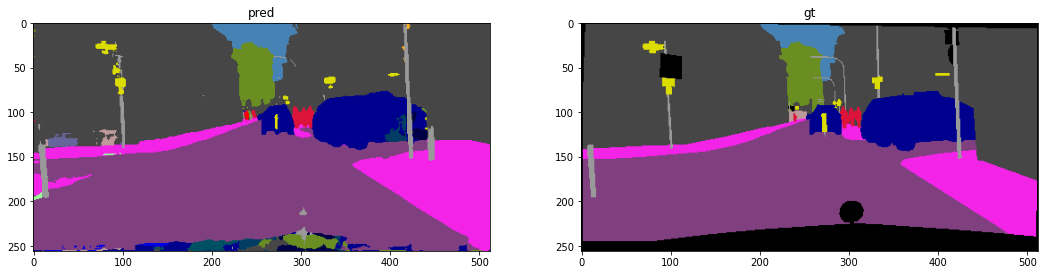

  0%|          | 1/500 [00:00<04:34,  1.82it/s]

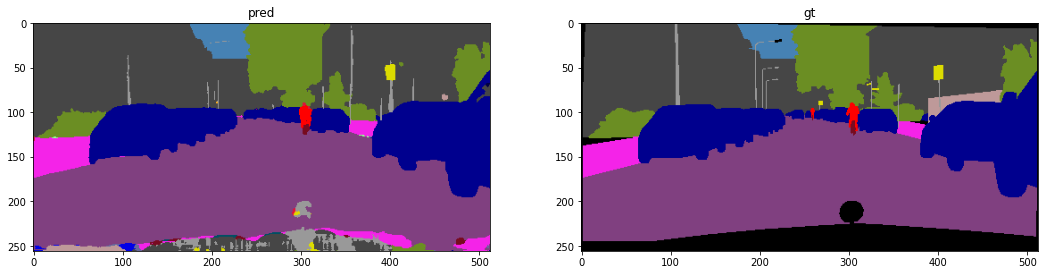

  0%|          | 2/500 [00:01<04:08,  2.00it/s]

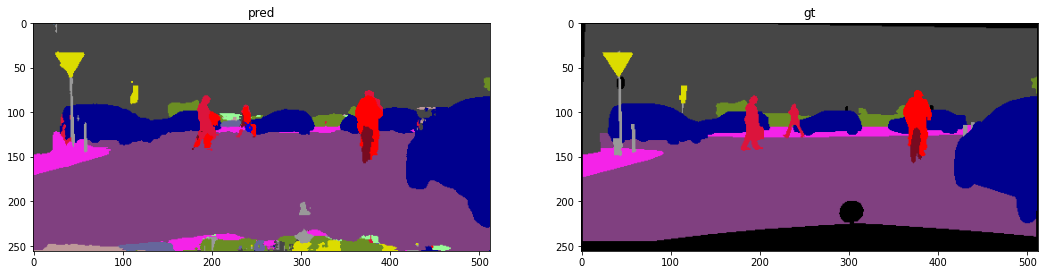

  1%|          | 3/500 [00:01<03:55,  2.11it/s]

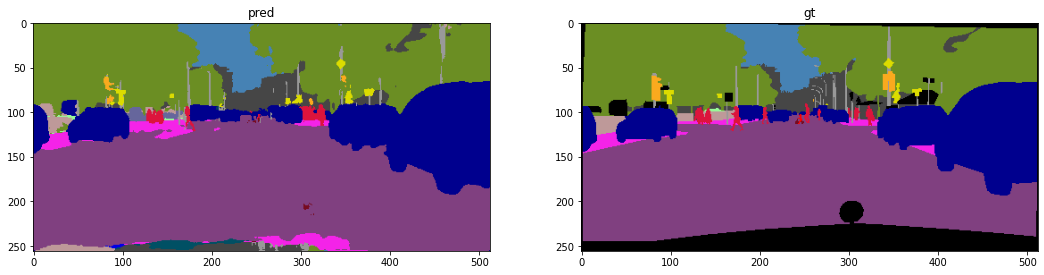

  1%|          | 4/500 [00:02<04:49,  1.71it/s]

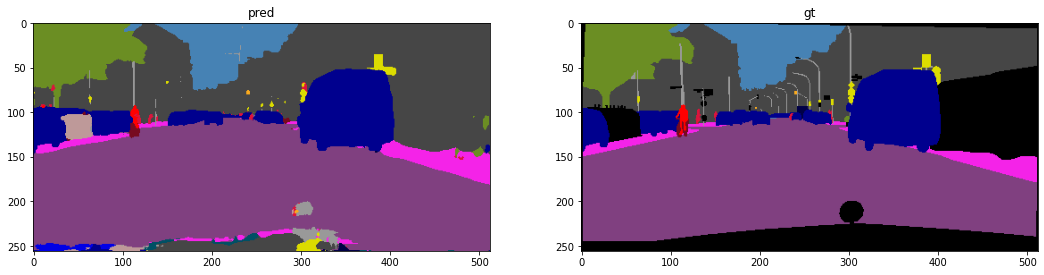

100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


In [12]:
new_model = UNet_with_Attention().to(DEVICE)
checkpoint_path = '/root/.jupyter/Jupyter 2/CV/output/best.pth'
checkpoint = torch.load(checkpoint_path)
new_model.load_state_dict(checkpoint)
print("사전 학습된 가중치 업로드 완료 ")

new_model.eval()

save_path = './test_result'
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
  for idx, batch in enumerate(tqdm(test_loader)):

    X, y, name = batch # here 's' is the name of the file stored in the root directory
    X, y = X.to(DEVICE), np.array(y.to('cpu')[0])
    predictions = new_model(X)

    predictions = torch.nn.functional.softmax(predictions, dim=1)
    pred_labels = torch.argmax(predictions, dim=1)
    pred_labels = pred_labels.float()
    pred_labels = pred_labels.to('cpu')
    pred_labels = np.array(pred_labels[0])
    pred_seg_map = make_seg_map(pred_labels)
    gt_seg_map = make_seg_map(y)
    name = str(name[0])
    cv2.imwrite(os.path.join(save_path, name + '.png'), pred_seg_map[:, :, ::-1])

    # 예측 맵과 정답 맵 비교 - 5 개만 선정
    if idx in [0, 1, 2, 3, 4]:
      plot_results(output_list=[pred_seg_map, gt_seg_map], output_name_list=['pred', 'gt'], cols=2)